In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns

In [3]:
#fakes_suffix = 'SMOTE_train_test_80-20_min14_kneighbors8'
fakes_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
#suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"
#dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{smote_suffix}.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{smote_suffix}.csv.gz', compression='gzip', index_col=0)

# num=3039 #5000
# n_classes=11 #12
# n_epochs=4000 #500
#fakes_suffix = f'PZFLOW_train_test_70-30_min14_classes{n_classes}_epochs{n_epochs}'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5'
# fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5_chunks20'

suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{fakes_suffix}"

dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)

In [4]:
dataset_bank_tns_df_resampled_train

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21abmgtat,0.121904,0.230847,0.333333,0.000000,0.261333,0.243809,0.230761,0.113331,-0.219986,0.002361,...,0.489399,0.549101,0.482800,0.428999,45.550070,0.036651,Yes_TNS,None,-99.0000,ALeRCE
ZTF18achdfqm,0.470350,0.474306,0.333333,0.000000,0.417916,0.940701,0.908838,0.707936,-1.630949,0.010391,...,0.591801,0.621698,0.693800,0.750700,4.841876,0.268249,No_TNS,None,-99.0000,None
ZTF21aagsihi,1.877941,1.139061,0.375000,0.000000,0.450437,3.729228,3.119188,2.198104,-1.478907,0.039536,...,0.743299,0.771400,0.788401,0.605900,63.663109,0.048331,Yes_TNS,SN Ia,0.0237,ATLAS
ZTF19aapswkx,0.186474,0.116516,0.500000,0.000000,0.418552,0.372948,0.372948,0.294826,-4.158978,0.002786,...,0.277401,0.336700,0.177801,0.333200,40.375798,0.051956,Yes_TNS,None,-99.0000,ZTF
ZTF20aclkhnm,0.739245,1.139875,0.166667,0.083333,0.395673,1.478491,1.095229,0.561468,1.248835,-0.021029,...,0.417900,0.077301,1.179501,1.208699,97.442370,0.329514,Yes_TNS,None,-99.0000,ZTF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc78716,0.015157,5.287381,0.392500,0.053569,0.407816,1.004380,2.397410,0.070521,0.268239,-0.014267,...,1.128080,0.627479,1.195375,0.299978,79.118332,-0.639693,Fake,TDE,-99.0000,None
ZTFabc18519,1.527152,0.399389,0.388678,0.031452,0.341625,2.036185,2.388125,0.691429,-0.654500,-0.017053,...,1.403045,1.492957,0.906673,0.022356,28.532036,-0.987678,Fake,TDE,-99.0000,None
ZTFabc55421,0.330276,0.887094,0.117378,0.008601,0.412652,1.002673,0.682406,1.420262,0.090329,0.023145,...,0.968457,0.279575,0.293012,-0.177773,82.916222,-0.309253,Fake,TDE,-99.0000,None


In [5]:
dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test[dataset_bank_tns_df_resampled_test['tns_cls'] != 'None']
dataset_bank_tns_df_resampled_test

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.429100,0.487600,0.394600,0.479000,17.508340,0.363381,Yes_TNS,SN Ia,0.076000,ALeRCE
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,1.987599,2.187201,1.923100,1.677900,127.987642,1.280643,Yes_TNS,SN Ic-BL,0.023563,ZTF
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,0.537500,0.461899,0.366699,0.308001,73.202796,0.245163,Yes_TNS,SN Ia,0.048167,ZTF
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,1.203501,1.442598,1.337000,1.170200,29.489402,0.282454,Yes_TNS,SN Ia,0.041000,ALeRCE
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,0.024799,-0.047600,0.003399,-0.067900,37.216605,4.749794,Yes_TNS,SN Ia,0.070000,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acbntop,0.899363,0.548262,0.142857,0.000000,0.384089,1.798725,1.640747,0.850087,0.865731,0.021041,...,0.913400,1.126800,1.043000,1.068700,50.903486,0.287150,Yes_TNS,SN Ia,0.067440,AMPEL
ZTF21acjgmiy,0.195485,0.345411,0.428571,0.000000,0.381873,0.390970,0.369406,0.229109,-0.810354,-0.007646,...,1.779399,1.677999,1.998200,1.679500,162.509120,0.447518,Yes_TNS,SN Ia,0.034000,ZTF
ZTF22aaagxev,0.393591,0.331851,0.200000,0.000000,0.363693,0.787182,0.787182,0.398193,2.233901,0.044642,...,1.084701,1.286399,1.404600,1.339801,70.927285,0.109051,Yes_TNS,SN Ia,0.051000,ATLAS


In [6]:
np.unique(np.array(dataset_bank_tns_df_resampled_train['tns_cls']))

array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [7]:
x_train = dataset_bank_tns_df_resampled_train.iloc[:, 0:120]
x_test = dataset_bank_tns_df_resampled_test.iloc[:, 0:120]

In [8]:
%%time
import numpy as np
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.losses import binary_crossentropy, KLDivergence
from keras import backend as K
from keras.callbacks import LambdaCallback, ReduceLROnPlateau
from tqdm import tqdm

# Normalize the input data
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
x_train_normalized = (x_train - x_train_mean) / x_train_std

# Define the dimensions
input_dim = 120
latent_dim = 20 # 20 # 5
intermediate_dim = 64

# Encoder
input_layer = Input(shape=(input_dim,))
hidden_layer = Dense(intermediate_dim, activation='relu')(input_layer)

# Define the mean and variance of the latent distribution
z_mean = Dense(latent_dim)(hidden_layer)
z_log_var = Dense(latent_dim)(hidden_layer)

# Custom layer for reparameterization trick
class SamplingLayer(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = K.shape(z_mean)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = SamplingLayer()([z_mean, z_log_var])

# Decoder
decoder_hidden = Dense(intermediate_dim, activation='relu')
decoder_output = Dense(input_dim, activation='linear')  # Modified activation function

# Define the VAE model
decoder_mean = decoder_output(decoder_hidden(z))
vae = Model(input_layer, decoder_mean)

# Define the reconstruction loss
reconstruction_loss = input_dim * binary_crossentropy(input_layer, decoder_mean)

# Define the KL divergence loss
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

# Add the reconstruction and KL divergence losses as additional losses
vae.add_loss(K.mean(reconstruction_loss + kl_loss))

# Compile the model
vae.compile(optimizer='adam')

# Define a callback for updating the progress bar
progress_bar = tqdm(unit="batch", total=len(x_train) // 32)
progress_callback = LambdaCallback(on_batch_end=lambda batch, logs: progress_bar.update(1) if (batch + 1) % 32 == 0 else False)

# Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the VAE
vae.fit(
    x_train_normalized, x_train_normalized,
    batch_size=32,
    epochs=500,
    callbacks=[progress_callback, reduce_lr],
    #validation_data=(x_val_normalized, x_val_normalized)  # Assuming you have a validation set
)

# Close the progress bar after training
progress_bar.close()

# Obtain the latent representation of the input data
encoder = Model(input_layer, z_mean)
latent_representation = encoder.predict(x_train)

Cause: Unable to locate the source code of <bound method SamplingLayer.call of <__main__.SamplingLayer object at 0x7fa622a2b4f0>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <bound method SamplingLayer.call of <__main__.SamplingLayer object at 0x7fa622a2b4f0>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Orig

  0%|          | 0/1139 [00:00<?, ?batch/s]

Epoch 1/500
  30/1140 [..............................] - ETA: 1s - loss: 93.8199    

  0%|          | 1/1139 [00:01<20:57,  1.10s/batch]

  91/1140 [=>............................] - ETA: 1s - loss: 42.4506

  0%|          | 3/1139 [00:01<06:09,  3.07batch/s]

 155/1140 [===>..........................] - ETA: 1s - loss: 31.6034

  0%|          | 5/1139 [00:01<03:28,  5.43batch/s]

 219/1140 [====>.........................] - ETA: 1s - loss: 11.4330

  1%|          | 7/1139 [00:01<02:25,  7.80batch/s]

 319/1140 [=======>......................] - ETA: 1s - loss: -7.2184

  1%|          | 10/1139 [00:01<01:41, 11.10batch/s]

 390/1140 [=========>....................] - ETA: 1s - loss: -17.9393

  1%|          | 13/1139 [00:01<01:22, 13.67batch/s]

 468/1140 [===========>..................] - ETA: 1s - loss: -31.8340

  1%|▏         | 15/1139 [00:01<01:20, 13.96batch/s]

 515/1140 [============>.................] - ETA: 1s - loss: -38.1862

  1%|▏         | 17/1139 [00:01<01:16, 14.68batch/s]

 578/1140 [==============>...............] - ETA: 0s - loss: -48.2265

  2%|▏         | 19/1139 [00:02<01:11, 15.76batch/s]

 666/1140 [================>.............] - ETA: 0s - loss: -61.6335

  2%|▏         | 21/1139 [00:02<01:09, 16.17batch/s]

 722/1140 [==================>...........] - ETA: 0s - loss: -69.4191

  2%|▏         | 23/1139 [00:02<01:07, 16.45batch/s]

 776/1140 [===================>..........] - ETA: 0s - loss: -75.7568

  2%|▏         | 25/1139 [00:02<01:07, 16.44batch/s]

 856/1140 [=====================>........] - ETA: 0s - loss: -84.4932

  2%|▏         | 27/1139 [00:02<01:07, 16.37batch/s]

 909/1140 [======================>.......] - ETA: 0s - loss: -91.0403

  3%|▎         | 29/1139 [00:02<01:07, 16.49batch/s]

 988/1140 [=========================>....] - ETA: 0s - loss: -98.3883

  3%|▎         | 31/1139 [00:02<01:08, 16.20batch/s]

1044/1140 [==========================>...] - ETA: 0s - loss: -102.5799

  3%|▎         | 33/1139 [00:02<01:06, 16.74batch/s]

1140/1140 [==============================] - 3s 2ms/step - loss: -109.6324 - lr: 0.0010
Epoch 2/500
  28/1140 [..............................] - ETA: 2s - loss: -193.4144

  3%|▎         | 36/1139 [00:03<01:09, 15.89batch/s]

  86/1140 [=>............................] - ETA: 1s - loss: -194.2024

  3%|▎         | 38/1139 [00:03<01:06, 16.51batch/s]

 158/1140 [===>..........................] - ETA: 1s - loss: -191.3600

  4%|▎         | 41/1139 [00:03<00:59, 18.40batch/s]

 265/1140 [=====>........................] - ETA: 1s - loss: -191.3423

  4%|▍         | 44/1139 [00:03<00:57, 19.04batch/s]

 369/1140 [========>.....................] - ETA: 1s - loss: -198.7357

  4%|▍         | 47/1139 [00:03<00:54, 19.90batch/s]

 472/1140 [===========>..................] - ETA: 1s - loss: -205.6932

  4%|▍         | 50/1139 [00:03<00:54, 20.12batch/s]

 555/1140 [=============>................] - ETA: 0s - loss: -208.8632

  5%|▍         | 53/1139 [00:03<00:56, 19.10batch/s]

 614/1140 [===============>..............] - ETA: 0s - loss: -209.9593

  5%|▍         | 55/1139 [00:04<00:57, 18.98batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -212.9535

  5%|▌         | 57/1139 [00:04<00:57, 18.79batch/s]

 759/1140 [==================>...........] - ETA: 0s - loss: -215.9617

  5%|▌         | 59/1139 [00:04<00:58, 18.39batch/s]

 819/1140 [====================>.........] - ETA: 0s - loss: -214.6369

  5%|▌         | 61/1139 [00:04<00:58, 18.49batch/s]

 880/1140 [======================>.......] - ETA: 0s - loss: -213.0159

  6%|▌         | 63/1139 [00:04<00:58, 18.42batch/s]

 936/1140 [=======================>......] - ETA: 0s - loss: -212.6452

  6%|▌         | 65/1139 [00:04<00:58, 18.43batch/s]

 998/1140 [=========================>....] - ETA: 0s - loss: -213.5169

  6%|▌         | 67/1139 [00:04<00:58, 18.42batch/s]

1058/1140 [==========================>...] - ETA: 0s - loss: -213.9136

  6%|▌         | 69/1139 [00:04<00:58, 18.38batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -214.7436 - lr: 0.0010
Epoch 3/500
  31/1140 [..............................] - ETA: 1s - loss: -210.5721

  6%|▌         | 71/1139 [00:04<01:06, 16.13batch/s]

  84/1140 [=>............................] - ETA: 1s - loss: -225.5823

  6%|▋         | 73/1139 [00:05<01:05, 16.28batch/s]

 142/1140 [==>...........................] - ETA: 1s - loss: -231.9980

  7%|▋         | 75/1139 [00:05<01:03, 16.79batch/s]

 248/1140 [=====>........................] - ETA: 1s - loss: -239.2650

  7%|▋         | 78/1139 [00:05<00:57, 18.58batch/s]

 324/1140 [=======>......................] - ETA: 1s - loss: -241.3112

  7%|▋         | 81/1139 [00:05<00:53, 19.96batch/s]

 388/1140 [=========>....................] - ETA: 1s - loss: -242.8059

  7%|▋         | 83/1139 [00:05<00:53, 19.66batch/s]

 478/1140 [===========>..................] - ETA: 1s - loss: -244.1997

  7%|▋         | 85/1139 [00:05<00:54, 19.29batch/s]

 536/1140 [=============>................] - ETA: 0s - loss: -243.9659

  8%|▊         | 87/1139 [00:05<00:55, 18.98batch/s]

 604/1140 [==============>...............] - ETA: 0s - loss: -245.2006

  8%|▊         | 90/1139 [00:05<00:52, 20.03batch/s]

 719/1140 [=================>............] - ETA: 0s - loss: -247.3039

  8%|▊         | 93/1139 [00:06<00:49, 21.08batch/s]

 826/1140 [====================>.........] - ETA: 0s - loss: -250.0672

  8%|▊         | 96/1139 [00:06<00:49, 21.16batch/s]

 917/1140 [=======================>......] - ETA: 0s - loss: -251.5087

  9%|▊         | 99/1139 [00:06<00:51, 20.34batch/s]

1018/1140 [=========================>....] - ETA: 0s - loss: -252.8717

  9%|▉         | 102/1139 [00:06<00:50, 20.52batch/s]

1090/1140 [===========================>..] - ETA: 0s - loss: -254.3884

  9%|▉         | 105/1139 [00:06<00:48, 21.12batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -255.2365 - lr: 0.0010
Epoch 4/500
  77/1140 [=>............................] - ETA: 1s - loss: -274.4837

  9%|▉         | 108/1139 [00:06<00:51, 20.13batch/s]

 175/1140 [===>..........................] - ETA: 1s - loss: -273.9224

 10%|▉         | 111/1139 [00:06<00:51, 20.04batch/s]

 269/1140 [======>.......................] - ETA: 1s - loss: -281.8068

 10%|█         | 114/1139 [00:07<00:51, 19.87batch/s]

 374/1140 [========>.....................] - ETA: 1s - loss: -286.3265

 10%|█         | 117/1139 [00:07<00:49, 20.45batch/s]

 449/1140 [==========>...................] - ETA: 1s - loss: -287.5746

 11%|█         | 120/1139 [00:07<00:47, 21.31batch/s]

 562/1140 [=============>................] - ETA: 0s - loss: -291.5691

 11%|█         | 123/1139 [00:07<00:46, 21.78batch/s]

 670/1140 [================>.............] - ETA: 0s - loss: -294.8769

 11%|█         | 126/1139 [00:07<00:46, 21.91batch/s]

 738/1140 [==================>...........] - ETA: 0s - loss: -293.0683

 11%|█▏        | 129/1139 [00:07<00:46, 21.70batch/s]

 842/1140 [=====================>........] - ETA: 0s - loss: -290.8835

 12%|█▏        | 132/1139 [00:07<00:46, 21.65batch/s]

 947/1140 [=======================>......] - ETA: 0s - loss: -290.3523

 12%|█▏        | 135/1139 [00:08<00:46, 21.39batch/s]

1040/1140 [==========================>...] - ETA: 0s - loss: -290.9664

 12%|█▏        | 138/1139 [00:08<00:48, 20.63batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -291.8688 - lr: 0.0010
Epoch 5/500
   1/1140 [..............................] - ETA: 2s - loss: -281.8820

 12%|█▏        | 141/1139 [00:08<00:51, 19.36batch/s]

 113/1140 [=>............................] - ETA: 1s - loss: -312.7814

 13%|█▎        | 144/1139 [00:08<00:48, 20.34batch/s]

 206/1140 [====>.........................] - ETA: 1s - loss: -303.3824

 13%|█▎        | 147/1139 [00:08<00:51, 19.33batch/s]

 260/1140 [=====>........................] - ETA: 1s - loss: -305.1097

 13%|█▎        | 149/1139 [00:08<00:51, 19.18batch/s]

 351/1140 [========>.....................] - ETA: 1s - loss: -303.0074

 13%|█▎        | 151/1139 [00:08<00:52, 18.99batch/s]

 419/1140 [==========>...................] - ETA: 1s - loss: -301.4781

 14%|█▎        | 154/1139 [00:09<00:50, 19.67batch/s]

 526/1140 [============>.................] - ETA: 0s - loss: -302.5822

 14%|█▍        | 157/1139 [00:09<00:47, 20.50batch/s]

 636/1140 [===============>..............] - ETA: 0s - loss: -301.8056

 14%|█▍        | 160/1139 [00:09<00:46, 21.11batch/s]

 735/1140 [==================>...........] - ETA: 0s - loss: -297.3696

 14%|█▍        | 163/1139 [00:09<00:46, 20.89batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -295.6636

 15%|█▍        | 166/1139 [00:09<00:47, 20.61batch/s]

 904/1140 [======================>.......] - ETA: 0s - loss: -295.6770

 15%|█▍        | 169/1139 [00:09<00:46, 20.93batch/s]

1014/1140 [=========================>....] - ETA: 0s - loss: -296.2039

 15%|█▌        | 172/1139 [00:09<00:45, 21.48batch/s]

1090/1140 [===========================>..] - ETA: 0s - loss: -296.5645

 15%|█▌        | 175/1139 [00:10<00:43, 22.06batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -296.6688 - lr: 0.0010
Epoch 6/500
  73/1140 [>.............................] - ETA: 1s - loss: -291.0037

 16%|█▌        | 178/1139 [00:10<00:46, 20.60batch/s]

 174/1140 [===>..........................] - ETA: 1s - loss: -278.0877

 16%|█▌        | 181/1139 [00:10<00:46, 20.58batch/s]

 281/1140 [======>.......................] - ETA: 1s - loss: -274.6437

 16%|█▌        | 184/1139 [00:10<00:45, 21.03batch/s]

 354/1140 [========>.....................] - ETA: 1s - loss: -279.2895

 16%|█▋        | 187/1139 [00:10<00:44, 21.25batch/s]

 474/1140 [===========>..................] - ETA: 0s - loss: -285.8418

 17%|█▋        | 190/1139 [00:10<00:47, 20.12batch/s]

 542/1140 [=============>................] - ETA: 0s - loss: -288.6916

 17%|█▋        | 193/1139 [00:10<00:46, 20.50batch/s]

 650/1140 [================>.............] - ETA: 0s - loss: -290.1825

 17%|█▋        | 196/1139 [00:11<00:44, 20.99batch/s]

 763/1140 [===================>..........] - ETA: 0s - loss: -286.5940

 17%|█▋        | 199/1139 [00:11<00:43, 21.68batch/s]

 838/1140 [=====================>........] - ETA: 0s - loss: -283.5663

 18%|█▊        | 202/1139 [00:11<00:42, 22.07batch/s]

 938/1140 [=======================>......] - ETA: 0s - loss: -281.2961

 18%|█▊        | 205/1139 [00:11<00:43, 21.49batch/s]

1033/1140 [==========================>...] - ETA: 0s - loss: -281.1489

 18%|█▊        | 208/1139 [00:11<00:45, 20.67batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -282.3856 - lr: 0.0010
Epoch 7/500
   1/1140 [..............................] - ETA: 2s - loss: -280.1187

 19%|█▊        | 211/1139 [00:11<00:47, 19.61batch/s]

 116/1140 [==>...........................] - ETA: 1s - loss: -305.4974

 19%|█▉        | 214/1139 [00:11<00:44, 20.65batch/s]

 192/1140 [====>.........................] - ETA: 1s - loss: -302.5417

 19%|█▉        | 217/1139 [00:12<00:43, 21.34batch/s]

 316/1140 [=======>......................] - ETA: 1s - loss: -304.8723

 19%|█▉        | 220/1139 [00:12<00:44, 20.43batch/s]

 413/1140 [=========>....................] - ETA: 1s - loss: -306.0835

 20%|█▉        | 223/1139 [00:12<00:45, 20.20batch/s]

 484/1140 [===========>..................] - ETA: 0s - loss: -307.3831

 20%|█▉        | 226/1139 [00:12<00:43, 20.78batch/s]

 596/1140 [==============>...............] - ETA: 0s - loss: -308.5631

 20%|██        | 229/1139 [00:12<00:42, 21.40batch/s]

 701/1140 [=================>............] - ETA: 0s - loss: -311.0824

 20%|██        | 232/1139 [00:12<00:42, 21.40batch/s]

 769/1140 [===================>..........] - ETA: 0s - loss: -312.7894

 21%|██        | 235/1139 [00:12<00:42, 21.16batch/s]

 893/1140 [======================>.......] - ETA: 0s - loss: -314.2343

 21%|██        | 238/1139 [00:13<00:44, 20.43batch/s]

 957/1140 [========================>.....] - ETA: 0s - loss: -315.0305

 21%|██        | 241/1139 [00:13<00:43, 20.55batch/s]

1064/1140 [===========================>..] - ETA: 0s - loss: -316.2902

 21%|██▏       | 244/1139 [00:13<00:42, 21.02batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -316.9434 - lr: 0.0010
Epoch 8/500
  33/1140 [..............................] - ETA: 1s - loss: -338.6026

 22%|██▏       | 247/1139 [00:13<00:46, 19.35batch/s]

 125/1140 [==>...........................] - ETA: 1s - loss: -311.3435

 22%|██▏       | 249/1139 [00:13<00:46, 19.15batch/s]

 192/1140 [====>.........................] - ETA: 1s - loss: -314.8472

 22%|██▏       | 252/1139 [00:13<00:44, 19.72batch/s]

 301/1140 [======>.......................] - ETA: 1s - loss: -321.4536

 22%|██▏       | 255/1139 [00:13<00:43, 20.45batch/s]

 397/1140 [=========>....................] - ETA: 1s - loss: -328.4453

 23%|██▎       | 258/1139 [00:14<00:43, 20.16batch/s]

 493/1140 [===========>..................] - ETA: 1s - loss: -332.3062

 23%|██▎       | 261/1139 [00:14<00:43, 20.17batch/s]

 600/1140 [==============>...............] - ETA: 0s - loss: -324.1668

 23%|██▎       | 264/1139 [00:14<00:42, 20.72batch/s]

 676/1140 [================>.............] - ETA: 0s - loss: -322.0652

 23%|██▎       | 267/1139 [00:14<00:40, 21.30batch/s]

 772/1140 [===================>..........] - ETA: 0s - loss: -321.3801

 24%|██▎       | 270/1139 [00:14<00:42, 20.63batch/s]

 870/1140 [=====================>........] - ETA: 0s - loss: -318.3980

 24%|██▍       | 273/1139 [00:14<00:41, 20.69batch/s]

 979/1140 [========================>.....] - ETA: 0s - loss: -317.2880

 24%|██▍       | 276/1139 [00:14<00:40, 21.17batch/s]

1052/1140 [==========================>...] - ETA: 0s - loss: -317.0925

 24%|██▍       | 279/1139 [00:15<00:39, 21.70batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -317.0907 - lr: 0.0010
Epoch 9/500
  40/1140 [>.............................] - ETA: 1s - loss: -332.0704

 25%|██▍       | 282/1139 [00:15<00:41, 20.69batch/s]

 143/1140 [==>...........................] - ETA: 1s - loss: -317.0912

 25%|██▌       | 285/1139 [00:15<00:41, 20.56batch/s]

 243/1140 [=====>........................] - ETA: 1s - loss: -320.6857

 25%|██▌       | 288/1139 [00:15<00:41, 20.56batch/s]

 344/1140 [========>.....................] - ETA: 1s - loss: -324.8659

 26%|██▌       | 291/1139 [00:15<00:41, 20.63batch/s]

 415/1140 [=========>....................] - ETA: 1s - loss: -329.1764

 26%|██▌       | 294/1139 [00:15<00:40, 21.11batch/s]

 526/1140 [============>.................] - ETA: 0s - loss: -333.9839

 26%|██▌       | 297/1139 [00:15<00:38, 21.63batch/s]

 627/1140 [===============>..............] - ETA: 0s - loss: -335.2493

 26%|██▋       | 300/1139 [00:16<00:39, 21.26batch/s]

 735/1140 [==================>...........] - ETA: 0s - loss: -336.5314

 27%|██▋       | 303/1139 [00:16<00:38, 21.60batch/s]

 808/1140 [====================>.........] - ETA: 0s - loss: -339.1159

 27%|██▋       | 306/1139 [00:16<00:37, 21.97batch/s]

 922/1140 [=======================>......] - ETA: 0s - loss: -341.6362

 27%|██▋       | 309/1139 [00:16<00:36, 22.44batch/s]

 996/1140 [=========================>....] - ETA: 0s - loss: -342.4967

 27%|██▋       | 312/1139 [00:16<00:36, 22.74batch/s]

1110/1140 [============================>.] - ETA: 0s - loss: -343.7186

 28%|██▊       | 315/1139 [00:16<00:36, 22.78batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -343.3967 - lr: 0.0010
Epoch 10/500
  66/1140 [>.............................] - ETA: 1s - loss: -327.9402

 28%|██▊       | 318/1139 [00:16<00:40, 20.40batch/s]

 178/1140 [===>..........................] - ETA: 1s - loss: -332.5480

 28%|██▊       | 321/1139 [00:17<00:38, 21.24batch/s]

 253/1140 [=====>........................] - ETA: 1s - loss: -319.9024

 28%|██▊       | 324/1139 [00:17<00:37, 21.88batch/s]

 368/1140 [========>.....................] - ETA: 1s - loss: -294.2599

 29%|██▊       | 327/1139 [00:17<00:36, 22.31batch/s]

 444/1140 [==========>...................] - ETA: 0s - loss: -290.9473

 29%|██▉       | 330/1139 [00:17<00:35, 22.72batch/s]

 560/1140 [=============>................] - ETA: 0s - loss: -287.2703

 29%|██▉       | 333/1139 [00:17<00:35, 22.94batch/s]

 633/1140 [===============>..............] - ETA: 0s - loss: -289.5096

 29%|██▉       | 336/1139 [00:17<00:34, 23.06batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -289.8677

 30%|██▉       | 339/1139 [00:17<00:34, 23.20batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -292.1349

 30%|███       | 342/1139 [00:17<00:34, 23.12batch/s]

 939/1140 [=======================>......] - ETA: 0s - loss: -294.6554

 30%|███       | 345/1139 [00:18<00:34, 23.28batch/s]

1051/1140 [==========================>...] - ETA: 0s - loss: -296.6455

 31%|███       | 348/1139 [00:18<00:34, 23.20batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -297.1253 - lr: 0.0010
Epoch 11/500
   1/1140 [..............................] - ETA: 2s - loss: -294.9328

 31%|███       | 351/1139 [00:18<00:36, 21.59batch/s]

 110/1140 [=>............................] - ETA: 1s - loss: -311.1482

 31%|███       | 354/1139 [00:18<00:37, 20.95batch/s]

 208/1140 [====>.........................] - ETA: 1s - loss: -309.5106

 31%|███▏      | 357/1139 [00:18<00:36, 21.48batch/s]

 282/1140 [======>.......................] - ETA: 1s - loss: -310.9714

 32%|███▏      | 360/1139 [00:18<00:35, 21.97batch/s]

 398/1140 [=========>....................] - ETA: 1s - loss: -311.4730

 32%|███▏      | 363/1139 [00:18<00:34, 22.47batch/s]

 475/1140 [===========>..................] - ETA: 0s - loss: -314.1219

 32%|███▏      | 366/1139 [00:19<00:33, 22.86batch/s]

 590/1140 [==============>...............] - ETA: 0s - loss: -314.1622

 32%|███▏      | 369/1139 [00:19<00:33, 22.97batch/s]

 667/1140 [================>.............] - ETA: 0s - loss: -315.6537

 33%|███▎      | 372/1139 [00:19<00:33, 23.17batch/s]

 782/1140 [===================>..........] - ETA: 0s - loss: -319.1749

 33%|███▎      | 375/1139 [00:19<00:32, 23.32batch/s]

 858/1140 [=====================>........] - ETA: 0s - loss: -318.0993

 33%|███▎      | 378/1139 [00:19<00:32, 23.37batch/s]

 972/1140 [========================>.....] - ETA: 0s - loss: -319.2617

 33%|███▎      | 381/1139 [00:19<00:32, 23.35batch/s]

1077/1140 [===========================>..] - ETA: 0s - loss: -318.0626

 34%|███▎      | 384/1139 [00:19<00:33, 22.58batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -316.7344 - lr: 0.0010
Epoch 12/500
  58/1140 [>.............................] - ETA: 1s - loss: -278.8796

 34%|███▍      | 387/1139 [00:19<00:38, 19.42batch/s]

 127/1140 [==>...........................] - ETA: 1s - loss: -287.1762

 34%|███▍      | 390/1139 [00:20<00:37, 20.10batch/s]

 238/1140 [=====>........................] - ETA: 1s - loss: -290.0325

 35%|███▍      | 393/1139 [00:20<00:35, 20.79batch/s]

 351/1140 [========>.....................] - ETA: 1s - loss: -295.4243

 35%|███▍      | 396/1139 [00:20<00:34, 21.57batch/s]

 428/1140 [==========>...................] - ETA: 1s - loss: -297.1877

 35%|███▌      | 399/1139 [00:20<00:33, 22.20batch/s]

 541/1140 [=============>................] - ETA: 0s - loss: -302.5571

 35%|███▌      | 402/1139 [00:20<00:32, 22.48batch/s]

 617/1140 [===============>..............] - ETA: 0s - loss: -304.2752

 36%|███▌      | 405/1139 [00:20<00:32, 22.74batch/s]

 730/1140 [==================>...........] - ETA: 0s - loss: -307.5655

 36%|███▌      | 408/1139 [00:20<00:31, 22.87batch/s]

 797/1140 [===================>..........] - ETA: 0s - loss: -309.3611

 36%|███▌      | 411/1139 [00:21<00:32, 22.55batch/s]

 911/1140 [======================>.......] - ETA: 0s - loss: -314.2514

 36%|███▋      | 414/1139 [00:21<00:31, 22.73batch/s]

 985/1140 [========================>.....] - ETA: 0s - loss: -317.0179

 37%|███▋      | 417/1139 [00:21<00:31, 22.94batch/s]

1102/1140 [============================>.] - ETA: 0s - loss: -320.5244

 37%|███▋      | 420/1139 [00:21<00:31, 23.09batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -321.5045 - lr: 0.0010
Epoch 13/500
  79/1140 [=>............................] - ETA: 1s - loss: -337.2020

 37%|███▋      | 423/1139 [00:21<00:33, 21.60batch/s]

 153/1140 [===>..........................] - ETA: 1s - loss: -331.3589

 37%|███▋      | 426/1139 [00:21<00:32, 22.15batch/s]

 268/1140 [======>.......................] - ETA: 1s - loss: -331.1670

 38%|███▊      | 429/1139 [00:21<00:31, 22.44batch/s]

 379/1140 [========>.....................] - ETA: 1s - loss: -335.9178

 38%|███▊      | 432/1139 [00:21<00:31, 22.52batch/s]

 454/1140 [==========>...................] - ETA: 0s - loss: -339.1188

 38%|███▊      | 435/1139 [00:22<00:30, 22.84batch/s]

 568/1140 [=============>................] - ETA: 0s - loss: -340.9703

 38%|███▊      | 438/1139 [00:22<00:30, 22.95batch/s]

 643/1140 [===============>..............] - ETA: 0s - loss: -341.4441

 39%|███▊      | 441/1139 [00:22<00:30, 22.74batch/s]

 742/1140 [==================>...........] - ETA: 0s - loss: -343.4506

 39%|███▉      | 444/1139 [00:22<00:31, 21.86batch/s]

 838/1140 [=====================>........] - ETA: 0s - loss: -343.9760

 39%|███▉      | 447/1139 [00:22<00:32, 21.11batch/s]

 939/1140 [=======================>......] - ETA: 0s - loss: -344.9654

 40%|███▉      | 450/1139 [00:22<00:32, 21.08batch/s]

1047/1140 [==========================>...] - ETA: 0s - loss: -346.1625

 40%|███▉      | 453/1139 [00:22<00:31, 21.47batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -345.8247 - lr: 0.0010
Epoch 14/500
   1/1140 [..............................] - ETA: 3s - loss: -391.8012

 40%|████      | 456/1139 [00:23<00:35, 19.28batch/s]

 103/1140 [=>............................] - ETA: 1s - loss: -337.6779

 40%|████      | 459/1139 [00:23<00:34, 19.54batch/s]

 165/1140 [===>..........................] - ETA: 1s - loss: -339.7462

 40%|████      | 461/1139 [00:23<00:34, 19.49batch/s]

 266/1140 [======>.......................] - ETA: 1s - loss: -340.2193

 41%|████      | 464/1139 [00:23<00:33, 20.09batch/s]

 371/1140 [========>.....................] - ETA: 1s - loss: -342.4688

 41%|████      | 467/1139 [00:23<00:32, 20.45batch/s]

 445/1140 [==========>...................] - ETA: 1s - loss: -342.4553

 41%|████▏     | 470/1139 [00:23<00:31, 21.18batch/s]

 556/1140 [=============>................] - ETA: 0s - loss: -339.3582

 42%|████▏     | 473/1139 [00:23<00:30, 21.72batch/s]

 669/1140 [================>.............] - ETA: 0s - loss: -337.9353

 42%|████▏     | 476/1139 [00:24<00:29, 22.11batch/s]

 741/1140 [==================>...........] - ETA: 0s - loss: -335.1649

 42%|████▏     | 479/1139 [00:24<00:29, 22.26batch/s]

 853/1140 [=====================>........] - ETA: 0s - loss: -329.5698

 42%|████▏     | 482/1139 [00:24<00:29, 22.51batch/s]

 929/1140 [=======================>......] - ETA: 0s - loss: -327.1491

 43%|████▎     | 485/1139 [00:24<00:28, 22.84batch/s]

1040/1140 [==========================>...] - ETA: 0s - loss: -326.5382

 43%|████▎     | 488/1139 [00:24<00:28, 22.76batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -326.2451 - lr: 0.0010
Epoch 15/500
   1/1140 [..............................] - ETA: 2s - loss: -296.3531

 43%|████▎     | 491/1139 [00:24<00:30, 21.22batch/s]

 114/1140 [==>...........................] - ETA: 1s - loss: -339.7129

 43%|████▎     | 494/1139 [00:24<00:29, 21.82batch/s]

 190/1140 [====>.........................] - ETA: 1s - loss: -341.4408

 44%|████▎     | 497/1139 [00:25<00:28, 22.37batch/s]

 304/1140 [=======>......................] - ETA: 1s - loss: -345.4428

 44%|████▍     | 500/1139 [00:25<00:28, 22.62batch/s]

 414/1140 [=========>....................] - ETA: 0s - loss: -345.1325

 44%|████▍     | 503/1139 [00:25<00:28, 22.55batch/s]

 490/1140 [===========>..................] - ETA: 0s - loss: -347.1377

 44%|████▍     | 506/1139 [00:25<00:27, 22.83batch/s]

 599/1140 [==============>...............] - ETA: 0s - loss: -348.9721

 45%|████▍     | 509/1139 [00:25<00:27, 22.66batch/s]

 672/1140 [================>.............] - ETA: 0s - loss: -350.1661

 45%|████▍     | 512/1139 [00:25<00:27, 22.82batch/s]

 783/1140 [===================>..........] - ETA: 0s - loss: -350.6448

 45%|████▌     | 515/1139 [00:25<00:27, 22.73batch/s]

 894/1140 [======================>.......] - ETA: 0s - loss: -350.1628

 45%|████▌     | 518/1139 [00:25<00:27, 22.75batch/s]

 970/1140 [========================>.....] - ETA: 0s - loss: -349.5193

 46%|████▌     | 521/1139 [00:26<00:26, 23.08batch/s]

1084/1140 [===========================>..] - ETA: 0s - loss: -349.4519

 46%|████▌     | 524/1139 [00:26<00:26, 23.13batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -349.2290 - lr: 0.0010
Epoch 16/500
  38/1140 [>.............................] - ETA: 1s - loss: -360.4042

 46%|████▋     | 527/1139 [00:26<00:28, 21.46batch/s]

 154/1140 [===>..........................] - ETA: 1s - loss: -359.6811

 47%|████▋     | 530/1139 [00:26<00:27, 22.11batch/s]

 231/1140 [=====>........................] - ETA: 1s - loss: -353.9930

 47%|████▋     | 533/1139 [00:26<00:26, 22.46batch/s]

 342/1140 [========>.....................] - ETA: 1s - loss: -353.5217

 47%|████▋     | 536/1139 [00:26<00:26, 22.67batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -355.5050

 47%|████▋     | 539/1139 [00:26<00:26, 22.25batch/s]

 542/1140 [=============>................] - ETA: 0s - loss: -355.3656

 48%|████▊     | 542/1139 [00:27<00:27, 21.38batch/s]

 616/1140 [===============>..............] - ETA: 0s - loss: -354.2660

 48%|████▊     | 545/1139 [00:27<00:27, 21.99batch/s]

 731/1140 [==================>...........] - ETA: 0s - loss: -351.7789

 48%|████▊     | 548/1139 [00:27<00:26, 22.31batch/s]

 804/1140 [====================>.........] - ETA: 0s - loss: -349.8937

 48%|████▊     | 551/1139 [00:27<00:26, 22.50batch/s]

 917/1140 [=======================>......] - ETA: 0s - loss: -349.1112

 49%|████▊     | 554/1139 [00:27<00:25, 22.64batch/s]

 991/1140 [=========================>....] - ETA: 0s - loss: -349.9662

 49%|████▉     | 557/1139 [00:27<00:25, 22.89batch/s]

1105/1140 [============================>.] - ETA: 0s - loss: -347.9897

 49%|████▉     | 560/1139 [00:27<00:25, 22.98batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -346.8408 - lr: 0.0010
Epoch 17/500
  75/1140 [>.............................] - ETA: 1s - loss: -316.5824

 49%|████▉     | 563/1139 [00:27<00:26, 21.43batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -329.9937

 50%|████▉     | 566/1139 [00:28<00:26, 21.84batch/s]

 263/1140 [=====>........................] - ETA: 1s - loss: -336.7372

 50%|████▉     | 569/1139 [00:28<00:25, 22.48batch/s]

 376/1140 [========>.....................] - ETA: 1s - loss: -339.0270

 50%|█████     | 572/1139 [00:28<00:25, 22.49batch/s]

 448/1140 [==========>...................] - ETA: 0s - loss: -337.9770

 50%|█████     | 575/1139 [00:28<00:25, 22.36batch/s]

 558/1140 [=============>................] - ETA: 0s - loss: -323.7957

 51%|█████     | 578/1139 [00:28<00:25, 22.43batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -312.8915

 51%|█████     | 581/1139 [00:28<00:24, 22.39batch/s]

 739/1140 [==================>...........] - ETA: 0s - loss: -308.5173

 51%|█████▏    | 584/1139 [00:28<00:24, 22.48batch/s]

 852/1140 [=====================>........] - ETA: 0s - loss: -298.8438

 52%|█████▏    | 587/1139 [00:29<00:24, 22.64batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -296.2406

 52%|█████▏    | 590/1139 [00:29<00:24, 22.69batch/s]

1039/1140 [==========================>...] - ETA: 0s - loss: -292.4945

 52%|█████▏    | 593/1139 [00:29<00:23, 22.80batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -292.0069 - lr: 0.0010
Epoch 18/500
   1/1140 [..............................] - ETA: 2s - loss: -387.9926

 52%|█████▏    | 596/1139 [00:29<00:25, 21.39batch/s]

 114/1140 [==>...........................] - ETA: 1s - loss: -297.0860

 53%|█████▎    | 599/1139 [00:29<00:24, 21.81batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -298.6170

 53%|█████▎    | 602/1139 [00:29<00:24, 22.17batch/s]

 301/1140 [======>.......................] - ETA: 1s - loss: -301.2938

 53%|█████▎    | 605/1139 [00:29<00:23, 22.42batch/s]

 411/1140 [=========>....................] - ETA: 0s - loss: -305.6272

 53%|█████▎    | 608/1139 [00:29<00:23, 22.29batch/s]

 510/1140 [============>.................] - ETA: 0s - loss: -310.6724

 54%|█████▎    | 611/1139 [00:30<00:24, 21.67batch/s]

 580/1140 [==============>...............] - ETA: 0s - loss: -311.2241

 54%|█████▍    | 614/1139 [00:30<00:23, 21.91batch/s]

 687/1140 [=================>............] - ETA: 0s - loss: -311.2391

 54%|█████▍    | 617/1139 [00:30<00:24, 21.63batch/s]

 791/1140 [===================>..........] - ETA: 0s - loss: -313.9842

 54%|█████▍    | 620/1139 [00:30<00:23, 21.70batch/s]

 866/1140 [=====================>........] - ETA: 0s - loss: -316.1720

 55%|█████▍    | 623/1139 [00:30<00:23, 22.12batch/s]

 979/1140 [========================>.....] - ETA: 0s - loss: -314.5285

 55%|█████▍    | 626/1139 [00:30<00:22, 22.37batch/s]

1055/1140 [==========================>...] - ETA: 0s - loss: -313.6675

 55%|█████▌    | 629/1139 [00:30<00:22, 22.63batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -308.8093 - lr: 0.0010
Epoch 19/500
  35/1140 [..............................] - ETA: 1s - loss: -221.1998

 55%|█████▌    | 632/1139 [00:31<00:24, 20.29batch/s]

 139/1140 [==>...........................] - ETA: 1s - loss: -236.2652

 56%|█████▌    | 635/1139 [00:31<00:24, 20.71batch/s]

 254/1140 [=====>........................] - ETA: 1s - loss: -244.6756

 56%|█████▌    | 638/1139 [00:31<00:23, 21.47batch/s]

 329/1140 [=======>......................] - ETA: 1s - loss: -249.0891

 56%|█████▋    | 641/1139 [00:31<00:22, 21.89batch/s]

 439/1140 [==========>...................] - ETA: 0s - loss: -255.8437

 57%|█████▋    | 644/1139 [00:31<00:22, 22.21batch/s]

 516/1140 [============>.................] - ETA: 0s - loss: -258.3994

 57%|█████▋    | 647/1139 [00:31<00:21, 22.69batch/s]

 628/1140 [===============>..............] - ETA: 0s - loss: -263.6098

 57%|█████▋    | 650/1139 [00:31<00:21, 22.77batch/s]

 702/1140 [=================>............] - ETA: 0s - loss: -268.4751

 57%|█████▋    | 653/1139 [00:32<00:21, 22.97batch/s]

 815/1140 [====================>.........] - ETA: 0s - loss: -273.8723

 58%|█████▊    | 656/1139 [00:32<00:21, 22.90batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -279.9381

 58%|█████▊    | 659/1139 [00:32<00:21, 22.84batch/s]

1002/1140 [=========================>....] - ETA: 0s - loss: -283.6202

 58%|█████▊    | 662/1139 [00:32<00:20, 23.16batch/s]

1115/1140 [============================>.] - ETA: 0s - loss: -288.5427

 58%|█████▊    | 665/1139 [00:32<00:20, 23.03batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -289.2835 - lr: 0.0010
Epoch 20/500
  75/1140 [>.............................] - ETA: 1s - loss: -343.7934

 59%|█████▊    | 668/1139 [00:32<00:22, 21.36batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -343.5829

 59%|█████▉    | 671/1139 [00:32<00:21, 21.86batch/s]

 266/1140 [======>.......................] - ETA: 1s - loss: -343.7730

 59%|█████▉    | 674/1139 [00:32<00:20, 22.43batch/s]

 380/1140 [=========>....................] - ETA: 1s - loss: -347.1585

 59%|█████▉    | 677/1139 [00:33<00:20, 22.62batch/s]

 455/1140 [==========>...................] - ETA: 0s - loss: -347.3664

 60%|█████▉    | 680/1139 [00:33<00:20, 22.92batch/s]

 569/1140 [=============>................] - ETA: 0s - loss: -348.7783

 60%|█████▉    | 683/1139 [00:33<00:19, 22.97batch/s]

 644/1140 [===============>..............] - ETA: 0s - loss: -349.7324

 60%|██████    | 686/1139 [00:33<00:19, 23.16batch/s]

 751/1140 [==================>...........] - ETA: 0s - loss: -351.1483

 60%|██████    | 689/1139 [00:33<00:19, 22.54batch/s]

 855/1140 [=====================>........] - ETA: 0s - loss: -352.6916

 61%|██████    | 692/1139 [00:33<00:20, 22.25batch/s]

 928/1140 [=======================>......] - ETA: 0s - loss: -349.9446

 61%|██████    | 695/1139 [00:33<00:19, 22.32batch/s]

1040/1140 [==========================>...] - ETA: 0s - loss: -344.5768

 61%|██████▏   | 698/1139 [00:33<00:19, 22.66batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -340.6360 - lr: 0.0010
Epoch 21/500
   1/1140 [..............................] - ETA: 3s - loss: -291.0491

 62%|██████▏   | 701/1139 [00:34<00:20, 21.37batch/s]

 113/1140 [=>............................] - ETA: 1s - loss: -325.6000

 62%|██████▏   | 704/1139 [00:34<00:19, 21.83batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -323.1532

 62%|██████▏   | 707/1139 [00:34<00:19, 22.38batch/s]

 304/1140 [=======>......................] - ETA: 1s - loss: -326.5834

 62%|██████▏   | 710/1139 [00:34<00:18, 22.71batch/s]

 413/1140 [=========>....................] - ETA: 0s - loss: -330.5811

 63%|██████▎   | 713/1139 [00:34<00:18, 22.56batch/s]

 487/1140 [===========>..................] - ETA: 0s - loss: -332.4908

 63%|██████▎   | 716/1139 [00:34<00:18, 22.75batch/s]

 602/1140 [==============>...............] - ETA: 0s - loss: -331.5838

 63%|██████▎   | 719/1139 [00:34<00:18, 22.99batch/s]

 701/1140 [=================>............] - ETA: 0s - loss: -328.4702

 63%|██████▎   | 722/1139 [00:35<00:18, 21.97batch/s]

 792/1140 [===================>..........] - ETA: 0s - loss: -324.8298

 64%|██████▎   | 725/1139 [00:35<00:21, 18.87batch/s]

 890/1140 [======================>.......] - ETA: 0s - loss: -324.4890

 64%|██████▍   | 728/1139 [00:35<00:21, 19.17batch/s]

 950/1140 [========================>.....] - ETA: 0s - loss: -324.6955

 64%|██████▍   | 730/1139 [00:35<00:21, 19.09batch/s]

1012/1140 [=========================>....] - ETA: 0s - loss: -325.2709

 64%|██████▍   | 732/1139 [00:35<00:21, 18.73batch/s]

1079/1140 [===========================>..] - ETA: 0s - loss: -326.7989

 64%|██████▍   | 734/1139 [00:35<00:26, 15.25batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -327.5995 - lr: 0.0010
Epoch 22/500
  30/1140 [..............................] - ETA: 1s - loss: -351.3673

 65%|██████▍   | 736/1139 [00:36<00:29, 13.81batch/s]

  85/1140 [=>............................] - ETA: 1s - loss: -354.9166

 65%|██████▍   | 738/1139 [00:36<00:27, 14.60batch/s]

 180/1140 [===>..........................] - ETA: 1s - loss: -353.5044

 65%|██████▌   | 741/1139 [00:36<00:24, 16.14batch/s]

 239/1140 [=====>........................] - ETA: 1s - loss: -347.6246

 65%|██████▌   | 743/1139 [00:36<00:23, 16.55batch/s]

 300/1140 [======>.......................] - ETA: 1s - loss: -346.3385

 65%|██████▌   | 745/1139 [00:36<00:22, 17.26batch/s]

 362/1140 [========>.....................] - ETA: 1s - loss: -346.9562

 66%|██████▌   | 747/1139 [00:36<00:22, 17.76batch/s]

 447/1140 [==========>...................] - ETA: 1s - loss: -344.4348

 66%|██████▌   | 749/1139 [00:36<00:22, 17.12batch/s]

 509/1140 [============>.................] - ETA: 1s - loss: -343.3657

 66%|██████▌   | 751/1139 [00:36<00:24, 15.70batch/s]

 571/1140 [==============>...............] - ETA: 1s - loss: -341.1104

 66%|██████▌   | 753/1139 [00:37<00:23, 16.55batch/s]

 628/1140 [===============>..............] - ETA: 0s - loss: -339.8151

 66%|██████▋   | 755/1139 [00:37<00:22, 16.84batch/s]

 697/1140 [=================>............] - ETA: 0s - loss: -339.5455

 66%|██████▋   | 757/1139 [00:37<00:24, 15.62batch/s]

 752/1140 [==================>...........] - ETA: 0s - loss: -340.4695

 67%|██████▋   | 759/1139 [00:37<00:26, 14.29batch/s]

 816/1140 [====================>.........] - ETA: 0s - loss: -341.3372

 67%|██████▋   | 761/1139 [00:37<00:28, 13.25batch/s]

 875/1140 [======================>.......] - ETA: 0s - loss: -342.3979

 67%|██████▋   | 763/1139 [00:37<00:28, 13.20batch/s]

 955/1140 [========================>.....] - ETA: 0s - loss: -342.7955

 67%|██████▋   | 765/1139 [00:38<00:32, 11.34batch/s]

1019/1140 [=========================>....] - ETA: 0s - loss: -343.1162

 67%|██████▋   | 767/1139 [00:38<00:31, 11.76batch/s]

1086/1140 [===========================>..] - ETA: 0s - loss: -343.0056

 68%|██████▊   | 769/1139 [00:38<00:35, 10.50batch/s]

1140/1140 [==============================] - 3s 2ms/step - loss: -342.4855 - lr: 0.0010
Epoch 23/500
  15/1140 [..............................] - ETA: 4s - loss: -320.3540

 68%|██████▊   | 771/1139 [00:38<00:40,  9.15batch/s]

  84/1140 [=>............................] - ETA: 2s - loss: -344.0525

 68%|██████▊   | 773/1139 [00:38<00:35, 10.24batch/s]

 143/1140 [==>...........................] - ETA: 2s - loss: -342.6436

 68%|██████▊   | 775/1139 [00:39<00:33, 10.74batch/s]

 211/1140 [====>.........................] - ETA: 2s - loss: -346.2927

 68%|██████▊   | 777/1139 [00:39<00:34, 10.45batch/s]

 270/1140 [======>.......................] - ETA: 2s - loss: -348.6371

 68%|██████▊   | 779/1139 [00:39<00:33, 10.81batch/s]

 345/1140 [========>.....................] - ETA: 2s - loss: -349.8096

 69%|██████▊   | 781/1139 [00:39<00:32, 11.06batch/s]

 402/1140 [=========>....................] - ETA: 1s - loss: -350.9128

 69%|██████▊   | 783/1139 [00:39<00:32, 11.07batch/s]

 470/1140 [===========>..................] - ETA: 1s - loss: -351.8469

 69%|██████▉   | 785/1139 [00:39<00:29, 12.05batch/s]

 543/1140 [=============>................] - ETA: 1s - loss: -352.0252

 69%|██████▉   | 787/1139 [00:39<00:27, 12.71batch/s]

 591/1140 [==============>...............] - ETA: 1s - loss: -351.4412

 69%|██████▉   | 789/1139 [00:40<00:26, 13.14batch/s]

 670/1140 [================>.............] - ETA: 1s - loss: -351.1083

 69%|██████▉   | 791/1139 [00:40<00:24, 14.20batch/s]

 730/1140 [==================>...........] - ETA: 0s - loss: -350.5185

 70%|██████▉   | 793/1139 [00:40<00:22, 15.33batch/s]

 829/1140 [====================>.........] - ETA: 0s - loss: -349.3864

 70%|██████▉   | 796/1139 [00:40<00:20, 17.03batch/s]

 922/1140 [=======================>......] - ETA: 0s - loss: -343.1256

 70%|███████   | 799/1139 [00:40<00:19, 17.79batch/s]

 992/1140 [=========================>....] - ETA: 0s - loss: -340.7662

 70%|███████   | 802/1139 [00:40<00:17, 19.05batch/s]

1105/1140 [============================>.] - ETA: 0s - loss: -339.7950

 71%|███████   | 805/1139 [00:40<00:16, 20.11batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -339.6711 - lr: 0.0010
Epoch 24/500
  77/1140 [=>............................] - ETA: 1s - loss: -350.0052

 71%|███████   | 808/1139 [00:41<00:16, 19.66batch/s]

 191/1140 [====>.........................] - ETA: 1s - loss: -353.9955

 71%|███████   | 811/1139 [00:41<00:15, 20.71batch/s]

 263/1140 [=====>........................] - ETA: 1s - loss: -354.7574

 71%|███████▏  | 814/1139 [00:41<00:15, 21.33batch/s]

 364/1140 [========>.....................] - ETA: 1s - loss: -357.9743

 72%|███████▏  | 817/1139 [00:41<00:15, 21.05batch/s]

 465/1140 [===========>..................] - ETA: 0s - loss: -350.6161

 72%|███████▏  | 820/1139 [00:41<00:15, 20.74batch/s]

 566/1140 [=============>................] - ETA: 0s - loss: -344.3210

 72%|███████▏  | 823/1139 [00:41<00:15, 20.80batch/s]

 633/1140 [===============>..............] - ETA: 0s - loss: -338.8262

 73%|███████▎  | 826/1139 [00:41<00:14, 21.16batch/s]

 748/1140 [==================>...........] - ETA: 0s - loss: -336.8109

 73%|███████▎  | 829/1139 [00:42<00:14, 21.72batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -333.6700

 73%|███████▎  | 832/1139 [00:42<00:13, 22.18batch/s]

 933/1140 [=======================>......] - ETA: 0s - loss: -332.6346

 73%|███████▎  | 835/1139 [00:42<00:13, 22.25batch/s]

1047/1140 [==========================>...] - ETA: 0s - loss: -332.3101

 74%|███████▎  | 838/1139 [00:42<00:13, 22.52batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -332.4382 - lr: 0.0010
Epoch 25/500
   1/1140 [..............................] - ETA: 2s - loss: -349.6563

 74%|███████▍  | 841/1139 [00:42<00:14, 20.89batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -319.1136

 74%|███████▍  | 844/1139 [00:42<00:13, 21.56batch/s]

 217/1140 [====>.........................] - ETA: 1s - loss: -321.9274

 74%|███████▍  | 847/1139 [00:42<00:13, 21.48batch/s]

 315/1140 [=======>......................] - ETA: 1s - loss: -323.8951

 75%|███████▍  | 850/1139 [00:43<00:13, 21.06batch/s]

 381/1140 [=========>....................] - ETA: 1s - loss: -320.9400

 75%|███████▍  | 853/1139 [00:43<00:13, 21.03batch/s]

 511/1140 [============>.................] - ETA: 0s - loss: -322.3795

 75%|███████▌  | 856/1139 [00:43<00:13, 20.51batch/s]

 578/1140 [==============>...............] - ETA: 0s - loss: -323.4928

 75%|███████▌  | 859/1139 [00:43<00:13, 20.61batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -325.0609

 76%|███████▌  | 862/1139 [00:43<00:13, 19.89batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -326.6797

 76%|███████▌  | 865/1139 [00:43<00:13, 19.70batch/s]

 856/1140 [=====================>........] - ETA: 0s - loss: -327.5672

 76%|███████▌  | 867/1139 [00:43<00:14, 19.42batch/s]

 913/1140 [=======================>......] - ETA: 0s - loss: -328.3656

 76%|███████▋  | 869/1139 [00:44<00:14, 18.64batch/s]

 964/1140 [========================>.....] - ETA: 0s - loss: -329.0673

 76%|███████▋  | 871/1139 [00:44<00:14, 18.52batch/s]

1066/1140 [===========================>..] - ETA: 0s - loss: -331.4702

 77%|███████▋  | 874/1139 [00:44<00:13, 19.36batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -332.8300 - lr: 0.0010
Epoch 26/500
   1/1140 [..............................] - ETA: 2s - loss: -419.8535

 77%|███████▋  | 876/1139 [00:44<00:14, 18.69batch/s]

  88/1140 [=>............................] - ETA: 1s - loss: -344.5231

 77%|███████▋  | 878/1139 [00:44<00:14, 17.55batch/s]

 158/1140 [===>..........................] - ETA: 1s - loss: -352.1284

 77%|███████▋  | 880/1139 [00:44<00:15, 16.68batch/s]

 209/1140 [====>.........................] - ETA: 1s - loss: -352.9168

 77%|███████▋  | 882/1139 [00:44<00:16, 16.02batch/s]

 278/1140 [======>.......................] - ETA: 1s - loss: -352.8141

 78%|███████▊  | 884/1139 [00:44<00:16, 15.75batch/s]

 332/1140 [=======>......................] - ETA: 1s - loss: -350.4747

 78%|███████▊  | 886/1139 [00:45<00:15, 16.02batch/s]

 405/1140 [=========>....................] - ETA: 1s - loss: -350.8786

 78%|███████▊  | 888/1139 [00:45<00:16, 15.36batch/s]

 474/1140 [===========>..................] - ETA: 1s - loss: -349.2043

 78%|███████▊  | 890/1139 [00:45<00:16, 15.02batch/s]

 541/1140 [=============>................] - ETA: 1s - loss: -350.6020

 78%|███████▊  | 892/1139 [00:45<00:16, 14.59batch/s]

 587/1140 [==============>...............] - ETA: 1s - loss: -350.7379

 78%|███████▊  | 894/1139 [00:45<00:17, 14.30batch/s]

 665/1140 [================>.............] - ETA: 0s - loss: -351.5523

 79%|███████▊  | 896/1139 [00:45<00:16, 15.13batch/s]

 722/1140 [==================>...........] - ETA: 0s - loss: -352.8177

 79%|███████▉  | 898/1139 [00:45<00:15, 15.78batch/s]

 779/1140 [===================>..........] - ETA: 0s - loss: -353.2591

 79%|███████▉  | 900/1139 [00:45<00:14, 16.11batch/s]

 835/1140 [====================>.........] - ETA: 0s - loss: -353.9567

 79%|███████▉  | 902/1139 [00:46<00:14, 16.73batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -355.9317

 79%|███████▉  | 904/1139 [00:46<00:13, 16.92batch/s]

1021/1140 [=========================>....] - ETA: 0s - loss: -358.0357

 80%|███████▉  | 907/1139 [00:46<00:12, 17.98batch/s]

1075/1140 [===========================>..] - ETA: 0s - loss: -358.8751

 80%|███████▉  | 909/1139 [00:46<00:13, 17.65batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -359.8481 - lr: 0.0010
Epoch 27/500
  16/1140 [..............................] - ETA: 3s - loss: -373.7542

 80%|███████▉  | 911/1139 [00:46<00:16, 13.72batch/s]

  91/1140 [=>............................] - ETA: 2s - loss: -371.8783

 80%|████████  | 913/1139 [00:46<00:15, 14.29batch/s]

 137/1140 [==>...........................] - ETA: 2s - loss: -374.7219

 80%|████████  | 915/1139 [00:46<00:15, 14.29batch/s]

 213/1140 [====>.........................] - ETA: 2s - loss: -371.4867

 81%|████████  | 917/1139 [00:47<00:15, 14.58batch/s]

 287/1140 [======>.......................] - ETA: 1s - loss: -365.8496

 81%|████████  | 919/1139 [00:47<00:14, 14.81batch/s]

 334/1140 [=======>......................] - ETA: 1s - loss: -361.2431

 81%|████████  | 921/1139 [00:47<00:14, 14.83batch/s]

 413/1140 [=========>....................] - ETA: 1s - loss: -353.2467

 81%|████████  | 923/1139 [00:47<00:14, 15.08batch/s]

 468/1140 [===========>..................] - ETA: 1s - loss: -348.3184

 81%|████████  | 925/1139 [00:47<00:13, 15.54batch/s]

 515/1140 [============>.................] - ETA: 1s - loss: -346.4819

 81%|████████▏ | 927/1139 [00:47<00:13, 15.55batch/s]

 600/1140 [==============>...............] - ETA: 1s - loss: -339.1855

 82%|████████▏ | 929/1139 [00:47<00:13, 15.79batch/s]

 653/1140 [================>.............] - ETA: 0s - loss: -335.9185

 82%|████████▏ | 931/1139 [00:47<00:12, 16.11batch/s]

 752/1140 [==================>...........] - ETA: 0s - loss: -332.3371

 82%|████████▏ | 934/1139 [00:48<00:11, 17.67batch/s]

 819/1140 [====================>.........] - ETA: 0s - loss: -331.0290

 82%|████████▏ | 936/1139 [00:48<00:11, 18.15batch/s]

 921/1140 [=======================>......] - ETA: 0s - loss: -330.9923

 82%|████████▏ | 939/1139 [00:48<00:10, 19.37batch/s]

 986/1140 [========================>.....] - ETA: 0s - loss: -330.7394

 83%|████████▎ | 941/1139 [00:48<00:10, 19.48batch/s]

1043/1140 [==========================>...] - ETA: 0s - loss: -331.4849

 83%|████████▎ | 943/1139 [00:48<00:10, 18.82batch/s]

1097/1140 [===========================>..] - ETA: 0s - loss: -332.4455

 83%|████████▎ | 945/1139 [00:48<00:10, 18.18batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -333.2070 - lr: 0.0010
Epoch 28/500
  56/1140 [>.............................] - ETA: 2s - loss: -324.2932

 83%|████████▎ | 947/1139 [00:48<00:12, 15.79batch/s]

 105/1140 [=>............................] - ETA: 2s - loss: -306.7415

 83%|████████▎ | 949/1139 [00:48<00:12, 15.52batch/s]

 179/1140 [===>..........................] - ETA: 1s - loss: -307.9439

 83%|████████▎ | 951/1139 [00:49<00:12, 15.35batch/s]

 253/1140 [=====>........................] - ETA: 1s - loss: -309.0441

 84%|████████▎ | 953/1139 [00:49<00:12, 15.29batch/s]

 301/1140 [======>.......................] - ETA: 1s - loss: -310.2356

 84%|████████▍ | 955/1139 [00:49<00:12, 15.17batch/s]

 376/1140 [========>.....................] - ETA: 1s - loss: -314.1293

 84%|████████▍ | 957/1139 [00:49<00:12, 15.14batch/s]

 425/1140 [==========>...................] - ETA: 1s - loss: -316.2845

 84%|████████▍ | 959/1139 [00:49<00:11, 15.11batch/s]

 507/1140 [============>.................] - ETA: 1s - loss: -319.6725

 84%|████████▍ | 961/1139 [00:49<00:11, 15.79batch/s]

 568/1140 [=============>................] - ETA: 1s - loss: -322.9583

 85%|████████▍ | 963/1139 [00:49<00:10, 16.43batch/s]

 622/1140 [===============>..............] - ETA: 1s - loss: -324.9132

 85%|████████▍ | 965/1139 [00:49<00:10, 16.60batch/s]

 682/1140 [================>.............] - ETA: 0s - loss: -326.6485

 85%|████████▍ | 967/1139 [00:50<00:09, 17.31batch/s]

 742/1140 [==================>...........] - ETA: 0s - loss: -324.7687

 85%|████████▌ | 969/1139 [00:50<00:09, 17.70batch/s]

 804/1140 [====================>.........] - ETA: 0s - loss: -323.9229

 85%|████████▌ | 971/1139 [00:50<00:09, 17.99batch/s]

 866/1140 [=====================>........] - ETA: 0s - loss: -323.3766

 85%|████████▌ | 973/1139 [00:50<00:08, 18.47batch/s]

 930/1140 [=======================>......] - ETA: 0s - loss: -322.5785

 86%|████████▌ | 975/1139 [00:50<00:08, 18.76batch/s]

1023/1140 [=========================>....] - ETA: 0s - loss: -321.5637

 86%|████████▌ | 977/1139 [00:50<00:08, 18.78batch/s]

1086/1140 [===========================>..] - ETA: 0s - loss: -320.7589

 86%|████████▌ | 979/1139 [00:50<00:08, 18.96batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -320.5858 - lr: 0.0010
Epoch 29/500
   1/1140 [..............................] - ETA: 3s - loss: -370.3675

 86%|████████▌ | 981/1139 [00:50<00:09, 17.41batch/s]

  65/1140 [>.............................] - ETA: 1s - loss: -326.7327

 86%|████████▋ | 983/1139 [00:50<00:08, 17.97batch/s]

 129/1140 [==>...........................] - ETA: 1s - loss: -327.7505

 86%|████████▋ | 985/1139 [00:51<00:08, 18.33batch/s]

 192/1140 [====>.........................] - ETA: 1s - loss: -324.7659

 87%|████████▋ | 987/1139 [00:51<00:08, 18.74batch/s]

 257/1140 [=====>........................] - ETA: 1s - loss: -319.6013

 87%|████████▋ | 989/1139 [00:51<00:07, 19.08batch/s]

 321/1140 [=======>......................] - ETA: 1s - loss: -319.8929

 87%|████████▋ | 991/1139 [00:51<00:07, 19.26batch/s]

 386/1140 [=========>....................] - ETA: 1s - loss: -317.5555

 87%|████████▋ | 993/1139 [00:51<00:07, 19.25batch/s]

 478/1140 [===========>..................] - ETA: 1s - loss: -314.7684

 87%|████████▋ | 995/1139 [00:51<00:07, 19.13batch/s]

 536/1140 [=============>................] - ETA: 0s - loss: -314.8434

 88%|████████▊ | 997/1139 [00:51<00:07, 18.60batch/s]

 586/1140 [==============>...............] - ETA: 0s - loss: -315.1716

 88%|████████▊ | 999/1139 [00:51<00:07, 17.64batch/s]

 662/1140 [================>.............] - ETA: 0s - loss: -316.3339

 88%|████████▊ | 1001/1139 [00:51<00:08, 16.91batch/s]

 712/1140 [=================>............] - ETA: 0s - loss: -317.4239

 88%|████████▊ | 1003/1139 [00:52<00:08, 16.62batch/s]

 771/1140 [===================>..........] - ETA: 0s - loss: -318.6017

 88%|████████▊ | 1005/1139 [00:52<00:07, 17.33batch/s]

 863/1140 [=====================>........] - ETA: 0s - loss: -320.4460

 88%|████████▊ | 1007/1139 [00:52<00:07, 17.67batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -321.0724

 89%|████████▊ | 1009/1139 [00:52<00:07, 18.17batch/s]

 989/1140 [=========================>....] - ETA: 0s - loss: -318.9446

 89%|████████▉ | 1011/1139 [00:52<00:06, 18.51batch/s]

1052/1140 [==========================>...] - ETA: 0s - loss: -315.7528

 89%|████████▉ | 1013/1139 [00:52<00:06, 18.67batch/s]

1102/1140 [============================>.] - ETA: 0s - loss: -314.6287

 89%|████████▉ | 1015/1139 [00:52<00:06, 17.82batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -313.8528 - lr: 0.0010
Epoch 30/500
  63/1140 [>.............................] - ETA: 1s - loss: -276.4943

 89%|████████▉ | 1017/1139 [00:52<00:07, 16.37batch/s]

 126/1140 [==>...........................] - ETA: 1s - loss: -288.6293

 89%|████████▉ | 1019/1139 [00:52<00:06, 17.19batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -298.7520

 90%|████████▉ | 1021/1139 [00:53<00:06, 17.80batch/s]

 251/1140 [=====>........................] - ETA: 1s - loss: -297.0327

 90%|████████▉ | 1023/1139 [00:53<00:06, 18.19batch/s]

 314/1140 [=======>......................] - ETA: 1s - loss: -297.0589

 90%|████████▉ | 1025/1139 [00:53<00:06, 18.50batch/s]

 377/1140 [========>.....................] - ETA: 1s - loss: -294.3687

 90%|█████████ | 1027/1139 [00:53<00:05, 18.82batch/s]

 440/1140 [==========>...................] - ETA: 1s - loss: -293.2710

 90%|█████████ | 1029/1139 [00:53<00:05, 18.95batch/s]

 503/1140 [============>.................] - ETA: 1s - loss: -296.1740

 91%|█████████ | 1031/1139 [00:53<00:05, 19.00batch/s]

 565/1140 [=============>................] - ETA: 0s - loss: -297.5275

 91%|█████████ | 1033/1139 [00:53<00:05, 19.07batch/s]

 626/1140 [===============>..............] - ETA: 0s - loss: -298.7038

 91%|█████████ | 1035/1139 [00:53<00:05, 18.98batch/s]

 687/1140 [=================>............] - ETA: 0s - loss: -300.9220

 91%|█████████ | 1037/1139 [00:53<00:05, 19.07batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -302.1440

 91%|█████████ | 1039/1139 [00:54<00:05, 19.12batch/s]

 813/1140 [====================>.........] - ETA: 0s - loss: -304.0958

 91%|█████████▏| 1041/1139 [00:54<00:05, 19.13batch/s]

 873/1140 [=====================>........] - ETA: 0s - loss: -306.5892

 92%|█████████▏| 1043/1139 [00:54<00:05, 18.83batch/s]

 955/1140 [========================>.....] - ETA: 0s - loss: -308.2369

 92%|█████████▏| 1045/1139 [00:54<00:05, 18.08batch/s]

1014/1140 [=========================>....] - ETA: 0s - loss: -309.8452

 92%|█████████▏| 1047/1139 [00:54<00:05, 18.03batch/s]

1070/1140 [===========================>..] - ETA: 0s - loss: -311.0135

 92%|█████████▏| 1049/1139 [00:54<00:05, 17.83batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -312.7534 - lr: 0.0010
Epoch 31/500
  29/1140 [..............................] - ETA: 2s - loss: -333.3022

 92%|█████████▏| 1051/1139 [00:54<00:05, 15.89batch/s]

  88/1140 [=>............................] - ETA: 1s - loss: -343.6057

 92%|█████████▏| 1053/1139 [00:54<00:05, 16.55batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -351.7219

 93%|█████████▎| 1055/1139 [00:54<00:04, 17.30batch/s]

 203/1140 [====>.........................] - ETA: 1s - loss: -354.3279

 93%|█████████▎| 1057/1139 [00:55<00:04, 16.70batch/s]

 278/1140 [======>.......................] - ETA: 1s - loss: -354.3843

 93%|█████████▎| 1059/1139 [00:55<00:04, 16.32batch/s]

 329/1140 [=======>......................] - ETA: 1s - loss: -356.5236

 93%|█████████▎| 1061/1139 [00:55<00:04, 16.37batch/s]

 413/1140 [=========>....................] - ETA: 1s - loss: -358.3065

 93%|█████████▎| 1063/1139 [00:55<00:04, 16.38batch/s]

 472/1140 [===========>..................] - ETA: 1s - loss: -359.9876

 94%|█████████▎| 1065/1139 [00:55<00:04, 16.95batch/s]

 531/1140 [============>.................] - ETA: 1s - loss: -359.7547

 94%|█████████▎| 1067/1139 [00:55<00:04, 17.34batch/s]

 592/1140 [==============>...............] - ETA: 0s - loss: -357.0871

 94%|█████████▍| 1069/1139 [00:55<00:03, 17.69batch/s]

 652/1140 [================>.............] - ETA: 0s - loss: -354.8446

 94%|█████████▍| 1071/1139 [00:55<00:03, 17.95batch/s]

 712/1140 [=================>............] - ETA: 0s - loss: -353.7314

 94%|█████████▍| 1073/1139 [00:55<00:03, 18.23batch/s]

 773/1140 [===================>..........] - ETA: 0s - loss: -353.3742

 94%|█████████▍| 1075/1139 [00:56<00:03, 18.43batch/s]

 834/1140 [====================>.........] - ETA: 0s - loss: -353.7203

 95%|█████████▍| 1077/1139 [00:56<00:03, 18.59batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -352.7324

 95%|█████████▍| 1079/1139 [00:56<00:03, 18.59batch/s]

 988/1140 [=========================>....] - ETA: 0s - loss: -353.0583

 95%|█████████▍| 1081/1139 [00:56<00:03, 18.71batch/s]

1046/1140 [==========================>...] - ETA: 0s - loss: -353.0363

 95%|█████████▌| 1083/1139 [00:56<00:03, 18.30batch/s]

1104/1140 [============================>.] - ETA: 0s - loss: -352.9533

 95%|█████████▌| 1085/1139 [00:56<00:02, 18.27batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -352.6969 - lr: 0.0010
Epoch 32/500
  62/1140 [>.............................] - ETA: 1s - loss: -355.0416

 95%|█████████▌| 1087/1139 [00:56<00:03, 16.51batch/s]

 113/1140 [=>............................] - ETA: 1s - loss: -354.6355

 96%|█████████▌| 1089/1139 [00:56<00:03, 16.13batch/s]

 180/1140 [===>..........................] - ETA: 1s - loss: -359.4122

 96%|█████████▌| 1091/1139 [00:57<00:03, 15.15batch/s]

 254/1140 [=====>........................] - ETA: 1s - loss: -360.3921

 96%|█████████▌| 1093/1139 [00:57<00:03, 13.66batch/s]

 297/1140 [======>.......................] - ETA: 1s - loss: -361.1396

 96%|█████████▌| 1095/1139 [00:57<00:03, 13.65batch/s]

 382/1140 [=========>....................] - ETA: 1s - loss: -363.7569

 96%|█████████▋| 1097/1139 [00:57<00:03, 13.32batch/s]

 445/1140 [==========>...................] - ETA: 1s - loss: -364.6057

 96%|█████████▋| 1099/1139 [00:57<00:03, 12.84batch/s]

 506/1140 [============>.................] - ETA: 1s - loss: -366.3687

 97%|█████████▋| 1101/1139 [00:57<00:02, 13.13batch/s]

 566/1140 [=============>................] - ETA: 1s - loss: -365.5792

 97%|█████████▋| 1103/1139 [00:57<00:02, 14.40batch/s]

 628/1140 [===============>..............] - ETA: 1s - loss: -364.7452

 97%|█████████▋| 1105/1139 [00:58<00:02, 15.55batch/s]

 690/1140 [=================>............] - ETA: 0s - loss: -363.5331

 97%|█████████▋| 1107/1139 [00:58<00:01, 16.43batch/s]

 746/1140 [==================>...........] - ETA: 0s - loss: -363.6021

 97%|█████████▋| 1109/1139 [00:58<00:01, 16.63batch/s]

 825/1140 [====================>.........] - ETA: 0s - loss: -363.5583

 98%|█████████▊| 1111/1139 [00:58<00:01, 16.21batch/s]

 871/1140 [=====================>........] - ETA: 0s - loss: -362.5362

 98%|█████████▊| 1113/1139 [00:58<00:01, 15.86batch/s]

 952/1140 [========================>.....] - ETA: 0s - loss: -360.6089

 98%|█████████▊| 1115/1139 [00:58<00:01, 15.85batch/s]

 999/1140 [=========================>....] - ETA: 0s - loss: -360.1500

 98%|█████████▊| 1117/1139 [00:58<00:01, 15.88batch/s]

1086/1140 [===========================>..] - ETA: 0s - loss: -358.1828

 98%|█████████▊| 1119/1139 [00:58<00:01, 16.39batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -355.6488 - lr: 0.0010
Epoch 33/500
  31/1140 [..............................] - ETA: 1s - loss: -324.3808

 98%|█████████▊| 1121/1139 [00:59<00:01, 15.31batch/s]

  90/1140 [=>............................] - ETA: 1s - loss: -323.3721

 99%|█████████▊| 1123/1139 [00:59<00:00, 16.11batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -324.3654

 99%|█████████▉| 1125/1139 [00:59<00:00, 16.66batch/s]

 205/1140 [====>.........................] - ETA: 1s - loss: -325.2568

 99%|█████████▉| 1127/1139 [00:59<00:00, 16.76batch/s]

 287/1140 [======>.......................] - ETA: 1s - loss: -329.5258

 99%|█████████▉| 1129/1139 [00:59<00:00, 16.78batch/s]

 352/1140 [========>.....................] - ETA: 1s - loss: -331.1286

 99%|█████████▉| 1132/1139 [00:59<00:00, 18.17batch/s]

 420/1140 [==========>...................] - ETA: 1s - loss: -330.3239

100%|█████████▉| 1134/1139 [00:59<00:00, 18.54batch/s]

 484/1140 [===========>..................] - ETA: 1s - loss: -331.2103

100%|█████████▉| 1136/1139 [00:59<00:00, 18.84batch/s]

 547/1140 [=============>................] - ETA: 0s - loss: -329.8275

100%|█████████▉| 1138/1139 [00:59<00:00, 19.13batch/s]

 648/1140 [================>.............] - ETA: 0s - loss: -326.0478

1141batch [01:00, 19.80batch/s]                       

 750/1140 [==================>...........] - ETA: 0s - loss: -319.9556

1144batch [01:00, 19.99batch/s]

 849/1140 [=====================>........] - ETA: 0s - loss: -318.5909

1147batch [01:00, 20.29batch/s]

 957/1140 [========================>.....] - ETA: 0s - loss: -317.3765

1150batch [01:00, 20.80batch/s]

1027/1140 [==========================>...] - ETA: 0s - loss: -316.5144

1153batch [01:00, 21.04batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -318.0726 - lr: 0.0010
Epoch 34/500
   1/1140 [..............................] - ETA: 3s - loss: -279.6062

1156batch [01:00, 19.57batch/s]

  88/1140 [=>............................] - ETA: 1s - loss: -324.2990

1158batch [01:00, 18.56batch/s]

 136/1140 [==>...........................] - ETA: 1s - loss: -328.1232

1160batch [01:01, 17.76batch/s]

 194/1140 [====>.........................] - ETA: 1s - loss: -333.7592

1162batch [01:01, 18.02batch/s]

 296/1140 [======>.......................] - ETA: 1s - loss: -336.9101

1165batch [01:01, 19.21batch/s]

 402/1140 [=========>....................] - ETA: 1s - loss: -343.1982

1168batch [01:01, 20.03batch/s]

 477/1140 [===========>..................] - ETA: 1s - loss: -345.2096

1171batch [01:01, 20.96batch/s]

 592/1140 [==============>...............] - ETA: 0s - loss: -348.1789

1174batch [01:01, 21.68batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -350.1187

1177batch [01:01, 22.22batch/s]

 783/1140 [===================>..........] - ETA: 0s - loss: -353.0184

1180batch [01:02, 22.62batch/s]

 889/1140 [======================>.......] - ETA: 0s - loss: -354.9834

1183batch [01:02, 22.16batch/s]

 983/1140 [========================>.....] - ETA: 0s - loss: -356.8002

1186batch [01:02, 21.22batch/s]

1056/1140 [==========================>...] - ETA: 0s - loss: -358.0337

1189batch [01:02, 21.74batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -359.7146 - lr: 0.0010
Epoch 35/500
  34/1140 [..............................] - ETA: 1s - loss: -396.6433

1192batch [01:02, 19.87batch/s]

 146/1140 [==>...........................] - ETA: 1s - loss: -385.4523

1195batch [01:02, 18.65batch/s]

 196/1140 [====>.........................] - ETA: 1s - loss: -388.2894

1197batch [01:02, 18.09batch/s]

 275/1140 [======>.......................] - ETA: 1s - loss: -385.9637

1199batch [01:03, 17.25batch/s]

 327/1140 [=======>......................] - ETA: 1s - loss: -385.9636

1201batch [01:03, 17.50batch/s]

 433/1140 [==========>...................] - ETA: 1s - loss: -383.3105

1204batch [01:03, 18.82batch/s]

 500/1140 [============>.................] - ETA: 1s - loss: -383.5216

1206batch [01:03, 18.45batch/s]

 545/1140 [=============>................] - ETA: 1s - loss: -383.2871

1208batch [01:03, 18.11batch/s]

 648/1140 [================>.............] - ETA: 0s - loss: -382.0154

1211batch [01:03, 19.34batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -379.1066

1214batch [01:03, 19.73batch/s]

 813/1140 [====================>.........] - ETA: 0s - loss: -376.2804

1216batch [01:03, 19.78batch/s]

 915/1140 [=======================>......] - ETA: 0s - loss: -374.0612

1219batch [01:04, 20.09batch/s]

1020/1140 [=========================>....] - ETA: 0s - loss: -371.5865

1222batch [01:04, 20.58batch/s]

1093/1140 [===========================>..] - ETA: 0s - loss: -370.2895

1225batch [01:04, 21.31batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -369.9016 - lr: 0.0010
Epoch 36/500
  65/1140 [>.............................] - ETA: 1s - loss: -356.7741

1228batch [01:04, 19.37batch/s]

 158/1140 [===>..........................] - ETA: 1s - loss: -364.7896

1230batch [01:04, 19.20batch/s]

 225/1140 [====>.........................] - ETA: 1s - loss: -372.0655

1233batch [01:04, 19.93batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -373.6799

1236batch [01:04, 20.37batch/s]

 429/1140 [==========>...................] - ETA: 1s - loss: -375.1483

1239batch [01:05, 20.09batch/s]

 529/1140 [============>.................] - ETA: 0s - loss: -363.6044

1242batch [01:05, 20.27batch/s]

 628/1140 [===============>..............] - ETA: 0s - loss: -359.3500

1245batch [01:05, 20.25batch/s]

 720/1140 [=================>............] - ETA: 0s - loss: -357.8784

1248batch [01:05, 19.92batch/s]

 829/1140 [====================>.........] - ETA: 0s - loss: -354.6005

1251batch [01:05, 20.56batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -352.2124

1254batch [01:05, 20.32batch/s]

 992/1140 [=========================>....] - ETA: 0s - loss: -352.7287

1257batch [01:05, 20.50batch/s]

1093/1140 [===========================>..] - ETA: 0s - loss: -354.3509

1260batch [01:06, 20.28batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -355.0711 - lr: 0.0010
Epoch 37/500
  67/1140 [>.............................] - ETA: 1s - loss: -372.6754

1263batch [01:06, 18.82batch/s]

 172/1140 [===>..........................] - ETA: 1s - loss: -379.6834

1266batch [01:06, 19.66batch/s]

 277/1140 [======>.......................] - ETA: 1s - loss: -383.7605

1269batch [01:06, 20.17batch/s]

 382/1140 [=========>....................] - ETA: 1s - loss: -381.5262

1272batch [01:06, 20.52batch/s]

 450/1140 [==========>...................] - ETA: 1s - loss: -380.8057

1275batch [01:06, 20.51batch/s]

 562/1140 [=============>................] - ETA: 0s - loss: -381.1012

1278batch [01:07, 19.29batch/s]

 667/1140 [================>.............] - ETA: 0s - loss: -382.6097

1281batch [01:07, 19.94batch/s]

 737/1140 [==================>...........] - ETA: 0s - loss: -382.8038

1284batch [01:07, 20.52batch/s]

 845/1140 [=====================>........] - ETA: 0s - loss: -385.0420

1287batch [01:07, 21.07batch/s]

 959/1140 [========================>.....] - ETA: 0s - loss: -387.1213

1290batch [01:07, 21.65batch/s]

1034/1140 [==========================>...] - ETA: 0s - loss: -389.1313

1293batch [01:07, 22.15batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -391.7222 - lr: 0.0010
Epoch 38/500
   1/1140 [..............................] - ETA: 2s - loss: -502.7827

1296batch [01:07, 21.06batch/s]

 114/1140 [==>...........................] - ETA: 1s - loss: -413.7905

1299batch [01:07, 21.62batch/s]

 219/1140 [====>.........................] - ETA: 1s - loss: -404.1841

1302batch [01:08, 21.55batch/s]

 310/1140 [=======>......................] - ETA: 1s - loss: -399.8393

1305batch [01:08, 20.58batch/s]

 409/1140 [=========>....................] - ETA: 1s - loss: -390.2052

1308batch [01:08, 20.57batch/s]

 477/1140 [===========>..................] - ETA: 0s - loss: -386.4514

1311batch [01:08, 20.83batch/s]

 602/1140 [==============>...............] - ETA: 0s - loss: -377.1330

1314batch [01:08, 19.96batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -374.9840

1317batch [01:08, 18.36batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -375.4240

1319batch [01:09, 17.42batch/s]

 828/1140 [====================>.........] - ETA: 0s - loss: -375.6354

1321batch [01:09, 17.17batch/s]

 901/1140 [======================>.......] - ETA: 0s - loss: -370.1695

1324batch [01:09, 18.77batch/s]

1018/1140 [=========================>....] - ETA: 0s - loss: -365.1708

1327batch [01:09, 18.05batch/s]

1086/1140 [===========================>..] - ETA: 0s - loss: -364.2625

1330batch [01:09, 19.06batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -363.8261 - lr: 0.0010
Epoch 39/500
  38/1140 [>.............................] - ETA: 1s - loss: -355.6161

1332batch [01:09, 18.40batch/s]

 151/1140 [==>...........................] - ETA: 1s - loss: -355.8578

1335batch [01:09, 19.73batch/s]

 225/1140 [====>.........................] - ETA: 1s - loss: -344.0484

1338batch [01:10, 20.57batch/s]

 336/1140 [=======>......................] - ETA: 1s - loss: -341.8302

1341batch [01:10, 21.35batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -343.4215

1344batch [01:10, 21.79batch/s]

 524/1140 [============>.................] - ETA: 0s - loss: -344.9595

1347batch [01:10, 22.40batch/s]

 633/1140 [===============>..............] - ETA: 0s - loss: -347.2917

1350batch [01:10, 22.35batch/s]

 706/1140 [=================>............] - ETA: 0s - loss: -346.5994

1353batch [01:10, 22.50batch/s]

 819/1140 [====================>.........] - ETA: 0s - loss: -346.6136

1356batch [01:10, 22.67batch/s]

 894/1140 [======================>.......] - ETA: 0s - loss: -345.9211

1359batch [01:10, 22.90batch/s]

1000/1140 [=========================>....] - ETA: 0s - loss: -344.2275

1362batch [01:11, 22.27batch/s]

1112/1140 [============================>.] - ETA: 0s - loss: -343.1570

1365batch [01:11, 22.47batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -343.1764 - lr: 0.0010
Epoch 40/500
  77/1140 [=>............................] - ETA: 1s - loss: -345.8065

1368batch [01:11, 21.24batch/s]

 190/1140 [====>.........................] - ETA: 1s - loss: -351.5291

1371batch [01:11, 21.77batch/s]

 263/1140 [=====>........................] - ETA: 1s - loss: -353.3534

1374batch [01:11, 21.98batch/s]

 363/1140 [========>.....................] - ETA: 1s - loss: -355.2092

1377batch [01:11, 21.24batch/s]

 455/1140 [==========>...................] - ETA: 0s - loss: -357.8435

1380batch [01:11, 20.75batch/s]

 559/1140 [=============>................] - ETA: 0s - loss: -354.3275

1383batch [01:12, 21.03batch/s]

 667/1140 [================>.............] - ETA: 0s - loss: -353.8604

1386batch [01:12, 21.29batch/s]

 761/1140 [===================>..........] - ETA: 0s - loss: -355.6928

1389batch [01:12, 20.66batch/s]

 855/1140 [=====================>........] - ETA: 0s - loss: -358.6768

1392batch [01:12, 20.23batch/s]

 951/1140 [========================>.....] - ETA: 0s - loss: -361.6133

1395batch [01:12, 20.11batch/s]

1024/1140 [=========================>....] - ETA: 0s - loss: -363.7485

1398batch [01:12, 20.74batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -365.3720 - lr: 0.0010
Epoch 41/500
   1/1140 [..............................] - ETA: 2s - loss: -388.0665

1401batch [01:12, 19.60batch/s]

 114/1140 [==>...........................] - ETA: 1s - loss: -359.1824

1404batch [01:13, 20.52batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -363.6008

1407batch [01:13, 21.04batch/s]

 299/1140 [======>.......................] - ETA: 1s - loss: -362.9664

1410batch [01:13, 21.71batch/s]

 413/1140 [=========>....................] - ETA: 0s - loss: -359.5728

1413batch [01:13, 22.16batch/s]

 511/1140 [============>.................] - ETA: 0s - loss: -353.3449

1416batch [01:13, 21.47batch/s]

 579/1140 [==============>...............] - ETA: 0s - loss: -352.7595

1419batch [01:13, 21.45batch/s]

 691/1140 [=================>............] - ETA: 0s - loss: -354.9558

1422batch [01:13, 21.93batch/s]

 766/1140 [===================>..........] - ETA: 0s - loss: -354.3357

1425batch [01:14, 22.39batch/s]

 879/1140 [======================>.......] - ETA: 0s - loss: -355.8669

1428batch [01:14, 22.49batch/s]

 979/1140 [========================>.....] - ETA: 0s - loss: -355.8270

1431batch [01:14, 21.82batch/s]

1086/1140 [===========================>..] - ETA: 0s - loss: -355.9186

1434batch [01:14, 21.85batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -356.2954 - lr: 0.0010
Epoch 42/500
  37/1140 [..............................] - ETA: 1s - loss: -346.1446

1437batch [01:14, 20.26batch/s]

 138/1140 [==>...........................] - ETA: 1s - loss: -359.2507

1440batch [01:14, 19.73batch/s]

 228/1140 [=====>........................] - ETA: 1s - loss: -366.0416

1443batch [01:14, 19.96batch/s]

 331/1140 [=======>......................] - ETA: 1s - loss: -369.6052

1446batch [01:15, 20.41batch/s]

 443/1140 [==========>...................] - ETA: 1s - loss: -372.9335

1449batch [01:15, 21.12batch/s]

 516/1140 [============>.................] - ETA: 0s - loss: -375.2242

1452batch [01:15, 21.53batch/s]

 629/1140 [===============>..............] - ETA: 0s - loss: -379.7493

1455batch [01:15, 22.03batch/s]

 704/1140 [=================>............] - ETA: 0s - loss: -382.4423

1458batch [01:15, 22.33batch/s]

 831/1140 [====================>.........] - ETA: 0s - loss: -383.6671

1461batch [01:15, 21.08batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -384.2854

1464batch [01:15, 20.56batch/s]

 994/1140 [=========================>....] - ETA: 0s - loss: -385.1766

1467batch [01:16, 20.44batch/s]

1095/1140 [===========================>..] - ETA: 0s - loss: -386.8142

1470batch [01:16, 20.23batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -387.0787 - lr: 0.0010
Epoch 43/500
  72/1140 [>.............................] - ETA: 1s - loss: -402.0673

1473batch [01:16, 19.18batch/s]

 185/1140 [===>..........................] - ETA: 1s - loss: -403.3507

1476batch [01:16, 20.29batch/s]

 286/1140 [======>.......................] - ETA: 1s - loss: -398.5061

1479batch [01:16, 20.34batch/s]

 382/1140 [=========>....................] - ETA: 1s - loss: -397.2036

1482batch [01:16, 18.28batch/s]

 445/1140 [==========>...................] - ETA: 1s - loss: -396.7831

1484batch [01:16, 18.54batch/s]

 504/1140 [============>.................] - ETA: 1s - loss: -394.8761

1486batch [01:17, 16.38batch/s]

 561/1140 [=============>................] - ETA: 0s - loss: -390.1247

1488batch [01:17, 16.97batch/s]

 634/1140 [===============>..............] - ETA: 0s - loss: -386.9309

1491batch [01:17, 18.78batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -385.2395

1494batch [01:17, 20.12batch/s]

 851/1140 [=====================>........] - ETA: 0s - loss: -385.1378

1497batch [01:17, 19.98batch/s]

 952/1140 [========================>.....] - ETA: 0s - loss: -386.1971

1500batch [01:17, 20.44batch/s]

1026/1140 [==========================>...] - ETA: 0s - loss: -386.3305

1503batch [01:17, 21.12batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -386.8188 - lr: 0.0010
Epoch 44/500
  27/1140 [..............................] - ETA: 2s - loss: -397.9673

1506batch [01:18, 17.59batch/s]

  89/1140 [=>............................] - ETA: 2s - loss: -392.2469

1508batch [01:18, 15.90batch/s]

 157/1140 [===>..........................] - ETA: 2s - loss: -393.3345

1510batch [01:18, 14.17batch/s]

 201/1140 [====>.........................] - ETA: 3s - loss: -395.4953

1512batch [01:18, 10.88batch/s]

 300/1140 [======>.......................] - ETA: 2s - loss: -398.3827

1515batch [01:18, 13.11batch/s]

 398/1140 [=========>....................] - ETA: 1s - loss: -393.6453

1518batch [01:19, 14.77batch/s]

 453/1140 [==========>...................] - ETA: 1s - loss: -391.9952

1520batch [01:19, 15.23batch/s]

 542/1140 [=============>................] - ETA: 1s - loss: -392.6937

1522batch [01:19, 15.86batch/s]

 598/1140 [==============>...............] - ETA: 1s - loss: -393.8324

1524batch [01:19, 16.18batch/s]

 657/1140 [================>.............] - ETA: 1s - loss: -395.7996

1526batch [01:19, 16.86batch/s]

 719/1140 [=================>............] - ETA: 0s - loss: -397.3235

1528batch [01:19, 17.49batch/s]

 775/1140 [===================>..........] - ETA: 0s - loss: -399.0457

1530batch [01:19, 17.10batch/s]

 853/1140 [=====================>........] - ETA: 0s - loss: -399.3607

1532batch [01:19, 16.58batch/s]

 902/1140 [======================>.......] - ETA: 0s - loss: -400.2785

1534batch [01:20, 16.33batch/s]

 995/1140 [=========================>....] - ETA: 0s - loss: -401.0826

1537batch [01:20, 17.69batch/s]

1060/1140 [==========================>...] - ETA: 0s - loss: -400.7316

1539batch [01:20, 18.24batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -399.8112 - lr: 0.0010
Epoch 45/500
  30/1140 [..............................] - ETA: 1s - loss: -375.8575

1541batch [01:20, 16.50batch/s]

  86/1140 [=>............................] - ETA: 1s - loss: -379.7093

1543batch [01:20, 16.72batch/s]

 142/1140 [==>...........................] - ETA: 1s - loss: -378.1428

1545batch [01:20, 16.98batch/s]

 197/1140 [====>.........................] - ETA: 1s - loss: -382.7484

1547batch [01:20, 16.94batch/s]

 280/1140 [======>.......................] - ETA: 1s - loss: -389.5816

1549batch [01:20, 16.95batch/s]

 336/1140 [=======>......................] - ETA: 1s - loss: -384.0565

1551batch [01:21, 17.13batch/s]

 436/1140 [==========>...................] - ETA: 1s - loss: -375.2509

1554batch [01:21, 18.41batch/s]

 540/1140 [=============>................] - ETA: 1s - loss: -374.4181

1557batch [01:21, 19.19batch/s]

 638/1140 [===============>..............] - ETA: 0s - loss: -375.8922

1560batch [01:21, 19.58batch/s]

 700/1140 [=================>............] - ETA: 0s - loss: -375.8207

1562batch [01:21, 19.40batch/s]

 757/1140 [==================>...........] - ETA: 0s - loss: -374.7430

1564batch [01:21, 18.59batch/s]

 814/1140 [====================>.........] - ETA: 0s - loss: -374.9957

1566batch [01:21, 18.28batch/s]

 867/1140 [=====================>........] - ETA: 0s - loss: -375.8147

1568batch [01:21, 18.25batch/s]

 954/1140 [========================>.....] - ETA: 0s - loss: -375.2461

1570batch [01:22, 17.99batch/s]

1009/1140 [=========================>....] - ETA: 0s - loss: -375.2019

1572batch [01:22, 17.76batch/s]

1065/1140 [===========================>..] - ETA: 0s - loss: -374.7830

1574batch [01:22, 17.82batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -374.5915 - lr: 0.0010
Epoch 46/500
  31/1140 [..............................] - ETA: 1s - loss: -371.1420

1576batch [01:22, 16.29batch/s]

 115/1140 [==>...........................] - ETA: 1s - loss: -362.6678

1579batch [01:22, 16.57batch/s]

 172/1140 [===>..........................] - ETA: 1s - loss: -363.7581

1581batch [01:22, 16.78batch/s]

 269/1140 [======>.......................] - ETA: 1s - loss: -368.8098

1584batch [01:22, 18.15batch/s]

 371/1140 [========>.....................] - ETA: 1s - loss: -372.5502

1587batch [01:22, 18.92batch/s]

 445/1140 [==========>...................] - ETA: 1s - loss: -374.0517

1590batch [01:23, 19.98batch/s]

 549/1140 [=============>................] - ETA: 0s - loss: -376.1778

1593batch [01:23, 20.51batch/s]

 662/1140 [================>.............] - ETA: 0s - loss: -379.0798

1596batch [01:23, 21.24batch/s]

 737/1140 [==================>...........] - ETA: 0s - loss: -379.8862

1599batch [01:23, 21.90batch/s]

 849/1140 [=====================>........] - ETA: 0s - loss: -378.6776

1602batch [01:23, 22.09batch/s]

 959/1140 [========================>.....] - ETA: 0s - loss: -376.4646

1605batch [01:23, 22.22batch/s]

1051/1140 [==========================>...] - ETA: 0s - loss: -374.1147

1608batch [01:23, 21.17batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -371.5404 - lr: 0.0010
Epoch 47/500
   1/1140 [..............................] - ETA: 3s - loss: -339.1911

1611batch [01:24, 19.43batch/s]

 103/1140 [=>............................] - ETA: 1s - loss: -353.2329

1614batch [01:24, 19.90batch/s]

 207/1140 [====>.........................] - ETA: 1s - loss: -352.3510

1617batch [01:24, 20.22batch/s]

 310/1140 [=======>......................] - ETA: 1s - loss: -357.6292

1620batch [01:24, 20.41batch/s]

 394/1140 [=========>....................] - ETA: 1s - loss: -359.6156

1623batch [01:24, 19.66batch/s]

 458/1140 [===========>..................] - ETA: 1s - loss: -361.4279

1625batch [01:24, 19.49batch/s]

 521/1140 [============>.................] - ETA: 0s - loss: -362.7413

1627batch [01:24, 19.54batch/s]

 619/1140 [===============>..............] - ETA: 0s - loss: -366.2021

1630batch [01:25, 19.86batch/s]

 683/1140 [================>.............] - ETA: 0s - loss: -369.1976

1632batch [01:25, 19.86batch/s]

 784/1140 [===================>..........] - ETA: 0s - loss: -372.1836

1635batch [01:25, 20.05batch/s]

 883/1140 [======================>.......] - ETA: 0s - loss: -374.9637

1638batch [01:25, 20.10batch/s]

 980/1140 [========================>.....] - ETA: 0s - loss: -376.3185

1641batch [01:25, 20.15batch/s]

1077/1140 [===========================>..] - ETA: 0s - loss: -378.5723

1644batch [01:25, 19.92batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -378.9657 - lr: 0.0010
Epoch 48/500
   1/1140 [..............................] - ETA: 3s - loss: -445.4755

1646batch [01:25, 18.82batch/s]

 103/1140 [=>............................] - ETA: 1s - loss: -404.5206

1649batch [01:26, 19.43batch/s]

 205/1140 [====>.........................] - ETA: 1s - loss: -396.2985

1652batch [01:26, 19.71batch/s]

 260/1140 [=====>........................] - ETA: 1s - loss: -392.7932

1654batch [01:26, 19.33batch/s]

 324/1140 [=======>......................] - ETA: 1s - loss: -390.4682

1656batch [01:26, 19.49batch/s]

 394/1140 [=========>....................] - ETA: 1s - loss: -390.3426

1658batch [01:26, 19.59batch/s]

 490/1140 [===========>..................] - ETA: 1s - loss: -378.8838

1661batch [01:26, 19.79batch/s]

 552/1140 [=============>................] - ETA: 0s - loss: -372.1801

1663batch [01:26, 19.75batch/s]

 618/1140 [===============>..............] - ETA: 0s - loss: -365.9391

1665batch [01:26, 19.04batch/s]

 702/1140 [=================>............] - ETA: 0s - loss: -361.2440

1667batch [01:26, 18.81batch/s]

 764/1140 [===================>..........] - ETA: 0s - loss: -359.5955

1669batch [01:27, 18.84batch/s]

 827/1140 [====================>.........] - ETA: 0s - loss: -357.3546

1671batch [01:27, 19.12batch/s]

 890/1140 [======================>.......] - ETA: 0s - loss: -356.8412

1673batch [01:27, 19.22batch/s]

 959/1140 [========================>.....] - ETA: 0s - loss: -357.2770

1676batch [01:27, 20.15batch/s]

1058/1140 [==========================>...] - ETA: 0s - loss: -358.0734

1679batch [01:27, 20.05batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -359.4981 - lr: 0.0010
Epoch 49/500
  31/1140 [..............................] - ETA: 1s - loss: -375.4332

1681batch [01:27, 18.01batch/s]

  97/1140 [=>............................] - ETA: 1s - loss: -380.0441

1684batch [01:27, 19.13batch/s]

 204/1140 [====>.........................] - ETA: 1s - loss: -369.8700

1687batch [01:27, 19.71batch/s]

 303/1140 [======>.......................] - ETA: 1s - loss: -365.3712

1690batch [01:28, 19.78batch/s]

 400/1140 [=========>....................] - ETA: 1s - loss: -366.3508

1693batch [01:28, 20.14batch/s]

 506/1140 [============>.................] - ETA: 0s - loss: -359.4419

1696batch [01:28, 20.59batch/s]

 577/1140 [==============>...............] - ETA: 0s - loss: -356.6574

1699batch [01:28, 21.12batch/s]

 683/1140 [================>.............] - ETA: 0s - loss: -355.9966

1702batch [01:28, 21.25batch/s]

 795/1140 [===================>..........] - ETA: 0s - loss: -352.6601

1705batch [01:28, 21.75batch/s]

 861/1140 [=====================>........] - ETA: 0s - loss: -351.2649

1708batch [01:28, 21.45batch/s]

 969/1140 [========================>.....] - ETA: 0s - loss: -348.3861

1711batch [01:29, 21.70batch/s]

1071/1140 [===========================>..] - ETA: 0s - loss: -347.3461

1714batch [01:29, 21.17batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -347.9334 - lr: 0.0010
Epoch 50/500
  37/1140 [..............................] - ETA: 1s - loss: -346.6768

1717batch [01:29, 18.80batch/s]

  96/1140 [=>............................] - ETA: 1s - loss: -343.3299

1719batch [01:29, 18.89batch/s]

 199/1140 [====>.........................] - ETA: 1s - loss: -337.9123

1722batch [01:29, 19.60batch/s]

 260/1140 [=====>........................] - ETA: 1s - loss: -339.3438

1724batch [01:29, 19.28batch/s]

 359/1140 [========>.....................] - ETA: 1s - loss: -339.3181

1727batch [01:29, 19.69batch/s]

 444/1140 [==========>...................] - ETA: 1s - loss: -339.8683

1729batch [01:30, 18.83batch/s]

 509/1140 [============>.................] - ETA: 1s - loss: -340.2759

1731batch [01:30, 18.65batch/s]

 563/1140 [=============>................] - ETA: 0s - loss: -341.5450

1733batch [01:30, 18.78batch/s]

 635/1140 [===============>..............] - ETA: 0s - loss: -343.3203

1736batch [01:30, 20.12batch/s]

 749/1140 [==================>...........] - ETA: 0s - loss: -342.9801

1739batch [01:30, 21.05batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -345.5297

1742batch [01:30, 21.52batch/s]

 930/1140 [=======================>......] - ETA: 0s - loss: -347.0723

1745batch [01:30, 21.75batch/s]

1044/1140 [==========================>...] - ETA: 0s - loss: -349.0418

1748batch [01:30, 22.15batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -350.6793 - lr: 0.0010
Epoch 51/500
   1/1140 [..............................] - ETA: 2s - loss: -369.3860

1751batch [01:31, 20.94batch/s]

 105/1140 [=>............................] - ETA: 1s - loss: -377.2963

1754batch [01:31, 20.59batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -383.7947

1757batch [01:31, 19.65batch/s]

 285/1140 [======>.......................] - ETA: 1s - loss: -382.7203

1759batch [01:31, 19.66batch/s]

 345/1140 [========>.....................] - ETA: 1s - loss: -383.3628

1761batch [01:31, 19.27batch/s]

 407/1140 [=========>....................] - ETA: 1s - loss: -383.7551

1763batch [01:31, 19.14batch/s]

 463/1140 [===========>..................] - ETA: 1s - loss: -385.2975

1765batch [01:31, 18.99batch/s]

 526/1140 [============>.................] - ETA: 1s - loss: -385.7391

1767batch [01:31, 18.98batch/s]

 586/1140 [==============>...............] - ETA: 0s - loss: -385.6075

1769batch [01:32, 18.63batch/s]

 646/1140 [================>.............] - ETA: 0s - loss: -386.6527

1771batch [01:32, 18.71batch/s]

 708/1140 [=================>............] - ETA: 0s - loss: -387.0623

1773batch [01:32, 18.90batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -387.8287

1775batch [01:32, 18.57batch/s]

 857/1140 [=====================>........] - ETA: 0s - loss: -385.6133

1777batch [01:32, 18.37batch/s]

 920/1140 [=======================>......] - ETA: 0s - loss: -385.0928

1779batch [01:32, 18.67batch/s]

1022/1140 [=========================>....] - ETA: 0s - loss: -382.5082

1782batch [01:32, 19.57batch/s]

1093/1140 [===========================>..] - ETA: 0s - loss: -381.1357

1785batch [01:32, 20.46batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -376.1383 - lr: 0.0010
Epoch 52/500
  68/1140 [>.............................] - ETA: 1s - loss: -291.4760

1788batch [01:33, 18.74batch/s]

 152/1140 [===>..........................] - ETA: 1s - loss: -304.0439

1790batch [01:33, 18.32batch/s]

 218/1140 [====>.........................] - ETA: 1s - loss: -319.0292

1793batch [01:33, 19.39batch/s]

 331/1140 [=======>......................] - ETA: 1s - loss: -325.3810

1796batch [01:33, 20.23batch/s]

 444/1140 [==========>...................] - ETA: 1s - loss: -316.7642

1799batch [01:33, 19.04batch/s]

 501/1140 [============>.................] - ETA: 1s - loss: -316.4261

1801batch [01:33, 18.60batch/s]

 560/1140 [=============>................] - ETA: 0s - loss: -316.4562

1803batch [01:33, 18.51batch/s]

 621/1140 [===============>..............] - ETA: 0s - loss: -316.8147

1805batch [01:33, 18.64batch/s]

 682/1140 [================>.............] - ETA: 0s - loss: -318.2863

1807batch [01:34, 18.76batch/s]

 789/1140 [===================>..........] - ETA: 0s - loss: -320.8908

1810batch [01:34, 19.87batch/s]

 861/1140 [=====================>........] - ETA: 0s - loss: -324.4034

1813batch [01:34, 20.71batch/s]

 990/1140 [=========================>....] - ETA: 0s - loss: -327.0279

1816batch [01:34, 20.01batch/s]

1078/1140 [===========================>..] - ETA: 0s - loss: -328.7400

1819batch [01:34, 19.40batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -329.1654 - lr: 0.0010
Epoch 53/500
   1/1140 [..............................] - ETA: 3s - loss: -333.1266

1821batch [01:34, 17.73batch/s]

  91/1140 [=>............................] - ETA: 1s - loss: -348.3572

1823batch [01:34, 17.77batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -350.8025

1825batch [01:35, 17.76batch/s]

 252/1140 [=====>........................] - ETA: 1s - loss: -354.9149

1828batch [01:35, 19.01batch/s]

 327/1140 [=======>......................] - ETA: 1s - loss: -356.2549

1831batch [01:35, 20.27batch/s]

 430/1140 [==========>...................] - ETA: 1s - loss: -360.0407

1834batch [01:35, 20.31batch/s]

 531/1140 [============>.................] - ETA: 0s - loss: -356.2205

1837batch [01:35, 20.34batch/s]

 616/1140 [===============>..............] - ETA: 0s - loss: -355.0573

1840batch [01:35, 19.37batch/s]

 676/1140 [================>.............] - ETA: 0s - loss: -353.9382

1842batch [01:35, 19.31batch/s]

 737/1140 [==================>...........] - ETA: 0s - loss: -354.7129

1844batch [01:35, 19.34batch/s]

 831/1140 [====================>.........] - ETA: 0s - loss: -355.1488

1846batch [01:36, 19.12batch/s]

 888/1140 [======================>.......] - ETA: 0s - loss: -355.3033

1848batch [01:36, 18.71batch/s]

 946/1140 [=======================>......] - ETA: 0s - loss: -355.4742

1850batch [01:36, 18.53batch/s]

1009/1140 [=========================>....] - ETA: 0s - loss: -355.4797

1852batch [01:36, 18.72batch/s]

1072/1140 [===========================>..] - ETA: 0s - loss: -355.9943

1854batch [01:36, 18.85batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -356.6776 - lr: 0.0010
Epoch 54/500
  29/1140 [..............................] - ETA: 2s - loss: -366.2763

1856batch [01:36, 16.74batch/s]

  92/1140 [=>............................] - ETA: 1s - loss: -362.8540

1858batch [01:36, 17.51batch/s]

 165/1140 [===>..........................] - ETA: 1s - loss: -365.2870

1861batch [01:36, 19.27batch/s]

 234/1140 [=====>........................] - ETA: 1s - loss: -351.5122

1863batch [01:37, 19.13batch/s]

 319/1140 [=======>......................] - ETA: 1s - loss: -332.2699

1865batch [01:37, 18.61batch/s]

 387/1140 [=========>....................] - ETA: 1s - loss: -326.0678

1868batch [01:37, 19.62batch/s]

 496/1140 [============>.................] - ETA: 0s - loss: -325.5586

1871batch [01:37, 20.54batch/s]

 605/1140 [==============>...............] - ETA: 0s - loss: -324.5449

1874batch [01:37, 18.69batch/s]

 654/1140 [================>.............] - ETA: 0s - loss: -325.8390

1876batch [01:37, 17.82batch/s]

 709/1140 [=================>............] - ETA: 0s - loss: -327.2252

1878batch [01:37, 17.66batch/s]

 792/1140 [===================>..........] - ETA: 0s - loss: -329.1857

1880batch [01:37, 17.37batch/s]

 849/1140 [=====================>........] - ETA: 0s - loss: -330.1900

1882batch [01:38, 17.53batch/s]

 909/1140 [======================>.......] - ETA: 0s - loss: -330.4648

1884batch [01:38, 17.74batch/s]

 965/1140 [========================>.....] - ETA: 0s - loss: -331.7636

1886batch [01:38, 17.63batch/s]

1046/1140 [==========================>...] - ETA: 0s - loss: -333.6285

1888batch [01:38, 17.05batch/s]

1110/1140 [============================>.] - ETA: 0s - loss: -334.1746

1890batch [01:38, 15.59batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -334.2947 - lr: 0.0010
Epoch 55/500
  52/1140 [>.............................] - ETA: 2s - loss: -337.6953

1892batch [01:38, 14.07batch/s]

 106/1140 [=>............................] - ETA: 1s - loss: -340.3537

1894batch [01:38, 14.87batch/s]

 183/1140 [===>..........................] - ETA: 1s - loss: -345.7748

1896batch [01:38, 15.01batch/s]

 242/1140 [=====>........................] - ETA: 1s - loss: -347.1158

1898batch [01:39, 15.84batch/s]

 345/1140 [========>.....................] - ETA: 1s - loss: -346.1842

1901batch [01:39, 17.74batch/s]

 405/1140 [=========>....................] - ETA: 1s - loss: -344.2126

1903batch [01:39, 17.68batch/s]

 475/1140 [===========>..................] - ETA: 1s - loss: -345.4752

1905batch [01:39, 16.57batch/s]

 530/1140 [============>.................] - ETA: 1s - loss: -346.3593

1907batch [01:39, 16.81batch/s]

 587/1140 [==============>...............] - ETA: 1s - loss: -348.2208

1909batch [01:39, 16.68batch/s]

 656/1140 [================>.............] - ETA: 0s - loss: -350.0124

1911batch [01:39, 15.77batch/s]

 710/1140 [=================>............] - ETA: 0s - loss: -349.8350

1913batch [01:39, 16.24batch/s]

 791/1140 [===================>..........] - ETA: 0s - loss: -349.3027

1915batch [01:40, 16.12batch/s]

 845/1140 [=====================>........] - ETA: 0s - loss: -349.6730

1917batch [01:40, 16.45batch/s]

 951/1140 [========================>.....] - ETA: 0s - loss: -349.9963

1920batch [01:40, 18.34batch/s]

1052/1140 [==========================>...] - ETA: 0s - loss: -350.7674

1923batch [01:40, 19.02batch/s]

1100/1140 [===========================>..] - ETA: 0s - loss: -351.2297

1925batch [01:40, 17.64batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -352.1140 - lr: 0.0010
Epoch 56/500
  62/1140 [>.............................] - ETA: 1s - loss: -357.3956

1927batch [01:40, 15.99batch/s]

 123/1140 [==>...........................] - ETA: 1s - loss: -365.7857

1929batch [01:40, 16.67batch/s]

 181/1140 [===>..........................] - ETA: 1s - loss: -356.2807

1931batch [01:41, 16.92batch/s]

 239/1140 [=====>........................] - ETA: 1s - loss: -352.9532

1933batch [01:41, 17.24batch/s]

 296/1140 [======>.......................] - ETA: 1s - loss: -354.9001

1935batch [01:41, 17.41batch/s]

 375/1140 [========>.....................] - ETA: 1s - loss: -356.7082

1937batch [01:41, 14.11batch/s]

 440/1140 [==========>...................] - ETA: 1s - loss: -359.0617

1939batch [01:41, 14.47batch/s]

 492/1140 [===========>..................] - ETA: 1s - loss: -359.1200

1941batch [01:41, 14.96batch/s]

 574/1140 [==============>...............] - ETA: 1s - loss: -357.1231

1943batch [01:41, 15.39batch/s]

 633/1140 [===============>..............] - ETA: 0s - loss: -355.2695

1945batch [01:41, 16.11batch/s]

 691/1140 [=================>............] - ETA: 0s - loss: -353.3511

1947batch [01:42, 16.65batch/s]

 755/1140 [==================>...........] - ETA: 0s - loss: -351.4359

1949batch [01:42, 17.51batch/s]

 850/1140 [=====================>........] - ETA: 0s - loss: -349.4208

1952batch [01:42, 18.14batch/s]

 927/1140 [=======================>......] - ETA: 0s - loss: -349.7079

1954batch [01:42, 17.23batch/s]

 976/1140 [========================>.....] - ETA: 0s - loss: -349.4065

1956batch [01:42, 16.79batch/s]

1033/1140 [==========================>...] - ETA: 0s - loss: -349.5526

1958batch [01:42, 17.05batch/s]

1091/1140 [===========================>..] - ETA: 0s - loss: -348.9332

1960batch [01:42, 17.25batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -349.2443 - lr: 0.0010
Epoch 57/500
  61/1140 [>.............................] - ETA: 1s - loss: -354.1606

1962batch [01:42, 15.87batch/s]

 122/1140 [==>...........................] - ETA: 1s - loss: -347.0385

1964batch [01:43, 16.64batch/s]

 180/1140 [===>..........................] - ETA: 1s - loss: -344.5001

1966batch [01:43, 16.95batch/s]

 238/1140 [=====>........................] - ETA: 1s - loss: -343.7141

1968batch [01:43, 17.30batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -343.4840

1970batch [01:43, 17.83batch/s]

 405/1140 [=========>....................] - ETA: 1s - loss: -341.4234

1973batch [01:43, 19.29batch/s]

 507/1140 [============>.................] - ETA: 1s - loss: -342.1046

1976batch [01:43, 19.72batch/s]

 570/1140 [==============>...............] - ETA: 0s - loss: -343.4152

1978batch [01:43, 19.61batch/s]

 628/1140 [===============>..............] - ETA: 0s - loss: -344.7765

1980batch [01:43, 18.86batch/s]

 702/1140 [=================>............] - ETA: 0s - loss: -345.3000

1982batch [01:44, 17.56batch/s]

 753/1140 [==================>...........] - ETA: 0s - loss: -344.9946

1984batch [01:44, 16.98batch/s]

 806/1140 [====================>.........] - ETA: 0s - loss: -345.6098

1986batch [01:44, 17.14batch/s]

 864/1140 [=====================>........] - ETA: 0s - loss: -347.2587

1988batch [01:44, 17.61batch/s]

 970/1140 [========================>.....] - ETA: 0s - loss: -346.9750

1991batch [01:44, 19.17batch/s]

1080/1140 [===========================>..] - ETA: 0s - loss: -347.2654

1994batch [01:44, 20.00batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -348.1319 - lr: 0.0010
Epoch 58/500
  29/1140 [..............................] - ETA: 2s - loss: -357.3912

1996batch [01:44, 17.25batch/s]

  88/1140 [=>............................] - ETA: 1s - loss: -360.0948

1998batch [01:44, 17.52batch/s]

 153/1140 [===>..........................] - ETA: 1s - loss: -357.7799

2000batch [01:45, 18.06batch/s]

 208/1140 [====>.........................] - ETA: 1s - loss: -361.8207

2002batch [01:45, 17.77batch/s]

 269/1140 [======>.......................] - ETA: 1s - loss: -362.6158

2004batch [01:45, 18.14batch/s]

 328/1140 [=======>......................] - ETA: 1s - loss: -367.7699

2006batch [01:45, 17.88batch/s]

 385/1140 [=========>....................] - ETA: 1s - loss: -365.9485

2008batch [01:45, 18.15batch/s]

 479/1140 [===========>..................] - ETA: 1s - loss: -366.1253

2010batch [01:45, 18.40batch/s]

 535/1140 [=============>................] - ETA: 1s - loss: -366.2714

2012batch [01:45, 17.96batch/s]

 592/1140 [==============>...............] - ETA: 0s - loss: -365.9319

2014batch [01:45, 17.92batch/s]

 650/1140 [================>.............] - ETA: 0s - loss: -367.6025

2016batch [01:45, 17.76batch/s]

 748/1140 [==================>...........] - ETA: 0s - loss: -370.6339

2019batch [01:46, 18.90batch/s]

 857/1140 [=====================>........] - ETA: 0s - loss: -372.2015

2022batch [01:46, 20.00batch/s]

 929/1140 [=======================>......] - ETA: 0s - loss: -373.3780

2025batch [01:46, 20.75batch/s]

1038/1140 [==========================>...] - ETA: 0s - loss: -368.2591

2028batch [01:46, 21.02batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -362.0136 - lr: 0.0010
Epoch 59/500
  30/1140 [..............................] - ETA: 1s - loss: -301.0696

2031batch [01:46, 18.17batch/s]

  86/1140 [=>............................] - ETA: 1s - loss: -301.0174

2033batch [01:46, 18.00batch/s]

 145/1140 [==>...........................] - ETA: 1s - loss: -309.1764

2035batch [01:46, 18.06batch/s]

 205/1140 [====>.........................] - ETA: 1s - loss: -310.1302

2037batch [01:46, 18.18batch/s]

 265/1140 [=====>........................] - ETA: 1s - loss: -314.0028

2039batch [01:47, 18.16batch/s]

 322/1140 [=======>......................] - ETA: 1s - loss: -316.7445

2041batch [01:47, 18.19batch/s]

 406/1140 [=========>....................] - ETA: 1s - loss: -319.6133

2043batch [01:47, 17.69batch/s]

 458/1140 [===========>..................] - ETA: 1s - loss: -322.4683

2045batch [01:47, 17.04batch/s]

 536/1140 [=============>................] - ETA: 1s - loss: -326.7531

2047batch [01:47, 16.66batch/s]

 589/1140 [==============>...............] - ETA: 1s - loss: -328.6885

2049batch [01:47, 16.57batch/s]

 664/1140 [================>.............] - ETA: 0s - loss: -331.1095

2051batch [01:47, 16.15batch/s]

 720/1140 [=================>............] - ETA: 0s - loss: -333.1773

2053batch [01:47, 16.36batch/s]

 780/1140 [===================>..........] - ETA: 0s - loss: -334.2750

2055batch [01:48, 17.22batch/s]

 843/1140 [=====================>........] - ETA: 0s - loss: -335.1927

2057batch [01:48, 17.68batch/s]

 900/1140 [======================>.......] - ETA: 0s - loss: -336.4790

2059batch [01:48, 17.86batch/s]

1002/1140 [=========================>....] - ETA: 0s - loss: -339.3118

2062batch [01:48, 19.10batch/s]

1114/1140 [============================>.] - ETA: 0s - loss: -341.7570

2065batch [01:48, 20.39batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -342.1470 - lr: 0.0010
Epoch 60/500
  78/1140 [=>............................] - ETA: 1s - loss: -350.9241

2068batch [01:48, 19.78batch/s]

 185/1140 [===>..........................] - ETA: 1s - loss: -358.1857

2071batch [01:48, 20.39batch/s]

 275/1140 [======>.......................] - ETA: 1s - loss: -360.6011

2074batch [01:49, 19.73batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -357.0204

2076batch [01:49, 19.58batch/s]

 397/1140 [=========>....................] - ETA: 1s - loss: -351.8289

2078batch [01:49, 19.34batch/s]

 458/1140 [===========>..................] - ETA: 1s - loss: -349.3315

2080batch [01:49, 19.17batch/s]

 517/1140 [============>.................] - ETA: 0s - loss: -346.7732

2082batch [01:49, 18.92batch/s]

 575/1140 [==============>...............] - ETA: 0s - loss: -346.5315

2084batch [01:49, 19.03batch/s]

 679/1140 [================>.............] - ETA: 0s - loss: -347.3171

2087batch [01:49, 19.99batch/s]

 748/1140 [==================>...........] - ETA: 0s - loss: -347.9421

2089batch [01:49, 19.77batch/s]

 806/1140 [====================>.........] - ETA: 0s - loss: -347.9198

2091batch [01:49, 19.39batch/s]

 908/1140 [======================>.......] - ETA: 0s - loss: -349.7215

2094batch [01:50, 20.18batch/s]

1019/1140 [=========================>....] - ETA: 0s - loss: -352.1979

2097batch [01:50, 21.10batch/s]

1093/1140 [===========================>..] - ETA: 0s - loss: -353.2620

2100batch [01:50, 21.70batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -354.0459 - lr: 0.0010
Epoch 61/500
  76/1140 [=>............................] - ETA: 1s - loss: -370.7190

2103batch [01:50, 20.54batch/s]

 190/1140 [====>.........................] - ETA: 1s - loss: -366.7013

2106batch [01:50, 21.29batch/s]

 264/1140 [=====>........................] - ETA: 1s - loss: -366.0307

2109batch [01:50, 21.87batch/s]

 374/1140 [========>.....................] - ETA: 1s - loss: -363.3362

2112batch [01:50, 22.05batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -359.4531

2115batch [01:50, 22.39batch/s]

 561/1140 [=============>................] - ETA: 0s - loss: -359.7432

2118batch [01:51, 22.62batch/s]

 636/1140 [===============>..............] - ETA: 0s - loss: -361.6840

2121batch [01:51, 22.93batch/s]

 751/1140 [==================>...........] - ETA: 0s - loss: -363.6616

2124batch [01:51, 22.97batch/s]

 825/1140 [====================>.........] - ETA: 0s - loss: -365.5258

2127batch [01:51, 23.05batch/s]

 939/1140 [=======================>......] - ETA: 0s - loss: -366.4939

2130batch [01:51, 22.98batch/s]

1048/1140 [==========================>...] - ETA: 0s - loss: -368.5847

2133batch [01:51, 22.75batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -370.3967 - lr: 0.0010
Epoch 62/500
   1/1140 [..............................] - ETA: 2s - loss: -348.3323

2136batch [01:51, 21.23batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -380.4670

2139batch [01:52, 21.74batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -382.1830

2142batch [01:52, 22.13batch/s]

 308/1140 [=======>......................] - ETA: 1s - loss: -384.9073

2145batch [01:52, 20.66batch/s]

 381/1140 [=========>....................] - ETA: 1s - loss: -388.5195

2148batch [01:52, 21.31batch/s]

 495/1140 [============>.................] - ETA: 0s - loss: -391.5292

2151batch [01:52, 21.75batch/s]

 606/1140 [==============>...............] - ETA: 0s - loss: -393.8297

2154batch [01:52, 22.07batch/s]

 680/1140 [================>.............] - ETA: 0s - loss: -396.1693

2157batch [01:52, 22.42batch/s]

 790/1140 [===================>..........] - ETA: 0s - loss: -396.3263

2160batch [01:53, 22.43batch/s]

 865/1140 [=====================>........] - ETA: 0s - loss: -395.4034

2163batch [01:53, 22.76batch/s]

 977/1140 [========================>.....] - ETA: 0s - loss: -394.2820

2166batch [01:53, 22.75batch/s]

1051/1140 [==========================>...] - ETA: 0s - loss: -392.2962

2169batch [01:53, 22.90batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -390.3448 - lr: 0.0010
Epoch 63/500
  38/1140 [>.............................] - ETA: 1s - loss: -362.5065

2172batch [01:53, 21.15batch/s]

 134/1140 [==>...........................] - ETA: 1s - loss: -371.8678

2175batch [01:53, 20.65batch/s]

 243/1140 [=====>........................] - ETA: 1s - loss: -373.5548

2178batch [01:53, 21.26batch/s]

 315/1140 [=======>......................] - ETA: 1s - loss: -374.5259

2181batch [01:53, 21.66batch/s]

 427/1140 [==========>...................] - ETA: 1s - loss: -373.8386

2184batch [01:54, 21.98batch/s]

 537/1140 [=============>................] - ETA: 0s - loss: -368.6232

2187batch [01:54, 22.19batch/s]

 612/1140 [===============>..............] - ETA: 0s - loss: -364.8361

2190batch [01:54, 22.52batch/s]

 721/1140 [=================>............] - ETA: 0s - loss: -363.7585

2193batch [01:54, 22.52batch/s]

 797/1140 [===================>..........] - ETA: 0s - loss: -363.5053

2196batch [01:54, 22.75batch/s]

 909/1140 [======================>.......] - ETA: 0s - loss: -360.2172

2199batch [01:54, 22.77batch/s]

1014/1140 [=========================>....] - ETA: 0s - loss: -357.6646

2202batch [01:54, 22.41batch/s]

1089/1140 [===========================>..] - ETA: 0s - loss: -356.8991

2205batch [01:55, 22.70batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -356.8116 - lr: 0.0010
Epoch 64/500
  76/1140 [=>............................] - ETA: 1s - loss: -350.2990

2208batch [01:55, 21.05batch/s]

 185/1140 [===>..........................] - ETA: 1s - loss: -348.1174

2211batch [01:55, 21.48batch/s]

 256/1140 [=====>........................] - ETA: 1s - loss: -346.2781

2214batch [01:55, 21.71batch/s]

 366/1140 [========>.....................] - ETA: 1s - loss: -346.5589

2217batch [01:55, 21.87batch/s]

 477/1140 [===========>..................] - ETA: 0s - loss: -348.7196

2220batch [01:55, 22.20batch/s]

 560/1140 [=============>................] - ETA: 0s - loss: -348.2518

2223batch [01:55, 20.62batch/s]

 671/1140 [================>.............] - ETA: 0s - loss: -348.6224

2226batch [01:56, 21.24batch/s]

 746/1140 [==================>...........] - ETA: 0s - loss: -347.4439

2229batch [01:56, 21.87batch/s]

 859/1140 [=====================>........] - ETA: 0s - loss: -345.6871

2232batch [01:56, 22.17batch/s]

 932/1140 [=======================>......] - ETA: 0s - loss: -345.5478

2235batch [01:56, 22.27batch/s]

1044/1140 [==========================>...] - ETA: 0s - loss: -346.4222

2238batch [01:56, 22.59batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -347.8529 - lr: 0.0010
Epoch 65/500
   1/1140 [..............................] - ETA: 3s - loss: -354.3208

2241batch [01:56, 21.21batch/s]

 110/1140 [=>............................] - ETA: 1s - loss: -376.1248

2244batch [01:56, 21.27batch/s]

 205/1140 [====>.........................] - ETA: 1s - loss: -372.7414

2247batch [01:57, 20.97batch/s]

 317/1140 [=======>......................] - ETA: 1s - loss: -376.3263

2250batch [01:57, 21.44batch/s]

 393/1140 [=========>....................] - ETA: 1s - loss: -376.2142

2253batch [01:57, 21.94batch/s]

 505/1140 [============>.................] - ETA: 0s - loss: -377.8951

2256batch [01:57, 22.23batch/s]

 578/1140 [==============>...............] - ETA: 0s - loss: -377.0556

2259batch [01:57, 22.46batch/s]

 690/1140 [=================>............] - ETA: 0s - loss: -369.2493

2262batch [01:57, 22.52batch/s]

 764/1140 [===================>..........] - ETA: 0s - loss: -367.2423

2265batch [01:57, 22.73batch/s]

 878/1140 [======================>.......] - ETA: 0s - loss: -366.5658

2268batch [01:57, 22.76batch/s]

 990/1140 [=========================>....] - ETA: 0s - loss: -365.7741

2271batch [01:58, 22.91batch/s]

1065/1140 [===========================>..] - ETA: 0s - loss: -363.9131

2274batch [01:58, 23.05batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -363.6388 - lr: 0.0010
Epoch 66/500
  39/1140 [>.............................] - ETA: 1s - loss: -350.6473

2277batch [01:58, 21.41batch/s]

 141/1140 [==>...........................] - ETA: 1s - loss: -366.9464

2280batch [01:58, 21.15batch/s]

 244/1140 [=====>........................] - ETA: 1s - loss: -367.2015

2283batch [01:58, 20.99batch/s]

 329/1140 [=======>......................] - ETA: 1s - loss: -361.8210

2286batch [01:58, 19.90batch/s]

 446/1140 [==========>...................] - ETA: 1s - loss: -361.9405

2289batch [01:58, 19.03batch/s]

 504/1140 [============>.................] - ETA: 1s - loss: -362.7289

2291batch [01:59, 18.93batch/s]

 573/1140 [==============>...............] - ETA: 0s - loss: -364.1036

2294batch [01:59, 19.77batch/s]

 684/1140 [=================>............] - ETA: 0s - loss: -363.3632

2297batch [01:59, 20.74batch/s]

 791/1140 [===================>..........] - ETA: 0s - loss: -361.3975

2300batch [01:59, 20.99batch/s]

 864/1140 [=====================>........] - ETA: 0s - loss: -361.1084

2303batch [01:59, 21.50batch/s]

 975/1140 [========================>.....] - ETA: 0s - loss: -359.5428

2306batch [01:59, 21.92batch/s]

1050/1140 [==========================>...] - ETA: 0s - loss: -356.5790

2309batch [01:59, 22.39batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -353.3037 - lr: 0.0010
Epoch 67/500
  40/1140 [>.............................] - ETA: 1s - loss: -333.2800

2312batch [02:00, 21.02batch/s]

 154/1140 [===>..........................] - ETA: 1s - loss: -336.3549

2315batch [02:00, 21.60batch/s]

 228/1140 [=====>........................] - ETA: 1s - loss: -340.0302

2318batch [02:00, 22.04batch/s]

 337/1140 [=======>......................] - ETA: 1s - loss: -343.0572

2321batch [02:00, 22.04batch/s]

 412/1140 [=========>....................] - ETA: 0s - loss: -345.1936

2324batch [02:00, 22.50batch/s]

 521/1140 [============>.................] - ETA: 0s - loss: -346.5479

2327batch [02:00, 22.39batch/s]

 629/1140 [===============>..............] - ETA: 0s - loss: -345.4643

2330batch [02:00, 22.23batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -344.3569

2333batch [02:00, 22.49batch/s]

 815/1140 [====================>.........] - ETA: 0s - loss: -344.1871

2336batch [02:01, 22.61batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -345.9123

2339batch [02:01, 22.64batch/s]

1000/1140 [=========================>....] - ETA: 0s - loss: -346.8462

2342batch [02:01, 22.78batch/s]

1113/1140 [============================>.] - ETA: 0s - loss: -348.5870

2345batch [02:01, 22.76batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -349.1866 - lr: 0.0010
Epoch 68/500
  74/1140 [>.............................] - ETA: 1s - loss: -369.8163

2348batch [02:01, 21.18batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -366.0899

2351batch [02:01, 21.70batch/s]

 261/1140 [=====>........................] - ETA: 1s - loss: -367.3234

2354batch [02:01, 22.12batch/s]

 372/1140 [========>.....................] - ETA: 1s - loss: -370.0213

2357batch [02:02, 22.34batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -369.9287

2360batch [02:02, 22.66batch/s]

 557/1140 [=============>................] - ETA: 0s - loss: -367.7364

2363batch [02:02, 22.56batch/s]

 666/1140 [================>.............] - ETA: 0s - loss: -365.4537

2366batch [02:02, 22.51batch/s]

 742/1140 [==================>...........] - ETA: 0s - loss: -362.5185

2369batch [02:02, 22.84batch/s]

 853/1140 [=====================>........] - ETA: 0s - loss: -359.9742

2372batch [02:02, 22.77batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -358.4696

2375batch [02:02, 22.79batch/s]

1037/1140 [==========================>...] - ETA: 0s - loss: -357.0884

2378batch [02:02, 22.74batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -354.5773 - lr: 0.0010
Epoch 69/500
   1/1140 [..............................] - ETA: 2s - loss: -353.0570

2381batch [02:03, 21.35batch/s]

 113/1140 [=>............................] - ETA: 1s - loss: -332.7635

2384batch [02:03, 21.69batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -328.0107

2387batch [02:03, 22.03batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -329.0564

2390batch [02:03, 22.40batch/s]

 410/1140 [=========>....................] - ETA: 0s - loss: -334.2172

2393batch [02:03, 22.56batch/s]

 483/1140 [===========>..................] - ETA: 0s - loss: -337.6613

2396batch [02:03, 22.66batch/s]

 594/1140 [==============>...............] - ETA: 0s - loss: -341.9805

2399batch [02:03, 22.67batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -342.1083

2402batch [02:04, 22.63batch/s]

 776/1140 [===================>..........] - ETA: 0s - loss: -343.8824

2405batch [02:04, 22.70batch/s]

 888/1140 [======================>.......] - ETA: 0s - loss: -346.5159

2408batch [02:04, 22.67batch/s]

 961/1140 [========================>.....] - ETA: 0s - loss: -349.3223

2411batch [02:04, 22.68batch/s]

1072/1140 [===========================>..] - ETA: 0s - loss: -352.6531

2414batch [02:04, 22.79batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -354.3434 - lr: 0.0010
Epoch 70/500
  39/1140 [>.............................] - ETA: 1s - loss: -393.1276

2417batch [02:04, 21.30batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -397.8795

2420batch [02:04, 21.67batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -392.4203

2423batch [02:04, 21.95batch/s]

 332/1140 [=======>......................] - ETA: 1s - loss: -389.4296

2426batch [02:05, 22.15batch/s]

 443/1140 [==========>...................] - ETA: 0s - loss: -383.9765

2429batch [02:05, 22.30batch/s]

 518/1140 [============>.................] - ETA: 0s - loss: -379.9616

2432batch [02:05, 22.56batch/s]

 631/1140 [===============>..............] - ETA: 0s - loss: -378.4485

2435batch [02:05, 22.70batch/s]

 704/1140 [=================>............] - ETA: 0s - loss: -378.6649

2438batch [02:05, 22.78batch/s]

 810/1140 [====================>.........] - ETA: 0s - loss: -377.6539

2441batch [02:05, 22.27batch/s]

 906/1140 [======================>.......] - ETA: 0s - loss: -374.7352

2444batch [02:05, 21.10batch/s]

1023/1140 [=========================>....] - ETA: 0s - loss: -373.4990

2447batch [02:06, 20.10batch/s]

1109/1140 [============================>.] - ETA: 0s - loss: -372.9853

2450batch [02:06, 19.29batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -373.1744 - lr: 0.0010
Epoch 71/500
  59/1140 [>.............................] - ETA: 1s - loss: -380.2229

2452batch [02:06, 17.40batch/s]

 129/1140 [==>...........................] - ETA: 1s - loss: -366.9989

2455batch [02:06, 18.66batch/s]

 237/1140 [=====>........................] - ETA: 1s - loss: -365.2893

2458batch [02:06, 19.64batch/s]

 348/1140 [========>.....................] - ETA: 1s - loss: -372.1617

2461batch [02:06, 20.47batch/s]

 421/1140 [==========>...................] - ETA: 1s - loss: -373.9440

2464batch [02:06, 21.18batch/s]

 534/1140 [=============>................] - ETA: 0s - loss: -373.4293

2467batch [02:07, 21.74batch/s]

 609/1140 [===============>..............] - ETA: 0s - loss: -370.7630

2470batch [02:07, 22.22batch/s]

 720/1140 [=================>............] - ETA: 0s - loss: -368.9665

2473batch [02:07, 22.38batch/s]

 793/1140 [===================>..........] - ETA: 0s - loss: -368.7408

2476batch [02:07, 22.54batch/s]

 907/1140 [======================>.......] - ETA: 0s - loss: -367.6972

2479batch [02:07, 22.62batch/s]

1018/1140 [=========================>....] - ETA: 0s - loss: -367.4502

2482batch [02:07, 22.69batch/s]

1093/1140 [===========================>..] - ETA: 0s - loss: -367.1947

2485batch [02:07, 22.89batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -366.5165 - lr: 0.0010
Epoch 72/500
  78/1140 [=>............................] - ETA: 1s - loss: -331.1992

2488batch [02:08, 21.30batch/s]

 191/1140 [====>.........................] - ETA: 1s - loss: -343.9355

2491batch [02:08, 21.82batch/s]

 265/1140 [=====>........................] - ETA: 1s - loss: -350.9245

2494batch [02:08, 22.18batch/s]

 375/1140 [========>.....................] - ETA: 1s - loss: -351.3748

2497batch [02:08, 22.26batch/s]

 450/1140 [==========>...................] - ETA: 0s - loss: -351.1635

2500batch [02:08, 22.60batch/s]

 555/1140 [=============>................] - ETA: 0s - loss: -354.6170

2503batch [02:08, 22.28batch/s]

 664/1140 [================>.............] - ETA: 0s - loss: -356.7708

2506batch [02:08, 22.28batch/s]

 736/1140 [==================>...........] - ETA: 0s - loss: -355.9392

2509batch [02:08, 22.43batch/s]

 849/1140 [=====================>........] - ETA: 0s - loss: -355.3589

2512batch [02:09, 22.57batch/s]

 923/1140 [=======================>......] - ETA: 0s - loss: -356.2930

2515batch [02:09, 22.72batch/s]

1033/1140 [==========================>...] - ETA: 0s - loss: -358.2181

2518batch [02:09, 22.58batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -360.2035 - lr: 0.0010
Epoch 73/500
   1/1140 [..............................] - ETA: 3s - loss: -354.7708

2521batch [02:09, 21.07batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -388.6464

2524batch [02:09, 21.49batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -389.5121

2527batch [02:09, 21.85batch/s]

 295/1140 [======>.......................] - ETA: 1s - loss: -391.5355

2530batch [02:09, 22.04batch/s]

 405/1140 [=========>....................] - ETA: 1s - loss: -394.5061

2533batch [02:10, 22.25batch/s]

 510/1140 [============>.................] - ETA: 0s - loss: -384.6354

2536batch [02:10, 21.98batch/s]

 582/1140 [==============>...............] - ETA: 0s - loss: -379.7453

2539batch [02:10, 22.18batch/s]

 691/1140 [=================>............] - ETA: 0s - loss: -374.6299

2542batch [02:10, 22.22batch/s]

 767/1140 [===================>..........] - ETA: 0s - loss: -374.3392

2545batch [02:10, 22.51batch/s]

 878/1140 [======================>.......] - ETA: 0s - loss: -373.4425

2548batch [02:10, 22.59batch/s]

 989/1140 [=========================>....] - ETA: 0s - loss: -372.9756

2551batch [02:10, 22.62batch/s]

1061/1140 [==========================>...] - ETA: 0s - loss: -374.4888

2554batch [02:11, 22.70batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -374.3063 - lr: 0.0010
Epoch 74/500
  39/1140 [>.............................] - ETA: 1s - loss: -350.5424

2557batch [02:11, 21.20batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -334.0403

2560batch [02:11, 21.56batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -337.8680

2563batch [02:11, 21.89batch/s]

 334/1140 [=======>......................] - ETA: 1s - loss: -345.6082

2566batch [02:11, 22.26batch/s]

 438/1140 [==========>...................] - ETA: 0s - loss: -346.4962

2569batch [02:11, 21.97batch/s]

 511/1140 [============>.................] - ETA: 0s - loss: -348.1599

2572batch [02:11, 22.25batch/s]

 623/1140 [===============>..............] - ETA: 0s - loss: -348.0990

2575batch [02:11, 22.30batch/s]

 699/1140 [=================>............] - ETA: 0s - loss: -344.6682

2578batch [02:12, 22.63batch/s]

 812/1140 [====================>.........] - ETA: 0s - loss: -337.7685

2581batch [02:12, 22.80batch/s]

 922/1140 [=======================>......] - ETA: 0s - loss: -333.8090

2584batch [02:12, 22.65batch/s]

 994/1140 [=========================>....] - ETA: 0s - loss: -333.0907

2587batch [02:12, 22.68batch/s]

1104/1140 [============================>.] - ETA: 0s - loss: -332.4229

2590batch [02:12, 22.57batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -332.2142 - lr: 0.0010
Epoch 75/500
  74/1140 [>.............................] - ETA: 1s - loss: -318.0284

2593batch [02:12, 20.89batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -303.0108

2596batch [02:12, 21.48batch/s]

 259/1140 [=====>........................] - ETA: 1s - loss: -305.6961

2599batch [02:13, 21.86batch/s]

 369/1140 [========>.....................] - ETA: 1s - loss: -308.9854

2602batch [02:13, 22.04batch/s]

 479/1140 [===========>..................] - ETA: 0s - loss: -313.0993

2605batch [02:13, 22.18batch/s]

 552/1140 [=============>................] - ETA: 0s - loss: -314.0170

2608batch [02:13, 22.33batch/s]

 664/1140 [================>.............] - ETA: 0s - loss: -312.3553

2611batch [02:13, 22.51batch/s]

 736/1140 [==================>...........] - ETA: 0s - loss: -312.1090

2614batch [02:13, 22.58batch/s]

 844/1140 [=====================>........] - ETA: 0s - loss: -312.4113

2617batch [02:13, 22.40batch/s]

 955/1140 [========================>.....] - ETA: 0s - loss: -311.3183

2620batch [02:13, 22.52batch/s]

1031/1140 [==========================>...] - ETA: 0s - loss: -311.8843

2623batch [02:14, 22.82batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -313.4668 - lr: 0.0010
Epoch 76/500
   1/1140 [..............................] - ETA: 2s - loss: -296.7068

2626batch [02:14, 20.39batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -333.4172

2629batch [02:14, 20.93batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -331.8518

2632batch [02:14, 21.67batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -334.2015

2635batch [02:14, 21.84batch/s]

 408/1140 [=========>....................] - ETA: 1s - loss: -334.8212

2638batch [02:14, 22.04batch/s]

 482/1140 [===========>..................] - ETA: 0s - loss: -336.4682

2641batch [02:14, 22.31batch/s]

 591/1140 [==============>...............] - ETA: 0s - loss: -339.1998

2644batch [02:15, 22.22batch/s]

 701/1140 [=================>............] - ETA: 0s - loss: -342.7214

2647batch [02:15, 22.46batch/s]

 774/1140 [===================>..........] - ETA: 0s - loss: -343.1697

2650batch [02:15, 22.58batch/s]

 885/1140 [======================>.......] - ETA: 0s - loss: -341.1079

2653batch [02:15, 22.26batch/s]

 974/1140 [========================>.....] - ETA: 0s - loss: -340.5370

2656batch [02:15, 20.93batch/s]

1077/1140 [===========================>..] - ETA: 0s - loss: -341.1053

2659batch [02:15, 21.32batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -340.4730 - lr: 0.0010
Epoch 77/500
  38/1140 [>.............................] - ETA: 1s - loss: -350.6546

2662batch [02:15, 20.28batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -330.6699

2665batch [02:16, 21.01batch/s]

 224/1140 [====>.........................] - ETA: 1s - loss: -329.8821

2668batch [02:16, 21.68batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -333.0945

2671batch [02:16, 21.88batch/s]

 446/1140 [==========>...................] - ETA: 0s - loss: -335.5382

2674batch [02:16, 22.11batch/s]

 542/1140 [=============>................] - ETA: 0s - loss: -335.6069

2677batch [02:16, 21.28batch/s]

 635/1140 [===============>..............] - ETA: 0s - loss: -338.1730

2680batch [02:16, 20.52batch/s]

 732/1140 [==================>...........] - ETA: 0s - loss: -339.2696

2683batch [02:16, 20.32batch/s]

 819/1140 [====================>.........] - ETA: 0s - loss: -341.1763

2686batch [02:17, 19.62batch/s]

 878/1140 [======================>.......] - ETA: 0s - loss: -342.7782

2688batch [02:17, 19.18batch/s]

 942/1140 [=======================>......] - ETA: 0s - loss: -341.7416

2690batch [02:17, 19.35batch/s]

1003/1140 [=========================>....] - ETA: 0s - loss: -341.4993

2692batch [02:17, 19.04batch/s]

1098/1140 [===========================>..] - ETA: 0s - loss: -342.2002

2695batch [02:17, 19.21batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -342.5972 - lr: 0.0010
Epoch 78/500
  61/1140 [>.............................] - ETA: 1s - loss: -355.7348

2697batch [02:17, 17.21batch/s]

 121/1140 [==>...........................] - ETA: 1s - loss: -357.7839

2699batch [02:17, 17.55batch/s]

 181/1140 [===>..........................] - ETA: 1s - loss: -362.1415

2701batch [02:17, 17.84batch/s]

 243/1140 [=====>........................] - ETA: 1s - loss: -363.2200

2703batch [02:18, 18.29batch/s]

 340/1140 [=======>......................] - ETA: 1s - loss: -365.3246

2706batch [02:18, 19.00batch/s]

 403/1140 [=========>....................] - ETA: 1s - loss: -365.6141

2708batch [02:18, 19.07batch/s]

 467/1140 [===========>..................] - ETA: 1s - loss: -366.7041

2710batch [02:18, 18.96batch/s]

 522/1140 [============>.................] - ETA: 1s - loss: -369.0005

2712batch [02:18, 18.83batch/s]

 587/1140 [==============>...............] - ETA: 0s - loss: -369.0750

2714batch [02:18, 19.11batch/s]

 671/1140 [================>.............] - ETA: 0s - loss: -369.6435

2716batch [02:18, 18.14batch/s]

 743/1140 [==================>...........] - ETA: 0s - loss: -369.9505

2719batch [02:18, 19.50batch/s]

 847/1140 [=====================>........] - ETA: 0s - loss: -367.7432

2722batch [02:19, 20.19batch/s]

 954/1140 [========================>.....] - ETA: 0s - loss: -364.4887

2725batch [02:19, 20.70batch/s]

1023/1140 [=========================>....] - ETA: 0s - loss: -363.8782

2728batch [02:19, 21.14batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -363.1098 - lr: 0.0010
Epoch 79/500
  31/1140 [..............................] - ETA: 1s - loss: -364.7395

2731batch [02:19, 19.79batch/s]

 104/1140 [=>............................] - ETA: 1s - loss: -372.4767

2734batch [02:19, 20.54batch/s]

 214/1140 [====>.........................] - ETA: 1s - loss: -377.1295

2737batch [02:19, 21.16batch/s]

 287/1140 [======>.......................] - ETA: 1s - loss: -372.4260

2740batch [02:19, 21.64batch/s]

 415/1140 [=========>....................] - ETA: 1s - loss: -373.0910

2743batch [02:20, 20.73batch/s]

 490/1140 [===========>..................] - ETA: 0s - loss: -372.4977

2746batch [02:20, 21.46batch/s]

 600/1140 [==============>...............] - ETA: 0s - loss: -370.9330

2749batch [02:20, 21.78batch/s]

 675/1140 [================>.............] - ETA: 0s - loss: -370.4642

2752batch [02:20, 22.17batch/s]

 785/1140 [===================>..........] - ETA: 0s - loss: -370.0423

2755batch [02:20, 22.34batch/s]

 858/1140 [=====================>........] - ETA: 0s - loss: -370.3024

2758batch [02:20, 22.53batch/s]

 971/1140 [========================>.....] - ETA: 0s - loss: -370.6974

2761batch [02:20, 22.62batch/s]

1081/1140 [===========================>..] - ETA: 0s - loss: -372.6982

2764batch [02:20, 22.55batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -373.5332 - lr: 0.0010
Epoch 80/500
  40/1140 [>.............................] - ETA: 1s - loss: -392.6158

2767batch [02:21, 21.28batch/s]

 152/1140 [===>..........................] - ETA: 1s - loss: -394.3441

2770batch [02:21, 21.63batch/s]

 236/1140 [=====>........................] - ETA: 1s - loss: -397.0567

2773batch [02:21, 20.10batch/s]

 351/1140 [========>.....................] - ETA: 1s - loss: -393.7295

2776batch [02:21, 19.30batch/s]

 423/1140 [==========>...................] - ETA: 1s - loss: -388.7323

2779batch [02:21, 20.18batch/s]

 534/1140 [=============>................] - ETA: 0s - loss: -387.9334

2782batch [02:21, 20.80batch/s]

 604/1140 [==============>...............] - ETA: 0s - loss: -389.1050

2785batch [02:21, 21.22batch/s]

 716/1140 [=================>............] - ETA: 0s - loss: -388.7079

2788batch [02:22, 21.73batch/s]

 830/1140 [====================>.........] - ETA: 0s - loss: -388.0510

2791batch [02:22, 22.18batch/s]

 903/1140 [======================>.......] - ETA: 0s - loss: -387.7562

2794batch [02:22, 22.39batch/s]

1016/1140 [=========================>....] - ETA: 0s - loss: -388.9779

2797batch [02:22, 22.57batch/s]

1090/1140 [===========================>..] - ETA: 0s - loss: -389.2005

2800batch [02:22, 22.66batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -389.6154 - lr: 0.0010
Epoch 81/500
  75/1140 [>.............................] - ETA: 1s - loss: -362.8784

2803batch [02:22, 21.08batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -371.3088

2806batch [02:22, 21.64batch/s]

 264/1140 [=====>........................] - ETA: 1s - loss: -372.3523

2809batch [02:23, 22.11batch/s]

 377/1140 [========>.....................] - ETA: 1s - loss: -376.2633

2812batch [02:23, 22.38batch/s]

 449/1140 [==========>...................] - ETA: 0s - loss: -380.3532

2815batch [02:23, 22.46batch/s]

 562/1140 [=============>................] - ETA: 0s - loss: -384.3068

2818batch [02:23, 22.59batch/s]

 636/1140 [===============>..............] - ETA: 0s - loss: -385.3597

2821batch [02:23, 22.80batch/s]

 747/1140 [==================>...........] - ETA: 0s - loss: -385.6121

2824batch [02:23, 22.75batch/s]

 858/1140 [=====================>........] - ETA: 0s - loss: -385.4547

2827batch [02:23, 22.71batch/s]

 932/1140 [=======================>......] - ETA: 0s - loss: -386.6034

2830batch [02:23, 22.86batch/s]

1047/1140 [==========================>...] - ETA: 0s - loss: -384.4209

2833batch [02:24, 22.99batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -383.1736 - lr: 0.0010
Epoch 82/500
   1/1140 [..............................] - ETA: 3s - loss: -246.7855

2836batch [02:24, 21.51batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -365.9590

2839batch [02:24, 21.86batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -379.8248

2842batch [02:24, 22.14batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -380.2499

2845batch [02:24, 22.45batch/s]

 410/1140 [=========>....................] - ETA: 0s - loss: -374.9224

2848batch [02:24, 22.52batch/s]

 485/1140 [===========>..................] - ETA: 0s - loss: -373.4551

2851batch [02:24, 22.80batch/s]

 595/1140 [==============>...............] - ETA: 0s - loss: -373.3366

2854batch [02:25, 22.63batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -373.9123

2857batch [02:25, 22.75batch/s]

 779/1140 [===================>..........] - ETA: 0s - loss: -375.0127

2860batch [02:25, 22.65batch/s]

 890/1140 [======================>.......] - ETA: 0s - loss: -377.0326

2863batch [02:25, 22.67batch/s]

 964/1140 [========================>.....] - ETA: 0s - loss: -377.4904

2866batch [02:25, 22.78batch/s]

1074/1140 [===========================>..] - ETA: 0s - loss: -377.9375

2869batch [02:25, 22.65batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -374.7208 - lr: 0.0010
Epoch 83/500
  39/1140 [>.............................] - ETA: 1s - loss: -351.7040

2872batch [02:25, 21.25batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -348.8469

2875batch [02:26, 21.66batch/s]

 225/1140 [====>.........................] - ETA: 1s - loss: -355.7527

2878batch [02:26, 22.18batch/s]

 339/1140 [=======>......................] - ETA: 1s - loss: -363.3170

2881batch [02:26, 22.43batch/s]

 412/1140 [=========>....................] - ETA: 0s - loss: -365.1478

2884batch [02:26, 22.68batch/s]

 524/1140 [============>.................] - ETA: 0s - loss: -367.5549

2887batch [02:26, 22.74batch/s]

 632/1140 [===============>..............] - ETA: 0s - loss: -369.4275

2890batch [02:26, 22.56batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -371.7949

2893batch [02:26, 22.59batch/s]

 810/1140 [====================>.........] - ETA: 0s - loss: -373.9055

2896batch [02:26, 21.81batch/s]

 911/1140 [======================>.......] - ETA: 0s - loss: -375.6994

2899batch [02:27, 21.87batch/s]

1022/1140 [=========================>....] - ETA: 0s - loss: -374.9202

2902batch [02:27, 22.10batch/s]

1095/1140 [===========================>..] - ETA: 0s - loss: -375.8183

2905batch [02:27, 22.36batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -375.1890 - lr: 0.0010
Epoch 84/500
  76/1140 [=>............................] - ETA: 1s - loss: -379.8324

2908batch [02:27, 21.00batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -382.2579

2911batch [02:27, 21.47batch/s]

 261/1140 [=====>........................] - ETA: 1s - loss: -385.8479

2914batch [02:27, 21.84batch/s]

 373/1140 [========>.....................] - ETA: 1s - loss: -386.2173

2917batch [02:27, 22.23batch/s]

 446/1140 [==========>...................] - ETA: 0s - loss: -385.5179

2920batch [02:28, 22.48batch/s]

 561/1140 [=============>................] - ETA: 0s - loss: -386.2847

2923batch [02:28, 22.79batch/s]

 637/1140 [===============>..............] - ETA: 0s - loss: -387.2119

2926batch [02:28, 22.90batch/s]

 746/1140 [==================>...........] - ETA: 0s - loss: -391.0344

2929batch [02:28, 22.72batch/s]

 856/1140 [=====================>........] - ETA: 0s - loss: -393.2689

2932batch [02:28, 22.71batch/s]

 930/1140 [=======================>......] - ETA: 0s - loss: -394.7110

2935batch [02:28, 22.79batch/s]

1042/1140 [==========================>...] - ETA: 0s - loss: -395.0975

2938batch [02:28, 22.73batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -394.8831 - lr: 0.0010
Epoch 85/500
   1/1140 [..............................] - ETA: 2s - loss: -320.9223

2941batch [02:28, 21.33batch/s]

 116/1140 [==>...........................] - ETA: 1s - loss: -365.6501

2944batch [02:29, 21.89batch/s]

 191/1140 [====>.........................] - ETA: 1s - loss: -368.4999

2947batch [02:29, 22.37batch/s]

 302/1140 [======>.......................] - ETA: 1s - loss: -374.8499

2950batch [02:29, 22.47batch/s]

 411/1140 [=========>....................] - ETA: 0s - loss: -378.5553

2953batch [02:29, 22.35batch/s]

 485/1140 [===========>..................] - ETA: 0s - loss: -377.6335

2956batch [02:29, 22.52batch/s]

 598/1140 [==============>...............] - ETA: 0s - loss: -371.3049

2959batch [02:29, 22.71batch/s]

 672/1140 [================>.............] - ETA: 0s - loss: -364.8846

2962batch [02:29, 22.97batch/s]

 783/1140 [===================>..........] - ETA: 0s - loss: -360.2951

2965batch [02:30, 22.79batch/s]

 858/1140 [=====================>........] - ETA: 0s - loss: -359.6713

2968batch [02:30, 22.94batch/s]

 972/1140 [========================>.....] - ETA: 0s - loss: -359.4266

2971batch [02:30, 22.97batch/s]

1084/1140 [===========================>..] - ETA: 0s - loss: -359.7924

2974batch [02:30, 22.97batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -359.6592 - lr: 0.0010
Epoch 86/500
  38/1140 [>.............................] - ETA: 1s - loss: -359.9935

2977batch [02:30, 21.22batch/s]

 146/1140 [==>...........................] - ETA: 1s - loss: -374.4644

2980batch [02:30, 21.58batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -375.0665

2983batch [02:30, 22.14batch/s]

 333/1140 [=======>......................] - ETA: 1s - loss: -374.7709

2986batch [02:30, 22.29batch/s]

 410/1140 [=========>....................] - ETA: 0s - loss: -376.7780

2989batch [02:31, 22.68batch/s]

 526/1140 [============>.................] - ETA: 0s - loss: -378.9237

2992batch [02:31, 22.97batch/s]

 637/1140 [===============>..............] - ETA: 0s - loss: -380.2061

2995batch [02:31, 22.85batch/s]

 711/1140 [=================>............] - ETA: 0s - loss: -380.6125

2998batch [02:31, 22.91batch/s]

 820/1140 [====================>.........] - ETA: 0s - loss: -378.5255

3001batch [02:31, 22.62batch/s]

 893/1140 [======================>.......] - ETA: 0s - loss: -376.2666

3004batch [02:31, 22.70batch/s]

1004/1140 [=========================>....] - ETA: 0s - loss: -375.8882

3007batch [02:31, 22.78batch/s]

1112/1140 [============================>.] - ETA: 0s - loss: -375.5938

3010batch [02:32, 22.53batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -375.5109 - lr: 0.0010
Epoch 87/500
  78/1140 [=>............................] - ETA: 1s - loss: -375.0690

3013batch [02:32, 21.36batch/s]

 190/1140 [====>.........................] - ETA: 1s - loss: -381.4066

3016batch [02:32, 21.70batch/s]

 266/1140 [======>.......................] - ETA: 1s - loss: -383.1057

3019batch [02:32, 22.13batch/s]

 378/1140 [========>.....................] - ETA: 1s - loss: -384.9462

3022batch [02:32, 22.40batch/s]

 451/1140 [==========>...................] - ETA: 0s - loss: -386.0810

3025batch [02:32, 22.59batch/s]

 562/1140 [=============>................] - ETA: 0s - loss: -387.4317

3028batch [02:32, 22.62batch/s]

 638/1140 [===============>..............] - ETA: 0s - loss: -388.3670

3031batch [02:32, 22.78batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -387.4823

3034batch [02:33, 22.85batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -386.3519

3037batch [02:33, 22.79batch/s]

 932/1140 [=======================>......] - ETA: 0s - loss: -386.2571

3040batch [02:33, 22.80batch/s]

1044/1140 [==========================>...] - ETA: 0s - loss: -387.6701

3043batch [02:33, 22.81batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -388.3202 - lr: 0.0010
Epoch 88/500
   1/1140 [..............................] - ETA: 3s - loss: -384.8284

3046batch [02:33, 21.37batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -381.6227

3049batch [02:33, 21.65batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -383.6172

3052batch [02:33, 22.04batch/s]

 296/1140 [======>.......................] - ETA: 1s - loss: -385.2159

3055batch [02:34, 22.31batch/s]

 409/1140 [=========>....................] - ETA: 0s - loss: -390.1778

3058batch [02:34, 22.55batch/s]

 483/1140 [===========>..................] - ETA: 0s - loss: -393.2820

3061batch [02:34, 22.73batch/s]

 596/1140 [==============>...............] - ETA: 0s - loss: -394.1565

3064batch [02:34, 22.81batch/s]

 670/1140 [================>.............] - ETA: 0s - loss: -395.9639

3067batch [02:34, 23.01batch/s]

 782/1140 [===================>..........] - ETA: 0s - loss: -394.2446

3070batch [02:34, 22.88batch/s]

 873/1140 [=====================>........] - ETA: 0s - loss: -392.5623

3073batch [02:34, 21.51batch/s]

 986/1140 [========================>.....] - ETA: 0s - loss: -391.4357

3076batch [02:34, 21.92batch/s]

1058/1140 [==========================>...] - ETA: 0s - loss: -391.3427

3079batch [02:35, 22.07batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -391.3895 - lr: 0.0010
Epoch 89/500
  38/1140 [>.............................] - ETA: 1s - loss: -395.0984

3082batch [02:35, 20.73batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -400.5665

3085batch [02:35, 21.40batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -401.7896

3088batch [02:35, 21.77batch/s]

 333/1140 [=======>......................] - ETA: 1s - loss: -405.9312

3091batch [02:35, 22.04batch/s]

 444/1140 [==========>...................] - ETA: 0s - loss: -408.6858

3094batch [02:35, 22.21batch/s]

 520/1140 [============>.................] - ETA: 0s - loss: -410.3663

3097batch [02:35, 22.36batch/s]

 624/1140 [===============>..............] - ETA: 0s - loss: -412.0278

3100batch [02:36, 22.13batch/s]

 732/1140 [==================>...........] - ETA: 0s - loss: -414.4586

3103batch [02:36, 22.16batch/s]

 806/1140 [====================>.........] - ETA: 0s - loss: -415.1411

3106batch [02:36, 22.48batch/s]

 920/1140 [=======================>......] - ETA: 0s - loss: -409.2638

3109batch [02:36, 22.56batch/s]

 996/1140 [=========================>....] - ETA: 0s - loss: -404.6555

3112batch [02:36, 22.78batch/s]

1106/1140 [============================>.] - ETA: 0s - loss: -401.4101

3115batch [02:36, 22.77batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -401.0074 - lr: 0.0010
Epoch 90/500
  78/1140 [=>............................] - ETA: 1s - loss: -399.9826

3118batch [02:36, 21.36batch/s]

 191/1140 [====>.........................] - ETA: 1s - loss: -396.7834

3121batch [02:37, 21.77batch/s]

 266/1140 [======>.......................] - ETA: 1s - loss: -399.6457

3124batch [02:37, 22.16batch/s]

 375/1140 [========>.....................] - ETA: 1s - loss: -400.3016

3127batch [02:37, 22.29batch/s]

 449/1140 [==========>...................] - ETA: 0s - loss: -401.6367

3130batch [02:37, 22.57batch/s]

 562/1140 [=============>................] - ETA: 0s - loss: -402.2807

3133batch [02:37, 22.63batch/s]

 634/1140 [===============>..............] - ETA: 0s - loss: -400.6047

3136batch [02:37, 22.74batch/s]

 748/1140 [==================>...........] - ETA: 0s - loss: -399.7317

3139batch [02:37, 22.90batch/s]

 863/1140 [=====================>........] - ETA: 0s - loss: -400.6444

3142batch [02:37, 23.03batch/s]

 937/1140 [=======================>......] - ETA: 0s - loss: -400.9951

3145batch [02:38, 23.11batch/s]

1051/1140 [==========================>...] - ETA: 0s - loss: -401.0193

3148batch [02:38, 23.13batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -402.0821 - lr: 0.0010
Epoch 91/500
   1/1140 [..............................] - ETA: 3s - loss: -427.2149

3151batch [02:38, 21.49batch/s]

 105/1140 [=>............................] - ETA: 1s - loss: -399.5269

3154batch [02:38, 21.39batch/s]

 217/1140 [====>.........................] - ETA: 1s - loss: -393.8454

3157batch [02:38, 21.83batch/s]

 293/1140 [======>.......................] - ETA: 1s - loss: -393.8401

3160batch [02:38, 22.21batch/s]

 405/1140 [=========>....................] - ETA: 1s - loss: -389.6926

3163batch [02:38, 22.51batch/s]

 479/1140 [===========>..................] - ETA: 0s - loss: -388.1107

3166batch [02:39, 22.72batch/s]

 592/1140 [==============>...............] - ETA: 0s - loss: -390.1570

3169batch [02:39, 22.77batch/s]

 701/1140 [=================>............] - ETA: 0s - loss: -391.4594

3172batch [02:39, 22.66batch/s]

 777/1140 [===================>..........] - ETA: 0s - loss: -389.4572

3175batch [02:39, 22.90batch/s]

 887/1140 [======================>.......] - ETA: 0s - loss: -387.2482

3178batch [02:39, 22.66batch/s]

 961/1140 [========================>.....] - ETA: 0s - loss: -384.9509

3181batch [02:39, 22.80batch/s]

1072/1140 [===========================>..] - ETA: 0s - loss: -381.9182

3184batch [02:39, 22.76batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -380.4294 - lr: 0.0010
Epoch 92/500
  38/1140 [>.............................] - ETA: 1s - loss: -380.9447

3187batch [02:39, 21.31batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -373.7291

3190batch [02:40, 21.83batch/s]

 226/1140 [====>.........................] - ETA: 1s - loss: -374.3199

3193batch [02:40, 22.35batch/s]

 337/1140 [=======>......................] - ETA: 1s - loss: -375.5081

3196batch [02:40, 22.42batch/s]

 412/1140 [=========>....................] - ETA: 0s - loss: -377.1913

3199batch [02:40, 22.62batch/s]

 526/1140 [============>.................] - ETA: 0s - loss: -381.9430

3202batch [02:40, 22.85batch/s]

 639/1140 [===============>..............] - ETA: 0s - loss: -384.2517

3205batch [02:40, 22.87batch/s]

 714/1140 [=================>............] - ETA: 0s - loss: -385.2295

3208batch [02:40, 22.99batch/s]

 826/1140 [====================>.........] - ETA: 0s - loss: -385.2034

3211batch [02:41, 22.97batch/s]

 902/1140 [======================>.......] - ETA: 0s - loss: -385.8425

3214batch [02:41, 23.16batch/s]

1014/1140 [=========================>....] - ETA: 0s - loss: -387.1530

3217batch [02:41, 23.10batch/s]

1090/1140 [===========================>..] - ETA: 0s - loss: -387.9106

3220batch [02:41, 23.26batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -387.3528 - lr: 0.0010
Epoch 93/500
  75/1140 [>.............................] - ETA: 1s - loss: -359.8376

3223batch [02:41, 21.47batch/s]

 184/1140 [===>..........................] - ETA: 1s - loss: -361.3145

3226batch [02:41, 19.42batch/s]

 254/1140 [=====>........................] - ETA: 1s - loss: -344.9173

3229batch [02:41, 20.22batch/s]

 361/1140 [========>.....................] - ETA: 1s - loss: -334.6927

3232batch [02:42, 18.26batch/s]

 442/1140 [==========>...................] - ETA: 1s - loss: -332.5938

3234batch [02:42, 17.84batch/s]

 497/1140 [============>.................] - ETA: 1s - loss: -332.7048

3236batch [02:42, 17.67batch/s]

 556/1140 [=============>................] - ETA: 1s - loss: -333.9230

3238batch [02:42, 18.06batch/s]

 666/1140 [================>.............] - ETA: 0s - loss: -330.1228

3241batch [02:42, 19.46batch/s]

 737/1140 [==================>...........] - ETA: 0s - loss: -330.4288

3244batch [02:42, 20.33batch/s]

 844/1140 [=====================>........] - ETA: 0s - loss: -328.5222

3247batch [02:42, 20.80batch/s]

 951/1140 [========================>.....] - ETA: 0s - loss: -327.9693

3250batch [02:42, 21.01batch/s]

1042/1140 [==========================>...] - ETA: 0s - loss: -326.3125

3253batch [02:43, 20.08batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -325.6807 - lr: 0.0010
Epoch 94/500
  31/1140 [..............................] - ETA: 1s - loss: -318.3917

3256batch [02:43, 17.99batch/s]

  93/1140 [=>............................] - ETA: 1s - loss: -311.7830

3258batch [02:43, 18.27batch/s]

 160/1140 [===>..........................] - ETA: 1s - loss: -309.4547

3261batch [02:43, 19.14batch/s]

 266/1140 [======>.......................] - ETA: 1s - loss: -295.2438

3264batch [02:43, 19.85batch/s]

 367/1140 [========>.....................] - ETA: 1s - loss: -288.6909

3267batch [02:43, 19.80batch/s]

 467/1140 [===========>..................] - ETA: 1s - loss: -287.4445

3270batch [02:44, 20.23batch/s]

 539/1140 [=============>................] - ETA: 0s - loss: -288.8128

3273batch [02:44, 20.89batch/s]

 647/1140 [================>.............] - ETA: 0s - loss: -291.6206

3276batch [02:44, 21.16batch/s]

 757/1140 [==================>...........] - ETA: 0s - loss: -292.8135

3279batch [02:44, 21.58batch/s]

 830/1140 [====================>.........] - ETA: 0s - loss: -293.5592

3282batch [02:44, 22.01batch/s]

 942/1140 [=======================>......] - ETA: 0s - loss: -297.4227

3285batch [02:44, 22.23batch/s]

1054/1140 [==========================>...] - ETA: 0s - loss: -300.4874

3288batch [02:44, 22.43batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -302.8871 - lr: 0.0010
Epoch 95/500
   1/1140 [..............................] - ETA: 2s - loss: -237.8199

3291batch [02:44, 21.09batch/s]

 109/1140 [=>............................] - ETA: 1s - loss: -325.8541

3294batch [02:45, 21.45batch/s]

 222/1140 [====>.........................] - ETA: 1s - loss: -333.5729

3297batch [02:45, 21.91batch/s]

 295/1140 [======>.......................] - ETA: 1s - loss: -337.0878

3300batch [02:45, 22.24batch/s]

 406/1140 [=========>....................] - ETA: 1s - loss: -340.9511

3303batch [02:45, 22.25batch/s]

 511/1140 [============>.................] - ETA: 0s - loss: -342.4769

3306batch [02:45, 22.13batch/s]

 586/1140 [==============>...............] - ETA: 0s - loss: -342.3871

3309batch [02:45, 22.44batch/s]

 698/1140 [=================>............] - ETA: 0s - loss: -342.1685

3312batch [02:45, 22.57batch/s]

 770/1140 [===================>..........] - ETA: 0s - loss: -342.1887

3315batch [02:46, 22.60batch/s]

 878/1140 [======================>.......] - ETA: 0s - loss: -342.3973

3318batch [02:46, 22.28batch/s]

 970/1140 [========================>.....] - ETA: 0s - loss: -344.1879

3321batch [02:46, 20.89batch/s]

1057/1140 [==========================>...] - ETA: 0s - loss: -345.9102

3324batch [02:46, 20.02batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -347.1708 - lr: 0.0010
Epoch 96/500
  36/1140 [..............................] - ETA: 1s - loss: -359.2399

3327batch [02:46, 19.29batch/s]

 144/1140 [==>...........................] - ETA: 1s - loss: -357.5683

3330batch [02:46, 20.01batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -364.4237

3333batch [02:46, 20.93batch/s]

 332/1140 [=======>......................] - ETA: 1s - loss: -369.1558

3336batch [02:47, 21.49batch/s]

 444/1140 [==========>...................] - ETA: 0s - loss: -370.3578

3339batch [02:47, 21.87batch/s]

 517/1140 [============>.................] - ETA: 0s - loss: -370.7915

3342batch [02:47, 22.13batch/s]

 628/1140 [===============>..............] - ETA: 0s - loss: -371.8055

3345batch [02:47, 22.27batch/s]

 701/1140 [=================>............] - ETA: 0s - loss: -372.3366

3348batch [02:47, 22.38batch/s]

 813/1140 [====================>.........] - ETA: 0s - loss: -375.5556

3351batch [02:47, 22.58batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -377.5852

3354batch [02:47, 22.82batch/s]

 999/1140 [=========================>....] - ETA: 0s - loss: -376.2551

3357batch [02:47, 22.84batch/s]

1113/1140 [============================>.] - ETA: 0s - loss: -375.9584

3360batch [02:48, 22.99batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -376.0625 - lr: 0.0010
Epoch 97/500
  66/1140 [>.............................] - ETA: 1s - loss: -379.1939

3363batch [02:48, 20.68batch/s]

 170/1140 [===>..........................] - ETA: 1s - loss: -386.9408

3366batch [02:48, 20.92batch/s]

 282/1140 [======>.......................] - ETA: 1s - loss: -386.5609

3369batch [02:48, 21.52batch/s]

 356/1140 [========>.....................] - ETA: 1s - loss: -388.3698

3372batch [02:48, 22.00batch/s]

 467/1140 [===========>..................] - ETA: 0s - loss: -389.6102

3375batch [02:48, 22.08batch/s]

 542/1140 [=============>................] - ETA: 0s - loss: -390.8645

3378batch [02:48, 22.34batch/s]

 654/1140 [================>.............] - ETA: 0s - loss: -390.6696

3381batch [02:49, 22.60batch/s]

 766/1140 [===================>..........] - ETA: 0s - loss: -391.0621

3384batch [02:49, 22.76batch/s]

 841/1140 [=====================>........] - ETA: 0s - loss: -391.5889

3387batch [02:49, 23.01batch/s]

 951/1140 [========================>.....] - ETA: 0s - loss: -392.9238

3390batch [02:49, 22.71batch/s]

1026/1140 [==========================>...] - ETA: 0s - loss: -393.2620

3393batch [02:49, 22.86batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -394.5842 - lr: 0.0010
Epoch 98/500
   1/1140 [..............................] - ETA: 2s - loss: -479.7029

3396batch [02:49, 21.39batch/s]

 116/1140 [==>...........................] - ETA: 1s - loss: -419.2488

3399batch [02:49, 21.83batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -422.1470

3402batch [02:50, 22.17batch/s]

 303/1140 [======>.......................] - ETA: 1s - loss: -418.8783

3405batch [02:50, 22.57batch/s]

 378/1140 [========>.....................] - ETA: 1s - loss: -417.1422

3408batch [02:50, 22.72batch/s]

 491/1140 [===========>..................] - ETA: 0s - loss: -410.2227

3411batch [02:50, 22.86batch/s]

 605/1140 [==============>...............] - ETA: 0s - loss: -403.5401

3414batch [02:50, 22.86batch/s]

 680/1140 [================>.............] - ETA: 0s - loss: -401.2949

3417batch [02:50, 22.98batch/s]

 769/1140 [===================>..........] - ETA: 0s - loss: -399.7496

3420batch [02:50, 20.93batch/s]

 875/1140 [======================>.......] - ETA: 0s - loss: -398.6053

3423batch [02:50, 21.45batch/s]

 987/1140 [========================>.....] - ETA: 0s - loss: -398.7131

3426batch [02:51, 21.87batch/s]

1062/1140 [==========================>...] - ETA: 0s - loss: -398.8277

3429batch [02:51, 22.24batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -399.8480 - lr: 0.0010
Epoch 99/500
  39/1140 [>.............................] - ETA: 1s - loss: -396.0706

3432batch [02:51, 20.87batch/s]

 134/1140 [==>...........................] - ETA: 1s - loss: -396.5205

3435batch [02:51, 20.20batch/s]

 224/1140 [====>.........................] - ETA: 1s - loss: -389.5937

3438batch [02:51, 19.84batch/s]

 328/1140 [=======>......................] - ETA: 1s - loss: -389.5217

3441batch [02:51, 20.37batch/s]

 437/1140 [==========>...................] - ETA: 1s - loss: -391.3360

3444batch [02:51, 20.91batch/s]

 512/1140 [============>.................] - ETA: 0s - loss: -393.3500

3447batch [02:52, 21.64batch/s]

 625/1140 [===============>..............] - ETA: 0s - loss: -386.8572

3450batch [02:52, 22.03batch/s]

 700/1140 [=================>............] - ETA: 0s - loss: -383.4190

3453batch [02:52, 22.45batch/s]

 813/1140 [====================>.........] - ETA: 0s - loss: -382.2213

3456batch [02:52, 22.56batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -381.8405

3459batch [02:52, 22.67batch/s]

 998/1140 [=========================>....] - ETA: 0s - loss: -381.5468

3462batch [02:52, 22.61batch/s]

1111/1140 [============================>.] - ETA: 0s - loss: -382.7435

3465batch [02:52, 22.83batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -383.0672 - lr: 0.0010
Epoch 100/500
  76/1140 [=>............................] - ETA: 1s - loss: -390.6343

3468batch [02:53, 21.33batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -379.0549

3471batch [02:53, 21.78batch/s]

 260/1140 [=====>........................] - ETA: 1s - loss: -375.4649

3474batch [02:53, 22.10batch/s]

 373/1140 [========>.....................] - ETA: 1s - loss: -378.9881

3477batch [02:53, 22.31batch/s]

 446/1140 [==========>...................] - ETA: 0s - loss: -379.2442

3480batch [02:53, 22.57batch/s]

 558/1140 [=============>................] - ETA: 0s - loss: -379.1353

3483batch [02:53, 22.55batch/s]

 667/1140 [================>.............] - ETA: 0s - loss: -380.0313

3486batch [02:53, 22.58batch/s]

 742/1140 [==================>...........] - ETA: 0s - loss: -380.6906

3489batch [02:53, 22.60batch/s]

 853/1140 [=====================>........] - ETA: 0s - loss: -382.8924

3492batch [02:54, 22.80batch/s]

 930/1140 [=======================>......] - ETA: 0s - loss: -378.3233

3495batch [02:54, 23.01batch/s]

1042/1140 [==========================>...] - ETA: 0s - loss: -372.6711

3498batch [02:54, 22.95batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -368.6590 - lr: 0.0010
Epoch 101/500
   1/1140 [..............................] - ETA: 3s - loss: -397.2734

3501batch [02:54, 21.48batch/s]

 114/1140 [==>...........................] - ETA: 1s - loss: -353.9128

3504batch [02:54, 21.93batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -357.4807

3507batch [02:54, 22.26batch/s]

 302/1140 [======>.......................] - ETA: 1s - loss: -347.5899

3510batch [02:54, 22.56batch/s]

 406/1140 [=========>....................] - ETA: 1s - loss: -339.4880

3513batch [02:55, 22.10batch/s]

 477/1140 [===========>..................] - ETA: 0s - loss: -338.4967

3516batch [02:55, 22.10batch/s]

 586/1140 [==============>...............] - ETA: 0s - loss: -337.8737

3519batch [02:55, 22.19batch/s]

 697/1140 [=================>............] - ETA: 0s - loss: -341.3183

3522batch [02:55, 22.31batch/s]

 771/1140 [===================>..........] - ETA: 0s - loss: -342.1355

3525batch [02:55, 22.41batch/s]

 881/1140 [======================>.......] - ETA: 0s - loss: -343.2070

3528batch [02:55, 22.53batch/s]

 955/1140 [========================>.....] - ETA: 0s - loss: -343.4321

3531batch [02:55, 22.66batch/s]

1067/1140 [===========================>..] - ETA: 0s - loss: -345.2154

3534batch [02:55, 22.67batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -346.6381 - lr: 0.0010
Epoch 102/500
  37/1140 [..............................] - ETA: 1s - loss: -361.9186

3537batch [02:56, 20.95batch/s]

 156/1140 [===>..........................] - ETA: 1s - loss: -374.7664

3540batch [02:56, 19.88batch/s]

 250/1140 [=====>........................] - ETA: 1s - loss: -375.6917

3543batch [02:56, 19.74batch/s]

 323/1140 [=======>......................] - ETA: 1s - loss: -374.9891

3546batch [02:56, 20.44batch/s]

 429/1140 [==========>...................] - ETA: 1s - loss: -375.0406

3549batch [02:56, 20.76batch/s]

 532/1140 [=============>................] - ETA: 0s - loss: -376.0157

3552batch [02:56, 20.85batch/s]

 627/1140 [===============>..............] - ETA: 0s - loss: -378.4052

3555batch [02:57, 20.39batch/s]

 715/1140 [=================>............] - ETA: 0s - loss: -379.4624

3558batch [02:57, 19.66batch/s]

 821/1140 [====================>.........] - ETA: 0s - loss: -380.8702

3561batch [02:57, 20.37batch/s]

 891/1140 [======================>.......] - ETA: 0s - loss: -381.4108

3564batch [02:57, 20.83batch/s]

1003/1140 [=========================>....] - ETA: 0s - loss: -382.4079

3567batch [02:57, 21.33batch/s]

1112/1140 [============================>.] - ETA: 0s - loss: -384.0125

3570batch [02:57, 21.66batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -384.6206 - lr: 0.0010
Epoch 103/500
  79/1140 [=>............................] - ETA: 1s - loss: -405.2935

3573batch [02:57, 20.73batch/s]

 153/1140 [===>..........................] - ETA: 1s - loss: -399.4323

3576batch [02:58, 21.43batch/s]

 269/1140 [======>.......................] - ETA: 1s - loss: -401.3618

3579batch [02:58, 22.01batch/s]

 380/1140 [=========>....................] - ETA: 1s - loss: -400.0065

3582batch [02:58, 22.23batch/s]

 452/1140 [==========>...................] - ETA: 0s - loss: -400.4886

3585batch [02:58, 22.09batch/s]

 560/1140 [=============>................] - ETA: 0s - loss: -399.7106

3588batch [02:58, 22.24batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -396.4821

3591batch [02:58, 22.19batch/s]

 735/1140 [==================>...........] - ETA: 0s - loss: -393.6899

3594batch [02:58, 21.84batch/s]

 831/1140 [====================>.........] - ETA: 0s - loss: -392.2058

3597batch [02:59, 21.16batch/s]

 936/1140 [=======================>......] - ETA: 0s - loss: -391.5692

3600batch [02:59, 21.31batch/s]

1038/1140 [==========================>...] - ETA: 0s - loss: -390.8932

3603batch [02:59, 21.18batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -390.0858 - lr: 0.0010
Epoch 104/500
   1/1140 [..............................] - ETA: 3s - loss: -372.5878

3606batch [02:59, 19.70batch/s]

 101/1140 [=>............................] - ETA: 1s - loss: -387.4429

3609batch [02:59, 20.07batch/s]

 203/1140 [====>.........................] - ETA: 1s - loss: -389.9825

3612batch [02:59, 20.29batch/s]

 306/1140 [=======>......................] - ETA: 1s - loss: -392.8613

3615batch [02:59, 20.52batch/s]

 407/1140 [=========>....................] - ETA: 1s - loss: -383.1223

3618batch [03:00, 20.61batch/s]

 509/1140 [============>.................] - ETA: 0s - loss: -377.4321

3621batch [03:00, 20.64batch/s]

 577/1140 [==============>...............] - ETA: 0s - loss: -376.6857

3624batch [03:00, 20.98batch/s]

 682/1140 [================>.............] - ETA: 0s - loss: -376.5522

3627batch [03:00, 20.98batch/s]

 783/1140 [===================>..........] - ETA: 0s - loss: -376.4659

3630batch [03:00, 20.90batch/s]

 884/1140 [======================>.......] - ETA: 0s - loss: -377.0842

3633batch [03:00, 20.88batch/s]

 986/1140 [========================>.....] - ETA: 0s - loss: -378.5845

3636batch [03:00, 20.88batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -379.6539

3639batch [03:01, 20.73batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -379.7811 - lr: 0.0010
Epoch 105/500
  35/1140 [..............................] - ETA: 1s - loss: -391.0833

3642batch [03:01, 19.53batch/s]

 138/1140 [==>...........................] - ETA: 1s - loss: -383.9788

3645batch [03:01, 19.98batch/s]

 237/1140 [=====>........................] - ETA: 1s - loss: -392.8643

3648batch [03:01, 20.02batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -395.0557

3651batch [03:01, 20.09batch/s]

 434/1140 [==========>...................] - ETA: 1s - loss: -396.1342

3654batch [03:01, 20.17batch/s]

 536/1140 [=============>................] - ETA: 0s - loss: -397.1555

3657batch [03:01, 20.36batch/s]

 637/1140 [===============>..............] - ETA: 0s - loss: -400.9578

3660batch [03:02, 20.41batch/s]

 705/1140 [=================>............] - ETA: 0s - loss: -399.8941

3663batch [03:02, 20.60batch/s]

 828/1140 [====================>.........] - ETA: 0s - loss: -397.7242

3666batch [03:02, 19.86batch/s]

 889/1140 [======================>.......] - ETA: 0s - loss: -396.7417

3668batch [03:02, 19.70batch/s]

 952/1140 [========================>.....] - ETA: 0s - loss: -396.3828

3670batch [03:02, 19.61batch/s]

1020/1140 [=========================>....] - ETA: 0s - loss: -396.1800

3673batch [03:02, 20.32batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -396.7000 - lr: 0.0010
Epoch 106/500
   1/1140 [..............................] - ETA: 3s - loss: -395.1396

3676batch [03:02, 19.77batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -396.5847

3679batch [03:03, 20.59batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -393.2262

3682batch [03:03, 21.38batch/s]

 299/1140 [======>.......................] - ETA: 1s - loss: -390.9420

3685batch [03:03, 21.80batch/s]

 409/1140 [=========>....................] - ETA: 0s - loss: -386.1465

3688batch [03:03, 22.03batch/s]

 481/1140 [===========>..................] - ETA: 0s - loss: -385.4915

3691batch [03:03, 22.24batch/s]

 593/1140 [==============>...............] - ETA: 0s - loss: -387.1273

3694batch [03:03, 22.41batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -387.5079

3697batch [03:03, 22.42batch/s]

 779/1140 [===================>..........] - ETA: 0s - loss: -387.7197

3700batch [03:03, 22.73batch/s]

 889/1140 [======================>.......] - ETA: 0s - loss: -389.0024

3703batch [03:04, 22.71batch/s]

 965/1140 [========================>.....] - ETA: 0s - loss: -390.0120

3706batch [03:04, 23.03batch/s]

1078/1140 [===========================>..] - ETA: 0s - loss: -390.8954

3709batch [03:04, 22.92batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -391.7448 - lr: 0.0010
Epoch 107/500
  37/1140 [..............................] - ETA: 1s - loss: -405.8959

3712batch [03:04, 21.36batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -418.4447

3715batch [03:04, 21.76batch/s]

 224/1140 [====>.........................] - ETA: 1s - loss: -418.7282

3718batch [03:04, 22.09batch/s]

 336/1140 [=======>......................] - ETA: 1s - loss: -406.5621

3721batch [03:04, 22.43batch/s]

 445/1140 [==========>...................] - ETA: 0s - loss: -395.6395

3724batch [03:05, 22.38batch/s]

 518/1140 [============>.................] - ETA: 0s - loss: -393.6693

3727batch [03:05, 22.49batch/s]

 630/1140 [===============>..............] - ETA: 0s - loss: -392.2538

3730batch [03:05, 22.55batch/s]

 704/1140 [=================>............] - ETA: 0s - loss: -391.1043

3733batch [03:05, 22.86batch/s]

 816/1140 [====================>.........] - ETA: 0s - loss: -390.5641

3736batch [03:05, 22.79batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -392.5302

3739batch [03:05, 22.70batch/s]

1000/1140 [=========================>....] - ETA: 0s - loss: -392.8149

3742batch [03:05, 22.81batch/s]

1111/1140 [============================>.] - ETA: 0s - loss: -391.3101

3745batch [03:05, 22.83batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -391.3041 - lr: 0.0010
Epoch 108/500
  78/1140 [=>............................] - ETA: 1s - loss: -385.8816

3748batch [03:06, 21.44batch/s]

 154/1140 [===>..........................] - ETA: 1s - loss: -384.7920

3751batch [03:06, 22.06batch/s]

 268/1140 [======>.......................] - ETA: 1s - loss: -390.9447

3754batch [03:06, 22.29batch/s]

 378/1140 [========>.....................] - ETA: 1s - loss: -393.9531

3757batch [03:06, 22.40batch/s]

 452/1140 [==========>...................] - ETA: 0s - loss: -394.3120

3760batch [03:06, 22.61batch/s]

 564/1140 [=============>................] - ETA: 0s - loss: -395.4569

3763batch [03:06, 22.61batch/s]

 638/1140 [===============>..............] - ETA: 0s - loss: -397.1397

3766batch [03:06, 22.84batch/s]

 751/1140 [==================>...........] - ETA: 0s - loss: -399.5070

3769batch [03:07, 22.85batch/s]

 826/1140 [====================>.........] - ETA: 0s - loss: -398.1982

3772batch [03:07, 23.09batch/s]

 938/1140 [=======================>......] - ETA: 0s - loss: -398.5876

3775batch [03:07, 23.01batch/s]

1051/1140 [==========================>...] - ETA: 0s - loss: -397.7145

3778batch [03:07, 23.00batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -396.8562 - lr: 0.0010
Epoch 109/500
   1/1140 [..............................] - ETA: 2s - loss: -342.1021

3781batch [03:07, 21.26batch/s]

 109/1140 [=>............................] - ETA: 1s - loss: -382.3052

3784batch [03:07, 21.59batch/s]

 219/1140 [====>.........................] - ETA: 1s - loss: -374.5094

3787batch [03:07, 21.87batch/s]

 295/1140 [======>.......................] - ETA: 1s - loss: -377.9272

3790batch [03:07, 22.21batch/s]

 405/1140 [=========>....................] - ETA: 1s - loss: -384.9676

3793batch [03:08, 22.43batch/s]

 481/1140 [===========>..................] - ETA: 0s - loss: -387.2240

3796batch [03:08, 22.74batch/s]

 593/1140 [==============>...............] - ETA: 0s - loss: -389.0089

3799batch [03:08, 22.72batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -390.4850

3802batch [03:08, 22.76batch/s]

 775/1140 [===================>..........] - ETA: 0s - loss: -391.9074

3805batch [03:08, 22.64batch/s]

 879/1140 [======================>.......] - ETA: 0s - loss: -394.4859

3808batch [03:08, 22.19batch/s]

 953/1140 [========================>.....] - ETA: 0s - loss: -395.4670

3811batch [03:08, 22.57batch/s]

1068/1140 [===========================>..] - ETA: 0s - loss: -395.6302

3814batch [03:09, 22.72batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -395.0549 - lr: 0.0010
Epoch 110/500
  38/1140 [>.............................] - ETA: 1s - loss: -383.3316

3817batch [03:09, 21.28batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -389.0438

3820batch [03:09, 21.71batch/s]

 225/1140 [====>.........................] - ETA: 1s - loss: -391.6396

3823batch [03:09, 22.03batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -398.8708

3826batch [03:09, 22.34batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -400.2951

3829batch [03:09, 22.61batch/s]

 521/1140 [============>.................] - ETA: 0s - loss: -399.6483

3832batch [03:09, 22.75batch/s]

 631/1140 [===============>..............] - ETA: 0s - loss: -400.8552

3835batch [03:09, 22.62batch/s]

 707/1140 [=================>............] - ETA: 0s - loss: -400.7843

3838batch [03:10, 22.89batch/s]

 820/1140 [====================>.........] - ETA: 0s - loss: -400.4095

3841batch [03:10, 22.97batch/s]

 894/1140 [======================>.......] - ETA: 0s - loss: -400.2657

3844batch [03:10, 22.94batch/s]

1000/1140 [=========================>....] - ETA: 0s - loss: -401.3804

3847batch [03:10, 22.61batch/s]

1112/1140 [============================>.] - ETA: 0s - loss: -400.0295

3850batch [03:10, 22.66batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -398.2442 - lr: 0.0010
Epoch 111/500
  89/1140 [=>............................] - ETA: 1s - loss: -352.2626

3853batch [03:10, 19.85batch/s]

 163/1140 [===>..........................] - ETA: 1s - loss: -363.6860

3856batch [03:10, 20.66batch/s]

 276/1140 [======>.......................] - ETA: 1s - loss: -373.5291

3859batch [03:11, 21.42batch/s]

 351/1140 [========>.....................] - ETA: 1s - loss: -377.1965

3862batch [03:11, 22.02batch/s]

 462/1140 [===========>..................] - ETA: 0s - loss: -381.2799

3865batch [03:11, 22.17batch/s]

 569/1140 [=============>................] - ETA: 0s - loss: -372.6699

3868batch [03:11, 22.00batch/s]

 654/1140 [================>.............] - ETA: 0s - loss: -366.3680

3871batch [03:11, 20.52batch/s]

 754/1140 [==================>...........] - ETA: 0s - loss: -363.6562

3874batch [03:11, 20.59batch/s]

 825/1140 [====================>.........] - ETA: 0s - loss: -363.2994

3877batch [03:11, 21.15batch/s]

 933/1140 [=======================>......] - ETA: 0s - loss: -362.9060

3880batch [03:12, 20.66batch/s]

1046/1140 [==========================>...] - ETA: 0s - loss: -359.6388

3883batch [03:12, 19.67batch/s]

1106/1140 [============================>.] - ETA: 0s - loss: -358.6536

3885batch [03:12, 19.42batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -358.5074 - lr: 0.0010
Epoch 112/500
  37/1140 [..............................] - ETA: 1s - loss: -321.8906

3887batch [03:12, 18.45batch/s]

 148/1140 [==>...........................] - ETA: 1s - loss: -303.1612

3890batch [03:12, 19.66batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -311.1842

3893batch [03:12, 20.44batch/s]

 328/1140 [=======>......................] - ETA: 1s - loss: -316.8612

3896batch [03:12, 20.61batch/s]

 417/1140 [=========>....................] - ETA: 1s - loss: -322.5034

3899batch [03:13, 20.10batch/s]

 520/1140 [============>.................] - ETA: 0s - loss: -329.4990

3902batch [03:13, 20.51batch/s]

 627/1140 [===============>..............] - ETA: 0s - loss: -336.5128

3905batch [03:13, 20.90batch/s]

 733/1140 [==================>...........] - ETA: 0s - loss: -340.6265

3908batch [03:13, 21.16batch/s]

 807/1140 [====================>.........] - ETA: 0s - loss: -343.1138

3911batch [03:13, 21.58batch/s]

 915/1140 [=======================>......] - ETA: 0s - loss: -349.4516

3914batch [03:13, 21.68batch/s]

 990/1140 [=========================>....] - ETA: 0s - loss: -352.0260

3917batch [03:13, 22.17batch/s]

1101/1140 [===========================>..] - ETA: 0s - loss: -355.0344

3920batch [03:14, 22.36batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -355.9339 - lr: 0.0010
Epoch 113/500
  78/1140 [=>............................] - ETA: 1s - loss: -373.3107

3923batch [03:14, 21.09batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -366.0545

3926batch [03:14, 21.55batch/s]

 264/1140 [=====>........................] - ETA: 1s - loss: -368.6727

3929batch [03:14, 22.05batch/s]

 373/1140 [========>.....................] - ETA: 1s - loss: -372.2076

3932batch [03:14, 22.05batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -376.4599

3935batch [03:14, 22.32batch/s]

 559/1140 [=============>................] - ETA: 0s - loss: -379.9625

3938batch [03:14, 22.40batch/s]

 634/1140 [===============>..............] - ETA: 0s - loss: -382.0503

3941batch [03:14, 22.72batch/s]

 746/1140 [==================>...........] - ETA: 0s - loss: -385.0895

3944batch [03:15, 22.60batch/s]

 858/1140 [=====================>........] - ETA: 0s - loss: -387.9560

3947batch [03:15, 22.76batch/s]

 930/1140 [=======================>......] - ETA: 0s - loss: -388.0740

3950batch [03:15, 22.89batch/s]

1043/1140 [==========================>...] - ETA: 0s - loss: -390.2182

3953batch [03:15, 22.57batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -390.5950 - lr: 0.0010
Epoch 114/500
   1/1140 [..............................] - ETA: 2s - loss: -274.1262

3956batch [03:15, 20.89batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -392.8475

3959batch [03:15, 21.45batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -399.1999

3962batch [03:15, 21.86batch/s]

 296/1140 [======>.......................] - ETA: 1s - loss: -397.2333

3965batch [03:16, 22.08batch/s]

 409/1140 [=========>....................] - ETA: 0s - loss: -393.2725

3968batch [03:16, 22.38batch/s]

 483/1140 [===========>..................] - ETA: 0s - loss: -393.7609

3971batch [03:16, 22.67batch/s]

 597/1140 [==============>...............] - ETA: 0s - loss: -391.3852

3974batch [03:16, 22.84batch/s]

 669/1140 [================>.............] - ETA: 0s - loss: -391.2379

3977batch [03:16, 22.78batch/s]

 782/1140 [===================>..........] - ETA: 0s - loss: -386.0519

3980batch [03:16, 22.81batch/s]

 891/1140 [======================>.......] - ETA: 0s - loss: -382.1707

3983batch [03:16, 22.70batch/s]

 965/1140 [========================>.....] - ETA: 0s - loss: -381.4314

3986batch [03:16, 22.72batch/s]

1078/1140 [===========================>..] - ETA: 0s - loss: -381.2012

3989batch [03:17, 22.85batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -380.6805 - lr: 0.0010
Epoch 115/500
  40/1140 [>.............................] - ETA: 1s - loss: -377.7541

3992batch [03:17, 21.44batch/s]

 151/1140 [==>...........................] - ETA: 1s - loss: -381.8228

3995batch [03:17, 21.85batch/s]

 225/1140 [====>.........................] - ETA: 1s - loss: -386.1324

3998batch [03:17, 22.21batch/s]

 337/1140 [=======>......................] - ETA: 1s - loss: -389.2749

4001batch [03:17, 22.46batch/s]

 411/1140 [=========>....................] - ETA: 0s - loss: -392.0052

4004batch [03:17, 22.59batch/s]

 524/1140 [============>.................] - ETA: 0s - loss: -394.2554

4007batch [03:17, 22.83batch/s]

 634/1140 [===============>..............] - ETA: 0s - loss: -397.0381

4010batch [03:18, 22.72batch/s]

 710/1140 [=================>............] - ETA: 0s - loss: -397.4615

4013batch [03:18, 22.99batch/s]

 819/1140 [====================>.........] - ETA: 0s - loss: -399.1642

4016batch [03:18, 22.81batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -400.0342

4019batch [03:18, 22.42batch/s]

 998/1140 [=========================>....] - ETA: 0s - loss: -400.5287

4022batch [03:18, 22.61batch/s]

1112/1140 [============================>.] - ETA: 0s - loss: -401.2853

4025batch [03:18, 22.72batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -400.9798 - lr: 0.0010
Epoch 116/500
  77/1140 [=>............................] - ETA: 1s - loss: -377.8557

4028batch [03:18, 21.32batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -379.2229

4031batch [03:19, 21.75batch/s]

 264/1140 [=====>........................] - ETA: 1s - loss: -384.0927

4034batch [03:19, 22.31batch/s]

 367/1140 [========>.....................] - ETA: 1s - loss: -392.4850

4037batch [03:19, 21.54batch/s]

 459/1140 [===========>..................] - ETA: 0s - loss: -396.6409

4040batch [03:19, 20.87batch/s]

 552/1140 [=============>................] - ETA: 0s - loss: -400.4593

4043batch [03:19, 20.21batch/s]

 667/1140 [================>.............] - ETA: 0s - loss: -401.7082

4046batch [03:19, 19.26batch/s]

 727/1140 [==================>...........] - ETA: 0s - loss: -399.5498

4048batch [03:19, 19.06batch/s]

 788/1140 [===================>..........] - ETA: 0s - loss: -398.6768

4050batch [03:19, 18.99batch/s]

 859/1140 [=====================>........] - ETA: 0s - loss: -398.9559

4053batch [03:20, 20.19batch/s]

 974/1140 [========================>.....] - ETA: 0s - loss: -399.9028

4056batch [03:20, 21.16batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -400.5078

4059batch [03:20, 21.53batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -400.1621 - lr: 0.0010
Epoch 117/500
  37/1140 [..............................] - ETA: 1s - loss: -401.6386

4062batch [03:20, 20.48batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -416.5273

4065batch [03:20, 21.11batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -417.1066

4068batch [03:20, 21.52batch/s]

 322/1140 [=======>......................] - ETA: 1s - loss: -418.3749

4071batch [03:20, 21.14batch/s]

 424/1140 [==========>...................] - ETA: 1s - loss: -420.6654

4074batch [03:21, 20.82batch/s]

 524/1140 [============>.................] - ETA: 0s - loss: -423.2032

4077batch [03:21, 21.00batch/s]

 625/1140 [===============>..............] - ETA: 0s - loss: -423.3749

4080batch [03:21, 20.92batch/s]

 727/1140 [==================>...........] - ETA: 0s - loss: -424.1945

4083batch [03:21, 20.81batch/s]

 820/1140 [====================>.........] - ETA: 0s - loss: -424.7062

4086batch [03:21, 20.33batch/s]

 914/1140 [=======================>......] - ETA: 0s - loss: -425.1387

4089batch [03:21, 20.00batch/s]

1015/1140 [=========================>....] - ETA: 0s - loss: -421.7405

4092batch [03:21, 20.16batch/s]

1112/1140 [============================>.] - ETA: 0s - loss: -420.0748

4095batch [03:22, 20.04batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -419.7095 - lr: 0.0010
Epoch 118/500
  69/1140 [>.............................] - ETA: 1s - loss: -400.8446

4098batch [03:22, 18.64batch/s]

 169/1140 [===>..........................] - ETA: 1s - loss: -399.0237

4101batch [03:22, 19.42batch/s]

 271/1140 [======>.......................] - ETA: 1s - loss: -399.6256

4104batch [03:22, 19.74batch/s]

 334/1140 [=======>......................] - ETA: 1s - loss: -398.6972

4106batch [03:22, 19.71batch/s]

 397/1140 [=========>....................] - ETA: 1s - loss: -395.7924

4108batch [03:22, 19.72batch/s]

 462/1140 [===========>..................] - ETA: 1s - loss: -391.6509

4110batch [03:22, 19.73batch/s]

 563/1140 [=============>................] - ETA: 0s - loss: -387.0718

4113batch [03:23, 20.00batch/s]

 662/1140 [================>.............] - ETA: 0s - loss: -386.6020

4116batch [03:23, 20.14batch/s]

 762/1140 [===================>..........] - ETA: 0s - loss: -388.7437

4119batch [03:23, 20.22batch/s]

 831/1140 [====================>.........] - ETA: 0s - loss: -390.7578

4122batch [03:23, 20.72batch/s]

 931/1140 [=======================>......] - ETA: 0s - loss: -391.6618

4125batch [03:23, 20.26batch/s]

1028/1140 [==========================>...] - ETA: 0s - loss: -391.7661

4128batch [03:23, 20.26batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -389.4762 - lr: 0.0010
Epoch 119/500
  25/1140 [..............................] - ETA: 4s - loss: -335.2153

4131batch [03:24, 15.78batch/s]

  85/1140 [=>............................] - ETA: 2s - loss: -303.9740

4133batch [03:24, 16.36batch/s]

 146/1140 [==>...........................] - ETA: 2s - loss: -307.5285

4135batch [03:24, 17.00batch/s]

 207/1140 [====>.........................] - ETA: 1s - loss: -310.3637

4137batch [03:24, 17.41batch/s]

 269/1140 [======>.......................] - ETA: 1s - loss: -317.8604

4139batch [03:24, 17.78batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -325.0159

4141batch [03:24, 18.29batch/s]

 432/1140 [==========>...................] - ETA: 1s - loss: -333.2451

4144batch [03:24, 18.76batch/s]

 529/1140 [============>.................] - ETA: 1s - loss: -339.0245

4147batch [03:24, 19.08batch/s]

 628/1140 [===============>..............] - ETA: 0s - loss: -342.1834

4150batch [03:25, 19.73batch/s]

 725/1140 [==================>...........] - ETA: 0s - loss: -342.9680

4153batch [03:25, 19.77batch/s]

 823/1140 [====================>.........] - ETA: 0s - loss: -345.7997

4156batch [03:25, 19.87batch/s]

 924/1140 [=======================>......] - ETA: 0s - loss: -348.3923

4159batch [03:25, 20.12batch/s]

1017/1140 [=========================>....] - ETA: 0s - loss: -351.2104

4162batch [03:25, 19.74batch/s]

1086/1140 [===========================>..] - ETA: 0s - loss: -353.8355

4165batch [03:25, 20.25batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -355.1806 - lr: 0.0010
Epoch 120/500
  70/1140 [>.............................] - ETA: 1s - loss: -384.9439

4168batch [03:25, 18.97batch/s]

 178/1140 [===>..........................] - ETA: 1s - loss: -388.6443

4171batch [03:26, 19.86batch/s]

 273/1140 [======>.......................] - ETA: 1s - loss: -394.0179

4174batch [03:26, 19.61batch/s]

 373/1140 [========>.....................] - ETA: 1s - loss: -398.3186

4177batch [03:26, 20.03batch/s]

 471/1140 [===========>..................] - ETA: 1s - loss: -398.6799

4180batch [03:26, 20.09batch/s]

 571/1140 [==============>...............] - ETA: 0s - loss: -400.9662

4183batch [03:26, 20.12batch/s]

 669/1140 [================>.............] - ETA: 0s - loss: -402.5456

4186batch [03:26, 20.02batch/s]

 756/1140 [==================>...........] - ETA: 0s - loss: -405.5565

4189batch [03:27, 19.51batch/s]

 858/1140 [=====================>........] - ETA: 0s - loss: -404.4736

4192batch [03:27, 19.90batch/s]

 930/1140 [=======================>......] - ETA: 0s - loss: -404.2160

4195batch [03:27, 20.35batch/s]

1031/1140 [==========================>...] - ETA: 0s - loss: -405.0199

4198batch [03:27, 20.60batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -406.4081 - lr: 0.0010
Epoch 121/500
  31/1140 [..............................] - ETA: 1s - loss: -413.7143

4201batch [03:27, 18.65batch/s]

  90/1140 [=>............................] - ETA: 1s - loss: -423.5785

4203batch [03:27, 18.64batch/s]

 155/1140 [===>..........................] - ETA: 1s - loss: -417.1171

4205batch [03:27, 18.94batch/s]

 225/1140 [====>.........................] - ETA: 1s - loss: -418.8067

4208batch [03:27, 19.90batch/s]

 334/1140 [=======>......................] - ETA: 1s - loss: -415.7440

4211batch [03:28, 20.64batch/s]

 441/1140 [==========>...................] - ETA: 1s - loss: -412.5771

4214batch [03:28, 21.07batch/s]

 513/1140 [============>.................] - ETA: 0s - loss: -408.4244

4217batch [03:28, 21.45batch/s]

 624/1140 [===============>..............] - ETA: 0s - loss: -401.3297

4220batch [03:28, 21.91batch/s]

 729/1140 [==================>...........] - ETA: 0s - loss: -397.1918

4223batch [03:28, 21.59batch/s]

 824/1140 [====================>.........] - ETA: 0s - loss: -395.1605

4226batch [03:28, 21.02batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -393.2641

4229batch [03:28, 20.97batch/s]

 999/1140 [=========================>....] - ETA: 0s - loss: -393.2763

4232batch [03:29, 21.44batch/s]

1099/1140 [===========================>..] - ETA: 0s - loss: -393.7554

4235batch [03:29, 21.05batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -393.9983 - lr: 0.0010
Epoch 122/500
  71/1140 [>.............................] - ETA: 1s - loss: -399.5938

4238batch [03:29, 19.33batch/s]

 133/1140 [==>...........................] - ETA: 1s - loss: -392.9654

4240batch [03:29, 19.26batch/s]

 232/1140 [=====>........................] - ETA: 1s - loss: -388.3681

4243batch [03:29, 19.94batch/s]

 332/1140 [=======>......................] - ETA: 1s - loss: -389.6882

4246batch [03:29, 20.07batch/s]

 433/1140 [==========>...................] - ETA: 1s - loss: -394.0003

4249batch [03:29, 20.24batch/s]

 531/1140 [============>.................] - ETA: 0s - loss: -396.2560

4252batch [03:30, 20.19batch/s]

 626/1140 [===============>..............] - ETA: 0s - loss: -399.4922

4255batch [03:30, 19.97batch/s]

 725/1140 [==================>...........] - ETA: 0s - loss: -401.9348

4258batch [03:30, 20.13batch/s]

 820/1140 [====================>.........] - ETA: 0s - loss: -402.5223

4261batch [03:30, 19.94batch/s]

 890/1140 [======================>.......] - ETA: 0s - loss: -403.1080

4264batch [03:30, 20.58batch/s]

1002/1140 [=========================>....] - ETA: 0s - loss: -404.5139

4267batch [03:30, 21.11batch/s]

1111/1140 [============================>.] - ETA: 0s - loss: -404.4507

4270batch [03:30, 21.50batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -404.1154 - lr: 0.0010
Epoch 123/500
  78/1140 [=>............................] - ETA: 1s - loss: -413.8726

4273batch [03:31, 20.66batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -411.7421

4276batch [03:31, 21.00batch/s]

 252/1140 [=====>........................] - ETA: 1s - loss: -410.2033

4279batch [03:31, 21.04batch/s]

 354/1140 [========>.....................] - ETA: 1s - loss: -409.0829

4282batch [03:31, 20.96batch/s]

 462/1140 [===========>..................] - ETA: 0s - loss: -406.6498

4285batch [03:31, 21.09batch/s]

 559/1140 [=============>................] - ETA: 0s - loss: -403.6102

4288batch [03:31, 20.78batch/s]

 667/1140 [================>.............] - ETA: 0s - loss: -403.1363

4291batch [03:31, 21.21batch/s]

 738/1140 [==================>...........] - ETA: 0s - loss: -404.6498

4294batch [03:32, 21.59batch/s]

 847/1140 [=====================>........] - ETA: 0s - loss: -407.1309

4297batch [03:32, 21.64batch/s]

 949/1140 [=======================>......] - ETA: 0s - loss: -407.6229

4300batch [03:32, 21.50batch/s]

1053/1140 [==========================>...] - ETA: 0s - loss: -407.4745

4303batch [03:32, 21.47batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -408.2017 - lr: 0.0010
Epoch 124/500
   1/1140 [..............................] - ETA: 3s - loss: -415.5999

4306batch [03:32, 20.01batch/s]

 110/1140 [=>............................] - ETA: 1s - loss: -431.2718

4309batch [03:32, 20.73batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -431.9955

4312batch [03:32, 21.55batch/s]

 300/1140 [======>.......................] - ETA: 1s - loss: -431.2366

4315batch [03:33, 21.94batch/s]

 412/1140 [=========>....................] - ETA: 0s - loss: -425.5692

4318batch [03:33, 22.22batch/s]

 485/1140 [===========>..................] - ETA: 0s - loss: -423.2281

4321batch [03:33, 22.45batch/s]

 599/1140 [==============>...............] - ETA: 0s - loss: -422.7178

4324batch [03:33, 22.67batch/s]

 674/1140 [================>.............] - ETA: 0s - loss: -421.2415

4327batch [03:33, 22.74batch/s]

 786/1140 [===================>..........] - ETA: 0s - loss: -421.2911

4330batch [03:33, 22.77batch/s]

 895/1140 [======================>.......] - ETA: 0s - loss: -421.8409

4333batch [03:33, 22.72batch/s]

 971/1140 [========================>.....] - ETA: 0s - loss: -418.8441

4336batch [03:34, 22.86batch/s]

1080/1140 [===========================>..] - ETA: 0s - loss: -416.4218

4339batch [03:34, 22.80batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -417.0312 - lr: 0.0010
Epoch 125/500
  38/1140 [>.............................] - ETA: 1s - loss: -403.5089

4342batch [03:34, 21.30batch/s]

 151/1140 [==>...........................] - ETA: 1s - loss: -370.4710

4345batch [03:34, 21.80batch/s]

 225/1140 [====>.........................] - ETA: 1s - loss: -375.0175

4348batch [03:34, 22.16batch/s]

 338/1140 [=======>......................] - ETA: 1s - loss: -382.5303

4351batch [03:34, 22.34batch/s]

 411/1140 [=========>....................] - ETA: 0s - loss: -387.6242

4354batch [03:34, 22.50batch/s]

 524/1140 [============>.................] - ETA: 0s - loss: -389.7310

4357batch [03:34, 22.77batch/s]

 633/1140 [===============>..............] - ETA: 0s - loss: -387.9546

4360batch [03:35, 22.52batch/s]

 708/1140 [=================>............] - ETA: 0s - loss: -388.1651

4363batch [03:35, 22.73batch/s]

 807/1140 [====================>.........] - ETA: 0s - loss: -390.3185

4366batch [03:35, 21.56batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -392.4303

4369batch [03:35, 20.57batch/s]

1021/1140 [=========================>....] - ETA: 0s - loss: -395.3795

4372batch [03:35, 20.18batch/s]

1115/1140 [============================>.] - ETA: 0s - loss: -396.6264

4375batch [03:35, 19.92batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -397.0035 - lr: 0.0010
Epoch 126/500
  69/1140 [>.............................] - ETA: 1s - loss: -417.6106

4378batch [03:36, 18.72batch/s]

 131/1140 [==>...........................] - ETA: 1s - loss: -418.6054

4380batch [03:36, 18.94batch/s]

 236/1140 [=====>........................] - ETA: 1s - loss: -421.1925

4383batch [03:36, 19.75batch/s]

 339/1140 [=======>......................] - ETA: 1s - loss: -422.6363

4386batch [03:36, 20.15batch/s]

 411/1140 [=========>....................] - ETA: 1s - loss: -423.8375

4389batch [03:36, 21.02batch/s]

 514/1140 [============>.................] - ETA: 0s - loss: -423.7618

4392batch [03:36, 20.66batch/s]

 610/1140 [===============>..............] - ETA: 0s - loss: -424.2384

4395batch [03:36, 20.30batch/s]

 707/1140 [=================>............] - ETA: 0s - loss: -421.1541

4398batch [03:36, 20.41batch/s]

 809/1140 [====================>.........] - ETA: 0s - loss: -418.4440

4401batch [03:37, 20.49batch/s]

 909/1140 [======================>.......] - ETA: 0s - loss: -415.9968

4404batch [03:37, 20.28batch/s]

1009/1140 [=========================>....] - ETA: 0s - loss: -415.0249

4407batch [03:37, 20.38batch/s]

1110/1140 [============================>.] - ETA: 0s - loss: -412.9457

4410batch [03:37, 20.49batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -412.5057 - lr: 0.0010
Epoch 127/500
  91/1140 [=>............................] - ETA: 1s - loss: -398.1590

4413batch [03:37, 18.33batch/s]

 153/1140 [===>..........................] - ETA: 1s - loss: -407.1733

4415batch [03:37, 18.61batch/s]

 251/1140 [=====>........................] - ETA: 1s - loss: -406.9726

4418batch [03:38, 19.04batch/s]

 315/1140 [=======>......................] - ETA: 1s - loss: -408.6133

4420batch [03:38, 19.16batch/s]

 414/1140 [=========>....................] - ETA: 1s - loss: -411.2249

4423batch [03:38, 19.44batch/s]

 484/1140 [===========>..................] - ETA: 1s - loss: -414.1613

4426batch [03:38, 19.76batch/s]

 542/1140 [=============>................] - ETA: 0s - loss: -415.7209

4428batch [03:38, 19.74batch/s]

 649/1140 [================>.............] - ETA: 0s - loss: -418.0275

4431batch [03:38, 20.51batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -419.7089

4434batch [03:38, 20.47batch/s]

 852/1140 [=====================>........] - ETA: 0s - loss: -420.6527

4437batch [03:38, 20.53batch/s]

 952/1140 [========================>.....] - ETA: 0s - loss: -419.1159

4440batch [03:39, 20.45batch/s]

1051/1140 [==========================>...] - ETA: 0s - loss: -418.2317

4443batch [03:39, 20.30batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -417.2523 - lr: 0.0010
Epoch 128/500
   1/1140 [..............................] - ETA: 3s - loss: -451.7685

4446batch [03:39, 19.04batch/s]

  63/1140 [>.............................] - ETA: 1s - loss: -414.2702

4448batch [03:39, 19.05batch/s]

 128/1140 [==>...........................] - ETA: 1s - loss: -414.1173

4450batch [03:39, 19.22batch/s]

 228/1140 [=====>........................] - ETA: 1s - loss: -415.9703

4453batch [03:39, 19.41batch/s]

 325/1140 [=======>......................] - ETA: 1s - loss: -414.3119

4456batch [03:39, 19.92batch/s]

 389/1140 [=========>....................] - ETA: 1s - loss: -415.7928

4458batch [03:40, 19.89batch/s]

 455/1140 [==========>...................] - ETA: 1s - loss: -417.3566

4460batch [03:40, 19.54batch/s]

 513/1140 [============>.................] - ETA: 0s - loss: -415.6771

4462batch [03:40, 19.47batch/s]

 580/1140 [==============>...............] - ETA: 0s - loss: -415.4983

4464batch [03:40, 19.55batch/s]

 679/1140 [================>.............] - ETA: 0s - loss: -414.9212

4467batch [03:40, 19.98batch/s]

 742/1140 [==================>...........] - ETA: 0s - loss: -415.3531

4469batch [03:40, 19.69batch/s]

 840/1140 [=====================>........] - ETA: 0s - loss: -416.4898

4472batch [03:40, 19.77batch/s]

 902/1140 [======================>.......] - ETA: 0s - loss: -416.4861

4474batch [03:40, 19.67batch/s]

 999/1140 [=========================>....] - ETA: 0s - loss: -417.0099

4477batch [03:41, 19.96batch/s]

1106/1140 [============================>.] - ETA: 0s - loss: -417.0390

4480batch [03:41, 20.67batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -416.5532 - lr: 0.0010
Epoch 129/500
  67/1140 [>.............................] - ETA: 1s - loss: -415.4616

4483batch [03:41, 19.23batch/s]

 131/1140 [==>...........................] - ETA: 1s - loss: -410.4987

4485batch [03:41, 19.35batch/s]

 199/1140 [====>.........................] - ETA: 1s - loss: -410.4310

4487batch [03:41, 19.50batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -413.6023

4490batch [03:41, 20.08batch/s]

 404/1140 [=========>....................] - ETA: 1s - loss: -416.1037

4493batch [03:41, 20.54batch/s]

 504/1140 [============>.................] - ETA: 0s - loss: -414.2244

4496batch [03:41, 20.49batch/s]

 604/1140 [==============>...............] - ETA: 0s - loss: -412.8703

4499batch [03:42, 20.42batch/s]

 699/1140 [=================>............] - ETA: 0s - loss: -412.0749

4502batch [03:42, 20.18batch/s]

 797/1140 [===================>..........] - ETA: 0s - loss: -410.6014

4505batch [03:42, 20.15batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -409.5358

4508batch [03:42, 20.27batch/s]

 965/1140 [========================>.....] - ETA: 0s - loss: -409.1211

4511batch [03:42, 20.30batch/s]

1056/1140 [==========================>...] - ETA: 0s - loss: -408.1747

4514batch [03:42, 19.83batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -407.9994 - lr: 0.0010
Epoch 130/500
   1/1140 [..............................] - ETA: 3s - loss: -408.3246

4516batch [03:42, 18.48batch/s]

 101/1140 [=>............................] - ETA: 1s - loss: -404.7529

4519batch [03:43, 18.81batch/s]

 161/1140 [===>..........................] - ETA: 1s - loss: -407.7476

4521batch [03:43, 19.05batch/s]

 229/1140 [=====>........................] - ETA: 1s - loss: -410.2064

4523batch [03:43, 19.03batch/s]

 288/1140 [======>.......................] - ETA: 1s - loss: -410.9768

4525batch [03:43, 19.23batch/s]

 352/1140 [========>.....................] - ETA: 1s - loss: -409.4452

4527batch [03:43, 19.44batch/s]

 417/1140 [=========>....................] - ETA: 1s - loss: -408.8551

4529batch [03:43, 19.50batch/s]

 519/1140 [============>.................] - ETA: 0s - loss: -409.4513

4532batch [03:43, 20.05batch/s]

 581/1140 [==============>...............] - ETA: 0s - loss: -408.6270

4534batch [03:43, 19.92batch/s]

 687/1140 [=================>............] - ETA: 0s - loss: -405.5092

4537batch [03:44, 20.61batch/s]

 795/1140 [===================>..........] - ETA: 0s - loss: -401.5768

4540batch [03:44, 20.99batch/s]

 883/1140 [======================>.......] - ETA: 0s - loss: -401.1323

4543batch [03:44, 19.86batch/s]

 931/1140 [=======================>......] - ETA: 0s - loss: -400.3173

4545batch [03:44, 18.84batch/s]

1030/1140 [==========================>...] - ETA: 0s - loss: -397.8242

4548batch [03:44, 19.29batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -392.6627 - lr: 0.0010
Epoch 131/500
   1/1140 [..............................] - ETA: 3s - loss: -376.4360

4551batch [03:44, 18.79batch/s]

  70/1140 [>.............................] - ETA: 1s - loss: -385.4562

4553batch [03:44, 18.96batch/s]

 167/1140 [===>..........................] - ETA: 1s - loss: -376.0122

4556batch [03:45, 19.40batch/s]

 267/1140 [======>.......................] - ETA: 1s - loss: -377.5525

4559batch [03:45, 19.88batch/s]

 370/1140 [========>.....................] - ETA: 1s - loss: -380.9614

4562batch [03:45, 20.03batch/s]

 452/1140 [==========>...................] - ETA: 1s - loss: -382.9364

4565batch [03:45, 18.93batch/s]

 541/1140 [=============>................] - ETA: 0s - loss: -387.8019

4567batch [03:45, 18.72batch/s]

 597/1140 [==============>...............] - ETA: 0s - loss: -389.4916

4569batch [03:45, 18.41batch/s]

 657/1140 [================>.............] - ETA: 0s - loss: -390.8233

4571batch [03:45, 18.39batch/s]

 716/1140 [=================>............] - ETA: 0s - loss: -391.7543

4573batch [03:45, 18.48batch/s]

 773/1140 [===================>..........] - ETA: 0s - loss: -392.6187

4575batch [03:46, 18.27batch/s]

 869/1140 [=====================>........] - ETA: 0s - loss: -390.1957

4578batch [03:46, 18.81batch/s]

 958/1140 [========================>.....] - ETA: 0s - loss: -387.5715

4580batch [03:46, 18.46batch/s]

1014/1140 [=========================>....] - ETA: 0s - loss: -388.0996

4582batch [03:46, 18.15batch/s]

1075/1140 [===========================>..] - ETA: 0s - loss: -387.7571

4584batch [03:46, 18.46batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -388.5512 - lr: 0.0010
Epoch 132/500
   1/1140 [..............................] - ETA: 2s - loss: -422.1316

4586batch [03:46, 16.72batch/s]

  66/1140 [>.............................] - ETA: 1s - loss: -391.7338

4588batch [03:46, 17.54batch/s]

 166/1140 [===>..........................] - ETA: 1s - loss: -393.7841

4591batch [03:46, 18.98batch/s]

 252/1140 [=====>........................] - ETA: 1s - loss: -393.6385

4593batch [03:47, 18.00batch/s]

 310/1140 [=======>......................] - ETA: 1s - loss: -394.7988

4595batch [03:47, 17.95batch/s]

 370/1140 [========>.....................] - ETA: 1s - loss: -395.6994

4597batch [03:47, 18.08batch/s]

 428/1140 [==========>...................] - ETA: 1s - loss: -397.2621

4599batch [03:47, 18.13batch/s]

 489/1140 [===========>..................] - ETA: 1s - loss: -401.2474

4601batch [03:47, 18.52batch/s]

 551/1140 [=============>................] - ETA: 0s - loss: -401.9535

4603batch [03:47, 18.42batch/s]

 635/1140 [===============>..............] - ETA: 0s - loss: -398.6714

4605batch [03:47, 17.89batch/s]

 694/1140 [=================>............] - ETA: 0s - loss: -396.1066

4607batch [03:47, 18.10batch/s]

 752/1140 [==================>...........] - ETA: 0s - loss: -394.6543

4609batch [03:47, 17.98batch/s]

 813/1140 [====================>.........] - ETA: 0s - loss: -393.4804

4611batch [03:48, 18.09batch/s]

 873/1140 [=====================>........] - ETA: 0s - loss: -393.0999

4613batch [03:48, 18.25batch/s]

 936/1140 [=======================>......] - ETA: 0s - loss: -392.6165

4615batch [03:48, 18.66batch/s]

 996/1140 [=========================>....] - ETA: 0s - loss: -394.4401

4617batch [03:48, 18.34batch/s]

1077/1140 [===========================>..] - ETA: 0s - loss: -393.8197

4619batch [03:48, 17.54batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -392.9953 - lr: 0.0010
Epoch 133/500
  28/1140 [..............................] - ETA: 2s - loss: -393.5450

4621batch [03:48, 15.12batch/s]

  82/1140 [=>............................] - ETA: 1s - loss: -368.8812

4623batch [03:48, 15.68batch/s]

 141/1140 [==>...........................] - ETA: 1s - loss: -370.0515

4625batch [03:48, 16.23batch/s]

 218/1140 [====>.........................] - ETA: 1s - loss: -373.1750

4627batch [03:49, 15.98batch/s]

 275/1140 [======>.......................] - ETA: 1s - loss: -377.9220

4629batch [03:49, 16.39batch/s]

 331/1140 [=======>......................] - ETA: 1s - loss: -380.4328

4631batch [03:49, 16.61batch/s]

 414/1140 [=========>....................] - ETA: 1s - loss: -384.5520

4633batch [03:49, 16.63batch/s]

 473/1140 [===========>..................] - ETA: 1s - loss: -387.4306

4635batch [03:49, 17.00batch/s]

 532/1140 [=============>................] - ETA: 1s - loss: -389.4726

4637batch [03:49, 17.35batch/s]

 585/1140 [==============>...............] - ETA: 1s - loss: -391.0732

4639batch [03:49, 17.21batch/s]

 644/1140 [===============>..............] - ETA: 0s - loss: -391.0552

4641batch [03:49, 17.59batch/s]

 743/1140 [==================>...........] - ETA: 0s - loss: -394.0266

4644batch [03:49, 18.72batch/s]

 830/1140 [====================>.........] - ETA: 0s - loss: -394.9702

4646batch [03:50, 18.21batch/s]

 883/1140 [======================>.......] - ETA: 0s - loss: -396.4346

4648batch [03:50, 17.53batch/s]

 940/1140 [=======================>......] - ETA: 0s - loss: -398.2731

4650batch [03:50, 17.72batch/s]

 999/1140 [=========================>....] - ETA: 0s - loss: -400.2431

4652batch [03:50, 18.04batch/s]

1105/1140 [============================>.] - ETA: 0s - loss: -402.9183

4655batch [03:50, 19.42batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -403.3821 - lr: 0.0010
Epoch 134/500
  36/1140 [..............................] - ETA: 1s - loss: -427.6859

4657batch [03:50, 18.18batch/s]

 143/1140 [==>...........................] - ETA: 1s - loss: -428.7931

4660batch [03:50, 19.36batch/s]

 243/1140 [=====>........................] - ETA: 1s - loss: -426.4749

4663batch [03:50, 19.54batch/s]

 301/1140 [======>.......................] - ETA: 1s - loss: -424.1162

4665batch [03:51, 19.00batch/s]

 359/1140 [========>.....................] - ETA: 1s - loss: -417.6203

4667batch [03:51, 18.91batch/s]

 464/1140 [===========>..................] - ETA: 1s - loss: -413.4065

4670batch [03:51, 19.95batch/s]

 567/1140 [=============>................] - ETA: 0s - loss: -410.3135

4673batch [03:51, 20.33batch/s]

 641/1140 [===============>..............] - ETA: 0s - loss: -405.3279

4676batch [03:51, 20.95batch/s]

 746/1140 [==================>...........] - ETA: 0s - loss: -401.1238

4679batch [03:51, 20.94batch/s]

 861/1140 [=====================>........] - ETA: 0s - loss: -400.1957

4682batch [03:51, 19.62batch/s]

 915/1140 [=======================>......] - ETA: 0s - loss: -400.4522

4684batch [03:52, 18.83batch/s]

 972/1140 [========================>.....] - ETA: 0s - loss: -400.0441

4686batch [03:52, 18.65batch/s]

1030/1140 [==========================>...] - ETA: 0s - loss: -398.7888

4688batch [03:52, 18.28batch/s]

1113/1140 [============================>.] - ETA: 0s - loss: -397.1701

4690batch [03:52, 17.72batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -397.4351 - lr: 0.0010
Epoch 135/500
  62/1140 [>.............................] - ETA: 1s - loss: -399.0679

4692batch [03:52, 16.28batch/s]

 121/1140 [==>...........................] - ETA: 1s - loss: -399.5498

4694batch [03:52, 16.73batch/s]

 174/1140 [===>..........................] - ETA: 1s - loss: -399.8597

4696batch [03:52, 16.76batch/s]

 232/1140 [=====>........................] - ETA: 1s - loss: -401.8392

4698batch [03:52, 16.99batch/s]

 319/1140 [=======>......................] - ETA: 1s - loss: -400.3312

4700batch [03:52, 17.19batch/s]

 391/1140 [=========>....................] - ETA: 1s - loss: -400.1608

4703batch [03:53, 18.94batch/s]

 496/1140 [============>.................] - ETA: 1s - loss: -388.7549

4706batch [03:53, 19.46batch/s]

 572/1140 [==============>...............] - ETA: 0s - loss: -386.3691

4708batch [03:53, 18.04batch/s]

 622/1140 [===============>..............] - ETA: 0s - loss: -385.3372

4710batch [03:53, 17.62batch/s]

 680/1140 [================>.............] - ETA: 0s - loss: -382.9905

4712batch [03:53, 17.47batch/s]

 765/1140 [===================>..........] - ETA: 0s - loss: -380.9969

4714batch [03:53, 17.51batch/s]

 828/1140 [====================>.........] - ETA: 0s - loss: -374.4728

4716batch [03:53, 17.96batch/s]

 900/1140 [======================>.......] - ETA: 0s - loss: -369.2729

4719batch [03:53, 19.41batch/s]

1010/1140 [=========================>....] - ETA: 0s - loss: -364.4962

4722batch [03:54, 20.39batch/s]

1099/1140 [===========================>..] - ETA: 0s - loss: -361.7643

4725batch [03:54, 19.52batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -360.3955 - lr: 0.0010
Epoch 136/500
  59/1140 [>.............................] - ETA: 1s - loss: -329.6598

4727batch [03:54, 17.42batch/s]

 117/1140 [==>...........................] - ETA: 1s - loss: -341.8768

4729batch [03:54, 17.66batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -349.2034

4732batch [03:54, 18.63batch/s]

 277/1140 [======>.......................] - ETA: 1s - loss: -350.6801

4734batch [03:54, 18.42batch/s]

 341/1140 [=======>......................] - ETA: 1s - loss: -350.5395

4736batch [03:54, 18.66batch/s]

 397/1140 [=========>....................] - ETA: 1s - loss: -351.8979

4738batch [03:55, 18.18batch/s]

 475/1140 [===========>..................] - ETA: 1s - loss: -356.0480

4740batch [03:55, 17.44batch/s]

 534/1140 [=============>................] - ETA: 1s - loss: -358.3896

4742batch [03:55, 17.65batch/s]

 635/1140 [===============>..............] - ETA: 0s - loss: -361.0711

4745batch [03:55, 18.85batch/s]

 700/1140 [=================>............] - ETA: 0s - loss: -361.8578

4747batch [03:55, 19.10batch/s]

 755/1140 [==================>...........] - ETA: 0s - loss: -363.1531

4749batch [03:55, 18.59batch/s]

 815/1140 [====================>.........] - ETA: 0s - loss: -364.5209

4751batch [03:55, 18.61batch/s]

 871/1140 [=====================>........] - ETA: 0s - loss: -365.5684

4753batch [03:55, 18.00batch/s]

 929/1140 [=======================>......] - ETA: 0s - loss: -366.5821

4755batch [03:55, 18.19batch/s]

1018/1140 [=========================>....] - ETA: 0s - loss: -368.5649

4757batch [03:56, 17.98batch/s]

1078/1140 [===========================>..] - ETA: 0s - loss: -370.2268

4759batch [03:56, 18.02batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -371.6822 - lr: 0.0010
Epoch 137/500
   1/1140 [..............................] - ETA: 2s - loss: -291.6544

4761batch [03:56, 16.88batch/s]

 110/1140 [=>............................] - ETA: 1s - loss: -401.2205

4764batch [03:56, 18.62batch/s]

 214/1140 [====>.........................] - ETA: 1s - loss: -392.9903

4767batch [03:56, 19.25batch/s]

 274/1140 [======>.......................] - ETA: 1s - loss: -395.0637

4769batch [03:56, 19.28batch/s]

 377/1140 [========>.....................] - ETA: 1s - loss: -398.5174

4772batch [03:56, 19.73batch/s]

 438/1140 [==========>...................] - ETA: 1s - loss: -401.0147

4774batch [03:56, 19.46batch/s]

 497/1140 [============>.................] - ETA: 0s - loss: -402.7901

4776batch [03:57, 19.08batch/s]

 556/1140 [=============>................] - ETA: 0s - loss: -404.3816

4778batch [03:57, 18.69batch/s]

 611/1140 [===============>..............] - ETA: 0s - loss: -404.0982

4780batch [03:57, 18.38batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -406.6022

4782batch [03:57, 18.49batch/s]

 767/1140 [===================>..........] - ETA: 0s - loss: -406.2438

4784batch [03:57, 18.89batch/s]

 826/1140 [====================>.........] - ETA: 0s - loss: -406.6484

4786batch [03:57, 18.63batch/s]

 886/1140 [======================>.......] - ETA: 0s - loss: -406.3564

4788batch [03:57, 18.43batch/s]

 945/1140 [=======================>......] - ETA: 0s - loss: -406.4634

4790batch [03:57, 18.40batch/s]

1004/1140 [=========================>....] - ETA: 0s - loss: -406.3339

4792batch [03:57, 18.24batch/s]

1061/1140 [==========================>...] - ETA: 0s - loss: -406.9514

4794batch [03:58, 18.43batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -408.3125 - lr: 0.0010
Epoch 138/500
   1/1140 [..............................] - ETA: 2s - loss: -460.0161

4796batch [03:58, 17.90batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -425.5182

4799batch [03:58, 19.41batch/s]

 180/1140 [===>..........................] - ETA: 1s - loss: -424.4269

4801batch [03:58, 19.43batch/s]

 233/1140 [=====>........................] - ETA: 1s - loss: -425.3983

4803batch [03:58, 18.55batch/s]

 319/1140 [=======>......................] - ETA: 1s - loss: -424.1927

4805batch [03:58, 18.39batch/s]

 378/1140 [========>.....................] - ETA: 1s - loss: -423.3940

4807batch [03:58, 18.28batch/s]

 437/1140 [==========>...................] - ETA: 1s - loss: -422.3867

4809batch [03:58, 18.26batch/s]

 499/1140 [============>.................] - ETA: 1s - loss: -423.2000

4811batch [03:58, 18.66batch/s]

 573/1140 [==============>...............] - ETA: 0s - loss: -425.1809

4814batch [03:59, 20.24batch/s]

 678/1140 [================>.............] - ETA: 0s - loss: -425.9891

4817batch [03:59, 20.14batch/s]

 788/1140 [===================>..........] - ETA: 0s - loss: -426.0565

4820batch [03:59, 18.77batch/s]

 847/1140 [=====================>........] - ETA: 0s - loss: -425.0717

4822batch [03:59, 18.58batch/s]

 904/1140 [======================>.......] - ETA: 0s - loss: -424.9504

4824batch [03:59, 18.37batch/s]

 990/1140 [=========================>....] - ETA: 0s - loss: -425.4272

4826batch [03:59, 18.10batch/s]

1050/1140 [==========================>...] - ETA: 0s - loss: -425.4669

4828batch [03:59, 18.24batch/s]

1110/1140 [============================>.] - ETA: 0s - loss: -425.9380

4830batch [03:59, 18.28batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -425.4928 - lr: 0.0010
Epoch 139/500
  62/1140 [>.............................] - ETA: 1s - loss: -396.8778

4832batch [04:00, 16.56batch/s]

 123/1140 [==>...........................] - ETA: 1s - loss: -396.7668

4834batch [04:00, 17.13batch/s]

 183/1140 [===>..........................] - ETA: 1s - loss: -400.5625

4836batch [04:00, 17.56batch/s]

 254/1140 [=====>........................] - ETA: 1s - loss: -404.2725

4839batch [04:00, 19.19batch/s]

 365/1140 [========>.....................] - ETA: 1s - loss: -401.5552

4842batch [04:00, 20.18batch/s]

 475/1140 [===========>..................] - ETA: 0s - loss: -400.1360

4845batch [04:00, 20.99batch/s]

 546/1140 [=============>................] - ETA: 0s - loss: -397.7921

4848batch [04:00, 21.46batch/s]

 645/1140 [===============>..............] - ETA: 0s - loss: -393.3558

4851batch [04:01, 20.39batch/s]

 765/1140 [===================>..........] - ETA: 0s - loss: -389.3424

4854batch [04:01, 19.82batch/s]

 824/1140 [====================>.........] - ETA: 0s - loss: -388.6468

4856batch [04:01, 19.39batch/s]

 880/1140 [======================>.......] - ETA: 0s - loss: -387.7419

4858batch [04:01, 18.64batch/s]

 935/1140 [=======================>......] - ETA: 0s - loss: -387.6234

4860batch [04:01, 18.40batch/s]

 997/1140 [=========================>....] - ETA: 0s - loss: -387.7320

4862batch [04:01, 18.78batch/s]

1087/1140 [===========================>..] - ETA: 0s - loss: -388.0465

4864batch [04:01, 18.44batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -387.2462 - lr: 0.0010
Epoch 140/500
   1/1140 [..............................] - ETA: 3s - loss: -452.5574

4866batch [04:01, 17.34batch/s]

 110/1140 [=>............................] - ETA: 1s - loss: -374.3228

4869batch [04:02, 18.83batch/s]

 215/1140 [====>.........................] - ETA: 1s - loss: -375.1340

4872batch [04:02, 19.75batch/s]

 289/1140 [======>.......................] - ETA: 1s - loss: -376.6075

4875batch [04:02, 20.73batch/s]

 389/1140 [=========>....................] - ETA: 1s - loss: -379.2267

4878batch [04:02, 20.11batch/s]

 498/1140 [============>.................] - ETA: 0s - loss: -381.2145

4881batch [04:02, 18.68batch/s]

 575/1140 [==============>...............] - ETA: 0s - loss: -383.7203

4883batch [04:02, 17.96batch/s]

 628/1140 [===============>..............] - ETA: 0s - loss: -384.4893

4885batch [04:02, 17.58batch/s]

 681/1140 [================>.............] - ETA: 0s - loss: -385.0088

4887batch [04:03, 17.13batch/s]

 760/1140 [===================>..........] - ETA: 0s - loss: -385.9111

4889batch [04:03, 16.89batch/s]

 817/1140 [====================>.........] - ETA: 0s - loss: -386.7016

4891batch [04:03, 17.32batch/s]

 890/1140 [======================>.......] - ETA: 0s - loss: -387.8770

4894batch [04:03, 19.17batch/s]

1004/1140 [=========================>....] - ETA: 0s - loss: -386.9865

4897batch [04:03, 20.41batch/s]

1114/1140 [============================>.] - ETA: 0s - loss: -386.2510

4900batch [04:03, 21.02batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -386.3540 - lr: 0.0010
Epoch 141/500
  75/1140 [>.............................] - ETA: 1s - loss: -399.7713

4903batch [04:03, 20.10batch/s]

 184/1140 [===>..........................] - ETA: 1s - loss: -401.4874

4906batch [04:03, 20.76batch/s]

 258/1140 [=====>........................] - ETA: 1s - loss: -403.7981

4909batch [04:04, 21.45batch/s]

 371/1140 [========>.....................] - ETA: 1s - loss: -404.6288

4912batch [04:04, 21.91batch/s]

 444/1140 [==========>...................] - ETA: 0s - loss: -404.1794

4915batch [04:04, 22.27batch/s]

 554/1140 [=============>................] - ETA: 0s - loss: -403.2477

4918batch [04:04, 22.29batch/s]

 667/1140 [================>.............] - ETA: 0s - loss: -405.9970

4921batch [04:04, 22.51batch/s]

 740/1140 [==================>...........] - ETA: 0s - loss: -406.3127

4924batch [04:04, 22.66batch/s]

 849/1140 [=====================>........] - ETA: 0s - loss: -400.1470

4927batch [04:04, 22.46batch/s]

 922/1140 [=======================>......] - ETA: 0s - loss: -397.4474

4930batch [04:04, 22.77batch/s]

1034/1140 [==========================>...] - ETA: 0s - loss: -394.7645

4933batch [04:05, 22.70batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -392.8259 - lr: 0.0010
Epoch 142/500
   1/1140 [..............................] - ETA: 3s - loss: -349.4795

4936batch [04:05, 21.12batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -356.7889

4939batch [04:05, 21.53batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -362.2911

4942batch [04:05, 22.11batch/s]

 299/1140 [======>.......................] - ETA: 1s - loss: -372.4368

4945batch [04:05, 22.32batch/s]

 412/1140 [=========>....................] - ETA: 0s - loss: -378.2597

4948batch [04:05, 22.45batch/s]

 485/1140 [===========>..................] - ETA: 0s - loss: -381.7296

4951batch [04:05, 22.62batch/s]

 600/1140 [==============>...............] - ETA: 0s - loss: -386.2103

4954batch [04:06, 22.84batch/s]

 676/1140 [================>.............] - ETA: 0s - loss: -388.9231

4957batch [04:06, 23.08batch/s]

 781/1140 [===================>..........] - ETA: 0s - loss: -392.0702

4960batch [04:06, 22.27batch/s]

 888/1140 [======================>.......] - ETA: 0s - loss: -395.0987

4963batch [04:06, 22.33batch/s]

 964/1140 [========================>.....] - ETA: 0s - loss: -397.2325

4966batch [04:06, 22.65batch/s]

1076/1140 [===========================>..] - ETA: 0s - loss: -398.4474

4969batch [04:06, 22.77batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -399.7030 - lr: 0.0010
Epoch 143/500
  37/1140 [..............................] - ETA: 1s - loss: -415.0687

4972batch [04:06, 21.19batch/s]

 151/1140 [==>...........................] - ETA: 1s - loss: -424.4608

4975batch [04:07, 21.77batch/s]

 226/1140 [====>.........................] - ETA: 1s - loss: -415.6184

4978batch [04:07, 22.22batch/s]

 337/1140 [=======>......................] - ETA: 1s - loss: -410.0081

4981batch [04:07, 22.39batch/s]

 411/1140 [=========>....................] - ETA: 0s - loss: -408.8839

4984batch [04:07, 22.63batch/s]

 527/1140 [============>.................] - ETA: 0s - loss: -407.8044

4987batch [04:07, 22.87batch/s]

 639/1140 [===============>..............] - ETA: 0s - loss: -407.6096

4990batch [04:07, 22.90batch/s]

 712/1140 [=================>............] - ETA: 0s - loss: -408.0543

4993batch [04:07, 22.80batch/s]

 823/1140 [====================>.........] - ETA: 0s - loss: -409.2801

4996batch [04:07, 22.80batch/s]

 920/1140 [=======================>......] - ETA: 0s - loss: -410.5915

4999batch [04:08, 21.79batch/s]

 994/1140 [=========================>....] - ETA: 0s - loss: -411.9785

5002batch [04:08, 22.06batch/s]

1101/1140 [===========================>..] - ETA: 0s - loss: -412.4818

5005batch [04:08, 22.10batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -412.6357 - lr: 0.0010
Epoch 144/500
  78/1140 [=>............................] - ETA: 1s - loss: -410.4690

5008batch [04:08, 20.96batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -412.5007

5011batch [04:08, 21.34batch/s]

 256/1140 [=====>........................] - ETA: 1s - loss: -416.1417

5014batch [04:08, 21.35batch/s]

 363/1140 [========>.....................] - ETA: 1s - loss: -405.4090

5017batch [04:08, 21.57batch/s]

 471/1140 [===========>..................] - ETA: 0s - loss: -398.2819

5020batch [04:09, 21.66batch/s]

 546/1140 [=============>................] - ETA: 0s - loss: -392.8025

5023batch [04:09, 22.16batch/s]

 656/1140 [================>.............] - ETA: 0s - loss: -384.9023

5026batch [04:09, 22.18batch/s]

 767/1140 [===================>..........] - ETA: 0s - loss: -381.2360

5029batch [04:09, 22.35batch/s]

 843/1140 [=====================>........] - ETA: 0s - loss: -379.6649

5032batch [04:09, 22.67batch/s]

 954/1140 [========================>.....] - ETA: 0s - loss: -378.5330

5035batch [04:09, 22.66batch/s]

1028/1140 [==========================>...] - ETA: 0s - loss: -378.2698

5038batch [04:09, 22.63batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -379.3887 - lr: 0.0010
Epoch 145/500
   1/1140 [..............................] - ETA: 2s - loss: -305.0393

5041batch [04:10, 21.25batch/s]

 110/1140 [=>............................] - ETA: 1s - loss: -397.0111

5044batch [04:10, 21.47batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -391.7904

5047batch [04:10, 21.90batch/s]

 296/1140 [======>.......................] - ETA: 1s - loss: -390.8130

5050batch [04:10, 22.20batch/s]

 405/1140 [=========>....................] - ETA: 1s - loss: -392.5788

5053batch [04:10, 22.20batch/s]

 479/1140 [===========>..................] - ETA: 0s - loss: -393.2894

5056batch [04:10, 22.49batch/s]

 592/1140 [==============>...............] - ETA: 0s - loss: -392.5687

5059batch [04:10, 22.56batch/s]

 701/1140 [=================>............] - ETA: 0s - loss: -392.1071

5062batch [04:10, 22.44batch/s]

 778/1140 [===================>..........] - ETA: 0s - loss: -391.0357

5065batch [04:11, 22.81batch/s]

 892/1140 [======================>.......] - ETA: 0s - loss: -392.3119

5068batch [04:11, 22.85batch/s]

 964/1140 [========================>.....] - ETA: 0s - loss: -393.4333

5071batch [04:11, 22.79batch/s]

1076/1140 [===========================>..] - ETA: 0s - loss: -394.1718

5074batch [04:11, 22.91batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -394.2607 - lr: 0.0010
Epoch 146/500
  39/1140 [>.............................] - ETA: 1s - loss: -407.9787

5077batch [04:11, 21.34batch/s]

 146/1140 [==>...........................] - ETA: 1s - loss: -408.7254

5080batch [04:11, 21.54batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -413.2018

5083batch [04:11, 21.99batch/s]

 331/1140 [=======>......................] - ETA: 1s - loss: -417.1196

5086batch [04:12, 22.20batch/s]

 445/1140 [==========>...................] - ETA: 0s - loss: -418.4194

5089batch [04:12, 22.50batch/s]

 521/1140 [============>.................] - ETA: 0s - loss: -418.9402

5092batch [04:12, 22.77batch/s]

 631/1140 [===============>..............] - ETA: 0s - loss: -418.6435

5095batch [04:12, 22.74batch/s]

 705/1140 [=================>............] - ETA: 0s - loss: -419.9048

5098batch [04:12, 22.93batch/s]

 816/1140 [====================>.........] - ETA: 0s - loss: -417.1490

5101batch [04:12, 22.72batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -415.0327

5104batch [04:12, 22.63batch/s]

 996/1140 [=========================>....] - ETA: 0s - loss: -413.9772

5107batch [04:12, 22.66batch/s]

1109/1140 [============================>.] - ETA: 0s - loss: -412.7752

5110batch [04:13, 22.73batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -412.6229 - lr: 0.0010
Epoch 147/500
  76/1140 [=>............................] - ETA: 1s - loss: -392.5630

5113batch [04:13, 21.19batch/s]

 182/1140 [===>..........................] - ETA: 1s - loss: -397.3400

5116batch [04:13, 21.41batch/s]

 257/1140 [=====>........................] - ETA: 1s - loss: -399.2538

5119batch [04:13, 21.98batch/s]

 368/1140 [========>.....................] - ETA: 1s - loss: -403.5778

5122batch [04:13, 22.09batch/s]

 478/1140 [===========>..................] - ETA: 0s - loss: -405.3435

5125batch [04:13, 22.23batch/s]

 549/1140 [=============>................] - ETA: 0s - loss: -406.2714

5128batch [04:13, 22.31batch/s]

 664/1140 [================>.............] - ETA: 0s - loss: -408.9209

5131batch [04:14, 22.58batch/s]

 739/1140 [==================>...........] - ETA: 0s - loss: -409.8891

5134batch [04:14, 22.87batch/s]

 852/1140 [=====================>........] - ETA: 0s - loss: -410.0865

5137batch [04:14, 22.84batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -409.2743

5140batch [04:14, 22.90batch/s]

1038/1140 [==========================>...] - ETA: 0s - loss: -408.0062

5143batch [04:14, 22.95batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -408.8627 - lr: 0.0010
Epoch 148/500
   1/1140 [..............................] - ETA: 3s - loss: -446.4199

5146batch [04:14, 21.42batch/s]

 115/1140 [==>...........................] - ETA: 1s - loss: -424.3470

5149batch [04:14, 21.77batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -406.1121

5152batch [04:14, 22.27batch/s]

 300/1140 [======>.......................] - ETA: 1s - loss: -393.3338

5155batch [04:15, 22.24batch/s]

 411/1140 [=========>....................] - ETA: 0s - loss: -387.6138

5158batch [04:15, 22.46batch/s]

 484/1140 [===========>..................] - ETA: 0s - loss: -386.7679

5161batch [04:15, 22.45batch/s]

 595/1140 [==============>...............] - ETA: 0s - loss: -387.1011

5164batch [04:15, 22.43batch/s]

 692/1140 [=================>............] - ETA: 0s - loss: -387.6302

5167batch [04:15, 21.48batch/s]

 795/1140 [===================>..........] - ETA: 0s - loss: -386.7269

5170batch [04:15, 21.61batch/s]

 868/1140 [=====================>........] - ETA: 0s - loss: -385.9734

5173batch [04:15, 21.96batch/s]

 981/1140 [========================>.....] - ETA: 0s - loss: -384.7300

5176batch [04:16, 22.25batch/s]

1057/1140 [==========================>...] - ETA: 0s - loss: -384.4156

5179batch [04:16, 22.72batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -383.1675 - lr: 0.0010
Epoch 149/500
  39/1140 [>.............................] - ETA: 1s - loss: -373.7536

5182batch [04:16, 21.19batch/s]

 151/1140 [==>...........................] - ETA: 1s - loss: -375.7264

5185batch [04:16, 21.69batch/s]

 226/1140 [====>.........................] - ETA: 1s - loss: -379.6670

5188batch [04:16, 22.18batch/s]

 339/1140 [=======>......................] - ETA: 1s - loss: -384.0599

5191batch [04:16, 22.48batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -384.8455

5194batch [04:16, 22.34batch/s]

 524/1140 [============>.................] - ETA: 0s - loss: -383.8119

5197batch [04:16, 22.76batch/s]

 638/1140 [===============>..............] - ETA: 0s - loss: -385.6241

5200batch [04:17, 22.91batch/s]

 714/1140 [=================>............] - ETA: 0s - loss: -386.8776

5203batch [04:17, 23.04batch/s]

 823/1140 [====================>.........] - ETA: 0s - loss: -388.3507

5206batch [04:17, 22.89batch/s]

 899/1140 [======================>.......] - ETA: 0s - loss: -389.0484

5209batch [04:17, 23.08batch/s]

1013/1140 [=========================>....] - ETA: 0s - loss: -390.5762

5212batch [04:17, 23.09batch/s]

1088/1140 [===========================>..] - ETA: 0s - loss: -392.4624

5215batch [04:17, 23.07batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -393.5320 - lr: 0.0010
Epoch 150/500
  75/1140 [>.............................] - ETA: 1s - loss: -420.8244

5218batch [04:17, 21.41batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -422.5106

5221batch [04:18, 21.92batch/s]

 264/1140 [=====>........................] - ETA: 1s - loss: -419.3871

5224batch [04:18, 22.34batch/s]

 376/1140 [========>.....................] - ETA: 1s - loss: -417.3642

5227batch [04:18, 22.51batch/s]

 449/1140 [==========>...................] - ETA: 0s - loss: -414.9455

5230batch [04:18, 22.17batch/s]

 558/1140 [=============>................] - ETA: 0s - loss: -413.9454

5233batch [04:18, 22.50batch/s]

 669/1140 [================>.............] - ETA: 0s - loss: -414.8158

5236batch [04:18, 22.60batch/s]

 743/1140 [==================>...........] - ETA: 0s - loss: -415.4944

5239batch [04:18, 22.57batch/s]

 854/1140 [=====================>........] - ETA: 0s - loss: -417.3144

5242batch [04:18, 22.77batch/s]

 931/1140 [=======================>......] - ETA: 0s - loss: -418.3674

5245batch [04:19, 23.06batch/s]

1043/1140 [==========================>...] - ETA: 0s - loss: -419.1673

5248batch [04:19, 22.87batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -418.7934 - lr: 0.0010
Epoch 151/500
   1/1140 [..............................] - ETA: 2s - loss: -502.9333

5251batch [04:19, 21.38batch/s]

 114/1140 [==>...........................] - ETA: 1s - loss: -406.5741

5254batch [04:19, 21.92batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -406.3815

5257batch [04:19, 22.23batch/s]

 299/1140 [======>.......................] - ETA: 1s - loss: -411.6636

5260batch [04:19, 22.47batch/s]

 409/1140 [=========>....................] - ETA: 0s - loss: -414.6873

5263batch [04:19, 22.42batch/s]

 484/1140 [===========>..................] - ETA: 0s - loss: -417.4077

5266batch [04:20, 22.69batch/s]

 593/1140 [==============>...............] - ETA: 0s - loss: -420.8373

5269batch [04:20, 22.52batch/s]

 667/1140 [================>.............] - ETA: 0s - loss: -421.0721

5272batch [04:20, 22.68batch/s]

 780/1140 [===================>..........] - ETA: 0s - loss: -423.3470

5275batch [04:20, 22.75batch/s]

 894/1140 [======================>.......] - ETA: 0s - loss: -425.6805

5278batch [04:20, 22.95batch/s]

 969/1140 [========================>.....] - ETA: 0s - loss: -424.9456

5281batch [04:20, 23.08batch/s]

1080/1140 [===========================>..] - ETA: 0s - loss: -417.1152

5284batch [04:20, 22.90batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -414.6113 - lr: 0.0010
Epoch 152/500
  34/1140 [..............................] - ETA: 1s - loss: -384.6126

5287batch [04:21, 21.04batch/s]

 159/1140 [===>..........................] - ETA: 1s - loss: -383.5771

5290batch [04:21, 20.10batch/s]

 250/1140 [=====>........................] - ETA: 1s - loss: -383.2686

5293batch [04:21, 19.62batch/s]

 323/1140 [=======>......................] - ETA: 1s - loss: -384.8387

5296batch [04:21, 20.61batch/s]

 428/1140 [==========>...................] - ETA: 1s - loss: -387.0849

5299batch [04:21, 20.70batch/s]

 538/1140 [=============>................] - ETA: 0s - loss: -383.3911

5302batch [04:21, 21.31batch/s]

 612/1140 [===============>..............] - ETA: 0s - loss: -379.3993

5305batch [04:21, 21.70batch/s]

 725/1140 [==================>...........] - ETA: 0s - loss: -378.5734

5308batch [04:22, 22.20batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -377.3709

5311batch [04:22, 22.46batch/s]

 911/1140 [======================>.......] - ETA: 0s - loss: -376.6562

5314batch [04:22, 22.64batch/s]

1023/1140 [=========================>....] - ETA: 0s - loss: -375.5323

5317batch [04:22, 22.71batch/s]

1095/1140 [===========================>..] - ETA: 0s - loss: -375.4588

5320batch [04:22, 22.62batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -375.4670 - lr: 0.0010
Epoch 153/500
  88/1140 [=>............................] - ETA: 1s - loss: -384.4395

5323batch [04:22, 19.40batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -388.6097

5326batch [04:22, 19.70batch/s]

 257/1140 [=====>........................] - ETA: 1s - loss: -388.6479

5329batch [04:23, 20.47batch/s]

 371/1140 [========>.....................] - ETA: 1s - loss: -386.7654

5332batch [04:23, 21.19batch/s]

 446/1140 [==========>...................] - ETA: 1s - loss: -387.2576

5335batch [04:23, 21.76batch/s]

 556/1140 [=============>................] - ETA: 0s - loss: -387.4513

5338batch [04:23, 22.01batch/s]

 671/1140 [================>.............] - ETA: 0s - loss: -386.8618

5341batch [04:23, 22.48batch/s]

 744/1140 [==================>...........] - ETA: 0s - loss: -387.8409

5344batch [04:23, 22.65batch/s]

 854/1140 [=====================>........] - ETA: 0s - loss: -387.4796

5347batch [04:23, 22.49batch/s]

 927/1140 [=======================>......] - ETA: 0s - loss: -386.1601

5350batch [04:23, 22.68batch/s]

1041/1140 [==========================>...] - ETA: 0s - loss: -386.2950

5353batch [04:24, 22.79batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -385.8992 - lr: 0.0010
Epoch 154/500
  30/1140 [..............................] - ETA: 1s - loss: -396.6002

5356batch [04:24, 20.35batch/s]

 119/1140 [==>...........................] - ETA: 1s - loss: -394.1314

5359batch [04:24, 19.76batch/s]

 208/1140 [====>.........................] - ETA: 1s - loss: -399.0399

5362batch [04:24, 19.24batch/s]

 311/1140 [=======>......................] - ETA: 1s - loss: -401.9926

5365batch [04:24, 19.91batch/s]

 383/1140 [=========>....................] - ETA: 1s - loss: -400.7184

5368batch [04:24, 20.59batch/s]

 493/1140 [===========>..................] - ETA: 1s - loss: -401.1959

5371batch [04:24, 21.19batch/s]

 604/1140 [==============>...............] - ETA: 0s - loss: -404.2759

5374batch [04:25, 21.60batch/s]

 677/1140 [================>.............] - ETA: 0s - loss: -405.3604

5377batch [04:25, 21.82batch/s]

 782/1140 [===================>..........] - ETA: 0s - loss: -406.3799

5380batch [04:25, 21.71batch/s]

 890/1140 [======================>.......] - ETA: 0s - loss: -408.0477

5383batch [04:25, 21.93batch/s]

 962/1140 [========================>.....] - ETA: 0s - loss: -407.7693

5386batch [04:25, 22.07batch/s]

1073/1140 [===========================>..] - ETA: 0s - loss: -407.6632

5389batch [04:25, 22.30batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -407.9587 - lr: 0.0010
Epoch 155/500
  39/1140 [>.............................] - ETA: 1s - loss: -426.8950

5392batch [04:25, 20.93batch/s]

 152/1140 [===>..........................] - ETA: 1s - loss: -423.9884

5395batch [04:26, 21.54batch/s]

 228/1140 [=====>........................] - ETA: 1s - loss: -424.7295

5398batch [04:26, 22.13batch/s]

 340/1140 [=======>......................] - ETA: 1s - loss: -425.0144

5401batch [04:26, 22.32batch/s]

 430/1140 [==========>...................] - ETA: 1s - loss: -419.0259

5404batch [04:26, 21.13batch/s]

 542/1140 [=============>................] - ETA: 0s - loss: -413.6559

5407batch [04:26, 21.65batch/s]

 616/1140 [===============>..............] - ETA: 0s - loss: -411.8164

5410batch [04:26, 21.93batch/s]

 717/1140 [=================>............] - ETA: 0s - loss: -410.8186

5413batch [04:26, 21.36batch/s]

 818/1140 [====================>.........] - ETA: 0s - loss: -409.3902

5416batch [04:27, 21.41batch/s]

 894/1140 [======================>.......] - ETA: 0s - loss: -407.9140

5419batch [04:27, 22.03batch/s]

1003/1140 [=========================>....] - ETA: 0s - loss: -406.1359

5422batch [04:27, 22.13batch/s]

1112/1140 [============================>.] - ETA: 0s - loss: -403.1243

5425batch [04:27, 22.13batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -402.8403 - lr: 0.0010
Epoch 156/500
  78/1140 [=>............................] - ETA: 1s - loss: -387.9535

5428batch [04:27, 20.97batch/s]

 190/1140 [====>.........................] - ETA: 1s - loss: -374.5492

5431batch [04:27, 21.57batch/s]

 264/1140 [=====>........................] - ETA: 1s - loss: -373.7485

5434batch [04:27, 21.92batch/s]

 376/1140 [========>.....................] - ETA: 1s - loss: -373.6978

5437batch [04:27, 22.25batch/s]

 452/1140 [==========>...................] - ETA: 0s - loss: -376.5864

5440batch [04:28, 22.67batch/s]

 564/1140 [=============>................] - ETA: 0s - loss: -380.2990

5443batch [04:28, 22.66batch/s]

 639/1140 [===============>..............] - ETA: 0s - loss: -382.0104

5446batch [04:28, 22.76batch/s]

 749/1140 [==================>...........] - ETA: 0s - loss: -383.9196

5449batch [04:28, 22.75batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -385.9395

5452batch [04:28, 22.86batch/s]

 938/1140 [=======================>......] - ETA: 0s - loss: -387.4239

5455batch [04:28, 23.05batch/s]

1046/1140 [==========================>...] - ETA: 0s - loss: -389.4787

5458batch [04:28, 22.77batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -391.5496 - lr: 0.0010
Epoch 157/500
   1/1140 [..............................] - ETA: 3s - loss: -477.9732

5461batch [04:29, 21.55batch/s]

 117/1140 [==>...........................] - ETA: 1s - loss: -404.1672

5464batch [04:29, 22.02batch/s]

 190/1140 [====>.........................] - ETA: 1s - loss: -406.5577

5467batch [04:29, 22.35batch/s]

 302/1140 [======>.......................] - ETA: 1s - loss: -409.8789

5470batch [04:29, 22.51batch/s]

 377/1140 [========>.....................] - ETA: 1s - loss: -410.4680

5473batch [04:29, 22.79batch/s]

 491/1140 [===========>..................] - ETA: 0s - loss: -404.6094

5476batch [04:29, 22.87batch/s]

 603/1140 [==============>...............] - ETA: 0s - loss: -396.7107

5479batch [04:29, 22.83batch/s]

 676/1140 [================>.............] - ETA: 0s - loss: -394.1461

5482batch [04:29, 22.84batch/s]

 788/1140 [===================>..........] - ETA: 0s - loss: -391.6256

5485batch [04:30, 22.85batch/s]

 893/1140 [======================>.......] - ETA: 0s - loss: -389.4297

5488batch [04:30, 22.42batch/s]

 969/1140 [========================>.....] - ETA: 0s - loss: -389.1458

5491batch [04:30, 22.45batch/s]

1078/1140 [===========================>..] - ETA: 0s - loss: -390.0600

5494batch [04:30, 22.60batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -389.9756 - lr: 0.0010
Epoch 158/500
  37/1140 [..............................] - ETA: 1s - loss: -389.3103

5497batch [04:30, 21.06batch/s]

 148/1140 [==>...........................] - ETA: 1s - loss: -373.2903

5500batch [04:30, 21.55batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -377.8083

5503batch [04:30, 21.90batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -382.4480

5506batch [04:31, 22.38batch/s]

 411/1140 [=========>....................] - ETA: 0s - loss: -385.1814

5509batch [04:31, 22.73batch/s]

 524/1140 [============>.................] - ETA: 0s - loss: -390.1382

5512batch [04:31, 22.76batch/s]

 635/1140 [===============>..............] - ETA: 0s - loss: -391.0443

5515batch [04:31, 22.80batch/s]

 711/1140 [=================>............] - ETA: 0s - loss: -392.0622

5518batch [04:31, 23.05batch/s]

 823/1140 [====================>.........] - ETA: 0s - loss: -393.3707

5521batch [04:31, 22.94batch/s]

 896/1140 [======================>.......] - ETA: 0s - loss: -394.4531

5524batch [04:31, 22.84batch/s]

1006/1140 [=========================>....] - ETA: 0s - loss: -395.4747

5527batch [04:31, 22.92batch/s]

1116/1140 [============================>.] - ETA: 0s - loss: -391.1573

5530batch [04:32, 22.69batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -390.5834 - lr: 0.0010
Epoch 159/500
  63/1140 [>.............................] - ETA: 1s - loss: -357.6804

5533batch [04:32, 20.05batch/s]

 176/1140 [===>..........................] - ETA: 1s - loss: -363.6399

5536batch [04:32, 20.80batch/s]

 287/1140 [======>.......................] - ETA: 1s - loss: -368.0628

5539batch [04:32, 21.43batch/s]

 360/1140 [========>.....................] - ETA: 1s - loss: -366.5011

5542batch [04:32, 21.86batch/s]

 471/1140 [===========>..................] - ETA: 0s - loss: -365.4940

5545batch [04:32, 22.07batch/s]

 545/1140 [=============>................] - ETA: 0s - loss: -366.5291

5548batch [04:32, 22.43batch/s]

 660/1140 [================>.............] - ETA: 0s - loss: -368.8292

5551batch [04:33, 22.69batch/s]

 737/1140 [==================>...........] - ETA: 0s - loss: -370.0779

5554batch [04:33, 23.05batch/s]

 847/1140 [=====================>........] - ETA: 0s - loss: -371.6109

5557batch [04:33, 22.82batch/s]

 958/1140 [========================>.....] - ETA: 0s - loss: -372.8877

5560batch [04:33, 22.82batch/s]

1034/1140 [==========================>...] - ETA: 0s - loss: -373.8223

5563batch [04:33, 22.81batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -373.5170 - lr: 0.0010
Epoch 160/500
   1/1140 [..............................] - ETA: 3s - loss: -472.5800

5566batch [04:33, 21.35batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -383.8193

5569batch [04:33, 21.60batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -378.1801

5572batch [04:34, 22.14batch/s]

 301/1140 [======>.......................] - ETA: 1s - loss: -381.4550

5575batch [04:34, 22.51batch/s]

 414/1140 [=========>....................] - ETA: 0s - loss: -385.4815

5578batch [04:34, 22.68batch/s]

 488/1140 [===========>..................] - ETA: 0s - loss: -382.5988

5581batch [04:34, 22.85batch/s]

 601/1140 [==============>...............] - ETA: 0s - loss: -380.7281

5584batch [04:34, 22.91batch/s]

 675/1140 [================>.............] - ETA: 0s - loss: -379.1126

5587batch [04:34, 22.93batch/s]

 786/1140 [===================>..........] - ETA: 0s - loss: -377.5193

5590batch [04:34, 22.89batch/s]

 857/1140 [=====================>........] - ETA: 0s - loss: -378.1283

5593batch [04:34, 22.88batch/s]

 971/1140 [========================>.....] - ETA: 0s - loss: -379.7917

5596batch [04:35, 22.96batch/s]

1083/1140 [===========================>..] - ETA: 0s - loss: -381.2357

5599batch [04:35, 22.92batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -380.2507 - lr: 0.0010
Epoch 161/500
  39/1140 [>.............................] - ETA: 1s - loss: -359.6418

5602batch [04:35, 21.27batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -372.1095

5605batch [04:35, 21.69batch/s]

 225/1140 [====>.........................] - ETA: 1s - loss: -370.5328

5608batch [04:35, 22.07batch/s]

 337/1140 [=======>......................] - ETA: 1s - loss: -370.7745

5611batch [04:35, 22.35batch/s]

 412/1140 [=========>....................] - ETA: 0s - loss: -368.7145

5614batch [04:35, 22.57batch/s]

 526/1140 [============>.................] - ETA: 0s - loss: -368.1197

5617batch [04:36, 22.77batch/s]

 638/1140 [===============>..............] - ETA: 0s - loss: -368.3920

5620batch [04:36, 22.88batch/s]

 713/1140 [=================>............] - ETA: 0s - loss: -370.0591

5623batch [04:36, 22.93batch/s]

 824/1140 [====================>.........] - ETA: 0s - loss: -372.2978

5626batch [04:36, 22.88batch/s]

 900/1140 [======================>.......] - ETA: 0s - loss: -374.0056

5629batch [04:36, 23.06batch/s]

1011/1140 [=========================>....] - ETA: 0s - loss: -375.8376

5632batch [04:36, 22.91batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -376.7248

5635batch [04:36, 23.00batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -376.3026 - lr: 0.0010
Epoch 162/500
  75/1140 [>.............................] - ETA: 1s - loss: -393.4792

5638batch [04:36, 21.29batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -397.1796

5641batch [04:37, 21.78batch/s]

 263/1140 [=====>........................] - ETA: 1s - loss: -396.9839

5644batch [04:37, 22.28batch/s]

 374/1140 [========>.....................] - ETA: 1s - loss: -392.4601

5647batch [04:37, 22.39batch/s]

 449/1140 [==========>...................] - ETA: 0s - loss: -383.7160

5650batch [04:37, 22.72batch/s]

 562/1140 [=============>................] - ETA: 0s - loss: -381.5106

5653batch [04:37, 22.76batch/s]

 637/1140 [===============>..............] - ETA: 0s - loss: -380.4702

5656batch [04:37, 22.85batch/s]

 748/1140 [==================>...........] - ETA: 0s - loss: -380.2081

5659batch [04:37, 22.76batch/s]

 859/1140 [=====================>........] - ETA: 0s - loss: -381.1608

5662batch [04:38, 22.78batch/s]

 931/1140 [=======================>......] - ETA: 0s - loss: -382.3189

5665batch [04:38, 22.53batch/s]

1031/1140 [==========================>...] - ETA: 0s - loss: -383.8361

5668batch [04:38, 21.48batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -385.3734 - lr: 0.0010
Epoch 163/500
   1/1140 [..............................] - ETA: 5s - loss: -476.3850

5671batch [04:38, 18.91batch/s]

  95/1140 [=>............................] - ETA: 1s - loss: -398.0155

5673batch [04:38, 18.87batch/s]

 157/1140 [===>..........................] - ETA: 1s - loss: -404.9586

5675batch [04:38, 18.94batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -408.7563

5677batch [04:38, 19.09batch/s]

 284/1140 [======>.......................] - ETA: 1s - loss: -409.6816

5679batch [04:38, 19.28batch/s]

 353/1140 [========>.....................] - ETA: 1s - loss: -408.7830

5682batch [04:39, 19.94batch/s]

 460/1140 [===========>..................] - ETA: 1s - loss: -409.2038

5685batch [04:39, 20.64batch/s]

 566/1140 [=============>................] - ETA: 0s - loss: -412.3449

5688batch [04:39, 20.98batch/s]

 636/1140 [===============>..............] - ETA: 0s - loss: -410.5497

5691batch [04:39, 21.35batch/s]

 748/1140 [==================>...........] - ETA: 0s - loss: -407.8536

5694batch [04:39, 21.75batch/s]

 861/1140 [=====================>........] - ETA: 0s - loss: -403.7394

5697batch [04:39, 22.19batch/s]

 932/1140 [=======================>......] - ETA: 0s - loss: -401.8227

5700batch [04:39, 21.82batch/s]

1030/1140 [==========================>...] - ETA: 0s - loss: -400.0457

5703batch [04:40, 21.71batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -398.5844 - lr: 0.0010
Epoch 164/500
   1/1140 [..............................] - ETA: 3s - loss: -326.5194

5706batch [04:40, 20.65batch/s]

 104/1140 [=>............................] - ETA: 1s - loss: -394.1019

5709batch [04:40, 20.25batch/s]

 201/1140 [====>.........................] - ETA: 1s - loss: -390.6106

5712batch [04:40, 20.33batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -395.0489

5715batch [04:40, 20.32batch/s]

 396/1140 [=========>....................] - ETA: 1s - loss: -396.2923

5718batch [04:40, 20.23batch/s]

 495/1140 [============>.................] - ETA: 0s - loss: -399.0161

5721batch [04:40, 20.08batch/s]

 595/1140 [==============>...............] - ETA: 0s - loss: -400.4690

5724batch [04:41, 20.42batch/s]

 695/1140 [=================>............] - ETA: 0s - loss: -402.5989

5727batch [04:41, 20.33batch/s]

 792/1140 [===================>..........] - ETA: 0s - loss: -403.5761

5730batch [04:41, 20.14batch/s]

 888/1140 [======================>.......] - ETA: 0s - loss: -404.1839

5733batch [04:41, 20.03batch/s]

 985/1140 [========================>.....] - ETA: 0s - loss: -405.9863

5736batch [04:41, 19.88batch/s]

1081/1140 [===========================>..] - ETA: 0s - loss: -407.1418

5739batch [04:41, 20.01batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -408.1319 - lr: 0.0010
Epoch 165/500
  37/1140 [..............................] - ETA: 1s - loss: -433.6821

5742batch [04:41, 19.27batch/s]

 142/1140 [==>...........................] - ETA: 1s - loss: -429.9178

5745batch [04:42, 19.81batch/s]

 243/1140 [=====>........................] - ETA: 1s - loss: -431.0912

5748batch [04:42, 19.94batch/s]

 343/1140 [========>.....................] - ETA: 1s - loss: -426.5945

5751batch [04:42, 20.29batch/s]

 436/1140 [==========>...................] - ETA: 1s - loss: -424.8304

5754batch [04:42, 19.86batch/s]

 500/1140 [============>.................] - ETA: 0s - loss: -425.2594

5756batch [04:42, 19.86batch/s]

 563/1140 [=============>................] - ETA: 0s - loss: -423.8127

5758batch [04:42, 19.73batch/s]

 663/1140 [================>.............] - ETA: 0s - loss: -421.5066

5761batch [04:42, 19.93batch/s]

 728/1140 [==================>...........] - ETA: 0s - loss: -421.9729

5763batch [04:43, 19.86batch/s]

 828/1140 [====================>.........] - ETA: 0s - loss: -421.9861

5766batch [04:43, 20.17batch/s]

 898/1140 [======================>.......] - ETA: 0s - loss: -419.9514

5769batch [04:43, 20.68batch/s]

1001/1140 [=========================>....] - ETA: 0s - loss: -418.1920

5772batch [04:43, 20.70batch/s]

1104/1140 [============================>.] - ETA: 0s - loss: -414.5811

5775batch [04:43, 20.74batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -413.6311 - lr: 0.0010
Epoch 166/500
  67/1140 [>.............................] - ETA: 1s - loss: -379.1125

5778batch [04:43, 19.09batch/s]

 159/1140 [===>..........................] - ETA: 1s - loss: -350.4470

5780batch [04:43, 18.86batch/s]

 230/1140 [=====>........................] - ETA: 1s - loss: -336.8352

5783batch [04:44, 19.81batch/s]

 294/1140 [======>.......................] - ETA: 1s - loss: -333.0583

5785batch [04:44, 19.71batch/s]

 401/1140 [=========>....................] - ETA: 1s - loss: -338.4754

5788batch [04:44, 20.49batch/s]

 504/1140 [============>.................] - ETA: 0s - loss: -343.1923

5791batch [04:44, 20.52batch/s]

 605/1140 [==============>...............] - ETA: 0s - loss: -347.4338

5794batch [04:44, 20.65batch/s]

 698/1140 [=================>............] - ETA: 0s - loss: -351.6104

5797batch [04:44, 20.15batch/s]

 792/1140 [===================>..........] - ETA: 0s - loss: -355.7564

5800batch [04:44, 19.78batch/s]

 854/1140 [=====================>........] - ETA: 0s - loss: -357.7351

5802batch [04:44, 18.98batch/s]

 906/1140 [======================>.......] - ETA: 0s - loss: -359.1985

5804batch [04:45, 19.15batch/s]

 968/1140 [========================>.....] - ETA: 0s - loss: -360.7730

5806batch [04:45, 19.00batch/s]

1028/1140 [==========================>...] - ETA: 0s - loss: -362.0018

5808batch [04:45, 19.02batch/s]

1092/1140 [===========================>..] - ETA: 0s - loss: -363.8181

5810batch [04:45, 18.87batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -365.4138 - lr: 0.0010
Epoch 167/500
  62/1140 [>.............................] - ETA: 1s - loss: -403.9245

5812batch [04:45, 17.08batch/s]

 125/1140 [==>...........................] - ETA: 1s - loss: -405.6579

5814batch [04:45, 17.71batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -404.9327

5816batch [04:45, 18.05batch/s]

 254/1140 [=====>........................] - ETA: 1s - loss: -407.4393

5819batch [04:45, 19.31batch/s]

 356/1140 [========>.....................] - ETA: 1s - loss: -406.8536

5822batch [04:46, 19.42batch/s]

 420/1140 [==========>...................] - ETA: 1s - loss: -406.7338

5824batch [04:46, 19.51batch/s]

 519/1140 [============>.................] - ETA: 0s - loss: -409.0052

5827batch [04:46, 19.91batch/s]

 619/1140 [===============>..............] - ETA: 0s - loss: -409.8288

5830batch [04:46, 20.15batch/s]

 717/1140 [=================>............] - ETA: 0s - loss: -412.7310

5833batch [04:46, 19.98batch/s]

 817/1140 [====================>.........] - ETA: 0s - loss: -414.5571

5836batch [04:46, 20.36batch/s]

 920/1140 [=======================>......] - ETA: 0s - loss: -416.2684

5839batch [04:46, 20.43batch/s]

 993/1140 [=========================>....] - ETA: 0s - loss: -418.3106

5842batch [04:47, 20.84batch/s]

1094/1140 [===========================>..] - ETA: 0s - loss: -420.1302

5845batch [04:47, 21.11batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -419.5414 - lr: 0.0010
Epoch 168/500
  68/1140 [>.............................] - ETA: 1s - loss: -404.3293

5848batch [04:47, 19.39batch/s]

 169/1140 [===>..........................] - ETA: 1s - loss: -410.4254

5851batch [04:47, 19.73batch/s]

 271/1140 [======>.......................] - ETA: 1s - loss: -415.3173

5854batch [04:47, 19.86batch/s]

 364/1140 [========>.....................] - ETA: 1s - loss: -407.9344

5857batch [04:47, 19.78batch/s]

 466/1140 [===========>..................] - ETA: 1s - loss: -404.9091

5860batch [04:47, 20.07batch/s]

 573/1140 [==============>...............] - ETA: 0s - loss: -401.4009

5863batch [04:48, 20.62batch/s]

 640/1140 [===============>..............] - ETA: 0s - loss: -400.5333

5866batch [04:48, 20.77batch/s]

 742/1140 [==================>...........] - ETA: 0s - loss: -402.1240

5869batch [04:48, 20.56batch/s]

 840/1140 [=====================>........] - ETA: 0s - loss: -403.6175

5872batch [04:48, 20.78batch/s]

 934/1140 [=======================>......] - ETA: 0s - loss: -404.4143

5875batch [04:48, 20.36batch/s]

1033/1140 [==========================>...] - ETA: 0s - loss: -405.5533

5878batch [04:48, 20.32batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -407.8434 - lr: 0.0010
Epoch 169/500
   1/1140 [..............................] - ETA: 2s - loss: -366.2745

5881batch [04:49, 18.70batch/s]

  67/1140 [>.............................] - ETA: 1s - loss: -431.1151

5883batch [04:49, 18.77batch/s]

 132/1140 [==>...........................] - ETA: 1s - loss: -424.4916

5885batch [04:49, 18.99batch/s]

 197/1140 [====>.........................] - ETA: 1s - loss: -424.8022

5887batch [04:49, 19.12batch/s]

 293/1140 [======>.......................] - ETA: 1s - loss: -423.5647

5890batch [04:49, 19.49batch/s]

 352/1140 [========>.....................] - ETA: 1s - loss: -422.3745

5892batch [04:49, 19.27batch/s]

 478/1140 [===========>..................] - ETA: 1s - loss: -418.3627

5895batch [04:49, 19.23batch/s]

 539/1140 [=============>................] - ETA: 0s - loss: -413.4592

5897batch [04:49, 19.20batch/s]

 604/1140 [==============>...............] - ETA: 0s - loss: -410.5521

5899batch [04:49, 19.37batch/s]

 673/1140 [================>.............] - ETA: 0s - loss: -407.7465

5902batch [04:50, 20.24batch/s]

 780/1140 [===================>..........] - ETA: 0s - loss: -404.0286

5905batch [04:50, 20.62batch/s]

 878/1140 [======================>.......] - ETA: 0s - loss: -402.2627

5908batch [04:50, 20.38batch/s]

 984/1140 [========================>.....] - ETA: 0s - loss: -403.0708

5911batch [04:50, 20.88batch/s]

1073/1140 [===========================>..] - ETA: 0s - loss: -403.4007

5914batch [04:50, 19.88batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -403.8998 - lr: 0.0010
Epoch 170/500
   1/1140 [..............................] - ETA: 3s - loss: -374.8823

5916batch [04:50, 17.84batch/s]

  65/1140 [>.............................] - ETA: 1s - loss: -414.5316

5918batch [04:50, 18.28batch/s]

 171/1140 [===>..........................] - ETA: 1s - loss: -412.8484

5921batch [04:51, 19.55batch/s]

 282/1140 [======>.......................] - ETA: 1s - loss: -412.6908

5924batch [04:51, 20.47batch/s]

 378/1140 [========>.....................] - ETA: 1s - loss: -416.1321

5927batch [04:51, 20.10batch/s]

 474/1140 [===========>..................] - ETA: 1s - loss: -417.8773

5930batch [04:51, 19.93batch/s]

 571/1140 [==============>...............] - ETA: 0s - loss: -419.9682

5933batch [04:51, 19.98batch/s]

 641/1140 [===============>..............] - ETA: 0s - loss: -419.2750

5936batch [04:51, 20.46batch/s]

 737/1140 [==================>...........] - ETA: 0s - loss: -421.1003

5939batch [04:51, 20.29batch/s]

 846/1140 [=====================>........] - ETA: 0s - loss: -422.1851

5942batch [04:52, 20.90batch/s]

 957/1140 [========================>.....] - ETA: 0s - loss: -423.1183

5945batch [04:52, 21.47batch/s]

1029/1140 [==========================>...] - ETA: 0s - loss: -424.4290

5948batch [04:52, 21.75batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -425.0246 - lr: 0.0010
Epoch 171/500
  31/1140 [..............................] - ETA: 1s - loss: -438.8246

5951batch [04:52, 19.23batch/s]

  88/1140 [=>............................] - ETA: 1s - loss: -433.7112

5953batch [04:52, 18.83batch/s]

 185/1140 [===>..........................] - ETA: 1s - loss: -421.0155

5956batch [04:52, 19.16batch/s]

 245/1140 [=====>........................] - ETA: 1s - loss: -420.5191

5958batch [04:52, 19.04batch/s]

 307/1140 [=======>......................] - ETA: 1s - loss: -420.5022

5960batch [04:53, 18.99batch/s]

 365/1140 [========>.....................] - ETA: 1s - loss: -419.6955

5962batch [04:53, 18.69batch/s]

 465/1140 [===========>..................] - ETA: 1s - loss: -423.7221

5965batch [04:53, 19.37batch/s]

 560/1140 [=============>................] - ETA: 0s - loss: -424.4955

5968batch [04:53, 19.47batch/s]

 618/1140 [===============>..............] - ETA: 0s - loss: -424.1182

5970batch [04:53, 19.23batch/s]

 678/1140 [================>.............] - ETA: 0s - loss: -422.8679

5972batch [04:53, 18.81batch/s]

 739/1140 [==================>...........] - ETA: 0s - loss: -422.9263

5974batch [04:53, 18.73batch/s]

 821/1140 [====================>.........] - ETA: 0s - loss: -422.6393

5976batch [04:53, 18.10batch/s]

 879/1140 [======================>.......] - ETA: 0s - loss: -419.1603

5978batch [04:53, 18.10batch/s]

 939/1140 [=======================>......] - ETA: 0s - loss: -417.7262

5980batch [04:54, 18.19batch/s]

1000/1140 [=========================>....] - ETA: 0s - loss: -416.1745

5982batch [04:54, 18.33batch/s]

1061/1140 [==========================>...] - ETA: 0s - loss: -415.4449

5984batch [04:54, 18.44batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -414.5460 - lr: 0.0010
Epoch 172/500
  28/1140 [..............................] - ETA: 2s - loss: -408.5201

5986batch [04:54, 16.20batch/s]

  86/1140 [=>............................] - ETA: 1s - loss: -408.2296

5988batch [04:54, 16.80batch/s]

 142/1140 [==>...........................] - ETA: 1s - loss: -408.4143

5990batch [04:54, 17.07batch/s]

 203/1140 [====>.........................] - ETA: 1s - loss: -386.6902

5992batch [04:54, 17.50batch/s]

 265/1140 [=====>........................] - ETA: 1s - loss: -376.1952

5994batch [04:54, 17.83batch/s]

 323/1140 [=======>......................] - ETA: 1s - loss: -374.5957

5996batch [04:54, 18.00batch/s]

 384/1140 [=========>....................] - ETA: 1s - loss: -376.0400

5998batch [04:55, 18.21batch/s]

 473/1140 [===========>..................] - ETA: 1s - loss: -378.7108

6000batch [04:55, 17.95batch/s]

 520/1140 [============>.................] - ETA: 1s - loss: -379.7395

6002batch [04:55, 17.04batch/s]

 604/1140 [==============>...............] - ETA: 0s - loss: -381.7275

6004batch [04:55, 17.13batch/s]

 664/1140 [================>.............] - ETA: 0s - loss: -382.5681

6006batch [04:55, 17.42batch/s]

 763/1140 [===================>..........] - ETA: 0s - loss: -384.2917

6009batch [04:55, 18.57batch/s]

 821/1140 [====================>.........] - ETA: 0s - loss: -385.4751

6011batch [04:55, 18.26batch/s]

 875/1140 [======================>.......] - ETA: 0s - loss: -385.8838

6013batch [04:55, 17.85batch/s]

 932/1140 [=======================>......] - ETA: 0s - loss: -386.8529

6015batch [04:56, 17.92batch/s]

1020/1140 [=========================>....] - ETA: 0s - loss: -388.9866

6017batch [04:56, 17.94batch/s]

1079/1140 [===========================>..] - ETA: 0s - loss: -389.9378

6019batch [04:56, 18.04batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -390.8948 - lr: 0.0010
Epoch 173/500
   1/1140 [..............................] - ETA: 2s - loss: -487.2704

6021batch [04:56, 17.05batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -419.8217

6024batch [04:56, 18.73batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -423.4925

6027batch [04:56, 19.81batch/s]

 290/1140 [======>.......................] - ETA: 1s - loss: -422.9660

6030batch [04:56, 20.57batch/s]

 385/1140 [=========>....................] - ETA: 1s - loss: -425.3440

6033batch [04:56, 20.01batch/s]

 509/1140 [============>.................] - ETA: 0s - loss: -424.9732

6036batch [04:57, 19.59batch/s]

 568/1140 [=============>................] - ETA: 0s - loss: -420.4464

6038batch [04:57, 19.11batch/s]

 625/1140 [===============>..............] - ETA: 0s - loss: -418.3873

6040batch [04:57, 18.90batch/s]

 687/1140 [=================>............] - ETA: 0s - loss: -416.6487

6042batch [04:57, 18.94batch/s]

 789/1140 [===================>..........] - ETA: 0s - loss: -413.0099

6045batch [04:57, 19.73batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -412.2710

6048batch [04:57, 20.80batch/s]

 972/1140 [========================>.....] - ETA: 0s - loss: -412.0536

6051batch [04:57, 20.89batch/s]

1059/1140 [==========================>...] - ETA: 0s - loss: -412.3300

6054batch [04:58, 19.95batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -413.1172 - lr: 0.0010
Epoch 174/500
  35/1140 [..............................] - ETA: 1s - loss: -426.5857

6057batch [04:58, 18.29batch/s]

 124/1140 [==>...........................] - ETA: 1s - loss: -422.0448

6059batch [04:58, 17.87batch/s]

 191/1140 [====>.........................] - ETA: 1s - loss: -425.6457

6061batch [04:58, 16.52batch/s]

 244/1140 [=====>........................] - ETA: 1s - loss: -426.3814

6063batch [04:58, 16.59batch/s]

 303/1140 [======>.......................] - ETA: 1s - loss: -427.4078

6065batch [04:58, 17.03batch/s]

 363/1140 [========>.....................] - ETA: 1s - loss: -427.6091

6067batch [04:58, 17.35batch/s]

 425/1140 [==========>...................] - ETA: 1s - loss: -428.4784

6069batch [04:58, 17.76batch/s]

 504/1140 [============>.................] - ETA: 1s - loss: -428.9159

6071batch [04:59, 17.08batch/s]

 563/1140 [=============>................] - ETA: 1s - loss: -429.0648

6073batch [04:59, 17.40batch/s]

 619/1140 [===============>..............] - ETA: 0s - loss: -428.4303

6075batch [04:59, 17.40batch/s]

 680/1140 [================>.............] - ETA: 0s - loss: -426.6023

6077batch [04:59, 17.88batch/s]

 740/1140 [==================>...........] - ETA: 0s - loss: -426.2781

6079batch [04:59, 17.89batch/s]

 825/1140 [====================>.........] - ETA: 0s - loss: -425.0840

6081batch [04:59, 17.04batch/s]

 871/1140 [=====================>........] - ETA: 0s - loss: -424.5553

6083batch [04:59, 16.78batch/s]

 956/1140 [========================>.....] - ETA: 0s - loss: -424.3380

6085batch [04:59, 17.06batch/s]

1014/1140 [=========================>....] - ETA: 0s - loss: -424.7213

6087batch [05:00, 17.35batch/s]

1087/1140 [===========================>..] - ETA: 0s - loss: -424.4016

6090batch [05:00, 19.21batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -425.1788 - lr: 0.0010
Epoch 175/500
  34/1140 [..............................] - ETA: 1s - loss: -424.8422

6092batch [05:00, 17.78batch/s]

 125/1140 [==>...........................] - ETA: 1s - loss: -421.1317

6094batch [05:00, 17.96batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -424.3115

6096batch [05:00, 18.16batch/s]

 246/1140 [=====>........................] - ETA: 1s - loss: -422.8958

6098batch [05:00, 18.16batch/s]

 315/1140 [=======>......................] - ETA: 1s - loss: -421.6689

6101batch [05:00, 19.73batch/s]

 386/1140 [=========>....................] - ETA: 1s - loss: -419.2152

6103batch [05:00, 19.63batch/s]

 476/1140 [===========>..................] - ETA: 1s - loss: -416.3867

6105batch [05:00, 19.25batch/s]

 537/1140 [=============>................] - ETA: 0s - loss: -414.7320

6107batch [05:01, 19.16batch/s]

 593/1140 [==============>...............] - ETA: 0s - loss: -415.0149

6109batch [05:01, 18.51batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -412.8165

6111batch [05:01, 17.28batch/s]

 722/1140 [==================>...........] - ETA: 0s - loss: -411.9268

6113batch [05:01, 17.06batch/s]

 777/1140 [===================>..........] - ETA: 0s - loss: -412.2014

6115batch [05:01, 16.85batch/s]

 857/1140 [=====================>........] - ETA: 0s - loss: -412.5973

6117batch [05:01, 16.86batch/s]

 919/1140 [=======================>......] - ETA: 0s - loss: -413.2694

6119batch [05:01, 17.39batch/s]

 979/1140 [========================>.....] - ETA: 0s - loss: -413.0989

6121batch [05:01, 17.81batch/s]

1035/1140 [==========================>...] - ETA: 0s - loss: -413.4247

6123batch [05:01, 17.73batch/s]

1094/1140 [===========================>..] - ETA: 0s - loss: -413.4251

6125batch [05:02, 17.87batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -413.2415 - lr: 0.0010
Epoch 176/500
  63/1140 [>.............................] - ETA: 1s - loss: -411.8568

6127batch [05:02, 16.38batch/s]

 118/1140 [==>...........................] - ETA: 1s - loss: -418.0434

6129batch [05:02, 16.70batch/s]

 176/1140 [===>..........................] - ETA: 1s - loss: -418.9359

6131batch [05:02, 17.09batch/s]

 236/1140 [=====>........................] - ETA: 1s - loss: -416.7350

6133batch [05:02, 17.56batch/s]

 296/1140 [======>.......................] - ETA: 1s - loss: -415.8850

6135batch [05:02, 17.80batch/s]

 368/1140 [========>.....................] - ETA: 1s - loss: -417.6683

6137batch [05:02, 16.37batch/s]

 423/1140 [==========>...................] - ETA: 1s - loss: -419.6836

6139batch [05:02, 16.71batch/s]

 482/1140 [===========>..................] - ETA: 1s - loss: -420.7870

6141batch [05:03, 17.18batch/s]

 574/1140 [==============>...............] - ETA: 1s - loss: -423.1602

6143batch [05:03, 17.44batch/s]

 621/1140 [===============>..............] - ETA: 0s - loss: -423.9265

6145batch [05:03, 16.52batch/s]

 699/1140 [=================>............] - ETA: 0s - loss: -426.6359

6147batch [05:03, 16.44batch/s]

 757/1140 [==================>...........] - ETA: 0s - loss: -427.8483

6149batch [05:03, 16.80batch/s]

 815/1140 [====================>.........] - ETA: 0s - loss: -429.4334

6151batch [05:03, 17.24batch/s]

 875/1140 [======================>.......] - ETA: 0s - loss: -429.8606

6153batch [05:03, 17.58batch/s]

 934/1140 [=======================>......] - ETA: 0s - loss: -429.8948

6155batch [05:03, 17.83batch/s]

 995/1140 [=========================>....] - ETA: 0s - loss: -429.4689

6157batch [05:03, 18.16batch/s]

1083/1140 [===========================>..] - ETA: 0s - loss: -428.3185

6159batch [05:04, 17.94batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -426.5241 - lr: 0.0010
Epoch 177/500
  30/1140 [..............................] - ETA: 1s - loss: -406.3911

6161batch [05:04, 16.26batch/s]

  85/1140 [=>............................] - ETA: 1s - loss: -392.3438

6163batch [05:04, 16.55batch/s]

 147/1140 [==>...........................] - ETA: 1s - loss: -385.2670

6165batch [05:04, 17.20batch/s]

 208/1140 [====>.........................] - ETA: 1s - loss: -386.7540

6167batch [05:04, 17.60batch/s]

 269/1140 [======>.......................] - ETA: 1s - loss: -387.1527

6169batch [05:04, 18.05batch/s]

 329/1140 [=======>......................] - ETA: 1s - loss: -391.2656

6171batch [05:04, 18.09batch/s]

 415/1140 [=========>....................] - ETA: 1s - loss: -392.6018

6173batch [05:04, 17.76batch/s]

 466/1140 [===========>..................] - ETA: 1s - loss: -394.2467

6175batch [05:05, 16.95batch/s]

 519/1140 [============>.................] - ETA: 1s - loss: -394.9212

6177batch [05:05, 17.34batch/s]

 623/1140 [===============>..............] - ETA: 0s - loss: -395.7603

6180batch [05:05, 18.64batch/s]

 724/1140 [==================>...........] - ETA: 0s - loss: -398.8792

6183batch [05:05, 19.48batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -401.3687

6186batch [05:05, 20.53batch/s]

 906/1140 [======================>.......] - ETA: 0s - loss: -402.5384

6189batch [05:05, 21.00batch/s]

 997/1140 [=========================>....] - ETA: 0s - loss: -402.9507

6192batch [05:05, 19.89batch/s]

1056/1140 [==========================>...] - ETA: 0s - loss: -403.4631

6194batch [05:05, 19.65batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -404.0400 - lr: 0.0010
Epoch 178/500
  31/1140 [..............................] - ETA: 1s - loss: -408.8807

6196batch [05:06, 17.72batch/s]

  89/1140 [=>............................] - ETA: 1s - loss: -392.1505

6198batch [05:06, 17.80batch/s]

 147/1140 [==>...........................] - ETA: 1s - loss: -380.1189

6200batch [05:06, 17.80batch/s]

 204/1140 [====>.........................] - ETA: 1s - loss: -376.0948

6202batch [05:06, 17.92batch/s]

 263/1140 [=====>........................] - ETA: 1s - loss: -378.1403

6204batch [05:06, 17.88batch/s]

 323/1140 [=======>......................] - ETA: 1s - loss: -378.3399

6206batch [05:06, 18.02batch/s]

 413/1140 [=========>....................] - ETA: 1s - loss: -379.5540

6208batch [05:06, 18.05batch/s]

 471/1140 [===========>..................] - ETA: 1s - loss: -378.2412

6210batch [05:06, 17.98batch/s]

 533/1140 [=============>................] - ETA: 1s - loss: -377.4974

6212batch [05:06, 18.23batch/s]

 605/1140 [==============>...............] - ETA: 0s - loss: -377.3345

6215batch [05:07, 19.98batch/s]

 708/1140 [=================>............] - ETA: 0s - loss: -378.8799

6218batch [05:07, 19.87batch/s]

 797/1140 [===================>..........] - ETA: 0s - loss: -380.6548

6220batch [05:07, 19.39batch/s]

 859/1140 [=====================>........] - ETA: 0s - loss: -382.1934

6222batch [05:07, 19.22batch/s]

 918/1140 [=======================>......] - ETA: 0s - loss: -383.7050

6224batch [05:07, 18.92batch/s]

 975/1140 [========================>.....] - ETA: 0s - loss: -384.6218

6226batch [05:07, 18.48batch/s]

1050/1140 [==========================>...] - ETA: 0s - loss: -386.2545

6228batch [05:07, 17.32batch/s]

1111/1140 [============================>.] - ETA: 0s - loss: -388.2434

6230batch [05:07, 17.81batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -388.7316 - lr: 0.0010
Epoch 179/500
  39/1140 [>.............................] - ETA: 1s - loss: -411.9953

6232batch [05:08, 17.30batch/s]

 141/1140 [==>...........................] - ETA: 1s - loss: -413.2105

6235batch [05:08, 18.62batch/s]

 253/1140 [=====>........................] - ETA: 1s - loss: -416.9245

6238batch [05:08, 19.93batch/s]

 321/1140 [=======>......................] - ETA: 1s - loss: -416.1781

6241batch [05:08, 20.12batch/s]

 421/1140 [==========>...................] - ETA: 1s - loss: -415.9436

6244batch [05:08, 20.10batch/s]

 520/1140 [============>.................] - ETA: 0s - loss: -413.2680

6247batch [05:08, 17.90batch/s]

 601/1140 [==============>...............] - ETA: 0s - loss: -411.3781

6249batch [05:08, 17.64batch/s]

 662/1140 [================>.............] - ETA: 0s - loss: -410.0869

6251batch [05:09, 17.87batch/s]

 723/1140 [==================>...........] - ETA: 0s - loss: -409.9774

6253batch [05:09, 18.07batch/s]

 784/1140 [===================>..........] - ETA: 0s - loss: -409.5013

6255batch [05:09, 18.17batch/s]

 840/1140 [=====================>........] - ETA: 0s - loss: -410.1646

6257batch [05:09, 17.84batch/s]

 897/1140 [======================>.......] - ETA: 0s - loss: -410.0850

6259batch [05:09, 18.10batch/s]

 991/1140 [=========================>....] - ETA: 0s - loss: -409.6120

6261batch [05:09, 18.38batch/s]

1054/1140 [==========================>...] - ETA: 0s - loss: -409.6185

6263batch [05:09, 18.64batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -410.3765 - lr: 0.0010
Epoch 180/500
   1/1140 [..............................] - ETA: 4s - loss: -340.6463

6266batch [05:09, 17.89batch/s]

 106/1140 [=>............................] - ETA: 1s - loss: -415.1165

6269batch [05:10, 18.59batch/s]

 184/1140 [===>..........................] - ETA: 1s - loss: -416.4129

6271batch [05:10, 17.68batch/s]

 239/1140 [=====>........................] - ETA: 1s - loss: -418.8044

6273batch [05:10, 17.68batch/s]

 340/1140 [=======>......................] - ETA: 1s - loss: -418.1602

6276batch [05:10, 18.88batch/s]

 412/1140 [=========>....................] - ETA: 1s - loss: -417.5049

6279batch [05:10, 19.95batch/s]

 519/1140 [============>.................] - ETA: 0s - loss: -418.2001

6282batch [05:10, 20.56batch/s]

 627/1140 [===============>..............] - ETA: 0s - loss: -420.0844

6285batch [05:10, 21.01batch/s]

 701/1140 [=================>............] - ETA: 0s - loss: -421.9902

6288batch [05:10, 21.72batch/s]

 815/1140 [====================>.........] - ETA: 0s - loss: -424.9200

6291batch [05:11, 22.10batch/s]

 890/1140 [======================>.......] - ETA: 0s - loss: -425.9354

6294batch [05:11, 22.67batch/s]

1003/1140 [=========================>....] - ETA: 0s - loss: -427.8141

6297batch [05:11, 22.60batch/s]

1117/1140 [============================>.] - ETA: 0s - loss: -429.2674

6300batch [05:11, 22.82batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -428.8460 - lr: 0.0010
Epoch 181/500
  75/1140 [>.............................] - ETA: 1s - loss: -416.0246

6303batch [05:11, 20.85batch/s]

 182/1140 [===>..........................] - ETA: 1s - loss: -427.1074

6306batch [05:11, 21.07batch/s]

 255/1140 [=====>........................] - ETA: 1s - loss: -426.6228

6309batch [05:11, 21.67batch/s]

 369/1140 [========>.....................] - ETA: 1s - loss: -429.4653

6312batch [05:12, 22.08batch/s]

 444/1140 [==========>...................] - ETA: 0s - loss: -430.7770

6315batch [05:12, 22.50batch/s]

 557/1140 [=============>................] - ETA: 0s - loss: -426.5272

6318batch [05:12, 22.52batch/s]

 670/1140 [================>.............] - ETA: 0s - loss: -422.6406

6321batch [05:12, 22.73batch/s]

 746/1140 [==================>...........] - ETA: 0s - loss: -421.6403

6324batch [05:12, 23.00batch/s]

 856/1140 [=====================>........] - ETA: 0s - loss: -421.9532

6327batch [05:12, 22.80batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -422.0207

6330batch [05:12, 22.42batch/s]

1031/1140 [==========================>...] - ETA: 0s - loss: -421.1884

6333batch [05:12, 21.58batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -423.0223 - lr: 0.0010
Epoch 182/500
   1/1140 [..............................] - ETA: 3s - loss: -350.2281

6336batch [05:13, 17.92batch/s]

 105/1140 [=>............................] - ETA: 1s - loss: -437.8558

6339batch [05:13, 18.89batch/s]

 215/1140 [====>.........................] - ETA: 1s - loss: -435.3213

6342batch [05:13, 19.73batch/s]

 312/1140 [=======>......................] - ETA: 1s - loss: -438.4288

6345batch [05:13, 19.78batch/s]

 407/1140 [=========>....................] - ETA: 1s - loss: -439.3214

6348batch [05:13, 19.64batch/s]

 506/1140 [============>.................] - ETA: 0s - loss: -439.0987

6351batch [05:13, 19.92batch/s]

 581/1140 [==============>...............] - ETA: 0s - loss: -439.0658

6354batch [05:14, 20.81batch/s]

 696/1140 [=================>............] - ETA: 0s - loss: -438.9102

6357batch [05:14, 21.52batch/s]

 767/1140 [===================>..........] - ETA: 0s - loss: -437.9534

6360batch [05:14, 21.81batch/s]

 880/1140 [======================>.......] - ETA: 0s - loss: -439.2626

6363batch [05:14, 22.25batch/s]

 956/1140 [========================>.....] - ETA: 0s - loss: -440.6284

6366batch [05:14, 22.61batch/s]

1069/1140 [===========================>..] - ETA: 0s - loss: -442.2779

6369batch [05:14, 22.69batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -440.9158 - lr: 0.0010
Epoch 183/500
  39/1140 [>.............................] - ETA: 1s - loss: -406.1837

6372batch [05:14, 21.05batch/s]

 153/1140 [===>..........................] - ETA: 1s - loss: -407.5094

6375batch [05:15, 21.67batch/s]

 225/1140 [====>.........................] - ETA: 1s - loss: -393.4488

6378batch [05:15, 21.93batch/s]

 336/1140 [=======>......................] - ETA: 1s - loss: -392.5014

6381batch [05:15, 22.02batch/s]

 410/1140 [=========>....................] - ETA: 0s - loss: -394.3702

6384batch [05:15, 22.47batch/s]

 523/1140 [============>.................] - ETA: 0s - loss: -398.4160

6387batch [05:15, 22.62batch/s]

 634/1140 [===============>..............] - ETA: 0s - loss: -401.3271

6390batch [05:15, 22.62batch/s]

 708/1140 [=================>............] - ETA: 0s - loss: -398.4652

6393batch [05:15, 22.67batch/s]

 820/1140 [====================>.........] - ETA: 0s - loss: -395.5499

6396batch [05:15, 22.84batch/s]

 895/1140 [======================>.......] - ETA: 0s - loss: -395.7948

6399batch [05:16, 23.05batch/s]

1008/1140 [=========================>....] - ETA: 0s - loss: -396.6300

6402batch [05:16, 23.08batch/s]

1119/1140 [============================>.] - ETA: 0s - loss: -396.5520

6405batch [05:16, 22.93batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -396.5865 - lr: 0.0010
Epoch 184/500
  79/1140 [=>............................] - ETA: 1s - loss: -399.5938

6408batch [05:16, 21.59batch/s]

 155/1140 [===>..........................] - ETA: 1s - loss: -403.8414

6411batch [05:16, 22.09batch/s]

 269/1140 [======>.......................] - ETA: 1s - loss: -410.8172

6414batch [05:16, 22.41batch/s]

 378/1140 [========>.....................] - ETA: 1s - loss: -414.9452

6417batch [05:16, 22.34batch/s]

 454/1140 [==========>...................] - ETA: 0s - loss: -416.1256

6420batch [05:17, 22.69batch/s]

 564/1140 [=============>................] - ETA: 0s - loss: -417.8122

6423batch [05:17, 22.39batch/s]

 669/1140 [================>.............] - ETA: 0s - loss: -419.6277

6426batch [05:17, 22.26batch/s]

 741/1140 [==================>...........] - ETA: 0s - loss: -421.5742

6429batch [05:17, 22.40batch/s]

 856/1140 [=====================>........] - ETA: 0s - loss: -423.0137

6432batch [05:17, 22.67batch/s]

 931/1140 [=======================>......] - ETA: 0s - loss: -422.8098

6435batch [05:17, 22.81batch/s]

1041/1140 [==========================>...] - ETA: 0s - loss: -421.3524

6438batch [05:17, 22.69batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -419.5824 - lr: 0.0010
Epoch 185/500
   1/1140 [..............................] - ETA: 2s - loss: -405.4369

6441batch [05:17, 21.38batch/s]

 115/1140 [==>...........................] - ETA: 1s - loss: -415.7367

6444batch [05:18, 21.90batch/s]

 190/1140 [====>.........................] - ETA: 1s - loss: -418.9210

6447batch [05:18, 22.37batch/s]

 301/1140 [======>.......................] - ETA: 1s - loss: -416.6918

6450batch [05:18, 22.36batch/s]

 404/1140 [=========>....................] - ETA: 1s - loss: -419.4177

6453batch [05:18, 21.94batch/s]

 479/1140 [===========>..................] - ETA: 0s - loss: -420.4229

6456batch [05:18, 22.30batch/s]

 592/1140 [==============>...............] - ETA: 0s - loss: -421.4710

6459batch [05:18, 22.49batch/s]

 701/1140 [=================>............] - ETA: 0s - loss: -420.1465

6462batch [05:18, 22.50batch/s]

 776/1140 [===================>..........] - ETA: 0s - loss: -419.8793

6465batch [05:19, 22.81batch/s]

 890/1140 [======================>.......] - ETA: 0s - loss: -419.9540

6468batch [05:19, 22.97batch/s]

 963/1140 [========================>.....] - ETA: 0s - loss: -420.7514

6471batch [05:19, 22.89batch/s]

1075/1140 [===========================>..] - ETA: 0s - loss: -423.3848

6474batch [05:19, 22.95batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -424.5030 - lr: 0.0010
Epoch 186/500
  38/1140 [>.............................] - ETA: 1s - loss: -447.5969

6477batch [05:19, 21.31batch/s]

 147/1140 [==>...........................] - ETA: 1s - loss: -439.8446

6480batch [05:19, 21.61batch/s]

 241/1140 [=====>........................] - ETA: 1s - loss: -431.4792

6483batch [05:19, 20.85batch/s]

 315/1140 [=======>......................] - ETA: 1s - loss: -425.1608

6486batch [05:19, 21.58batch/s]

 429/1140 [==========>...................] - ETA: 1s - loss: -418.4933

6489batch [05:20, 22.02batch/s]

 543/1140 [=============>................] - ETA: 0s - loss: -418.9879

6492batch [05:20, 22.44batch/s]

 614/1140 [===============>..............] - ETA: 0s - loss: -416.6640

6495batch [05:20, 22.44batch/s]

 726/1140 [==================>...........] - ETA: 0s - loss: -416.6896

6498batch [05:20, 22.59batch/s]

 800/1140 [====================>.........] - ETA: 0s - loss: -416.2986

6501batch [05:20, 22.79batch/s]

 914/1140 [=======================>......] - ETA: 0s - loss: -417.2584

6504batch [05:20, 22.85batch/s]

1023/1140 [=========================>....] - ETA: 0s - loss: -417.6862

6507batch [05:20, 22.78batch/s]

1099/1140 [===========================>..] - ETA: 0s - loss: -418.0935

6510batch [05:21, 23.08batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -417.8102 - lr: 0.0010
Epoch 187/500
  76/1140 [=>............................] - ETA: 1s - loss: -402.1853

6513batch [05:21, 21.48batch/s]

 185/1140 [===>..........................] - ETA: 1s - loss: -398.4366

6516batch [05:21, 21.66batch/s]

 260/1140 [=====>........................] - ETA: 1s - loss: -397.2957

6519batch [05:21, 22.18batch/s]

 372/1140 [========>.....................] - ETA: 1s - loss: -401.3590

6522batch [05:21, 22.36batch/s]

 444/1140 [==========>...................] - ETA: 0s - loss: -402.4247

6525batch [05:21, 22.58batch/s]

 554/1140 [=============>................] - ETA: 0s - loss: -404.0128

6528batch [05:21, 22.44batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -404.2395

6531batch [05:21, 22.70batch/s]

 744/1140 [==================>...........] - ETA: 0s - loss: -404.7471

6534batch [05:22, 22.93batch/s]

 856/1140 [=====================>........] - ETA: 0s - loss: -403.6406

6537batch [05:22, 22.95batch/s]

 930/1140 [=======================>......] - ETA: 0s - loss: -403.2108

6540batch [05:22, 23.03batch/s]

1043/1140 [==========================>...] - ETA: 0s - loss: -403.2683

6543batch [05:22, 23.05batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -404.3966 - lr: 0.0010
Epoch 188/500
   1/1140 [..............................] - ETA: 3s - loss: -351.7261

6546batch [05:22, 21.48batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -415.2411

6549batch [05:22, 21.77batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -416.7638

6552batch [05:22, 22.16batch/s]

 299/1140 [======>.......................] - ETA: 1s - loss: -418.0647

6555batch [05:23, 22.52batch/s]

 413/1140 [=========>....................] - ETA: 0s - loss: -414.7432

6558batch [05:23, 22.75batch/s]

 486/1140 [===========>..................] - ETA: 0s - loss: -411.3835

6561batch [05:23, 22.70batch/s]

 598/1140 [==============>...............] - ETA: 0s - loss: -407.7574

6564batch [05:23, 22.87batch/s]

 671/1140 [================>.............] - ETA: 0s - loss: -406.7190

6567batch [05:23, 22.91batch/s]

 782/1140 [===================>..........] - ETA: 0s - loss: -406.6637

6570batch [05:23, 22.87batch/s]

 890/1140 [======================>.......] - ETA: 0s - loss: -406.6684

6573batch [05:23, 22.62batch/s]

 966/1140 [========================>.....] - ETA: 0s - loss: -406.1691

6576batch [05:23, 22.91batch/s]

1080/1140 [===========================>..] - ETA: 0s - loss: -407.3110

6579batch [05:24, 22.95batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -408.4263 - lr: 0.0010
Epoch 189/500
  38/1140 [>.............................] - ETA: 1s - loss: -422.0997

6582batch [05:24, 21.49batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -422.6387

6585batch [05:24, 21.83batch/s]

 224/1140 [====>.........................] - ETA: 1s - loss: -425.9825

6588batch [05:24, 22.32batch/s]

 337/1140 [=======>......................] - ETA: 1s - loss: -420.6991

6591batch [05:24, 22.51batch/s]

 413/1140 [=========>....................] - ETA: 0s - loss: -419.1743

6594batch [05:24, 22.65batch/s]

 522/1140 [============>.................] - ETA: 0s - loss: -419.3914

6597batch [05:24, 22.68batch/s]

 635/1140 [===============>..............] - ETA: 0s - loss: -419.7375

6600batch [05:25, 22.76batch/s]

 708/1140 [=================>............] - ETA: 0s - loss: -418.9848

6603batch [05:25, 22.84batch/s]

 818/1140 [====================>.........] - ETA: 0s - loss: -419.4880

6606batch [05:25, 22.74batch/s]

 893/1140 [======================>.......] - ETA: 0s - loss: -419.1989

6609batch [05:25, 22.85batch/s]

1005/1140 [=========================>....] - ETA: 0s - loss: -416.5081

6612batch [05:25, 22.95batch/s]

1116/1140 [============================>.] - ETA: 0s - loss: -415.4481

6615batch [05:25, 22.82batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -415.1227 - lr: 0.0010
Epoch 190/500
  73/1140 [>.............................] - ETA: 1s - loss: -407.8511

6618batch [05:25, 21.17batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -409.5938

6621batch [05:25, 21.71batch/s]

 262/1140 [=====>........................] - ETA: 1s - loss: -413.2755

6624batch [05:26, 22.24batch/s]

 375/1140 [========>.....................] - ETA: 1s - loss: -416.3050

6627batch [05:26, 22.50batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -413.6524

6630batch [05:26, 22.57batch/s]

 560/1140 [=============>................] - ETA: 0s - loss: -415.8490

6633batch [05:26, 22.76batch/s]

 671/1140 [================>.............] - ETA: 0s - loss: -413.4771

6636batch [05:26, 22.74batch/s]

 747/1140 [==================>...........] - ETA: 0s - loss: -412.6104

6639batch [05:26, 22.81batch/s]

 852/1140 [=====================>........] - ETA: 0s - loss: -411.3539

6642batch [05:26, 22.33batch/s]

 956/1140 [========================>.....] - ETA: 0s - loss: -411.4255

6645batch [05:27, 22.04batch/s]

1030/1140 [==========================>...] - ETA: 0s - loss: -410.4375

6648batch [05:27, 22.39batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -410.3955 - lr: 0.0010
Epoch 191/500
   1/1140 [..............................] - ETA: 3s - loss: -317.3558

6651batch [05:27, 20.83batch/s]

 115/1140 [==>...........................] - ETA: 1s - loss: -416.1958

6654batch [05:27, 21.50batch/s]

 190/1140 [====>.........................] - ETA: 1s - loss: -422.1336

6657batch [05:27, 21.94batch/s]

 302/1140 [======>.......................] - ETA: 1s - loss: -423.9782

6660batch [05:27, 22.30batch/s]

 412/1140 [=========>....................] - ETA: 0s - loss: -426.2820

6663batch [05:27, 22.25batch/s]

 488/1140 [===========>..................] - ETA: 0s - loss: -428.0707

6666batch [05:28, 22.61batch/s]

 601/1140 [==============>...............] - ETA: 0s - loss: -428.0810

6669batch [05:28, 22.73batch/s]

 677/1140 [================>.............] - ETA: 0s - loss: -427.2682

6672batch [05:28, 22.89batch/s]

 786/1140 [===================>..........] - ETA: 0s - loss: -425.6161

6675batch [05:28, 22.81batch/s]

 861/1140 [=====================>........] - ETA: 0s - loss: -424.8846

6678batch [05:28, 23.03batch/s]

 974/1140 [========================>.....] - ETA: 0s - loss: -425.8963

6681batch [05:28, 23.07batch/s]

1087/1140 [===========================>..] - ETA: 0s - loss: -426.7625

6684batch [05:28, 23.07batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -427.2998 - lr: 0.0010
Epoch 192/500
  39/1140 [>.............................] - ETA: 1s - loss: -445.3065

6687batch [05:28, 21.37batch/s]

 153/1140 [===>..........................] - ETA: 1s - loss: -438.5979

6690batch [05:29, 21.93batch/s]

 229/1140 [=====>........................] - ETA: 1s - loss: -440.7896

6693batch [05:29, 22.40batch/s]

 339/1140 [=======>......................] - ETA: 1s - loss: -433.4546

6696batch [05:29, 22.36batch/s]

 415/1140 [=========>....................] - ETA: 0s - loss: -432.4052

6699batch [05:29, 22.74batch/s]

 529/1140 [============>.................] - ETA: 0s - loss: -425.7655

6702batch [05:29, 22.79batch/s]

 604/1140 [==============>...............] - ETA: 0s - loss: -422.8871

6705batch [05:29, 23.07batch/s]

 714/1140 [=================>............] - ETA: 0s - loss: -421.7128

6708batch [05:29, 22.82batch/s]

 826/1140 [====================>.........] - ETA: 0s - loss: -421.3208

6711batch [05:29, 22.77batch/s]

 902/1140 [======================>.......] - ETA: 0s - loss: -421.8581

6714batch [05:30, 23.00batch/s]

1016/1140 [=========================>....] - ETA: 0s - loss: -422.2207

6717batch [05:30, 23.05batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -422.7509

6720batch [05:30, 22.73batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -422.6779 - lr: 0.0010
Epoch 193/500
  72/1140 [>.............................] - ETA: 1s - loss: -422.6233

6723batch [05:30, 20.99batch/s]

 184/1140 [===>..........................] - ETA: 1s - loss: -405.9457

6726batch [05:30, 21.52batch/s]

 257/1140 [=====>........................] - ETA: 1s - loss: -396.0079

6729batch [05:30, 21.85batch/s]

 368/1140 [========>.....................] - ETA: 1s - loss: -394.1182

6732batch [05:30, 22.15batch/s]

 442/1140 [==========>...................] - ETA: 0s - loss: -395.4134

6735batch [05:31, 22.53batch/s]

 558/1140 [=============>................] - ETA: 0s - loss: -395.5823

6738batch [05:31, 22.36batch/s]

 661/1140 [================>.............] - ETA: 0s - loss: -397.9971

6741batch [05:31, 22.31batch/s]

 763/1140 [===================>..........] - ETA: 0s - loss: -397.2928

6744batch [05:31, 21.81batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -397.6437

6747batch [05:31, 21.35batch/s]

 932/1140 [=======================>......] - ETA: 0s - loss: -397.2608

6750batch [05:31, 21.23batch/s]

1032/1140 [==========================>...] - ETA: 0s - loss: -396.6604

6753batch [05:31, 21.21batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -397.5391 - lr: 0.0010
Epoch 194/500
   1/1140 [..............................] - ETA: 3s - loss: -480.8325

6756batch [05:32, 19.55batch/s]

  68/1140 [>.............................] - ETA: 1s - loss: -394.7445

6758batch [05:32, 19.62batch/s]

 131/1140 [==>...........................] - ETA: 1s - loss: -407.1394

6760batch [05:32, 19.60batch/s]

 228/1140 [=====>........................] - ETA: 1s - loss: -407.9333

6763batch [05:32, 19.61batch/s]

 329/1140 [=======>......................] - ETA: 1s - loss: -409.5739

6766batch [05:32, 19.91batch/s]

 391/1140 [=========>....................] - ETA: 1s - loss: -410.0823

6768batch [05:32, 19.81batch/s]

 453/1140 [==========>...................] - ETA: 1s - loss: -412.3399

6770batch [05:32, 19.84batch/s]

 520/1140 [============>.................] - ETA: 0s - loss: -412.5909

6772batch [05:32, 19.81batch/s]

 582/1140 [==============>...............] - ETA: 0s - loss: -412.8166

6774batch [05:33, 19.79batch/s]

 687/1140 [=================>............] - ETA: 0s - loss: -415.7866

6777batch [05:33, 20.44batch/s]

 784/1140 [===================>..........] - ETA: 0s - loss: -416.7720

6780batch [05:33, 20.01batch/s]

 881/1140 [======================>.......] - ETA: 0s - loss: -418.4728

6783batch [05:33, 20.16batch/s]

 982/1140 [========================>.....] - ETA: 0s - loss: -420.5995

6786batch [05:33, 20.30batch/s]

1077/1140 [===========================>..] - ETA: 0s - loss: -422.1192

6789batch [05:33, 20.06batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -422.7688 - lr: 0.0010
Epoch 195/500
  32/1140 [..............................] - ETA: 1s - loss: -442.4546

6792batch [05:33, 18.59batch/s]

 101/1140 [=>............................] - ETA: 1s - loss: -427.3305

6794batch [05:34, 18.85batch/s]

 202/1140 [====>.........................] - ETA: 1s - loss: -434.7235

6797batch [05:34, 19.69batch/s]

 309/1140 [=======>......................] - ETA: 1s - loss: -432.1009

6800batch [05:34, 20.32batch/s]

 409/1140 [=========>....................] - ETA: 1s - loss: -428.8094

6803batch [05:34, 20.30batch/s]

 507/1140 [============>.................] - ETA: 0s - loss: -430.2149

6806batch [05:34, 20.12batch/s]

 605/1140 [==============>...............] - ETA: 0s - loss: -431.0498

6809batch [05:34, 20.14batch/s]

 698/1140 [=================>............] - ETA: 0s - loss: -431.5953

6812batch [05:34, 19.92batch/s]

 763/1140 [===================>..........] - ETA: 0s - loss: -431.8820

6814batch [05:35, 19.84batch/s]

 833/1140 [====================>.........] - ETA: 0s - loss: -431.9193

6817batch [05:35, 20.12batch/s]

 930/1140 [=======================>......] - ETA: 0s - loss: -433.2755

6820batch [05:35, 20.28batch/s]

1025/1140 [=========================>....] - ETA: 0s - loss: -433.5701

6823batch [05:35, 19.91batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -432.1924 - lr: 0.0010
Epoch 196/500
   1/1140 [..............................] - ETA: 3s - loss: -471.4774

6826batch [05:35, 18.75batch/s]

  80/1140 [=>............................] - ETA: 2s - loss: -421.9532

6828batch [05:35, 17.74batch/s]

 142/1140 [==>...........................] - ETA: 1s - loss: -409.5194

6830batch [05:35, 18.21batch/s]

 204/1140 [====>.........................] - ETA: 1s - loss: -409.1746

6832batch [05:35, 18.58batch/s]

 306/1140 [=======>......................] - ETA: 1s - loss: -411.6606

6835batch [05:36, 19.25batch/s]

 405/1140 [=========>....................] - ETA: 1s - loss: -407.9636

6838batch [05:36, 19.65batch/s]

 472/1140 [===========>..................] - ETA: 1s - loss: -408.5875

6840batch [05:36, 19.72batch/s]

 535/1140 [=============>................] - ETA: 0s - loss: -410.0925

6842batch [05:36, 19.75batch/s]

 632/1140 [===============>..............] - ETA: 0s - loss: -411.2484

6845batch [05:36, 19.76batch/s]

 731/1140 [==================>...........] - ETA: 0s - loss: -410.7448

6848batch [05:36, 19.90batch/s]

 828/1140 [====================>.........] - ETA: 0s - loss: -411.9019

6851batch [05:36, 19.92batch/s]

 893/1140 [======================>.......] - ETA: 0s - loss: -412.9532

6853batch [05:37, 19.92batch/s]

 952/1140 [========================>.....] - ETA: 0s - loss: -413.8769

6855batch [05:37, 19.52batch/s]

1053/1140 [==========================>...] - ETA: 0s - loss: -412.7713

6858batch [05:37, 19.85batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -411.0438 - lr: 0.0010
Epoch 197/500
  31/1140 [..............................] - ETA: 1s - loss: -393.5316

6861batch [05:37, 18.60batch/s]

 100/1140 [=>............................] - ETA: 1s - loss: -395.4322

6864batch [05:37, 19.23batch/s]

 163/1140 [===>..........................] - ETA: 1s - loss: -403.9595

6866batch [05:37, 19.23batch/s]

 228/1140 [=====>........................] - ETA: 1s - loss: -403.3906

6868batch [05:37, 19.36batch/s]

 327/1140 [=======>......................] - ETA: 1s - loss: -408.1139

6871batch [05:37, 19.80batch/s]

 430/1140 [==========>...................] - ETA: 1s - loss: -402.0621

6874batch [05:38, 20.11batch/s]

 531/1140 [============>.................] - ETA: 0s - loss: -396.7210

6877batch [05:38, 20.49batch/s]

 638/1140 [===============>..............] - ETA: 0s - loss: -393.7880

6880batch [05:38, 21.01batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -392.1819

6883batch [05:38, 21.06batch/s]

 814/1140 [====================>.........] - ETA: 0s - loss: -390.5134

6886batch [05:38, 21.47batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -389.8826

6889batch [05:38, 21.82batch/s]

 999/1140 [=========================>....] - ETA: 0s - loss: -388.9084

6892batch [05:38, 22.24batch/s]

1102/1140 [============================>.] - ETA: 0s - loss: -388.6752

6895batch [05:39, 21.74batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -389.0723 - lr: 0.0010
Epoch 198/500
  66/1140 [>.............................] - ETA: 1s - loss: -400.9688

6898batch [05:39, 19.79batch/s]

 166/1140 [===>..........................] - ETA: 1s - loss: -399.9918

6901batch [05:39, 20.07batch/s]

 271/1140 [======>.......................] - ETA: 1s - loss: -404.4579

6904batch [05:39, 20.26batch/s]

 371/1140 [========>.....................] - ETA: 1s - loss: -406.9964

6907batch [05:39, 20.45batch/s]

 478/1140 [===========>..................] - ETA: 0s - loss: -408.1431

6910batch [05:39, 20.89batch/s]

 569/1140 [=============>................] - ETA: 0s - loss: -410.2725

6913batch [05:39, 20.12batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -409.9754

6916batch [05:40, 20.17batch/s]

 763/1140 [===================>..........] - ETA: 0s - loss: -410.4164

6919batch [05:40, 19.90batch/s]

 830/1140 [====================>.........] - ETA: 0s - loss: -409.7328

6922batch [05:40, 20.42batch/s]

 931/1140 [=======================>......] - ETA: 0s - loss: -409.7999

6925batch [05:40, 20.41batch/s]

1039/1140 [==========================>...] - ETA: 0s - loss: -411.2343

6928batch [05:40, 20.79batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -408.6894 - lr: 0.0010
Epoch 199/500
   1/1140 [..............................] - ETA: 3s - loss: -365.6979

6931batch [05:40, 19.81batch/s]

 104/1140 [=>............................] - ETA: 1s - loss: -377.0818

6934batch [05:41, 20.08batch/s]

 210/1140 [====>.........................] - ETA: 1s - loss: -380.3779

6937batch [05:41, 20.36batch/s]

 307/1140 [=======>......................] - ETA: 1s - loss: -383.5616

6940batch [05:41, 20.37batch/s]

 405/1140 [=========>....................] - ETA: 1s - loss: -384.7338

6943batch [05:41, 20.14batch/s]

 503/1140 [============>.................] - ETA: 0s - loss: -385.0206

6946batch [05:41, 20.09batch/s]

 604/1140 [==============>...............] - ETA: 0s - loss: -386.3902

6949batch [05:41, 20.35batch/s]

 676/1140 [================>.............] - ETA: 0s - loss: -385.2903

6952batch [05:41, 20.88batch/s]

 783/1140 [===================>..........] - ETA: 0s - loss: -385.3333

6955batch [05:42, 21.24batch/s]

 892/1140 [======================>.......] - ETA: 0s - loss: -385.8305

6958batch [05:42, 21.50batch/s]

 968/1140 [========================>.....] - ETA: 0s - loss: -387.2529

6961batch [05:42, 22.03batch/s]

1069/1140 [===========================>..] - ETA: 0s - loss: -388.7631

6964batch [05:42, 21.49batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -390.2035 - lr: 0.0010
Epoch 200/500
  37/1140 [..............................] - ETA: 1s - loss: -417.7982

6967batch [05:42, 19.49batch/s]

 101/1140 [=>............................] - ETA: 1s - loss: -415.9652

6969batch [05:42, 19.50batch/s]

 199/1140 [====>.........................] - ETA: 1s - loss: -413.6449

6972batch [05:42, 20.11batch/s]

 300/1140 [======>.......................] - ETA: 1s - loss: -414.3346

6975batch [05:43, 20.31batch/s]

 397/1140 [=========>....................] - ETA: 1s - loss: -413.8898

6978batch [05:43, 20.01batch/s]

 497/1140 [============>.................] - ETA: 0s - loss: -414.9911

6981batch [05:43, 20.30batch/s]

 602/1140 [==============>...............] - ETA: 0s - loss: -416.1442

6984batch [05:43, 20.62batch/s]

 674/1140 [================>.............] - ETA: 0s - loss: -417.2116

6987batch [05:43, 21.35batch/s]

 775/1140 [===================>..........] - ETA: 0s - loss: -417.9405

6990batch [05:43, 20.86batch/s]

 882/1140 [======================>.......] - ETA: 0s - loss: -418.5262

6993batch [05:43, 21.25batch/s]

 957/1140 [========================>.....] - ETA: 0s - loss: -417.7519

6996batch [05:43, 21.86batch/s]

1071/1140 [===========================>..] - ETA: 0s - loss: -417.9482

6999batch [05:44, 22.24batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -418.2887 - lr: 0.0010
Epoch 201/500
  34/1140 [..............................] - ETA: 1s - loss: -420.6352

7002batch [05:44, 20.43batch/s]

 137/1140 [==>...........................] - ETA: 1s - loss: -419.0229

7005batch [05:44, 20.68batch/s]

 243/1140 [=====>........................] - ETA: 1s - loss: -418.7578

7008batch [05:44, 21.01batch/s]

 350/1140 [========>.....................] - ETA: 1s - loss: -422.3609

7011batch [05:44, 21.28batch/s]

 426/1140 [==========>...................] - ETA: 1s - loss: -424.6891

7014batch [05:44, 21.71batch/s]

 530/1140 [============>.................] - ETA: 0s - loss: -425.1758

7017batch [05:44, 21.65batch/s]

 639/1140 [===============>..............] - ETA: 0s - loss: -422.3904

7020batch [05:45, 21.86batch/s]

 712/1140 [=================>............] - ETA: 0s - loss: -421.5991

7023batch [05:45, 22.16batch/s]

 822/1140 [====================>.........] - ETA: 0s - loss: -412.3897

7026batch [05:45, 22.30batch/s]

 897/1140 [======================>.......] - ETA: 0s - loss: -408.1974

7029batch [05:45, 22.67batch/s]

1010/1140 [=========================>....] - ETA: 0s - loss: -404.3784

7032batch [05:45, 22.74batch/s]

1084/1140 [===========================>..] - ETA: 0s - loss: -403.6929

7035batch [05:45, 22.70batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -403.5680 - lr: 0.0010
Epoch 202/500
  77/1140 [=>............................] - ETA: 1s - loss: -400.4087

7038batch [05:45, 21.32batch/s]

 190/1140 [====>.........................] - ETA: 1s - loss: -400.6145

7041batch [05:46, 21.78batch/s]

 254/1140 [=====>........................] - ETA: 1s - loss: -404.3127

7044batch [05:46, 21.48batch/s]

 358/1140 [========>.....................] - ETA: 1s - loss: -408.3283

7047batch [05:46, 21.26batch/s]

 456/1140 [===========>..................] - ETA: 0s - loss: -410.8990

7050batch [05:46, 20.95batch/s]

 553/1140 [=============>................] - ETA: 0s - loss: -410.9522

7053batch [05:46, 20.65batch/s]

 648/1140 [================>.............] - ETA: 0s - loss: -409.8995

7056batch [05:46, 20.40batch/s]

 749/1140 [==================>...........] - ETA: 0s - loss: -409.8850

7059batch [05:46, 20.44batch/s]

 846/1140 [=====================>........] - ETA: 0s - loss: -409.4426

7062batch [05:47, 20.21batch/s]

 941/1140 [=======================>......] - ETA: 0s - loss: -408.8641

7065batch [05:47, 19.84batch/s]

1006/1140 [=========================>....] - ETA: 0s - loss: -409.0089

7067batch [05:47, 19.83batch/s]

1104/1140 [============================>.] - ETA: 0s - loss: -409.5434

7070batch [05:47, 20.00batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -410.0028 - lr: 0.0010
Epoch 203/500
  67/1140 [>.............................] - ETA: 1s - loss: -412.5831

7073batch [05:47, 18.44batch/s]

 170/1140 [===>..........................] - ETA: 1s - loss: -420.0692

7076batch [05:47, 19.24batch/s]

 273/1140 [======>.......................] - ETA: 1s - loss: -419.2967

7079batch [05:47, 19.94batch/s]

 378/1140 [========>.....................] - ETA: 1s - loss: -420.2304

7082batch [05:48, 20.33batch/s]

 447/1140 [==========>...................] - ETA: 1s - loss: -421.5394

7085batch [05:48, 20.65batch/s]

 550/1140 [=============>................] - ETA: 0s - loss: -419.8115

7088batch [05:48, 20.82batch/s]

 657/1140 [================>.............] - ETA: 0s - loss: -418.6645

7091batch [05:48, 21.20batch/s]

 761/1140 [===================>..........] - ETA: 0s - loss: -419.8150

7094batch [05:48, 21.19batch/s]

 830/1140 [====================>.........] - ETA: 0s - loss: -420.4634

7097batch [05:48, 21.29batch/s]

 936/1140 [=======================>......] - ETA: 0s - loss: -420.5835

7100batch [05:48, 21.40batch/s]

1042/1140 [==========================>...] - ETA: 0s - loss: -421.3567

7103batch [05:49, 21.53batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -422.5902 - lr: 0.0010
Epoch 204/500
   1/1140 [..............................] - ETA: 4s - loss: -372.0553

7106batch [05:49, 19.40batch/s]

 101/1140 [=>............................] - ETA: 1s - loss: -438.3039

7109batch [05:49, 19.52batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -436.7589

7111batch [05:49, 19.15batch/s]

 249/1140 [=====>........................] - ETA: 1s - loss: -438.5508

7113batch [05:49, 19.04batch/s]

 307/1140 [=======>......................] - ETA: 1s - loss: -438.8405

7115batch [05:49, 18.76batch/s]

 370/1140 [========>.....................] - ETA: 1s - loss: -436.8910

7117batch [05:49, 19.00batch/s]

 434/1140 [==========>...................] - ETA: 1s - loss: -434.4794

7119batch [05:49, 19.08batch/s]

 498/1140 [============>.................] - ETA: 1s - loss: -433.5955

7121batch [05:50, 19.26batch/s]

 558/1140 [=============>................] - ETA: 0s - loss: -432.3143

7123batch [05:50, 19.15batch/s]

 616/1140 [===============>..............] - ETA: 0s - loss: -429.5514

7125batch [05:50, 18.80batch/s]

 678/1140 [================>.............] - ETA: 0s - loss: -425.8951

7127batch [05:50, 18.77batch/s]

 779/1140 [===================>..........] - ETA: 0s - loss: -424.2304

7130batch [05:50, 19.65batch/s]

 847/1140 [=====================>........] - ETA: 0s - loss: -423.5087

7132batch [05:50, 19.36batch/s]

 904/1140 [======================>.......] - ETA: 0s - loss: -421.2605

7134batch [05:50, 19.28batch/s]

1002/1140 [=========================>....] - ETA: 0s - loss: -417.9122

7137batch [05:50, 19.78batch/s]

1103/1140 [============================>.] - ETA: 0s - loss: -416.5883

7140batch [05:51, 20.12batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -416.7086 - lr: 0.0010
Epoch 205/500
  35/1140 [..............................] - ETA: 1s - loss: -416.6020

7142batch [05:51, 18.48batch/s]

 133/1140 [==>...........................] - ETA: 1s - loss: -402.1507

7145batch [05:51, 18.98batch/s]

 230/1140 [=====>........................] - ETA: 1s - loss: -407.8895

7148batch [05:51, 19.19batch/s]

 288/1140 [======>.......................] - ETA: 1s - loss: -408.6571

7150batch [05:51, 19.11batch/s]

 387/1140 [=========>....................] - ETA: 1s - loss: -409.9966

7153batch [05:51, 19.63batch/s]

 448/1140 [==========>...................] - ETA: 1s - loss: -411.9862

7155batch [05:51, 19.20batch/s]

 547/1140 [=============>................] - ETA: 0s - loss: -406.7931

7158batch [05:51, 19.75batch/s]

 650/1140 [================>.............] - ETA: 0s - loss: -402.1112

7161batch [05:52, 20.02batch/s]

 754/1140 [==================>...........] - ETA: 0s - loss: -401.1488

7164batch [05:52, 20.39batch/s]

 849/1140 [=====================>........] - ETA: 0s - loss: -400.9482

7167batch [05:52, 19.89batch/s]

 911/1140 [======================>.......] - ETA: 0s - loss: -401.1025

7169batch [05:52, 19.68batch/s]

 972/1140 [========================>.....] - ETA: 0s - loss: -401.3736

7171batch [05:52, 19.16batch/s]

1028/1140 [==========================>...] - ETA: 0s - loss: -402.5209

7173batch [05:52, 18.97batch/s]

1118/1140 [============================>.] - ETA: 0s - loss: -403.8096

7175batch [05:52, 18.82batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -403.7902 - lr: 0.0010
Epoch 206/500
  35/1140 [..............................] - ETA: 1s - loss: -408.8373

7177batch [05:52, 17.55batch/s]

  96/1140 [=>............................] - ETA: 1s - loss: -405.9226

7179batch [05:53, 17.74batch/s]

 195/1140 [====>.........................] - ETA: 1s - loss: -402.1767

7182batch [05:53, 18.45batch/s]

 291/1140 [======>.......................] - ETA: 1s - loss: -406.0325

7185batch [05:53, 19.15batch/s]

 357/1140 [========>.....................] - ETA: 1s - loss: -408.4757

7187batch [05:53, 19.19batch/s]

 419/1140 [==========>...................] - ETA: 1s - loss: -408.2849

7189batch [05:53, 19.09batch/s]

 511/1140 [============>.................] - ETA: 1s - loss: -409.1256

7191batch [05:53, 19.01batch/s]

 603/1140 [==============>...............] - ETA: 0s - loss: -410.1893

7194batch [05:53, 18.94batch/s]

 702/1140 [=================>............] - ETA: 0s - loss: -410.5456

7197batch [05:54, 19.41batch/s]

 768/1140 [===================>..........] - ETA: 0s - loss: -411.7853

7200batch [05:54, 19.84batch/s]

 872/1140 [=====================>........] - ETA: 0s - loss: -412.2668

7203batch [05:54, 20.28batch/s]

 970/1140 [========================>.....] - ETA: 0s - loss: -413.5440

7206batch [05:54, 20.18batch/s]

1065/1140 [===========================>..] - ETA: 0s - loss: -414.6381

7209batch [05:54, 19.76batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -415.5604 - lr: 0.0010
Epoch 207/500
  29/1140 [..............................] - ETA: 2s - loss: -412.2225

7211batch [05:54, 18.01batch/s]

  90/1140 [=>............................] - ETA: 1s - loss: -405.4666

7213batch [05:54, 18.31batch/s]

 148/1140 [==>...........................] - ETA: 1s - loss: -408.1859

7215batch [05:54, 18.32batch/s]

 209/1140 [====>.........................] - ETA: 1s - loss: -406.1619

7217batch [05:55, 18.51batch/s]

 275/1140 [======>.......................] - ETA: 1s - loss: -405.1397

7219batch [05:55, 18.12batch/s]

 329/1140 [=======>......................] - ETA: 1s - loss: -405.6920

7221batch [05:55, 18.52batch/s]

 426/1140 [==========>...................] - ETA: 1s - loss: -403.7485

7224batch [05:55, 18.66batch/s]

 501/1140 [============>.................] - ETA: 1s - loss: -400.4298

7226batch [05:55, 17.42batch/s]

 560/1140 [=============>................] - ETA: 1s - loss: -399.6774

7228batch [05:55, 17.48batch/s]

 622/1140 [===============>..............] - ETA: 0s - loss: -400.1241

7230batch [05:55, 18.08batch/s]

 680/1140 [================>.............] - ETA: 0s - loss: -400.3342

7232batch [05:55, 17.98batch/s]

 741/1140 [==================>...........] - ETA: 0s - loss: -400.9024

7234batch [05:56, 18.45batch/s]

 807/1140 [====================>.........] - ETA: 0s - loss: -401.0419

7236batch [05:56, 18.79batch/s]

 893/1140 [======================>.......] - ETA: 0s - loss: -398.2112

7238batch [05:56, 18.13batch/s]

 952/1140 [========================>.....] - ETA: 0s - loss: -396.4025

7240batch [05:56, 17.95batch/s]

1010/1140 [=========================>....] - ETA: 0s - loss: -395.5964

7242batch [05:56, 17.86batch/s]

1065/1140 [===========================>..] - ETA: 0s - loss: -395.5112

7244batch [05:56, 17.64batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -395.3338 - lr: 0.0010
Epoch 208/500
   1/1140 [..............................] - ETA: 3s - loss: -343.0627

7246batch [05:56, 15.91batch/s]

  85/1140 [=>............................] - ETA: 1s - loss: -384.4754

7248batch [05:56, 16.01batch/s]

 135/1140 [==>...........................] - ETA: 1s - loss: -376.9046

7250batch [05:56, 15.73batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -373.7298

7252batch [05:57, 16.51batch/s]

 278/1140 [======>.......................] - ETA: 1s - loss: -377.1036

7254batch [05:57, 16.95batch/s]

 337/1140 [=======>......................] - ETA: 1s - loss: -379.3689

7256batch [05:57, 17.21batch/s]

 396/1140 [=========>....................] - ETA: 1s - loss: -376.8997

7258batch [05:57, 17.44batch/s]

 457/1140 [===========>..................] - ETA: 1s - loss: -379.5982

7260batch [05:57, 18.02batch/s]

 517/1140 [============>.................] - ETA: 1s - loss: -379.4874

7262batch [05:57, 17.94batch/s]

 604/1140 [==============>...............] - ETA: 0s - loss: -378.8038

7264batch [05:57, 17.76batch/s]

 661/1140 [================>.............] - ETA: 0s - loss: -380.2988

7266batch [05:57, 17.71batch/s]

 717/1140 [=================>............] - ETA: 0s - loss: -381.9693

7268batch [05:57, 17.34batch/s]

 786/1140 [===================>..........] - ETA: 0s - loss: -383.2086

7270batch [05:58, 16.05batch/s]

 842/1140 [=====================>........] - ETA: 0s - loss: -383.9022

7272batch [05:58, 14.28batch/s]

 911/1140 [======================>.......] - ETA: 0s - loss: -385.0734

7274batch [05:58, 13.68batch/s]

 978/1140 [========================>.....] - ETA: 0s - loss: -383.8573

7276batch [05:58, 14.00batch/s]

1048/1140 [==========================>...] - ETA: 0s - loss: -382.6294

7278batch [05:58, 14.19batch/s]

1103/1140 [============================>.] - ETA: 0s - loss: -381.6190

7280batch [05:58, 14.93batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -382.0653 - lr: 0.0010
Epoch 209/500
  56/1140 [>.............................] - ETA: 2s - loss: -374.3864

7282batch [05:59, 14.11batch/s]

 113/1140 [=>............................] - ETA: 1s - loss: -373.1930

7284batch [05:59, 14.82batch/s]

 171/1140 [===>..........................] - ETA: 1s - loss: -378.4616

7286batch [05:59, 15.74batch/s]

 230/1140 [=====>........................] - ETA: 1s - loss: -379.5884

7288batch [05:59, 16.48batch/s]

 293/1140 [======>.......................] - ETA: 1s - loss: -381.7504

7290batch [05:59, 17.24batch/s]

 353/1140 [========>.....................] - ETA: 1s - loss: -383.7367

7292batch [05:59, 17.81batch/s]

 442/1140 [==========>...................] - ETA: 1s - loss: -385.9232

7294batch [05:59, 17.36batch/s]

 498/1140 [============>.................] - ETA: 1s - loss: -387.6531

7296batch [05:59, 17.62batch/s]

 558/1140 [=============>................] - ETA: 1s - loss: -388.4457

7298batch [05:59, 17.94batch/s]

 654/1140 [================>.............] - ETA: 0s - loss: -389.7620

7301batch [06:00, 18.43batch/s]

 717/1140 [=================>............] - ETA: 0s - loss: -391.2542

7303batch [06:00, 18.77batch/s]

 818/1140 [====================>.........] - ETA: 0s - loss: -393.7983

7306batch [06:00, 19.50batch/s]

 920/1140 [=======================>......] - ETA: 0s - loss: -395.7777

7309batch [06:00, 19.90batch/s]

1023/1140 [=========================>....] - ETA: 0s - loss: -393.8021

7312batch [06:00, 20.26batch/s]

1093/1140 [===========================>..] - ETA: 0s - loss: -392.7800

7315batch [06:00, 20.77batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -392.2010 - lr: 0.0010
Epoch 210/500
  63/1140 [>.............................] - ETA: 1s - loss: -372.4713

7318batch [06:00, 18.86batch/s]

 159/1140 [===>..........................] - ETA: 1s - loss: -379.9685

7320batch [06:01, 18.89batch/s]

 216/1140 [====>.........................] - ETA: 1s - loss: -379.7713

7322batch [06:01, 18.55batch/s]

 267/1140 [======>.......................] - ETA: 1s - loss: -382.0196

7324batch [06:01, 17.94batch/s]

 363/1140 [========>.....................] - ETA: 1s - loss: -385.9244

7327batch [06:01, 18.86batch/s]

 468/1140 [===========>..................] - ETA: 1s - loss: -389.9453

7330batch [06:01, 19.60batch/s]

 534/1140 [=============>................] - ETA: 0s - loss: -392.0353

7332batch [06:01, 19.67batch/s]

 593/1140 [==============>...............] - ETA: 0s - loss: -394.1520

7334batch [06:01, 19.29batch/s]

 651/1140 [================>.............] - ETA: 0s - loss: -396.4685

7336batch [06:01, 18.95batch/s]

 711/1140 [=================>............] - ETA: 0s - loss: -398.0982

7338batch [06:01, 18.99batch/s]

 811/1140 [====================>.........] - ETA: 0s - loss: -399.3274

7341batch [06:02, 19.57batch/s]

 912/1140 [=======================>......] - ETA: 0s - loss: -402.2333

7344batch [06:02, 19.98batch/s]

1013/1140 [=========================>....] - ETA: 0s - loss: -404.6381

7347batch [06:02, 20.04batch/s]

1067/1140 [===========================>..] - ETA: 0s - loss: -404.8548

7349batch [06:02, 19.16batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -404.9893 - lr: 0.0010
Epoch 211/500
  28/1140 [..............................] - ETA: 2s - loss: -415.3818

7351batch [06:02, 17.08batch/s]

  83/1140 [=>............................] - ETA: 1s - loss: -418.9146

7353batch [06:02, 17.04batch/s]

 139/1140 [==>...........................] - ETA: 1s - loss: -424.0975

7355batch [06:02, 17.24batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -423.1226

7357batch [06:03, 16.98batch/s]

 283/1140 [======>.......................] - ETA: 1s - loss: -421.4756

7359batch [06:03, 17.42batch/s]

 347/1140 [========>.....................] - ETA: 1s - loss: -419.3528

7361batch [06:03, 17.98batch/s]

 447/1140 [==========>...................] - ETA: 1s - loss: -417.0410

7364batch [06:03, 18.86batch/s]

 507/1140 [============>.................] - ETA: 1s - loss: -415.9058

7366batch [06:03, 18.80batch/s]

 568/1140 [=============>................] - ETA: 0s - loss: -415.9351

7368batch [06:03, 18.84batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -411.6627

7371batch [06:03, 19.40batch/s]

 729/1140 [==================>...........] - ETA: 0s - loss: -409.2930

7373batch [06:03, 19.18batch/s]

 785/1140 [===================>..........] - ETA: 0s - loss: -408.3145

7375batch [06:03, 18.50batch/s]

 839/1140 [=====================>........] - ETA: 0s - loss: -406.4267

7377batch [06:04, 17.95batch/s]

 915/1140 [=======================>......] - ETA: 0s - loss: -402.6779

7379batch [06:04, 16.99batch/s]

 989/1140 [=========================>....] - ETA: 0s - loss: -398.1121

7381batch [06:04, 16.36batch/s]

1044/1140 [==========================>...] - ETA: 0s - loss: -395.2273

7383batch [06:04, 16.51batch/s]

1101/1140 [===========================>..] - ETA: 0s - loss: -393.4614

7385batch [06:04, 16.78batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -392.2782 - lr: 0.0010
Epoch 212/500
  53/1140 [>.............................] - ETA: 2s - loss: -358.5453

7387batch [06:04, 14.82batch/s]

 107/1140 [=>............................] - ETA: 1s - loss: -363.4822

7389batch [06:04, 15.35batch/s]

 165/1140 [===>..........................] - ETA: 1s - loss: -360.0730

7391batch [06:05, 15.99batch/s]

 240/1140 [=====>........................] - ETA: 1s - loss: -364.8496

7393batch [06:05, 15.43batch/s]

 310/1140 [=======>......................] - ETA: 1s - loss: -364.3432

7395batch [06:05, 15.03batch/s]

 359/1140 [========>.....................] - ETA: 1s - loss: -365.2678

7397batch [06:05, 15.14batch/s]

 436/1140 [==========>...................] - ETA: 1s - loss: -367.0783

7399batch [06:05, 15.29batch/s]

 487/1140 [===========>..................] - ETA: 1s - loss: -366.5344

7401batch [06:05, 15.42batch/s]

 560/1140 [=============>................] - ETA: 1s - loss: -368.8542

7403batch [06:05, 15.11batch/s]

 635/1140 [===============>..............] - ETA: 1s - loss: -370.1323

7405batch [06:05, 15.23batch/s]

 685/1140 [=================>............] - ETA: 0s - loss: -370.8537

7407batch [06:06, 15.21batch/s]

 760/1140 [===================>..........] - ETA: 0s - loss: -371.3340

7409batch [06:06, 15.13batch/s]

 807/1140 [====================>.........] - ETA: 0s - loss: -373.2687

7411batch [06:06, 15.10batch/s]

 880/1140 [======================>.......] - ETA: 0s - loss: -374.3842

7413batch [06:06, 15.04batch/s]

 951/1140 [========================>.....] - ETA: 0s - loss: -375.5872

7415batch [06:06, 14.80batch/s]

 999/1140 [=========================>....] - ETA: 0s - loss: -376.1922

7417batch [06:06, 14.85batch/s]

1072/1140 [===========================>..] - ETA: 0s - loss: -377.6182

7419batch [06:06, 14.79batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -378.8528 - lr: 0.0010
Epoch 213/500
  25/1140 [..............................] - ETA: 2s - loss: -389.1517

7421batch [06:07, 13.34batch/s]

  75/1140 [>.............................] - ETA: 2s - loss: -394.9944

7423batch [06:07, 13.68batch/s]

 147/1140 [==>...........................] - ETA: 2s - loss: -400.4743

7425batch [06:07, 14.13batch/s]

 198/1140 [====>.........................] - ETA: 1s - loss: -401.4842

7427batch [06:07, 14.64batch/s]

 274/1140 [======>.......................] - ETA: 1s - loss: -402.8692

7429batch [06:07, 14.81batch/s]

 348/1140 [========>.....................] - ETA: 1s - loss: -403.5573

7431batch [06:07, 14.88batch/s]

 398/1140 [=========>....................] - ETA: 1s - loss: -404.4657

7433batch [06:07, 14.96batch/s]

 474/1140 [===========>..................] - ETA: 1s - loss: -400.5549

7435batch [06:07, 15.12batch/s]

 525/1140 [============>.................] - ETA: 1s - loss: -399.3042

7437batch [06:08, 15.27batch/s]

 602/1140 [==============>...............] - ETA: 1s - loss: -398.3805

7439batch [06:08, 15.30batch/s]

 648/1140 [================>.............] - ETA: 1s - loss: -398.4758

7441batch [06:08, 14.93batch/s]

 720/1140 [=================>............] - ETA: 0s - loss: -399.3646

7443batch [06:08, 14.86batch/s]

 786/1140 [===================>..........] - ETA: 0s - loss: -399.8496

7445batch [06:08, 14.36batch/s]

 857/1140 [=====================>........] - ETA: 0s - loss: -400.1998

7447batch [06:08, 14.35batch/s]

 904/1140 [======================>.......] - ETA: 0s - loss: -399.5428

7449batch [06:08, 14.42batch/s]

 977/1140 [========================>.....] - ETA: 0s - loss: -397.8109

7451batch [06:09, 14.54batch/s]

1045/1140 [==========================>...] - ETA: 0s - loss: -397.2712

7453batch [06:09, 14.16batch/s]

1107/1140 [============================>.] - ETA: 0s - loss: -397.6034

7455batch [06:09, 13.77batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -397.6915 - lr: 0.0010
Epoch 214/500
  49/1140 [>.............................] - ETA: 2s - loss: -405.8932

7457batch [06:09, 12.63batch/s]

 119/1140 [==>...........................] - ETA: 2s - loss: -413.9802

7459batch [06:09, 13.07batch/s]

 185/1140 [===>..........................] - ETA: 2s - loss: -414.2739

7461batch [06:09, 13.04batch/s]

 252/1140 [=====>........................] - ETA: 1s - loss: -409.7074

7463batch [06:10, 13.36batch/s]

 299/1140 [======>.......................] - ETA: 1s - loss: -408.2760

7465batch [06:10, 13.77batch/s]

 378/1140 [========>.....................] - ETA: 1s - loss: -410.0962

7467batch [06:10, 14.51batch/s]

 436/1140 [==========>...................] - ETA: 1s - loss: -411.5054

7469batch [06:10, 15.23batch/s]

 490/1140 [===========>..................] - ETA: 1s - loss: -411.1314

7471batch [06:10, 15.65batch/s]

 574/1140 [==============>...............] - ETA: 1s - loss: -404.5268

7473batch [06:10, 16.11batch/s]

 634/1140 [===============>..............] - ETA: 1s - loss: -402.2029

7475batch [06:10, 16.71batch/s]

 696/1140 [=================>............] - ETA: 0s - loss: -399.3988

7477batch [06:10, 17.30batch/s]

 756/1140 [==================>...........] - ETA: 0s - loss: -394.8694

7479batch [06:10, 17.66batch/s]

 817/1140 [====================>.........] - ETA: 0s - loss: -391.2969

7481batch [06:11, 17.80batch/s]

 870/1140 [=====================>........] - ETA: 0s - loss: -389.1462

7483batch [06:11, 17.66batch/s]

 932/1140 [=======================>......] - ETA: 0s - loss: -386.9257

7485batch [06:11, 17.90batch/s]

 993/1140 [=========================>....] - ETA: 0s - loss: -385.6496

7487batch [06:11, 18.21batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -383.0103

7489batch [06:11, 18.14batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -382.0037 - lr: 0.0010
Epoch 215/500
  30/1140 [..............................] - ETA: 1s - loss: -380.0971

7491batch [06:11, 16.16batch/s]

  89/1140 [=>............................] - ETA: 1s - loss: -374.4641

7493batch [06:11, 16.66batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -377.1117

7495batch [06:11, 17.26batch/s]

 210/1140 [====>.........................] - ETA: 1s - loss: -376.8261

7497batch [06:11, 17.72batch/s]

 269/1140 [======>.......................] - ETA: 1s - loss: -376.7428

7499batch [06:12, 17.74batch/s]

 345/1140 [========>.....................] - ETA: 1s - loss: -375.4495

7501batch [06:12, 16.92batch/s]

 394/1140 [=========>....................] - ETA: 1s - loss: -375.0029

7503batch [06:12, 16.05batch/s]

 466/1140 [===========>..................] - ETA: 1s - loss: -377.7741

7505batch [06:12, 15.76batch/s]

 519/1140 [============>.................] - ETA: 1s - loss: -378.2036

7507batch [06:12, 16.14batch/s]

 616/1140 [===============>..............] - ETA: 0s - loss: -381.7926

7510batch [06:12, 17.68batch/s]

 719/1140 [=================>............] - ETA: 0s - loss: -384.7153

7513batch [06:12, 18.55batch/s]

 775/1140 [===================>..........] - ETA: 0s - loss: -386.3797

7515batch [06:13, 18.29batch/s]

 859/1140 [=====================>........] - ETA: 0s - loss: -389.1941

7517batch [06:13, 17.94batch/s]

 912/1140 [=======================>......] - ETA: 0s - loss: -389.9052

7519batch [06:13, 17.45batch/s]

 968/1140 [========================>.....] - ETA: 0s - loss: -390.8239

7521batch [06:13, 17.69batch/s]

1031/1140 [==========================>...] - ETA: 0s - loss: -392.0550

7523batch [06:13, 18.07batch/s]

1093/1140 [===========================>..] - ETA: 0s - loss: -393.2477

7525batch [06:13, 18.06batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -393.4570 - lr: 0.0010
Epoch 216/500
  51/1140 [>.............................] - ETA: 2s - loss: -391.4207

7527batch [06:13, 15.07batch/s]

 106/1140 [=>............................] - ETA: 2s - loss: -394.8322

7529batch [06:13, 15.63batch/s]

 191/1140 [====>.........................] - ETA: 1s - loss: -403.3108

7531batch [06:13, 15.96batch/s]

 242/1140 [=====>........................] - ETA: 1s - loss: -405.6090

7533batch [06:14, 16.00batch/s]

 301/1140 [======>.......................] - ETA: 1s - loss: -406.7709

7535batch [06:14, 16.50batch/s]

 383/1140 [=========>....................] - ETA: 1s - loss: -407.7945

7537batch [06:14, 16.54batch/s]

 441/1140 [==========>...................] - ETA: 1s - loss: -409.8659

7539batch [06:14, 16.89batch/s]

 496/1140 [============>.................] - ETA: 1s - loss: -410.1332

7541batch [06:14, 16.41batch/s]

 567/1140 [=============>................] - ETA: 1s - loss: -409.3040

7543batch [06:14, 16.02batch/s]

 619/1140 [===============>..............] - ETA: 0s - loss: -408.3837

7545batch [06:14, 15.98batch/s]

 695/1140 [=================>............] - ETA: 0s - loss: -407.9054

7547batch [06:14, 15.81batch/s]

 748/1140 [==================>...........] - ETA: 0s - loss: -407.3444

7549batch [06:15, 15.96batch/s]

 827/1140 [====================>.........] - ETA: 0s - loss: -408.4266

7551batch [06:15, 15.97batch/s]

 879/1140 [======================>.......] - ETA: 0s - loss: -408.5035

7553batch [06:15, 16.08batch/s]

 939/1140 [=======================>......] - ETA: 0s - loss: -408.6222

7555batch [06:15, 16.71batch/s]

1011/1140 [=========================>....] - ETA: 0s - loss: -409.4915

7557batch [06:15, 15.36batch/s]

1078/1140 [===========================>..] - ETA: 0s - loss: -408.6166

7559batch [06:15, 15.20batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -406.3458 - lr: 0.0010
Epoch 217/500
  31/1140 [..............................] - ETA: 1s - loss: -365.6494

7561batch [06:15, 14.58batch/s]

  91/1140 [=>............................] - ETA: 1s - loss: -374.4777

7563batch [06:16, 15.56batch/s]

 148/1140 [==>...........................] - ETA: 1s - loss: -379.0652

7565batch [06:16, 16.08batch/s]

 200/1140 [====>.........................] - ETA: 1s - loss: -380.3638

7567batch [06:16, 16.14batch/s]

 285/1140 [======>.......................] - ETA: 1s - loss: -386.6401

7569batch [06:16, 16.43batch/s]

 347/1140 [========>.....................] - ETA: 1s - loss: -388.3849

7571batch [06:16, 17.15batch/s]

 404/1140 [=========>....................] - ETA: 1s - loss: -385.7359

7573batch [06:16, 17.26batch/s]

 463/1140 [===========>..................] - ETA: 1s - loss: -383.4716

7575batch [06:16, 17.57batch/s]

 523/1140 [============>.................] - ETA: 1s - loss: -382.1948

7577batch [06:16, 17.83batch/s]

 583/1140 [==============>...............] - ETA: 0s - loss: -381.5989

7579batch [06:16, 17.93batch/s]

 641/1140 [===============>..............] - ETA: 0s - loss: -381.7793

7581batch [06:17, 18.10batch/s]

 730/1140 [==================>...........] - ETA: 0s - loss: -381.8240

7583batch [06:17, 17.99batch/s]

 791/1140 [===================>..........] - ETA: 0s - loss: -380.7961

7585batch [06:17, 18.22batch/s]

 850/1140 [=====================>........] - ETA: 0s - loss: -380.2148

7587batch [06:17, 18.26batch/s]

 912/1140 [=======================>......] - ETA: 0s - loss: -380.3377

7589batch [06:17, 18.48batch/s]

 970/1140 [========================>.....] - ETA: 0s - loss: -380.7379

7591batch [06:17, 18.30batch/s]

1030/1140 [==========================>...] - ETA: 0s - loss: -381.2633

7593batch [06:17, 18.00batch/s]

1110/1140 [============================>.] - ETA: 0s - loss: -381.5641

7595batch [06:17, 17.41batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -381.7087 - lr: 0.0010
Epoch 218/500
  50/1140 [>.............................] - ETA: 2s - loss: -389.8997

7597batch [06:17, 15.05batch/s]

 105/1140 [=>............................] - ETA: 2s - loss: -391.6829

7599batch [06:18, 15.62batch/s]

 163/1140 [===>..........................] - ETA: 1s - loss: -391.8394

7601batch [06:18, 16.36batch/s]

 252/1140 [=====>........................] - ETA: 1s - loss: -389.1194

7603batch [06:18, 16.78batch/s]

 313/1140 [=======>......................] - ETA: 1s - loss: -391.4589

7605batch [06:18, 17.36batch/s]

 367/1140 [========>.....................] - ETA: 1s - loss: -392.6860

7607batch [06:18, 17.20batch/s]

 426/1140 [==========>...................] - ETA: 1s - loss: -391.1373

7609batch [06:18, 17.53batch/s]

 487/1140 [===========>..................] - ETA: 1s - loss: -392.1953

7611batch [06:18, 17.86batch/s]

 574/1140 [==============>...............] - ETA: 1s - loss: -393.0956

7613batch [06:18, 17.67batch/s]

 627/1140 [===============>..............] - ETA: 0s - loss: -394.8226

7615batch [06:18, 17.36batch/s]

 686/1140 [=================>............] - ETA: 0s - loss: -394.9759

7617batch [06:19, 17.54batch/s]

 746/1140 [==================>...........] - ETA: 0s - loss: -396.0005

7619batch [06:19, 17.66batch/s]

 802/1140 [====================>.........] - ETA: 0s - loss: -396.4638

7621batch [06:19, 17.82batch/s]

 893/1140 [======================>.......] - ETA: 0s - loss: -395.7071

7623batch [06:19, 18.00batch/s]

 952/1140 [========================>.....] - ETA: 0s - loss: -395.2383

7625batch [06:19, 18.09batch/s]

1011/1140 [=========================>....] - ETA: 0s - loss: -396.0525

7627batch [06:19, 18.06batch/s]

1062/1140 [==========================>...] - ETA: 0s - loss: -395.4818

7629batch [06:19, 17.14batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -391.7427 - lr: 0.0010
Epoch 219/500
  25/1140 [..............................] - ETA: 2s - loss: -336.2428

7631batch [06:19, 14.76batch/s]

  77/1140 [=>............................] - ETA: 2s - loss: -340.5401

7633batch [06:20, 15.03batch/s]

 154/1140 [===>..........................] - ETA: 1s - loss: -345.6742

7635batch [06:20, 15.22batch/s]

 205/1140 [====>.........................] - ETA: 1s - loss: -348.9099

7637batch [06:20, 15.58batch/s]

 260/1140 [=====>........................] - ETA: 1s - loss: -352.2676

7639batch [06:20, 16.08batch/s]

 348/1140 [========>.....................] - ETA: 1s - loss: -356.6415

7641batch [06:20, 16.49batch/s]

 406/1140 [=========>....................] - ETA: 1s - loss: -358.9770

7643batch [06:20, 16.80batch/s]

 463/1140 [===========>..................] - ETA: 1s - loss: -361.0830

7645batch [06:20, 16.96batch/s]

 520/1140 [============>.................] - ETA: 1s - loss: -362.4979

7647batch [06:20, 17.43batch/s]

 581/1140 [==============>...............] - ETA: 1s - loss: -364.4537

7649batch [06:21, 17.75batch/s]

 671/1140 [================>.............] - ETA: 0s - loss: -367.2895

7651batch [06:21, 17.81batch/s]

 732/1140 [==================>...........] - ETA: 0s - loss: -368.8456

7653batch [06:21, 18.10batch/s]

 791/1140 [===================>..........] - ETA: 0s - loss: -370.0982

7655batch [06:21, 18.18batch/s]

 853/1140 [=====================>........] - ETA: 0s - loss: -371.4917

7657batch [06:21, 18.25batch/s]

 910/1140 [======================>.......] - ETA: 0s - loss: -373.4405

7659batch [06:21, 18.29batch/s]

 968/1140 [========================>.....] - ETA: 0s - loss: -374.5430

7661batch [06:21, 18.19batch/s]

1030/1140 [==========================>...] - ETA: 0s - loss: -375.3183

7663batch [06:21, 18.33batch/s]

1116/1140 [============================>.] - ETA: 0s - loss: -376.9289

7665batch [06:21, 17.98batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -376.7297 - lr: 0.0010
Epoch 220/500
  60/1140 [>.............................] - ETA: 1s - loss: -390.3475

7667batch [06:22, 16.17batch/s]

 108/1140 [=>............................] - ETA: 1s - loss: -397.4611

7669batch [06:22, 15.88batch/s]

 190/1140 [====>.........................] - ETA: 1s - loss: -395.6033

7671batch [06:22, 16.19batch/s]

 259/1140 [=====>........................] - ETA: 1s - loss: -396.7778

7674batch [06:22, 17.99batch/s]

 322/1140 [=======>......................] - ETA: 1s - loss: -399.6449

7676batch [06:22, 18.13batch/s]

 410/1140 [=========>....................] - ETA: 1s - loss: -400.1538

7678batch [06:22, 17.88batch/s]

 467/1140 [===========>..................] - ETA: 1s - loss: -400.4441

7680batch [06:22, 17.67batch/s]

 524/1140 [============>.................] - ETA: 1s - loss: -401.1021

7682batch [06:22, 17.84batch/s]

 583/1140 [==============>...............] - ETA: 0s - loss: -401.3259

7684batch [06:22, 18.06batch/s]

 642/1140 [===============>..............] - ETA: 0s - loss: -401.0970

7686batch [06:23, 18.16batch/s]

 735/1140 [==================>...........] - ETA: 0s - loss: -401.7461

7688batch [06:23, 18.34batch/s]

 794/1140 [===================>..........] - ETA: 0s - loss: -402.7474

7690batch [06:23, 18.33batch/s]

 856/1140 [=====================>........] - ETA: 0s - loss: -403.3988

7692batch [06:23, 18.53batch/s]

 915/1140 [=======================>......] - ETA: 0s - loss: -402.8347

7694batch [06:23, 18.47batch/s]

 970/1140 [========================>.....] - ETA: 0s - loss: -402.7558

7696batch [06:23, 18.07batch/s]

1029/1140 [==========================>...] - ETA: 0s - loss: -402.9895

7698batch [06:23, 18.02batch/s]

1117/1140 [============================>.] - ETA: 0s - loss: -402.5751

7700batch [06:23, 17.97batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -402.7326 - lr: 0.0010
Epoch 221/500
  62/1140 [>.............................] - ETA: 1s - loss: -409.4093

7702batch [06:24, 16.32batch/s]

 123/1140 [==>...........................] - ETA: 1s - loss: -402.7514

7704batch [06:24, 16.97batch/s]

 180/1140 [===>..........................] - ETA: 1s - loss: -406.0983

7706batch [06:24, 17.08batch/s]

 237/1140 [=====>........................] - ETA: 1s - loss: -404.6956

7708batch [06:24, 17.20batch/s]

 295/1140 [======>.......................] - ETA: 1s - loss: -405.4752

7710batch [06:24, 17.38batch/s]

 381/1140 [=========>....................] - ETA: 1s - loss: -403.9676

7712batch [06:24, 17.49batch/s]

 440/1140 [==========>...................] - ETA: 1s - loss: -403.5412

7714batch [06:24, 17.68batch/s]

 499/1140 [============>.................] - ETA: 1s - loss: -400.6055

7716batch [06:24, 17.88batch/s]

 559/1140 [=============>................] - ETA: 1s - loss: -396.9906

7718batch [06:24, 17.86batch/s]

 617/1140 [===============>..............] - ETA: 0s - loss: -394.6631

7720batch [06:25, 17.57batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -393.5354

7722batch [06:25, 17.86batch/s]

 764/1140 [===================>..........] - ETA: 0s - loss: -393.7267

7724batch [06:25, 18.13batch/s]

 820/1140 [====================>.........] - ETA: 0s - loss: -394.2003

7726batch [06:25, 17.96batch/s]

 922/1140 [=======================>......] - ETA: 0s - loss: -394.6724

7729batch [06:25, 19.05batch/s]

 996/1140 [=========================>....] - ETA: 0s - loss: -395.0770

7732batch [06:25, 20.24batch/s]

1105/1140 [============================>.] - ETA: 0s - loss: -395.5536

7735batch [06:25, 20.99batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -395.9433 - lr: 0.0010
Epoch 222/500
  75/1140 [>.............................] - ETA: 1s - loss: -415.6167

7738batch [06:25, 19.95batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -414.6435

7741batch [06:26, 20.74batch/s]

 261/1140 [=====>........................] - ETA: 1s - loss: -414.9317

7744batch [06:26, 21.51batch/s]

 373/1140 [========>.....................] - ETA: 1s - loss: -417.8280

7747batch [06:26, 21.74batch/s]

 476/1140 [===========>..................] - ETA: 0s - loss: -417.8426

7750batch [06:26, 21.57batch/s]

 553/1140 [=============>................] - ETA: 0s - loss: -412.2534

7753batch [06:26, 22.07batch/s]

 650/1140 [================>.............] - ETA: 0s - loss: -410.1583

7756batch [06:26, 21.26batch/s]

 758/1140 [==================>...........] - ETA: 0s - loss: -405.9091

7759batch [06:26, 19.18batch/s]

 812/1140 [====================>.........] - ETA: 0s - loss: -405.5319

7761batch [06:27, 19.06batch/s]

 919/1140 [=======================>......] - ETA: 0s - loss: -405.0703

7764batch [06:27, 19.84batch/s]

 993/1140 [=========================>....] - ETA: 0s - loss: -400.6087

7767batch [06:27, 20.85batch/s]

1095/1140 [===========================>..] - ETA: 0s - loss: -395.0456

7770batch [06:27, 20.35batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -393.5684 - lr: 0.0010
Epoch 223/500
  92/1140 [=>............................] - ETA: 1s - loss: -358.7174

7773batch [06:27, 18.24batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -358.9378

7775batch [06:27, 18.21batch/s]

 211/1140 [====>.........................] - ETA: 1s - loss: -362.5382

7777batch [06:27, 18.02batch/s]

 270/1140 [======>.......................] - ETA: 1s - loss: -363.4355

7779batch [06:28, 18.17batch/s]

 332/1140 [=======>......................] - ETA: 1s - loss: -366.1253

7781batch [06:28, 18.36batch/s]

 391/1140 [=========>....................] - ETA: 1s - loss: -367.6076

7783batch [06:28, 18.34batch/s]

 452/1140 [==========>...................] - ETA: 1s - loss: -370.1748

7785batch [06:28, 18.45batch/s]

 512/1140 [============>.................] - ETA: 1s - loss: -373.6411

7787batch [06:28, 18.50batch/s]

 603/1140 [==============>...............] - ETA: 0s - loss: -374.5190

7789batch [06:28, 18.39batch/s]

 662/1140 [================>.............] - ETA: 0s - loss: -375.6076

7791batch [06:28, 18.36batch/s]

 723/1140 [==================>...........] - ETA: 0s - loss: -377.1544

7793batch [06:28, 18.44batch/s]

 783/1140 [===================>..........] - ETA: 0s - loss: -376.8006

7795batch [06:28, 18.52batch/s]

 857/1140 [=====================>........] - ETA: 0s - loss: -378.0847

7797batch [06:29, 16.17batch/s]

 900/1140 [======================>.......] - ETA: 0s - loss: -378.6389

7799batch [06:29, 16.34batch/s]

 987/1140 [========================>.....] - ETA: 0s - loss: -380.6465

7801batch [06:29, 16.58batch/s]

1047/1140 [==========================>...] - ETA: 0s - loss: -381.3130

7803batch [06:29, 17.12batch/s]

1116/1140 [============================>.] - ETA: 0s - loss: -382.2202

7805batch [06:29, 15.94batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -382.9732 - lr: 0.0010
Epoch 224/500
  61/1140 [>.............................] - ETA: 1s - loss: -402.0626

7807batch [06:29, 14.93batch/s]

 121/1140 [==>...........................] - ETA: 1s - loss: -399.9570

7809batch [06:29, 15.82batch/s]

 182/1140 [===>..........................] - ETA: 1s - loss: -404.4667

7811batch [06:29, 16.60batch/s]

 241/1140 [=====>........................] - ETA: 1s - loss: -406.4152

7813batch [06:30, 16.88batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -408.5884

7815batch [06:30, 17.04batch/s]

 355/1140 [========>.....................] - ETA: 1s - loss: -406.7857

7817batch [06:30, 17.37batch/s]

 444/1140 [==========>...................] - ETA: 1s - loss: -405.6763

7819batch [06:30, 17.51batch/s]

 504/1140 [============>.................] - ETA: 1s - loss: -405.4686

7821batch [06:30, 17.75batch/s]

 564/1140 [=============>................] - ETA: 0s - loss: -404.5433

7823batch [06:30, 17.96batch/s]

 614/1140 [===============>..............] - ETA: 0s - loss: -403.9379

7825batch [06:30, 17.15batch/s]

 700/1140 [=================>............] - ETA: 0s - loss: -401.5466

7827batch [06:30, 17.24batch/s]

 757/1140 [==================>...........] - ETA: 0s - loss: -398.3904

7829batch [06:30, 17.39batch/s]

 809/1140 [====================>.........] - ETA: 0s - loss: -396.3323

7831batch [06:31, 16.88batch/s]

 866/1140 [=====================>........] - ETA: 0s - loss: -394.4101

7833batch [06:31, 17.45batch/s]

 928/1140 [=======================>......] - ETA: 0s - loss: -393.5939

7835batch [06:31, 17.88batch/s]

1020/1140 [=========================>....] - ETA: 0s - loss: -392.9065

7837batch [06:31, 17.99batch/s]

1079/1140 [===========================>..] - ETA: 0s - loss: -393.5059

7839batch [06:31, 18.10batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -393.6990 - lr: 0.0010
Epoch 225/500
  31/1140 [..............................] - ETA: 1s - loss: -405.5454

7841batch [06:31, 16.61batch/s]

 107/1140 [=>............................] - ETA: 1s - loss: -419.8213

7844batch [06:31, 18.69batch/s]

 217/1140 [====>.........................] - ETA: 1s - loss: -418.2090

7847batch [06:31, 19.85batch/s]

 290/1140 [======>.......................] - ETA: 1s - loss: -418.8310

7850batch [06:32, 20.48batch/s]

 411/1140 [=========>....................] - ETA: 1s - loss: -418.9622

7853batch [06:32, 19.63batch/s]

 472/1140 [===========>..................] - ETA: 1s - loss: -417.6837

7855batch [06:32, 19.42batch/s]

 530/1140 [============>.................] - ETA: 0s - loss: -415.5919

7857batch [06:32, 18.67batch/s]

 586/1140 [==============>...............] - ETA: 0s - loss: -414.4876

7859batch [06:32, 18.59batch/s]

 644/1140 [===============>..............] - ETA: 0s - loss: -410.8918

7861batch [06:32, 18.41batch/s]

 734/1140 [==================>...........] - ETA: 0s - loss: -406.6178

7863batch [06:32, 18.50batch/s]

 794/1140 [===================>..........] - ETA: 0s - loss: -405.5181

7865batch [06:32, 18.53batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -405.0135

7868batch [06:32, 19.77batch/s]

 974/1140 [========================>.....] - ETA: 0s - loss: -401.3235

7871batch [06:33, 20.75batch/s]

1083/1140 [===========================>..] - ETA: 0s - loss: -396.7953

7874batch [06:33, 21.25batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -395.8224 - lr: 0.0010
Epoch 226/500
  36/1140 [..............................] - ETA: 1s - loss: -365.4889

7877batch [06:33, 19.96batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -375.0703

7880batch [06:33, 20.86batch/s]

 246/1140 [=====>........................] - ETA: 1s - loss: -382.1845

7883batch [06:33, 20.37batch/s]

 334/1140 [=======>......................] - ETA: 1s - loss: -385.3126

7886batch [06:33, 19.89batch/s]

 446/1140 [==========>...................] - ETA: 1s - loss: -384.3065

7889batch [06:33, 20.70batch/s]

 522/1140 [============>.................] - ETA: 0s - loss: -383.5887

7892batch [06:34, 21.40batch/s]

 636/1140 [===============>..............] - ETA: 0s - loss: -382.5139

7895batch [06:34, 21.96batch/s]

 710/1140 [=================>............] - ETA: 0s - loss: -380.2458

7898batch [06:34, 22.29batch/s]

 823/1140 [====================>.........] - ETA: 0s - loss: -378.9656

7901batch [06:34, 22.46batch/s]

 897/1140 [======================>.......] - ETA: 0s - loss: -378.8469

7904batch [06:34, 22.62batch/s]

1009/1140 [=========================>....] - ETA: 0s - loss: -379.8629

7907batch [06:34, 22.67batch/s]

1119/1140 [============================>.] - ETA: 0s - loss: -379.4409

7910batch [06:34, 22.77batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -379.8732 - lr: 0.0010
Epoch 227/500
  76/1140 [=>............................] - ETA: 1s - loss: -373.1786

7913batch [06:35, 21.20batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -379.0209

7916batch [06:35, 21.75batch/s]

 261/1140 [=====>........................] - ETA: 1s - loss: -383.1138

7919batch [06:35, 22.00batch/s]

 373/1140 [========>.....................] - ETA: 1s - loss: -386.7637

7922batch [06:35, 22.31batch/s]

 449/1140 [==========>...................] - ETA: 0s - loss: -386.3920

7925batch [06:35, 22.70batch/s]

 561/1140 [=============>................] - ETA: 0s - loss: -387.7505

7928batch [06:35, 22.67batch/s]

 634/1140 [===============>..............] - ETA: 0s - loss: -387.6520

7931batch [06:35, 22.74batch/s]

 749/1140 [==================>...........] - ETA: 0s - loss: -386.3060

7934batch [06:35, 22.93batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -387.1371

7937batch [06:36, 22.81batch/s]

 936/1140 [=======================>......] - ETA: 0s - loss: -388.1133

7940batch [06:36, 22.96batch/s]

1047/1140 [==========================>...] - ETA: 0s - loss: -389.5924

7943batch [06:36, 22.94batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -391.2940 - lr: 0.0010
Epoch 228/500
   1/1140 [..............................] - ETA: 3s - loss: -421.1787

7946batch [06:36, 21.48batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -406.3792

7949batch [06:36, 21.85batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -405.9135

7952batch [06:36, 22.10batch/s]

 297/1140 [======>.......................] - ETA: 1s - loss: -404.3457

7955batch [06:36, 22.40batch/s]

 410/1140 [=========>....................] - ETA: 0s - loss: -405.1918

7958batch [06:37, 22.55batch/s]

 487/1140 [===========>..................] - ETA: 0s - loss: -406.6676

7961batch [06:37, 20.22batch/s]

 595/1140 [==============>...............] - ETA: 0s - loss: -407.0822

7964batch [06:37, 20.88batch/s]

 671/1140 [================>.............] - ETA: 0s - loss: -407.7345

7967batch [06:37, 21.61batch/s]

 784/1140 [===================>..........] - ETA: 0s - loss: -407.7206

7970batch [06:37, 22.01batch/s]

 895/1140 [======================>.......] - ETA: 0s - loss: -408.5778

7973batch [06:37, 22.18batch/s]

 980/1140 [========================>.....] - ETA: 0s - loss: -408.9763

7976batch [06:37, 19.94batch/s]

1054/1140 [==========================>...] - ETA: 0s - loss: -409.3979

7979batch [06:38, 20.81batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -410.1428 - lr: 0.0010
Epoch 229/500
  40/1140 [>.............................] - ETA: 1s - loss: -420.9295

7982batch [06:38, 20.08batch/s]

 153/1140 [===>..........................] - ETA: 1s - loss: -415.3538

7985batch [06:38, 20.83batch/s]

 226/1140 [====>.........................] - ETA: 1s - loss: -407.9950

7988batch [06:38, 21.13batch/s]

 332/1140 [=======>......................] - ETA: 1s - loss: -394.5797

7991batch [06:38, 21.55batch/s]

 444/1140 [==========>...................] - ETA: 0s - loss: -377.8120

7994batch [06:38, 21.94batch/s]

 520/1140 [============>.................] - ETA: 0s - loss: -372.2378

7997batch [06:38, 22.40batch/s]

 632/1140 [===============>..............] - ETA: 0s - loss: -368.6682

8000batch [06:39, 22.57batch/s]

 706/1140 [=================>............] - ETA: 0s - loss: -366.9651

8003batch [06:39, 22.74batch/s]

 818/1140 [====================>.........] - ETA: 0s - loss: -365.8263

8006batch [06:39, 22.75batch/s]

 891/1140 [======================>.......] - ETA: 0s - loss: -365.3608

8009batch [06:39, 22.83batch/s]

1006/1140 [=========================>....] - ETA: 0s - loss: -365.5634

8012batch [06:39, 23.00batch/s]

1118/1140 [============================>.] - ETA: 0s - loss: -365.3482

8015batch [06:39, 23.00batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -365.1823 - lr: 0.0010
Epoch 230/500
  76/1140 [=>............................] - ETA: 1s - loss: -364.0265

8018batch [06:39, 21.46batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -367.0456

8021batch [06:39, 21.93batch/s]

 263/1140 [=====>........................] - ETA: 1s - loss: -368.1278

8024batch [06:40, 22.31batch/s]

 375/1140 [========>.....................] - ETA: 1s - loss: -371.8061

8027batch [06:40, 22.47batch/s]

 448/1140 [==========>...................] - ETA: 0s - loss: -372.7674

8030batch [06:40, 22.70batch/s]

 558/1140 [=============>................] - ETA: 0s - loss: -371.0352

8033batch [06:40, 22.59batch/s]

 670/1140 [================>.............] - ETA: 0s - loss: -366.4825

8036batch [06:40, 22.65batch/s]

 746/1140 [==================>...........] - ETA: 0s - loss: -364.7726

8039batch [06:40, 22.87batch/s]

 858/1140 [=====================>........] - ETA: 0s - loss: -364.6105

8042batch [06:40, 22.83batch/s]

 932/1140 [=======================>......] - ETA: 0s - loss: -364.4345

8045batch [06:41, 22.90batch/s]

1045/1140 [==========================>...] - ETA: 0s - loss: -364.5954

8048batch [06:41, 22.95batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -364.3319 - lr: 0.0010
Epoch 231/500
   1/1140 [..............................] - ETA: 3s - loss: -389.6794

8051batch [06:41, 21.41batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -373.9233

8054batch [06:41, 21.86batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -366.5291

8057batch [06:41, 22.32batch/s]

 300/1140 [======>.......................] - ETA: 1s - loss: -361.1245

8060batch [06:41, 22.39batch/s]

 401/1140 [=========>....................] - ETA: 1s - loss: -359.7007

8063batch [06:41, 21.35batch/s]

 484/1140 [===========>..................] - ETA: 0s - loss: -359.1603

8066batch [06:42, 20.06batch/s]

 584/1140 [==============>...............] - ETA: 0s - loss: -361.3354

8069batch [06:42, 20.52batch/s]

 692/1140 [=================>............] - ETA: 0s - loss: -363.2463

8072batch [06:42, 20.99batch/s]

 766/1140 [===================>..........] - ETA: 0s - loss: -365.3579

8075batch [06:42, 21.62batch/s]

 879/1140 [======================>.......] - ETA: 0s - loss: -366.7772

8078batch [06:42, 22.01batch/s]

 989/1140 [=========================>....] - ETA: 0s - loss: -367.7954

8081batch [06:42, 22.10batch/s]

1063/1140 [==========================>...] - ETA: 0s - loss: -368.4128

8084batch [06:42, 22.32batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -369.6936 - lr: 0.0010
Epoch 232/500
  39/1140 [>.............................] - ETA: 1s - loss: -385.8479

8087batch [06:42, 21.00batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -379.3375

8090batch [06:43, 21.44batch/s]

 224/1140 [====>.........................] - ETA: 1s - loss: -381.9670

8093batch [06:43, 21.98batch/s]

 333/1140 [=======>......................] - ETA: 1s - loss: -380.2752

8096batch [06:43, 22.06batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -381.2020

8099batch [06:43, 22.45batch/s]

 521/1140 [============>.................] - ETA: 0s - loss: -381.5279

8102batch [06:43, 22.63batch/s]

 628/1140 [===============>..............] - ETA: 0s - loss: -382.4587

8105batch [06:43, 22.43batch/s]

 702/1140 [=================>............] - ETA: 0s - loss: -382.8164

8108batch [06:43, 22.67batch/s]

 815/1140 [====================>.........] - ETA: 0s - loss: -383.3043

8111batch [06:44, 22.79batch/s]

 889/1140 [======================>.......] - ETA: 0s - loss: -382.6248

8114batch [06:44, 22.95batch/s]

1003/1140 [=========================>....] - ETA: 0s - loss: -382.4364

8117batch [06:44, 22.94batch/s]

1116/1140 [============================>.] - ETA: 0s - loss: -382.6287

8120batch [06:44, 23.00batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -382.6942 - lr: 0.0010
Epoch 233/500
  76/1140 [=>............................] - ETA: 1s - loss: -381.6544

8123batch [06:44, 21.45batch/s]

 185/1140 [===>..........................] - ETA: 1s - loss: -371.3370

8126batch [06:44, 21.71batch/s]

 282/1140 [======>.......................] - ETA: 1s - loss: -372.1995

8129batch [06:44, 20.17batch/s]

 358/1140 [========>.....................] - ETA: 1s - loss: -373.9679

8132batch [06:45, 19.94batch/s]

 467/1140 [===========>..................] - ETA: 1s - loss: -376.2107

8135batch [06:45, 20.59batch/s]

 540/1140 [=============>................] - ETA: 0s - loss: -378.6573

8138batch [06:45, 21.20batch/s]

 654/1140 [================>.............] - ETA: 0s - loss: -382.7198

8141batch [06:45, 21.81batch/s]

 766/1140 [===================>..........] - ETA: 0s - loss: -380.2267

8144batch [06:45, 22.14batch/s]

 839/1140 [=====================>........] - ETA: 0s - loss: -376.7765

8147batch [06:45, 22.15batch/s]

 945/1140 [=======================>......] - ETA: 0s - loss: -374.9258

8150batch [06:45, 22.12batch/s]

1020/1140 [=========================>....] - ETA: 0s - loss: -374.2979

8153batch [06:45, 22.54batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -374.8759 - lr: 0.0010
Epoch 234/500
   1/1140 [..............................] - ETA: 2s - loss: -351.2773

8156batch [06:46, 21.08batch/s]

 114/1140 [==>...........................] - ETA: 1s - loss: -384.3762

8159batch [06:46, 21.62batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -386.4576

8162batch [06:46, 22.16batch/s]

 302/1140 [======>.......................] - ETA: 1s - loss: -387.0479

8165batch [06:46, 22.50batch/s]

 415/1140 [=========>....................] - ETA: 0s - loss: -382.2513

8168batch [06:46, 22.62batch/s]

 489/1140 [===========>..................] - ETA: 0s - loss: -381.2529

8171batch [06:46, 22.47batch/s]

 593/1140 [==============>...............] - ETA: 0s - loss: -378.8635

8174batch [06:46, 22.30batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -377.8899

8177batch [06:47, 22.66batch/s]

 781/1140 [===================>..........] - ETA: 0s - loss: -377.9249

8180batch [06:47, 22.81batch/s]

 892/1140 [======================>.......] - ETA: 0s - loss: -378.3423

8183batch [06:47, 22.74batch/s]

 969/1140 [========================>.....] - ETA: 0s - loss: -378.3272

8186batch [06:47, 23.09batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -377.9905

8189batch [06:47, 23.22batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -378.4743 - lr: 0.0010
Epoch 235/500
  39/1140 [>.............................] - ETA: 1s - loss: -380.4665

8192batch [06:47, 21.54batch/s]

 148/1140 [==>...........................] - ETA: 1s - loss: -380.2076

8195batch [06:47, 21.74batch/s]

 222/1140 [====>.........................] - ETA: 1s - loss: -383.2886

8198batch [06:47, 22.24batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -390.8345

8201batch [06:48, 22.43batch/s]

 411/1140 [=========>....................] - ETA: 0s - loss: -392.5040

8204batch [06:48, 22.89batch/s]

 524/1140 [============>.................] - ETA: 0s - loss: -394.5178

8207batch [06:48, 22.94batch/s]

 638/1140 [===============>..............] - ETA: 0s - loss: -395.4911

8210batch [06:48, 23.08batch/s]

 711/1140 [=================>............] - ETA: 0s - loss: -395.4154

8213batch [06:48, 22.95batch/s]

 821/1140 [====================>.........] - ETA: 0s - loss: -397.5244

8216batch [06:48, 22.81batch/s]

 896/1140 [======================>.......] - ETA: 0s - loss: -397.6464

8219batch [06:48, 22.97batch/s]

1008/1140 [=========================>....] - ETA: 0s - loss: -399.0816

8222batch [06:49, 22.97batch/s]

1083/1140 [===========================>..] - ETA: 0s - loss: -400.3562

8225batch [06:49, 23.18batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -400.9777 - lr: 0.0010
Epoch 236/500
  77/1140 [=>............................] - ETA: 1s - loss: -410.3724

8228batch [06:49, 21.47batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -389.8188

8231batch [06:49, 21.93batch/s]

 262/1140 [=====>........................] - ETA: 1s - loss: -386.7096

8234batch [06:49, 22.29batch/s]

 372/1140 [========>.....................] - ETA: 1s - loss: -383.6260

8237batch [06:49, 22.33batch/s]

 446/1140 [==========>...................] - ETA: 0s - loss: -383.6853

8240batch [06:49, 22.54batch/s]

 560/1140 [=============>................] - ETA: 0s - loss: -385.6039

8243batch [06:49, 22.71batch/s]

 634/1140 [===============>..............] - ETA: 0s - loss: -386.7776

8246batch [06:50, 22.87batch/s]

 745/1140 [==================>...........] - ETA: 0s - loss: -386.8168

8249batch [06:50, 22.80batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -386.6022

8252batch [06:50, 22.98batch/s]

 937/1140 [=======================>......] - ETA: 0s - loss: -386.7901

8255batch [06:50, 23.12batch/s]

1047/1140 [==========================>...] - ETA: 0s - loss: -388.5226

8258batch [06:50, 23.01batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -388.9750 - lr: 0.0010
Epoch 237/500
   1/1140 [..............................] - ETA: 2s - loss: -385.5871

8261batch [06:50, 21.46batch/s]

 113/1140 [=>............................] - ETA: 1s - loss: -389.0456

8264batch [06:50, 21.92batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -385.5442

8267batch [06:51, 22.44batch/s]

 302/1140 [======>.......................] - ETA: 1s - loss: -385.0194

8270batch [06:51, 22.67batch/s]

 412/1140 [=========>....................] - ETA: 0s - loss: -382.5464

8273batch [06:51, 22.58batch/s]

 489/1140 [===========>..................] - ETA: 0s - loss: -381.1642

8276batch [06:51, 22.95batch/s]

 603/1140 [==============>...............] - ETA: 0s - loss: -380.7483

8279batch [06:51, 23.04batch/s]

 676/1140 [================>.............] - ETA: 0s - loss: -379.8947

8282batch [06:51, 22.91batch/s]

 788/1140 [===================>..........] - ETA: 0s - loss: -380.3479

8285batch [06:51, 22.93batch/s]

 863/1140 [=====================>........] - ETA: 0s - loss: -381.6644

8288batch [06:51, 23.07batch/s]

 977/1140 [========================>.....] - ETA: 0s - loss: -383.2627

8291batch [06:52, 23.12batch/s]

1052/1140 [==========================>...] - ETA: 0s - loss: -383.9087

8294batch [06:52, 23.22batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -385.1982 - lr: 0.0010
Epoch 238/500
  39/1140 [>.............................] - ETA: 1s - loss: -393.8105

8297batch [06:52, 21.46batch/s]

 151/1140 [==>...........................] - ETA: 1s - loss: -399.2159

8300batch [06:52, 21.89batch/s]

 253/1140 [=====>........................] - ETA: 1s - loss: -408.6452

8303batch [06:52, 21.56batch/s]

 321/1140 [=======>......................] - ETA: 1s - loss: -409.3868

8306batch [06:52, 21.52batch/s]

 445/1140 [==========>...................] - ETA: 1s - loss: -409.5870

8309batch [06:52, 20.39batch/s]

 529/1140 [============>.................] - ETA: 0s - loss: -411.3188

8312batch [06:53, 19.39batch/s]

 589/1140 [==============>...............] - ETA: 0s - loss: -412.3656

8314batch [06:53, 19.38batch/s]

 692/1140 [=================>............] - ETA: 0s - loss: -412.3273

8317batch [06:53, 20.06batch/s]

 768/1140 [===================>..........] - ETA: 0s - loss: -411.5612

8320batch [06:53, 20.99batch/s]

 879/1140 [======================>.......] - ETA: 0s - loss: -410.9565

8323batch [06:53, 21.55batch/s]

 991/1140 [=========================>....] - ETA: 0s - loss: -410.2168

8326batch [06:53, 21.95batch/s]

1065/1140 [===========================>..] - ETA: 0s - loss: -410.7487

8329batch [06:53, 22.27batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -411.5038 - lr: 0.0010
Epoch 239/500
  39/1140 [>.............................] - ETA: 1s - loss: -428.1979

8332batch [06:54, 21.12batch/s]

 152/1140 [===>..........................] - ETA: 1s - loss: -418.0906

8335batch [06:54, 21.59batch/s]

 225/1140 [====>.........................] - ETA: 1s - loss: -417.6587

8338batch [06:54, 21.99batch/s]

 336/1140 [=======>......................] - ETA: 1s - loss: -416.0558

8341batch [06:54, 22.19batch/s]

 411/1140 [=========>....................] - ETA: 0s - loss: -416.6241

8344batch [06:54, 22.58batch/s]

 525/1140 [============>.................] - ETA: 0s - loss: -417.4231

8347batch [06:54, 22.75batch/s]

 637/1140 [===============>..............] - ETA: 0s - loss: -419.2864

8350batch [06:54, 22.79batch/s]

 712/1140 [=================>............] - ETA: 0s - loss: -417.8080

8353batch [06:54, 22.99batch/s]

 825/1140 [====================>.........] - ETA: 0s - loss: -416.8851

8356batch [06:55, 22.80batch/s]

 900/1140 [======================>.......] - ETA: 0s - loss: -416.0926

8359batch [06:55, 23.09batch/s]

1010/1140 [=========================>....] - ETA: 0s - loss: -415.5797

8362batch [06:55, 22.87batch/s]

1084/1140 [===========================>..] - ETA: 0s - loss: -415.0404

8365batch [06:55, 23.02batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -414.7840 - lr: 0.0010
Epoch 240/500
  74/1140 [>.............................] - ETA: 1s - loss: -403.4588

8368batch [06:55, 21.29batch/s]

 185/1140 [===>..........................] - ETA: 1s - loss: -393.0998

8371batch [06:55, 21.72batch/s]

 261/1140 [=====>........................] - ETA: 1s - loss: -391.7684

8374batch [06:55, 22.26batch/s]

 376/1140 [========>.....................] - ETA: 1s - loss: -390.6958

8377batch [06:56, 22.51batch/s]

 450/1140 [==========>...................] - ETA: 0s - loss: -392.3729

8380batch [06:56, 22.68batch/s]

 563/1140 [=============>................] - ETA: 0s - loss: -392.5545

8383batch [06:56, 22.82batch/s]

 639/1140 [===============>..............] - ETA: 0s - loss: -393.7573

8386batch [06:56, 23.08batch/s]

 755/1140 [==================>...........] - ETA: 0s - loss: -395.3311

8389batch [06:56, 23.16batch/s]

 829/1140 [====================>.........] - ETA: 0s - loss: -396.9418

8392batch [06:56, 23.20batch/s]

 941/1140 [=======================>......] - ETA: 0s - loss: -396.3214

8395batch [06:56, 23.07batch/s]

1039/1140 [==========================>...] - ETA: 0s - loss: -394.0247

8398batch [06:56, 21.98batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -392.4122 - lr: 0.0010
Epoch 241/500
   1/1140 [..............................] - ETA: 3s - loss: -318.4453

8401batch [06:57, 20.87batch/s]

 114/1140 [==>...........................] - ETA: 1s - loss: -388.4050

8404batch [06:57, 21.57batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -391.2271

8407batch [06:57, 21.49batch/s]

 316/1140 [=======>......................] - ETA: 1s - loss: -390.0783

8410batch [06:57, 21.04batch/s]

 384/1140 [=========>....................] - ETA: 1s - loss: -388.7530

8413batch [06:57, 20.92batch/s]

 511/1140 [============>.................] - ETA: 0s - loss: -391.8695

8416batch [06:57, 20.41batch/s]

 580/1140 [==============>...............] - ETA: 0s - loss: -389.3999

8419batch [06:57, 20.84batch/s]

 685/1140 [=================>............] - ETA: 0s - loss: -389.9402

8422batch [06:58, 20.89batch/s]

 791/1140 [===================>..........] - ETA: 0s - loss: -390.9477

8425batch [06:58, 21.14batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -391.7461

8428batch [06:58, 21.42batch/s]

 963/1140 [========================>.....] - ETA: 0s - loss: -394.0369

8431batch [06:58, 21.42batch/s]

1076/1140 [===========================>..] - ETA: 0s - loss: -395.3309

8434batch [06:58, 21.82batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -396.0026 - lr: 0.0010
Epoch 242/500
  38/1140 [>.............................] - ETA: 1s - loss: -410.5468

8437batch [06:58, 20.73batch/s]

 147/1140 [==>...........................] - ETA: 1s - loss: -416.7573

8440batch [06:58, 21.17batch/s]

 243/1140 [=====>........................] - ETA: 1s - loss: -408.3413

8443batch [06:59, 20.62batch/s]

 331/1140 [=======>......................] - ETA: 1s - loss: -406.0492

8446batch [06:59, 19.74batch/s]

 431/1140 [==========>...................] - ETA: 1s - loss: -407.8932

8449batch [06:59, 20.10batch/s]

 535/1140 [=============>................] - ETA: 0s - loss: -408.5546

8452batch [06:59, 20.45batch/s]

 634/1140 [===============>..............] - ETA: 0s - loss: -405.1847

8455batch [06:59, 20.43batch/s]

 708/1140 [=================>............] - ETA: 0s - loss: -404.3859

8458batch [06:59, 21.14batch/s]

 807/1140 [====================>.........] - ETA: 0s - loss: -403.7197

8461batch [06:59, 20.73batch/s]

 916/1140 [=======================>......] - ETA: 0s - loss: -402.6481

8464batch [07:00, 21.30batch/s]

1021/1140 [=========================>....] - ETA: 0s - loss: -402.5421

8467batch [07:00, 21.02batch/s]

1096/1140 [===========================>..] - ETA: 0s - loss: -401.5250

8470batch [07:00, 19.48batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -401.4908 - lr: 0.0010
Epoch 243/500
  35/1140 [..............................] - ETA: 1s - loss: -410.0429

8472batch [07:00, 18.14batch/s]

 136/1140 [==>...........................] - ETA: 1s - loss: -405.1955

8475batch [07:00, 19.07batch/s]

 243/1140 [=====>........................] - ETA: 1s - loss: -410.8584

8478batch [07:00, 19.82batch/s]

 344/1140 [========>.....................] - ETA: 1s - loss: -409.5495

8481batch [07:01, 20.09batch/s]

 415/1140 [=========>....................] - ETA: 1s - loss: -410.8466

8484batch [07:01, 20.45batch/s]

 536/1140 [=============>................] - ETA: 0s - loss: -412.0725

8487batch [07:01, 19.61batch/s]

 592/1140 [==============>...............] - ETA: 0s - loss: -413.2780

8489batch [07:01, 19.12batch/s]

 650/1140 [================>.............] - ETA: 0s - loss: -414.4656

8491batch [07:01, 18.94batch/s]

 710/1140 [=================>............] - ETA: 0s - loss: -414.8520

8493batch [07:01, 18.93batch/s]

 776/1140 [===================>..........] - ETA: 0s - loss: -415.7712

8495batch [07:01, 19.06batch/s]

 837/1140 [=====================>........] - ETA: 0s - loss: -416.4027

8497batch [07:01, 18.94batch/s]

 935/1140 [=======================>......] - ETA: 0s - loss: -415.9803

8500batch [07:02, 19.67batch/s]

1042/1140 [==========================>...] - ETA: 0s - loss: -414.0547

8503batch [07:02, 20.39batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -411.8138 - lr: 0.0010
Epoch 244/500
   1/1140 [..............................] - ETA: 3s - loss: -375.4177

8506batch [07:02, 19.55batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -380.2728

8509batch [07:02, 20.30batch/s]

 219/1140 [====>.........................] - ETA: 1s - loss: -385.1786

8512batch [07:02, 20.90batch/s]

 287/1140 [======>.......................] - ETA: 1s - loss: -391.1675

8515batch [07:02, 20.97batch/s]

 395/1140 [=========>....................] - ETA: 1s - loss: -387.9826

8518batch [07:02, 21.40batch/s]

 505/1140 [============>.................] - ETA: 0s - loss: -386.2112

8521batch [07:02, 21.72batch/s]

 580/1140 [==============>...............] - ETA: 0s - loss: -388.1624

8524batch [07:03, 22.22batch/s]

 692/1140 [=================>............] - ETA: 0s - loss: -389.9197

8527batch [07:03, 22.42batch/s]

 765/1140 [===================>..........] - ETA: 0s - loss: -390.3112

8530batch [07:03, 22.40batch/s]

 875/1140 [======================>.......] - ETA: 0s - loss: -391.2941

8533batch [07:03, 22.24batch/s]

 968/1140 [========================>.....] - ETA: 0s - loss: -393.1545

8536batch [07:03, 21.23batch/s]

1067/1140 [===========================>..] - ETA: 0s - loss: -393.8128

8539batch [07:03, 21.14batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -394.5645 - lr: 0.0010
Epoch 245/500
  39/1140 [>.............................] - ETA: 1s - loss: -402.8573

8542batch [07:03, 20.43batch/s]

 153/1140 [===>..........................] - ETA: 1s - loss: -412.7211

8545batch [07:04, 21.21batch/s]

 228/1140 [=====>........................] - ETA: 1s - loss: -411.5676

8548batch [07:04, 21.83batch/s]

 340/1140 [=======>......................] - ETA: 1s - loss: -407.8918

8551batch [07:04, 22.15batch/s]

 416/1140 [=========>....................] - ETA: 0s - loss: -407.8312

8554batch [07:04, 22.64batch/s]

 527/1140 [============>.................] - ETA: 0s - loss: -409.0457

8557batch [07:04, 22.50batch/s]

 602/1140 [==============>...............] - ETA: 0s - loss: -408.1917

8560batch [07:04, 22.85batch/s]

 715/1140 [=================>............] - ETA: 0s - loss: -409.0730

8563batch [07:04, 22.90batch/s]

 825/1140 [====================>.........] - ETA: 0s - loss: -410.4160

8566batch [07:05, 22.74batch/s]

 897/1140 [======================>.......] - ETA: 0s - loss: -409.5461

8569batch [07:05, 22.81batch/s]

1010/1140 [=========================>....] - ETA: 0s - loss: -408.3089

8572batch [07:05, 22.77batch/s]

1086/1140 [===========================>..] - ETA: 0s - loss: -407.1136

8575batch [07:05, 23.00batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -406.0131 - lr: 0.0010
Epoch 246/500
  76/1140 [=>............................] - ETA: 1s - loss: -355.3648

8578batch [07:05, 21.37batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -360.1232

8581batch [07:05, 21.81batch/s]

 263/1140 [=====>........................] - ETA: 1s - loss: -360.2798

8584batch [07:05, 22.14batch/s]

 377/1140 [========>.....................] - ETA: 1s - loss: -359.4973

8587batch [07:05, 22.49batch/s]

 453/1140 [==========>...................] - ETA: 0s - loss: -357.9245

8590batch [07:06, 22.85batch/s]

 567/1140 [=============>................] - ETA: 0s - loss: -357.2703

8593batch [07:06, 22.87batch/s]

 641/1140 [===============>..............] - ETA: 0s - loss: -357.6126

8596batch [07:06, 23.06batch/s]

 754/1140 [==================>...........] - ETA: 0s - loss: -359.5158

8599batch [07:06, 23.02batch/s]

 829/1140 [====================>.........] - ETA: 0s - loss: -361.2575

8602batch [07:06, 23.09batch/s]

 941/1140 [=======================>......] - ETA: 0s - loss: -361.9937

8605batch [07:06, 23.09batch/s]

1052/1140 [==========================>...] - ETA: 0s - loss: -362.0974

8608batch [07:06, 22.89batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -362.4805 - lr: 0.0010
Epoch 247/500
   1/1140 [..............................] - ETA: 2s - loss: -328.2574

8611batch [07:07, 21.41batch/s]

 114/1140 [==>...........................] - ETA: 1s - loss: -364.0742

8614batch [07:07, 21.91batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -365.9087

8617batch [07:07, 22.33batch/s]

 301/1140 [======>.......................] - ETA: 1s - loss: -370.3811

8620batch [07:07, 22.47batch/s]

 377/1140 [========>.....................] - ETA: 1s - loss: -374.9989

8623batch [07:07, 22.91batch/s]

 491/1140 [===========>..................] - ETA: 0s - loss: -379.3457

8626batch [07:07, 22.89batch/s]

 600/1140 [==============>...............] - ETA: 0s - loss: -383.3213

8629batch [07:07, 22.65batch/s]

 699/1140 [=================>............] - ETA: 0s - loss: -385.5268

8632batch [07:07, 21.80batch/s]

 785/1140 [===================>..........] - ETA: 0s - loss: -388.1921

8635batch [07:08, 20.33batch/s]

 875/1140 [======================>.......] - ETA: 0s - loss: -389.9751

8638batch [07:08, 19.74batch/s]

 933/1140 [=======================>......] - ETA: 0s - loss: -390.5880

8640batch [07:08, 19.35batch/s]

1021/1140 [=========================>....] - ETA: 0s - loss: -392.3141

8642batch [07:08, 18.93batch/s]

1078/1140 [===========================>..] - ETA: 0s - loss: -393.2395

8644batch [07:08, 18.47batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -394.0748 - lr: 0.0010
Epoch 248/500
  28/1140 [..............................] - ETA: 2s - loss: -398.2728

8646batch [07:08, 15.77batch/s]

  82/1140 [=>............................] - ETA: 2s - loss: -403.7152

8648batch [07:08, 16.03batch/s]

 140/1140 [==>...........................] - ETA: 1s - loss: -406.9183

8650batch [07:09, 16.48batch/s]

 196/1140 [====>.........................] - ETA: 1s - loss: -405.7096

8652batch [07:09, 16.76batch/s]

 280/1140 [======>.......................] - ETA: 1s - loss: -404.1599

8654batch [07:09, 16.81batch/s]

 338/1140 [=======>......................] - ETA: 1s - loss: -403.7955

8656batch [07:09, 17.13batch/s]

 397/1140 [=========>....................] - ETA: 1s - loss: -402.4195

8658batch [07:09, 17.77batch/s]

 502/1140 [============>.................] - ETA: 1s - loss: -397.1777

8661batch [07:09, 18.92batch/s]

 563/1140 [=============>................] - ETA: 0s - loss: -397.0611

8663batch [07:09, 18.81batch/s]

 625/1140 [===============>..............] - ETA: 0s - loss: -396.9330

8665batch [07:09, 18.84batch/s]

 686/1140 [=================>............] - ETA: 0s - loss: -397.0356

8667batch [07:09, 18.92batch/s]

 749/1140 [==================>...........] - ETA: 0s - loss: -398.3045

8669batch [07:10, 19.03batch/s]

 848/1140 [=====================>........] - ETA: 0s - loss: -398.8942

8672batch [07:10, 19.64batch/s]

 946/1140 [=======================>......] - ETA: 0s - loss: -397.8261

8675batch [07:10, 19.92batch/s]

1040/1140 [==========================>...] - ETA: 0s - loss: -398.1437

8678batch [07:10, 19.60batch/s]

1103/1140 [============================>.] - ETA: 0s - loss: -397.8214

8680batch [07:10, 19.59batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -397.7022 - lr: 0.0010
Epoch 249/500
  37/1140 [..............................] - ETA: 1s - loss: -393.4634

8682batch [07:10, 18.60batch/s]

 148/1140 [==>...........................] - ETA: 1s - loss: -393.9038

8685batch [07:10, 19.92batch/s]

 222/1140 [====>.........................] - ETA: 1s - loss: -394.2549

8688batch [07:10, 20.78batch/s]

 333/1140 [=======>......................] - ETA: 1s - loss: -398.8874

8691batch [07:11, 21.45batch/s]

 432/1140 [==========>...................] - ETA: 0s - loss: -400.4164

8694batch [07:11, 20.71batch/s]

 526/1140 [============>.................] - ETA: 0s - loss: -401.2178

8697batch [07:11, 20.54batch/s]

 631/1140 [===============>..............] - ETA: 0s - loss: -398.6834

8700batch [07:11, 20.61batch/s]

 717/1140 [=================>............] - ETA: 0s - loss: -396.8953

8703batch [07:11, 19.82batch/s]

 773/1140 [===================>..........] - ETA: 0s - loss: -396.7656

8705batch [07:11, 19.11batch/s]

 834/1140 [====================>.........] - ETA: 0s - loss: -397.4359

8707batch [07:11, 19.15batch/s]

 896/1140 [======================>.......] - ETA: 0s - loss: -396.0839

8709batch [07:12, 19.21batch/s]

 998/1140 [=========================>....] - ETA: 0s - loss: -393.5577

8712batch [07:12, 19.99batch/s]

1104/1140 [============================>.] - ETA: 0s - loss: -393.4092

8715batch [07:12, 20.48batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -393.3145 - lr: 0.0010
Epoch 250/500
  72/1140 [>.............................] - ETA: 1s - loss: -396.4583

8718batch [07:12, 19.34batch/s]

 174/1140 [===>..........................] - ETA: 1s - loss: -389.5017

8721batch [07:12, 19.76batch/s]

 282/1140 [======>.......................] - ETA: 1s - loss: -390.2559

8724batch [07:12, 20.48batch/s]

 352/1140 [========>.....................] - ETA: 1s - loss: -386.9766

8727batch [07:12, 20.89batch/s]

 447/1140 [==========>...................] - ETA: 1s - loss: -384.6872

8730batch [07:13, 20.48batch/s]

 557/1140 [=============>................] - ETA: 0s - loss: -379.6850

8733batch [07:13, 21.04batch/s]

 660/1140 [================>.............] - ETA: 0s - loss: -376.0802

8736batch [07:13, 20.84batch/s]

 759/1140 [==================>...........] - ETA: 0s - loss: -375.2525

8739batch [07:13, 20.79batch/s]

 829/1140 [====================>.........] - ETA: 0s - loss: -374.1561

8742batch [07:13, 21.26batch/s]

 928/1140 [=======================>......] - ETA: 0s - loss: -372.3625

8745batch [07:13, 20.77batch/s]

1025/1140 [=========================>....] - ETA: 0s - loss: -372.2304

8748batch [07:13, 20.57batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -373.5045 - lr: 0.0010
Epoch 251/500
   1/1140 [..............................] - ETA: 2s - loss: -319.5883

8751batch [07:14, 18.88batch/s]

  64/1140 [>.............................] - ETA: 1s - loss: -381.5434

8753batch [07:14, 19.08batch/s]

 152/1140 [===>..........................] - ETA: 1s - loss: -376.6677

8755batch [07:14, 18.03batch/s]

 216/1140 [====>.........................] - ETA: 1s - loss: -378.9751

8757batch [07:14, 18.46batch/s]

 280/1140 [======>.......................] - ETA: 1s - loss: -382.2093

8759batch [07:14, 18.83batch/s]

 339/1140 [=======>......................] - ETA: 1s - loss: -384.7027

8761batch [07:14, 18.72batch/s]

 438/1140 [==========>...................] - ETA: 1s - loss: -385.3629

8764batch [07:14, 19.23batch/s]

 501/1140 [============>.................] - ETA: 1s - loss: -386.4420

8766batch [07:14, 19.40batch/s]

 564/1140 [=============>................] - ETA: 0s - loss: -386.0091

8768batch [07:15, 19.47batch/s]

 670/1140 [================>.............] - ETA: 0s - loss: -383.9307

8771batch [07:15, 20.10batch/s]

 767/1140 [===================>..........] - ETA: 0s - loss: -378.8986

8774batch [07:15, 20.07batch/s]

 830/1140 [====================>.........] - ETA: 0s - loss: -377.3909

8777batch [07:15, 20.09batch/s]

 930/1140 [=======================>......] - ETA: 0s - loss: -376.3951

8780batch [07:15, 20.04batch/s]

1050/1140 [==========================>...] - ETA: 0s - loss: -377.5505

8783batch [07:15, 19.42batch/s]

1113/1140 [============================>.] - ETA: 0s - loss: -378.0085

8785batch [07:15, 19.43batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -377.9856 - lr: 0.0010
Epoch 252/500
  37/1140 [..............................] - ETA: 1s - loss: -393.6572

8787batch [07:16, 18.51batch/s]

 145/1140 [==>...........................] - ETA: 1s - loss: -391.6164

8790batch [07:16, 19.52batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -394.4524

8793batch [07:16, 20.65batch/s]

 331/1140 [=======>......................] - ETA: 1s - loss: -397.9085

8796batch [07:16, 21.29batch/s]

 445/1140 [==========>...................] - ETA: 0s - loss: -396.7851

8799batch [07:16, 21.85batch/s]

 532/1140 [=============>................] - ETA: 0s - loss: -395.1089

8802batch [07:16, 20.34batch/s]

 621/1140 [===============>..............] - ETA: 0s - loss: -395.6411

8805batch [07:16, 19.55batch/s]

 677/1140 [================>.............] - ETA: 0s - loss: -395.7948

8807batch [07:16, 19.04batch/s]

 757/1140 [==================>...........] - ETA: 0s - loss: -396.6465

8809batch [07:17, 18.03batch/s]

 803/1140 [====================>.........] - ETA: 0s - loss: -397.1977

8811batch [07:17, 17.38batch/s]

 894/1140 [======================>.......] - ETA: 0s - loss: -398.1759

8813batch [07:17, 17.64batch/s]

 991/1140 [=========================>....] - ETA: 0s - loss: -399.3167

8816batch [07:17, 18.43batch/s]

1050/1140 [==========================>...] - ETA: 0s - loss: -400.3430

8818batch [07:17, 18.36batch/s]

1101/1140 [===========================>..] - ETA: 0s - loss: -401.6609

8820batch [07:17, 17.73batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -402.1230 - lr: 0.0010
Epoch 253/500
  55/1140 [>.............................] - ETA: 2s - loss: -419.8103

8822batch [07:17, 15.64batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -413.3127

8824batch [07:18, 16.26batch/s]

 175/1140 [===>..........................] - ETA: 1s - loss: -406.9727

8826batch [07:18, 17.17batch/s]

 276/1140 [======>.......................] - ETA: 1s - loss: -410.9513

8829batch [07:18, 18.42batch/s]

 347/1140 [========>.....................] - ETA: 1s - loss: -410.4594

8832batch [07:18, 19.67batch/s]

 450/1140 [==========>...................] - ETA: 1s - loss: -408.3101

8835batch [07:18, 19.80batch/s]

 548/1140 [=============>................] - ETA: 0s - loss: -408.0393

8838batch [07:18, 20.04batch/s]

 649/1140 [================>.............] - ETA: 0s - loss: -406.9947

8841batch [07:18, 20.09batch/s]

 760/1140 [===================>..........] - ETA: 0s - loss: -407.9143

8844batch [07:19, 18.97batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -408.6664

8847batch [07:19, 19.50batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -409.4117

8849batch [07:19, 19.55batch/s]

 988/1140 [=========================>....] - ETA: 0s - loss: -410.4666

8851batch [07:19, 19.52batch/s]

1049/1140 [==========================>...] - ETA: 0s - loss: -410.9099

8853batch [07:19, 19.29batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -412.0477 - lr: 0.0010
Epoch 254/500
   1/1140 [..............................] - ETA: 3s - loss: -417.4872

8856batch [07:19, 18.27batch/s]

 108/1140 [=>............................] - ETA: 1s - loss: -415.2115

8859batch [07:19, 19.47batch/s]

 210/1140 [====>.........................] - ETA: 1s - loss: -405.6455

8862batch [07:19, 19.60batch/s]

 269/1140 [======>.......................] - ETA: 1s - loss: -407.0534

8864batch [07:20, 19.42batch/s]

 329/1140 [=======>......................] - ETA: 1s - loss: -407.7828

8866batch [07:20, 19.06batch/s]

 388/1140 [=========>....................] - ETA: 1s - loss: -408.9711

8868batch [07:20, 18.72batch/s]

 476/1140 [===========>..................] - ETA: 1s - loss: -409.7299

8870batch [07:20, 18.62batch/s]

 573/1140 [==============>...............] - ETA: 0s - loss: -407.0641

8873batch [07:20, 19.11batch/s]

 629/1140 [===============>..............] - ETA: 0s - loss: -405.8275

8875batch [07:20, 18.39batch/s]

 683/1140 [================>.............] - ETA: 0s - loss: -406.9568

8877batch [07:20, 18.26batch/s]

 745/1140 [==================>...........] - ETA: 0s - loss: -406.9339

8879batch [07:20, 18.47batch/s]

 807/1140 [====================>.........] - ETA: 0s - loss: -407.1342

8881batch [07:20, 18.61batch/s]

 869/1140 [=====================>........] - ETA: 0s - loss: -407.2775

8883batch [07:21, 18.72batch/s]

 929/1140 [=======================>......] - ETA: 0s - loss: -407.7727

8885batch [07:21, 18.77batch/s]

1022/1140 [=========================>....] - ETA: 0s - loss: -407.2125

8887batch [07:21, 18.64batch/s]

1067/1140 [===========================>..] - ETA: 0s - loss: -406.6374

8889batch [07:21, 16.77batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -405.3241 - lr: 0.0010
Epoch 255/500
  31/1140 [..............................] - ETA: 1s - loss: -399.5860

8891batch [07:21, 15.23batch/s]

  86/1140 [=>............................] - ETA: 1s - loss: -392.5568

8893batch [07:21, 15.67batch/s]

 139/1140 [==>...........................] - ETA: 1s - loss: -392.4847

8895batch [07:21, 15.83batch/s]

 198/1140 [====>.........................] - ETA: 1s - loss: -397.8654

8897batch [07:21, 16.88batch/s]

 262/1140 [=====>........................] - ETA: 1s - loss: -401.0258

8899batch [07:22, 17.28batch/s]

 349/1140 [========>.....................] - ETA: 1s - loss: -405.7341

8901batch [07:22, 17.41batch/s]

 409/1140 [=========>....................] - ETA: 1s - loss: -407.2863

8903batch [07:22, 17.64batch/s]

 469/1140 [===========>..................] - ETA: 1s - loss: -406.8091

8905batch [07:22, 17.89batch/s]

 528/1140 [============>.................] - ETA: 1s - loss: -409.1548

8907batch [07:22, 17.95batch/s]

 589/1140 [==============>...............] - ETA: 0s - loss: -409.9457

8909batch [07:22, 18.18batch/s]

 650/1140 [================>.............] - ETA: 0s - loss: -409.2069

8911batch [07:22, 18.33batch/s]

 711/1140 [=================>............] - ETA: 0s - loss: -406.3214

8913batch [07:22, 18.36batch/s]

 796/1140 [===================>..........] - ETA: 0s - loss: -404.9807

8915batch [07:22, 17.96batch/s]

 851/1140 [=====================>........] - ETA: 0s - loss: -403.6327

8917batch [07:23, 17.78batch/s]

 913/1140 [=======================>......] - ETA: 0s - loss: -401.3735

8919batch [07:23, 17.78batch/s]

 968/1140 [========================>.....] - ETA: 0s - loss: -398.7707

8921batch [07:23, 17.71batch/s]

1027/1140 [==========================>...] - ETA: 0s - loss: -397.0747

8923batch [07:23, 18.00batch/s]

1089/1140 [===========================>..] - ETA: 0s - loss: -396.9341

8925batch [07:23, 18.29batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -396.8049 - lr: 0.0010
Epoch 256/500
  34/1140 [..............................] - ETA: 1s - loss: -402.0235

8927batch [07:23, 16.91batch/s]

 138/1140 [==>...........................] - ETA: 1s - loss: -401.3132

8930batch [07:23, 18.33batch/s]

 238/1140 [=====>........................] - ETA: 1s - loss: -401.4844

8933batch [07:23, 19.09batch/s]

 343/1140 [========>.....................] - ETA: 1s - loss: -404.5941

8936batch [07:24, 19.87batch/s]

 407/1140 [=========>....................] - ETA: 1s - loss: -408.0311

8938batch [07:24, 19.65batch/s]

 463/1140 [===========>..................] - ETA: 1s - loss: -409.8107

8940batch [07:24, 18.90batch/s]

 516/1140 [============>.................] - ETA: 0s - loss: -411.7945

8942batch [07:24, 18.28batch/s]

 601/1140 [==============>...............] - ETA: 0s - loss: -412.1096

8944batch [07:24, 17.95batch/s]

 653/1140 [================>.............] - ETA: 0s - loss: -412.2494

8946batch [07:24, 17.39batch/s]

 732/1140 [==================>...........] - ETA: 0s - loss: -412.0407

8948batch [07:24, 16.99batch/s]

 784/1140 [===================>..........] - ETA: 0s - loss: -411.7577

8950batch [07:24, 16.91batch/s]

 841/1140 [=====================>........] - ETA: 0s - loss: -413.1135

8952batch [07:24, 17.06batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -413.6190

8954batch [07:25, 16.92batch/s]

 981/1140 [========================>.....] - ETA: 0s - loss: -413.3975

8956batch [07:25, 16.91batch/s]

1030/1140 [==========================>...] - ETA: 0s - loss: -412.1507

8958batch [07:25, 16.45batch/s]

1114/1140 [============================>.] - ETA: 0s - loss: -411.7344

8960batch [07:25, 16.59batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -411.9817 - lr: 0.0010
Epoch 257/500
  49/1140 [>.............................] - ETA: 2s - loss: -427.2220

8962batch [07:25, 14.33batch/s]

 125/1140 [==>...........................] - ETA: 2s - loss: -423.7891

8964batch [07:25, 14.75batch/s]

 178/1140 [===>..........................] - ETA: 1s - loss: -425.4971

8966batch [07:25, 15.18batch/s]

 234/1140 [=====>........................] - ETA: 1s - loss: -423.5977

8968batch [07:26, 15.80batch/s]

 316/1140 [=======>......................] - ETA: 1s - loss: -423.4905

8970batch [07:26, 15.97batch/s]

 374/1140 [========>.....................] - ETA: 1s - loss: -423.6878

8972batch [07:26, 16.45batch/s]

 423/1140 [==========>...................] - ETA: 1s - loss: -423.8246

8974batch [07:26, 16.20batch/s]

 510/1140 [============>.................] - ETA: 1s - loss: -423.4531

8976batch [07:26, 16.58batch/s]

 568/1140 [=============>................] - ETA: 1s - loss: -420.9315

8978batch [07:26, 16.83batch/s]

 617/1140 [===============>..............] - ETA: 0s - loss: -421.6122

8980batch [07:26, 16.15batch/s]

 683/1140 [================>.............] - ETA: 0s - loss: -422.0288

8982batch [07:26, 15.11batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -421.3875

8984batch [07:27, 14.73batch/s]

 823/1140 [====================>.........] - ETA: 0s - loss: -421.0331

8986batch [07:27, 14.83batch/s]

 874/1140 [======================>.......] - ETA: 0s - loss: -421.8062

8988batch [07:27, 15.15batch/s]

 952/1140 [========================>.....] - ETA: 0s - loss: -419.7118

8990batch [07:27, 15.42batch/s]

1007/1140 [=========================>....] - ETA: 0s - loss: -418.2193

8992batch [07:27, 15.87batch/s]

1063/1140 [==========================>...] - ETA: 0s - loss: -417.7236

8994batch [07:27, 16.20batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -415.0068 - lr: 0.0010
Epoch 258/500
  29/1140 [..............................] - ETA: 2s - loss: -383.5856

8996batch [07:27, 14.43batch/s]

  81/1140 [=>............................] - ETA: 2s - loss: -382.5034

8998batch [07:27, 14.90batch/s]

 138/1140 [==>...........................] - ETA: 1s - loss: -382.3493

9000batch [07:28, 15.63batch/s]

 217/1140 [====>.........................] - ETA: 1s - loss: -384.4447

9002batch [07:28, 15.76batch/s]

 273/1140 [======>.......................] - ETA: 1s - loss: -380.7773

9004batch [07:28, 16.07batch/s]

 324/1140 [=======>......................] - ETA: 1s - loss: -378.1917

9006batch [07:28, 16.23batch/s]

 411/1140 [=========>....................] - ETA: 1s - loss: -378.2007

9008batch [07:28, 16.48batch/s]

 463/1140 [===========>..................] - ETA: 1s - loss: -379.0880

9010batch [07:28, 16.51batch/s]

 539/1140 [=============>................] - ETA: 1s - loss: -380.0113

9012batch [07:28, 16.09batch/s]

 592/1140 [==============>...............] - ETA: 1s - loss: -380.9475

9014batch [07:28, 16.20batch/s]

 646/1140 [================>.............] - ETA: 0s - loss: -383.0667

9016batch [07:29, 16.25batch/s]

 726/1140 [==================>...........] - ETA: 0s - loss: -384.9477

9018batch [07:29, 16.24batch/s]

 778/1140 [===================>..........] - ETA: 0s - loss: -386.3162

9020batch [07:29, 16.32batch/s]

 855/1140 [=====================>........] - ETA: 0s - loss: -386.8070

9022batch [07:29, 15.93batch/s]

 908/1140 [======================>.......] - ETA: 0s - loss: -387.3586

9024batch [07:29, 16.08batch/s]

 986/1140 [========================>.....] - ETA: 0s - loss: -389.7607

9026batch [07:29, 16.08batch/s]

1039/1140 [==========================>...] - ETA: 0s - loss: -391.0304

9028batch [07:29, 15.94batch/s]

1117/1140 [============================>.] - ETA: 0s - loss: -392.3291

9030batch [07:29, 16.01batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -392.6698 - lr: 0.0010
Epoch 259/500
  52/1140 [>.............................] - ETA: 2s - loss: -408.4510

9032batch [07:30, 14.28batch/s]

 104/1140 [=>............................] - ETA: 2s - loss: -410.8981

9034batch [07:30, 14.70batch/s]

 179/1140 [===>..........................] - ETA: 1s - loss: -408.1768

9036batch [07:30, 14.86batch/s]

 253/1140 [=====>........................] - ETA: 1s - loss: -410.8561

9038batch [07:30, 14.94batch/s]

 301/1140 [======>.......................] - ETA: 1s - loss: -411.4065

9040batch [07:30, 14.91batch/s]

 376/1140 [========>.....................] - ETA: 1s - loss: -409.1754

9042batch [07:30, 14.97batch/s]

 427/1140 [==========>...................] - ETA: 1s - loss: -407.1727

9044batch [07:30, 15.14batch/s]

 506/1140 [============>.................] - ETA: 1s - loss: -406.6151

9046batch [07:31, 15.34batch/s]

 555/1140 [=============>................] - ETA: 1s - loss: -407.7076

9048batch [07:31, 15.40batch/s]

 632/1140 [===============>..............] - ETA: 1s - loss: -407.4983

9050batch [07:31, 15.35batch/s]

 683/1140 [================>.............] - ETA: 0s - loss: -408.0961

9052batch [07:31, 15.29batch/s]

 755/1140 [==================>...........] - ETA: 0s - loss: -405.6659

9054batch [07:31, 15.22batch/s]

 830/1140 [====================>.........] - ETA: 0s - loss: -404.4375

9056batch [07:31, 15.28batch/s]

 882/1140 [======================>.......] - ETA: 0s - loss: -403.8235

9058batch [07:31, 15.50batch/s]

 957/1140 [========================>.....] - ETA: 0s - loss: -402.8807

9060batch [07:31, 15.36batch/s]

1010/1140 [=========================>....] - ETA: 0s - loss: -402.5661

9062batch [07:32, 15.63batch/s]

1063/1140 [==========================>...] - ETA: 0s - loss: -402.0146

9064batch [07:32, 15.85batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -401.7182 - lr: 0.0010
Epoch 260/500
  20/1140 [..............................] - ETA: 3s - loss: -405.4850

9066batch [07:32, 14.29batch/s]

  76/1140 [=>............................] - ETA: 2s - loss: -412.2323

9068batch [07:32, 15.20batch/s]

 178/1140 [===>..........................] - ETA: 1s - loss: -403.1069

9071batch [07:32, 16.96batch/s]

 238/1140 [=====>........................] - ETA: 1s - loss: -404.0294

9073batch [07:32, 17.18batch/s]

 314/1140 [=======>......................] - ETA: 1s - loss: -403.3698

9075batch [07:32, 16.71batch/s]

 369/1140 [========>.....................] - ETA: 1s - loss: -403.3695

9077batch [07:32, 16.65batch/s]

 423/1140 [==========>...................] - ETA: 1s - loss: -404.1750

9079batch [07:33, 16.77batch/s]

 503/1140 [============>.................] - ETA: 1s - loss: -405.1480

9081batch [07:33, 16.54batch/s]

 555/1140 [=============>................] - ETA: 1s - loss: -406.1944

9083batch [07:33, 16.40batch/s]

 630/1140 [===============>..............] - ETA: 0s - loss: -406.8210

9085batch [07:33, 15.88batch/s]

 702/1140 [=================>............] - ETA: 0s - loss: -408.7446

9087batch [07:33, 15.58batch/s]

 753/1140 [==================>...........] - ETA: 0s - loss: -409.0549

9089batch [07:33, 15.68batch/s]

 830/1140 [====================>.........] - ETA: 0s - loss: -408.3308

9091batch [07:33, 15.61batch/s]

 881/1140 [======================>.......] - ETA: 0s - loss: -407.2159

9093batch [07:33, 15.76batch/s]

 934/1140 [=======================>......] - ETA: 0s - loss: -406.3809

9095batch [07:34, 15.93batch/s]

1016/1140 [=========================>....] - ETA: 0s - loss: -405.4732

9097batch [07:34, 16.13batch/s]

1087/1140 [===========================>..] - ETA: 0s - loss: -405.5299

9099batch [07:34, 15.57batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -405.2902 - lr: 0.0010
Epoch 261/500
  26/1140 [..............................] - ETA: 2s - loss: -394.0953

9101batch [07:34, 14.12batch/s]

  76/1140 [=>............................] - ETA: 2s - loss: -388.3808

9103batch [07:34, 14.47batch/s]

 152/1140 [===>..........................] - ETA: 1s - loss: -402.9465

9105batch [07:34, 14.76batch/s]

 203/1140 [====>.........................] - ETA: 1s - loss: -404.5326

9107batch [07:34, 15.10batch/s]

 280/1140 [======>.......................] - ETA: 1s - loss: -406.6116

9109batch [07:35, 15.17batch/s]

 330/1140 [=======>......................] - ETA: 1s - loss: -405.7635

9111batch [07:35, 15.41batch/s]

 409/1140 [=========>....................] - ETA: 1s - loss: -404.1837

9113batch [07:35, 15.67batch/s]

 467/1140 [===========>..................] - ETA: 1s - loss: -405.1885

9115batch [07:35, 16.32batch/s]

 530/1140 [============>.................] - ETA: 1s - loss: -405.0429

9117batch [07:35, 17.14batch/s]

 631/1140 [===============>..............] - ETA: 0s - loss: -406.8437

9120batch [07:35, 18.31batch/s]

 729/1140 [==================>...........] - ETA: 0s - loss: -407.4239

9123batch [07:35, 18.89batch/s]

 829/1140 [====================>.........] - ETA: 0s - loss: -407.2091

9126batch [07:35, 19.48batch/s]

 899/1140 [======================>.......] - ETA: 0s - loss: -407.9965

9129batch [07:36, 20.25batch/s]

1001/1140 [=========================>....] - ETA: 0s - loss: -408.0628

9132batch [07:36, 20.51batch/s]

1096/1140 [===========================>..] - ETA: 0s - loss: -409.8139

9135batch [07:36, 20.21batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -410.7173 - lr: 0.0010
Epoch 262/500
  79/1140 [=>............................] - ETA: 2s - loss: -386.2520

9138batch [07:36, 17.15batch/s]

 147/1140 [==>...........................] - ETA: 2s - loss: -380.0873

9140batch [07:36, 16.38batch/s]

 215/1140 [====>.........................] - ETA: 1s - loss: -381.3512

9142batch [07:36, 15.58batch/s]

 258/1140 [=====>........................] - ETA: 1s - loss: -380.5999

9144batch [07:37, 15.62batch/s]

 347/1140 [========>.....................] - ETA: 1s - loss: -383.5237

9146batch [07:37, 14.29batch/s]

 414/1140 [=========>....................] - ETA: 1s - loss: -385.7037

9148batch [07:37, 14.19batch/s]

 467/1140 [===========>..................] - ETA: 1s - loss: -384.7532

9150batch [07:37, 14.68batch/s]

 518/1140 [============>.................] - ETA: 1s - loss: -384.2147

9152batch [07:37, 15.23batch/s]

 592/1140 [==============>...............] - ETA: 1s - loss: -385.0175

9154batch [07:37, 14.94batch/s]

 668/1140 [================>.............] - ETA: 1s - loss: -384.1265

9156batch [07:37, 15.13batch/s]

 723/1140 [==================>...........] - ETA: 0s - loss: -384.8637

9158batch [07:37, 15.82batch/s]

 787/1140 [===================>..........] - ETA: 0s - loss: -384.9449

9160batch [07:38, 16.64batch/s]

 842/1140 [=====================>........] - ETA: 0s - loss: -386.3485

9162batch [07:38, 16.75batch/s]

 924/1140 [=======================>......] - ETA: 0s - loss: -387.0440

9164batch [07:38, 16.80batch/s]

 992/1140 [=========================>....] - ETA: 0s - loss: -387.7608

9167batch [07:38, 18.40batch/s]

1095/1140 [===========================>..] - ETA: 0s - loss: -388.7041

9170batch [07:38, 19.17batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -389.8425 - lr: 0.0010
Epoch 263/500
  34/1140 [..............................] - ETA: 1s - loss: -404.4309

9172batch [07:38, 17.93batch/s]

  99/1140 [=>............................] - ETA: 1s - loss: -408.2371

9174batch [07:38, 18.42batch/s]

 191/1140 [====>.........................] - ETA: 1s - loss: -408.8966

9176batch [07:38, 18.36batch/s]

 261/1140 [=====>........................] - ETA: 1s - loss: -405.9716

9179batch [07:39, 19.55batch/s]

 330/1140 [=======>......................] - ETA: 1s - loss: -397.7272

9181batch [07:39, 19.52batch/s]

 413/1140 [=========>....................] - ETA: 1s - loss: -395.1563

9183batch [07:39, 18.69batch/s]

 469/1140 [===========>..................] - ETA: 1s - loss: -392.9467

9185batch [07:39, 18.34batch/s]

 523/1140 [============>.................] - ETA: 1s - loss: -391.9848

9187batch [07:39, 17.94batch/s]

 605/1140 [==============>...............] - ETA: 0s - loss: -391.6874

9189batch [07:39, 17.35batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -390.5480

9191batch [07:39, 15.76batch/s]

 734/1140 [==================>...........] - ETA: 0s - loss: -391.0016

9193batch [07:39, 14.96batch/s]

 780/1140 [===================>..........] - ETA: 0s - loss: -392.0699

9195batch [07:40, 14.96batch/s]

 850/1140 [=====================>........] - ETA: 0s - loss: -393.7930

9197batch [07:40, 14.58batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -395.1189

9199batch [07:40, 14.75batch/s]

 979/1140 [========================>.....] - ETA: 0s - loss: -395.4486

9201batch [07:40, 15.34batch/s]

1034/1140 [==========================>...] - ETA: 0s - loss: -391.9880

9203batch [07:40, 15.74batch/s]

1115/1140 [============================>.] - ETA: 0s - loss: -386.8722

9205batch [07:40, 15.97batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -385.8616 - lr: 0.0010
Epoch 264/500
  53/1140 [>.............................] - ETA: 2s - loss: -339.1838

9207batch [07:40, 14.64batch/s]

 107/1140 [=>............................] - ETA: 1s - loss: -350.6656

9209batch [07:41, 15.06batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -363.1678

9211batch [07:41, 15.38batch/s]

 241/1140 [=====>........................] - ETA: 1s - loss: -366.3686

9213batch [07:41, 15.75batch/s]

 295/1140 [======>.......................] - ETA: 1s - loss: -369.8104

9215batch [07:41, 16.04batch/s]

 372/1140 [========>.....................] - ETA: 1s - loss: -373.5052

9217batch [07:41, 15.74batch/s]

 444/1140 [==========>...................] - ETA: 1s - loss: -376.0807

9219batch [07:41, 15.30batch/s]

 493/1140 [===========>..................] - ETA: 1s - loss: -379.0204

9221batch [07:41, 15.16batch/s]

 545/1140 [=============>................] - ETA: 1s - loss: -381.4457

9223batch [07:41, 15.92batch/s]

 628/1140 [===============>..............] - ETA: 1s - loss: -382.8050

9225batch [07:42, 15.95batch/s]

 682/1140 [================>.............] - ETA: 0s - loss: -383.5093

9227batch [07:42, 16.19batch/s]

 764/1140 [===================>..........] - ETA: 0s - loss: -385.1309

9229batch [07:42, 16.21batch/s]

 822/1140 [====================>.........] - ETA: 0s - loss: -386.1021

9231batch [07:42, 16.60batch/s]

 874/1140 [======================>.......] - ETA: 0s - loss: -386.5987

9233batch [07:42, 16.44batch/s]

 959/1140 [========================>.....] - ETA: 0s - loss: -387.5856

9235batch [07:42, 16.83batch/s]

1017/1140 [=========================>....] - ETA: 0s - loss: -387.4675

9237batch [07:42, 17.12batch/s]

1084/1140 [===========================>..] - ETA: 0s - loss: -388.0538

9239batch [07:42, 15.87batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -388.7210 - lr: 0.0010
Epoch 265/500
  27/1140 [..............................] - ETA: 2s - loss: -401.6463

9241batch [07:43, 14.19batch/s]

  78/1140 [=>............................] - ETA: 2s - loss: -397.6208

9243batch [07:43, 14.56batch/s]

 152/1140 [===>..........................] - ETA: 2s - loss: -396.8767

9245batch [07:43, 14.60batch/s]

 200/1140 [====>.........................] - ETA: 1s - loss: -394.2972

9247batch [07:43, 14.87batch/s]

 277/1140 [======>.......................] - ETA: 1s - loss: -391.8089

9249batch [07:43, 15.13batch/s]

 326/1140 [=======>......................] - ETA: 1s - loss: -390.7846

9251batch [07:43, 15.06batch/s]

 401/1140 [=========>....................] - ETA: 1s - loss: -390.7237

9253batch [07:43, 15.19batch/s]

 456/1140 [===========>..................] - ETA: 1s - loss: -392.2261

9255batch [07:43, 15.69batch/s]

 537/1140 [=============>................] - ETA: 1s - loss: -386.5788

9257batch [07:44, 15.75batch/s]

 587/1140 [==============>...............] - ETA: 1s - loss: -384.0984

9259batch [07:44, 15.76batch/s]

 666/1140 [================>.............] - ETA: 0s - loss: -379.5923

9261batch [07:44, 15.88batch/s]

 722/1140 [==================>...........] - ETA: 0s - loss: -377.4019

9263batch [07:44, 16.33batch/s]

 778/1140 [===================>..........] - ETA: 0s - loss: -376.8026

9265batch [07:44, 16.58batch/s]

 837/1140 [=====================>........] - ETA: 0s - loss: -376.5796

9267batch [07:44, 17.03batch/s]

 899/1140 [======================>.......] - ETA: 0s - loss: -373.5527

9269batch [07:44, 17.56batch/s]

 960/1140 [========================>.....] - ETA: 0s - loss: -373.3634

9271batch [07:44, 18.11batch/s]

1050/1140 [==========================>...] - ETA: 0s - loss: -371.4983

9273batch [07:44, 17.91batch/s]

1099/1140 [===========================>..] - ETA: 0s - loss: -371.5821

9275batch [07:45, 16.82batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -371.0693 - lr: 0.0010
Epoch 266/500
  50/1140 [>.............................] - ETA: 2s - loss: -380.7958

9277batch [07:45, 14.58batch/s]

 105/1140 [=>............................] - ETA: 2s - loss: -372.6230

9279batch [07:45, 15.13batch/s]

 191/1140 [====>.........................] - ETA: 1s - loss: -374.0519

9281batch [07:45, 15.95batch/s]

 250/1140 [=====>........................] - ETA: 1s - loss: -373.7095

9283batch [07:45, 16.44batch/s]

 311/1140 [=======>......................] - ETA: 1s - loss: -372.6330

9285batch [07:45, 17.07batch/s]

 367/1140 [========>.....................] - ETA: 1s - loss: -376.2572

9287batch [07:45, 16.95batch/s]

 447/1140 [==========>...................] - ETA: 1s - loss: -378.1237

9289batch [07:45, 16.79batch/s]

 509/1140 [============>.................] - ETA: 1s - loss: -381.4897

9291batch [07:46, 17.45batch/s]

 570/1140 [==============>...............] - ETA: 1s - loss: -383.2482

9293batch [07:46, 17.78batch/s]

 622/1140 [===============>..............] - ETA: 0s - loss: -384.3945

9295batch [07:46, 17.08batch/s]

 701/1140 [=================>............] - ETA: 0s - loss: -384.5710

9297batch [07:46, 16.98batch/s]

 758/1140 [==================>...........] - ETA: 0s - loss: -385.3837

9299batch [07:46, 17.13batch/s]

 810/1140 [====================>.........] - ETA: 0s - loss: -386.1110

9301batch [07:46, 16.50batch/s]

 889/1140 [======================>.......] - ETA: 0s - loss: -386.6416

9303batch [07:46, 16.54batch/s]

 941/1140 [=======================>......] - ETA: 0s - loss: -387.0204

9305batch [07:46, 16.18batch/s]

1018/1140 [=========================>....] - ETA: 0s - loss: -387.4794

9307batch [07:47, 16.16batch/s]

1078/1140 [===========================>..] - ETA: 0s - loss: -387.7459

9309batch [07:47, 16.81batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -388.8326 - lr: 0.0010
Epoch 267/500
  30/1140 [..............................] - ETA: 1s - loss: -405.3820

9311batch [07:47, 15.29batch/s]

  83/1140 [=>............................] - ETA: 1s - loss: -392.5501

9313batch [07:47, 15.62batch/s]

 137/1140 [==>...........................] - ETA: 1s - loss: -392.0619

9315batch [07:47, 15.89batch/s]

 222/1140 [====>.........................] - ETA: 1s - loss: -394.6604

9317batch [07:47, 16.44batch/s]

 274/1140 [======>.......................] - ETA: 1s - loss: -393.4632

9319batch [07:47, 16.56batch/s]

 334/1140 [=======>......................] - ETA: 1s - loss: -395.4491

9321batch [07:47, 16.99batch/s]

 395/1140 [=========>....................] - ETA: 1s - loss: -396.8506

9323batch [07:48, 17.44batch/s]

 454/1140 [==========>...................] - ETA: 1s - loss: -398.2048

9325batch [07:48, 17.70batch/s]

 543/1140 [=============>................] - ETA: 1s - loss: -399.1408

9327batch [07:48, 17.80batch/s]

 605/1140 [==============>...............] - ETA: 0s - loss: -400.4653

9329batch [07:48, 18.14batch/s]

 667/1140 [================>.............] - ETA: 0s - loss: -400.5920

9331batch [07:48, 18.46batch/s]

 729/1140 [==================>...........] - ETA: 0s - loss: -400.2073

9333batch [07:48, 18.56batch/s]

 784/1140 [===================>..........] - ETA: 0s - loss: -397.9618

9335batch [07:48, 17.81batch/s]

 854/1140 [=====================>........] - ETA: 0s - loss: -396.6007

9337batch [07:48, 16.65batch/s]

 922/1140 [=======================>......] - ETA: 0s - loss: -396.3324

9339batch [07:48, 15.65batch/s]

 974/1140 [========================>.....] - ETA: 0s - loss: -395.9671

9341batch [07:49, 15.99batch/s]

1033/1140 [==========================>...] - ETA: 0s - loss: -395.4434

9343batch [07:49, 16.34batch/s]

1118/1140 [============================>.] - ETA: 0s - loss: -394.9309

9345batch [07:49, 16.74batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -394.7994 - lr: 0.0010
Epoch 268/500
  61/1140 [>.............................] - ETA: 1s - loss: -391.4207

9347batch [07:49, 15.55batch/s]

 116/1140 [==>...........................] - ETA: 1s - loss: -390.7061

9349batch [07:49, 16.06batch/s]

 167/1140 [===>..........................] - ETA: 1s - loss: -394.1029

9351batch [07:49, 16.08batch/s]

 254/1140 [=====>........................] - ETA: 1s - loss: -396.3564

9353batch [07:49, 16.52batch/s]

 315/1140 [=======>......................] - ETA: 1s - loss: -397.2282

9355batch [07:49, 17.14batch/s]

 376/1140 [========>.....................] - ETA: 1s - loss: -399.3381

9357batch [07:50, 17.59batch/s]

 436/1140 [==========>...................] - ETA: 1s - loss: -399.5501

9359batch [07:50, 17.84batch/s]

 495/1140 [============>.................] - ETA: 1s - loss: -397.3961

9361batch [07:50, 17.98batch/s]

 555/1140 [=============>................] - ETA: 1s - loss: -396.0682

9363batch [07:50, 18.07batch/s]

 614/1140 [===============>..............] - ETA: 0s - loss: -393.8945

9365batch [07:50, 18.26batch/s]

 676/1140 [================>.............] - ETA: 0s - loss: -392.5428

9367batch [07:50, 18.25batch/s]

 764/1140 [===================>..........] - ETA: 0s - loss: -391.1726

9369batch [07:50, 18.21batch/s]

 824/1140 [====================>.........] - ETA: 0s - loss: -391.0119

9371batch [07:50, 18.31batch/s]

 885/1140 [======================>.......] - ETA: 0s - loss: -388.8627

9373batch [07:50, 18.44batch/s]

 944/1140 [=======================>......] - ETA: 0s - loss: -386.7357

9375batch [07:51, 18.38batch/s]

1004/1140 [=========================>....] - ETA: 0s - loss: -383.2399

9377batch [07:51, 18.46batch/s]

1082/1140 [===========================>..] - ETA: 0s - loss: -380.9383

9379batch [07:51, 17.31batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -380.1998 - lr: 0.0010
Epoch 269/500
  31/1140 [..............................] - ETA: 1s - loss: -372.2442

9381batch [07:51, 15.29batch/s]

  94/1140 [=>............................] - ETA: 1s - loss: -370.4783

9383batch [07:51, 16.33batch/s]

 157/1140 [===>..........................] - ETA: 1s - loss: -373.5195

9385batch [07:51, 17.12batch/s]

 218/1140 [====>.........................] - ETA: 1s - loss: -375.9790

9387batch [07:51, 17.59batch/s]

 277/1140 [======>.......................] - ETA: 1s - loss: -379.2193

9389batch [07:51, 17.75batch/s]

 336/1140 [=======>......................] - ETA: 1s - loss: -381.4423

9391batch [07:51, 17.93batch/s]

 396/1140 [=========>....................] - ETA: 1s - loss: -383.0180

9393batch [07:52, 18.11batch/s]

 455/1140 [==========>...................] - ETA: 1s - loss: -384.1365

9395batch [07:52, 18.15batch/s]

 541/1140 [=============>................] - ETA: 1s - loss: -386.2939

9397batch [07:52, 17.80batch/s]

 599/1140 [==============>...............] - ETA: 0s - loss: -388.4261

9399batch [07:52, 17.88batch/s]

 659/1140 [================>.............] - ETA: 0s - loss: -389.6623

9401batch [07:52, 18.09batch/s]

 720/1140 [=================>............] - ETA: 0s - loss: -391.3115

9403batch [07:52, 18.03batch/s]

 777/1140 [===================>..........] - ETA: 0s - loss: -391.3506

9405batch [07:52, 17.82batch/s]

 834/1140 [====================>.........] - ETA: 0s - loss: -390.7137

9407batch [07:52, 18.07batch/s]

 927/1140 [=======================>......] - ETA: 0s - loss: -391.5783

9409batch [07:52, 18.38batch/s]

 988/1140 [=========================>....] - ETA: 0s - loss: -392.6266

9411batch [07:53, 18.49batch/s]

1047/1140 [==========================>...] - ETA: 0s - loss: -393.6711

9413batch [07:53, 18.38batch/s]

1107/1140 [============================>.] - ETA: 0s - loss: -394.3383

9415batch [07:53, 18.34batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -395.3167 - lr: 0.0010
Epoch 270/500
  62/1140 [>.............................] - ETA: 1s - loss: -402.8005

9417batch [07:53, 16.57batch/s]

 124/1140 [==>...........................] - ETA: 1s - loss: -398.3242

9419batch [07:53, 17.24batch/s]

 184/1140 [===>..........................] - ETA: 1s - loss: -392.6233

9421batch [07:53, 17.55batch/s]

 244/1140 [=====>........................] - ETA: 1s - loss: -393.4290

9423batch [07:53, 17.75batch/s]

 302/1140 [======>.......................] - ETA: 1s - loss: -391.8955

9425batch [07:53, 17.77batch/s]

 361/1140 [========>.....................] - ETA: 1s - loss: -394.3775

9427batch [07:53, 18.05batch/s]

 422/1140 [==========>...................] - ETA: 1s - loss: -395.9250

9429batch [07:54, 18.24batch/s]

 483/1140 [===========>..................] - ETA: 1s - loss: -395.3674

9431batch [07:54, 18.21batch/s]

 570/1140 [==============>...............] - ETA: 0s - loss: -393.2169

9433batch [07:54, 18.01batch/s]

 629/1140 [===============>..............] - ETA: 0s - loss: -392.2111

9435batch [07:54, 18.11batch/s]

 691/1140 [=================>............] - ETA: 0s - loss: -391.6738

9437batch [07:54, 18.35batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -392.5418

9439batch [07:54, 18.25batch/s]

 808/1140 [====================>.........] - ETA: 0s - loss: -393.0541

9441batch [07:54, 18.22batch/s]

 867/1140 [=====================>........] - ETA: 0s - loss: -393.5633

9443batch [07:54, 18.21batch/s]

 959/1140 [========================>.....] - ETA: 0s - loss: -393.1539

9445batch [07:54, 18.31batch/s]

1014/1140 [=========================>....] - ETA: 0s - loss: -394.2394

9447batch [07:55, 17.85batch/s]

1071/1140 [===========================>..] - ETA: 0s - loss: -395.2454

9449batch [07:55, 17.94batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -396.2170 - lr: 0.0010
Epoch 271/500
  30/1140 [..............................] - ETA: 1s - loss: -431.2098

9451batch [07:55, 16.05batch/s]

  89/1140 [=>............................] - ETA: 1s - loss: -411.2012

9453batch [07:55, 16.63batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -407.7180

9455batch [07:55, 17.15batch/s]

 209/1140 [====>.........................] - ETA: 1s - loss: -405.3757

9457batch [07:55, 17.50batch/s]

 271/1140 [======>.......................] - ETA: 1s - loss: -402.0031

9459batch [07:55, 17.74batch/s]

 328/1140 [=======>......................] - ETA: 1s - loss: -395.0695

9461batch [07:55, 17.91batch/s]

 389/1140 [=========>....................] - ETA: 1s - loss: -390.0823

9463batch [07:55, 18.16batch/s]

 451/1140 [==========>...................] - ETA: 1s - loss: -388.2785

9465batch [07:56, 18.34batch/s]

 513/1140 [============>.................] - ETA: 1s - loss: -387.2979

9467batch [07:56, 18.62batch/s]

 606/1140 [==============>...............] - ETA: 0s - loss: -386.2693

9469batch [07:56, 18.64batch/s]

 665/1140 [================>.............] - ETA: 0s - loss: -386.7759

9471batch [07:56, 18.48batch/s]

 724/1140 [==================>...........] - ETA: 0s - loss: -386.5597

9473batch [07:56, 18.47batch/s]

 782/1140 [===================>..........] - ETA: 0s - loss: -387.1059

9475batch [07:56, 18.23batch/s]

 841/1140 [=====================>........] - ETA: 0s - loss: -388.2372

9477batch [07:56, 18.19batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -389.5550

9479batch [07:56, 15.53batch/s]

 976/1140 [========================>.....] - ETA: 0s - loss: -389.4344

9481batch [07:57, 13.92batch/s]

1047/1140 [==========================>...] - ETA: 0s - loss: -390.9812

9483batch [07:57, 14.04batch/s]

1099/1140 [===========================>..] - ETA: 0s - loss: -392.2515

9485batch [07:57, 14.93batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -392.9591 - lr: 0.0010
Epoch 272/500
  59/1140 [>.............................] - ETA: 2s - loss: -410.6966

9487batch [07:57, 12.77batch/s]

 108/1140 [=>............................] - ETA: 2s - loss: -412.4600

9489batch [07:57, 13.83batch/s]

 217/1140 [====>.........................] - ETA: 1s - loss: -406.3231

9492batch [07:57, 16.20batch/s]

 290/1140 [======>.......................] - ETA: 1s - loss: -408.9769

9495batch [07:57, 18.15batch/s]

 403/1140 [=========>....................] - ETA: 1s - loss: -411.9984

9498batch [07:58, 19.50batch/s]

 511/1140 [============>.................] - ETA: 1s - loss: -415.4313

9501batch [07:58, 20.21batch/s]

 582/1140 [==============>...............] - ETA: 0s - loss: -415.7445

9504batch [07:58, 20.70batch/s]

 689/1140 [=================>............] - ETA: 0s - loss: -418.0660

9507batch [07:58, 21.16batch/s]

 791/1140 [===================>..........] - ETA: 0s - loss: -419.6674

9510batch [07:58, 21.11batch/s]

 864/1140 [=====================>........] - ETA: 0s - loss: -419.6461

9513batch [07:58, 21.64batch/s]

 976/1140 [========================>.....] - ETA: 0s - loss: -420.3010

9516batch [07:58, 21.96batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -421.2036

9519batch [07:59, 22.03batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -420.4677 - lr: 0.0010
Epoch 273/500
  38/1140 [>.............................] - ETA: 1s - loss: -408.9887

9522batch [07:59, 20.70batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -414.2873

9525batch [07:59, 21.26batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -417.0850

9528batch [07:59, 21.79batch/s]

 331/1140 [=======>......................] - ETA: 1s - loss: -408.0465

9531batch [07:59, 21.81batch/s]

 439/1140 [==========>...................] - ETA: 0s - loss: -407.9990

9534batch [07:59, 21.90batch/s]

 513/1140 [============>.................] - ETA: 0s - loss: -407.5614

9537batch [07:59, 22.20batch/s]

 624/1140 [===============>..............] - ETA: 0s - loss: -409.6410

9540batch [07:59, 22.29batch/s]

 733/1140 [==================>...........] - ETA: 0s - loss: -410.7615

9543batch [08:00, 22.34batch/s]

 806/1140 [====================>.........] - ETA: 0s - loss: -410.1338

9546batch [08:00, 22.45batch/s]

 916/1140 [=======================>......] - ETA: 0s - loss: -409.5029

9549batch [08:00, 22.50batch/s]

 990/1140 [=========================>....] - ETA: 0s - loss: -408.6869

9552batch [08:00, 22.72batch/s]

1098/1140 [===========================>..] - ETA: 0s - loss: -409.4426

9555batch [08:00, 22.45batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -409.2336 - lr: 0.0010
Epoch 274/500
  75/1140 [>.............................] - ETA: 1s - loss: -394.8332

9558batch [08:00, 20.96batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -403.3584

9561batch [08:00, 21.57batch/s]

 263/1140 [=====>........................] - ETA: 1s - loss: -401.6456

9564batch [08:01, 22.08batch/s]

 373/1140 [========>.....................] - ETA: 1s - loss: -403.7021

9567batch [08:01, 22.05batch/s]

 444/1140 [==========>...................] - ETA: 0s - loss: -404.0763

9570batch [08:01, 22.20batch/s]

 556/1140 [=============>................] - ETA: 0s - loss: -405.6286

9573batch [08:01, 22.40batch/s]

 666/1140 [================>.............] - ETA: 0s - loss: -406.3189

9576batch [08:01, 22.43batch/s]

 739/1140 [==================>...........] - ETA: 0s - loss: -407.3583

9579batch [08:01, 22.55batch/s]

 848/1140 [=====================>........] - ETA: 0s - loss: -408.7055

9582batch [08:01, 22.46batch/s]

 958/1140 [========================>.....] - ETA: 0s - loss: -410.9262

9585batch [08:01, 22.40batch/s]

1031/1140 [==========================>...] - ETA: 0s - loss: -411.4330

9588batch [08:02, 22.52batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -412.1735 - lr: 0.0010
Epoch 275/500
   1/1140 [..............................] - ETA: 3s - loss: -426.1785

9591batch [08:02, 21.10batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -414.5188

9594batch [08:02, 21.57batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -406.8925

9597batch [08:02, 21.96batch/s]

 295/1140 [======>.......................] - ETA: 1s - loss: -406.1674

9600batch [08:02, 22.13batch/s]

 407/1140 [=========>....................] - ETA: 1s - loss: -407.3464

9603batch [08:02, 22.33batch/s]

 482/1140 [===========>..................] - ETA: 0s - loss: -408.7860

9606batch [08:02, 22.54batch/s]

 593/1140 [==============>...............] - ETA: 0s - loss: -409.2470

9609batch [08:03, 22.71batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -407.6600

9612batch [08:03, 22.68batch/s]

 776/1140 [===================>..........] - ETA: 0s - loss: -407.7728

9615batch [08:03, 22.66batch/s]

 889/1140 [======================>.......] - ETA: 0s - loss: -405.5703

9618batch [08:03, 22.80batch/s]

 964/1140 [========================>.....] - ETA: 0s - loss: -405.5219

9621batch [08:03, 22.79batch/s]

1072/1140 [===========================>..] - ETA: 0s - loss: -405.4474

9624batch [08:03, 22.80batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -405.7760 - lr: 0.0010
Epoch 276/500
  39/1140 [>.............................] - ETA: 1s - loss: -414.8035

9627batch [08:03, 21.18batch/s]

 151/1140 [==>...........................] - ETA: 1s - loss: -408.2894

9630batch [08:04, 21.68batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -410.7365

9633batch [08:04, 21.94batch/s]

 334/1140 [=======>......................] - ETA: 1s - loss: -409.0902

9636batch [08:04, 22.18batch/s]

 446/1140 [==========>...................] - ETA: 0s - loss: -411.4493

9639batch [08:04, 22.39batch/s]

 521/1140 [============>.................] - ETA: 0s - loss: -412.6074

9642batch [08:04, 22.61batch/s]

 630/1140 [===============>..............] - ETA: 0s - loss: -411.2428

9645batch [08:04, 22.61batch/s]

 704/1140 [=================>............] - ETA: 0s - loss: -412.1384

9648batch [08:04, 22.72batch/s]

 815/1140 [====================>.........] - ETA: 0s - loss: -411.7927

9651batch [08:04, 22.65batch/s]

 923/1140 [=======================>......] - ETA: 0s - loss: -411.3988

9654batch [08:05, 22.38batch/s]

 997/1140 [=========================>....] - ETA: 0s - loss: -410.9868

9657batch [08:05, 22.64batch/s]

1107/1140 [============================>.] - ETA: 0s - loss: -410.4840

9660batch [08:05, 22.60batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -409.6586 - lr: 0.0010
Epoch 277/500
  77/1140 [=>............................] - ETA: 1s - loss: -391.0238

9663batch [08:05, 21.30batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -400.4307

9666batch [08:05, 21.54batch/s]

 261/1140 [=====>........................] - ETA: 1s - loss: -404.0195

9669batch [08:05, 21.90batch/s]

 366/1140 [========>.....................] - ETA: 1s - loss: -399.3876

9672batch [08:05, 21.81batch/s]

 479/1140 [===========>..................] - ETA: 0s - loss: -401.7511

9675batch [08:06, 22.22batch/s]

 551/1140 [=============>................] - ETA: 0s - loss: -402.3963

9678batch [08:06, 22.31batch/s]

 664/1140 [================>.............] - ETA: 0s - loss: -404.2098

9681batch [08:06, 22.40batch/s]

 738/1140 [==================>...........] - ETA: 0s - loss: -405.7831

9684batch [08:06, 22.68batch/s]

 851/1140 [=====================>........] - ETA: 0s - loss: -405.5432

9687batch [08:06, 22.80batch/s]

 922/1140 [=======================>......] - ETA: 0s - loss: -406.5337

9690batch [08:06, 22.78batch/s]

1030/1140 [==========================>...] - ETA: 0s - loss: -406.4274

9693batch [08:06, 22.45batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -407.3299 - lr: 0.0010
Epoch 278/500
   1/1140 [..............................] - ETA: 2s - loss: -461.2432

9696batch [08:07, 21.01batch/s]

 113/1140 [=>............................] - ETA: 1s - loss: -416.6667

9699batch [08:07, 21.45batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -415.0865

9702batch [08:07, 21.96batch/s]

 299/1140 [======>.......................] - ETA: 1s - loss: -419.2379

9705batch [08:07, 22.29batch/s]

 411/1140 [=========>....................] - ETA: 0s - loss: -420.9278

9708batch [08:07, 22.47batch/s]

 483/1140 [===========>..................] - ETA: 0s - loss: -421.9207

9711batch [08:07, 22.22batch/s]

 586/1140 [==============>...............] - ETA: 0s - loss: -422.1281

9714batch [08:07, 21.96batch/s]

 687/1140 [=================>............] - ETA: 0s - loss: -423.0985

9717batch [08:07, 21.39batch/s]

 790/1140 [===================>..........] - ETA: 0s - loss: -420.2946

9720batch [08:08, 21.33batch/s]

 861/1140 [=====================>........] - ETA: 0s - loss: -418.9956

9723batch [08:08, 21.64batch/s]

 973/1140 [========================>.....] - ETA: 0s - loss: -418.2450

9726batch [08:08, 22.00batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -418.3337

9729batch [08:08, 22.28batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -417.9984 - lr: 0.0010
Epoch 279/500
  58/1140 [>.............................] - ETA: 2s - loss: -426.1003

9732batch [08:08, 18.33batch/s]

 130/1140 [==>...........................] - ETA: 1s - loss: -416.8690

9735batch [08:08, 19.49batch/s]

 241/1140 [=====>........................] - ETA: 1s - loss: -407.6251

9738batch [08:08, 20.35batch/s]

 316/1140 [=======>......................] - ETA: 1s - loss: -401.7837

9741batch [08:09, 21.05batch/s]

 429/1140 [==========>...................] - ETA: 1s - loss: -400.1167

9744batch [08:09, 21.63batch/s]

 540/1140 [=============>................] - ETA: 0s - loss: -397.9896

9747batch [08:09, 21.89batch/s]

 612/1140 [===============>..............] - ETA: 0s - loss: -399.4020

9750batch [08:09, 22.11batch/s]

 724/1140 [==================>...........] - ETA: 0s - loss: -399.3059

9753batch [08:09, 22.26batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -399.7616

9756batch [08:09, 22.45batch/s]

 908/1140 [======================>.......] - ETA: 0s - loss: -400.6611

9759batch [08:09, 22.53batch/s]

1019/1140 [=========================>....] - ETA: 0s - loss: -401.7192

9762batch [08:10, 22.66batch/s]

1090/1140 [===========================>..] - ETA: 0s - loss: -402.2260

9765batch [08:10, 22.59batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -402.8383 - lr: 0.0010
Epoch 280/500
  72/1140 [>.............................] - ETA: 1s - loss: -412.2106

9768batch [08:10, 20.92batch/s]

 185/1140 [===>..........................] - ETA: 1s - loss: -415.4229

9771batch [08:10, 21.54batch/s]

 259/1140 [=====>........................] - ETA: 1s - loss: -420.6890

9774batch [08:10, 21.81batch/s]

 368/1140 [========>.....................] - ETA: 1s - loss: -424.6437

9777batch [08:10, 22.13batch/s]

 479/1140 [===========>..................] - ETA: 0s - loss: -426.4282

9780batch [08:10, 22.29batch/s]

 555/1140 [=============>................] - ETA: 0s - loss: -427.5684

9783batch [08:11, 22.62batch/s]

 665/1140 [================>.............] - ETA: 0s - loss: -426.1725

9786batch [08:11, 22.58batch/s]

 738/1140 [==================>...........] - ETA: 0s - loss: -426.6722

9789batch [08:11, 22.65batch/s]

 849/1140 [=====================>........] - ETA: 0s - loss: -426.5582

9792batch [08:11, 22.66batch/s]

 924/1140 [=======================>......] - ETA: 0s - loss: -426.0713

9795batch [08:11, 22.84batch/s]

1034/1140 [==========================>...] - ETA: 0s - loss: -423.5253

9798batch [08:11, 22.73batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -421.4593 - lr: 0.0010
Epoch 281/500
   1/1140 [..............................] - ETA: 3s - loss: -393.8939

9801batch [08:11, 20.98batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -414.9611

9804batch [08:11, 21.42batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -418.4055

9807batch [08:12, 21.76batch/s]

 299/1140 [======>.......................] - ETA: 1s - loss: -420.1838

9810batch [08:12, 22.13batch/s]

 410/1140 [=========>....................] - ETA: 1s - loss: -420.4319

9813batch [08:12, 22.34batch/s]

 485/1140 [===========>..................] - ETA: 0s - loss: -420.1364

9816batch [08:12, 22.60batch/s]

 594/1140 [==============>...............] - ETA: 0s - loss: -421.0835

9819batch [08:12, 22.36batch/s]

 701/1140 [=================>............] - ETA: 0s - loss: -422.1950

9822batch [08:12, 22.30batch/s]

 774/1140 [===================>..........] - ETA: 0s - loss: -422.0736

9825batch [08:12, 22.41batch/s]

 886/1140 [======================>.......] - ETA: 0s - loss: -423.1510

9828batch [08:13, 22.58batch/s]

 959/1140 [========================>.....] - ETA: 0s - loss: -423.7977

9831batch [08:13, 22.68batch/s]

1069/1140 [===========================>..] - ETA: 0s - loss: -424.8972

9834batch [08:13, 22.53batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -425.6410 - lr: 0.0010
Epoch 282/500
  38/1140 [>.............................] - ETA: 1s - loss: -428.2963

9837batch [08:13, 21.01batch/s]

 147/1140 [==>...........................] - ETA: 1s - loss: -430.3009

9840batch [08:13, 21.14batch/s]

 253/1140 [=====>........................] - ETA: 1s - loss: -430.6850

9843batch [08:13, 21.49batch/s]

 321/1140 [=======>......................] - ETA: 1s - loss: -430.7049

9846batch [08:13, 21.34batch/s]

 421/1140 [==========>...................] - ETA: 1s - loss: -432.2967

9849batch [08:14, 21.10batch/s]

 523/1140 [============>.................] - ETA: 0s - loss: -433.3651

9852batch [08:14, 20.98batch/s]

 622/1140 [===============>..............] - ETA: 0s - loss: -434.6535

9855batch [08:14, 20.83batch/s]

 728/1140 [==================>...........] - ETA: 0s - loss: -435.4838

9858batch [08:14, 20.99batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -435.5562

9861batch [08:14, 21.25batch/s]

 901/1140 [======================>.......] - ETA: 0s - loss: -434.7733

9864batch [08:14, 21.19batch/s]

1003/1140 [=========================>....] - ETA: 0s - loss: -433.9340

9867batch [08:14, 21.13batch/s]

1106/1140 [============================>.] - ETA: 0s - loss: -433.8468

9870batch [08:15, 21.08batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -433.8738 - lr: 0.0010
Epoch 283/500
  68/1140 [>.............................] - ETA: 1s - loss: -445.4495

9873batch [08:15, 19.45batch/s]

 168/1140 [===>..........................] - ETA: 1s - loss: -439.2072

9876batch [08:15, 19.76batch/s]

 268/1140 [======>.......................] - ETA: 1s - loss: -437.0283

9879batch [08:15, 19.73batch/s]

 349/1140 [========>.....................] - ETA: 1s - loss: -434.9462

9881batch [08:15, 18.88batch/s]

 403/1140 [=========>....................] - ETA: 1s - loss: -433.6023

9883batch [08:15, 18.53batch/s]

 501/1140 [============>.................] - ETA: 1s - loss: -433.1721

9886batch [08:15, 19.06batch/s]

 601/1140 [==============>...............] - ETA: 0s - loss: -431.0738

9889batch [08:16, 19.57batch/s]

 701/1140 [=================>............] - ETA: 0s - loss: -429.0161

9892batch [08:16, 19.86batch/s]

 769/1140 [===================>..........] - ETA: 0s - loss: -428.1768

9895batch [08:16, 20.16batch/s]

 871/1140 [=====================>........] - ETA: 0s - loss: -427.9460

9898batch [08:16, 20.39batch/s]

 971/1140 [========================>.....] - ETA: 0s - loss: -428.3772

9901batch [08:16, 20.37batch/s]

1068/1140 [===========================>..] - ETA: 0s - loss: -428.9019

9904batch [08:16, 20.26batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -429.2580 - lr: 0.0010
Epoch 284/500
  50/1140 [>.............................] - ETA: 2s - loss: -439.3936

9907batch [08:16, 18.09batch/s]

 151/1140 [==>...........................] - ETA: 1s - loss: -438.7720

9910batch [08:17, 18.69batch/s]

 214/1140 [====>.........................] - ETA: 1s - loss: -438.9838

9912batch [08:17, 18.95batch/s]

 310/1140 [=======>......................] - ETA: 1s - loss: -438.0712

9915batch [08:17, 19.13batch/s]

 408/1140 [=========>....................] - ETA: 1s - loss: -435.9703

9918batch [08:17, 19.51batch/s]

 508/1140 [============>.................] - ETA: 1s - loss: -434.3093

9921batch [08:17, 19.80batch/s]

 572/1140 [==============>...............] - ETA: 0s - loss: -433.9928

9923batch [08:17, 19.78batch/s]

 639/1140 [===============>..............] - ETA: 0s - loss: -434.5227

9926batch [08:17, 20.18batch/s]

 742/1140 [==================>...........] - ETA: 0s - loss: -435.1039

9929batch [08:18, 20.44batch/s]

 842/1140 [=====================>........] - ETA: 0s - loss: -436.6597

9932batch [08:18, 20.35batch/s]

 941/1140 [=======================>......] - ETA: 0s - loss: -436.9493

9935batch [08:18, 20.39batch/s]

1040/1140 [==========================>...] - ETA: 0s - loss: -437.7898

9938batch [08:18, 20.07batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -436.6226 - lr: 0.0010
Epoch 285/500
   1/1140 [..............................] - ETA: 4s - loss: -422.0335

9941batch [08:18, 17.64batch/s]

 105/1140 [=>............................] - ETA: 1s - loss: -428.9941

9944batch [08:18, 18.88batch/s]

 217/1140 [====>.........................] - ETA: 1s - loss: -434.9953

9947batch [08:18, 19.88batch/s]

 292/1140 [======>.......................] - ETA: 1s - loss: -433.0063

9950batch [08:19, 20.63batch/s]

 402/1140 [=========>....................] - ETA: 1s - loss: -420.6777

9953batch [08:19, 21.33batch/s]

 509/1140 [============>.................] - ETA: 0s - loss: -413.8546

9956batch [08:19, 21.44batch/s]

 581/1140 [==============>...............] - ETA: 0s - loss: -412.7543

9959batch [08:19, 21.82batch/s]

 693/1140 [=================>............] - ETA: 0s - loss: -411.9509

9962batch [08:19, 22.08batch/s]

 768/1140 [===================>..........] - ETA: 0s - loss: -412.1381

9965batch [08:19, 22.34batch/s]

 879/1140 [======================>.......] - ETA: 0s - loss: -403.7577

9968batch [08:19, 22.51batch/s]

 990/1140 [=========================>....] - ETA: 0s - loss: -398.6427

9971batch [08:20, 22.65batch/s]

1061/1140 [==========================>...] - ETA: 0s - loss: -396.6844

9974batch [08:20, 22.59batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -395.5546 - lr: 0.0010
Epoch 286/500
  38/1140 [>.............................] - ETA: 1s - loss: -376.5602

9977batch [08:20, 21.04batch/s]

 151/1140 [==>...........................] - ETA: 1s - loss: -383.0267

9980batch [08:20, 21.58batch/s]

 226/1140 [====>.........................] - ETA: 1s - loss: -383.2965

9983batch [08:20, 22.01batch/s]

 336/1140 [=======>......................] - ETA: 1s - loss: -384.6357

9986batch [08:20, 22.20batch/s]

 446/1140 [==========>...................] - ETA: 0s - loss: -386.2386

9989batch [08:20, 22.30batch/s]

 513/1140 [============>.................] - ETA: 0s - loss: -386.1591

9992batch [08:21, 21.82batch/s]

 622/1140 [===============>..............] - ETA: 0s - loss: -385.5269

9995batch [08:21, 22.08batch/s]

 733/1140 [==================>...........] - ETA: 0s - loss: -386.4426

9998batch [08:21, 22.28batch/s]

 805/1140 [====================>.........] - ETA: 0s - loss: -387.3805

10001batch [08:21, 22.15batch/s]

 908/1140 [======================>.......] - ETA: 0s - loss: -388.7667

10004batch [08:21, 21.96batch/s]

1015/1140 [=========================>....] - ETA: 0s - loss: -387.4122

10007batch [08:21, 21.89batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -386.9735

10010batch [08:21, 21.92batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -386.3654 - lr: 0.0010
Epoch 287/500
  75/1140 [>.............................] - ETA: 1s - loss: -380.2785

10013batch [08:21, 20.64batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -377.0359

10016batch [08:22, 21.21batch/s]

 262/1140 [=====>........................] - ETA: 1s - loss: -373.9569

10019batch [08:22, 21.79batch/s]

 374/1140 [========>.....................] - ETA: 1s - loss: -377.6662

10022batch [08:22, 22.11batch/s]

 450/1140 [==========>...................] - ETA: 0s - loss: -380.3510

10025batch [08:22, 22.51batch/s]

 574/1140 [==============>...............] - ETA: 0s - loss: -382.9400

10028batch [08:22, 20.91batch/s]

 638/1140 [===============>..............] - ETA: 0s - loss: -384.7980

10031batch [08:22, 20.91batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -386.5221

10034batch [08:22, 21.53batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -386.9774

10037batch [08:23, 21.88batch/s]

 935/1140 [=======================>......] - ETA: 0s - loss: -388.1906

10040batch [08:23, 22.13batch/s]

1046/1140 [==========================>...] - ETA: 0s - loss: -389.4009

10043batch [08:23, 22.24batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -391.3152 - lr: 0.0010
Epoch 288/500
   1/1140 [..............................] - ETA: 3s - loss: -381.6465

10046batch [08:23, 21.06batch/s]

 107/1140 [=>............................] - ETA: 1s - loss: -410.8809

10049batch [08:23, 21.06batch/s]

 211/1140 [====>.........................] - ETA: 1s - loss: -415.4550

10052batch [08:23, 21.26batch/s]

 285/1140 [======>.......................] - ETA: 1s - loss: -413.0875

10055batch [08:23, 21.82batch/s]

 400/1140 [=========>....................] - ETA: 1s - loss: -408.6995

10058batch [08:24, 22.24batch/s]

 510/1140 [============>.................] - ETA: 0s - loss: -401.4041

10061batch [08:24, 22.24batch/s]

 584/1140 [==============>...............] - ETA: 0s - loss: -399.4273

10064batch [08:24, 22.47batch/s]

 690/1140 [=================>............] - ETA: 0s - loss: -396.7227

10067batch [08:24, 22.23batch/s]

 764/1140 [===================>..........] - ETA: 0s - loss: -397.4191

10070batch [08:24, 22.52batch/s]

 875/1140 [======================>.......] - ETA: 0s - loss: -397.4494

10073batch [08:24, 22.51batch/s]

 986/1140 [========================>.....] - ETA: 0s - loss: -397.9838

10076batch [08:24, 22.48batch/s]

1058/1140 [==========================>...] - ETA: 0s - loss: -398.2238

10079batch [08:24, 22.52batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -399.4706 - lr: 0.0010
Epoch 289/500
  38/1140 [>.............................] - ETA: 1s - loss: -425.7362

10082batch [08:25, 21.03batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -415.6782

10085batch [08:25, 21.53batch/s]

 224/1140 [====>.........................] - ETA: 1s - loss: -414.9997

10088batch [08:25, 21.80batch/s]

 329/1140 [=======>......................] - ETA: 1s - loss: -414.0174

10091batch [08:25, 21.82batch/s]

 438/1140 [==========>...................] - ETA: 0s - loss: -415.4455

10094batch [08:25, 21.94batch/s]

 512/1140 [============>.................] - ETA: 0s - loss: -416.6749

10097batch [08:25, 22.20batch/s]

 624/1140 [===============>..............] - ETA: 0s - loss: -415.6998

10100batch [08:25, 22.44batch/s]

 698/1140 [=================>............] - ETA: 0s - loss: -414.8785

10103batch [08:26, 22.80batch/s]

 809/1140 [====================>.........] - ETA: 0s - loss: -413.0281

10106batch [08:26, 22.65batch/s]

 920/1140 [=======================>......] - ETA: 0s - loss: -412.6779

10109batch [08:26, 22.67batch/s]

 996/1140 [=========================>....] - ETA: 0s - loss: -412.5751

10112batch [08:26, 22.96batch/s]

1108/1140 [============================>.] - ETA: 0s - loss: -412.6538

10115batch [08:26, 22.86batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -412.4568 - lr: 0.0010
Epoch 290/500
  75/1140 [>.............................] - ETA: 1s - loss: -422.2264

10118batch [08:26, 21.11batch/s]

 182/1140 [===>..........................] - ETA: 1s - loss: -417.3074

10121batch [08:26, 21.23batch/s]

 280/1140 [======>.......................] - ETA: 1s - loss: -419.7140

10124batch [08:27, 21.00batch/s]

 353/1140 [========>.....................] - ETA: 1s - loss: -418.6748

10127batch [08:27, 21.60batch/s]

 466/1140 [===========>..................] - ETA: 0s - loss: -416.1997

10130batch [08:27, 21.91batch/s]

 538/1140 [=============>................] - ETA: 0s - loss: -414.4043

10133batch [08:27, 22.18batch/s]

 650/1140 [================>.............] - ETA: 0s - loss: -412.9015

10136batch [08:27, 22.32batch/s]

 757/1140 [==================>...........] - ETA: 0s - loss: -412.1480

10139batch [08:27, 22.14batch/s]

 830/1140 [====================>.........] - ETA: 0s - loss: -411.9062

10142batch [08:27, 22.38batch/s]

 944/1140 [=======================>......] - ETA: 0s - loss: -412.6724

10145batch [08:27, 22.63batch/s]

1055/1140 [==========================>...] - ETA: 0s - loss: -409.8478

10148batch [08:28, 22.73batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -409.3193 - lr: 0.0010
Epoch 291/500
   1/1140 [..............................] - ETA: 2s - loss: -370.0311

10151batch [08:28, 21.21batch/s]

 113/1140 [=>............................] - ETA: 1s - loss: -402.0221

10154batch [08:28, 21.73batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -399.7234

10157batch [08:28, 22.24batch/s]

 296/1140 [======>.......................] - ETA: 1s - loss: -405.8896

10160batch [08:28, 22.10batch/s]

 405/1140 [=========>....................] - ETA: 1s - loss: -409.2221

10163batch [08:28, 22.16batch/s]

 480/1140 [===========>..................] - ETA: 0s - loss: -409.7235

10166batch [08:28, 22.52batch/s]

 595/1140 [==============>...............] - ETA: 0s - loss: -412.3570

10169batch [08:29, 22.79batch/s]

 667/1140 [================>.............] - ETA: 0s - loss: -413.8464

10172batch [08:29, 22.74batch/s]

 781/1140 [===================>..........] - ETA: 0s - loss: -415.2019

10175batch [08:29, 22.78batch/s]

 892/1140 [======================>.......] - ETA: 0s - loss: -415.3733

10178batch [08:29, 22.75batch/s]

 968/1140 [========================>.....] - ETA: 0s - loss: -415.1130

10181batch [08:29, 22.96batch/s]

1078/1140 [===========================>..] - ETA: 0s - loss: -415.6965

10184batch [08:29, 22.80batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -416.2846 - lr: 0.0010
Epoch 292/500
  39/1140 [>.............................] - ETA: 1s - loss: -422.6707

10187batch [08:29, 21.24batch/s]

 152/1140 [===>..........................] - ETA: 1s - loss: -428.4139

10190batch [08:29, 21.74batch/s]

 227/1140 [====>.........................] - ETA: 1s - loss: -424.1615

10193batch [08:30, 22.05batch/s]

 340/1140 [=======>......................] - ETA: 1s - loss: -422.3517

10196batch [08:30, 22.32batch/s]

 412/1140 [=========>....................] - ETA: 0s - loss: -424.0958

10199batch [08:30, 22.47batch/s]

 523/1140 [============>.................] - ETA: 0s - loss: -424.0056

10202batch [08:30, 22.64batch/s]

 630/1140 [===============>..............] - ETA: 0s - loss: -422.9253

10205batch [08:30, 22.35batch/s]

 705/1140 [=================>............] - ETA: 0s - loss: -423.8847

10208batch [08:30, 22.61batch/s]

 817/1140 [====================>.........] - ETA: 0s - loss: -424.4776

10211batch [08:30, 22.72batch/s]

 927/1140 [=======================>......] - ETA: 0s - loss: -420.5777

10214batch [08:31, 22.64batch/s]

1000/1140 [=========================>....] - ETA: 0s - loss: -419.6991

10217batch [08:31, 22.56batch/s]

1111/1140 [============================>.] - ETA: 0s - loss: -418.5223

10220batch [08:31, 22.67batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -417.6205 - lr: 0.0010
Epoch 293/500
  76/1140 [=>............................] - ETA: 1s - loss: -367.6888

10223batch [08:31, 21.23batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -376.1775

10226batch [08:31, 21.51batch/s]

 260/1140 [=====>........................] - ETA: 1s - loss: -383.4113

10229batch [08:31, 22.04batch/s]

 370/1140 [========>.....................] - ETA: 1s - loss: -386.5034

10232batch [08:31, 22.20batch/s]

 445/1140 [==========>...................] - ETA: 0s - loss: -388.3724

10235batch [08:32, 22.54batch/s]

 557/1140 [=============>................] - ETA: 0s - loss: -384.6762

10238batch [08:32, 22.62batch/s]

 670/1140 [================>.............] - ETA: 0s - loss: -381.1252

10241batch [08:32, 22.72batch/s]

 746/1140 [==================>...........] - ETA: 0s - loss: -380.9844

10244batch [08:32, 22.94batch/s]

 859/1140 [=====================>........] - ETA: 0s - loss: -381.6712

10247batch [08:32, 23.04batch/s]

 954/1140 [========================>.....] - ETA: 0s - loss: -382.8354

10250batch [08:32, 19.52batch/s]

1044/1140 [==========================>...] - ETA: 0s - loss: -384.1477

10253batch [08:32, 19.39batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -386.2746 - lr: 0.0010
Epoch 294/500
   1/1140 [..............................] - ETA: 3s - loss: -285.6374

10256batch [08:33, 19.00batch/s]

 109/1140 [=>............................] - ETA: 1s - loss: -392.8404

10259batch [08:33, 19.87batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -399.0266

10262batch [08:33, 20.59batch/s]

 294/1140 [======>.......................] - ETA: 1s - loss: -402.6623

10265batch [08:33, 21.31batch/s]

 407/1140 [=========>....................] - ETA: 1s - loss: -403.9620

10268batch [08:33, 21.79batch/s]

 479/1140 [===========>..................] - ETA: 0s - loss: -406.6272

10271batch [08:33, 22.10batch/s]

 591/1140 [==============>...............] - ETA: 0s - loss: -409.2828

10274batch [08:33, 22.18batch/s]

 702/1140 [=================>............] - ETA: 0s - loss: -413.8862

10277batch [08:33, 22.36batch/s]

 778/1140 [===================>..........] - ETA: 0s - loss: -412.8062

10280batch [08:34, 22.66batch/s]

 886/1140 [======================>.......] - ETA: 0s - loss: -412.0797

10283batch [08:34, 22.46batch/s]

 960/1140 [========================>.....] - ETA: 0s - loss: -411.0753

10286batch [08:34, 22.65batch/s]

1063/1140 [==========================>...] - ETA: 0s - loss: -408.6313

10289batch [08:34, 22.12batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -406.8695 - lr: 0.0010
Epoch 295/500
  37/1140 [..............................] - ETA: 1s - loss: -381.7999

10292batch [08:34, 20.55batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -387.9720

10295batch [08:34, 21.20batch/s]

 225/1140 [====>.........................] - ETA: 1s - loss: -386.3682

10298batch [08:34, 21.84batch/s]

 334/1140 [=======>......................] - ETA: 1s - loss: -387.3410

10301batch [08:35, 21.89batch/s]

 445/1140 [==========>...................] - ETA: 0s - loss: -386.3855

10304batch [08:35, 22.12batch/s]

 520/1140 [============>.................] - ETA: 0s - loss: -386.2603

10307batch [08:35, 22.48batch/s]

 634/1140 [===============>..............] - ETA: 0s - loss: -389.0168

10310batch [08:35, 22.64batch/s]

 709/1140 [=================>............] - ETA: 0s - loss: -390.2487

10313batch [08:35, 22.72batch/s]

 818/1140 [====================>.........] - ETA: 0s - loss: -391.1746

10316batch [08:35, 22.63batch/s]

 891/1140 [======================>.......] - ETA: 0s - loss: -391.4552

10319batch [08:35, 22.68batch/s]

1004/1140 [=========================>....] - ETA: 0s - loss: -392.7795

10322batch [08:35, 22.82batch/s]

1114/1140 [============================>.] - ETA: 0s - loss: -393.1147

10325batch [08:36, 22.73batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -393.4643 - lr: 0.0010
Epoch 296/500
  77/1140 [=>............................] - ETA: 1s - loss: -412.6459

10328batch [08:36, 21.31batch/s]

 190/1140 [====>.........................] - ETA: 1s - loss: -401.9993

10331batch [08:36, 21.87batch/s]

 265/1140 [=====>........................] - ETA: 1s - loss: -403.9868

10334batch [08:36, 22.28batch/s]

 373/1140 [========>.....................] - ETA: 1s - loss: -404.9638

10337batch [08:36, 22.19batch/s]

 476/1140 [===========>..................] - ETA: 0s - loss: -405.1393

10340batch [08:36, 21.79batch/s]

 552/1140 [=============>................] - ETA: 0s - loss: -406.8549

10343batch [08:36, 22.30batch/s]

 666/1140 [================>.............] - ETA: 0s - loss: -408.1282

10346batch [08:37, 22.52batch/s]

 739/1140 [==================>...........] - ETA: 0s - loss: -409.6111

10349batch [08:37, 22.57batch/s]

 851/1140 [=====================>........] - ETA: 0s - loss: -411.2121

10352batch [08:37, 22.62batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -411.6303

10355batch [08:37, 22.87batch/s]

1038/1140 [==========================>...] - ETA: 0s - loss: -412.3879

10358batch [08:37, 22.85batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -412.4630 - lr: 0.0010
Epoch 297/500
   1/1140 [..............................] - ETA: 2s - loss: -410.1085

10361batch [08:37, 21.14batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -411.8610

10364batch [08:37, 21.70batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -398.6353

10367batch [08:38, 21.87batch/s]

 294/1140 [======>.......................] - ETA: 1s - loss: -394.9700

10370batch [08:38, 22.11batch/s]

 404/1140 [=========>....................] - ETA: 1s - loss: -397.6085

10373batch [08:38, 22.27batch/s]

 479/1140 [===========>..................] - ETA: 0s - loss: -396.6861

10376batch [08:38, 22.59batch/s]

 580/1140 [==============>...............] - ETA: 0s - loss: -392.4026

10379batch [08:38, 21.89batch/s]

 690/1140 [=================>............] - ETA: 0s - loss: -392.7358

10382batch [08:38, 22.07batch/s]

 764/1140 [===================>..........] - ETA: 0s - loss: -392.5158

10385batch [08:38, 22.39batch/s]

 878/1140 [======================>.......] - ETA: 0s - loss: -393.3926

10388batch [08:38, 22.52batch/s]

 990/1140 [=========================>....] - ETA: 0s - loss: -391.0937

10391batch [08:39, 22.73batch/s]

1063/1140 [==========================>...] - ETA: 0s - loss: -391.0962

10394batch [08:39, 22.75batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -391.0347 - lr: 0.0010
Epoch 298/500
  38/1140 [>.............................] - ETA: 1s - loss: -391.4880

10397batch [08:39, 21.24batch/s]

 154/1140 [===>..........................] - ETA: 1s - loss: -400.1293

10400batch [08:39, 21.86batch/s]

 226/1140 [====>.........................] - ETA: 1s - loss: -399.3116

10403batch [08:39, 22.03batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -405.5898

10406batch [08:39, 22.17batch/s]

 411/1140 [=========>....................] - ETA: 0s - loss: -405.0274

10409batch [08:39, 22.54batch/s]

 522/1140 [============>.................] - ETA: 0s - loss: -403.5982

10412batch [08:40, 22.59batch/s]

 632/1140 [===============>..............] - ETA: 0s - loss: -403.9439

10415batch [08:40, 22.57batch/s]

 706/1140 [=================>............] - ETA: 0s - loss: -404.3783

10418batch [08:40, 22.69batch/s]

 815/1140 [====================>.........] - ETA: 0s - loss: -404.5841

10421batch [08:40, 22.31batch/s]

 924/1140 [=======================>......] - ETA: 0s - loss: -405.2326

10424batch [08:40, 22.39batch/s]

 997/1140 [=========================>....] - ETA: 0s - loss: -404.6410

10427batch [08:40, 22.63batch/s]

1108/1140 [============================>.] - ETA: 0s - loss: -404.4398

10430batch [08:40, 22.62batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -404.6985 - lr: 0.0010
Epoch 299/500
  89/1140 [=>............................] - ETA: 1s - loss: -413.2036

10433batch [08:41, 19.79batch/s]

 161/1140 [===>..........................] - ETA: 1s - loss: -417.2076

10436batch [08:41, 20.62batch/s]

 273/1140 [======>.......................] - ETA: 1s - loss: -414.8709

10439batch [08:41, 21.14batch/s]

 346/1140 [========>.....................] - ETA: 1s - loss: -408.3434

10442batch [08:41, 21.74batch/s]

 461/1140 [===========>..................] - ETA: 0s - loss: -403.7702

10445batch [08:41, 22.21batch/s]

 571/1140 [==============>...............] - ETA: 0s - loss: -405.7695

10448batch [08:41, 22.24batch/s]

 643/1140 [===============>..............] - ETA: 0s - loss: -405.6784

10451batch [08:41, 22.31batch/s]

 754/1140 [==================>...........] - ETA: 0s - loss: -404.7458

10454batch [08:41, 22.48batch/s]

 829/1140 [====================>.........] - ETA: 0s - loss: -404.8727

10457batch [08:42, 22.73batch/s]

 939/1140 [=======================>......] - ETA: 0s - loss: -405.6672

10460batch [08:42, 22.66batch/s]

1052/1140 [==========================>...] - ETA: 0s - loss: -406.0455

10463batch [08:42, 22.80batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -406.9799 - lr: 0.0010
Epoch 300/500
   1/1140 [..............................] - ETA: 3s - loss: -491.2772

10466batch [08:42, 21.30batch/s]

 108/1140 [=>............................] - ETA: 1s - loss: -416.9180

10469batch [08:42, 21.39batch/s]

 218/1140 [====>.........................] - ETA: 1s - loss: -414.2043

10472batch [08:42, 21.76batch/s]

 292/1140 [======>.......................] - ETA: 1s - loss: -417.5811

10475batch [08:42, 21.88batch/s]

 408/1140 [=========>....................] - ETA: 1s - loss: -414.1884

10478batch [08:43, 20.16batch/s]

 507/1140 [============>.................] - ETA: 0s - loss: -414.1200

10481batch [08:43, 20.24batch/s]

 579/1140 [==============>...............] - ETA: 0s - loss: -415.4402

10484batch [08:43, 20.93batch/s]

 692/1140 [=================>............] - ETA: 0s - loss: -414.9652

10487batch [08:43, 21.56batch/s]

 766/1140 [===================>..........] - ETA: 0s - loss: -414.9915

10490batch [08:43, 21.90batch/s]

 875/1140 [======================>.......] - ETA: 0s - loss: -414.7571

10493batch [08:43, 21.96batch/s]

 985/1140 [========================>.....] - ETA: 0s - loss: -414.1262

10496batch [08:43, 22.22batch/s]

1059/1140 [==========================>...] - ETA: 0s - loss: -413.6678

10499batch [08:44, 22.53batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -413.9350 - lr: 0.0010
Epoch 301/500
  38/1140 [>.............................] - ETA: 1s - loss: -414.6594

10502batch [08:44, 21.01batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -413.2891

10505batch [08:44, 21.49batch/s]

 245/1140 [=====>........................] - ETA: 1s - loss: -409.4612

10508batch [08:44, 20.73batch/s]

 337/1140 [=======>......................] - ETA: 1s - loss: -411.6085

10511batch [08:44, 20.16batch/s]

 429/1140 [==========>...................] - ETA: 1s - loss: -413.6762

10514batch [08:44, 19.95batch/s]

 520/1140 [============>.................] - ETA: 0s - loss: -414.2535

10517batch [08:44, 19.38batch/s]

 582/1140 [==============>...............] - ETA: 0s - loss: -415.5653

10519batch [08:45, 19.24batch/s]

 680/1140 [================>.............] - ETA: 0s - loss: -415.5213

10522batch [08:45, 19.71batch/s]

 740/1140 [==================>...........] - ETA: 0s - loss: -414.7471

10524batch [08:45, 19.14batch/s]

 830/1140 [====================>.........] - ETA: 0s - loss: -413.5430

10526batch [08:45, 19.00batch/s]

 887/1140 [======================>.......] - ETA: 0s - loss: -412.9614

10528batch [08:45, 18.70batch/s]

 950/1140 [========================>.....] - ETA: 0s - loss: -412.0363

10530batch [08:45, 18.86batch/s]

1009/1140 [=========================>....] - ETA: 0s - loss: -412.4807

10532batch [08:45, 18.58batch/s]

1067/1140 [===========================>..] - ETA: 0s - loss: -412.5889

10534batch [08:45, 18.49batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -413.0005 - lr: 0.0010
Epoch 302/500
  29/1140 [..............................] - ETA: 2s - loss: -403.4859

10536batch [08:46, 16.69batch/s]

  87/1140 [=>............................] - ETA: 1s - loss: -407.0225

10538batch [08:46, 17.02batch/s]

 148/1140 [==>...........................] - ETA: 1s - loss: -404.1969

10540batch [08:46, 17.54batch/s]

 255/1140 [=====>........................] - ETA: 1s - loss: -401.4077

10543batch [08:46, 19.01batch/s]

 328/1140 [=======>......................] - ETA: 1s - loss: -400.8535

10546batch [08:46, 20.16batch/s]

 422/1140 [==========>...................] - ETA: 1s - loss: -401.3637

10549batch [08:46, 19.49batch/s]

 509/1140 [============>.................] - ETA: 1s - loss: -403.0445

10551batch [08:46, 18.98batch/s]

 572/1140 [==============>...............] - ETA: 0s - loss: -403.1519

10553batch [08:46, 19.10batch/s]

 643/1140 [===============>..............] - ETA: 0s - loss: -402.2900

10556batch [08:47, 20.13batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -402.2852

10559batch [08:47, 20.67batch/s]

 861/1140 [=====================>........] - ETA: 0s - loss: -402.4983

10562batch [08:47, 21.26batch/s]

 956/1140 [========================>.....] - ETA: 0s - loss: -401.5704

10565batch [08:47, 20.61batch/s]

1042/1140 [==========================>...] - ETA: 0s - loss: -402.0981

10568batch [08:47, 19.58batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -401.5856 - lr: 0.0010
Epoch 303/500
   1/1140 [..............................] - ETA: 3s - loss: -459.1413

10571batch [08:47, 18.91batch/s]

 109/1140 [=>............................] - ETA: 1s - loss: -403.6027

10574batch [08:47, 19.49batch/s]

 167/1140 [===>..........................] - ETA: 1s - loss: -404.8470

10576batch [08:48, 19.07batch/s]

 255/1140 [=====>........................] - ETA: 1s - loss: -409.6169

10578batch [08:48, 18.76batch/s]

 321/1140 [=======>......................] - ETA: 1s - loss: -409.6123

10581batch [08:48, 19.53batch/s]

 433/1140 [==========>...................] - ETA: 1s - loss: -411.4183

10584batch [08:48, 20.50batch/s]

 530/1140 [============>.................] - ETA: 0s - loss: -410.6697

10587batch [08:48, 20.04batch/s]

 614/1140 [===============>..............] - ETA: 0s - loss: -410.7763

10590batch [08:48, 19.36batch/s]

 713/1140 [=================>............] - ETA: 0s - loss: -409.3610

10593batch [08:48, 19.46batch/s]

 770/1140 [===================>..........] - ETA: 0s - loss: -408.9178

10595batch [08:49, 19.10batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -408.6676

10597batch [08:49, 18.92batch/s]

 922/1140 [=======================>......] - ETA: 0s - loss: -409.3944

10599batch [08:49, 18.93batch/s]

 985/1140 [========================>.....] - ETA: 0s - loss: -410.2312

10601batch [08:49, 19.17batch/s]

1083/1140 [===========================>..] - ETA: 0s - loss: -410.8616

10604batch [08:49, 19.42batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -411.4497 - lr: 0.0010
Epoch 304/500
  27/1140 [..............................] - ETA: 2s - loss: -426.5172

10606batch [08:49, 16.99batch/s]

  86/1140 [=>............................] - ETA: 1s - loss: -421.7812

10608batch [08:49, 17.21batch/s]

 145/1140 [==>...........................] - ETA: 1s - loss: -416.8212

10610batch [08:49, 17.62batch/s]

 243/1140 [=====>........................] - ETA: 1s - loss: -396.4885

10613batch [08:50, 18.68batch/s]

 347/1140 [========>.....................] - ETA: 1s - loss: -395.2996

10616batch [08:50, 19.33batch/s]

 404/1140 [=========>....................] - ETA: 1s - loss: -394.8332

10618batch [08:50, 18.84batch/s]

 461/1140 [===========>..................] - ETA: 1s - loss: -395.9633

10620batch [08:50, 18.72batch/s]

 564/1140 [=============>................] - ETA: 0s - loss: -397.2284

10623batch [08:50, 19.61batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -400.2424

10626batch [08:50, 20.12batch/s]

 740/1140 [==================>...........] - ETA: 0s - loss: -400.9189

10629batch [08:50, 20.87batch/s]

 841/1140 [=====================>........] - ETA: 0s - loss: -402.1939

10632batch [08:50, 20.40batch/s]

 959/1140 [========================>.....] - ETA: 0s - loss: -402.7754

10635batch [08:51, 19.66batch/s]

1026/1140 [==========================>...] - ETA: 0s - loss: -400.7613

10638batch [08:51, 19.78batch/s]

1114/1140 [============================>.] - ETA: 0s - loss: -397.7696

10640batch [08:51, 19.19batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -397.3893 - lr: 0.0010
Epoch 305/500
  63/1140 [>.............................] - ETA: 1s - loss: -381.4755

10642batch [08:51, 17.51batch/s]

 159/1140 [===>..........................] - ETA: 1s - loss: -381.2548

10645batch [08:51, 18.10batch/s]

 215/1140 [====>.........................] - ETA: 1s - loss: -382.5442

10647batch [08:51, 17.93batch/s]

 318/1140 [=======>......................] - ETA: 1s - loss: -387.2061

10650batch [08:51, 19.00batch/s]

 389/1140 [=========>....................] - ETA: 1s - loss: -389.8329

10653batch [08:52, 19.95batch/s]

 496/1140 [============>.................] - ETA: 0s - loss: -391.3042

10656batch [08:52, 20.64batch/s]

 570/1140 [==============>...............] - ETA: 0s - loss: -392.0017

10659batch [08:52, 21.33batch/s]

 684/1140 [=================>............] - ETA: 0s - loss: -394.1410

10662batch [08:52, 21.90batch/s]

 796/1140 [===================>..........] - ETA: 0s - loss: -395.5922

10665batch [08:52, 22.11batch/s]

 867/1140 [=====================>........] - ETA: 0s - loss: -395.5435

10668batch [08:52, 22.18batch/s]

 976/1140 [========================>.....] - ETA: 0s - loss: -396.9357

10671batch [08:52, 22.31batch/s]

1051/1140 [==========================>...] - ETA: 0s - loss: -398.0441

10674batch [08:52, 22.58batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -398.7424 - lr: 0.0010
Epoch 306/500
  38/1140 [>.............................] - ETA: 1s - loss: -416.6195

10677batch [08:53, 21.02batch/s]

 147/1140 [==>...........................] - ETA: 1s - loss: -411.4590

10680batch [08:53, 21.53batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -413.2038

10683batch [08:53, 22.01batch/s]

 336/1140 [=======>......................] - ETA: 1s - loss: -412.0204

10686batch [08:53, 22.37batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -412.9777

10689batch [08:53, 22.46batch/s]

 519/1140 [============>.................] - ETA: 0s - loss: -413.9369

10692batch [08:53, 22.45batch/s]

 622/1140 [===============>..............] - ETA: 0s - loss: -415.1755

10695batch [08:53, 21.54batch/s]

 711/1140 [=================>............] - ETA: 0s - loss: -414.5862

10698batch [08:54, 20.59batch/s]

 807/1140 [====================>.........] - ETA: 0s - loss: -415.7434

10701batch [08:54, 20.60batch/s]

 914/1140 [=======================>......] - ETA: 0s - loss: -414.6667

10704batch [08:54, 20.95batch/s]

 990/1140 [=========================>....] - ETA: 0s - loss: -414.6557

10707batch [08:54, 21.71batch/s]

1099/1140 [===========================>..] - ETA: 0s - loss: -414.4102

10710batch [08:54, 21.81batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -414.4417 - lr: 0.0010
Epoch 307/500
  74/1140 [>.............................] - ETA: 1s - loss: -424.5711

10713batch [08:54, 20.49batch/s]

 182/1140 [===>..........................] - ETA: 1s - loss: -413.9466

10716batch [08:54, 21.00batch/s]

 256/1140 [=====>........................] - ETA: 1s - loss: -409.1115

10719batch [08:55, 21.69batch/s]

 367/1140 [========>.....................] - ETA: 1s - loss: -406.5292

10722batch [08:55, 22.01batch/s]

 477/1140 [===========>..................] - ETA: 0s - loss: -405.9901

10725batch [08:55, 22.14batch/s]

 550/1140 [=============>................] - ETA: 0s - loss: -406.8592

10728batch [08:55, 22.31batch/s]

 658/1140 [================>.............] - ETA: 0s - loss: -408.4713

10731batch [08:55, 22.17batch/s]

 767/1140 [===================>..........] - ETA: 0s - loss: -408.9238

10734batch [08:55, 22.31batch/s]

 839/1140 [=====================>........] - ETA: 0s - loss: -409.7281

10737batch [08:55, 22.11batch/s]

 930/1140 [=======================>......] - ETA: 0s - loss: -411.0000

10740batch [08:56, 20.97batch/s]

1023/1140 [=========================>....] - ETA: 0s - loss: -411.7213

10743batch [08:56, 20.52batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -413.4578 - lr: 0.0010
Epoch 308/500
   1/1140 [..............................] - ETA: 3s - loss: -395.7692

10746batch [08:56, 19.87batch/s]

 114/1140 [==>...........................] - ETA: 1s - loss: -422.6103

10749batch [08:56, 20.73batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -423.3872

10752batch [08:56, 21.15batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -425.5159

10755batch [08:56, 21.69batch/s]

 399/1140 [=========>....................] - ETA: 1s - loss: -428.6346

10758batch [08:56, 21.02batch/s]

 489/1140 [===========>..................] - ETA: 0s - loss: -427.2681

10761batch [08:57, 20.09batch/s]

 603/1140 [==============>...............] - ETA: 0s - loss: -425.4646

10764batch [08:57, 19.28batch/s]

 661/1140 [================>.............] - ETA: 0s - loss: -426.0794

10766batch [08:57, 19.02batch/s]

 723/1140 [==================>...........] - ETA: 0s - loss: -426.3588

10768batch [08:57, 19.01batch/s]

 791/1140 [===================>..........] - ETA: 0s - loss: -425.3283

10770batch [08:57, 17.22batch/s]

 859/1140 [=====================>........] - ETA: 0s - loss: -424.8623

10772batch [08:57, 16.11batch/s]

 913/1140 [=======================>......] - ETA: 0s - loss: -424.1869

10774batch [08:57, 16.54batch/s]

 972/1140 [========================>.....] - ETA: 0s - loss: -424.1561

10776batch [08:58, 17.01batch/s]

1031/1140 [==========================>...] - ETA: 0s - loss: -423.0533

10778batch [08:58, 17.33batch/s]

1092/1140 [===========================>..] - ETA: 0s - loss: -422.8577

10780batch [08:58, 17.71batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -422.9819 - lr: 0.0010
Epoch 309/500
  62/1140 [>.............................] - ETA: 1s - loss: -430.8150

10782batch [08:58, 16.19batch/s]

 155/1140 [===>..........................] - ETA: 1s - loss: -430.6159

10785batch [08:58, 17.26batch/s]

 222/1140 [====>.........................] - ETA: 1s - loss: -426.3330

10788batch [08:58, 18.41batch/s]

 319/1140 [=======>......................] - ETA: 1s - loss: -428.3900

10790batch [08:58, 18.61batch/s]

 383/1140 [=========>....................] - ETA: 1s - loss: -430.0129

10792batch [08:58, 18.89batch/s]

 458/1140 [===========>..................] - ETA: 1s - loss: -429.3409

10795batch [08:59, 20.26batch/s]

 560/1140 [=============>................] - ETA: 0s - loss: -424.2180

10798batch [08:59, 20.14batch/s]

 660/1140 [================>.............] - ETA: 0s - loss: -419.2021

10801batch [08:59, 20.44batch/s]

 764/1140 [===================>..........] - ETA: 0s - loss: -416.7900

10804batch [08:59, 20.64batch/s]

 831/1140 [====================>.........] - ETA: 0s - loss: -415.3000

10807batch [08:59, 21.01batch/s]

 941/1140 [=======================>......] - ETA: 0s - loss: -414.5755

10810batch [08:59, 21.33batch/s]

1039/1140 [==========================>...] - ETA: 0s - loss: -414.3558

10813batch [08:59, 20.95batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -414.0506 - lr: 0.0010
Epoch 310/500
  27/1140 [..............................] - ETA: 2s - loss: -411.6418

10816batch [09:00, 19.27batch/s]

  87/1140 [=>............................] - ETA: 2s - loss: -401.8349

10818batch [09:00, 16.99batch/s]

 151/1140 [==>...........................] - ETA: 2s - loss: -396.4960

10820batch [09:00, 15.80batch/s]

 220/1140 [====>.........................] - ETA: 2s - loss: -402.1626

10822batch [09:00, 15.35batch/s]

 273/1140 [======>.......................] - ETA: 1s - loss: -402.6472

10824batch [09:00, 15.02batch/s]

 328/1140 [=======>......................] - ETA: 1s - loss: -404.5936

10826batch [09:00, 14.20batch/s]

 402/1140 [=========>....................] - ETA: 1s - loss: -405.9015

10828batch [09:00, 14.51batch/s]

 456/1140 [===========>..................] - ETA: 1s - loss: -406.3515

10830batch [09:01, 15.25batch/s]

 536/1140 [=============>................] - ETA: 1s - loss: -408.5183

10832batch [09:01, 15.30batch/s]

 588/1140 [==============>...............] - ETA: 1s - loss: -408.7406

10834batch [09:01, 15.77batch/s]

 648/1140 [================>.............] - ETA: 1s - loss: -408.6195

10836batch [09:01, 16.49batch/s]

 710/1140 [=================>............] - ETA: 0s - loss: -409.9840

10838batch [09:01, 17.10batch/s]

 773/1140 [===================>..........] - ETA: 0s - loss: -410.9897

10840batch [09:01, 17.80batch/s]

 835/1140 [====================>.........] - ETA: 0s - loss: -412.1290

10842batch [09:01, 18.00batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -412.8514

10844batch [09:01, 18.25batch/s]

 988/1140 [=========================>....] - ETA: 0s - loss: -413.2399

10846batch [09:01, 18.49batch/s]

1049/1140 [==========================>...] - ETA: 0s - loss: -413.4821

10848batch [09:02, 18.64batch/s]

1111/1140 [============================>.] - ETA: 0s - loss: -414.4257

10850batch [09:02, 18.84batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -414.7746 - lr: 0.0010
Epoch 311/500
  61/1140 [>.............................] - ETA: 1s - loss: -424.7665

10852batch [09:02, 16.89batch/s]

 124/1140 [==>...........................] - ETA: 1s - loss: -426.6219

10854batch [09:02, 17.49batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -425.3676

10856batch [09:02, 18.05batch/s]

 246/1140 [=====>........................] - ETA: 1s - loss: -423.6213

10858batch [09:02, 18.02batch/s]

 303/1140 [======>.......................] - ETA: 1s - loss: -421.3657

10860batch [09:02, 18.02batch/s]

 362/1140 [========>.....................] - ETA: 1s - loss: -420.6360

10862batch [09:02, 18.08batch/s]

 422/1140 [==========>...................] - ETA: 1s - loss: -420.8160

10864batch [09:02, 18.22batch/s]

 483/1140 [===========>..................] - ETA: 1s - loss: -421.0646

10866batch [09:03, 18.33batch/s]

 544/1140 [=============>................] - ETA: 1s - loss: -421.8969

10868batch [09:03, 18.58batch/s]

 638/1140 [===============>..............] - ETA: 0s - loss: -422.0401

10870batch [09:03, 18.63batch/s]

 699/1140 [=================>............] - ETA: 0s - loss: -421.3683

10872batch [09:03, 18.67batch/s]

 759/1140 [==================>...........] - ETA: 0s - loss: -420.5594

10874batch [09:03, 18.61batch/s]

 821/1140 [====================>.........] - ETA: 0s - loss: -421.1433

10876batch [09:03, 18.72batch/s]

 879/1140 [======================>.......] - ETA: 0s - loss: -421.8838

10878batch [09:03, 18.46batch/s]

 940/1140 [=======================>......] - ETA: 0s - loss: -422.0581

10880batch [09:03, 18.32batch/s]

 998/1140 [=========================>....] - ETA: 0s - loss: -422.5706

10882batch [09:03, 18.56batch/s]

1060/1140 [==========================>...] - ETA: 0s - loss: -423.1480

10884batch [09:04, 18.58batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -424.1137 - lr: 0.0010
Epoch 312/500
  29/1140 [..............................] - ETA: 2s - loss: -438.1576

10886batch [09:04, 16.15batch/s]

  75/1140 [>.............................] - ETA: 2s - loss: -443.7638

10888batch [09:04, 15.70batch/s]

 130/1140 [==>...........................] - ETA: 1s - loss: -440.8157

10890batch [09:04, 16.41batch/s]

 193/1140 [====>.........................] - ETA: 1s - loss: -441.3067

10892batch [09:04, 17.17batch/s]

 280/1140 [======>.......................] - ETA: 1s - loss: -438.1880

10894batch [09:04, 17.07batch/s]

 333/1140 [=======>......................] - ETA: 1s - loss: -437.9131

10896batch [09:04, 16.80batch/s]

 413/1140 [=========>....................] - ETA: 1s - loss: -435.9517

10898batch [09:04, 16.77batch/s]

 468/1140 [===========>..................] - ETA: 1s - loss: -434.2896

10900batch [09:05, 16.68batch/s]

 517/1140 [============>.................] - ETA: 1s - loss: -434.3768

10902batch [09:05, 16.50batch/s]

 597/1140 [==============>...............] - ETA: 1s - loss: -429.5543

10904batch [09:05, 16.36batch/s]

 650/1140 [================>.............] - ETA: 0s - loss: -427.4702

10906batch [09:05, 16.27batch/s]

 730/1140 [==================>...........] - ETA: 0s - loss: -425.4742

10908batch [09:05, 16.36batch/s]

 788/1140 [===================>..........] - ETA: 0s - loss: -424.4710

10910batch [09:05, 16.76batch/s]

 843/1140 [=====================>........] - ETA: 0s - loss: -423.5039

10912batch [09:05, 16.82batch/s]

 901/1140 [======================>.......] - ETA: 0s - loss: -421.2053

10914batch [09:05, 17.22batch/s]

 990/1140 [=========================>....] - ETA: 0s - loss: -418.1140

10916batch [09:05, 17.37batch/s]

1051/1140 [==========================>...] - ETA: 0s - loss: -416.3790

10918batch [09:06, 17.69batch/s]

1110/1140 [============================>.] - ETA: 0s - loss: -415.0158

10920batch [09:06, 17.90batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -414.3567 - lr: 0.0010
Epoch 313/500
  56/1140 [>.............................] - ETA: 2s - loss: -404.8571

10922batch [09:06, 15.82batch/s]

 107/1140 [=>............................] - ETA: 1s - loss: -402.6313

10924batch [09:06, 15.73batch/s]

 185/1140 [===>..........................] - ETA: 1s - loss: -404.0516

10926batch [09:06, 15.82batch/s]

 241/1140 [=====>........................] - ETA: 1s - loss: -407.2364

10928batch [09:06, 16.22batch/s]

 299/1140 [======>.......................] - ETA: 1s - loss: -408.2154

10930batch [09:06, 16.60batch/s]

 355/1140 [========>.....................] - ETA: 1s - loss: -406.6343

10932batch [09:06, 16.87batch/s]

 435/1140 [==========>...................] - ETA: 1s - loss: -406.1710

10934batch [09:07, 16.48batch/s]

 487/1140 [===========>..................] - ETA: 1s - loss: -406.4565

10936batch [09:07, 16.31batch/s]

 571/1140 [==============>...............] - ETA: 1s - loss: -407.8918

10938batch [09:07, 16.64batch/s]

 630/1140 [===============>..............] - ETA: 0s - loss: -408.2859

10940batch [09:07, 17.03batch/s]

 685/1140 [=================>............] - ETA: 0s - loss: -409.1313

10942batch [09:07, 16.89batch/s]

 763/1140 [===================>..........] - ETA: 0s - loss: -410.3422

10944batch [09:07, 16.61batch/s]

 814/1140 [====================>.........] - ETA: 0s - loss: -410.5324

10946batch [09:07, 16.34batch/s]

 891/1140 [======================>.......] - ETA: 0s - loss: -411.7263

10948batch [09:07, 16.13batch/s]

 943/1140 [=======================>......] - ETA: 0s - loss: -412.3670

10950batch [09:08, 16.22batch/s]

 996/1140 [=========================>....] - ETA: 0s - loss: -412.8730

10952batch [09:08, 16.44batch/s]

1080/1140 [===========================>..] - ETA: 0s - loss: -413.9279

10954batch [09:08, 16.52batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -414.2514 - lr: 0.0010
Epoch 314/500
  28/1140 [..............................] - ETA: 2s - loss: -414.8636

10956batch [09:08, 14.79batch/s]

  78/1140 [=>............................] - ETA: 2s - loss: -423.8182

10958batch [09:08, 14.88batch/s]

 149/1140 [==>...........................] - ETA: 2s - loss: -423.8221

10960batch [09:08, 14.60batch/s]

 201/1140 [====>.........................] - ETA: 1s - loss: -426.8115

10962batch [09:08, 15.12batch/s]

 282/1140 [======>.......................] - ETA: 1s - loss: -424.8473

10964batch [09:08, 15.55batch/s]

 332/1140 [=======>......................] - ETA: 1s - loss: -425.7636

10966batch [09:09, 15.54batch/s]

 408/1140 [=========>....................] - ETA: 1s - loss: -427.1165

10968batch [09:09, 15.44batch/s]

 459/1140 [===========>..................] - ETA: 1s - loss: -426.9119

10970batch [09:09, 15.70batch/s]

 536/1140 [=============>................] - ETA: 1s - loss: -423.2617

10972batch [09:09, 15.51batch/s]

 588/1140 [==============>...............] - ETA: 1s - loss: -423.3315

10974batch [09:09, 15.59batch/s]

 666/1140 [================>.............] - ETA: 0s - loss: -415.3508

10976batch [09:09, 15.83batch/s]

 720/1140 [=================>............] - ETA: 0s - loss: -411.8164

10978batch [09:09, 16.05batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -406.9752

10980batch [09:09, 15.87batch/s]

 854/1140 [=====================>........] - ETA: 0s - loss: -404.8165

10982batch [09:10, 16.33batch/s]

 915/1140 [=======================>......] - ETA: 0s - loss: -403.1318

10984batch [09:10, 16.90batch/s]

 973/1140 [========================>.....] - ETA: 0s - loss: -402.4753

10986batch [09:10, 17.00batch/s]

1043/1140 [==========================>...] - ETA: 0s - loss: -401.3732

10988batch [09:10, 15.20batch/s]

1119/1140 [============================>.] - ETA: 0s - loss: -401.0546

10990batch [09:10, 15.34batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -401.0016 - lr: 0.0010
Epoch 315/500
  56/1140 [>.............................] - ETA: 2s - loss: -402.7117

10992batch [09:10, 14.30batch/s]

 113/1140 [=>............................] - ETA: 1s - loss: -405.7769

10994batch [09:10, 15.01batch/s]

 169/1140 [===>..........................] - ETA: 1s - loss: -406.3846

10996batch [09:10, 15.76batch/s]

 251/1140 [=====>........................] - ETA: 1s - loss: -403.7114

10998batch [09:11, 15.87batch/s]

 300/1140 [======>.......................] - ETA: 1s - loss: -402.7683

11000batch [09:11, 15.70batch/s]

 380/1140 [=========>....................] - ETA: 1s - loss: -403.9597

11002batch [09:11, 15.98batch/s]

 441/1140 [==========>...................] - ETA: 1s - loss: -404.5133

11004batch [09:11, 16.66batch/s]

 503/1140 [============>.................] - ETA: 1s - loss: -405.5485

11006batch [09:11, 17.28batch/s]

 561/1140 [=============>................] - ETA: 1s - loss: -406.5274

11008batch [09:11, 17.19batch/s]

 616/1140 [===============>..............] - ETA: 0s - loss: -406.6414

11010batch [09:11, 17.56batch/s]

 675/1140 [================>.............] - ETA: 0s - loss: -406.5862

11012batch [09:11, 17.69batch/s]

 767/1140 [===================>..........] - ETA: 0s - loss: -409.1193

11014batch [09:12, 18.06batch/s]

 825/1140 [====================>.........] - ETA: 0s - loss: -409.7137

11016batch [09:12, 18.00batch/s]

 887/1140 [======================>.......] - ETA: 0s - loss: -410.1111

11018batch [09:12, 18.31batch/s]

 945/1140 [=======================>......] - ETA: 0s - loss: -410.4154

11020batch [09:12, 18.13batch/s]

1003/1140 [=========================>....] - ETA: 0s - loss: -411.4569

11022batch [09:12, 18.17batch/s]

1062/1140 [==========================>...] - ETA: 0s - loss: -411.1928

11024batch [09:12, 18.23batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -411.7115 - lr: 0.0010
Epoch 316/500
  31/1140 [..............................] - ETA: 1s - loss: -428.3089

11026batch [09:12, 16.48batch/s]

  92/1140 [=>............................] - ETA: 1s - loss: -424.6123

11028batch [09:12, 17.04batch/s]

 151/1140 [==>...........................] - ETA: 1s - loss: -424.6606

11030batch [09:12, 17.46batch/s]

 211/1140 [====>.........................] - ETA: 1s - loss: -421.0210

11032batch [09:13, 17.63batch/s]

 264/1140 [=====>........................] - ETA: 1s - loss: -422.2527

11034batch [09:13, 17.14batch/s]

 342/1140 [========>.....................] - ETA: 1s - loss: -423.0986

11036batch [09:13, 16.68batch/s]

 399/1140 [=========>....................] - ETA: 1s - loss: -424.5763

11038batch [09:13, 17.04batch/s]

 454/1140 [==========>...................] - ETA: 1s - loss: -426.8464

11040batch [09:13, 17.10batch/s]

 543/1140 [=============>................] - ETA: 1s - loss: -425.5108

11042batch [09:13, 17.40batch/s]

 601/1140 [==============>...............] - ETA: 0s - loss: -425.2043

11044batch [09:13, 17.43batch/s]

 658/1140 [================>.............] - ETA: 0s - loss: -423.2144

11046batch [09:13, 17.57batch/s]

 718/1140 [=================>............] - ETA: 0s - loss: -420.5269

11048batch [09:13, 17.77batch/s]

 777/1140 [===================>..........] - ETA: 0s - loss: -418.0222

11050batch [09:14, 17.95batch/s]

 839/1140 [=====================>........] - ETA: 0s - loss: -417.8976

11052batch [09:14, 18.08batch/s]

 898/1140 [======================>.......] - ETA: 0s - loss: -417.4974

11054batch [09:14, 18.26batch/s]

 990/1140 [=========================>....] - ETA: 0s - loss: -416.7193

11056batch [09:14, 18.36batch/s]

1051/1140 [==========================>...] - ETA: 0s - loss: -416.7403

11058batch [09:14, 18.49batch/s]

1108/1140 [============================>.] - ETA: 0s - loss: -416.7578

11060batch [09:14, 18.03batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -417.0346 - lr: 0.0010
Epoch 317/500
  53/1140 [>.............................] - ETA: 2s - loss: -398.9768

11062batch [09:14, 15.45batch/s]

 106/1140 [=>............................] - ETA: 2s - loss: -405.4890

11064batch [09:14, 15.66batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -411.3738

11066batch [09:15, 16.12batch/s]

 248/1140 [=====>........................] - ETA: 1s - loss: -416.2936

11068batch [09:15, 16.75batch/s]

 308/1140 [=======>......................] - ETA: 1s - loss: -416.6713

11070batch [09:15, 17.14batch/s]

 368/1140 [========>.....................] - ETA: 1s - loss: -417.7500

11072batch [09:15, 17.57batch/s]

 427/1140 [==========>...................] - ETA: 1s - loss: -419.5144

11074batch [09:15, 17.80batch/s]

 484/1140 [===========>..................] - ETA: 1s - loss: -415.0797

11076batch [09:15, 17.69batch/s]

 570/1140 [==============>...............] - ETA: 1s - loss: -407.5992

11078batch [09:15, 17.64batch/s]

 629/1140 [===============>..............] - ETA: 0s - loss: -406.4259

11080batch [09:15, 17.77batch/s]

 688/1140 [=================>............] - ETA: 0s - loss: -404.3035

11082batch [09:15, 17.80batch/s]

 747/1140 [==================>...........] - ETA: 0s - loss: -402.8728

11084batch [09:16, 17.95batch/s]

 806/1140 [====================>.........] - ETA: 0s - loss: -401.6332

11086batch [09:16, 18.23batch/s]

 895/1140 [======================>.......] - ETA: 0s - loss: -399.5209

11088batch [09:16, 18.07batch/s]

 949/1140 [=======================>......] - ETA: 0s - loss: -398.6436

11090batch [09:16, 17.43batch/s]

1000/1140 [=========================>....] - ETA: 0s - loss: -397.5004

11092batch [09:16, 16.96batch/s]

1078/1140 [===========================>..] - ETA: 0s - loss: -395.3643

11094batch [09:16, 16.72batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -393.8871 - lr: 0.0010
Epoch 318/500
  29/1140 [..............................] - ETA: 2s - loss: -388.6918

11096batch [09:16, 15.11batch/s]

  83/1140 [=>............................] - ETA: 1s - loss: -380.3255

11098batch [09:16, 15.66batch/s]

 138/1140 [==>...........................] - ETA: 1s - loss: -387.8344

11100batch [09:17, 15.99batch/s]

 218/1140 [====>.........................] - ETA: 1s - loss: -392.2279

11102batch [09:17, 16.03batch/s]

 271/1140 [======>.......................] - ETA: 1s - loss: -394.0493

11104batch [09:17, 16.01batch/s]

 348/1140 [========>.....................] - ETA: 1s - loss: -395.6102

11106batch [09:17, 15.96batch/s]

 399/1140 [=========>....................] - ETA: 1s - loss: -395.2568

11108batch [09:17, 16.01batch/s]

 453/1140 [==========>...................] - ETA: 1s - loss: -396.1052

11110batch [09:17, 16.20batch/s]

 533/1140 [=============>................] - ETA: 1s - loss: -398.8298

11112batch [09:17, 16.16batch/s]

 588/1140 [==============>...............] - ETA: 1s - loss: -399.5674

11114batch [09:17, 16.33batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -401.5075

11116batch [09:18, 16.41batch/s]

 722/1140 [==================>...........] - ETA: 0s - loss: -402.4198

11118batch [09:18, 16.41batch/s]

 773/1140 [===================>..........] - ETA: 0s - loss: -404.4998

11120batch [09:18, 16.51batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -406.7418

11122batch [09:18, 16.90batch/s]

 922/1140 [=======================>......] - ETA: 0s - loss: -407.4128

11124batch [09:18, 17.17batch/s]

 969/1140 [========================>.....] - ETA: 0s - loss: -408.5800

11126batch [09:18, 16.44batch/s]

1054/1140 [==========================>...] - ETA: 0s - loss: -409.4240

11128batch [09:18, 16.81batch/s]

1108/1140 [============================>.] - ETA: 0s - loss: -410.0947

11130batch [09:18, 16.71batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -410.2047 - lr: 0.0010
Epoch 319/500
  52/1140 [>.............................] - ETA: 2s - loss: -427.0825

11132batch [09:19, 14.65batch/s]

 127/1140 [==>...........................] - ETA: 2s - loss: -428.7238

11134batch [09:19, 14.86batch/s]

 176/1140 [===>..........................] - ETA: 2s - loss: -425.0154

11136batch [09:19, 14.54batch/s]

 250/1140 [=====>........................] - ETA: 1s - loss: -422.2495

11138batch [09:19, 14.79batch/s]

 299/1140 [======>.......................] - ETA: 1s - loss: -424.3601

11140batch [09:19, 14.85batch/s]

 369/1140 [========>.....................] - ETA: 1s - loss: -425.7828

11142batch [09:19, 14.65batch/s]

 430/1140 [==========>...................] - ETA: 1s - loss: -423.3439

11144batch [09:19, 13.92batch/s]

 503/1140 [============>.................] - ETA: 1s - loss: -421.6152

11146batch [09:19, 14.34batch/s]

 555/1140 [=============>................] - ETA: 1s - loss: -422.2192

11148batch [09:20, 14.64batch/s]

 625/1140 [===============>..............] - ETA: 1s - loss: -421.8164

11150batch [09:20, 14.52batch/s]

 698/1140 [=================>............] - ETA: 0s - loss: -421.5981

11152batch [09:20, 14.73batch/s]

 747/1140 [==================>...........] - ETA: 0s - loss: -422.2805

11154batch [09:20, 14.77batch/s]

 815/1140 [====================>.........] - ETA: 0s - loss: -422.6311

11156batch [09:20, 14.49batch/s]

 886/1140 [======================>.......] - ETA: 0s - loss: -423.8130

11158batch [09:20, 14.48batch/s]

 957/1140 [========================>.....] - ETA: 0s - loss: -423.6923

11160batch [09:20, 14.42batch/s]

1002/1140 [=========================>....] - ETA: 0s - loss: -423.1761

11162batch [09:21, 14.37batch/s]

1080/1140 [===========================>..] - ETA: 0s - loss: -421.7339

11164batch [09:21, 14.79batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -421.2910 - lr: 0.0010
Epoch 320/500
  30/1140 [..............................] - ETA: 1s - loss: -419.2358

11166batch [09:21, 14.14batch/s]

  89/1140 [=>............................] - ETA: 1s - loss: -423.2841

11168batch [09:21, 15.11batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -418.4086

11170batch [09:21, 16.04batch/s]

 210/1140 [====>.........................] - ETA: 1s - loss: -419.8288

11172batch [09:21, 16.72batch/s]

 270/1140 [======>.......................] - ETA: 1s - loss: -421.3989

11174batch [09:21, 17.11batch/s]

 328/1140 [=======>......................] - ETA: 1s - loss: -424.6667

11176batch [09:21, 17.47batch/s]

 390/1140 [=========>....................] - ETA: 1s - loss: -424.1185

11178batch [09:22, 17.84batch/s]

 450/1140 [==========>...................] - ETA: 1s - loss: -425.4360

11180batch [09:22, 18.10batch/s]

 512/1140 [============>.................] - ETA: 1s - loss: -426.5009

11182batch [09:22, 18.62batch/s]

 605/1140 [==============>...............] - ETA: 0s - loss: -423.6547

11184batch [09:22, 18.45batch/s]

 664/1140 [================>.............] - ETA: 0s - loss: -423.2582

11186batch [09:22, 18.34batch/s]

 723/1140 [==================>...........] - ETA: 0s - loss: -422.6783

11188batch [09:22, 18.37batch/s]

 781/1140 [===================>..........] - ETA: 0s - loss: -423.0715

11190batch [09:22, 18.21batch/s]

 841/1140 [=====================>........] - ETA: 0s - loss: -423.1894

11192batch [09:22, 18.36batch/s]

 901/1140 [======================>.......] - ETA: 0s - loss: -423.5265

11194batch [09:22, 18.30batch/s]

 960/1140 [========================>.....] - ETA: 0s - loss: -423.4430

11196batch [09:22, 18.54batch/s]

1053/1140 [==========================>...] - ETA: 0s - loss: -422.1223

11198batch [09:23, 18.56batch/s]

1116/1140 [============================>.] - ETA: 0s - loss: -421.5333

11200batch [09:23, 18.84batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -421.2404 - lr: 0.0010
Epoch 321/500
  62/1140 [>.............................] - ETA: 1s - loss: -396.9546

11202batch [09:23, 16.94batch/s]

 124/1140 [==>...........................] - ETA: 1s - loss: -396.6417

11204batch [09:23, 17.54batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -402.8551

11206batch [09:23, 17.99batch/s]

 246/1140 [=====>........................] - ETA: 1s - loss: -403.7020

11208batch [09:23, 18.08batch/s]

 306/1140 [=======>......................] - ETA: 1s - loss: -403.5587

11210batch [09:23, 18.23batch/s]

 368/1140 [========>.....................] - ETA: 1s - loss: -404.6450

11212batch [09:23, 18.42batch/s]

 429/1140 [==========>...................] - ETA: 1s - loss: -405.0550

11214batch [09:23, 18.42batch/s]

 488/1140 [===========>..................] - ETA: 1s - loss: -404.9574

11216batch [09:24, 17.86batch/s]

 563/1140 [=============>................] - ETA: 1s - loss: -405.4565

11218batch [09:24, 14.88batch/s]

 634/1140 [===============>..............] - ETA: 0s - loss: -406.7784

11220batch [09:24, 14.88batch/s]

 689/1140 [=================>............] - ETA: 0s - loss: -408.4413

11222batch [09:24, 15.68batch/s]

 752/1140 [==================>...........] - ETA: 0s - loss: -409.6332

11224batch [09:24, 16.63batch/s]

 814/1140 [====================>.........] - ETA: 0s - loss: -411.8194

11226batch [09:24, 14.73batch/s]

 888/1140 [======================>.......] - ETA: 0s - loss: -412.4529

11228batch [09:24, 15.14batch/s]

 955/1140 [========================>.....] - ETA: 0s - loss: -412.7274

11231batch [09:25, 17.32batch/s]

1067/1140 [===========================>..] - ETA: 0s - loss: -413.5627

11234batch [09:25, 18.99batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -413.3214 - lr: 0.0010
Epoch 322/500
  29/1140 [..............................] - ETA: 2s - loss: -417.9721

11236batch [09:25, 17.40batch/s]

  83/1140 [=>............................] - ETA: 1s - loss: -415.2188

11238batch [09:25, 17.40batch/s]

 142/1140 [==>...........................] - ETA: 1s - loss: -419.0067

11240batch [09:25, 17.42batch/s]

 239/1140 [=====>........................] - ETA: 1s - loss: -421.2574

11243batch [09:25, 18.56batch/s]

 343/1140 [========>.....................] - ETA: 1s - loss: -421.3943

11246batch [09:25, 19.42batch/s]

 417/1140 [=========>....................] - ETA: 1s - loss: -421.7026

11249batch [09:25, 20.51batch/s]

 529/1140 [============>.................] - ETA: 0s - loss: -422.0807

11252batch [09:26, 21.16batch/s]

 639/1140 [===============>..............] - ETA: 0s - loss: -422.1179

11255batch [09:26, 21.57batch/s]

 708/1140 [=================>............] - ETA: 0s - loss: -422.2048

11258batch [09:26, 21.69batch/s]

 822/1140 [====================>.........] - ETA: 0s - loss: -417.9969

11261batch [09:26, 22.09batch/s]

 895/1140 [======================>.......] - ETA: 0s - loss: -414.5822

11264batch [09:26, 22.21batch/s]

1004/1140 [=========================>....] - ETA: 0s - loss: -409.5656

11267batch [09:26, 22.22batch/s]

1103/1140 [============================>.] - ETA: 0s - loss: -404.6351

11270batch [09:26, 21.33batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -402.5932 - lr: 0.0010
Epoch 323/500
  77/1140 [=>............................] - ETA: 1s - loss: -351.5095

11273batch [09:27, 20.16batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -369.1152

11276batch [09:27, 20.91batch/s]

 258/1140 [=====>........................] - ETA: 1s - loss: -374.3258

11279batch [09:27, 21.26batch/s]

 371/1140 [========>.....................] - ETA: 1s - loss: -379.7605

11282batch [09:27, 21.76batch/s]

 446/1140 [==========>...................] - ETA: 0s - loss: -380.5291

11285batch [09:27, 22.16batch/s]

 557/1140 [=============>................] - ETA: 0s - loss: -380.8238

11288batch [09:27, 22.23batch/s]

 665/1140 [================>.............] - ETA: 0s - loss: -382.4744

11291batch [09:27, 22.23batch/s]

 740/1140 [==================>...........] - ETA: 0s - loss: -384.1358

11294batch [09:28, 22.58batch/s]

 853/1140 [=====================>........] - ETA: 0s - loss: -385.3280

11297batch [09:28, 22.72batch/s]

 955/1140 [========================>.....] - ETA: 0s - loss: -386.3934

11300batch [09:28, 22.01batch/s]

1018/1140 [=========================>....] - ETA: 0s - loss: -386.7162

11303batch [09:28, 21.68batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -386.1088 - lr: 0.0010
Epoch 324/500
  31/1140 [..............................] - ETA: 1s - loss: -402.3004

11306batch [09:28, 20.02batch/s]

 113/1140 [=>............................] - ETA: 1s - loss: -373.8031

11309batch [09:28, 19.05batch/s]

 217/1140 [====>.........................] - ETA: 1s - loss: -374.4588

11312batch [09:28, 19.75batch/s]

 289/1140 [======>.......................] - ETA: 1s - loss: -377.0028

11315batch [09:29, 20.52batch/s]

 401/1140 [=========>....................] - ETA: 1s - loss: -380.8337

11318batch [09:29, 21.05batch/s]

 489/1140 [===========>..................] - ETA: 1s - loss: -383.8061

11321batch [09:29, 19.89batch/s]

 576/1140 [==============>...............] - ETA: 0s - loss: -384.8110

11324batch [09:29, 19.67batch/s]

 684/1140 [=================>............] - ETA: 0s - loss: -388.9471

11327batch [09:29, 20.32batch/s]

 791/1140 [===================>..........] - ETA: 0s - loss: -390.1993

11330batch [09:29, 20.57batch/s]

 885/1140 [======================>.......] - ETA: 0s - loss: -392.3858

11333batch [09:29, 20.41batch/s]

 959/1140 [========================>.....] - ETA: 0s - loss: -394.0181

11336batch [09:30, 21.13batch/s]

1083/1140 [===========================>..] - ETA: 0s - loss: -393.8246

11339batch [09:30, 19.89batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -393.5246 - lr: 0.0010
Epoch 325/500
  30/1140 [..............................] - ETA: 1s - loss: -389.4511

11342batch [09:30, 18.20batch/s]

 138/1140 [==>...........................] - ETA: 1s - loss: -382.1291

11345batch [09:30, 19.22batch/s]

 247/1140 [=====>........................] - ETA: 1s - loss: -385.7344

11348batch [09:30, 20.13batch/s]

 343/1140 [========>.....................] - ETA: 1s - loss: -386.6037

11351batch [09:30, 19.98batch/s]

 416/1140 [=========>....................] - ETA: 1s - loss: -387.8542

11354batch [09:31, 20.71batch/s]

 515/1140 [============>.................] - ETA: 0s - loss: -387.3071

11357batch [09:31, 20.10batch/s]

 612/1140 [===============>..............] - ETA: 0s - loss: -385.6105

11360batch [09:31, 20.34batch/s]

 718/1140 [=================>............] - ETA: 0s - loss: -382.2675

11363batch [09:31, 20.84batch/s]

 831/1140 [====================>.........] - ETA: 0s - loss: -381.3729

11366batch [09:31, 21.45batch/s]

 904/1140 [======================>.......] - ETA: 0s - loss: -380.0939

11369batch [09:31, 21.86batch/s]

1011/1140 [=========================>....] - ETA: 0s - loss: -379.7978

11372batch [09:31, 21.82batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -378.4653

11375batch [09:31, 22.15batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -377.6129 - lr: 0.0010
Epoch 326/500
  87/1140 [=>............................] - ETA: 2s - loss: -378.3665

11378batch [09:32, 16.57batch/s]

 132/1140 [==>...........................] - ETA: 2s - loss: -380.8143

11380batch [09:32, 16.08batch/s]

 236/1140 [=====>........................] - ETA: 1s - loss: -385.4137

11383batch [09:32, 17.82batch/s]

 345/1140 [========>.....................] - ETA: 1s - loss: -386.9732

11386batch [09:32, 19.04batch/s]

 420/1140 [==========>...................] - ETA: 1s - loss: -386.5903

11389batch [09:32, 20.17batch/s]

 531/1140 [============>.................] - ETA: 1s - loss: -387.5647

11392batch [09:32, 20.84batch/s]

 606/1140 [==============>...............] - ETA: 0s - loss: -388.6805

11395batch [09:33, 21.61batch/s]

 720/1140 [=================>............] - ETA: 0s - loss: -390.8464

11398batch [09:33, 22.06batch/s]

 828/1140 [====================>.........] - ETA: 0s - loss: -390.9215

11401batch [09:33, 22.05batch/s]

 903/1140 [======================>.......] - ETA: 0s - loss: -387.9807

11404batch [09:33, 22.47batch/s]

1018/1140 [=========================>....] - ETA: 0s - loss: -384.3215

11407batch [09:33, 22.76batch/s]

1092/1140 [===========================>..] - ETA: 0s - loss: -382.8809

11410batch [09:33, 22.85batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -382.5951 - lr: 0.0010
Epoch 327/500
  70/1140 [>.............................] - ETA: 1s - loss: -373.5717

11413batch [09:33, 20.86batch/s]

 184/1140 [===>..........................] - ETA: 1s - loss: -369.4643

11416batch [09:34, 21.55batch/s]

 259/1140 [=====>........................] - ETA: 1s - loss: -371.1878

11419batch [09:34, 22.15batch/s]

 372/1140 [========>.....................] - ETA: 1s - loss: -372.3939

11422batch [09:34, 22.38batch/s]

 445/1140 [==========>...................] - ETA: 0s - loss: -372.9846

11425batch [09:34, 22.60batch/s]

 559/1140 [=============>................] - ETA: 0s - loss: -373.1924

11428batch [09:34, 22.77batch/s]

 634/1140 [===============>..............] - ETA: 0s - loss: -374.7394

11431batch [09:34, 22.91batch/s]

 746/1140 [==================>...........] - ETA: 0s - loss: -376.1454

11434batch [09:34, 22.78batch/s]

 857/1140 [=====================>........] - ETA: 0s - loss: -378.2378

11437batch [09:34, 22.79batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -379.7775

11440batch [09:35, 22.53batch/s]

1041/1140 [==========================>...] - ETA: 0s - loss: -381.8751

11443batch [09:35, 22.66batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -382.6884 - lr: 0.0010
Epoch 328/500
   1/1140 [..............................] - ETA: 2s - loss: -341.3244

11446batch [09:35, 21.21batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -396.2303

11449batch [09:35, 21.63batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -386.9667

11452batch [09:35, 21.96batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -383.8073

11455batch [09:35, 22.29batch/s]

 408/1140 [=========>....................] - ETA: 1s - loss: -381.4488

11458batch [09:35, 22.28batch/s]

 483/1140 [===========>..................] - ETA: 0s - loss: -382.4321

11461batch [09:36, 22.64batch/s]

 597/1140 [==============>...............] - ETA: 0s - loss: -382.1201

11464batch [09:36, 22.47batch/s]

 696/1140 [=================>............] - ETA: 0s - loss: -382.6303

11467batch [09:36, 22.05batch/s]

 766/1140 [===================>..........] - ETA: 0s - loss: -383.9879

11470batch [09:36, 22.14batch/s]

 881/1140 [======================>.......] - ETA: 0s - loss: -385.4407

11473batch [09:36, 22.39batch/s]

 954/1140 [========================>.....] - ETA: 0s - loss: -387.3977

11476batch [09:36, 22.55batch/s]

1066/1140 [===========================>..] - ETA: 0s - loss: -388.3889

11479batch [09:36, 22.42batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -389.0090 - lr: 0.0010
Epoch 329/500
  37/1140 [..............................] - ETA: 1s - loss: -372.4371

11482batch [09:36, 21.05batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -382.5022

11485batch [09:37, 21.59batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -387.5654

11488batch [09:37, 22.09batch/s]

 333/1140 [=======>......................] - ETA: 1s - loss: -386.7074

11491batch [09:37, 22.18batch/s]

 441/1140 [==========>...................] - ETA: 0s - loss: -384.5974

11494batch [09:37, 22.03batch/s]

 509/1140 [============>.................] - ETA: 0s - loss: -384.6923

11497batch [09:37, 22.01batch/s]

 622/1140 [===============>..............] - ETA: 0s - loss: -386.1317

11500batch [09:37, 22.28batch/s]

 730/1140 [==================>...........] - ETA: 0s - loss: -387.9747

11503batch [09:37, 22.23batch/s]

 805/1140 [====================>.........] - ETA: 0s - loss: -388.1741

11506batch [09:38, 22.62batch/s]

 919/1140 [=======================>......] - ETA: 0s - loss: -389.5907

11509batch [09:38, 22.76batch/s]

 993/1140 [=========================>....] - ETA: 0s - loss: -389.8099

11512batch [09:38, 22.79batch/s]

1102/1140 [============================>.] - ETA: 0s - loss: -388.6811

11515batch [09:38, 22.71batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -388.5209 - lr: 0.0010
Epoch 330/500
  69/1140 [>.............................] - ETA: 1s - loss: -400.7392

11518batch [09:38, 20.66batch/s]

 180/1140 [===>..........................] - ETA: 1s - loss: -395.8021

11521batch [09:38, 21.27batch/s]

 252/1140 [=====>........................] - ETA: 1s - loss: -393.2979

11524batch [09:38, 21.68batch/s]

 367/1140 [========>.....................] - ETA: 1s - loss: -390.3011

11527batch [09:39, 22.16batch/s]

 444/1140 [==========>...................] - ETA: 0s - loss: -387.6552

11530batch [09:39, 22.54batch/s]

 557/1140 [=============>................] - ETA: 0s - loss: -383.2343

11533batch [09:39, 22.65batch/s]

 664/1140 [================>.............] - ETA: 0s - loss: -380.2788

11536batch [09:39, 22.44batch/s]

 736/1140 [==================>...........] - ETA: 0s - loss: -379.6660

11539batch [09:39, 22.52batch/s]

 848/1140 [=====================>........] - ETA: 0s - loss: -379.4303

11542batch [09:39, 22.60batch/s]

 958/1140 [========================>.....] - ETA: 0s - loss: -376.6684

11545batch [09:39, 22.55batch/s]

1031/1140 [==========================>...] - ETA: 0s - loss: -376.1595

11548batch [09:39, 22.63batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -376.2811 - lr: 0.0010
Epoch 331/500
   1/1140 [..............................] - ETA: 3s - loss: -347.9913

11551batch [09:40, 21.27batch/s]

 113/1140 [=>............................] - ETA: 1s - loss: -383.1508

11554batch [09:40, 21.79batch/s]

 222/1140 [====>.........................] - ETA: 1s - loss: -380.8204

11557batch [09:40, 21.84batch/s]

 299/1140 [======>.......................] - ETA: 1s - loss: -382.5070

11560batch [09:40, 22.33batch/s]

 410/1140 [=========>....................] - ETA: 0s - loss: -387.9999

11563batch [09:40, 22.47batch/s]

 483/1140 [===========>..................] - ETA: 0s - loss: -390.1218

11566batch [09:40, 22.57batch/s]

 592/1140 [==============>...............] - ETA: 0s - loss: -391.6312

11569batch [09:40, 22.45batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -392.3611

11572batch [09:41, 22.78batch/s]

 783/1140 [===================>..........] - ETA: 0s - loss: -395.1011

11575batch [09:41, 23.02batch/s]

 894/1140 [======================>.......] - ETA: 0s - loss: -397.7664

11578batch [09:41, 22.93batch/s]

 966/1140 [========================>.....] - ETA: 0s - loss: -397.9360

11581batch [09:41, 22.84batch/s]

1079/1140 [===========================>..] - ETA: 0s - loss: -396.5487

11584batch [09:41, 22.89batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -395.6444 - lr: 0.0010
Epoch 332/500
  38/1140 [>.............................] - ETA: 1s - loss: -386.7729

11587batch [09:41, 21.29batch/s]

 148/1140 [==>...........................] - ETA: 1s - loss: -386.0502

11590batch [09:41, 21.58batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -387.3463

11593batch [09:41, 22.06batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -388.2620

11596batch [09:42, 22.39batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -388.7759

11599batch [09:42, 22.54batch/s]

 517/1140 [============>.................] - ETA: 0s - loss: -389.8006

11602batch [09:42, 22.39batch/s]

 631/1140 [===============>..............] - ETA: 0s - loss: -390.3594

11605batch [09:42, 22.67batch/s]

 706/1140 [=================>............] - ETA: 0s - loss: -391.1145

11608batch [09:42, 22.76batch/s]

 815/1140 [====================>.........] - ETA: 0s - loss: -391.7306

11611batch [09:42, 22.72batch/s]

 924/1140 [=======================>......] - ETA: 0s - loss: -392.5723

11614batch [09:42, 22.58batch/s]

1000/1140 [=========================>....] - ETA: 0s - loss: -393.0418

11617batch [09:43, 22.82batch/s]

1114/1140 [============================>.] - ETA: 0s - loss: -393.0999

11620batch [09:43, 22.89batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -393.2332 - lr: 0.0010
Epoch 333/500
  75/1140 [>.............................] - ETA: 1s - loss: -392.9841

11623batch [09:43, 21.27batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -403.7308

11626batch [09:43, 21.72batch/s]

 262/1140 [=====>........................] - ETA: 1s - loss: -403.2762

11629batch [09:43, 22.27batch/s]

 374/1140 [========>.....................] - ETA: 1s - loss: -404.6485

11632batch [09:43, 22.39batch/s]

 448/1140 [==========>...................] - ETA: 0s - loss: -405.4997

11635batch [09:43, 22.44batch/s]

 559/1140 [=============>................] - ETA: 0s - loss: -404.9579

11638batch [09:43, 22.59batch/s]

 635/1140 [===============>..............] - ETA: 0s - loss: -403.6258

11641batch [09:44, 22.98batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -403.3748

11644batch [09:44, 23.10batch/s]

 858/1140 [=====================>........] - ETA: 0s - loss: -402.4998

11647batch [09:44, 22.80batch/s]

 933/1140 [=======================>......] - ETA: 0s - loss: -399.2261

11650batch [09:44, 23.05batch/s]

1046/1140 [==========================>...] - ETA: 0s - loss: -396.5203

11653batch [09:44, 23.01batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -395.5950 - lr: 0.0010
Epoch 334/500
   1/1140 [..............................] - ETA: 3s - loss: -466.3265

11656batch [09:44, 21.39batch/s]

 110/1140 [=>............................] - ETA: 1s - loss: -390.6116

11659batch [09:44, 21.73batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -397.7832

11662batch [09:45, 21.95batch/s]

 293/1140 [======>.......................] - ETA: 1s - loss: -396.1657

11665batch [09:45, 22.27batch/s]

 404/1140 [=========>....................] - ETA: 1s - loss: -399.0463

11668batch [09:45, 22.37batch/s]

 477/1140 [===========>..................] - ETA: 0s - loss: -400.9109

11671batch [09:45, 22.55batch/s]

 589/1140 [==============>...............] - ETA: 0s - loss: -399.4989

11674batch [09:45, 22.68batch/s]

 699/1140 [=================>............] - ETA: 0s - loss: -397.5413

11677batch [09:45, 22.64batch/s]

 773/1140 [===================>..........] - ETA: 0s - loss: -394.0726

11680batch [09:45, 22.57batch/s]

 883/1140 [======================>.......] - ETA: 0s - loss: -392.3648

11683batch [09:45, 22.76batch/s]

 960/1140 [========================>.....] - ETA: 0s - loss: -391.9805

11686batch [09:46, 23.08batch/s]

1073/1140 [===========================>..] - ETA: 0s - loss: -392.0941

11689batch [09:46, 23.08batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -390.7496 - lr: 0.0010
Epoch 335/500
  36/1140 [..............................] - ETA: 1s - loss: -377.2282

11692batch [09:46, 21.33batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -381.7874

11695batch [09:46, 21.85batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -381.0239

11698batch [09:46, 22.20batch/s]

 334/1140 [=======>......................] - ETA: 1s - loss: -376.3873

11701batch [09:46, 22.29batch/s]

 443/1140 [==========>...................] - ETA: 0s - loss: -371.5141

11704batch [09:46, 22.40batch/s]

 519/1140 [============>.................] - ETA: 0s - loss: -370.5493

11707batch [09:47, 22.79batch/s]

 633/1140 [===============>..............] - ETA: 0s - loss: -369.4411

11710batch [09:47, 22.87batch/s]

 733/1140 [==================>...........] - ETA: 0s - loss: -370.6358

11713batch [09:47, 21.93batch/s]

 821/1140 [====================>.........] - ETA: 0s - loss: -367.1579

11716batch [09:47, 20.77batch/s]

 892/1140 [======================>.......] - ETA: 0s - loss: -365.9131

11719batch [09:47, 21.21batch/s]

1005/1140 [=========================>....] - ETA: 0s - loss: -364.3427

11722batch [09:47, 21.79batch/s]

1115/1140 [============================>.] - ETA: 0s - loss: -364.5027

11725batch [09:47, 21.94batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -364.1478 - lr: 0.0010
Epoch 336/500
  87/1140 [=>............................] - ETA: 1s - loss: -369.1588

11728batch [09:48, 19.24batch/s]

 190/1140 [====>.........................] - ETA: 1s - loss: -370.0154

11731batch [09:48, 19.83batch/s]

 264/1140 [=====>........................] - ETA: 1s - loss: -371.3095

11734batch [09:48, 20.60batch/s]

 374/1140 [========>.....................] - ETA: 1s - loss: -374.6979

11737batch [09:48, 21.31batch/s]

 449/1140 [==========>...................] - ETA: 1s - loss: -378.4201

11740batch [09:48, 21.80batch/s]

 553/1140 [=============>................] - ETA: 0s - loss: -380.3410

11743batch [09:48, 21.57batch/s]

 656/1140 [================>.............] - ETA: 0s - loss: -381.6275

11746batch [09:48, 21.44batch/s]

 760/1140 [===================>..........] - ETA: 0s - loss: -382.4219

11749batch [09:49, 21.35batch/s]

 843/1140 [=====================>........] - ETA: 0s - loss: -383.5200

11752batch [09:49, 19.56batch/s]

 895/1140 [======================>.......] - ETA: 0s - loss: -382.2793

11754batch [09:49, 19.37batch/s]

 998/1140 [=========================>....] - ETA: 0s - loss: -376.6854

11757batch [09:49, 19.88batch/s]

1109/1140 [============================>.] - ETA: 0s - loss: -373.3136

11760batch [09:49, 20.79batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -372.6938 - lr: 0.0010
Epoch 337/500
  77/1140 [=>............................] - ETA: 1s - loss: -357.3314

11763batch [09:49, 19.97batch/s]

 185/1140 [===>..........................] - ETA: 1s - loss: -358.5399

11766batch [09:49, 20.63batch/s]

 260/1140 [=====>........................] - ETA: 1s - loss: -358.2862

11769batch [09:50, 21.37batch/s]

 362/1140 [========>.....................] - ETA: 1s - loss: -363.1357

11772batch [09:50, 20.85batch/s]

 451/1140 [==========>...................] - ETA: 1s - loss: -366.2020

11775batch [09:50, 20.15batch/s]

 556/1140 [=============>................] - ETA: 0s - loss: -370.5287

11778batch [09:50, 20.69batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -372.0789

11781batch [09:50, 21.29batch/s]

 744/1140 [==================>...........] - ETA: 0s - loss: -373.7111

11784batch [09:50, 21.92batch/s]

 853/1140 [=====================>........] - ETA: 0s - loss: -374.0456

11787batch [09:50, 22.00batch/s]

 927/1140 [=======================>......] - ETA: 0s - loss: -375.4160

11790batch [09:50, 22.24batch/s]

1034/1140 [==========================>...] - ETA: 0s - loss: -376.8558

11793batch [09:51, 22.23batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -377.7720 - lr: 0.0010
Epoch 338/500
   1/1140 [..............................] - ETA: 2s - loss: -427.8304

11796batch [09:51, 20.62batch/s]

 108/1140 [=>............................] - ETA: 1s - loss: -387.0033

11799batch [09:51, 20.99batch/s]

 216/1140 [====>.........................] - ETA: 1s - loss: -387.4508

11802batch [09:51, 21.32batch/s]

 287/1140 [======>.......................] - ETA: 1s - loss: -388.7813

11805batch [09:51, 21.55batch/s]

 394/1140 [=========>....................] - ETA: 1s - loss: -391.7164

11808batch [09:51, 21.41batch/s]

 497/1140 [============>.................] - ETA: 0s - loss: -392.6608

11811batch [09:51, 21.37batch/s]

 603/1140 [==============>...............] - ETA: 0s - loss: -394.0686

11814batch [09:52, 21.51batch/s]

 673/1140 [================>.............] - ETA: 0s - loss: -394.8444

11817batch [09:52, 21.44batch/s]

 773/1140 [===================>..........] - ETA: 0s - loss: -395.5436

11820batch [09:52, 21.26batch/s]

 879/1140 [======================>.......] - ETA: 0s - loss: -394.1617

11823batch [09:52, 21.53batch/s]

 990/1140 [=========================>....] - ETA: 0s - loss: -393.9838

11826batch [09:52, 21.85batch/s]

1063/1140 [==========================>...] - ETA: 0s - loss: -394.3273

11829batch [09:52, 22.19batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -394.5397 - lr: 0.0010
Epoch 339/500
  39/1140 [>.............................] - ETA: 1s - loss: -407.3697

11832batch [09:52, 20.94batch/s]

 151/1140 [==>...........................] - ETA: 1s - loss: -404.4875

11835batch [09:53, 21.45batch/s]

 226/1140 [====>.........................] - ETA: 1s - loss: -404.1559

11838batch [09:53, 22.00batch/s]

 333/1140 [=======>......................] - ETA: 1s - loss: -403.9453

11841batch [09:53, 21.94batch/s]

 446/1140 [==========>...................] - ETA: 0s - loss: -403.7446

11844batch [09:53, 22.32batch/s]

 521/1140 [============>.................] - ETA: 0s - loss: -401.8764

11847batch [09:53, 22.57batch/s]

 633/1140 [===============>..............] - ETA: 0s - loss: -398.8484

11850batch [09:53, 22.65batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -397.3227

11853batch [09:53, 22.58batch/s]

 817/1140 [====================>.........] - ETA: 0s - loss: -396.9535

11856batch [09:54, 22.82batch/s]

 892/1140 [======================>.......] - ETA: 0s - loss: -396.3434

11859batch [09:54, 23.08batch/s]

1008/1140 [=========================>....] - ETA: 0s - loss: -396.0193

11862batch [09:54, 23.06batch/s]

1081/1140 [===========================>..] - ETA: 0s - loss: -394.6606

11865batch [09:54, 23.14batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -393.7269 - lr: 0.0010
Epoch 340/500
  77/1140 [=>............................] - ETA: 1s - loss: -364.9628

11868batch [09:54, 21.57batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -366.1418

11871batch [09:54, 21.94batch/s]

 259/1140 [=====>........................] - ETA: 1s - loss: -366.0009

11874batch [09:54, 21.88batch/s]

 370/1140 [========>.....................] - ETA: 1s - loss: -366.7080

11877batch [09:54, 22.23batch/s]

 475/1140 [===========>..................] - ETA: 0s - loss: -366.0317

11880batch [09:55, 21.98batch/s]

 547/1140 [=============>................] - ETA: 0s - loss: -365.3395

11883batch [09:55, 22.01batch/s]

 648/1140 [================>.............] - ETA: 0s - loss: -364.3264

11886batch [09:55, 21.34batch/s]

 740/1140 [==================>...........] - ETA: 0s - loss: -363.7447

11889batch [09:55, 20.59batch/s]

 833/1140 [====================>.........] - ETA: 0s - loss: -363.8537

11892batch [09:55, 20.15batch/s]

 957/1140 [========================>.....] - ETA: 0s - loss: -366.2793

11895batch [09:55, 19.54batch/s]

1017/1140 [=========================>....] - ETA: 0s - loss: -367.3183

11897batch [09:55, 19.32batch/s]

1086/1140 [===========================>..] - ETA: 0s - loss: -369.3743

11899batch [09:56, 17.53batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -370.5933 - lr: 0.0010
Epoch 341/500
   1/1140 [..............................] - ETA: 4s - loss: -330.5442

11901batch [09:56, 15.91batch/s]

 108/1140 [=>............................] - ETA: 1s - loss: -370.5180

11904batch [09:56, 17.79batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -368.1871

11907batch [09:56, 19.27batch/s]

 294/1140 [======>.......................] - ETA: 1s - loss: -371.9164

11910batch [09:56, 20.36batch/s]

 404/1140 [=========>....................] - ETA: 1s - loss: -371.6017

11913batch [09:56, 21.02batch/s]

 489/1140 [===========>..................] - ETA: 0s - loss: -372.1223

11916batch [09:56, 19.41batch/s]

 572/1140 [==============>...............] - ETA: 0s - loss: -373.2569

11918batch [09:57, 18.83batch/s]

 635/1140 [===============>..............] - ETA: 0s - loss: -374.1205

11920batch [09:57, 18.96batch/s]

 702/1140 [=================>............] - ETA: 0s - loss: -374.3196

11923batch [09:57, 19.67batch/s]

 809/1140 [====================>.........] - ETA: 0s - loss: -375.4541

11926batch [09:57, 20.48batch/s]

 922/1140 [=======================>......] - ETA: 0s - loss: -376.1205

11929batch [09:57, 21.21batch/s]

 997/1140 [=========================>....] - ETA: 0s - loss: -376.9357

11932batch [09:57, 21.87batch/s]

1105/1140 [============================>.] - ETA: 0s - loss: -377.0870

11935batch [09:57, 21.95batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -377.4868 - lr: 0.0010
Epoch 342/500
  77/1140 [=>............................] - ETA: 1s - loss: -385.4615

11938batch [09:58, 20.83batch/s]

 191/1140 [====>.........................] - ETA: 1s - loss: -388.7791

11941batch [09:58, 21.59batch/s]

 267/1140 [======>.......................] - ETA: 1s - loss: -394.4176

11944batch [09:58, 22.10batch/s]

 379/1140 [========>.....................] - ETA: 1s - loss: -395.5643

11947batch [09:58, 22.21batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -398.8894

11950batch [09:58, 22.18batch/s]

 558/1140 [=============>................] - ETA: 0s - loss: -397.2176

11953batch [09:58, 22.26batch/s]

 667/1140 [================>.............] - ETA: 0s - loss: -399.7608

11956batch [09:58, 22.22batch/s]

 742/1140 [==================>...........] - ETA: 0s - loss: -400.1547

11959batch [09:58, 22.61batch/s]

 856/1140 [=====================>........] - ETA: 0s - loss: -401.8899

11962batch [09:59, 22.74batch/s]

 931/1140 [=======================>......] - ETA: 0s - loss: -403.4640

11965batch [09:59, 22.93batch/s]

1041/1140 [==========================>...] - ETA: 0s - loss: -404.3090

11968batch [09:59, 22.81batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -405.3798 - lr: 0.0010
Epoch 343/500
   1/1140 [..............................] - ETA: 3s - loss: -367.3567

11971batch [09:59, 21.23batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -407.9565

11974batch [09:59, 21.67batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -409.8560

11977batch [09:59, 22.14batch/s]

 300/1140 [======>.......................] - ETA: 1s - loss: -408.1564

11980batch [09:59, 22.22batch/s]

 408/1140 [=========>....................] - ETA: 1s - loss: -406.5861

11983batch [10:00, 22.21batch/s]

 482/1140 [===========>..................] - ETA: 0s - loss: -403.2205

11986batch [10:00, 22.48batch/s]

 593/1140 [==============>...............] - ETA: 0s - loss: -404.6011

11989batch [10:00, 22.48batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -406.9109

11992batch [10:00, 22.52batch/s]

 777/1140 [===================>..........] - ETA: 0s - loss: -407.2847

11995batch [10:00, 22.65batch/s]

 885/1140 [======================>.......] - ETA: 0s - loss: -406.7550

11998batch [10:00, 22.41batch/s]

 959/1140 [========================>.....] - ETA: 0s - loss: -406.0738

12001batch [10:00, 22.59batch/s]

1070/1140 [===========================>..] - ETA: 0s - loss: -405.7535

12004batch [10:00, 22.62batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -405.8175 - lr: 0.0010
Epoch 344/500
  38/1140 [>.............................] - ETA: 1s - loss: -408.8321

12007batch [10:01, 21.22batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -363.9199

12010batch [10:01, 21.62batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -365.8338

12013batch [10:01, 22.00batch/s]

 336/1140 [=======>......................] - ETA: 1s - loss: -368.2343

12016batch [10:01, 22.41batch/s]

 410/1140 [=========>....................] - ETA: 0s - loss: -369.1039

12019batch [10:01, 22.65batch/s]

 524/1140 [============>.................] - ETA: 0s - loss: -372.2146

12022batch [10:01, 22.81batch/s]

 636/1140 [===============>..............] - ETA: 0s - loss: -368.4071

12025batch [10:01, 22.79batch/s]

 712/1140 [=================>............] - ETA: 0s - loss: -365.6424

12028batch [10:02, 22.99batch/s]

 826/1140 [====================>.........] - ETA: 0s - loss: -363.9068

12031batch [10:02, 23.07batch/s]

 899/1140 [======================>.......] - ETA: 0s - loss: -363.5076

12034batch [10:02, 23.00batch/s]

1010/1140 [=========================>....] - ETA: 0s - loss: -363.9706

12037batch [10:02, 22.80batch/s]

1083/1140 [===========================>..] - ETA: 0s - loss: -364.3954

12040batch [10:02, 22.92batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -365.2477 - lr: 0.0010
Epoch 345/500
  70/1140 [>.............................] - ETA: 1s - loss: -380.3056

12043batch [10:02, 20.66batch/s]

 171/1140 [===>..........................] - ETA: 1s - loss: -382.5638

12046batch [10:02, 20.91batch/s]

 285/1140 [======>.......................] - ETA: 1s - loss: -379.1518

12049batch [10:03, 21.57batch/s]

 361/1140 [========>.....................] - ETA: 1s - loss: -376.5316

12052batch [10:03, 22.09batch/s]

 471/1140 [===========>..................] - ETA: 0s - loss: -375.2565

12055batch [10:03, 22.30batch/s]

 544/1140 [=============>................] - ETA: 0s - loss: -374.7103

12058batch [10:03, 22.47batch/s]

 659/1140 [================>.............] - ETA: 0s - loss: -375.0927

12061batch [10:03, 22.73batch/s]

 733/1140 [==================>...........] - ETA: 0s - loss: -374.4080

12064batch [10:03, 22.85batch/s]

 845/1140 [=====================>........] - ETA: 0s - loss: -376.1860

12067batch [10:03, 22.81batch/s]

 956/1140 [========================>.....] - ETA: 0s - loss: -377.1790

12070batch [10:03, 22.81batch/s]

1032/1140 [==========================>...] - ETA: 0s - loss: -377.7868

12073batch [10:04, 23.04batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -378.1510 - lr: 0.0010
Epoch 346/500
   1/1140 [..............................] - ETA: 3s - loss: -424.7172

12076batch [10:04, 21.60batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -339.6257

12079batch [10:04, 21.81batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -349.7655

12082batch [10:04, 22.41batch/s]

 302/1140 [======>.......................] - ETA: 1s - loss: -355.2498

12085batch [10:04, 22.65batch/s]

 414/1140 [=========>....................] - ETA: 0s - loss: -358.7296

12088batch [10:04, 22.76batch/s]

 488/1140 [===========>..................] - ETA: 0s - loss: -359.6134

12091batch [10:04, 22.80batch/s]

 598/1140 [==============>...............] - ETA: 0s - loss: -362.0653

12094batch [10:04, 22.72batch/s]

 671/1140 [================>.............] - ETA: 0s - loss: -364.2647

12097batch [10:05, 22.59batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -367.4877

12100batch [10:05, 21.25batch/s]

 892/1140 [======================>.......] - ETA: 0s - loss: -368.7072

12103batch [10:05, 20.71batch/s]

 966/1140 [========================>.....] - ETA: 0s - loss: -368.3961

12106batch [10:05, 21.39batch/s]

1087/1140 [===========================>..] - ETA: 0s - loss: -370.3893

12109batch [10:05, 20.08batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -370.6086 - lr: 0.0010
Epoch 347/500
  51/1140 [>.............................] - ETA: 2s - loss: -384.9124

12112batch [10:05, 18.00batch/s]

 126/1140 [==>...........................] - ETA: 1s - loss: -388.0524

12115batch [10:06, 19.38batch/s]

 239/1140 [=====>........................] - ETA: 1s - loss: -388.3258

12118batch [10:06, 20.32batch/s]

 343/1140 [========>.....................] - ETA: 1s - loss: -389.6080

12121batch [10:06, 20.58batch/s]

 419/1140 [==========>...................] - ETA: 1s - loss: -390.3003

12124batch [10:06, 21.39batch/s]

 532/1140 [=============>................] - ETA: 0s - loss: -391.1475

12127batch [10:06, 21.82batch/s]

 606/1140 [==============>...............] - ETA: 0s - loss: -391.4205

12130batch [10:06, 22.03batch/s]

 731/1140 [==================>...........] - ETA: 0s - loss: -393.2381

12133batch [10:06, 20.78batch/s]

 802/1140 [====================>.........] - ETA: 0s - loss: -393.3737

12136batch [10:07, 21.24batch/s]

 911/1140 [======================>.......] - ETA: 0s - loss: -394.0711

12139batch [10:07, 21.61batch/s]

 987/1140 [========================>.....] - ETA: 0s - loss: -394.6841

12142batch [10:07, 22.15batch/s]

1098/1140 [===========================>..] - ETA: 0s - loss: -395.7275

12145batch [10:07, 22.33batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -396.6617 - lr: 0.0010
Epoch 348/500
  79/1140 [=>............................] - ETA: 1s - loss: -409.8329

12148batch [10:07, 21.05batch/s]

 191/1140 [====>.........................] - ETA: 1s - loss: -413.6447

12151batch [10:07, 21.64batch/s]

 287/1140 [======>.......................] - ETA: 1s - loss: -412.4386

12154batch [10:07, 21.03batch/s]

 350/1140 [========>.....................] - ETA: 1s - loss: -413.7444

12157batch [10:08, 20.90batch/s]

 459/1140 [===========>..................] - ETA: 0s - loss: -414.8549

12160batch [10:08, 20.90batch/s]

 556/1140 [=============>................] - ETA: 0s - loss: -407.1724

12163batch [10:08, 20.78batch/s]

 665/1140 [================>.............] - ETA: 0s - loss: -400.4525

12166batch [10:08, 21.24batch/s]

 741/1140 [==================>...........] - ETA: 0s - loss: -397.4784

12169batch [10:08, 21.91batch/s]

 845/1140 [=====================>........] - ETA: 0s - loss: -394.2770

12172batch [10:08, 21.71batch/s]

 957/1140 [========================>.....] - ETA: 0s - loss: -392.1747

12175batch [10:08, 22.04batch/s]

1032/1140 [==========================>...] - ETA: 0s - loss: -391.2210

12178batch [10:08, 22.44batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -390.5799 - lr: 0.0010
Epoch 349/500
   1/1140 [..............................] - ETA: 2s - loss: -397.1520

12181batch [10:09, 21.18batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -389.1111

12184batch [10:09, 21.67batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -388.2569

12187batch [10:09, 22.09batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -390.5555

12190batch [10:09, 22.25batch/s]

 412/1140 [=========>....................] - ETA: 0s - loss: -393.0238

12193batch [10:09, 22.50batch/s]

 486/1140 [===========>..................] - ETA: 0s - loss: -392.3438

12196batch [10:09, 22.72batch/s]

 597/1140 [==============>...............] - ETA: 0s - loss: -391.6026

12199batch [10:09, 22.64batch/s]

 672/1140 [================>.............] - ETA: 0s - loss: -391.5679

12202batch [10:10, 22.89batch/s]

 785/1140 [===================>..........] - ETA: 0s - loss: -392.0950

12205batch [10:10, 23.00batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -393.0527

12208batch [10:10, 23.12batch/s]

 971/1140 [========================>.....] - ETA: 0s - loss: -394.2934

12211batch [10:10, 22.95batch/s]

1086/1140 [===========================>..] - ETA: 0s - loss: -396.3564

12214batch [10:10, 23.08batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -395.8104 - lr: 0.0010
Epoch 350/500
  39/1140 [>.............................] - ETA: 1s - loss: -387.3089

12217batch [10:10, 21.45batch/s]

 146/1140 [==>...........................] - ETA: 1s - loss: -392.8069

12220batch [10:10, 21.64batch/s]

 222/1140 [====>.........................] - ETA: 1s - loss: -393.1624

12223batch [10:10, 22.23batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -389.0115

12226batch [10:11, 22.50batch/s]

 411/1140 [=========>....................] - ETA: 0s - loss: -387.9779

12229batch [10:11, 22.83batch/s]

 520/1140 [============>.................] - ETA: 0s - loss: -388.7795

12232batch [10:11, 22.64batch/s]

 635/1140 [===============>..............] - ETA: 0s - loss: -391.9775

12235batch [10:11, 22.81batch/s]

 709/1140 [=================>............] - ETA: 0s - loss: -392.1149

12238batch [10:11, 22.94batch/s]

 817/1140 [====================>.........] - ETA: 0s - loss: -392.0067

12241batch [10:11, 22.65batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -390.9357

12244batch [10:11, 22.56batch/s]

1003/1140 [=========================>....] - ETA: 0s - loss: -383.3851

12247batch [10:12, 22.80batch/s]

1115/1140 [============================>.] - ETA: 0s - loss: -378.1056

12250batch [10:12, 22.94batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -377.5602 - lr: 0.0010
Epoch 351/500
  77/1140 [=>............................] - ETA: 1s - loss: -348.4017

12253batch [10:12, 21.43batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -349.8104

12256batch [10:12, 21.83batch/s]

 265/1140 [=====>........................] - ETA: 1s - loss: -353.6971

12259batch [10:12, 22.29batch/s]

 374/1140 [========>.....................] - ETA: 1s - loss: -357.8090

12262batch [10:12, 22.25batch/s]

 448/1140 [==========>...................] - ETA: 0s - loss: -361.2632

12265batch [10:12, 22.26batch/s]

 554/1140 [=============>................] - ETA: 0s - loss: -363.6613

12268batch [10:13, 21.86batch/s]

 642/1140 [===============>..............] - ETA: 0s - loss: -362.3129

12271batch [10:13, 20.93batch/s]

 745/1140 [==================>...........] - ETA: 0s - loss: -363.0150

12274batch [10:13, 20.96batch/s]

 851/1140 [=====================>........] - ETA: 0s - loss: -363.7599

12277batch [10:13, 21.17batch/s]

 922/1140 [=======================>......] - ETA: 0s - loss: -364.6632

12280batch [10:13, 21.63batch/s]

1035/1140 [==========================>...] - ETA: 0s - loss: -366.5272

12283batch [10:13, 21.97batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -364.1982 - lr: 0.0010
Epoch 352/500
   1/1140 [..............................] - ETA: 3s - loss: -396.5768

12286batch [10:13, 20.49batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -346.4986

12289batch [10:14, 21.26batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -346.6137

12292batch [10:14, 21.91batch/s]

 305/1140 [=======>......................] - ETA: 1s - loss: -349.1151

12295batch [10:14, 22.29batch/s]

 414/1140 [=========>....................] - ETA: 0s - loss: -350.9601

12298batch [10:14, 22.38batch/s]

 492/1140 [===========>..................] - ETA: 0s - loss: -352.2075

12301batch [10:14, 22.87batch/s]

 604/1140 [==============>...............] - ETA: 0s - loss: -356.1940

12304batch [10:14, 22.75batch/s]

 678/1140 [================>.............] - ETA: 0s - loss: -358.1732

12307batch [10:14, 22.84batch/s]

 789/1140 [===================>..........] - ETA: 0s - loss: -360.9768

12310batch [10:14, 22.82batch/s]

 863/1140 [=====================>........] - ETA: 0s - loss: -362.3899

12313batch [10:15, 22.87batch/s]

 975/1140 [========================>.....] - ETA: 0s - loss: -363.7162

12316batch [10:15, 22.94batch/s]

1049/1140 [==========================>...] - ETA: 0s - loss: -363.4931

12319batch [10:15, 23.05batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -364.8990 - lr: 0.0010
Epoch 353/500
  39/1140 [>.............................] - ETA: 1s - loss: -390.1316

12322batch [10:15, 21.30batch/s]

 136/1140 [==>...........................] - ETA: 1s - loss: -386.0905

12325batch [10:15, 20.66batch/s]

 236/1140 [=====>........................] - ETA: 1s - loss: -390.7448

12328batch [10:15, 20.79batch/s]

 344/1140 [========>.....................] - ETA: 1s - loss: -393.7307

12331batch [10:15, 21.24batch/s]

 420/1140 [==========>...................] - ETA: 1s - loss: -392.9718

12334batch [10:16, 21.93batch/s]

 534/1140 [=============>................] - ETA: 0s - loss: -391.2295

12337batch [10:16, 22.28batch/s]

 610/1140 [===============>..............] - ETA: 0s - loss: -390.0398

12340batch [10:16, 22.48batch/s]

 718/1140 [=================>............] - ETA: 0s - loss: -389.9869

12343batch [10:16, 22.52batch/s]

 794/1140 [===================>..........] - ETA: 0s - loss: -386.9063

12346batch [10:16, 22.89batch/s]

 907/1140 [======================>.......] - ETA: 0s - loss: -383.8580

12349batch [10:16, 22.80batch/s]

1020/1140 [=========================>....] - ETA: 0s - loss: -382.7360

12352batch [10:16, 22.89batch/s]

1093/1140 [===========================>..] - ETA: 0s - loss: -382.4126

12355batch [10:16, 22.88batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -381.9800 - lr: 0.0010
Epoch 354/500
  76/1140 [=>............................] - ETA: 1s - loss: -369.4795

12358batch [10:17, 21.33batch/s]

 189/1140 [===>..........................] - ETA: 1s - loss: -375.3156

12361batch [10:17, 21.83batch/s]

 263/1140 [=====>........................] - ETA: 1s - loss: -375.2012

12364batch [10:17, 22.08batch/s]

 374/1140 [========>.....................] - ETA: 1s - loss: -370.5227

12367batch [10:17, 22.35batch/s]

 450/1140 [==========>...................] - ETA: 0s - loss: -368.8147

12370batch [10:17, 22.67batch/s]

 561/1140 [=============>................] - ETA: 0s - loss: -369.9541

12373batch [10:17, 22.70batch/s]

 671/1140 [================>.............] - ETA: 0s - loss: -372.5970

12376batch [10:17, 22.68batch/s]

 747/1140 [==================>...........] - ETA: 0s - loss: -372.8408

12379batch [10:18, 22.92batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -375.0354

12382batch [10:18, 23.12batch/s]

 938/1140 [=======================>......] - ETA: 0s - loss: -375.3765

12385batch [10:18, 23.10batch/s]

1046/1140 [==========================>...] - ETA: 0s - loss: -374.7405

12388batch [10:18, 22.87batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -375.3339 - lr: 0.0010
Epoch 355/500
   1/1140 [..............................] - ETA: 3s - loss: -462.8232

12391batch [10:18, 21.10batch/s]

 110/1140 [=>............................] - ETA: 1s - loss: -382.5182

12394batch [10:18, 21.48batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -380.6698

12397batch [10:18, 21.79batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -382.9465

12400batch [10:18, 22.36batch/s]

 411/1140 [=========>....................] - ETA: 0s - loss: -383.6789

12403batch [10:19, 22.54batch/s]

 488/1140 [===========>..................] - ETA: 0s - loss: -384.3346

12406batch [10:19, 22.78batch/s]

 598/1140 [==============>...............] - ETA: 0s - loss: -384.8850

12409batch [10:19, 22.72batch/s]

 674/1140 [================>.............] - ETA: 0s - loss: -385.0405

12412batch [10:19, 22.98batch/s]

 789/1140 [===================>..........] - ETA: 0s - loss: -381.8466

12415batch [10:19, 23.10batch/s]

 864/1140 [=====================>........] - ETA: 0s - loss: -379.5947

12418batch [10:19, 23.26batch/s]

 976/1140 [========================>.....] - ETA: 0s - loss: -377.0621

12421batch [10:19, 23.03batch/s]

1050/1140 [==========================>...] - ETA: 0s - loss: -376.5162

12424batch [10:20, 23.22batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -376.3499 - lr: 0.0010
Epoch 356/500
  39/1140 [>.............................] - ETA: 1s - loss: -372.1367

12427batch [10:20, 21.68batch/s]

 149/1140 [==>...........................] - ETA: 1s - loss: -377.6596

12430batch [10:20, 21.93batch/s]

 222/1140 [====>.........................] - ETA: 1s - loss: -380.5302

12433batch [10:20, 22.26batch/s]

 333/1140 [=======>......................] - ETA: 1s - loss: -383.0063

12436batch [10:20, 22.31batch/s]

 445/1140 [==========>...................] - ETA: 0s - loss: -384.4073

12439batch [10:20, 22.45batch/s]

 537/1140 [=============>................] - ETA: 0s - loss: -381.9908

12442batch [10:20, 21.18batch/s]

 633/1140 [===============>..............] - ETA: 0s - loss: -380.0310

12445batch [10:20, 20.77batch/s]

 707/1140 [=================>............] - ETA: 0s - loss: -379.7742

12448batch [10:21, 21.48batch/s]

 822/1140 [====================>.........] - ETA: 0s - loss: -380.7914

12451batch [10:21, 21.96batch/s]

 894/1140 [======================>.......] - ETA: 0s - loss: -381.1572

12454batch [10:21, 22.22batch/s]

1005/1140 [=========================>....] - ETA: 0s - loss: -382.0923

12457batch [10:21, 22.36batch/s]

1118/1140 [============================>.] - ETA: 0s - loss: -383.2713

12460batch [10:21, 22.54batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -383.5580 - lr: 0.0010
Epoch 357/500
  76/1140 [=>............................] - ETA: 1s - loss: -396.3642

12463batch [10:21, 21.19batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -394.1357

12466batch [10:21, 21.54batch/s]

 263/1140 [=====>........................] - ETA: 1s - loss: -394.3008

12469batch [10:22, 22.21batch/s]

 378/1140 [========>.....................] - ETA: 1s - loss: -396.2781

12472batch [10:22, 22.50batch/s]

 451/1140 [==========>...................] - ETA: 0s - loss: -398.4657

12475batch [10:22, 22.64batch/s]

 563/1140 [=============>................] - ETA: 0s - loss: -399.9596

12478batch [10:22, 22.65batch/s]

 639/1140 [===============>..............] - ETA: 0s - loss: -399.1605

12481batch [10:22, 23.00batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -396.6196

12484batch [10:22, 22.90batch/s]

 861/1140 [=====================>........] - ETA: 0s - loss: -395.6801

12487batch [10:22, 22.72batch/s]

 937/1140 [=======================>......] - ETA: 0s - loss: -395.7055

12490batch [10:22, 23.01batch/s]

1049/1140 [==========================>...] - ETA: 0s - loss: -395.3644

12493batch [10:23, 22.93batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -395.9017 - lr: 0.0010
Epoch 358/500
   1/1140 [..............................] - ETA: 2s - loss: -346.7029

12496batch [10:23, 21.05batch/s]

 101/1140 [=>............................] - ETA: 1s - loss: -388.1221

12499batch [10:23, 20.79batch/s]

 199/1140 [====>.........................] - ETA: 1s - loss: -386.0713

12502batch [10:23, 20.49batch/s]

 297/1140 [======>.......................] - ETA: 1s - loss: -387.4239

12505batch [10:23, 20.34batch/s]

 395/1140 [=========>....................] - ETA: 1s - loss: -387.4582

12508batch [10:23, 20.13batch/s]

 492/1140 [===========>..................] - ETA: 1s - loss: -388.7405

12511batch [10:24, 20.01batch/s]

 589/1140 [==============>...............] - ETA: 0s - loss: -389.3893

12514batch [10:24, 20.24batch/s]

 685/1140 [=================>............] - ETA: 0s - loss: -389.7551

12517batch [10:24, 20.04batch/s]

 787/1140 [===================>..........] - ETA: 0s - loss: -390.6928

12520batch [10:24, 20.06batch/s]

 881/1140 [======================>.......] - ETA: 0s - loss: -388.4424

12523batch [10:24, 19.85batch/s]

 940/1140 [=======================>......] - ETA: 0s - loss: -387.5232

12525batch [10:24, 19.64batch/s]

1043/1140 [==========================>...] - ETA: 0s - loss: -385.3149

12528batch [10:24, 19.95batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -384.8764 - lr: 0.0010
Epoch 359/500
   1/1140 [..............................] - ETA: 3s - loss: -386.2025

12531batch [10:25, 18.67batch/s]

  66/1140 [>.............................] - ETA: 1s - loss: -378.5463

12533batch [10:25, 18.84batch/s]

 163/1140 [===>..........................] - ETA: 1s - loss: -378.3302

12536batch [10:25, 19.28batch/s]

 264/1140 [=====>........................] - ETA: 1s - loss: -383.0148

12539batch [10:25, 19.49batch/s]

 360/1140 [========>.....................] - ETA: 1s - loss: -384.6991

12542batch [10:25, 19.59batch/s]

 418/1140 [==========>...................] - ETA: 1s - loss: -384.3205

12544batch [10:25, 19.54batch/s]

 518/1140 [============>.................] - ETA: 0s - loss: -385.3615

12547batch [10:25, 19.76batch/s]

 617/1140 [===============>..............] - ETA: 0s - loss: -386.2416

12550batch [10:26, 20.09batch/s]

 717/1140 [=================>............] - ETA: 0s - loss: -387.5905

12553batch [10:26, 19.92batch/s]

 816/1140 [====================>.........] - ETA: 0s - loss: -387.2318

12556batch [10:26, 20.30batch/s]

 919/1140 [=======================>......] - ETA: 0s - loss: -387.9926

12559batch [10:26, 20.51batch/s]

1016/1140 [=========================>....] - ETA: 0s - loss: -389.4580

12562batch [10:26, 20.28batch/s]

1113/1140 [============================>.] - ETA: 0s - loss: -390.8604

12565batch [10:26, 20.20batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -391.3646 - lr: 0.0010
Epoch 360/500
  92/1140 [=>............................] - ETA: 1s - loss: -395.9408

12568batch [10:26, 18.48batch/s]

 162/1140 [===>..........................] - ETA: 1s - loss: -400.5386

12571batch [10:27, 19.09batch/s]

 260/1140 [=====>........................] - ETA: 1s - loss: -400.3553

12574batch [10:27, 19.54batch/s]

 361/1140 [========>.....................] - ETA: 1s - loss: -400.0122

12577batch [10:27, 19.92batch/s]

 462/1140 [===========>..................] - ETA: 1s - loss: -403.2108

12580batch [10:27, 19.94batch/s]

 560/1140 [=============>................] - ETA: 0s - loss: -403.7836

12583batch [10:27, 19.92batch/s]

 652/1140 [================>.............] - ETA: 0s - loss: -404.6648

12586batch [10:27, 19.69batch/s]

 748/1140 [==================>...........] - ETA: 0s - loss: -406.8412

12589batch [10:27, 19.90batch/s]

 851/1140 [=====================>........] - ETA: 0s - loss: -406.9678

12592batch [10:28, 20.09batch/s]

 947/1140 [=======================>......] - ETA: 0s - loss: -407.6902

12595batch [10:28, 19.91batch/s]

1045/1140 [==========================>...] - ETA: 0s - loss: -407.7359

12598batch [10:28, 20.09batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -408.5372 - lr: 0.0010
Epoch 361/500
  31/1140 [..............................] - ETA: 1s - loss: -418.0872

12601batch [10:28, 18.38batch/s]

  99/1140 [=>............................] - ETA: 1s - loss: -402.2433

12604batch [10:28, 19.12batch/s]

 190/1140 [====>.........................] - ETA: 1s - loss: -401.9673

12606batch [10:28, 18.78batch/s]

 251/1140 [=====>........................] - ETA: 1s - loss: -396.2778

12608batch [10:28, 18.79batch/s]

 316/1140 [=======>......................] - ETA: 1s - loss: -392.3407

12610batch [10:29, 19.07batch/s]

 379/1140 [========>.....................] - ETA: 1s - loss: -390.5765

12612batch [10:29, 19.20batch/s]

 474/1140 [===========>..................] - ETA: 1s - loss: -390.5882

12615batch [10:29, 19.22batch/s]

 571/1140 [==============>...............] - ETA: 0s - loss: -388.1828

12618batch [10:29, 19.36batch/s]

 635/1140 [===============>..............] - ETA: 0s - loss: -389.1575

12620batch [10:29, 19.50batch/s]

 698/1140 [=================>............] - ETA: 0s - loss: -391.1754

12622batch [10:29, 19.50batch/s]

 760/1140 [===================>..........] - ETA: 0s - loss: -392.0941

12624batch [10:29, 19.46batch/s]

 820/1140 [====================>.........] - ETA: 0s - loss: -393.2612

12626batch [10:29, 18.97batch/s]

 918/1140 [=======================>......] - ETA: 0s - loss: -394.7534

12629batch [10:30, 19.65batch/s]

 988/1140 [=========================>....] - ETA: 0s - loss: -395.6894

12632batch [10:30, 20.38batch/s]

1089/1140 [===========================>..] - ETA: 0s - loss: -396.4887

12635batch [10:30, 20.15batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -396.9477 - lr: 0.0010
Epoch 362/500
  62/1140 [>.............................] - ETA: 1s - loss: -405.9279

12638batch [10:30, 18.57batch/s]

 167/1140 [===>..........................] - ETA: 1s - loss: -409.0613

12641batch [10:30, 19.36batch/s]

 232/1140 [=====>........................] - ETA: 1s - loss: -410.3398

12643batch [10:30, 19.26batch/s]

 336/1140 [=======>......................] - ETA: 1s - loss: -409.6723

12646batch [10:30, 20.02batch/s]

 439/1140 [==========>...................] - ETA: 1s - loss: -413.1208

12649batch [10:31, 20.16batch/s]

 527/1140 [============>.................] - ETA: 0s - loss: -417.0878

12652batch [10:31, 19.58batch/s]

 582/1140 [==============>...............] - ETA: 0s - loss: -418.0594

12654batch [10:31, 19.20batch/s]

 647/1140 [================>.............] - ETA: 0s - loss: -418.4695

12656batch [10:31, 19.18batch/s]

 747/1140 [==================>...........] - ETA: 0s - loss: -419.0511

12659batch [10:31, 19.72batch/s]

 854/1140 [=====================>........] - ETA: 0s - loss: -421.0352

12662batch [10:31, 20.48batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -421.1057

12665batch [10:31, 20.98batch/s]

1027/1140 [==========================>...] - ETA: 0s - loss: -420.9974

12668batch [10:32, 20.66batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -420.5488 - lr: 0.0010
Epoch 363/500
  26/1140 [..............................] - ETA: 2s - loss: -429.1766

12671batch [10:32, 18.22batch/s]

  94/1140 [=>............................] - ETA: 1s - loss: -417.8043

12674batch [10:32, 19.23batch/s]

 163/1140 [===>..........................] - ETA: 1s - loss: -419.5632

12676batch [10:32, 19.25batch/s]

 254/1140 [=====>........................] - ETA: 1s - loss: -420.9012

12678batch [10:32, 18.99batch/s]

 325/1140 [=======>......................] - ETA: 1s - loss: -422.6404

12681batch [10:32, 19.92batch/s]

 426/1140 [==========>...................] - ETA: 1s - loss: -423.3666

12684batch [10:32, 19.95batch/s]

 527/1140 [============>.................] - ETA: 0s - loss: -424.0453

12687batch [10:33, 20.37batch/s]

 636/1140 [===============>..............] - ETA: 0s - loss: -424.8918

12690batch [10:33, 20.87batch/s]

 719/1140 [=================>............] - ETA: 0s - loss: -423.8767

12693batch [10:33, 19.56batch/s]

 819/1140 [====================>.........] - ETA: 0s - loss: -422.2260

12696batch [10:33, 20.03batch/s]

 923/1140 [=======================>......] - ETA: 0s - loss: -422.6788

12699batch [10:33, 20.32batch/s]

1023/1140 [=========================>....] - ETA: 0s - loss: -423.1348

12702batch [10:33, 20.43batch/s]

1089/1140 [===========================>..] - ETA: 0s - loss: -424.2419

12705batch [10:33, 20.40batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -424.2261 - lr: 0.0010
Epoch 364/500
  71/1140 [>.............................] - ETA: 1s - loss: -430.0033

12708batch [10:34, 19.26batch/s]

 174/1140 [===>..........................] - ETA: 1s - loss: -426.8108

12711batch [10:34, 19.76batch/s]

 274/1140 [======>.......................] - ETA: 1s - loss: -431.1007

12714batch [10:34, 19.97batch/s]

 377/1140 [========>.....................] - ETA: 1s - loss: -432.9397

12717batch [10:34, 20.23batch/s]

 446/1140 [==========>...................] - ETA: 1s - loss: -432.6690

12720batch [10:34, 20.68batch/s]

 549/1140 [=============>................] - ETA: 0s - loss: -431.9604

12723batch [10:34, 20.79batch/s]

 655/1140 [================>.............] - ETA: 0s - loss: -434.2123

12726batch [10:34, 21.07batch/s]

 761/1140 [===================>..........] - ETA: 0s - loss: -432.5087

12729batch [10:35, 21.11batch/s]

 829/1140 [====================>.........] - ETA: 0s - loss: -432.5902

12732batch [10:35, 21.25batch/s]

 954/1140 [========================>.....] - ETA: 0s - loss: -431.8625

12735batch [10:35, 20.29batch/s]

1031/1140 [==========================>...] - ETA: 0s - loss: -431.0424

12738batch [10:35, 18.57batch/s]

1107/1140 [============================>.] - ETA: 0s - loss: -431.2066

12740batch [10:35, 17.68batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -430.9306 - lr: 0.0010
Epoch 365/500
  43/1140 [>.............................] - ETA: 2s - loss: -439.4139

12742batch [10:35, 15.08batch/s]

 109/1140 [=>............................] - ETA: 2s - loss: -446.3638

12744batch [10:36, 14.71batch/s]

 183/1140 [===>..........................] - ETA: 2s - loss: -444.6881

12746batch [10:36, 14.83batch/s]

 233/1140 [=====>........................] - ETA: 1s - loss: -444.1308

12748batch [10:36, 14.92batch/s]

 307/1140 [=======>......................] - ETA: 1s - loss: -441.8396

12750batch [10:36, 14.77batch/s]

 373/1140 [========>.....................] - ETA: 1s - loss: -440.0468

12752batch [10:36, 14.32batch/s]

 443/1140 [==========>...................] - ETA: 1s - loss: -438.7672

12754batch [10:36, 14.47batch/s]

 491/1140 [===========>..................] - ETA: 1s - loss: -438.0504

12756batch [10:36, 14.59batch/s]

 569/1140 [=============>................] - ETA: 1s - loss: -435.7221

12758batch [10:36, 14.94batch/s]

 622/1140 [===============>..............] - ETA: 1s - loss: -432.7522

12760batch [10:37, 15.20batch/s]

 702/1140 [=================>............] - ETA: 0s - loss: -430.1921

12762batch [10:37, 15.70batch/s]

 756/1140 [==================>...........] - ETA: 0s - loss: -429.0123

12764batch [10:37, 15.88batch/s]

 809/1140 [====================>.........] - ETA: 0s - loss: -428.5221

12766batch [10:37, 16.15batch/s]

 886/1140 [======================>.......] - ETA: 0s - loss: -426.8778

12768batch [10:37, 15.88batch/s]

 938/1140 [=======================>......] - ETA: 0s - loss: -425.6580

12770batch [10:37, 16.03batch/s]

1014/1140 [=========================>....] - ETA: 0s - loss: -423.3062

12772batch [10:37, 15.75batch/s]

1062/1140 [==========================>...] - ETA: 0s - loss: -422.3868

12774batch [10:37, 15.64batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -421.2129 - lr: 0.0010
Epoch 366/500
  28/1140 [..............................] - ETA: 2s - loss: -395.7835

12776batch [10:38, 14.31batch/s]

  88/1140 [=>............................] - ETA: 1s - loss: -412.7490

12778batch [10:38, 15.51batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -414.0105

12781batch [10:38, 17.16batch/s]

 283/1140 [======>.......................] - ETA: 1s - loss: -415.1621

12784batch [10:38, 17.99batch/s]

 338/1140 [=======>......................] - ETA: 1s - loss: -415.7477

12786batch [10:38, 17.84batch/s]

 395/1140 [=========>....................] - ETA: 1s - loss: -416.8446

12788batch [10:38, 17.57batch/s]

 477/1140 [===========>..................] - ETA: 1s - loss: -414.4192

12790batch [10:38, 16.64batch/s]

 539/1140 [=============>................] - ETA: 1s - loss: -411.3856

12792batch [10:39, 15.97batch/s]

 592/1140 [==============>...............] - ETA: 0s - loss: -406.8273

12794batch [10:39, 16.05batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -402.0526

12796batch [10:39, 15.77batch/s]

 719/1140 [=================>............] - ETA: 0s - loss: -400.5064

12798batch [10:39, 15.66batch/s]

 793/1140 [===================>..........] - ETA: 0s - loss: -398.3494

12800batch [10:39, 15.64batch/s]

 841/1140 [=====================>........] - ETA: 0s - loss: -396.0570

12802batch [10:39, 15.34batch/s]

 914/1140 [=======================>......] - ETA: 0s - loss: -392.7517

12804batch [10:39, 15.09batch/s]

 987/1140 [========================>.....] - ETA: 0s - loss: -390.1203

12806batch [10:39, 15.10batch/s]

1034/1140 [==========================>...] - ETA: 0s - loss: -388.4281

12808batch [10:40, 14.86batch/s]

1106/1140 [============================>.] - ETA: 0s - loss: -386.5980

12810batch [10:40, 14.77batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -386.0513 - lr: 0.0010
Epoch 367/500
  48/1140 [>.............................] - ETA: 2s - loss: -372.1296

12812batch [10:40, 13.33batch/s]

 121/1140 [==>...........................] - ETA: 2s - loss: -372.8300

12814batch [10:40, 13.83batch/s]

 169/1140 [===>..........................] - ETA: 2s - loss: -373.2740

12816batch [10:40, 13.97batch/s]

 241/1140 [=====>........................] - ETA: 1s - loss: -376.8815

12818batch [10:40, 14.14batch/s]

 310/1140 [=======>......................] - ETA: 1s - loss: -377.0294

12820batch [10:40, 14.13batch/s]

 381/1140 [=========>....................] - ETA: 1s - loss: -377.3279

12822batch [10:41, 14.27batch/s]

 431/1140 [==========>...................] - ETA: 1s - loss: -377.3974

12824batch [10:41, 14.53batch/s]

 505/1140 [============>.................] - ETA: 1s - loss: -376.0215

12826batch [10:41, 14.75batch/s]

 557/1140 [=============>................] - ETA: 1s - loss: -375.4710

12828batch [10:41, 15.11batch/s]

 633/1140 [===============>..............] - ETA: 1s - loss: -375.4676

12830batch [10:41, 15.16batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -376.7052

12832batch [10:41, 14.87batch/s]

 767/1140 [===================>..........] - ETA: 0s - loss: -377.4783

12834batch [10:41, 14.23batch/s]

 812/1140 [====================>.........] - ETA: 0s - loss: -378.3335

12836batch [10:42, 14.32batch/s]

 884/1140 [======================>.......] - ETA: 0s - loss: -379.8386

12838batch [10:42, 14.39batch/s]

 959/1140 [========================>.....] - ETA: 0s - loss: -380.5211

12840batch [10:42, 14.62batch/s]

1009/1140 [=========================>....] - ETA: 0s - loss: -381.1993

12842batch [10:42, 14.86batch/s]

1084/1140 [===========================>..] - ETA: 0s - loss: -382.4145

12844batch [10:42, 14.94batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -383.4231 - lr: 0.0010
Epoch 368/500
  26/1140 [..............................] - ETA: 2s - loss: -389.4726

12846batch [10:42, 13.41batch/s]

  77/1140 [=>............................] - ETA: 2s - loss: -392.9077

12848batch [10:42, 14.03batch/s]

 145/1140 [==>...........................] - ETA: 2s - loss: -403.1706

12850batch [10:43, 13.81batch/s]

 211/1140 [====>.........................] - ETA: 2s - loss: -402.5030

12852batch [10:43, 13.74batch/s]

 273/1140 [======>.......................] - ETA: 1s - loss: -402.4457

12854batch [10:43, 13.47batch/s]

 347/1140 [========>.....................] - ETA: 1s - loss: -401.5680

12856batch [10:43, 13.84batch/s]

 394/1140 [=========>....................] - ETA: 1s - loss: -402.2097

12858batch [10:43, 14.14batch/s]

 470/1140 [===========>..................] - ETA: 1s - loss: -400.7987

12860batch [10:43, 14.53batch/s]

 542/1140 [=============>................] - ETA: 1s - loss: -401.0262

12862batch [10:43, 14.51batch/s]

 593/1140 [==============>...............] - ETA: 1s - loss: -402.0232

12864batch [10:44, 14.77batch/s]

 665/1140 [================>.............] - ETA: 1s - loss: -401.4204

12866batch [10:44, 14.69batch/s]

 734/1140 [==================>...........] - ETA: 0s - loss: -401.7595

12868batch [10:44, 14.51batch/s]

 783/1140 [===================>..........] - ETA: 0s - loss: -402.1273

12870batch [10:44, 14.60batch/s]

 854/1140 [=====================>........] - ETA: 0s - loss: -402.4029

12872batch [10:44, 14.53batch/s]

 914/1140 [=======================>......] - ETA: 0s - loss: -402.8283

12874batch [10:44, 13.62batch/s]

 986/1140 [========================>.....] - ETA: 0s - loss: -403.8295

12876batch [10:44, 12.63batch/s]

1040/1140 [==========================>...] - ETA: 0s - loss: -403.1098

12878batch [10:45, 12.27batch/s]

1105/1140 [============================>.] - ETA: 0s - loss: -403.4540

12880batch [10:45, 12.64batch/s]

1140/1140 [==============================] - 3s 2ms/step - loss: -403.4513 - lr: 0.0010
Epoch 369/500
  47/1140 [>.............................] - ETA: 2s - loss: -403.7087

12882batch [10:45, 11.78batch/s]

 113/1140 [=>............................] - ETA: 2s - loss: -408.8998

12884batch [10:45, 12.28batch/s]

 177/1140 [===>..........................] - ETA: 2s - loss: -410.2856

12886batch [10:45, 12.44batch/s]

 245/1140 [=====>........................] - ETA: 2s - loss: -408.0850

12888batch [10:45, 12.86batch/s]

 317/1140 [=======>......................] - ETA: 1s - loss: -408.9467

12890batch [10:46, 13.33batch/s]

 366/1140 [========>.....................] - ETA: 1s - loss: -407.3805

12892batch [10:46, 13.85batch/s]

 438/1140 [==========>...................] - ETA: 1s - loss: -407.8156

12894batch [10:46, 14.15batch/s]

 489/1140 [===========>..................] - ETA: 1s - loss: -408.3365

12896batch [10:46, 14.51batch/s]

 566/1140 [=============>................] - ETA: 1s - loss: -408.3073

12898batch [10:46, 14.91batch/s]

 616/1140 [===============>..............] - ETA: 1s - loss: -409.0023

12900batch [10:46, 15.02batch/s]

 687/1140 [=================>............] - ETA: 0s - loss: -409.0170

12902batch [10:46, 14.87batch/s]

 762/1140 [===================>..........] - ETA: 0s - loss: -407.5548

12904batch [10:46, 14.98batch/s]

 812/1140 [====================>.........] - ETA: 0s - loss: -406.5833

12906batch [10:47, 15.01batch/s]

 884/1140 [======================>.......] - ETA: 0s - loss: -405.8163

12908batch [10:47, 14.79batch/s]

 957/1140 [========================>.....] - ETA: 0s - loss: -405.9734

12910batch [10:47, 14.86batch/s]

1005/1140 [=========================>....] - ETA: 0s - loss: -406.1378

12912batch [10:47, 14.84batch/s]

1079/1140 [===========================>..] - ETA: 0s - loss: -406.0128

12914batch [10:47, 14.91batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -406.4284 - lr: 0.0010
Epoch 370/500
  26/1140 [..............................] - ETA: 2s - loss: -389.1609

12916batch [10:47, 13.58batch/s]

  72/1140 [>.............................] - ETA: 2s - loss: -390.2132

12918batch [10:47, 13.85batch/s]

 146/1140 [==>...........................] - ETA: 2s - loss: -389.8458

12920batch [10:48, 14.13batch/s]

 218/1140 [====>.........................] - ETA: 1s - loss: -383.1723

12922batch [10:48, 14.43batch/s]

 268/1140 [======>.......................] - ETA: 1s - loss: -382.4119

12924batch [10:48, 14.54batch/s]

 341/1140 [=======>......................] - ETA: 1s - loss: -381.1207

12926batch [10:48, 14.79batch/s]

 392/1140 [=========>....................] - ETA: 1s - loss: -379.6360

12928batch [10:48, 15.12batch/s]

 469/1140 [===========>..................] - ETA: 1s - loss: -381.2358

12930batch [10:48, 15.22batch/s]

 520/1140 [============>.................] - ETA: 1s - loss: -381.6751

12932batch [10:48, 15.42batch/s]

 596/1140 [==============>...............] - ETA: 1s - loss: -383.6341

12934batch [10:49, 15.36batch/s]

 647/1140 [================>.............] - ETA: 1s - loss: -385.2236

12936batch [10:49, 15.56batch/s]

 724/1140 [==================>...........] - ETA: 0s - loss: -384.7542

12938batch [10:49, 15.41batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -385.1873

12940batch [10:49, 15.34batch/s]

 847/1140 [=====================>........] - ETA: 0s - loss: -385.8222

12942batch [10:49, 15.32batch/s]

 919/1140 [=======================>......] - ETA: 0s - loss: -387.1783

12944batch [10:49, 15.06batch/s]

 970/1140 [========================>.....] - ETA: 0s - loss: -387.3362

12946batch [10:49, 15.18batch/s]

1042/1140 [==========================>...] - ETA: 0s - loss: -387.1388

12948batch [10:49, 15.15batch/s]

1115/1140 [============================>.] - ETA: 0s - loss: -387.6902

12950batch [10:50, 14.96batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -388.1547 - lr: 0.0010
Epoch 371/500
  49/1140 [>.............................] - ETA: 2s - loss: -406.5974

12952batch [10:50, 13.40batch/s]

 123/1140 [==>...........................] - ETA: 2s - loss: -408.2131

12954batch [10:50, 13.87batch/s]

 175/1140 [===>..........................] - ETA: 1s - loss: -406.1709

12956batch [10:50, 14.38batch/s]

 251/1140 [=====>........................] - ETA: 1s - loss: -408.8037

12958batch [10:50, 14.64batch/s]

 299/1140 [======>.......................] - ETA: 1s - loss: -409.8986

12960batch [10:50, 14.82batch/s]

 373/1140 [========>.....................] - ETA: 1s - loss: -408.9945

12962batch [10:50, 14.88batch/s]

 428/1140 [==========>...................] - ETA: 1s - loss: -410.4410

12964batch [10:51, 15.48batch/s]

 486/1140 [===========>..................] - ETA: 1s - loss: -412.4337

12966batch [10:51, 16.45batch/s]

 547/1140 [=============>................] - ETA: 1s - loss: -410.4053

12968batch [10:51, 17.03batch/s]

 609/1140 [===============>..............] - ETA: 1s - loss: -409.9597

12970batch [10:51, 17.66batch/s]

 691/1140 [=================>............] - ETA: 0s - loss: -409.2672

12972batch [10:51, 17.00batch/s]

 765/1140 [===================>..........] - ETA: 0s - loss: -407.5951

12974batch [10:51, 16.31batch/s]

 814/1140 [====================>.........] - ETA: 0s - loss: -406.4252

12976batch [10:51, 16.32batch/s]

 875/1140 [======================>.......] - ETA: 0s - loss: -406.8945

12978batch [10:51, 17.14batch/s]

 935/1140 [=======================>......] - ETA: 0s - loss: -406.9237

12980batch [10:51, 17.50batch/s]

 999/1140 [=========================>....] - ETA: 0s - loss: -404.9854

12982batch [10:52, 18.10batch/s]

1063/1140 [==========================>...] - ETA: 0s - loss: -405.1606

12984batch [10:52, 18.47batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -404.6566 - lr: 0.0010
Epoch 372/500
   1/1140 [..............................] - ETA: 3s - loss: -398.0339

12986batch [10:52, 16.98batch/s]

  92/1140 [=>............................] - ETA: 1s - loss: -391.8297

12988batch [10:52, 17.13batch/s]

 156/1140 [===>..........................] - ETA: 1s - loss: -390.9616

12990batch [10:52, 17.78batch/s]

 252/1140 [=====>........................] - ETA: 1s - loss: -397.6644

12993batch [10:52, 18.43batch/s]

 314/1140 [=======>......................] - ETA: 1s - loss: -397.3320

12995batch [10:52, 18.70batch/s]

 377/1140 [========>.....................] - ETA: 1s - loss: -398.4601

12997batch [10:52, 18.86batch/s]

 438/1140 [==========>...................] - ETA: 1s - loss: -396.9787

12999batch [10:52, 18.73batch/s]

 491/1140 [===========>..................] - ETA: 1s - loss: -392.3059

13001batch [10:53, 17.97batch/s]

 567/1140 [=============>................] - ETA: 0s - loss: -390.0639

13003batch [10:53, 17.01batch/s]

 620/1140 [===============>..............] - ETA: 0s - loss: -388.6104

13005batch [10:53, 16.79batch/s]

 695/1140 [=================>............] - ETA: 0s - loss: -387.2277

13007batch [10:53, 16.40batch/s]

 747/1140 [==================>...........] - ETA: 0s - loss: -386.5792

13009batch [10:53, 16.18batch/s]

 820/1140 [====================>.........] - ETA: 0s - loss: -385.0829

13011batch [10:53, 15.73batch/s]

 894/1140 [======================>.......] - ETA: 0s - loss: -384.5959

13013batch [10:53, 15.49batch/s]

 945/1140 [=======================>......] - ETA: 0s - loss: -384.3041

13015batch [10:53, 15.47batch/s]

1022/1140 [=========================>....] - ETA: 0s - loss: -384.4640

13017batch [10:54, 15.64batch/s]

1075/1140 [===========================>..] - ETA: 0s - loss: -384.5160

13019batch [10:54, 15.81batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -385.0939 - lr: 0.0010
Epoch 373/500
  26/1140 [..............................] - ETA: 2s - loss: -384.2646

13021batch [10:54, 14.32batch/s]

  81/1140 [=>............................] - ETA: 2s - loss: -392.7979

13023batch [10:54, 15.02batch/s]

 134/1140 [==>...........................] - ETA: 1s - loss: -398.0351

13025batch [10:54, 15.40batch/s]

 213/1140 [====>.........................] - ETA: 1s - loss: -398.3647

13027batch [10:54, 15.57batch/s]

 264/1140 [=====>........................] - ETA: 1s - loss: -397.4540

13029batch [10:54, 15.59batch/s]

 343/1140 [========>.....................] - ETA: 1s - loss: -391.6733

13031batch [10:55, 15.78batch/s]

 395/1140 [=========>....................] - ETA: 1s - loss: -389.4868

13033batch [10:55, 15.89batch/s]

 474/1140 [===========>..................] - ETA: 1s - loss: -387.3636

13035batch [10:55, 15.90batch/s]

 523/1140 [============>.................] - ETA: 1s - loss: -387.4245

13037batch [10:55, 15.46batch/s]

 595/1140 [==============>...............] - ETA: 1s - loss: -386.7499

13039batch [10:55, 15.27batch/s]

 669/1140 [================>.............] - ETA: 0s - loss: -386.9470

13041batch [10:55, 15.34batch/s]

 718/1140 [=================>............] - ETA: 0s - loss: -387.4148

13043batch [10:55, 15.27batch/s]

 792/1140 [===================>..........] - ETA: 0s - loss: -389.0609

13045batch [10:55, 15.09batch/s]

 840/1140 [=====================>........] - ETA: 0s - loss: -389.2159

13047batch [10:56, 15.14batch/s]

 914/1140 [=======================>......] - ETA: 0s - loss: -390.2105

13049batch [10:56, 15.09batch/s]

 979/1140 [========================>.....] - ETA: 0s - loss: -389.4566

13051batch [10:56, 14.42batch/s]

1052/1140 [==========================>...] - ETA: 0s - loss: -385.5195

13053batch [10:56, 14.55batch/s]

1101/1140 [===========================>..] - ETA: 0s - loss: -383.9238

13055batch [10:56, 14.85batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -382.7457 - lr: 0.0010
Epoch 374/500
  47/1140 [>.............................] - ETA: 2s - loss: -356.0025

13057batch [10:56, 13.25batch/s]

 126/1140 [==>...........................] - ETA: 2s - loss: -362.5241

13059batch [10:56, 12.79batch/s]

 172/1140 [===>..........................] - ETA: 2s - loss: -363.6940

13061batch [10:57, 13.40batch/s]

 229/1140 [=====>........................] - ETA: 2s - loss: -364.3578

13063batch [10:57, 14.75batch/s]

 293/1140 [======>.......................] - ETA: 1s - loss: -366.3802

13065batch [10:57, 15.89batch/s]

 358/1140 [========>.....................] - ETA: 1s - loss: -367.8982

13067batch [10:57, 16.66batch/s]

 458/1140 [===========>..................] - ETA: 1s - loss: -372.1287

13070batch [10:57, 18.24batch/s]

 560/1140 [=============>................] - ETA: 1s - loss: -375.1234

13073batch [10:57, 18.95batch/s]

 661/1140 [================>.............] - ETA: 0s - loss: -377.9476

13076batch [10:57, 19.45batch/s]

 724/1140 [==================>...........] - ETA: 0s - loss: -379.0572

13078batch [10:57, 19.55batch/s]

 784/1140 [===================>..........] - ETA: 0s - loss: -381.2368

13080batch [10:58, 19.16batch/s]

 863/1140 [=====================>........] - ETA: 0s - loss: -383.0050

13082batch [10:58, 17.95batch/s]

 906/1140 [======================>.......] - ETA: 0s - loss: -384.3766

13084batch [10:58, 16.53batch/s]

 976/1140 [========================>.....] - ETA: 0s - loss: -384.6682

13086batch [10:58, 15.79batch/s]

1042/1140 [==========================>...] - ETA: 0s - loss: -385.6132

13088batch [10:58, 14.98batch/s]

1111/1140 [============================>.] - ETA: 0s - loss: -385.9041

13090batch [10:58, 14.71batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -385.9379 - lr: 0.0010
Epoch 375/500
  48/1140 [>.............................] - ETA: 2s - loss: -402.6992

13092batch [10:58, 13.31batch/s]

 126/1140 [==>...........................] - ETA: 2s - loss: -402.4041

13094batch [10:59, 13.95batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -409.1072

13096batch [10:59, 15.06batch/s]

 286/1140 [======>.......................] - ETA: 1s - loss: -409.5566

13099batch [10:59, 16.82batch/s]

 383/1140 [=========>....................] - ETA: 1s - loss: -409.3855

13102batch [10:59, 17.89batch/s]

 448/1140 [==========>...................] - ETA: 1s - loss: -409.9397

13105batch [10:59, 18.59batch/s]

 534/1140 [=============>................] - ETA: 1s - loss: -407.8255

13107batch [10:59, 18.00batch/s]

 587/1140 [==============>...............] - ETA: 0s - loss: -407.6545

13109batch [10:59, 17.54batch/s]

 669/1140 [================>.............] - ETA: 0s - loss: -408.3357

13111batch [11:00, 17.25batch/s]

 724/1140 [==================>...........] - ETA: 0s - loss: -407.8957

13113batch [11:00, 17.15batch/s]

 781/1140 [===================>..........] - ETA: 0s - loss: -408.8000

13115batch [11:00, 17.39batch/s]

 840/1140 [=====================>........] - ETA: 0s - loss: -407.6781

13117batch [11:00, 17.35batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -403.8581

13119batch [11:00, 17.58batch/s]

 984/1140 [========================>.....] - ETA: 0s - loss: -402.5620

13121batch [11:00, 17.78batch/s]

1048/1140 [==========================>...] - ETA: 0s - loss: -401.7530

13123batch [11:00, 18.28batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -400.3017 - lr: 0.0010
Epoch 376/500
   1/1140 [..............................] - ETA: 3s - loss: -324.8326

13126batch [11:00, 17.56batch/s]

 101/1140 [=>............................] - ETA: 1s - loss: -387.3794

13129batch [11:01, 18.54batch/s]

 201/1140 [====>.........................] - ETA: 1s - loss: -386.1265

13132batch [11:01, 19.22batch/s]

 269/1140 [======>.......................] - ETA: 1s - loss: -387.4612

13134batch [11:01, 19.40batch/s]

 366/1140 [========>.....................] - ETA: 1s - loss: -385.3821

13137batch [11:01, 19.69batch/s]

 467/1140 [===========>..................] - ETA: 1s - loss: -384.8360

13140batch [11:01, 19.93batch/s]

 568/1140 [=============>................] - ETA: 0s - loss: -385.9019

13143batch [11:01, 20.12batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -386.6600

13146batch [11:01, 20.25batch/s]

 734/1140 [==================>...........] - ETA: 0s - loss: -387.5023

13149batch [11:01, 20.45batch/s]

 838/1140 [=====================>........] - ETA: 0s - loss: -388.7490

13152batch [11:02, 20.81batch/s]

 942/1140 [=======================>......] - ETA: 0s - loss: -389.8560

13155batch [11:02, 20.83batch/s]

1040/1140 [==========================>...] - ETA: 0s - loss: -390.8129

13158batch [11:02, 20.67batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -392.1725 - lr: 0.0010
Epoch 377/500
   1/1140 [..............................] - ETA: 3s - loss: -290.9287

13161batch [11:02, 19.35batch/s]

  99/1140 [=>............................] - ETA: 1s - loss: -398.0984

13164batch [11:02, 19.56batch/s]

 196/1140 [====>.........................] - ETA: 1s - loss: -394.7386

13167batch [11:02, 19.40batch/s]

 255/1140 [=====>........................] - ETA: 1s - loss: -395.5518

13169batch [11:02, 19.44batch/s]

 349/1140 [========>.....................] - ETA: 1s - loss: -396.9588

13171batch [11:03, 19.16batch/s]

 412/1140 [=========>....................] - ETA: 1s - loss: -399.5896

13173batch [11:03, 19.27batch/s]

 471/1140 [===========>..................] - ETA: 1s - loss: -400.2613

13175batch [11:03, 19.12batch/s]

 539/1140 [=============>................] - ETA: 0s - loss: -399.0037

13178batch [11:03, 19.93batch/s]

 644/1140 [===============>..............] - ETA: 0s - loss: -400.5447

13181batch [11:03, 20.11batch/s]

 746/1140 [==================>...........] - ETA: 0s - loss: -402.8111

13184batch [11:03, 20.42batch/s]

 841/1140 [=====================>........] - ETA: 0s - loss: -404.0430

13187batch [11:03, 20.02batch/s]

 945/1140 [=======================>......] - ETA: 0s - loss: -404.6595

13190batch [11:04, 20.65batch/s]

1021/1140 [=========================>....] - ETA: 0s - loss: -405.2911

13193batch [11:04, 21.50batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -406.3128 - lr: 0.0010
Epoch 378/500
   1/1140 [..............................] - ETA: 3s - loss: -456.0362

13196batch [11:04, 20.37batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -407.8959

13199batch [11:04, 21.01batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -400.7991

13202batch [11:04, 21.68batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -397.5557

13205batch [11:04, 21.92batch/s]

 408/1140 [=========>....................] - ETA: 1s - loss: -394.5343

13208batch [11:04, 22.11batch/s]

 478/1140 [===========>..................] - ETA: 0s - loss: -395.5601

13211batch [11:04, 22.16batch/s]

 592/1140 [==============>...............] - ETA: 0s - loss: -396.9941

13214batch [11:05, 22.42batch/s]

 666/1140 [================>.............] - ETA: 0s - loss: -397.1485

13217batch [11:05, 22.66batch/s]

 780/1140 [===================>..........] - ETA: 0s - loss: -394.9529

13220batch [11:05, 22.75batch/s]

 892/1140 [======================>.......] - ETA: 0s - loss: -392.2997

13223batch [11:05, 22.85batch/s]

 965/1140 [========================>.....] - ETA: 0s - loss: -388.4606

13226batch [11:05, 22.91batch/s]

1073/1140 [===========================>..] - ETA: 0s - loss: -385.0981

13229batch [11:05, 22.65batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -383.7041 - lr: 0.0010
Epoch 379/500
  34/1140 [..............................] - ETA: 1s - loss: -377.0196

13232batch [11:05, 21.03batch/s]

 148/1140 [==>...........................] - ETA: 1s - loss: -380.7547

13235batch [11:06, 21.64batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -381.7169

13238batch [11:06, 22.13batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -381.3919

13241batch [11:06, 22.32batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -387.4314

13244batch [11:06, 22.50batch/s]

 521/1140 [============>.................] - ETA: 0s - loss: -389.4971

13247batch [11:06, 22.61batch/s]

 633/1140 [===============>..............] - ETA: 0s - loss: -391.2241

13250batch [11:06, 22.71batch/s]

 705/1140 [=================>............] - ETA: 0s - loss: -390.5997

13253batch [11:06, 22.64batch/s]

 818/1140 [====================>.........] - ETA: 0s - loss: -392.0117

13256batch [11:06, 22.77batch/s]

 893/1140 [======================>.......] - ETA: 0s - loss: -393.0183

13259batch [11:07, 22.93batch/s]

1008/1140 [=========================>....] - ETA: 0s - loss: -394.3474

13262batch [11:07, 23.09batch/s]

1116/1140 [============================>.] - ETA: 0s - loss: -394.5183

13265batch [11:07, 22.78batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -395.1614 - lr: 0.0010
Epoch 380/500
  78/1140 [=>............................] - ETA: 1s - loss: -407.1701

13268batch [11:07, 21.48batch/s]

 191/1140 [====>.........................] - ETA: 1s - loss: -410.2553

13271batch [11:07, 21.92batch/s]

 264/1140 [=====>........................] - ETA: 1s - loss: -410.3077

13274batch [11:07, 22.21batch/s]

 374/1140 [========>.....................] - ETA: 1s - loss: -407.7448

13277batch [11:07, 22.18batch/s]

 449/1140 [==========>...................] - ETA: 0s - loss: -408.2263

13280batch [11:08, 22.57batch/s]

 562/1140 [=============>................] - ETA: 0s - loss: -408.2538

13283batch [11:08, 22.77batch/s]

 636/1140 [===============>..............] - ETA: 0s - loss: -408.1944

13286batch [11:08, 22.70batch/s]

 746/1140 [==================>...........] - ETA: 0s - loss: -407.4018

13289batch [11:08, 22.75batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -407.7064

13292batch [11:08, 22.80batch/s]

 928/1140 [=======================>......] - ETA: 0s - loss: -407.9332

13295batch [11:08, 18.78batch/s]

1026/1140 [==========================>...] - ETA: 0s - loss: -407.6737

13298batch [11:08, 19.28batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -404.7300 - lr: 0.0010
Epoch 381/500
   1/1140 [..............................] - ETA: 3s - loss: -379.9332

13301batch [11:09, 18.70batch/s]

 109/1140 [=>............................] - ETA: 1s - loss: -388.3913

13304batch [11:09, 19.66batch/s]

 218/1140 [====>.........................] - ETA: 1s - loss: -388.5970

13307batch [11:09, 20.44batch/s]

 290/1140 [======>.......................] - ETA: 1s - loss: -393.9715

13310batch [11:09, 21.06batch/s]

 401/1140 [=========>....................] - ETA: 1s - loss: -392.7521

13313batch [11:09, 21.55batch/s]

 476/1140 [===========>..................] - ETA: 0s - loss: -392.4978

13316batch [11:09, 22.00batch/s]

 586/1140 [==============>...............] - ETA: 0s - loss: -391.7419

13319batch [11:09, 22.08batch/s]

 699/1140 [=================>............] - ETA: 0s - loss: -392.8512

13322batch [11:10, 22.42batch/s]

 772/1140 [===================>..........] - ETA: 0s - loss: -392.5377

13325batch [11:10, 22.63batch/s]

 884/1140 [======================>.......] - ETA: 0s - loss: -393.1801

13328batch [11:10, 22.63batch/s]

 956/1140 [========================>.....] - ETA: 0s - loss: -393.0744

13331batch [11:10, 22.67batch/s]

1071/1140 [===========================>..] - ETA: 0s - loss: -392.7004

13334batch [11:10, 22.92batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -392.8067 - lr: 0.0010
Epoch 382/500
  36/1140 [..............................] - ETA: 1s - loss: -385.4713

13337batch [11:10, 21.24batch/s]

 146/1140 [==>...........................] - ETA: 1s - loss: -382.8705

13340batch [11:10, 21.53batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -382.7765

13343batch [11:11, 22.04batch/s]

 332/1140 [=======>......................] - ETA: 1s - loss: -384.4606

13346batch [11:11, 22.24batch/s]

 441/1140 [==========>...................] - ETA: 0s - loss: -387.2810

13349batch [11:11, 22.23batch/s]

 514/1140 [============>.................] - ETA: 0s - loss: -389.5891

13352batch [11:11, 22.39batch/s]

 626/1140 [===============>..............] - ETA: 0s - loss: -388.3506

13355batch [11:11, 22.57batch/s]

 715/1140 [=================>............] - ETA: 0s - loss: -388.6328

13358batch [11:11, 20.80batch/s]

 818/1140 [====================>.........] - ETA: 0s - loss: -387.4580

13361batch [11:11, 21.27batch/s]

 889/1140 [======================>.......] - ETA: 0s - loss: -387.8197

13364batch [11:11, 21.71batch/s]

1005/1140 [=========================>....] - ETA: 0s - loss: -388.1573

13367batch [11:12, 22.16batch/s]

1081/1140 [===========================>..] - ETA: 0s - loss: -388.6937

13370batch [11:12, 22.63batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -388.9196 - lr: 0.0010
Epoch 383/500
  70/1140 [>.............................] - ETA: 1s - loss: -411.3685

13373batch [11:12, 20.47batch/s]

 161/1140 [===>..........................] - ETA: 1s - loss: -408.0972

13376batch [11:12, 19.81batch/s]

 279/1140 [======>.......................] - ETA: 1s - loss: -410.4252

13379batch [11:12, 19.05batch/s]

 337/1140 [=======>......................] - ETA: 1s - loss: -408.0392

13381batch [11:12, 18.89batch/s]

 394/1140 [=========>....................] - ETA: 1s - loss: -404.5270

13383batch [11:12, 18.54batch/s]

 452/1140 [==========>...................] - ETA: 1s - loss: -403.5714

13385batch [11:13, 18.79batch/s]

 517/1140 [============>.................] - ETA: 1s - loss: -403.6108

13387batch [11:13, 18.79batch/s]

 613/1140 [===============>..............] - ETA: 0s - loss: -403.8314

13390batch [11:13, 19.38batch/s]

 718/1140 [=================>............] - ETA: 0s - loss: -402.2695

13393batch [11:13, 20.15batch/s]

 831/1140 [====================>.........] - ETA: 0s - loss: -401.3983

13396batch [11:13, 21.07batch/s]

 904/1140 [======================>.......] - ETA: 0s - loss: -401.1030

13399batch [11:13, 21.63batch/s]

1013/1140 [=========================>....] - ETA: 0s - loss: -401.8527

13402batch [11:13, 21.81batch/s]

1086/1140 [===========================>..] - ETA: 0s - loss: -402.5607

13405batch [11:13, 22.12batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -402.9797 - lr: 0.0010
Epoch 384/500
  77/1140 [=>............................] - ETA: 1s - loss: -415.5465

13408batch [11:14, 20.83batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -412.2881

13411batch [11:14, 21.35batch/s]

 262/1140 [=====>........................] - ETA: 1s - loss: -405.9436

13414batch [11:14, 21.84batch/s]

 376/1140 [========>.....................] - ETA: 1s - loss: -403.8674

13417batch [11:14, 22.27batch/s]

 448/1140 [==========>...................] - ETA: 0s - loss: -402.5719

13420batch [11:14, 22.28batch/s]

 570/1140 [==============>...............] - ETA: 0s - loss: -399.4164

13423batch [11:14, 20.62batch/s]

 670/1140 [================>.............] - ETA: 0s - loss: -397.0946

13426batch [11:14, 20.68batch/s]

 741/1140 [==================>...........] - ETA: 0s - loss: -396.1583

13429batch [11:15, 21.06batch/s]

 848/1140 [=====================>........] - ETA: 0s - loss: -396.9621

13432batch [11:15, 21.33batch/s]

 957/1140 [========================>.....] - ETA: 0s - loss: -397.5500

13435batch [11:15, 21.73batch/s]

1033/1140 [==========================>...] - ETA: 0s - loss: -398.2048

13438batch [11:15, 22.17batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -397.9879 - lr: 0.0010
Epoch 385/500
   1/1140 [..............................] - ETA: 3s - loss: -364.7581

13441batch [11:15, 20.85batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -391.9824

13444batch [11:15, 21.33batch/s]

 222/1140 [====>.........................] - ETA: 1s - loss: -393.2339

13447batch [11:15, 21.67batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -396.4344

13450batch [11:16, 22.24batch/s]

 413/1140 [=========>....................] - ETA: 0s - loss: -399.6001

13453batch [11:16, 22.59batch/s]

 488/1140 [===========>..................] - ETA: 0s - loss: -398.4686

13456batch [11:16, 22.79batch/s]

 599/1140 [==============>...............] - ETA: 0s - loss: -399.6096

13459batch [11:16, 22.72batch/s]

 676/1140 [================>.............] - ETA: 0s - loss: -400.6495

13462batch [11:16, 22.96batch/s]

 787/1140 [===================>..........] - ETA: 0s - loss: -400.9164

13465batch [11:16, 22.92batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -399.9997

13468batch [11:16, 22.87batch/s]

 972/1140 [========================>.....] - ETA: 0s - loss: -398.7062

13471batch [11:16, 22.95batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -398.3168

13474batch [11:17, 22.96batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -398.0100 - lr: 0.0010
Epoch 386/500
  36/1140 [..............................] - ETA: 1s - loss: -396.8956

13477batch [11:17, 21.40batch/s]

 146/1140 [==>...........................] - ETA: 1s - loss: -394.2808

13480batch [11:17, 21.70batch/s]

 222/1140 [====>.........................] - ETA: 1s - loss: -399.6230

13483batch [11:17, 22.24batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -400.2467

13486batch [11:17, 22.54batch/s]

 446/1140 [==========>...................] - ETA: 0s - loss: -396.7997

13489batch [11:17, 22.54batch/s]

 519/1140 [============>.................] - ETA: 0s - loss: -396.2946

13492batch [11:17, 22.63batch/s]

 633/1140 [===============>..............] - ETA: 0s - loss: -390.5905

13495batch [11:18, 22.86batch/s]

 709/1140 [=================>............] - ETA: 0s - loss: -387.5510

13498batch [11:18, 23.09batch/s]

 822/1140 [====================>.........] - ETA: 0s - loss: -386.4129

13501batch [11:18, 23.00batch/s]

 895/1140 [======================>.......] - ETA: 0s - loss: -385.8225

13504batch [11:18, 23.02batch/s]

1003/1140 [=========================>....] - ETA: 0s - loss: -385.5481

13507batch [11:18, 22.49batch/s]

1115/1140 [============================>.] - ETA: 0s - loss: -384.7106

13510batch [11:18, 22.63batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -384.6533 - lr: 0.0010
Epoch 387/500
  77/1140 [=>............................] - ETA: 1s - loss: -388.3157

13513batch [11:18, 21.09batch/s]

 188/1140 [===>..........................] - ETA: 1s - loss: -394.4097

13516batch [11:19, 21.64batch/s]

 263/1140 [=====>........................] - ETA: 1s - loss: -393.3778

13519batch [11:19, 22.19batch/s]

 375/1140 [========>.....................] - ETA: 1s - loss: -395.8692

13522batch [11:19, 22.37batch/s]

 451/1140 [==========>...................] - ETA: 0s - loss: -395.7621

13525batch [11:19, 22.55batch/s]

 562/1140 [=============>................] - ETA: 0s - loss: -391.9737

13528batch [11:19, 22.72batch/s]

 636/1140 [===============>..............] - ETA: 0s - loss: -391.6830

13531batch [11:19, 22.92batch/s]

 749/1140 [==================>...........] - ETA: 0s - loss: -391.7918

13534batch [11:19, 22.92batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -389.4902

13537batch [11:19, 22.78batch/s]

 936/1140 [=======================>......] - ETA: 0s - loss: -389.5977

13540batch [11:20, 23.10batch/s]

1034/1140 [==========================>...] - ETA: 0s - loss: -387.9583

13543batch [11:20, 21.96batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -388.1400 - lr: 0.0010
Epoch 388/500
   1/1140 [..............................] - ETA: 2s - loss: -302.3944

13546batch [11:20, 20.66batch/s]

 108/1140 [=>............................] - ETA: 1s - loss: -392.3736

13549batch [11:20, 21.14batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -393.7503

13552batch [11:20, 21.64batch/s]

 295/1140 [======>.......................] - ETA: 1s - loss: -393.8353

13555batch [11:20, 22.06batch/s]

 404/1140 [=========>....................] - ETA: 1s - loss: -392.5891

13558batch [11:20, 22.16batch/s]

 480/1140 [===========>..................] - ETA: 0s - loss: -394.2242

13561batch [11:21, 22.57batch/s]

 593/1140 [==============>...............] - ETA: 0s - loss: -397.8130

13564batch [11:21, 22.76batch/s]

 667/1140 [================>.............] - ETA: 0s - loss: -397.8609

13567batch [11:21, 22.88batch/s]

 779/1140 [===================>..........] - ETA: 0s - loss: -397.8863

13570batch [11:21, 22.87batch/s]

 890/1140 [======================>.......] - ETA: 0s - loss: -398.2708

13573batch [11:21, 22.77batch/s]

 962/1140 [========================>.....] - ETA: 0s - loss: -397.8931

13576batch [11:21, 22.83batch/s]

1074/1140 [===========================>..] - ETA: 0s - loss: -393.5457

13579batch [11:21, 22.80batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -392.3995 - lr: 0.0010
Epoch 389/500
  38/1140 [>.............................] - ETA: 1s - loss: -365.2236

13582batch [11:21, 21.03batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -382.1697

13585batch [11:22, 21.58batch/s]

 224/1140 [====>.........................] - ETA: 1s - loss: -381.3110

13588batch [11:22, 22.09batch/s]

 338/1140 [=======>......................] - ETA: 1s - loss: -372.1104

13591batch [11:22, 22.39batch/s]

 412/1140 [=========>....................] - ETA: 0s - loss: -370.1061

13594batch [11:22, 22.64batch/s]

 526/1140 [============>.................] - ETA: 0s - loss: -368.4797

13597batch [11:22, 22.70batch/s]

 637/1140 [===============>..............] - ETA: 0s - loss: -369.1178

13600batch [11:22, 22.74batch/s]

 712/1140 [=================>............] - ETA: 0s - loss: -369.1783

13603batch [11:22, 22.79batch/s]

 822/1140 [====================>.........] - ETA: 0s - loss: -370.8496

13606batch [11:23, 22.83batch/s]

 896/1140 [======================>.......] - ETA: 0s - loss: -371.2135

13609batch [11:23, 23.05batch/s]

1005/1140 [=========================>....] - ETA: 0s - loss: -371.7892

13612batch [11:23, 22.78batch/s]

1116/1140 [============================>.] - ETA: 0s - loss: -372.6165

13615batch [11:23, 22.68batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -372.7019 - lr: 0.0010
Epoch 390/500
  78/1140 [=>............................] - ETA: 1s - loss: -381.5490

13618batch [11:23, 21.41batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -381.9482

13621batch [11:23, 21.64batch/s]

 253/1140 [=====>........................] - ETA: 1s - loss: -380.8224

13624batch [11:23, 21.49batch/s]

 359/1140 [========>.....................] - ETA: 1s - loss: -381.7275

13627batch [11:23, 21.58batch/s]

 469/1140 [===========>..................] - ETA: 0s - loss: -382.6931

13630batch [11:24, 21.85batch/s]

 562/1140 [=============>................] - ETA: 0s - loss: -385.7906

13633batch [11:24, 20.63batch/s]

 644/1140 [===============>..............] - ETA: 0s - loss: -382.6711

13636batch [11:24, 19.53batch/s]

 729/1140 [==================>...........] - ETA: 0s - loss: -381.1406

13638batch [11:24, 18.74batch/s]

 779/1140 [===================>..........] - ETA: 0s - loss: -380.5468

13640batch [11:24, 17.80batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -380.7354

13642batch [11:24, 17.74batch/s]

 922/1140 [=======================>......] - ETA: 0s - loss: -380.8166

13644batch [11:24, 17.78batch/s]

 980/1140 [========================>.....] - ETA: 0s - loss: -381.0502

13646batch [11:25, 17.85batch/s]

1038/1140 [==========================>...] - ETA: 0s - loss: -381.4563

13648batch [11:25, 17.93batch/s]

1117/1140 [============================>.] - ETA: 0s - loss: -381.1455

13650batch [11:25, 16.99batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -381.0511 - lr: 0.0010
Epoch 391/500
  57/1140 [>.............................] - ETA: 1s - loss: -377.8577

13652batch [11:25, 15.46batch/s]

 114/1140 [==>...........................] - ETA: 1s - loss: -379.2511

13654batch [11:25, 16.05batch/s]

 169/1140 [===>..........................] - ETA: 1s - loss: -378.4247

13656batch [11:25, 16.23batch/s]

 229/1140 [=====>........................] - ETA: 1s - loss: -377.9958

13658batch [11:25, 17.09batch/s]

 338/1140 [=======>......................] - ETA: 1s - loss: -382.3896

13661batch [11:25, 18.87batch/s]

 414/1140 [=========>....................] - ETA: 1s - loss: -383.8640

13664batch [11:26, 20.36batch/s]

 528/1140 [============>.................] - ETA: 0s - loss: -386.9756

13667batch [11:26, 21.21batch/s]

 639/1140 [===============>..............] - ETA: 0s - loss: -388.9822

13670batch [11:26, 21.69batch/s]

 713/1140 [=================>............] - ETA: 0s - loss: -390.5249

13673batch [11:26, 22.08batch/s]

 829/1140 [====================>.........] - ETA: 0s - loss: -392.4781

13676batch [11:26, 22.49batch/s]

 902/1140 [======================>.......] - ETA: 0s - loss: -391.6993

13679batch [11:26, 22.60batch/s]

1014/1140 [=========================>....] - ETA: 0s - loss: -390.9709

13682batch [11:26, 22.59batch/s]

1110/1140 [============================>.] - ETA: 0s - loss: -388.0481

13685batch [11:26, 21.55batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -386.9685 - lr: 0.0010
Epoch 392/500
  78/1140 [=>............................] - ETA: 1s - loss: -353.8610

13688batch [11:27, 20.64batch/s]

 155/1140 [===>..........................] - ETA: 1s - loss: -369.2889

13691batch [11:27, 21.40batch/s]

 268/1140 [======>.......................] - ETA: 1s - loss: -368.8013

13694batch [11:27, 21.84batch/s]

 379/1140 [========>.....................] - ETA: 1s - loss: -376.3513

13697batch [11:27, 22.12batch/s]

 453/1140 [==========>...................] - ETA: 0s - loss: -378.0650

13700batch [11:27, 22.44batch/s]

 564/1140 [=============>................] - ETA: 0s - loss: -376.0395

13703batch [11:27, 22.55batch/s]

 639/1140 [===============>..............] - ETA: 0s - loss: -377.6609

13706batch [11:27, 22.66batch/s]

 750/1140 [==================>...........] - ETA: 0s - loss: -379.1154

13709batch [11:28, 22.83batch/s]

 825/1140 [====================>.........] - ETA: 0s - loss: -379.6051

13712batch [11:28, 23.08batch/s]

 939/1140 [=======================>......] - ETA: 0s - loss: -381.2967

13715batch [11:28, 23.00batch/s]

1051/1140 [==========================>...] - ETA: 0s - loss: -382.7749

13718batch [11:28, 22.93batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -382.6881 - lr: 0.0010
Epoch 393/500
   1/1140 [..............................] - ETA: 3s - loss: -397.7628

13721batch [11:28, 20.87batch/s]

 117/1140 [==>...........................] - ETA: 1s - loss: -395.2386

13724batch [11:28, 19.55batch/s]

 178/1140 [===>..........................] - ETA: 1s - loss: -394.0500

13726batch [11:28, 19.38batch/s]

 244/1140 [=====>........................] - ETA: 1s - loss: -395.3734

13728batch [11:29, 19.46batch/s]

 304/1140 [=======>......................] - ETA: 1s - loss: -393.9381

13730batch [11:29, 19.54batch/s]

 408/1140 [=========>....................] - ETA: 1s - loss: -395.1727

13733batch [11:29, 20.13batch/s]

 479/1140 [===========>..................] - ETA: 1s - loss: -395.0848

13736batch [11:29, 20.72batch/s]

 583/1140 [==============>...............] - ETA: 0s - loss: -397.0121

13739batch [11:29, 20.98batch/s]

 688/1140 [=================>............] - ETA: 0s - loss: -396.2244

13742batch [11:29, 21.16batch/s]

 794/1140 [===================>..........] - ETA: 0s - loss: -394.1693

13745batch [11:29, 21.31batch/s]

 868/1140 [=====================>........] - ETA: 0s - loss: -394.7867

13748batch [11:29, 21.76batch/s]

 981/1140 [========================>.....] - ETA: 0s - loss: -395.7830

13751batch [11:30, 22.24batch/s]

1057/1140 [==========================>...] - ETA: 0s - loss: -396.1116

13754batch [11:30, 22.67batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -397.4821 - lr: 0.0010
Epoch 394/500
  37/1140 [..............................] - ETA: 1s - loss: -419.4128

13757batch [11:30, 21.11batch/s]

 148/1140 [==>...........................] - ETA: 1s - loss: -407.4483

13760batch [11:30, 21.56batch/s]

 224/1140 [====>.........................] - ETA: 1s - loss: -409.0015

13763batch [11:30, 22.06batch/s]

 336/1140 [=======>......................] - ETA: 1s - loss: -408.1263

13766batch [11:30, 22.40batch/s]

 410/1140 [=========>....................] - ETA: 0s - loss: -409.7594

13769batch [11:30, 22.61batch/s]

 521/1140 [============>.................] - ETA: 0s - loss: -409.5302

13772batch [11:31, 22.57batch/s]

 634/1140 [===============>..............] - ETA: 0s - loss: -407.6762

13775batch [11:31, 22.75batch/s]

 709/1140 [=================>............] - ETA: 0s - loss: -408.0140

13778batch [11:31, 22.91batch/s]

 821/1140 [====================>.........] - ETA: 0s - loss: -407.0362

13781batch [11:31, 22.85batch/s]

 896/1140 [======================>.......] - ETA: 0s - loss: -405.9233

13784batch [11:31, 23.01batch/s]

 999/1140 [=========================>....] - ETA: 0s - loss: -404.8972

13787batch [11:31, 21.87batch/s]

1089/1140 [===========================>..] - ETA: 0s - loss: -404.8178

13790batch [11:31, 20.98batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -405.0238 - lr: 0.0010
Epoch 395/500
  64/1140 [>.............................] - ETA: 1s - loss: -392.5753

13793batch [11:32, 19.28batch/s]

 173/1140 [===>..........................] - ETA: 1s - loss: -350.4532

13796batch [11:32, 20.10batch/s]

 279/1140 [======>.......................] - ETA: 1s - loss: -345.9536

13799batch [11:32, 20.34batch/s]

 368/1140 [========>.....................] - ETA: 1s - loss: -350.2373

13802batch [11:32, 19.67batch/s]

 430/1140 [==========>...................] - ETA: 1s - loss: -352.4095

13804batch [11:32, 19.64batch/s]

 495/1140 [============>.................] - ETA: 0s - loss: -353.5331

13806batch [11:32, 19.59batch/s]

 550/1140 [=============>................] - ETA: 0s - loss: -354.8064

13808batch [11:32, 18.79batch/s]

 637/1140 [===============>..............] - ETA: 0s - loss: -358.0634

13810batch [11:32, 18.59batch/s]

 706/1140 [=================>............] - ETA: 0s - loss: -359.4345

13813batch [11:33, 19.74batch/s]

 818/1140 [====================>.........] - ETA: 0s - loss: -361.9237

13816batch [11:33, 20.62batch/s]

 907/1140 [======================>.......] - ETA: 0s - loss: -364.0306

13819batch [11:33, 19.61batch/s]

1007/1140 [=========================>....] - ETA: 0s - loss: -366.2470

13822batch [11:33, 20.14batch/s]

1114/1140 [============================>.] - ETA: 0s - loss: -367.1325

13825batch [11:33, 20.64batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -367.8235 - lr: 0.0010
Epoch 396/500
  76/1140 [=>............................] - ETA: 1s - loss: -391.7345

13828batch [11:33, 19.86batch/s]

 185/1140 [===>..........................] - ETA: 1s - loss: -392.4918

13831batch [11:33, 20.46batch/s]

 260/1140 [=====>........................] - ETA: 1s - loss: -389.5914

13834batch [11:34, 21.32batch/s]

 374/1140 [========>.....................] - ETA: 1s - loss: -387.3556

13837batch [11:34, 21.91batch/s]

 449/1140 [==========>...................] - ETA: 0s - loss: -388.9226

13840batch [11:34, 22.36batch/s]

 561/1140 [=============>................] - ETA: 0s - loss: -390.1757

13843batch [11:34, 22.49batch/s]

 637/1140 [===============>..............] - ETA: 0s - loss: -390.4278

13846batch [11:34, 22.88batch/s]

 749/1140 [==================>...........] - ETA: 0s - loss: -392.2749

13849batch [11:34, 22.88batch/s]

 861/1140 [=====================>........] - ETA: 0s - loss: -392.7112

13852batch [11:34, 22.81batch/s]

 934/1140 [=======================>......] - ETA: 0s - loss: -393.1562

13855batch [11:34, 22.85batch/s]

1046/1140 [==========================>...] - ETA: 0s - loss: -393.1068

13858batch [11:35, 22.75batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -393.9178 - lr: 0.0010
Epoch 397/500
   1/1140 [..............................] - ETA: 3s - loss: -379.3852

13861batch [11:35, 21.34batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -401.5640

13864batch [11:35, 21.72batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -403.1145

13867batch [11:35, 22.17batch/s]

 297/1140 [======>.......................] - ETA: 1s - loss: -404.8984

13870batch [11:35, 22.14batch/s]

 409/1140 [=========>....................] - ETA: 1s - loss: -404.0732

13873batch [11:35, 20.16batch/s]

 476/1140 [===========>..................] - ETA: 0s - loss: -402.5234

13876batch [11:35, 20.49batch/s]

 582/1140 [==============>...............] - ETA: 0s - loss: -399.6422

13879batch [11:36, 20.64batch/s]

 679/1140 [================>.............] - ETA: 0s - loss: -397.8118

13882batch [11:36, 20.47batch/s]

 776/1140 [===================>..........] - ETA: 0s - loss: -397.8371

13885batch [11:36, 20.28batch/s]

 882/1140 [======================>.......] - ETA: 0s - loss: -395.7234

13888batch [11:36, 20.73batch/s]

 991/1140 [=========================>....] - ETA: 0s - loss: -395.4774

13891batch [11:36, 21.37batch/s]

1063/1140 [==========================>...] - ETA: 0s - loss: -395.7701

13894batch [11:36, 21.64batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -395.4520 - lr: 0.0010
Epoch 398/500
  37/1140 [..............................] - ETA: 1s - loss: -394.1574

13897batch [11:36, 20.41batch/s]

 150/1140 [==>...........................] - ETA: 1s - loss: -396.9399

13900batch [11:37, 21.17batch/s]

 226/1140 [====>.........................] - ETA: 1s - loss: -397.4065

13903batch [11:37, 21.87batch/s]

 337/1140 [=======>......................] - ETA: 1s - loss: -401.3606

13906batch [11:37, 22.15batch/s]

 410/1140 [=========>....................] - ETA: 0s - loss: -400.7524

13909batch [11:37, 22.41batch/s]

 524/1140 [============>.................] - ETA: 0s - loss: -398.4884

13912batch [11:37, 22.56batch/s]

 636/1140 [===============>..............] - ETA: 0s - loss: -395.2577

13915batch [11:37, 22.70batch/s]

 710/1140 [=================>............] - ETA: 0s - loss: -393.0500

13918batch [11:37, 22.79batch/s]

 822/1140 [====================>.........] - ETA: 0s - loss: -389.9357

13921batch [11:38, 22.88batch/s]

 898/1140 [======================>.......] - ETA: 0s - loss: -389.3218

13924batch [11:38, 23.10batch/s]

1014/1140 [=========================>....] - ETA: 0s - loss: -389.6187

13927batch [11:38, 23.15batch/s]

1087/1140 [===========================>..] - ETA: 0s - loss: -389.9542

13930batch [11:38, 23.01batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -390.3111 - lr: 0.0010
Epoch 399/500
  71/1140 [>.............................] - ETA: 1s - loss: -401.8302

13933batch [11:38, 20.96batch/s]

 181/1140 [===>..........................] - ETA: 1s - loss: -398.8482

13936batch [11:38, 21.46batch/s]

 255/1140 [=====>........................] - ETA: 1s - loss: -400.0424

13939batch [11:38, 21.96batch/s]

 366/1140 [========>.....................] - ETA: 1s - loss: -391.0356

13942batch [11:38, 22.07batch/s]

 475/1140 [===========>..................] - ETA: 0s - loss: -388.4039

13945batch [11:39, 22.20batch/s]

 556/1140 [=============>................] - ETA: 0s - loss: -386.5527

13948batch [11:39, 19.77batch/s]

 661/1140 [================>.............] - ETA: 0s - loss: -387.2673

13951batch [11:39, 17.05batch/s]

 724/1140 [==================>...........] - ETA: 0s - loss: -387.3262

13953batch [11:39, 15.97batch/s]

 787/1140 [===================>..........] - ETA: 0s - loss: -388.4571

13955batch [11:39, 14.84batch/s]

 843/1140 [=====================>........] - ETA: 0s - loss: -388.4136

13957batch [11:40, 13.89batch/s]

 909/1140 [======================>.......] - ETA: 0s - loss: -388.6759

13959batch [11:40, 13.82batch/s]

 990/1140 [=========================>....] - ETA: 0s - loss: -389.2898

13961batch [11:40, 14.69batch/s]

1043/1140 [==========================>...] - ETA: 0s - loss: -389.2167

13963batch [11:40, 15.29batch/s]

1103/1140 [============================>.] - ETA: 0s - loss: -389.5247

13965batch [11:40, 16.09batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -389.2968 - lr: 0.0010
Epoch 400/500
  61/1140 [>.............................] - ETA: 1s - loss: -400.8966

13967batch [11:40, 15.31batch/s]

 122/1140 [==>...........................] - ETA: 1s - loss: -399.8538

13969batch [11:40, 16.24batch/s]

 183/1140 [===>..........................] - ETA: 1s - loss: -399.4375

13971batch [11:40, 16.86batch/s]

 245/1140 [=====>........................] - ETA: 1s - loss: -400.3900

13973batch [11:40, 17.46batch/s]

 306/1140 [=======>......................] - ETA: 1s - loss: -398.0685

13975batch [11:41, 17.87batch/s]

 367/1140 [========>.....................] - ETA: 1s - loss: -396.5826

13977batch [11:41, 18.10batch/s]

 427/1140 [==========>...................] - ETA: 1s - loss: -394.0845

13979batch [11:41, 18.07batch/s]

 487/1140 [===========>..................] - ETA: 1s - loss: -394.6958

13981batch [11:41, 18.34batch/s]

 549/1140 [=============>................] - ETA: 0s - loss: -393.6622

13983batch [11:41, 18.50batch/s]

 638/1140 [===============>..............] - ETA: 0s - loss: -391.9613

13985batch [11:41, 18.35batch/s]

 698/1140 [=================>............] - ETA: 0s - loss: -390.7801

13987batch [11:41, 18.39batch/s]

 758/1140 [==================>...........] - ETA: 0s - loss: -391.4247

13989batch [11:41, 18.40batch/s]

 818/1140 [====================>.........] - ETA: 0s - loss: -390.9298

13991batch [11:41, 18.44batch/s]

 880/1140 [======================>.......] - ETA: 0s - loss: -391.0107

13993batch [11:42, 18.63batch/s]

 941/1140 [=======================>......] - ETA: 0s - loss: -389.8433

13995batch [11:42, 18.64batch/s]

1002/1140 [=========================>....] - ETA: 0s - loss: -388.7910

13997batch [11:42, 18.59batch/s]

1084/1140 [===========================>..] - ETA: 0s - loss: -388.3792

13999batch [11:42, 17.93batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -387.7568 - lr: 0.0010
Epoch 401/500
   1/1140 [..............................] - ETA: 2s - loss: -355.5107

14001batch [11:42, 16.53batch/s]

  94/1140 [=>............................] - ETA: 1s - loss: -388.2206

14003batch [11:42, 17.20batch/s]

 154/1140 [===>..........................] - ETA: 1s - loss: -388.5530

14005batch [11:42, 17.59batch/s]

 215/1140 [====>.........................] - ETA: 1s - loss: -390.6291

14007batch [11:42, 17.96batch/s]

 277/1140 [======>.......................] - ETA: 1s - loss: -389.7697

14009batch [11:42, 18.26batch/s]

 338/1140 [=======>......................] - ETA: 1s - loss: -387.2338

14011batch [11:43, 18.28batch/s]

 392/1140 [=========>....................] - ETA: 1s - loss: -386.6021

14013batch [11:43, 17.66batch/s]

 475/1140 [===========>..................] - ETA: 1s - loss: -388.5656

14015batch [11:43, 17.44batch/s]

 534/1140 [=============>................] - ETA: 1s - loss: -389.2021

14017batch [11:43, 17.70batch/s]

 592/1140 [==============>...............] - ETA: 0s - loss: -388.9342

14019batch [11:43, 17.60batch/s]

 650/1140 [================>.............] - ETA: 0s - loss: -389.4815

14021batch [11:43, 17.78batch/s]

 721/1140 [=================>............] - ETA: 0s - loss: -389.1783

14023batch [11:43, 16.53batch/s]

 776/1140 [===================>..........] - ETA: 0s - loss: -387.5030

14025batch [11:43, 16.51batch/s]

 863/1140 [=====================>........] - ETA: 0s - loss: -387.8370

14027batch [11:43, 16.96batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -387.5095

14029batch [11:44, 17.50batch/s]

 987/1140 [========================>.....] - ETA: 0s - loss: -387.2554

14031batch [11:44, 17.94batch/s]

1049/1140 [==========================>...] - ETA: 0s - loss: -387.0648

14033batch [11:44, 18.17batch/s]

1110/1140 [============================>.] - ETA: 0s - loss: -387.4628

14035batch [11:44, 18.35batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -387.5509 - lr: 0.0010
Epoch 402/500
  63/1140 [>.............................] - ETA: 1s - loss: -391.3770

14037batch [11:44, 16.76batch/s]

 124/1140 [==>...........................] - ETA: 1s - loss: -398.8567

14039batch [11:44, 17.27batch/s]

 184/1140 [===>..........................] - ETA: 1s - loss: -400.6985

14041batch [11:44, 17.57batch/s]

 246/1140 [=====>........................] - ETA: 1s - loss: -398.9989

14043batch [11:44, 17.97batch/s]

 309/1140 [=======>......................] - ETA: 1s - loss: -399.9655

14045batch [11:44, 18.19batch/s]

 365/1140 [========>.....................] - ETA: 1s - loss: -400.5934

14047batch [11:45, 18.10batch/s]

 425/1140 [==========>...................] - ETA: 1s - loss: -399.4639

14049batch [11:45, 18.38batch/s]

 487/1140 [===========>..................] - ETA: 1s - loss: -399.7174

14051batch [11:45, 18.50batch/s]

 548/1140 [=============>................] - ETA: 0s - loss: -400.4425

14053batch [11:45, 18.42batch/s]

 610/1140 [===============>..............] - ETA: 0s - loss: -401.9282

14055batch [11:45, 18.53batch/s]

 701/1140 [=================>............] - ETA: 0s - loss: -404.2734

14057batch [11:45, 18.54batch/s]

 761/1140 [===================>..........] - ETA: 0s - loss: -405.0175

14059batch [11:45, 18.44batch/s]

 820/1140 [====================>.........] - ETA: 0s - loss: -404.4961

14061batch [11:45, 18.46batch/s]

 882/1140 [======================>.......] - ETA: 0s - loss: -403.6242

14063batch [11:45, 18.64batch/s]

 945/1140 [=======================>......] - ETA: 0s - loss: -403.4952

14065batch [11:46, 18.84batch/s]

1007/1140 [=========================>....] - ETA: 0s - loss: -403.4305

14067batch [11:46, 18.83batch/s]

1067/1140 [===========================>..] - ETA: 0s - loss: -403.1126

14069batch [11:46, 18.34batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -402.7912 - lr: 0.0010
Epoch 403/500
   1/1140 [..............................] - ETA: 2s - loss: -343.2861

14071batch [11:46, 16.87batch/s]

  95/1140 [=>............................] - ETA: 1s - loss: -394.0637

14073batch [11:46, 17.51batch/s]

 155/1140 [===>..........................] - ETA: 1s - loss: -395.6873

14075batch [11:46, 17.81batch/s]

 216/1140 [====>.........................] - ETA: 1s - loss: -398.7430

14077batch [11:46, 18.03batch/s]

 278/1140 [======>.......................] - ETA: 1s - loss: -398.7055

14079batch [11:46, 18.43batch/s]

 341/1140 [=======>......................] - ETA: 1s - loss: -400.4519

14081batch [11:46, 18.65batch/s]

 404/1140 [=========>....................] - ETA: 1s - loss: -400.8031

14083batch [11:47, 18.79batch/s]

 466/1140 [===========>..................] - ETA: 1s - loss: -400.5532

14085batch [11:47, 18.87batch/s]

 528/1140 [============>.................] - ETA: 1s - loss: -401.0547

14087batch [11:47, 18.84batch/s]

 590/1140 [==============>...............] - ETA: 0s - loss: -399.8358

14089batch [11:47, 18.86batch/s]

 651/1140 [================>.............] - ETA: 0s - loss: -399.2393

14091batch [11:47, 18.95batch/s]

 711/1140 [=================>............] - ETA: 0s - loss: -399.7656

14093batch [11:47, 18.81batch/s]

 773/1140 [===================>..........] - ETA: 0s - loss: -400.6147

14095batch [11:47, 18.86batch/s]

 834/1140 [====================>.........] - ETA: 0s - loss: -401.3463

14097batch [11:47, 18.85batch/s]

 897/1140 [======================>.......] - ETA: 0s - loss: -401.7669

14099batch [11:47, 18.92batch/s]

 990/1140 [=========================>....] - ETA: 0s - loss: -402.1395

14101batch [11:48, 18.88batch/s]

1052/1140 [==========================>...] - ETA: 0s - loss: -403.1115

14103batch [11:48, 18.91batch/s]

1111/1140 [============================>.] - ETA: 0s - loss: -402.7221

14105batch [11:48, 18.54batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -402.6011 - lr: 0.0010
Epoch 404/500
  55/1140 [>.............................] - ETA: 2s - loss: -413.8467

14107batch [11:48, 16.07batch/s]

 114/1140 [==>...........................] - ETA: 1s - loss: -406.3986

14109batch [11:48, 16.78batch/s]

 171/1140 [===>..........................] - ETA: 1s - loss: -406.2402

14111batch [11:48, 16.74batch/s]

 247/1140 [=====>........................] - ETA: 1s - loss: -406.5843

14113batch [11:48, 16.15batch/s]

 317/1140 [=======>......................] - ETA: 1s - loss: -403.7705

14115batch [11:48, 15.55batch/s]

 370/1140 [========>.....................] - ETA: 1s - loss: -401.8244

14117batch [11:49, 15.67batch/s]

 440/1140 [==========>...................] - ETA: 1s - loss: -400.2224

14119batch [11:49, 15.33batch/s]

 490/1140 [===========>..................] - ETA: 1s - loss: -400.2826

14121batch [11:49, 15.46batch/s]

 565/1140 [=============>................] - ETA: 1s - loss: -399.8697

14123batch [11:49, 15.40batch/s]

 639/1140 [===============>..............] - ETA: 0s - loss: -400.7344

14125batch [11:49, 15.31batch/s]

 701/1140 [=================>............] - ETA: 0s - loss: -400.3392

14127batch [11:49, 14.44batch/s]

 765/1140 [===================>..........] - ETA: 0s - loss: -401.0409

14129batch [11:49, 15.72batch/s]

 834/1140 [====================>.........] - ETA: 0s - loss: -402.6216

14132batch [11:49, 17.51batch/s]

 924/1140 [=======================>......] - ETA: 0s - loss: -403.9695

14134batch [11:50, 17.39batch/s]

 978/1140 [========================>.....] - ETA: 0s - loss: -405.0312

14136batch [11:50, 17.33batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -406.2030

14139batch [11:50, 18.97batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -406.6938 - lr: 0.0010
Epoch 405/500
   1/1140 [..............................] - ETA: 3s - loss: -360.5830

14141batch [11:50, 18.32batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -429.0336

14144batch [11:50, 19.53batch/s]

 171/1140 [===>..........................] - ETA: 1s - loss: -424.4627

14146batch [11:50, 19.18batch/s]

 270/1140 [======>.......................] - ETA: 1s - loss: -420.7782

14149batch [11:50, 19.80batch/s]

 345/1140 [========>.....................] - ETA: 1s - loss: -417.1729

14152batch [11:50, 20.89batch/s]

 462/1140 [===========>..................] - ETA: 0s - loss: -418.7558

14155batch [11:51, 21.67batch/s]

 567/1140 [=============>................] - ETA: 0s - loss: -419.2026

14158batch [11:51, 21.48batch/s]

 671/1140 [================>.............] - ETA: 0s - loss: -419.9601

14161batch [11:51, 19.37batch/s]

 734/1140 [==================>...........] - ETA: 0s - loss: -420.1620

14163batch [11:51, 19.38batch/s]

 797/1140 [===================>..........] - ETA: 0s - loss: -420.2843

14165batch [11:51, 19.42batch/s]

 843/1140 [=====================>........] - ETA: 0s - loss: -420.7930

14167batch [11:51, 17.79batch/s]

 903/1140 [======================>.......] - ETA: 0s - loss: -419.7698

14169batch [11:51, 17.89batch/s]

 985/1140 [========================>.....] - ETA: 0s - loss: -419.2458

14171batch [11:51, 17.63batch/s]

1043/1140 [==========================>...] - ETA: 0s - loss: -418.8859

14173batch [11:52, 17.89batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -418.6351 - lr: 0.0010
Epoch 406/500
  29/1140 [..............................] - ETA: 2s - loss: -428.7723

14176batch [11:52, 16.90batch/s]

  85/1140 [=>............................] - ETA: 1s - loss: -415.3916

14178batch [11:52, 17.05batch/s]

 157/1140 [===>..........................] - ETA: 1s - loss: -409.3071

14180batch [11:52, 16.13batch/s]

 202/1140 [====>.........................] - ETA: 1s - loss: -407.3282

14182batch [11:52, 15.67batch/s]

 272/1140 [======>.......................] - ETA: 1s - loss: -404.2986

14184batch [11:52, 14.99batch/s]

 337/1140 [=======>......................] - ETA: 1s - loss: -401.5539

14186batch [11:52, 14.57batch/s]

 414/1140 [=========>....................] - ETA: 1s - loss: -402.8025

14188batch [11:53, 14.90batch/s]

 471/1140 [===========>..................] - ETA: 1s - loss: -403.7161

14190batch [11:53, 15.61batch/s]

 527/1140 [============>.................] - ETA: 1s - loss: -404.0804

14192batch [11:53, 16.18batch/s]

 589/1140 [==============>...............] - ETA: 1s - loss: -404.7659

14194batch [11:53, 16.90batch/s]

 670/1140 [================>.............] - ETA: 0s - loss: -404.4037

14196batch [11:53, 16.62batch/s]

 722/1140 [==================>...........] - ETA: 0s - loss: -403.8497

14198batch [11:53, 16.40batch/s]

 789/1140 [===================>..........] - ETA: 0s - loss: -404.2738

14200batch [11:53, 15.36batch/s]

 843/1140 [=====================>........] - ETA: 0s - loss: -404.7274

14202batch [11:53, 15.96batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -405.2172

14204batch [11:54, 16.13batch/s]

 975/1140 [========================>.....] - ETA: 0s - loss: -405.5501

14206batch [11:54, 15.88batch/s]

1068/1140 [===========================>..] - ETA: 0s - loss: -407.0931

14209batch [11:54, 17.41batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -407.9840 - lr: 0.0010
Epoch 407/500
   1/1140 [..............................] - ETA: 2s - loss: -450.5323

14211batch [11:54, 17.37batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -415.2638

14214batch [11:54, 19.05batch/s]

 177/1140 [===>..........................] - ETA: 1s - loss: -416.1300

14216batch [11:54, 18.82batch/s]

 272/1140 [======>.......................] - ETA: 1s - loss: -412.1559

14219batch [11:54, 19.47batch/s]

 347/1140 [========>.....................] - ETA: 1s - loss: -406.7181

14222batch [11:54, 20.55batch/s]

 459/1140 [===========>..................] - ETA: 0s - loss: -404.6770

14225batch [11:55, 21.27batch/s]

 572/1140 [==============>...............] - ETA: 0s - loss: -400.2411

14228batch [11:55, 21.83batch/s]

 644/1140 [===============>..............] - ETA: 0s - loss: -398.1201

14231batch [11:55, 21.98batch/s]

 754/1140 [==================>...........] - ETA: 0s - loss: -396.8633

14234batch [11:55, 22.03batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -395.3903

14237batch [11:55, 22.02batch/s]

 934/1140 [=======================>......] - ETA: 0s - loss: -395.7749

14240batch [11:55, 22.12batch/s]

1036/1140 [==========================>...] - ETA: 0s - loss: -392.4089

14243batch [11:55, 21.71batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -391.4357 - lr: 0.0010
Epoch 408/500
   1/1140 [..............................] - ETA: 2s - loss: -327.4437

14246batch [11:56, 20.41batch/s]

 123/1140 [==>...........................] - ETA: 1s - loss: -381.2580

14249batch [11:56, 19.54batch/s]

 179/1140 [===>..........................] - ETA: 1s - loss: -381.0336

14251batch [11:56, 19.01batch/s]

 236/1140 [=====>........................] - ETA: 1s - loss: -384.6194

14253batch [11:56, 18.70batch/s]

 293/1140 [======>.......................] - ETA: 1s - loss: -386.7212

14255batch [11:56, 18.67batch/s]

 391/1140 [=========>....................] - ETA: 1s - loss: -388.5989

14258batch [11:56, 18.77batch/s]

 467/1140 [===========>..................] - ETA: 1s - loss: -390.1562

14260batch [11:56, 17.51batch/s]

 539/1140 [=============>................] - ETA: 1s - loss: -391.2125

14262batch [11:57, 16.82batch/s]

 602/1140 [==============>...............] - ETA: 0s - loss: -393.4532

14264batch [11:57, 17.39batch/s]

 654/1140 [================>.............] - ETA: 0s - loss: -394.4876

14266batch [11:57, 16.94batch/s]

 731/1140 [==================>...........] - ETA: 0s - loss: -396.0106

14268batch [11:57, 16.61batch/s]

 783/1140 [===================>..........] - ETA: 0s - loss: -397.5719

14270batch [11:57, 16.35batch/s]

 863/1140 [=====================>........] - ETA: 0s - loss: -398.0124

14272batch [11:57, 16.42batch/s]

 918/1140 [=======================>......] - ETA: 0s - loss: -398.5862

14274batch [11:57, 16.51batch/s]

 976/1140 [========================>.....] - ETA: 0s - loss: -399.8055

14276batch [11:57, 17.06batch/s]

1050/1140 [==========================>...] - ETA: 0s - loss: -402.1645

14278batch [11:58, 13.71batch/s]

1109/1140 [============================>.] - ETA: 0s - loss: -403.0947

14280batch [11:58, 13.51batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -403.6731 - lr: 0.0010
Epoch 409/500
  62/1140 [>.............................] - ETA: 1s - loss: -428.3876

14282batch [11:58, 12.33batch/s]

 120/1140 [==>...........................] - ETA: 1s - loss: -425.4365

14284batch [11:58, 13.55batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -423.3989

14287batch [11:58, 15.85batch/s]

 284/1140 [======>.......................] - ETA: 1s - loss: -424.1294

14289batch [11:58, 14.77batch/s]

 330/1140 [=======>......................] - ETA: 1s - loss: -422.3145

14291batch [11:58, 15.01batch/s]

 394/1140 [=========>....................] - ETA: 1s - loss: -418.6535

14293batch [11:59, 16.15batch/s]

 457/1140 [===========>..................] - ETA: 1s - loss: -417.0679

14295batch [11:59, 16.93batch/s]

 522/1140 [============>.................] - ETA: 1s - loss: -417.5186

14297batch [11:59, 17.69batch/s]

 586/1140 [==============>...............] - ETA: 0s - loss: -418.0510

14299batch [11:59, 18.18batch/s]

 646/1140 [================>.............] - ETA: 0s - loss: -416.8629

14301batch [11:59, 17.86batch/s]

 719/1140 [=================>............] - ETA: 0s - loss: -416.4958

14303batch [11:59, 16.80batch/s]

 777/1140 [===================>..........] - ETA: 0s - loss: -417.7258

14305batch [11:59, 17.35batch/s]

 877/1140 [======================>.......] - ETA: 0s - loss: -417.8133

14308batch [11:59, 18.60batch/s]

 984/1140 [========================>.....] - ETA: 0s - loss: -417.1414

14311batch [11:59, 19.59batch/s]

1057/1140 [==========================>...] - ETA: 0s - loss: -416.9409

14314batch [12:00, 20.62batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -415.3770 - lr: 0.0010
Epoch 410/500
  62/1140 [>.............................] - ETA: 1s - loss: -393.7337

14317batch [12:00, 18.28batch/s]

 127/1140 [==>...........................] - ETA: 1s - loss: -385.1528

14319batch [12:00, 18.65batch/s]

 195/1140 [====>.........................] - ETA: 1s - loss: -386.6310

14322batch [12:00, 19.55batch/s]

 304/1140 [=======>......................] - ETA: 1s - loss: -389.1184

14325batch [12:00, 20.12batch/s]

 392/1140 [=========>....................] - ETA: 1s - loss: -392.0470

14328batch [12:00, 19.64batch/s]

 499/1140 [============>.................] - ETA: 0s - loss: -396.0791

14331batch [12:01, 20.38batch/s]

 607/1140 [==============>...............] - ETA: 0s - loss: -400.4662

14334batch [12:01, 20.87batch/s]

 679/1140 [================>.............] - ETA: 0s - loss: -401.7490

14337batch [12:01, 21.33batch/s]

 786/1140 [===================>..........] - ETA: 0s - loss: -403.9766

14340batch [12:01, 21.54batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -404.7649

14343batch [12:01, 21.94batch/s]

 972/1140 [========================>.....] - ETA: 0s - loss: -407.0041

14346batch [12:01, 22.22batch/s]

1083/1140 [===========================>..] - ETA: 0s - loss: -407.4231

14349batch [12:01, 22.36batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -407.5970 - lr: 0.0010
Epoch 411/500
  35/1140 [..............................] - ETA: 1s - loss: -421.3941

14352batch [12:01, 20.90batch/s]

 146/1140 [==>...........................] - ETA: 1s - loss: -425.3188

14355batch [12:02, 21.31batch/s]

 242/1140 [=====>........................] - ETA: 1s - loss: -426.9173

14358batch [12:02, 20.61batch/s]

 333/1140 [=======>......................] - ETA: 1s - loss: -426.3149

14361batch [12:02, 20.15batch/s]

 439/1140 [==========>...................] - ETA: 1s - loss: -425.4076

14364batch [12:02, 20.69batch/s]

 543/1140 [=============>................] - ETA: 0s - loss: -424.8758

14367batch [12:02, 20.91batch/s]

 613/1140 [===============>..............] - ETA: 0s - loss: -424.0067

14370batch [12:02, 21.17batch/s]

 717/1140 [=================>............] - ETA: 0s - loss: -423.8347

14373batch [12:02, 21.11batch/s]

 817/1140 [====================>.........] - ETA: 0s - loss: -423.1185

14376batch [12:03, 20.92batch/s]

 920/1140 [=======================>......] - ETA: 0s - loss: -422.5020

14379batch [12:03, 21.09batch/s]

 991/1140 [=========================>....] - ETA: 0s - loss: -422.4722

14382batch [12:03, 21.49batch/s]

1097/1140 [===========================>..] - ETA: 0s - loss: -422.2929

14385batch [12:03, 20.92batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -421.9952 - lr: 0.0010
Epoch 412/500
  68/1140 [>.............................] - ETA: 1s - loss: -394.5479

14388batch [12:03, 19.44batch/s]

 177/1140 [===>..........................] - ETA: 1s - loss: -395.7664

14391batch [12:03, 20.01batch/s]

 271/1140 [======>.......................] - ETA: 1s - loss: -398.5881

14394batch [12:04, 19.56batch/s]

 372/1140 [========>.....................] - ETA: 1s - loss: -401.8744

14397batch [12:04, 20.11batch/s]

 473/1140 [===========>..................] - ETA: 1s - loss: -402.9138

14400batch [12:04, 20.11batch/s]

 565/1140 [=============>................] - ETA: 0s - loss: -404.6823

14403batch [12:04, 19.78batch/s]

 628/1140 [===============>..............] - ETA: 0s - loss: -405.1219

14405batch [12:04, 19.70batch/s]

 688/1140 [=================>............] - ETA: 0s - loss: -406.2870

14407batch [12:04, 19.26batch/s]

 743/1140 [==================>...........] - ETA: 0s - loss: -407.8015

14409batch [12:04, 18.70batch/s]

 829/1140 [====================>.........] - ETA: 0s - loss: -409.7867

14411batch [12:04, 18.39batch/s]

 880/1140 [======================>.......] - ETA: 0s - loss: -410.2614

14413batch [12:05, 17.05batch/s]

 929/1140 [=======================>......] - ETA: 0s - loss: -411.4165

14415batch [12:05, 17.60batch/s]

1031/1140 [==========================>...] - ETA: 0s - loss: -410.6532

14418batch [12:05, 18.93batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -410.2838 - lr: 0.0010
Epoch 413/500
   1/1140 [..............................] - ETA: 3s - loss: -472.6056

14421batch [12:05, 18.71batch/s]

 106/1140 [=>............................] - ETA: 1s - loss: -410.5620

14424batch [12:05, 19.57batch/s]

 217/1140 [====>.........................] - ETA: 1s - loss: -412.2382

14427batch [12:05, 20.52batch/s]

 290/1140 [======>.......................] - ETA: 1s - loss: -414.3181

14430batch [12:05, 21.16batch/s]

 399/1140 [=========>....................] - ETA: 1s - loss: -416.5632

14433batch [12:05, 21.47batch/s]

 508/1140 [============>.................] - ETA: 0s - loss: -418.2344

14436batch [12:06, 21.69batch/s]

 584/1140 [==============>...............] - ETA: 0s - loss: -416.5394

14439batch [12:06, 22.10batch/s]

 679/1140 [================>.............] - ETA: 0s - loss: -412.2033

14442batch [12:06, 20.85batch/s]

 777/1140 [===================>..........] - ETA: 0s - loss: -410.7118

14445batch [12:06, 20.71batch/s]

 869/1140 [=====================>........] - ETA: 0s - loss: -407.3381

14448batch [12:06, 19.80batch/s]

 933/1140 [=======================>......] - ETA: 0s - loss: -405.6200

14450batch [12:06, 19.75batch/s]

1023/1140 [=========================>....] - ETA: 0s - loss: -402.8013

14452batch [12:06, 19.39batch/s]

1064/1140 [===========================>..] - ETA: 0s - loss: -401.4935

14454batch [12:07, 17.55batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -401.0172 - lr: 0.0010
Epoch 414/500
  31/1140 [..............................] - ETA: 1s - loss: -367.8837

14456batch [12:07, 16.18batch/s]

  87/1140 [=>............................] - ETA: 1s - loss: -364.8518

14458batch [12:07, 16.50batch/s]

 145/1140 [==>...........................] - ETA: 1s - loss: -366.9969

14460batch [12:07, 16.93batch/s]

 206/1140 [====>.........................] - ETA: 1s - loss: -368.2388

14462batch [12:07, 17.64batch/s]

 313/1140 [=======>......................] - ETA: 1s - loss: -373.4526

14465batch [12:07, 18.99batch/s]

 382/1140 [=========>....................] - ETA: 1s - loss: -377.1689

14467batch [12:07, 17.16batch/s]

 434/1140 [==========>...................] - ETA: 1s - loss: -380.3674

14469batch [12:07, 17.19batch/s]

 499/1140 [============>.................] - ETA: 1s - loss: -382.1104

14471batch [12:08, 17.89batch/s]

 555/1140 [=============>................] - ETA: 1s - loss: -383.2025

14473batch [12:08, 17.36batch/s]

 632/1140 [===============>..............] - ETA: 0s - loss: -385.6935

14475batch [12:08, 16.79batch/s]

 733/1140 [==================>...........] - ETA: 0s - loss: -388.5312

14478batch [12:08, 18.23batch/s]

 796/1140 [===================>..........] - ETA: 0s - loss: -389.5294

14480batch [12:08, 18.48batch/s]

 850/1140 [=====================>........] - ETA: 0s - loss: -390.1633

14482batch [12:08, 18.01batch/s]

 907/1140 [======================>.......] - ETA: 0s - loss: -388.7484

14484batch [12:08, 17.92batch/s]

 969/1140 [========================>.....] - ETA: 0s - loss: -386.8466

14486batch [12:08, 18.31batch/s]

1069/1140 [===========================>..] - ETA: 0s - loss: -385.3987

14489batch [12:09, 19.16batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -385.1135 - lr: 0.0010
Epoch 415/500
  31/1140 [..............................] - ETA: 1s - loss: -373.1701

14491batch [12:09, 17.62batch/s]

  98/1140 [=>............................] - ETA: 1s - loss: -379.1527

14494batch [12:09, 18.51batch/s]

 185/1140 [===>..........................] - ETA: 1s - loss: -381.5681

14496batch [12:09, 16.03batch/s]

 238/1140 [=====>........................] - ETA: 1s - loss: -384.9532

14498batch [12:09, 14.30batch/s]

 299/1140 [======>.......................] - ETA: 2s - loss: -387.5454

14500batch [12:09, 12.37batch/s]

 378/1140 [========>.....................] - ETA: 1s - loss: -385.9316

14502batch [12:10, 12.16batch/s]

 446/1140 [==========>...................] - ETA: 1s - loss: -385.4666

14504batch [12:10, 12.66batch/s]

 507/1140 [============>.................] - ETA: 1s - loss: -386.3424

14506batch [12:10, 12.56batch/s]

 564/1140 [=============>................] - ETA: 1s - loss: -385.4148

14508batch [12:10, 12.03batch/s]

 634/1140 [===============>..............] - ETA: 1s - loss: -385.1301

14510batch [12:10,  9.63batch/s]

 700/1140 [=================>............] - ETA: 1s - loss: -385.3759

14512batch [12:11,  9.72batch/s]

 763/1140 [===================>..........] - ETA: 1s - loss: -385.1407

14514batch [12:11,  9.76batch/s]

 825/1140 [====================>.........] - ETA: 0s - loss: -385.8463

14516batch [12:11,  8.95batch/s]

 880/1140 [======================>.......] - ETA: 0s - loss: -386.9892

14518batch [12:11,  9.58batch/s]

 954/1140 [========================>.....] - ETA: 0s - loss: -387.5602

14520batch [12:11,  9.25batch/s]

1020/1140 [=========================>....] - ETA: 0s - loss: -388.5035

14522batch [12:12,  9.40batch/s]

1051/1140 [==========================>...] - ETA: 0s - loss: -389.0978

14523batch [12:12,  9.39batch/s]

1105/1140 [============================>.] - ETA: 0s - loss: -389.1111

14525batch [12:12,  9.84batch/s]

1140/1140 [==============================] - 3s 3ms/step - loss: -388.7597 - lr: 0.0010
Epoch 416/500
  23/1140 [..............................] - ETA: 2s - loss: -386.1796

14526batch [12:12,  8.65batch/s]

  61/1140 [>.............................] - ETA: 3s - loss: -391.4970

14527batch [12:12,  8.29batch/s]

  89/1140 [=>............................] - ETA: 3s - loss: -387.4210

14528batch [12:12,  8.25batch/s]

 125/1140 [==>...........................] - ETA: 3s - loss: -392.7410

14529batch [12:12,  8.48batch/s]

 151/1140 [==>...........................] - ETA: 3s - loss: -394.2818

14530batch [12:13,  8.62batch/s]

 208/1140 [====>.........................] - ETA: 3s - loss: -395.2200

14532batch [12:13,  9.79batch/s]

 277/1140 [======>.......................] - ETA: 2s - loss: -398.1453

14534batch [12:13, 10.04batch/s]

 305/1140 [=======>......................] - ETA: 2s - loss: -399.4377

14535batch [12:13,  9.83batch/s]

 340/1140 [=======>......................] - ETA: 2s - loss: -401.4199

14536batch [12:13,  8.85batch/s]

 372/1140 [========>.....................] - ETA: 2s - loss: -400.9279

14537batch [12:13,  8.92batch/s]

 402/1140 [=========>....................] - ETA: 2s - loss: -401.2172

14538batch [12:13,  9.05batch/s]

 436/1140 [==========>...................] - ETA: 2s - loss: -401.2247

14539batch [12:14,  9.09batch/s]

 478/1140 [===========>..................] - ETA: 2s - loss: -402.8484

14540batch [12:14,  8.78batch/s]

 510/1140 [============>.................] - ETA: 2s - loss: -402.6127

14541batch [12:14,  8.00batch/s]

 540/1140 [=============>................] - ETA: 2s - loss: -402.4609

14542batch [12:14,  8.24batch/s]

 566/1140 [=============>................] - ETA: 2s - loss: -402.6439

14543batch [12:14,  7.95batch/s]

 604/1140 [==============>...............] - ETA: 1s - loss: -404.1768

14544batch [12:14,  6.83batch/s]

 656/1140 [================>.............] - ETA: 1s - loss: -403.8415

14546batch [12:14,  8.25batch/s]

 691/1140 [=================>............] - ETA: 1s - loss: -403.6876

14547batch [12:15,  7.74batch/s]

 721/1140 [=================>............] - ETA: 1s - loss: -404.1718

14548batch [12:15,  8.22batch/s]

 760/1140 [===================>..........] - ETA: 1s - loss: -403.1453

14549batch [12:15,  7.97batch/s]

 790/1140 [===================>..........] - ETA: 1s - loss: -402.2253

14550batch [12:15,  8.10batch/s]

 831/1140 [====================>.........] - ETA: 1s - loss: -401.6249

14551batch [12:15,  7.28batch/s]

 857/1140 [=====================>........] - ETA: 1s - loss: -401.4247

14552batch [12:15,  7.38batch/s]

 915/1140 [=======================>......] - ETA: 0s - loss: -400.6334

14554batch [12:15,  8.04batch/s]

 945/1140 [=======================>......] - ETA: 0s - loss: -400.0665

14555batch [12:16,  8.26batch/s]

 983/1140 [========================>.....] - ETA: 0s - loss: -398.3579

14556batch [12:16,  7.63batch/s]

1046/1140 [==========================>...] - ETA: 0s - loss: -395.7554

14558batch [12:16,  8.72batch/s]

1077/1140 [===========================>..] - ETA: 0s - loss: -394.8508

14559batch [12:16,  8.81batch/s]

1140/1140 [==============================] - 4s 4ms/step - loss: -393.4974 - lr: 0.0010
Epoch 417/500
  19/1140 [..............................] - ETA: 3s - loss: -382.6732

14561batch [12:16,  8.49batch/s]

  92/1140 [=>............................] - ETA: 2s - loss: -377.2419

14563batch [12:16,  9.32batch/s]

 150/1140 [==>...........................] - ETA: 2s - loss: -379.9166

14565batch [12:17, 10.12batch/s]

 218/1140 [====>.........................] - ETA: 2s - loss: -379.4124

14567batch [12:17, 11.10batch/s]

 283/1140 [======>.......................] - ETA: 2s - loss: -382.4944

14569batch [12:17, 11.63batch/s]

 330/1140 [=======>......................] - ETA: 2s - loss: -384.9266

14571batch [12:17, 12.41batch/s]

 399/1140 [=========>....................] - ETA: 1s - loss: -384.4191

14573batch [12:17, 13.01batch/s]

 472/1140 [===========>..................] - ETA: 1s - loss: -383.1554

14575batch [12:17, 13.49batch/s]

 530/1140 [============>.................] - ETA: 1s - loss: -384.5430

14577batch [12:17, 14.67batch/s]

 588/1140 [==============>...............] - ETA: 1s - loss: -385.1222

14579batch [12:18, 15.57batch/s]

 645/1140 [===============>..............] - ETA: 1s - loss: -385.5626

14581batch [12:18, 16.06batch/s]

 730/1140 [==================>...........] - ETA: 0s - loss: -384.9688

14583batch [12:18, 16.07batch/s]

 786/1140 [===================>..........] - ETA: 0s - loss: -385.9439

14585batch [12:18, 14.35batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -386.9226

14587batch [12:18, 13.31batch/s]

 909/1140 [======================>.......] - ETA: 0s - loss: -386.3723

14589batch [12:18, 13.78batch/s]

 983/1140 [========================>.....] - ETA: 0s - loss: -386.4332

14591batch [12:18, 13.94batch/s]

1047/1140 [==========================>...] - ETA: 0s - loss: -386.0700

14593batch [12:19, 13.74batch/s]

1116/1140 [============================>.] - ETA: 0s - loss: -386.2346

14595batch [12:19, 13.80batch/s]

1140/1140 [==============================] - 3s 2ms/step - loss: -386.4678 - lr: 0.0010
Epoch 418/500
  59/1140 [>.............................] - ETA: 2s - loss: -391.0735

14597batch [12:19, 11.56batch/s]

 115/1140 [==>...........................] - ETA: 2s - loss: -394.6409

14599batch [12:19, 12.78batch/s]

 165/1140 [===>..........................] - ETA: 2s - loss: -396.4634

14601batch [12:19, 13.60batch/s]

 253/1140 [=====>........................] - ETA: 1s - loss: -395.2169

14603batch [12:19, 14.74batch/s]

 315/1140 [=======>......................] - ETA: 1s - loss: -395.6247

14605batch [12:19, 15.73batch/s]

 374/1140 [========>.....................] - ETA: 1s - loss: -394.3429

14607batch [12:20, 16.46batch/s]

 433/1140 [==========>...................] - ETA: 1s - loss: -396.6075

14609batch [12:20, 16.89batch/s]

 490/1140 [===========>..................] - ETA: 1s - loss: -395.8328

14611batch [12:20, 17.12batch/s]

 548/1140 [=============>................] - ETA: 1s - loss: -395.7250

14613batch [12:20, 17.55batch/s]

 647/1140 [================>.............] - ETA: 0s - loss: -394.0885

14616batch [12:20, 18.72batch/s]

 748/1140 [==================>...........] - ETA: 0s - loss: -391.7986

14619batch [12:20, 19.40batch/s]

 848/1140 [=====================>........] - ETA: 0s - loss: -391.4716

14622batch [12:20, 19.79batch/s]

 949/1140 [=======================>......] - ETA: 0s - loss: -390.2107

14625batch [12:20, 20.06batch/s]

1048/1140 [==========================>...] - ETA: 0s - loss: -389.1778

14628batch [12:21, 20.00batch/s]

1116/1140 [============================>.] - ETA: 0s - loss: -389.0526

14630batch [12:21, 18.00batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -389.1092 - lr: 0.0010
Epoch 419/500
  49/1140 [>.............................] - ETA: 2s - loss: -387.0436

14632batch [12:21, 15.21batch/s]

 117/1140 [==>...........................] - ETA: 2s - loss: -386.3922

14634batch [12:21, 14.98batch/s]

 191/1140 [====>.........................] - ETA: 2s - loss: -390.3572

14636batch [12:21, 15.02batch/s]

 243/1140 [=====>........................] - ETA: 1s - loss: -394.2060

14638batch [12:21, 15.37batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -394.5738

14640batch [12:21, 15.93batch/s]

 382/1140 [=========>....................] - ETA: 1s - loss: -395.3887

14642batch [12:22, 16.09batch/s]

 438/1140 [==========>...................] - ETA: 1s - loss: -397.5814

14644batch [12:22, 16.46batch/s]

 497/1140 [============>.................] - ETA: 1s - loss: -400.9340

14646batch [12:22, 17.01batch/s]

 558/1140 [=============>................] - ETA: 1s - loss: -401.4105

14648batch [12:22, 17.44batch/s]

 616/1140 [===============>..............] - ETA: 0s - loss: -403.3435

14650batch [12:22, 17.32batch/s]

 702/1140 [=================>............] - ETA: 0s - loss: -404.0173

14652batch [12:22, 17.54batch/s]

 763/1140 [===================>..........] - ETA: 0s - loss: -403.7408

14654batch [12:22, 17.88batch/s]

 823/1140 [====================>.........] - ETA: 0s - loss: -404.2396

14656batch [12:22, 18.07batch/s]

 877/1140 [======================>.......] - ETA: 0s - loss: -404.5863

14658batch [12:22, 17.70batch/s]

 936/1140 [=======================>......] - ETA: 0s - loss: -404.9144

14660batch [12:23, 17.79batch/s]

1021/1140 [=========================>....] - ETA: 0s - loss: -405.6806

14662batch [12:23, 17.65batch/s]

1077/1140 [===========================>..] - ETA: 0s - loss: -406.6156

14664batch [12:23, 17.49batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -406.7831 - lr: 0.0010
Epoch 420/500
   1/1140 [..............................] - ETA: 3s - loss: -334.6286

14666batch [12:23, 16.09batch/s]

  65/1140 [>.............................] - ETA: 1s - loss: -420.4608

14668batch [12:23, 17.00batch/s]

 164/1140 [===>..........................] - ETA: 1s - loss: -423.2082

14671batch [12:23, 18.25batch/s]

 228/1140 [=====>........................] - ETA: 1s - loss: -423.8343

14673batch [12:23, 18.67batch/s]

 328/1140 [=======>......................] - ETA: 1s - loss: -418.3608

14676batch [12:23, 19.19batch/s]

 427/1140 [==========>...................] - ETA: 1s - loss: -415.7051

14679batch [12:24, 19.54batch/s]

 489/1140 [===========>..................] - ETA: 1s - loss: -415.6412

14681batch [12:24, 19.28batch/s]

 572/1140 [==============>...............] - ETA: 0s - loss: -416.2366

14683batch [12:24, 18.47batch/s]

 639/1140 [===============>..............] - ETA: 0s - loss: -415.5680

14685batch [12:24, 16.58batch/s]

 680/1140 [================>.............] - ETA: 0s - loss: -415.6136

14687batch [12:24, 15.69batch/s]

 760/1140 [===================>..........] - ETA: 0s - loss: -413.6298

14689batch [12:24, 15.92batch/s]

 815/1140 [====================>.........] - ETA: 0s - loss: -413.0831

14691batch [12:24, 16.15batch/s]

 870/1140 [=====================>........] - ETA: 0s - loss: -412.6518

14693batch [12:24, 16.46batch/s]

 956/1140 [========================>.....] - ETA: 0s - loss: -412.6071

14695batch [12:25, 16.82batch/s]

1018/1140 [=========================>....] - ETA: 0s - loss: -411.8338

14697batch [12:25, 15.23batch/s]

1081/1140 [===========================>..] - ETA: 0s - loss: -411.2688

14699batch [12:25, 14.35batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -410.8878 - lr: 0.0010
Epoch 421/500
  24/1140 [..............................] - ETA: 2s - loss: -429.2946

14701batch [12:25, 12.56batch/s]

  72/1140 [>.............................] - ETA: 2s - loss: -420.4847

14703batch [12:25, 13.23batch/s]

 151/1140 [==>...........................] - ETA: 2s - loss: -409.4999

14705batch [12:25, 13.88batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -405.1120

14707batch [12:26, 13.98batch/s]

 269/1140 [======>.......................] - ETA: 1s - loss: -402.1714

14709batch [12:26, 14.40batch/s]

 339/1140 [=======>......................] - ETA: 1s - loss: -394.9146

14711batch [12:26, 14.07batch/s]

 399/1140 [=========>....................] - ETA: 1s - loss: -391.5934

14713batch [12:26, 13.29batch/s]

 479/1140 [===========>..................] - ETA: 1s - loss: -383.9116

14715batch [12:26, 13.00batch/s]

 523/1140 [============>.................] - ETA: 1s - loss: -381.6947

14717batch [12:26, 13.21batch/s]

 594/1140 [==============>...............] - ETA: 1s - loss: -378.2737

14719batch [12:26, 13.48batch/s]

 661/1140 [================>.............] - ETA: 1s - loss: -378.7444

14721batch [12:27, 13.67batch/s]

 713/1140 [=================>............] - ETA: 0s - loss: -378.2348

14723batch [12:27, 14.22batch/s]

 795/1140 [===================>..........] - ETA: 0s - loss: -377.3051

14725batch [12:27, 13.38batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -378.0102

14727batch [12:27, 13.27batch/s]

 919/1140 [=======================>......] - ETA: 0s - loss: -378.6331

14729batch [12:27, 12.94batch/s]

 989/1140 [=========================>....] - ETA: 0s - loss: -379.6729

14731batch [12:27, 13.35batch/s]

1042/1140 [==========================>...] - ETA: 0s - loss: -380.3962

14733batch [12:27, 14.08batch/s]

1115/1140 [============================>.] - ETA: 0s - loss: -381.8458

14735batch [12:28, 14.28batch/s]

1140/1140 [==============================] - 3s 2ms/step - loss: -382.1822 - lr: 0.0010
Epoch 422/500
  52/1140 [>.............................] - ETA: 2s - loss: -387.4799

14737batch [12:28, 13.20batch/s]

 127/1140 [==>...........................] - ETA: 2s - loss: -378.1198

14739batch [12:28, 13.88batch/s]

 194/1140 [====>.........................] - ETA: 1s - loss: -372.1723

14742batch [12:28, 15.88batch/s]

 260/1140 [=====>........................] - ETA: 1s - loss: -371.8369

14744batch [12:28, 16.81batch/s]

 357/1140 [========>.....................] - ETA: 1s - loss: -370.3847

14747batch [12:28, 17.77batch/s]

 454/1140 [==========>...................] - ETA: 1s - loss: -365.3304

14750batch [12:28, 18.56batch/s]

 554/1140 [=============>................] - ETA: 0s - loss: -362.9072

14753batch [12:29, 18.88batch/s]

 628/1140 [===============>..............] - ETA: 0s - loss: -362.1080

14755batch [12:29, 17.57batch/s]

 679/1140 [================>.............] - ETA: 0s - loss: -361.3959

14757batch [12:29, 17.40batch/s]

 765/1140 [===================>..........] - ETA: 0s - loss: -360.9725

14759batch [12:29, 17.13batch/s]

 811/1140 [====================>.........] - ETA: 0s - loss: -361.2308

14761batch [12:29, 16.28batch/s]

 883/1140 [======================>.......] - ETA: 0s - loss: -361.7399

14763batch [12:29, 15.51batch/s]

 947/1140 [=======================>......] - ETA: 0s - loss: -361.7629

14765batch [12:29, 14.69batch/s]

1017/1140 [=========================>....] - ETA: 0s - loss: -363.2404

14767batch [12:30, 14.66batch/s]

1067/1140 [===========================>..] - ETA: 0s - loss: -363.6995

14769batch [12:30, 14.84batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -364.9271 - lr: 0.0010
Epoch 423/500
  24/1140 [..............................] - ETA: 2s - loss: -377.6089

14771batch [12:30, 13.12batch/s]

  72/1140 [>.............................] - ETA: 2s - loss: -379.1658

14773batch [12:30, 13.62batch/s]

 152/1140 [===>..........................] - ETA: 2s - loss: -381.7369

14775batch [12:30, 12.78batch/s]

 210/1140 [====>.........................] - ETA: 2s - loss: -384.0056

14777batch [12:30, 12.61batch/s]

 287/1140 [======>.......................] - ETA: 2s - loss: -384.9233

14779batch [12:31, 12.19batch/s]

 329/1140 [=======>......................] - ETA: 2s - loss: -385.8179

14781batch [12:31, 12.55batch/s]

 404/1140 [=========>....................] - ETA: 1s - loss: -386.8724

14783batch [12:31, 13.44batch/s]

 478/1140 [===========>..................] - ETA: 1s - loss: -389.1342

14785batch [12:31, 13.77batch/s]

 525/1140 [============>.................] - ETA: 1s - loss: -390.9125

14787batch [12:31, 14.14batch/s]

 599/1140 [==============>...............] - ETA: 1s - loss: -393.3282

14789batch [12:31, 14.23batch/s]

 696/1140 [=================>............] - ETA: 0s - loss: -393.4821

14792batch [12:31, 16.32batch/s]

 755/1140 [==================>...........] - ETA: 0s - loss: -393.2013

14794batch [12:31, 16.52batch/s]

 807/1140 [====================>.........] - ETA: 0s - loss: -394.2743

14796batch [12:32, 16.58batch/s]

 866/1140 [=====================>........] - ETA: 0s - loss: -393.0530

14798batch [12:32, 17.15batch/s]

 958/1140 [========================>.....] - ETA: 0s - loss: -390.1375

14800batch [12:32, 17.60batch/s]

1019/1140 [=========================>....] - ETA: 0s - loss: -388.8009

14802batch [12:32, 17.92batch/s]

1078/1140 [===========================>..] - ETA: 0s - loss: -387.2930

14804batch [12:32, 18.01batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -386.0649 - lr: 0.0010
Epoch 424/500
   1/1140 [..............................] - ETA: 3s - loss: -428.7352

14806batch [12:32, 16.87batch/s]

  92/1140 [=>............................] - ETA: 1s - loss: -374.2043

14808batch [12:32, 17.13batch/s]

 148/1140 [==>...........................] - ETA: 1s - loss: -377.0970

14810batch [12:32, 17.01batch/s]

 205/1140 [====>.........................] - ETA: 1s - loss: -378.1211

14812batch [12:32, 17.31batch/s]

 266/1140 [======>.......................] - ETA: 1s - loss: -377.2687

14814batch [12:33, 17.95batch/s]

 371/1140 [========>.....................] - ETA: 1s - loss: -381.4052

14817batch [12:33, 19.19batch/s]

 436/1140 [==========>...................] - ETA: 1s - loss: -383.0493

14819batch [12:33, 19.26batch/s]

 496/1140 [============>.................] - ETA: 1s - loss: -385.5598

14821batch [12:33, 19.01batch/s]

 556/1140 [=============>................] - ETA: 0s - loss: -383.8210

14823batch [12:33, 19.08batch/s]

 660/1140 [================>.............] - ETA: 0s - loss: -381.2848

14826batch [12:33, 19.81batch/s]

 723/1140 [==================>...........] - ETA: 0s - loss: -381.0389

14828batch [12:33, 19.70batch/s]

 787/1140 [===================>..........] - ETA: 0s - loss: -381.5053

14830batch [12:33, 19.54batch/s]

 847/1140 [=====================>........] - ETA: 0s - loss: -382.5757

14832batch [12:33, 19.35batch/s]

 908/1140 [======================>.......] - ETA: 0s - loss: -382.7057

14834batch [12:34, 18.88batch/s]

 965/1140 [========================>.....] - ETA: 0s - loss: -383.6418

14836batch [12:34, 18.91batch/s]

1066/1140 [===========================>..] - ETA: 0s - loss: -384.8833

14839batch [12:34, 19.60batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -385.1071 - lr: 0.0010
Epoch 425/500
  27/1140 [..............................] - ETA: 2s - loss: -381.1959 

14841batch [12:34, 15.14batch/s]

  76/1140 [=>............................] - ETA: 2s - loss: -386.3512

14843batch [12:34, 15.31batch/s]

 157/1140 [===>..........................] - ETA: 1s - loss: -380.1709

14845batch [12:34, 15.56batch/s]

 227/1140 [====>.........................] - ETA: 1s - loss: -380.2703

14848batch [12:34, 17.50batch/s]

 337/1140 [=======>......................] - ETA: 1s - loss: -383.2829

14851batch [12:35, 18.98batch/s]

 441/1140 [==========>...................] - ETA: 1s - loss: -384.6569

14854batch [12:35, 19.69batch/s]

 510/1140 [============>.................] - ETA: 1s - loss: -386.7223

14857batch [12:35, 20.44batch/s]

 621/1140 [===============>..............] - ETA: 0s - loss: -387.5803

14860batch [12:35, 20.95batch/s]

 731/1140 [==================>...........] - ETA: 0s - loss: -386.8813

14863batch [12:35, 21.46batch/s]

 807/1140 [====================>.........] - ETA: 0s - loss: -386.4167

14866batch [12:35, 21.85batch/s]

 911/1140 [======================>.......] - ETA: 0s - loss: -387.4279

14869batch [12:35, 21.79batch/s]

1018/1140 [=========================>....] - ETA: 0s - loss: -388.9337

14872batch [12:36, 21.90batch/s]

1088/1140 [===========================>..] - ETA: 0s - loss: -390.0115

14875batch [12:36, 21.67batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -390.2537 - lr: 0.0010
Epoch 426/500
  65/1140 [>.............................] - ETA: 1s - loss: -410.7690

14878batch [12:36, 19.69batch/s]

 172/1140 [===>..........................] - ETA: 1s - loss: -406.3638

14881batch [12:36, 20.29batch/s]

 266/1140 [======>.......................] - ETA: 1s - loss: -411.5024

14884batch [12:36, 19.99batch/s]

 361/1140 [========>.....................] - ETA: 1s - loss: -410.4032

14887batch [12:36, 17.70batch/s]

 436/1140 [==========>...................] - ETA: 1s - loss: -409.7516

14889batch [12:36, 17.13batch/s]

 507/1140 [============>.................] - ETA: 1s - loss: -411.6540

14892batch [12:37, 18.72batch/s]

 617/1140 [===============>..............] - ETA: 0s - loss: -408.9767

14895batch [12:37, 19.75batch/s]

 728/1140 [==================>...........] - ETA: 0s - loss: -408.3923

14898batch [12:37, 20.52batch/s]

 801/1140 [====================>.........] - ETA: 0s - loss: -408.7202

14901batch [12:37, 21.27batch/s]

 902/1140 [======================>.......] - ETA: 0s - loss: -404.4116

14904batch [12:37, 21.00batch/s]

1012/1140 [=========================>....] - ETA: 0s - loss: -402.6747

14907batch [12:37, 21.47batch/s]

1116/1140 [============================>.] - ETA: 0s - loss: -402.0412

14910batch [12:37, 21.36batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -401.8414 - lr: 0.0010
Epoch 427/500
  67/1140 [>.............................] - ETA: 1s - loss: -382.7110

14913batch [12:38, 19.21batch/s]

 158/1140 [===>..........................] - ETA: 1s - loss: -393.0375

14915batch [12:38, 19.05batch/s]

 208/1140 [====>.........................] - ETA: 1s - loss: -393.5588

14917batch [12:38, 18.23batch/s]

 308/1140 [=======>......................] - ETA: 1s - loss: -397.1316

14920batch [12:38, 19.17batch/s]

 370/1140 [========>.....................] - ETA: 1s - loss: -399.3968

14922batch [12:38, 18.95batch/s]

 419/1140 [==========>...................] - ETA: 1s - loss: -399.4936

14924batch [12:38, 18.25batch/s]

 498/1140 [============>.................] - ETA: 1s - loss: -401.7517

14926batch [12:38, 16.97batch/s]

 555/1140 [=============>................] - ETA: 1s - loss: -402.6783

14928batch [12:38, 17.62batch/s]

 655/1140 [================>.............] - ETA: 0s - loss: -402.5226

14931batch [12:39, 18.62batch/s]

 713/1140 [=================>............] - ETA: 0s - loss: -402.1167

14933batch [12:39, 18.15batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -401.5663

14935batch [12:39, 17.92batch/s]

 849/1140 [=====================>........] - ETA: 0s - loss: -402.2096

14937batch [12:39, 17.02batch/s]

 900/1140 [======================>.......] - ETA: 0s - loss: -401.9922

14939batch [12:39, 17.37batch/s]

 968/1140 [========================>.....] - ETA: 0s - loss: -401.9510

14941batch [12:39, 17.72batch/s]

1069/1140 [===========================>..] - ETA: 0s - loss: -402.1721

14944batch [12:39, 19.36batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -402.7109 - lr: 0.0010
Epoch 428/500
  26/1140 [..............................] - ETA: 2s - loss: -403.5966

14946batch [12:39, 17.63batch/s]

  75/1140 [>.............................] - ETA: 2s - loss: -408.0743

14948batch [12:40, 17.37batch/s]

 184/1140 [===>..........................] - ETA: 1s - loss: -406.7023

14951batch [12:40, 19.00batch/s]

 287/1140 [======>.......................] - ETA: 1s - loss: -404.3393

14954batch [12:40, 19.70batch/s]

 355/1140 [========>.....................] - ETA: 1s - loss: -402.0117

14957batch [12:40, 20.17batch/s]

 458/1140 [===========>..................] - ETA: 1s - loss: -401.7410

14960batch [12:40, 20.41batch/s]

 560/1140 [=============>................] - ETA: 0s - loss: -404.3478

14963batch [12:40, 20.64batch/s]

 636/1140 [===============>..............] - ETA: 0s - loss: -404.9529

14966batch [12:40, 21.53batch/s]

 749/1140 [==================>...........] - ETA: 0s - loss: -405.6690

14969batch [12:41, 22.03batch/s]

 859/1140 [=====================>........] - ETA: 0s - loss: -406.6707

14972batch [12:41, 22.12batch/s]

 932/1140 [=======================>......] - ETA: 0s - loss: -407.7232

14975batch [12:41, 22.39batch/s]

1046/1140 [==========================>...] - ETA: 0s - loss: -408.9341

14978batch [12:41, 22.59batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -410.1332 - lr: 0.0010
Epoch 429/500
   1/1140 [..............................] - ETA: 2s - loss: -394.5675

14981batch [12:41, 20.88batch/s]

 121/1140 [==>...........................] - ETA: 2s - loss: -426.5209

14984batch [12:41, 17.94batch/s]

 190/1140 [====>.........................] - ETA: 2s - loss: -424.1953

14986batch [12:41, 16.86batch/s]

 254/1140 [=====>........................] - ETA: 1s - loss: -420.9699

14989batch [12:42, 17.98batch/s]

 355/1140 [========>.....................] - ETA: 1s - loss: -420.4643

14992batch [12:42, 18.67batch/s]

 456/1140 [===========>..................] - ETA: 1s - loss: -420.5248

14995batch [12:42, 19.21batch/s]

 516/1140 [============>.................] - ETA: 1s - loss: -421.2149

14997batch [12:42, 18.92batch/s]

 597/1140 [==============>...............] - ETA: 0s - loss: -418.4812

14999batch [12:42, 18.06batch/s]

 649/1140 [================>.............] - ETA: 0s - loss: -418.6305

15001batch [12:42, 17.61batch/s]

 708/1140 [=================>............] - ETA: 0s - loss: -417.6612

15003batch [12:42, 17.91batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -417.2470

15005batch [12:42, 17.90batch/s]

 855/1140 [=====================>........] - ETA: 0s - loss: -416.2846

15007batch [12:43, 17.65batch/s]

 907/1140 [======================>.......] - ETA: 0s - loss: -415.1783

15009batch [12:43, 17.18batch/s]

 991/1140 [=========================>....] - ETA: 0s - loss: -412.7848

15011batch [12:43, 17.33batch/s]

1052/1140 [==========================>...] - ETA: 0s - loss: -410.8508

15013batch [12:43, 17.74batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -409.7250 - lr: 0.0010
Epoch 430/500
  28/1140 [..............................] - ETA: 2s - loss: -395.3076

15016batch [12:43, 16.78batch/s]

  85/1140 [=>............................] - ETA: 1s - loss: -395.5898

15018batch [12:43, 16.90batch/s]

 137/1140 [==>...........................] - ETA: 1s - loss: -390.7724

15020batch [12:43, 16.90batch/s]

 234/1140 [=====>........................] - ETA: 1s - loss: -395.7057

15023batch [12:44, 18.08batch/s]

 334/1140 [=======>......................] - ETA: 1s - loss: -398.8859

15026batch [12:44, 18.59batch/s]

 411/1140 [=========>....................] - ETA: 1s - loss: -396.8951

15028batch [12:44, 17.71batch/s]

 474/1140 [===========>..................] - ETA: 1s - loss: -398.1184

15030batch [12:44, 18.08batch/s]

 538/1140 [=============>................] - ETA: 1s - loss: -398.2337

15032batch [12:44, 16.34batch/s]

 583/1140 [==============>...............] - ETA: 1s - loss: -400.4865

15034batch [12:44, 15.97batch/s]

 669/1140 [================>.............] - ETA: 0s - loss: -402.7662

15036batch [12:44, 16.48batch/s]

 735/1140 [==================>...........] - ETA: 0s - loss: -403.9061

15039batch [12:44, 18.00batch/s]

 805/1140 [====================>.........] - ETA: 0s - loss: -404.7531

15041batch [12:45, 18.39batch/s]

 865/1140 [=====================>........] - ETA: 0s - loss: -406.0629

15043batch [12:45, 18.47batch/s]

 951/1140 [========================>.....] - ETA: 0s - loss: -407.0829

15045batch [12:45, 17.92batch/s]

1022/1140 [=========================>....] - ETA: 0s - loss: -408.5452

15047batch [12:45, 16.62batch/s]

1074/1140 [===========================>..] - ETA: 0s - loss: -409.9492

15049batch [12:45, 16.53batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -410.0209 - lr: 0.0010
Epoch 431/500
  25/1140 [..............................] - ETA: 2s - loss: -413.0572

15051batch [12:45, 14.84batch/s]

  78/1140 [=>............................] - ETA: 2s - loss: -413.6982

15053batch [12:45, 15.13batch/s]

 156/1140 [===>..........................] - ETA: 1s - loss: -409.3885

15055batch [12:45, 15.35batch/s]

 210/1140 [====>.........................] - ETA: 1s - loss: -409.1051

15057batch [12:46, 15.71batch/s]

 267/1140 [======>.......................] - ETA: 1s - loss: -407.6031

15059batch [12:46, 16.17batch/s]

 344/1140 [========>.....................] - ETA: 1s - loss: -406.3418

15061batch [12:46, 15.90batch/s]

 391/1140 [=========>....................] - ETA: 1s - loss: -406.8470

15063batch [12:46, 15.58batch/s]

 467/1140 [===========>..................] - ETA: 1s - loss: -407.4405

15065batch [12:46, 15.53batch/s]

 521/1140 [============>.................] - ETA: 1s - loss: -408.8642

15067batch [12:46, 16.12batch/s]

 580/1140 [==============>...............] - ETA: 1s - loss: -410.4372

15069batch [12:46, 16.75batch/s]

 645/1140 [===============>..............] - ETA: 0s - loss: -411.1045

15071batch [12:46, 17.58batch/s]

 733/1140 [==================>...........] - ETA: 0s - loss: -411.3376

15073batch [12:47, 17.46batch/s]

 803/1140 [====================>.........] - ETA: 0s - loss: -411.2507

15076batch [12:47, 19.06batch/s]

 909/1140 [======================>.......] - ETA: 0s - loss: -410.1009

15079batch [12:47, 19.88batch/s]

1022/1140 [=========================>....] - ETA: 0s - loss: -408.8491

15082batch [12:47, 20.88batch/s]

1096/1140 [===========================>..] - ETA: 0s - loss: -408.9461

15085batch [12:47, 21.45batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -408.6214 - lr: 0.0010
Epoch 432/500
  76/1140 [=>............................] - ETA: 1s - loss: -386.9843

15088batch [12:47, 20.26batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -391.2224

15091batch [12:47, 20.91batch/s]

 261/1140 [=====>........................] - ETA: 1s - loss: -390.8322

15094batch [12:48, 21.31batch/s]

 363/1140 [========>.....................] - ETA: 1s - loss: -392.1378

15097batch [12:48, 21.30batch/s]

 472/1140 [===========>..................] - ETA: 0s - loss: -393.9592

15100batch [12:48, 21.58batch/s]

 545/1140 [=============>................] - ETA: 0s - loss: -396.1106

15103batch [12:48, 22.08batch/s]

 658/1140 [================>.............] - ETA: 0s - loss: -399.9016

15106batch [12:48, 22.33batch/s]

 762/1140 [===================>..........] - ETA: 0s - loss: -403.3771

15109batch [12:48, 21.73batch/s]

 851/1140 [=====================>........] - ETA: 0s - loss: -404.3318

15112batch [12:48, 20.63batch/s]

 938/1140 [=======================>......] - ETA: 0s - loss: -404.9018

15115batch [12:49, 19.84batch/s]

1035/1140 [==========================>...] - ETA: 0s - loss: -404.6198

15118batch [12:49, 19.83batch/s]

1097/1140 [===========================>..] - ETA: 0s - loss: -404.9590

15120batch [12:49, 19.30batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -404.6960 - lr: 0.0010
Epoch 433/500
  56/1140 [>.............................] - ETA: 2s - loss: -394.2386

15122batch [12:49, 16.92batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -404.4377

15124batch [12:49, 16.99batch/s]

 167/1140 [===>..........................] - ETA: 1s - loss: -404.6002

15126batch [12:49, 17.16batch/s]

 252/1140 [=====>........................] - ETA: 1s - loss: -402.9634

15128batch [12:49, 17.10batch/s]

 309/1140 [=======>......................] - ETA: 1s - loss: -402.0915

15130batch [12:49, 17.23batch/s]

 366/1140 [========>.....................] - ETA: 1s - loss: -402.2977

15132batch [12:50, 17.37batch/s]

 426/1140 [==========>...................] - ETA: 1s - loss: -402.6401

15134batch [12:50, 17.88batch/s]

 503/1140 [============>.................] - ETA: 1s - loss: -403.7257

15136batch [12:50, 16.94batch/s]

 573/1140 [==============>...............] - ETA: 1s - loss: -404.1930

15139batch [12:50, 18.59batch/s]

 669/1140 [================>.............] - ETA: 0s - loss: -405.7572

15141batch [12:50, 18.46batch/s]

 723/1140 [==================>...........] - ETA: 0s - loss: -406.2519

15143batch [12:50, 18.05batch/s]

 784/1140 [===================>..........] - ETA: 0s - loss: -407.6708

15145batch [12:50, 18.52batch/s]

 887/1140 [======================>.......] - ETA: 0s - loss: -406.7154

15148batch [12:50, 19.39batch/s]

 986/1140 [========================>.....] - ETA: 0s - loss: -404.1309

15151batch [12:51, 19.78batch/s]

1049/1140 [==========================>...] - ETA: 0s - loss: -402.7870

15153batch [12:51, 19.64batch/s]

1108/1140 [============================>.] - ETA: 0s - loss: -402.2407

15155batch [12:51, 19.19batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -401.7418 - lr: 0.0010
Epoch 434/500
  33/1140 [..............................] - ETA: 1s - loss: -402.0426

15157batch [12:51, 17.53batch/s]

 134/1140 [==>...........................] - ETA: 1s - loss: -403.6071

15160batch [12:51, 18.39batch/s]

 198/1140 [====>.........................] - ETA: 1s - loss: -404.2664

15162batch [12:51, 18.53batch/s]

 283/1140 [======>.......................] - ETA: 1s - loss: -402.6945

15164batch [12:51, 18.12batch/s]

 345/1140 [========>.....................] - ETA: 1s - loss: -402.6975

15166batch [12:51, 18.41batch/s]

 447/1140 [==========>...................] - ETA: 1s - loss: -403.3766

15169batch [12:51, 19.25batch/s]

 508/1140 [============>.................] - ETA: 1s - loss: -402.9128

15171batch [12:52, 18.99batch/s]

 565/1140 [=============>................] - ETA: 0s - loss: -402.7419

15173batch [12:52, 18.58batch/s]

 622/1140 [===============>..............] - ETA: 0s - loss: -401.4698

15175batch [12:52, 18.54batch/s]

 684/1140 [=================>............] - ETA: 0s - loss: -402.1219

15177batch [12:52, 18.52batch/s]

 744/1140 [==================>...........] - ETA: 0s - loss: -402.7713

15179batch [12:52, 18.71batch/s]

 843/1140 [=====================>........] - ETA: 0s - loss: -404.1355

15182batch [12:52, 19.03batch/s]

 905/1140 [======================>.......] - ETA: 0s - loss: -405.0638

15184batch [12:52, 19.20batch/s]

1006/1140 [=========================>....] - ETA: 0s - loss: -404.8710

15187batch [12:52, 19.88batch/s]

1118/1140 [============================>.] - ETA: 0s - loss: -406.4703

15190batch [12:53, 20.94batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -406.6205 - lr: 0.0010
Epoch 435/500
  75/1140 [>.............................] - ETA: 1s - loss: -415.6922

15193batch [12:53, 20.00batch/s]

 184/1140 [===>..........................] - ETA: 1s - loss: -422.8856

15196batch [12:53, 20.64batch/s]

 260/1140 [=====>........................] - ETA: 1s - loss: -420.9329

15199batch [12:53, 21.50batch/s]

 371/1140 [========>.....................] - ETA: 1s - loss: -411.8421

15202batch [12:53, 21.81batch/s]

 447/1140 [==========>...................] - ETA: 0s - loss: -409.3531

15205batch [12:53, 22.20batch/s]

 555/1140 [=============>................] - ETA: 0s - loss: -407.9067

15208batch [12:53, 22.21batch/s]

 662/1140 [================>.............] - ETA: 0s - loss: -406.4432

15211batch [12:54, 21.83batch/s]

 748/1140 [==================>...........] - ETA: 0s - loss: -405.6501

15214batch [12:54, 20.32batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -404.3849

15217batch [12:54, 19.29batch/s]

 956/1140 [========================>.....] - ETA: 0s - loss: -402.5422

15220batch [12:54, 19.37batch/s]

1012/1140 [=========================>....] - ETA: 0s - loss: -401.4382

15222batch [12:54, 18.81batch/s]

1065/1140 [===========================>..] - ETA: 0s - loss: -400.3956

15224batch [12:54, 18.12batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -399.4294 - lr: 0.0010
Epoch 436/500
  29/1140 [..............................] - ETA: 2s - loss: -391.6684

15226batch [12:54, 16.17batch/s]

  87/1140 [=>............................] - ETA: 1s - loss: -385.7650

15228batch [12:55, 16.64batch/s]

 152/1140 [===>..........................] - ETA: 1s - loss: -383.5596

15230batch [12:55, 17.37batch/s]

 213/1140 [====>.........................] - ETA: 1s - loss: -381.1646

15232batch [12:55, 17.88batch/s]

 311/1140 [=======>......................] - ETA: 1s - loss: -376.5064

15235batch [12:55, 18.37batch/s]

 355/1140 [========>.....................] - ETA: 1s - loss: -376.3857

15237batch [12:55, 17.62batch/s]

 456/1140 [===========>..................] - ETA: 1s - loss: -379.4139

15240batch [12:55, 18.84batch/s]

 565/1140 [=============>................] - ETA: 0s - loss: -381.8205

15243batch [12:55, 19.85batch/s]

 622/1140 [===============>..............] - ETA: 0s - loss: -383.5974

15245batch [12:55, 19.04batch/s]

 674/1140 [================>.............] - ETA: 0s - loss: -385.0680

15247batch [12:56, 18.54batch/s]

 775/1140 [===================>..........] - ETA: 0s - loss: -387.6492

15250batch [12:56, 19.60batch/s]

 883/1140 [======================>.......] - ETA: 0s - loss: -390.0437

15253batch [12:56, 20.27batch/s]

 986/1140 [========================>.....] - ETA: 0s - loss: -391.4029

15256batch [12:56, 20.59batch/s]

1084/1140 [===========================>..] - ETA: 0s - loss: -391.5105

15259batch [12:56, 20.40batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -391.4759 - lr: 0.0010
Epoch 437/500
  61/1140 [>.............................] - ETA: 1s - loss: -398.7756

15262batch [12:56, 18.38batch/s]

 108/1140 [=>............................] - ETA: 1s - loss: -401.7367

15264batch [12:56, 17.08batch/s]

 182/1140 [===>..........................] - ETA: 1s - loss: -401.7176

15266batch [12:57, 17.05batch/s]

 256/1140 [=====>........................] - ETA: 1s - loss: -404.4036

15269batch [12:57, 18.75batch/s]

 360/1140 [========>.....................] - ETA: 1s - loss: -405.2336

15272batch [12:57, 19.00batch/s]

 419/1140 [==========>...................] - ETA: 1s - loss: -404.9763

15274batch [12:57, 19.11batch/s]

 525/1140 [============>.................] - ETA: 1s - loss: -405.1083

15277batch [12:57, 20.03batch/s]

 630/1140 [===============>..............] - ETA: 0s - loss: -407.1459

15280batch [12:57, 20.50batch/s]

 735/1140 [==================>...........] - ETA: 0s - loss: -406.7968

15283batch [12:57, 20.85batch/s]

 805/1140 [====================>.........] - ETA: 0s - loss: -406.4465

15286batch [12:57, 21.10batch/s]

 912/1140 [=======================>......] - ETA: 0s - loss: -405.5397

15289batch [12:58, 21.45batch/s]

1021/1140 [=========================>....] - ETA: 0s - loss: -404.6635

15292batch [12:58, 21.69batch/s]

1117/1140 [============================>.] - ETA: 0s - loss: -403.2515

15295batch [12:58, 19.80batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -402.6951 - lr: 0.0010
Epoch 438/500
  87/1140 [=>............................] - ETA: 3s - loss: -365.9481

15298batch [12:58, 14.44batch/s]

 138/1140 [==>...........................] - ETA: 2s - loss: -351.2070

15300batch [12:58, 13.62batch/s]

 220/1140 [====>.........................] - ETA: 2s - loss: -349.9980

15302batch [12:59, 13.02batch/s]

 270/1140 [======>.......................] - ETA: 2s - loss: -351.7255

15304batch [12:59, 12.42batch/s]

 351/1140 [========>.....................] - ETA: 2s - loss: -353.7560

15306batch [12:59, 12.47batch/s]

 395/1140 [=========>....................] - ETA: 2s - loss: -355.4166

15308batch [12:59, 12.73batch/s]

 466/1140 [===========>..................] - ETA: 1s - loss: -356.4522

15310batch [12:59, 13.51batch/s]

 522/1140 [============>.................] - ETA: 1s - loss: -357.7212

15312batch [12:59, 14.46batch/s]

 602/1140 [==============>...............] - ETA: 1s - loss: -359.5617

15314batch [13:00, 12.66batch/s]

 664/1140 [================>.............] - ETA: 1s - loss: -360.9963

15316batch [13:00, 11.41batch/s]

 721/1140 [=================>............] - ETA: 1s - loss: -361.9579

15318batch [13:00, 11.58batch/s]

 792/1140 [===================>..........] - ETA: 0s - loss: -363.1895

15320batch [13:00, 11.07batch/s]

 842/1140 [=====================>........] - ETA: 0s - loss: -364.2442

15322batch [13:00, 11.36batch/s]

 917/1140 [=======================>......] - ETA: 0s - loss: -366.3455

15324batch [13:01, 11.16batch/s]

 988/1140 [=========================>....] - ETA: 0s - loss: -367.6909

15326batch [13:01,  9.82batch/s]

1050/1140 [==========================>...] - ETA: 0s - loss: -369.0475

15328batch [13:01,  9.79batch/s]

1108/1140 [============================>.] - ETA: 0s - loss: -369.8660

15330batch [13:01, 10.36batch/s]

1140/1140 [==============================] - 3s 3ms/step - loss: -370.3422 - lr: 0.0010
Epoch 439/500
  46/1140 [>.............................] - ETA: 3s - loss: -375.8938

15332batch [13:01,  9.75batch/s]

 102/1140 [=>............................] - ETA: 2s - loss: -380.9892

15334batch [13:01, 11.27batch/s]

 161/1140 [===>..........................] - ETA: 2s - loss: -384.3061

15336batch [13:02, 12.78batch/s]

 251/1140 [=====>........................] - ETA: 1s - loss: -385.5267

15338batch [13:02, 13.99batch/s]

 312/1140 [=======>......................] - ETA: 1s - loss: -387.0531

15340batch [13:02, 15.14batch/s]

 372/1140 [========>.....................] - ETA: 1s - loss: -387.6807

15342batch [13:02, 16.06batch/s]

 434/1140 [==========>...................] - ETA: 1s - loss: -385.8201

15344batch [13:02, 16.78batch/s]

 497/1140 [============>.................] - ETA: 1s - loss: -385.1170

15346batch [13:02, 14.80batch/s]

 557/1140 [=============>................] - ETA: 1s - loss: -384.9837

15348batch [13:02, 14.09batch/s]

 621/1140 [===============>..............] - ETA: 1s - loss: -384.2370

15350batch [13:03, 13.80batch/s]

 689/1140 [=================>............] - ETA: 0s - loss: -384.8779

15352batch [13:03, 13.94batch/s]

 759/1140 [==================>...........] - ETA: 0s - loss: -384.9141

15354batch [13:03, 13.98batch/s]

 810/1140 [====================>.........] - ETA: 0s - loss: -385.5811

15356batch [13:03, 14.34batch/s]

 883/1140 [======================>.......] - ETA: 0s - loss: -385.2369

15358batch [13:03, 14.60batch/s]

 954/1140 [========================>.....] - ETA: 0s - loss: -386.9321

15360batch [13:03, 14.46batch/s]

 999/1140 [=========================>....] - ETA: 0s - loss: -387.8900

15362batch [13:03, 14.50batch/s]

1083/1140 [===========================>..] - ETA: 0s - loss: -388.0714

15364batch [13:03, 15.30batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -388.0376 - lr: 0.0010
Epoch 440/500
  22/1140 [..............................] - ETA: 2s - loss: -384.5283

15366batch [13:04, 14.09batch/s]

  94/1140 [=>............................] - ETA: 2s - loss: -396.0108

15368batch [13:04, 14.26batch/s]

 152/1140 [===>..........................] - ETA: 1s - loss: -400.7771

15370batch [13:04, 15.24batch/s]

 205/1140 [====>.........................] - ETA: 1s - loss: -400.8812

15372batch [13:04, 15.12batch/s]

 277/1140 [======>.......................] - ETA: 1s - loss: -398.5095

15374batch [13:04, 15.24batch/s]

 327/1140 [=======>......................] - ETA: 1s - loss: -396.7227

15376batch [13:04, 15.30batch/s]

 404/1140 [=========>....................] - ETA: 1s - loss: -393.0930

15378batch [13:04, 15.29batch/s]

 454/1140 [==========>...................] - ETA: 1s - loss: -391.8595

15380batch [13:05, 15.43batch/s]

 536/1140 [=============>................] - ETA: 1s - loss: -389.9453

15382batch [13:05, 15.74batch/s]

 590/1140 [==============>...............] - ETA: 1s - loss: -389.5058

15384batch [13:05, 15.96batch/s]

 669/1140 [================>.............] - ETA: 0s - loss: -389.2683

15386batch [13:05, 16.11batch/s]

 723/1140 [==================>...........] - ETA: 0s - loss: -389.9267

15388batch [13:05, 15.75batch/s]

 780/1140 [===================>..........] - ETA: 0s - loss: -390.2881

15390batch [13:05, 16.54batch/s]

 879/1140 [======================>.......] - ETA: 0s - loss: -391.5789

15393batch [13:05, 17.90batch/s]

 977/1140 [========================>.....] - ETA: 0s - loss: -391.8119

15396batch [13:05, 18.67batch/s]

1041/1140 [==========================>...] - ETA: 0s - loss: -392.4457

15398batch [13:06, 18.72batch/s]

1114/1140 [============================>.] - ETA: 0s - loss: -392.5238

15400batch [13:06, 17.24batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -392.4971 - lr: 0.0010
Epoch 441/500
  50/1140 [>.............................] - ETA: 2s - loss: -385.9842

15402batch [13:06, 14.83batch/s]

 117/1140 [==>...........................] - ETA: 2s - loss: -385.8116

15404batch [13:06, 14.57batch/s]

 187/1140 [===>..........................] - ETA: 2s - loss: -388.4745

15406batch [13:06, 14.43batch/s]

 236/1140 [=====>........................] - ETA: 1s - loss: -389.6766

15408batch [13:06, 14.52batch/s]

 298/1140 [======>.......................] - ETA: 1s - loss: -391.5423

15410batch [13:06, 14.00batch/s]

 383/1140 [=========>....................] - ETA: 1s - loss: -393.1193

15412batch [13:07, 13.51batch/s]

 433/1140 [==========>...................] - ETA: 1s - loss: -394.0390

15414batch [13:07, 14.08batch/s]

 489/1140 [===========>..................] - ETA: 1s - loss: -395.3689

15416batch [13:07, 15.00batch/s]

 584/1140 [==============>...............] - ETA: 1s - loss: -397.3413

15419batch [13:07, 16.81batch/s]

 690/1140 [=================>............] - ETA: 0s - loss: -399.6984

15422batch [13:07, 18.17batch/s]

 797/1140 [===================>..........] - ETA: 0s - loss: -400.8642

15425batch [13:07, 19.19batch/s]

 861/1140 [=====================>........] - ETA: 0s - loss: -401.4690

15427batch [13:07, 19.30batch/s]

 928/1140 [=======================>......] - ETA: 0s - loss: -402.7592

15430batch [13:07, 19.87batch/s]

1034/1140 [==========================>...] - ETA: 0s - loss: -403.7993

15433batch [13:08, 20.57batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -404.9250 - lr: 0.0010
Epoch 442/500
   1/1140 [..............................] - ETA: 2s - loss: -414.8601

15436batch [13:08, 19.71batch/s]

 110/1140 [=>............................] - ETA: 1s - loss: -412.6072

15439batch [13:08, 20.47batch/s]

 217/1140 [====>.........................] - ETA: 1s - loss: -416.2560

15442batch [13:08, 20.90batch/s]

 316/1140 [=======>......................] - ETA: 1s - loss: -418.3976

15445batch [13:08, 20.72batch/s]

 390/1140 [=========>....................] - ETA: 1s - loss: -417.2990

15448batch [13:08, 18.59batch/s]

 478/1140 [===========>..................] - ETA: 1s - loss: -416.8303

15450batch [13:09, 18.54batch/s]

 540/1140 [=============>................] - ETA: 0s - loss: -416.3344

15452batch [13:09, 18.63batch/s]

 602/1140 [==============>...............] - ETA: 0s - loss: -417.1367

15454batch [13:09, 18.84batch/s]

 676/1140 [================>.............] - ETA: 0s - loss: -414.2731

15457batch [13:09, 20.09batch/s]

 790/1140 [===================>..........] - ETA: 0s - loss: -411.0905

15460batch [13:09, 18.41batch/s]

 842/1140 [=====================>........] - ETA: 0s - loss: -410.2510

15462batch [13:09, 18.44batch/s]

 942/1140 [=======================>......] - ETA: 0s - loss: -409.0866

15465batch [13:09, 18.69batch/s]

1015/1140 [=========================>....] - ETA: 0s - loss: -409.3179

15467batch [13:09, 17.40batch/s]

1065/1140 [===========================>..] - ETA: 0s - loss: -409.2827

15469batch [13:10, 17.31batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -410.2339 - lr: 0.0010
Epoch 443/500
  30/1140 [..............................] - ETA: 1s - loss: -414.0301

15471batch [13:10, 16.16batch/s]

  97/1140 [=>............................] - ETA: 1s - loss: -411.8989

15474batch [13:10, 17.73batch/s]

 203/1140 [====>.........................] - ETA: 1s - loss: -414.4168

15477batch [13:10, 18.78batch/s]

 265/1140 [=====>........................] - ETA: 1s - loss: -416.6927

15479batch [13:10, 18.63batch/s]

 323/1140 [=======>......................] - ETA: 1s - loss: -417.7034

15481batch [13:10, 18.48batch/s]

 419/1140 [==========>...................] - ETA: 1s - loss: -417.7152

15484batch [13:10, 19.06batch/s]

 524/1140 [============>.................] - ETA: 0s - loss: -419.8072

15487batch [13:10, 20.04batch/s]

 625/1140 [===============>..............] - ETA: 0s - loss: -420.6708

15490batch [13:11, 20.03batch/s]

 682/1140 [================>.............] - ETA: 0s - loss: -421.0379

15492batch [13:11, 19.38batch/s]

 740/1140 [==================>...........] - ETA: 0s - loss: -421.4071

15494batch [13:11, 18.99batch/s]

 803/1140 [====================>.........] - ETA: 0s - loss: -422.7866

15496batch [13:11, 19.24batch/s]

 907/1140 [======================>.......] - ETA: 0s - loss: -421.5331

15499batch [13:11, 19.98batch/s]

1014/1140 [=========================>....] - ETA: 0s - loss: -416.5045

15502batch [13:11, 20.61batch/s]

1087/1140 [===========================>..] - ETA: 0s - loss: -414.0870

15505batch [13:11, 21.42batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -412.7650 - lr: 0.0010
Epoch 444/500
  93/1140 [=>............................] - ETA: 1s - loss: -392.3500

15508batch [13:12, 19.04batch/s]

 155/1140 [===>..........................] - ETA: 1s - loss: -397.0362

15510batch [13:12, 18.97batch/s]

 223/1140 [====>.........................] - ETA: 1s - loss: -395.6487

15513batch [13:12, 19.82batch/s]

 330/1140 [=======>......................] - ETA: 1s - loss: -395.6313

15516batch [13:12, 20.41batch/s]

 428/1140 [==========>...................] - ETA: 1s - loss: -395.8499

15519batch [13:12, 20.29batch/s]

 535/1140 [=============>................] - ETA: 0s - loss: -398.0474

15522batch [13:12, 20.82batch/s]

 613/1140 [===============>..............] - ETA: 0s - loss: -400.0609

15525batch [13:12, 19.25batch/s]

 696/1140 [=================>............] - ETA: 0s - loss: -401.2943

15527batch [13:13, 18.25batch/s]

 755/1140 [==================>...........] - ETA: 0s - loss: -401.4673

15529batch [13:13, 18.17batch/s]

 806/1140 [====================>.........] - ETA: 0s - loss: -402.5482

15531batch [13:13, 18.17batch/s]

 917/1140 [=======================>......] - ETA: 0s - loss: -405.3178

15534batch [13:13, 19.61batch/s]

 993/1140 [=========================>....] - ETA: 0s - loss: -406.6208

15537batch [13:13, 20.82batch/s]

1102/1140 [============================>.] - ETA: 0s - loss: -406.5436

15540batch [13:13, 21.26batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -406.9648 - lr: 0.0010
Epoch 445/500
  72/1140 [>.............................] - ETA: 1s - loss: -419.1610

15543batch [13:13, 19.80batch/s]

 181/1140 [===>..........................] - ETA: 1s - loss: -415.1923

15546batch [13:13, 20.57batch/s]

 251/1140 [=====>........................] - ETA: 1s - loss: -413.4814

15549batch [13:14, 21.03batch/s]

 362/1140 [========>.....................] - ETA: 1s - loss: -413.5807

15552batch [13:14, 21.39batch/s]

 468/1140 [===========>..................] - ETA: 0s - loss: -415.1187

15555batch [13:14, 21.44batch/s]

 542/1140 [=============>................] - ETA: 0s - loss: -415.2032

15558batch [13:14, 21.89batch/s]

 640/1140 [===============>..............] - ETA: 0s - loss: -415.3449

15561batch [13:14, 21.25batch/s]

 747/1140 [==================>...........] - ETA: 0s - loss: -416.6345

15564batch [13:14, 21.46batch/s]

 854/1140 [=====================>........] - ETA: 0s - loss: -416.6359

15567batch [13:14, 21.49batch/s]

 954/1140 [========================>.....] - ETA: 0s - loss: -417.4731

15570batch [13:15, 21.14batch/s]

1049/1140 [==========================>...] - ETA: 0s - loss: -418.4974

15573batch [13:15, 20.67batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -418.4377 - lr: 0.0010
Epoch 446/500
   1/1140 [..............................] - ETA: 2s - loss: -337.5666

15576batch [13:15, 19.52batch/s]

  86/1140 [=>............................] - ETA: 1s - loss: -423.0428

15578batch [13:15, 18.58batch/s]

 141/1140 [==>...........................] - ETA: 1s - loss: -421.8172

15580batch [13:15, 18.57batch/s]

 222/1140 [====>.........................] - ETA: 1s - loss: -422.2986

15582batch [13:15, 17.67batch/s]

 278/1140 [======>.......................] - ETA: 1s - loss: -421.7544

15584batch [13:15, 17.38batch/s]

 379/1140 [========>.....................] - ETA: 1s - loss: -423.1881

15587batch [13:16, 18.68batch/s]

 454/1140 [==========>...................] - ETA: 1s - loss: -422.6549

15590batch [13:16, 20.04batch/s]

 567/1140 [=============>................] - ETA: 0s - loss: -423.6794

15593batch [13:16, 20.90batch/s]

 671/1140 [================>.............] - ETA: 0s - loss: -424.5573

15596batch [13:16, 21.06batch/s]

 742/1140 [==================>...........] - ETA: 0s - loss: -424.5796

15599batch [13:16, 21.52batch/s]

 844/1140 [=====================>........] - ETA: 0s - loss: -424.0380

15602batch [13:16, 21.16batch/s]

 953/1140 [========================>.....] - ETA: 0s - loss: -421.6053

15605batch [13:16, 21.54batch/s]

1026/1140 [==========================>...] - ETA: 0s - loss: -420.2796

15608batch [13:16, 21.94batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -418.3979 - lr: 0.0010
Epoch 447/500
   1/1140 [..............................] - ETA: 3s - loss: -423.2648

15611batch [13:17, 19.86batch/s]

 101/1140 [=>............................] - ETA: 1s - loss: -405.9833

15614batch [13:17, 20.36batch/s]

 205/1140 [====>.........................] - ETA: 1s - loss: -407.7853

15617batch [13:17, 20.35batch/s]

 305/1140 [=======>......................] - ETA: 1s - loss: -404.3988

15620batch [13:17, 20.51batch/s]

 379/1140 [========>.....................] - ETA: 1s - loss: -404.0292

15623batch [13:17, 21.39batch/s]

 489/1140 [===========>..................] - ETA: 0s - loss: -402.0800

15626batch [13:17, 21.45batch/s]

 591/1140 [==============>...............] - ETA: 0s - loss: -398.1651

15629batch [13:18, 21.07batch/s]

 695/1140 [=================>............] - ETA: 0s - loss: -396.5100

15632batch [13:18, 19.27batch/s]

 753/1140 [==================>...........] - ETA: 0s - loss: -395.8013

15634batch [13:18, 18.89batch/s]

 856/1140 [=====================>........] - ETA: 0s - loss: -395.7541

15637batch [13:18, 19.66batch/s]

 912/1140 [=======================>......] - ETA: 0s - loss: -395.3583

15639batch [13:18, 19.03batch/s]

1018/1140 [=========================>....] - ETA: 0s - loss: -396.2841

15642batch [13:18, 20.12batch/s]

1091/1140 [===========================>..] - ETA: 0s - loss: -397.2041

15645batch [13:18, 20.84batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -397.1542 - lr: 0.0010
Epoch 448/500
  75/1140 [>.............................] - ETA: 1s - loss: -409.7105

15648batch [13:18, 19.82batch/s]

 138/1140 [==>...........................] - ETA: 1s - loss: -405.9162

15650batch [13:19, 19.32batch/s]

 192/1140 [====>.........................] - ETA: 1s - loss: -402.9749

15652batch [13:19, 19.13batch/s]

 297/1140 [======>.......................] - ETA: 1s - loss: -402.8759

15655batch [13:19, 20.13batch/s]

 393/1140 [=========>....................] - ETA: 1s - loss: -400.4685

15658batch [13:19, 17.42batch/s]

 467/1140 [===========>..................] - ETA: 1s - loss: -396.4833

15660batch [13:19, 16.73batch/s]

 573/1140 [==============>...............] - ETA: 0s - loss: -393.0396

15663batch [13:19, 18.38batch/s]

 647/1140 [================>.............] - ETA: 0s - loss: -393.0747

15666batch [13:19, 19.76batch/s]

 755/1140 [==================>...........] - ETA: 0s - loss: -392.0626

15669batch [13:20, 20.30batch/s]

 854/1140 [=====================>........] - ETA: 0s - loss: -392.6396

15672batch [13:20, 20.28batch/s]

 933/1140 [=======================>......] - ETA: 0s - loss: -392.6486

15675batch [13:20, 18.92batch/s]

1029/1140 [==========================>...] - ETA: 0s - loss: -393.1932

15678batch [13:20, 19.52batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -394.1525 - lr: 0.0010
Epoch 449/500
   1/1140 [..............................] - ETA: 3s - loss: -446.5438

15681batch [13:20, 18.63batch/s]

 102/1140 [=>............................] - ETA: 1s - loss: -405.8529

15684batch [13:20, 18.81batch/s]

 183/1140 [===>..........................] - ETA: 1s - loss: -397.3756

15686batch [13:21, 18.27batch/s]

 243/1140 [=====>........................] - ETA: 1s - loss: -398.3735

15688batch [13:21, 18.53batch/s]

 348/1140 [========>.....................] - ETA: 1s - loss: -392.8871

15691batch [13:21, 19.43batch/s]

 413/1140 [=========>....................] - ETA: 1s - loss: -393.3130

15694batch [13:21, 19.92batch/s]

 524/1140 [============>.................] - ETA: 0s - loss: -395.6584

15697batch [13:21, 20.76batch/s]

 630/1140 [===============>..............] - ETA: 0s - loss: -395.8597

15700batch [13:21, 18.69batch/s]

 691/1140 [=================>............] - ETA: 0s - loss: -396.0540

15702batch [13:21, 18.80batch/s]

 742/1140 [==================>...........] - ETA: 0s - loss: -396.3578

15704batch [13:21, 17.77batch/s]

 815/1140 [====================>.........] - ETA: 0s - loss: -398.2634

15706batch [13:22, 16.95batch/s]

 890/1140 [======================>.......] - ETA: 0s - loss: -398.5549

15708batch [13:22, 16.40batch/s]

 949/1140 [=======================>......] - ETA: 0s - loss: -399.0450

15710batch [13:22, 17.10batch/s]

1023/1140 [=========================>....] - ETA: 0s - loss: -400.5999

15713batch [13:22, 18.96batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -400.6896 - lr: 0.0010
Epoch 450/500
   1/1140 [..............................] - ETA: 3s - loss: -416.2777

15716batch [13:22, 17.79batch/s]

 100/1140 [=>............................] - ETA: 1s - loss: -407.3805

15719batch [13:22, 18.65batch/s]

 207/1140 [====>.........................] - ETA: 1s - loss: -408.3501

15722batch [13:22, 19.50batch/s]

 305/1140 [=======>......................] - ETA: 1s - loss: -409.2286

15725batch [13:23, 19.75batch/s]

 410/1140 [=========>....................] - ETA: 1s - loss: -410.9669

15728batch [13:23, 20.36batch/s]

 484/1140 [===========>..................] - ETA: 0s - loss: -410.5491

15731batch [13:23, 21.03batch/s]

 589/1140 [==============>...............] - ETA: 0s - loss: -411.6019

15734batch [13:23, 21.02batch/s]

 689/1140 [=================>............] - ETA: 0s - loss: -412.3657

15737batch [13:23, 21.10batch/s]

 793/1140 [===================>..........] - ETA: 0s - loss: -413.6082

15740batch [13:23, 21.09batch/s]

 884/1140 [======================>.......] - ETA: 0s - loss: -414.4753

15743batch [13:23, 20.26batch/s]

 966/1140 [========================>.....] - ETA: 0s - loss: -414.5825

15746batch [13:24, 19.12batch/s]

1051/1140 [==========================>...] - ETA: 0s - loss: -415.4355

15748batch [13:24, 18.58batch/s]

1106/1140 [============================>.] - ETA: 0s - loss: -415.9684

15750batch [13:24, 18.31batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -416.2525 - lr: 0.0010
Epoch 451/500
  59/1140 [>.............................] - ETA: 1s - loss: -428.7898

15752batch [13:24, 16.58batch/s]

 116/1140 [==>...........................] - ETA: 1s - loss: -421.2510

15754batch [13:24, 16.78batch/s]

 171/1140 [===>..........................] - ETA: 1s - loss: -419.5840

15756batch [13:24, 16.90batch/s]

 233/1140 [=====>........................] - ETA: 1s - loss: -420.6808

15758batch [13:24, 17.48batch/s]

 294/1140 [======>.......................] - ETA: 1s - loss: -422.7296

15760batch [13:24, 17.84batch/s]

 379/1140 [========>.....................] - ETA: 1s - loss: -426.0997

15762batch [13:25, 17.50batch/s]

 437/1140 [==========>...................] - ETA: 1s - loss: -425.5073

15764batch [13:25, 17.57batch/s]

 496/1140 [============>.................] - ETA: 1s - loss: -426.4153

15766batch [13:25, 18.01batch/s]

 593/1140 [==============>...............] - ETA: 0s - loss: -423.4142

15769batch [13:25, 18.32batch/s]

 651/1140 [================>.............] - ETA: 0s - loss: -423.4361

15771batch [13:25, 18.58batch/s]

 714/1140 [=================>............] - ETA: 0s - loss: -421.4636

15773batch [13:25, 18.87batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -418.6014

15775batch [13:25, 18.07batch/s]

 849/1140 [=====================>........] - ETA: 0s - loss: -416.8741

15777batch [13:25, 17.55batch/s]

 910/1140 [======================>.......] - ETA: 0s - loss: -414.7427

15779batch [13:26, 17.77batch/s]

 964/1140 [========================>.....] - ETA: 0s - loss: -413.9317

15781batch [13:26, 17.78batch/s]

1064/1140 [===========================>..] - ETA: 0s - loss: -412.5494

15784batch [13:26, 18.78batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -411.7027 - lr: 0.0010
Epoch 452/500
  28/1140 [..............................] - ETA: 2s - loss: -417.9259

15786batch [13:26, 17.13batch/s]

 125/1140 [==>...........................] - ETA: 1s - loss: -412.4278

15789batch [13:26, 18.09batch/s]

 191/1140 [====>.........................] - ETA: 1s - loss: -410.1955

15792batch [13:26, 18.87batch/s]

 286/1140 [======>.......................] - ETA: 1s - loss: -408.4395

15794batch [13:26, 18.85batch/s]

 334/1140 [=======>......................] - ETA: 1s - loss: -409.5962

15796batch [13:26, 17.75batch/s]

 390/1140 [=========>....................] - ETA: 1s - loss: -405.8665

15798batch [13:27, 17.75batch/s]

 450/1140 [==========>...................] - ETA: 1s - loss: -405.1353

15800batch [13:27, 18.02batch/s]

 554/1140 [=============>................] - ETA: 0s - loss: -404.6016

15803batch [13:27, 19.22batch/s]

 662/1140 [================>.............] - ETA: 0s - loss: -407.0112

15806batch [13:27, 20.15batch/s]

 737/1140 [==================>...........] - ETA: 0s - loss: -408.9366

15809batch [13:27, 21.00batch/s]

 834/1140 [====================>.........] - ETA: 0s - loss: -407.2023

15812batch [13:27, 20.28batch/s]

 957/1140 [========================>.....] - ETA: 0s - loss: -403.6274

15815batch [13:27, 19.84batch/s]

1029/1140 [==========================>...] - ETA: 0s - loss: -402.8476

15818batch [13:28, 20.49batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -402.5963 - lr: 0.0010
Epoch 453/500
   1/1140 [..............................] - ETA: 2s - loss: -392.9255

15821batch [13:28, 19.67batch/s]

 108/1140 [=>............................] - ETA: 1s - loss: -402.5712

15824batch [13:28, 20.33batch/s]

 208/1140 [====>.........................] - ETA: 1s - loss: -399.5466

15827batch [13:28, 20.19batch/s]

 300/1140 [======>.......................] - ETA: 1s - loss: -398.5567

15830batch [13:28, 19.85batch/s]

 364/1140 [========>.....................] - ETA: 1s - loss: -401.0668

15832batch [13:28, 19.80batch/s]

 428/1140 [==========>...................] - ETA: 1s - loss: -402.0311

15834batch [13:28, 19.66batch/s]

 488/1140 [===========>..................] - ETA: 1s - loss: -402.9492

15836batch [13:28, 19.39batch/s]

 548/1140 [=============>................] - ETA: 0s - loss: -403.7820

15838batch [13:29, 19.09batch/s]

 648/1140 [================>.............] - ETA: 0s - loss: -406.6391

15841batch [13:29, 19.93batch/s]

 756/1140 [==================>...........] - ETA: 0s - loss: -408.3129

15844batch [13:29, 20.63batch/s]

 857/1140 [=====================>........] - ETA: 0s - loss: -408.7866

15847batch [13:29, 20.54batch/s]

 950/1140 [========================>.....] - ETA: 0s - loss: -409.7477

15850batch [13:29, 19.89batch/s]

1011/1140 [=========================>....] - ETA: 0s - loss: -410.7280

15852batch [13:29, 19.56batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -411.2014

15854batch [13:29, 18.09batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -411.7803 - lr: 0.0010
Epoch 454/500
  31/1140 [..............................] - ETA: 1s - loss: -434.8528

15856batch [13:30, 16.71batch/s]

  89/1140 [=>............................] - ETA: 1s - loss: -429.6143

15858batch [13:30, 17.11batch/s]

 164/1140 [===>..........................] - ETA: 1s - loss: -423.0772

15861batch [13:30, 18.97batch/s]

 265/1140 [=====>........................] - ETA: 1s - loss: -419.8849

15864batch [13:30, 19.15batch/s]

 340/1140 [=======>......................] - ETA: 1s - loss: -420.9248

15866batch [13:30, 17.77batch/s]

 394/1140 [=========>....................] - ETA: 1s - loss: -422.2013

15868batch [13:30, 17.87batch/s]

 499/1140 [============>.................] - ETA: 1s - loss: -422.1747

15871batch [13:30, 19.14batch/s]

 572/1140 [==============>...............] - ETA: 0s - loss: -422.9606

15874batch [13:30, 20.15batch/s]

 685/1140 [=================>............] - ETA: 0s - loss: -423.5782

15877batch [13:31, 21.02batch/s]

 785/1140 [===================>..........] - ETA: 0s - loss: -424.2049

15880batch [13:31, 20.60batch/s]

 875/1140 [======================>.......] - ETA: 0s - loss: -424.9527

15883batch [13:31, 19.90batch/s]

 972/1140 [========================>.....] - ETA: 0s - loss: -425.5487

15886batch [13:31, 20.18batch/s]

1077/1140 [===========================>..] - ETA: 0s - loss: -426.9823

15889batch [13:31, 20.34batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -427.3652 - lr: 0.0010
Epoch 455/500
  63/1140 [>.............................] - ETA: 1s - loss: -416.4167

15892batch [13:31, 18.29batch/s]

 133/1140 [==>...........................] - ETA: 1s - loss: -415.9593

15895batch [13:32, 19.21batch/s]

 236/1140 [=====>........................] - ETA: 1s - loss: -417.7245

15898batch [13:32, 19.68batch/s]

 341/1140 [=======>......................] - ETA: 1s - loss: -417.8521

15901batch [13:32, 20.26batch/s]

 446/1140 [==========>...................] - ETA: 1s - loss: -415.8003

15904batch [13:32, 20.60batch/s]

 513/1140 [============>.................] - ETA: 0s - loss: -413.7973

15907batch [13:32, 20.73batch/s]

 616/1140 [===============>..............] - ETA: 0s - loss: -412.7747

15910batch [13:32, 20.75batch/s]

 721/1140 [=================>............] - ETA: 0s - loss: -413.2846

15913batch [13:32, 21.00batch/s]

 812/1140 [====================>.........] - ETA: 0s - loss: -414.0626

15916batch [13:33, 20.23batch/s]

 914/1140 [=======================>......] - ETA: 0s - loss: -413.1801

15919batch [13:33, 20.66batch/s]

 998/1140 [=========================>....] - ETA: 0s - loss: -413.2217

15922batch [13:33, 19.25batch/s]

1094/1140 [===========================>..] - ETA: 0s - loss: -413.0058

15925batch [13:33, 19.90batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -413.1426 - lr: 0.0010
Epoch 456/500
  80/1140 [=>............................] - ETA: 2s - loss: -417.0937

15928batch [13:33, 17.45batch/s]

 139/1140 [==>...........................] - ETA: 1s - loss: -415.4029

15930batch [13:33, 17.74batch/s]

 202/1140 [====>.........................] - ETA: 1s - loss: -417.7770

15932batch [13:33, 18.16batch/s]

 263/1140 [=====>........................] - ETA: 1s - loss: -420.0361

15934batch [13:34, 18.26batch/s]

 365/1140 [========>.....................] - ETA: 1s - loss: -420.8788

15937batch [13:34, 19.21batch/s]

 426/1140 [==========>...................] - ETA: 1s - loss: -420.0394

15939batch [13:34, 19.14batch/s]

 532/1140 [=============>................] - ETA: 0s - loss: -422.8924

15942batch [13:34, 20.12batch/s]

 632/1140 [===============>..............] - ETA: 0s - loss: -423.6153

15945batch [13:34, 20.17batch/s]

 734/1140 [==================>...........] - ETA: 0s - loss: -424.0970

15948batch [13:34, 14.98batch/s]

 783/1140 [===================>..........] - ETA: 0s - loss: -424.0537

15950batch [13:35, 14.65batch/s]

 858/1140 [=====================>........] - ETA: 0s - loss: -424.6267

15952batch [13:35, 13.58batch/s]

 913/1140 [=======================>......] - ETA: 0s - loss: -424.8885

15954batch [13:35, 11.71batch/s]

 979/1140 [========================>.....] - ETA: 0s - loss: -424.7483

15956batch [13:35, 12.39batch/s]

1048/1140 [==========================>...] - ETA: 0s - loss: -424.8310

15958batch [13:35, 12.73batch/s]

1114/1140 [============================>.] - ETA: 0s - loss: -425.2641

15960batch [13:35, 12.93batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -425.7235 - lr: 0.0010
Epoch 457/500
  63/1140 [>.............................] - ETA: 3s - loss: -422.0144

15962batch [13:36, 10.65batch/s]

 125/1140 [==>...........................] - ETA: 2s - loss: -422.0312

15964batch [13:36, 11.23batch/s]

 182/1140 [===>..........................] - ETA: 2s - loss: -414.7895

15966batch [13:36, 12.52batch/s]

 234/1140 [=====>........................] - ETA: 2s - loss: -414.9665

15968batch [13:36, 13.48batch/s]

 319/1140 [=======>......................] - ETA: 1s - loss: -416.1013

15970batch [13:36, 14.43batch/s]

 372/1140 [========>.....................] - ETA: 1s - loss: -416.2291

15972batch [13:36, 14.96batch/s]

 430/1140 [==========>...................] - ETA: 1s - loss: -417.2208

15974batch [13:36, 15.81batch/s]

 527/1140 [============>.................] - ETA: 1s - loss: -416.9521

15977batch [13:37, 17.34batch/s]

 633/1140 [===============>..............] - ETA: 0s - loss: -415.9148

15980batch [13:37, 18.71batch/s]

 704/1140 [=================>............] - ETA: 0s - loss: -416.3042

15983batch [13:37, 19.58batch/s]

 790/1140 [===================>..........] - ETA: 0s - loss: -415.8284

15985batch [13:37, 18.59batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -416.4404

15987batch [13:37, 17.34batch/s]

 919/1140 [=======================>......] - ETA: 0s - loss: -417.0520

15989batch [13:37, 17.44batch/s]

 970/1140 [========================>.....] - ETA: 0s - loss: -417.6729

15991batch [13:37, 16.98batch/s]

1055/1140 [==========================>...] - ETA: 0s - loss: -418.2704

15993batch [13:37, 17.19batch/s]

1118/1140 [============================>.] - ETA: 0s - loss: -418.6904

15995batch [13:38, 17.76batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -418.8879 - lr: 0.0010
Epoch 458/500
  50/1140 [>.............................] - ETA: 2s - loss: -420.8283

15997batch [13:38, 15.52batch/s]

 108/1140 [=>............................] - ETA: 1s - loss: -427.3891

15999batch [13:38, 16.30batch/s]

 174/1140 [===>..........................] - ETA: 1s - loss: -424.7083

16001batch [13:38, 17.22batch/s]

 275/1140 [======>.......................] - ETA: 1s - loss: -426.0652

16004batch [13:38, 18.64batch/s]

 376/1140 [========>.....................] - ETA: 1s - loss: -428.3343

16007batch [13:38, 19.32batch/s]

 448/1140 [==========>...................] - ETA: 1s - loss: -429.6375

16010batch [13:38, 20.19batch/s]

 549/1140 [=============>................] - ETA: 0s - loss: -429.7133

16013batch [13:38, 20.14batch/s]

 670/1140 [================>.............] - ETA: 0s - loss: -426.7572

16016batch [13:39, 19.56batch/s]

 732/1140 [==================>...........] - ETA: 0s - loss: -425.4019

16018batch [13:39, 19.46batch/s]

 797/1140 [===================>..........] - ETA: 0s - loss: -426.4929

16021batch [13:39, 19.96batch/s]

 905/1140 [======================>.......] - ETA: 0s - loss: -423.5278

16024batch [13:39, 20.57batch/s]

1015/1140 [=========================>....] - ETA: 0s - loss: -421.3423

16027batch [13:39, 21.06batch/s]

1088/1140 [===========================>..] - ETA: 0s - loss: -420.8930

16030batch [13:39, 21.51batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -419.7661 - lr: 0.0010
Epoch 459/500
  69/1140 [>.............................] - ETA: 1s - loss: -413.4011

16033batch [13:39, 19.84batch/s]

 169/1140 [===>..........................] - ETA: 1s - loss: -409.2657

16036batch [13:40, 20.06batch/s]

 271/1140 [======>.......................] - ETA: 1s - loss: -409.5799

16039batch [13:40, 20.30batch/s]

 363/1140 [========>.....................] - ETA: 1s - loss: -409.5319

16042batch [13:40, 19.80batch/s]

 426/1140 [==========>...................] - ETA: 1s - loss: -408.1761

16044batch [13:40, 19.80batch/s]

 489/1140 [===========>..................] - ETA: 1s - loss: -408.2829

16046batch [13:40, 19.44batch/s]

 549/1140 [=============>................] - ETA: 0s - loss: -408.7714

16048batch [13:40, 19.46batch/s]

 613/1140 [===============>..............] - ETA: 0s - loss: -409.3831

16050batch [13:40, 19.45batch/s]

 715/1140 [=================>............] - ETA: 0s - loss: -410.2892

16053batch [13:40, 20.17batch/s]

 826/1140 [====================>.........] - ETA: 0s - loss: -410.3474

16056batch [13:41, 20.98batch/s]

 900/1140 [======================>.......] - ETA: 0s - loss: -410.2354

16059batch [13:41, 21.66batch/s]

1007/1140 [=========================>....] - ETA: 0s - loss: -410.8022

16062batch [13:41, 21.72batch/s]

1118/1140 [============================>.] - ETA: 0s - loss: -411.6382

16065batch [13:41, 22.04batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -411.9619 - lr: 0.0010
Epoch 460/500
  88/1140 [=>............................] - ETA: 1s - loss: -420.3261

16068batch [13:41, 19.01batch/s]

 145/1140 [==>...........................] - ETA: 1s - loss: -421.4017

16070batch [13:41, 18.88batch/s]

 205/1140 [====>.........................] - ETA: 1s - loss: -423.6941

16072batch [13:41, 18.79batch/s]

 265/1140 [=====>........................] - ETA: 1s - loss: -426.8161

16074batch [13:42, 18.32batch/s]

 345/1140 [========>.....................] - ETA: 1s - loss: -426.3055

16076batch [13:42, 17.80batch/s]

 401/1140 [=========>....................] - ETA: 1s - loss: -425.9951

16078batch [13:42, 17.55batch/s]

 459/1140 [===========>..................] - ETA: 1s - loss: -425.9620

16080batch [13:42, 17.63batch/s]

 515/1140 [============>.................] - ETA: 1s - loss: -426.7568

16082batch [13:42, 17.66batch/s]

 614/1140 [===============>..............] - ETA: 0s - loss: -425.0361

16085batch [13:42, 18.71batch/s]

 678/1140 [================>.............] - ETA: 0s - loss: -425.3344

16087batch [13:42, 18.58batch/s]

 762/1140 [===================>..........] - ETA: 0s - loss: -425.4130

16089batch [13:42, 18.16batch/s]

 823/1140 [====================>.........] - ETA: 0s - loss: -425.6240

16091batch [13:42, 18.33batch/s]

 926/1140 [=======================>......] - ETA: 0s - loss: -427.5489

16094batch [13:43, 19.41batch/s]

1000/1140 [=========================>....] - ETA: 0s - loss: -426.8114

16097batch [13:43, 20.43batch/s]

1103/1140 [============================>.] - ETA: 0s - loss: -425.7019

16100batch [13:43, 20.57batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -425.6968 - lr: 0.0010
Epoch 461/500
  67/1140 [>.............................] - ETA: 1s - loss: -416.8116

16103batch [13:43, 19.07batch/s]

 172/1140 [===>..........................] - ETA: 1s - loss: -417.5121

16106batch [13:43, 19.81batch/s]

 238/1140 [=====>........................] - ETA: 1s - loss: -417.6223

16108batch [13:43, 19.06batch/s]

 327/1140 [=======>......................] - ETA: 1s - loss: -423.2389

16111batch [13:43, 19.74batch/s]

 438/1140 [==========>...................] - ETA: 1s - loss: -424.3857

16114batch [13:44, 20.67batch/s]

 514/1140 [============>.................] - ETA: 0s - loss: -423.5114

16117batch [13:44, 21.36batch/s]

 634/1140 [===============>..............] - ETA: 0s - loss: -424.7628

16120batch [13:44, 19.74batch/s]

 715/1140 [=================>............] - ETA: 0s - loss: -424.7409

16123batch [13:44, 19.11batch/s]

 777/1140 [===================>..........] - ETA: 0s - loss: -425.1392

16125batch [13:44, 19.09batch/s]

 838/1140 [=====================>........] - ETA: 0s - loss: -425.4384

16127batch [13:44, 18.88batch/s]

 898/1140 [======================>.......] - ETA: 0s - loss: -426.4770

16129batch [13:44, 19.09batch/s]

1001/1140 [=========================>....] - ETA: 0s - loss: -426.6295

16132batch [13:45, 19.80batch/s]

1101/1140 [===========================>..] - ETA: 0s - loss: -427.9426

16135batch [13:45, 20.15batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -428.5861 - lr: 0.0010
Epoch 462/500
  71/1140 [>.............................] - ETA: 1s - loss: -427.2705

16138batch [13:45, 18.80batch/s]

 142/1140 [==>...........................] - ETA: 1s - loss: -434.6980

16140batch [13:45, 16.70batch/s]

 201/1140 [====>.........................] - ETA: 1s - loss: -434.4782

16142batch [13:45, 15.68batch/s]

 283/1140 [======>.......................] - ETA: 1s - loss: -436.7686

16144batch [13:45, 14.29batch/s]

 342/1140 [========>.....................] - ETA: 1s - loss: -439.4740

16146batch [13:46, 13.31batch/s]

 413/1140 [=========>....................] - ETA: 1s - loss: -440.0622

16148batch [13:46, 12.75batch/s]

 458/1140 [===========>..................] - ETA: 1s - loss: -440.4020

16150batch [13:46, 13.05batch/s]

 529/1140 [============>.................] - ETA: 1s - loss: -440.8372

16152batch [13:46, 13.60batch/s]

 604/1140 [==============>...............] - ETA: 1s - loss: -439.8355

16154batch [13:46, 13.97batch/s]

 660/1140 [================>.............] - ETA: 1s - loss: -438.0693

16156batch [13:46, 12.98batch/s]

 727/1140 [==================>...........] - ETA: 0s - loss: -437.1873

16158batch [13:46, 11.80batch/s]

 792/1140 [===================>..........] - ETA: 0s - loss: -436.8855

16160batch [13:47, 12.57batch/s]

 847/1140 [=====================>........] - ETA: 0s - loss: -436.7671

16162batch [13:47, 13.58batch/s]

 899/1140 [======================>.......] - ETA: 0s - loss: -435.7732

16164batch [13:47, 14.50batch/s]

 987/1140 [========================>.....] - ETA: 0s - loss: -434.2278

16166batch [13:47, 15.19batch/s]

1041/1140 [==========================>...] - ETA: 0s - loss: -434.9129

16168batch [13:47, 15.58batch/s]

1108/1140 [============================>.] - ETA: 0s - loss: -434.2014

16170batch [13:47, 15.07batch/s]

1140/1140 [==============================] - 3s 2ms/step - loss: -433.5857 - lr: 0.0010
Epoch 463/500
  32/1140 [..............................] - ETA: 1s - loss: -426.0934

16172batch [13:47, 14.65batch/s]

  95/1140 [=>............................] - ETA: 1s - loss: -424.3506

16174batch [13:47, 15.81batch/s]

 194/1140 [====>.........................] - ETA: 1s - loss: -422.3789

16177batch [13:48, 17.34batch/s]

 293/1140 [======>.......................] - ETA: 1s - loss: -424.3755

16180batch [13:48, 18.16batch/s]

 372/1140 [========>.....................] - ETA: 1s - loss: -426.1206

16182batch [13:48, 17.32batch/s]

 445/1140 [==========>...................] - ETA: 1s - loss: -428.1155

16184batch [13:48, 16.52batch/s]

 499/1140 [============>.................] - ETA: 1s - loss: -430.0955

16186batch [13:48, 16.64batch/s]

 556/1140 [=============>................] - ETA: 1s - loss: -430.3004

16188batch [13:48, 16.92batch/s]

 614/1140 [===============>..............] - ETA: 0s - loss: -430.7717

16190batch [13:48, 17.29batch/s]

 675/1140 [================>.............] - ETA: 0s - loss: -430.7239

16192batch [13:48, 17.66batch/s]

 767/1140 [===================>..........] - ETA: 0s - loss: -430.2280

16194batch [13:49, 18.01batch/s]

 831/1140 [====================>.........] - ETA: 0s - loss: -429.6817

16196batch [13:49, 18.44batch/s]

 885/1140 [======================>.......] - ETA: 0s - loss: -429.9286

16198batch [13:49, 17.87batch/s]

 937/1140 [=======================>......] - ETA: 0s - loss: -430.1661

16200batch [13:49, 17.42batch/s]

 995/1140 [=========================>....] - ETA: 0s - loss: -430.8548

16202batch [13:49, 17.62batch/s]

1081/1140 [===========================>..] - ETA: 0s - loss: -430.9560

16204batch [13:49, 17.40batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -431.3316 - lr: 0.0010
Epoch 464/500
  28/1140 [..............................] - ETA: 2s - loss: -443.8490

16206batch [13:49, 15.21batch/s]

  89/1140 [=>............................] - ETA: 1s - loss: -431.2491

16208batch [13:49, 16.20batch/s]

 148/1140 [==>...........................] - ETA: 1s - loss: -427.0328

16210batch [13:50, 16.66batch/s]

 205/1140 [====>.........................] - ETA: 1s - loss: -427.8237

16212batch [13:50, 17.05batch/s]

 265/1140 [=====>........................] - ETA: 1s - loss: -428.5503

16214batch [13:50, 17.44batch/s]

 327/1140 [=======>......................] - ETA: 1s - loss: -429.2082

16216batch [13:50, 18.01batch/s]

 414/1140 [=========>....................] - ETA: 1s - loss: -428.6169

16218batch [13:50, 17.74batch/s]

 473/1140 [===========>..................] - ETA: 1s - loss: -429.9641

16220batch [13:50, 17.78batch/s]

 533/1140 [=============>................] - ETA: 1s - loss: -430.4895

16222batch [13:50, 17.77batch/s]

 590/1140 [==============>...............] - ETA: 0s - loss: -430.4705

16224batch [13:50, 18.16batch/s]

 694/1140 [=================>............] - ETA: 0s - loss: -431.4793

16227batch [13:50, 19.23batch/s]

 765/1140 [===================>..........] - ETA: 0s - loss: -432.5902

16230batch [13:51, 20.21batch/s]

 890/1140 [======================>.......] - ETA: 0s - loss: -432.2384

16233batch [13:51, 19.36batch/s]

 950/1140 [========================>.....] - ETA: 0s - loss: -431.4675

16235batch [13:51, 19.15batch/s]

1054/1140 [==========================>...] - ETA: 0s - loss: -428.1638

16238batch [13:51, 19.99batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -425.8921 - lr: 0.0010
Epoch 465/500
   1/1140 [..............................] - ETA: 3s - loss: -361.4142

16241batch [13:51, 18.96batch/s]

  71/1140 [>.............................] - ETA: 1s - loss: -372.6108

16243batch [13:51, 19.18batch/s]

 166/1140 [===>..........................] - ETA: 1s - loss: -377.3048

16246batch [13:51, 19.61batch/s]

 270/1140 [======>.......................] - ETA: 1s - loss: -382.1256

16249batch [13:52, 20.21batch/s]

 366/1140 [========>.....................] - ETA: 1s - loss: -384.9921

16252batch [13:52, 19.63batch/s]

 425/1140 [==========>...................] - ETA: 1s - loss: -387.3611

16254batch [13:52, 19.69batch/s]

 530/1140 [============>.................] - ETA: 0s - loss: -390.5479

16257batch [13:52, 20.31batch/s]

 604/1140 [==============>...............] - ETA: 0s - loss: -390.3738

16260batch [13:52, 21.07batch/s]

 714/1140 [=================>............] - ETA: 0s - loss: -390.4308

16263batch [13:52, 21.44batch/s]

 820/1140 [====================>.........] - ETA: 0s - loss: -392.4754

16266batch [13:52, 21.65batch/s]

 924/1140 [=======================>......] - ETA: 0s - loss: -393.9397

16269batch [13:53, 21.50batch/s]

1013/1140 [=========================>....] - ETA: 0s - loss: -394.9163

16272batch [13:53, 20.33batch/s]

1098/1140 [===========================>..] - ETA: 0s - loss: -394.7066

16275batch [13:53, 19.64batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -394.5653 - lr: 0.0010
Epoch 466/500
  32/1140 [..............................] - ETA: 1s - loss: -403.2328

16277batch [13:53, 18.43batch/s]

 138/1140 [==>...........................] - ETA: 1s - loss: -407.1212

16280batch [13:53, 19.36batch/s]

 203/1140 [====>.........................] - ETA: 1s - loss: -405.9617

16282batch [13:53, 19.33batch/s]

 255/1140 [=====>........................] - ETA: 1s - loss: -405.1874

16284batch [13:53, 18.74batch/s]

 358/1140 [========>.....................] - ETA: 1s - loss: -407.6001

16287batch [13:53, 19.66batch/s]

 467/1140 [===========>..................] - ETA: 1s - loss: -409.5255

16290batch [13:54, 20.51batch/s]

 542/1140 [=============>................] - ETA: 0s - loss: -409.2407

16293batch [13:54, 21.23batch/s]

 651/1140 [================>.............] - ETA: 0s - loss: -410.1052

16296batch [13:54, 21.66batch/s]

 741/1140 [==================>...........] - ETA: 0s - loss: -410.8411

16299batch [13:54, 20.42batch/s]

 852/1140 [=====================>........] - ETA: 0s - loss: -411.8508

16302batch [13:54, 18.92batch/s]

 909/1140 [======================>.......] - ETA: 0s - loss: -413.0967

16304batch [13:54, 18.70batch/s]

 966/1140 [========================>.....] - ETA: 0s - loss: -412.9809

16306batch [13:54, 18.64batch/s]

1066/1140 [===========================>..] - ETA: 0s - loss: -413.5629

16309batch [13:55, 19.37batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -414.8725 - lr: 0.0010
Epoch 467/500
   1/1140 [..............................] - ETA: 3s - loss: -490.6195

16311batch [13:55, 18.28batch/s]

  90/1140 [=>............................] - ETA: 1s - loss: -426.6349

16313batch [13:55, 17.98batch/s]

 146/1140 [==>...........................] - ETA: 1s - loss: -429.2097

16315batch [13:55, 17.82batch/s]

 244/1140 [=====>........................] - ETA: 1s - loss: -429.2803

16318batch [13:55, 18.66batch/s]

 302/1140 [======>.......................] - ETA: 1s - loss: -425.2499

16320batch [13:55, 18.26batch/s]

 360/1140 [========>.....................] - ETA: 1s - loss: -422.1896

16322batch [13:55, 18.30batch/s]

 446/1140 [==========>...................] - ETA: 1s - loss: -418.9597

16324batch [13:55, 18.04batch/s]

 508/1140 [============>.................] - ETA: 1s - loss: -416.9720

16326batch [13:56, 18.31batch/s]

 607/1140 [==============>...............] - ETA: 0s - loss: -414.6475

16329batch [13:56, 19.07batch/s]

 675/1140 [================>.............] - ETA: 0s - loss: -413.3987

16332batch [13:56, 19.75batch/s]

 799/1140 [====================>.........] - ETA: 0s - loss: -412.0043

16335batch [13:56, 19.29batch/s]

 860/1140 [=====================>........] - ETA: 0s - loss: -411.6033

16337batch [13:56, 19.18batch/s]

 932/1140 [=======================>......] - ETA: 0s - loss: -411.1266

16340batch [13:56, 20.26batch/s]

1039/1140 [==========================>...] - ETA: 0s - loss: -409.1496

16343batch [13:56, 20.52batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -408.2304 - lr: 0.0010
Epoch 468/500
   1/1140 [..............................] - ETA: 2s - loss: -453.1705

16346batch [13:57, 18.89batch/s]

 106/1140 [=>............................] - ETA: 1s - loss: -408.4938

16349batch [13:57, 19.77batch/s]

 211/1140 [====>.........................] - ETA: 1s - loss: -404.9580

16352batch [13:57, 20.28batch/s]

 285/1140 [======>.......................] - ETA: 1s - loss: -406.0810

16355batch [13:57, 20.99batch/s]

 388/1140 [=========>....................] - ETA: 1s - loss: -405.9810

16358batch [13:57, 20.75batch/s]

 505/1140 [============>.................] - ETA: 0s - loss: -401.2100

16361batch [13:57, 19.63batch/s]

 565/1140 [=============>................] - ETA: 0s - loss: -395.4676

16363batch [13:57, 19.29batch/s]

 626/1140 [===============>..............] - ETA: 0s - loss: -389.7013

16365batch [13:57, 19.25batch/s]

 684/1140 [=================>............] - ETA: 0s - loss: -384.5948

16367batch [13:58, 18.78batch/s]

 745/1140 [==================>...........] - ETA: 0s - loss: -380.9393

16369batch [13:58, 18.96batch/s]

 842/1140 [=====================>........] - ETA: 0s - loss: -377.5727

16372batch [13:58, 19.34batch/s]

 897/1140 [======================>.......] - ETA: 0s - loss: -377.1819

16374batch [13:58, 18.67batch/s]

 994/1140 [=========================>....] - ETA: 0s - loss: -374.4822

16377batch [13:58, 19.37batch/s]

1102/1140 [============================>.] - ETA: 0s - loss: -372.9408

16380batch [13:58, 20.23batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -372.6642 - lr: 0.0010
Epoch 469/500
  74/1140 [>.............................] - ETA: 1s - loss: -370.8018

16383batch [13:58, 19.44batch/s]

 186/1140 [===>..........................] - ETA: 1s - loss: -366.0922

16386batch [13:59, 20.35batch/s]

 285/1140 [======>.......................] - ETA: 1s - loss: -368.8242

16389batch [13:59, 20.31batch/s]

 373/1140 [========>.....................] - ETA: 1s - loss: -371.6824

16392batch [13:59, 19.56batch/s]

 433/1140 [==========>...................] - ETA: 1s - loss: -373.1027

16394batch [13:59, 19.38batch/s]

 495/1140 [============>.................] - ETA: 0s - loss: -375.1073

16396batch [13:59, 19.12batch/s]

 550/1140 [=============>................] - ETA: 0s - loss: -376.6771

16398batch [13:59, 18.67batch/s]

 648/1140 [================>.............] - ETA: 0s - loss: -378.3812

16401batch [13:59, 19.28batch/s]

 708/1140 [=================>............] - ETA: 0s - loss: -378.9405

16403batch [13:59, 18.91batch/s]

 804/1140 [====================>.........] - ETA: 0s - loss: -378.8875

16406batch [14:00, 19.61batch/s]

 916/1140 [=======================>......] - ETA: 0s - loss: -379.1722

16409batch [14:00, 20.57batch/s]

 987/1140 [========================>.....] - ETA: 0s - loss: -380.0423

16412batch [14:00, 21.18batch/s]

1098/1140 [===========================>..] - ETA: 0s - loss: -380.0393

16415batch [14:00, 21.63batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -380.1829 - lr: 0.0010
Epoch 470/500
  92/1140 [=>............................] - ETA: 1s - loss: -378.6284

16418batch [14:00, 19.07batch/s]

 157/1140 [===>..........................] - ETA: 1s - loss: -373.5221

16420batch [14:00, 19.25batch/s]

 230/1140 [=====>........................] - ETA: 1s - loss: -371.3139

16423batch [14:00, 20.24batch/s]

 339/1140 [=======>......................] - ETA: 1s - loss: -372.8406

16426batch [14:01, 20.91batch/s]

 412/1140 [=========>....................] - ETA: 1s - loss: -372.4141

16429batch [14:01, 21.47batch/s]

 521/1140 [============>.................] - ETA: 0s - loss: -373.2759

16432batch [14:01, 21.78batch/s]

 633/1140 [===============>..............] - ETA: 0s - loss: -374.2475

16435batch [14:01, 22.06batch/s]

 707/1140 [=================>............] - ETA: 0s - loss: -375.1675

16438batch [14:01, 22.29batch/s]

 816/1140 [====================>.........] - ETA: 0s - loss: -379.4306

16441batch [14:01, 22.23batch/s]

 925/1140 [=======================>......] - ETA: 0s - loss: -381.2887

16444batch [14:01, 22.37batch/s]

 999/1140 [=========================>....] - ETA: 0s - loss: -382.6014

16447batch [14:01, 22.59batch/s]

1110/1140 [============================>.] - ETA: 0s - loss: -384.2581

16450batch [14:02, 22.60batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -385.1008 - lr: 0.0010
Epoch 471/500
  73/1140 [>.............................] - ETA: 1s - loss: -405.8540

16453batch [14:02, 20.92batch/s]

 183/1140 [===>..........................] - ETA: 1s - loss: -398.7532

16456batch [14:02, 21.39batch/s]

 256/1140 [=====>........................] - ETA: 1s - loss: -400.5525

16459batch [14:02, 21.75batch/s]

 358/1140 [========>.....................] - ETA: 1s - loss: -401.0016

16462batch [14:02, 21.17batch/s]

 453/1140 [==========>...................] - ETA: 1s - loss: -403.4918

16465batch [14:02, 20.68batch/s]

 551/1140 [=============>................] - ETA: 0s - loss: -403.2621

16468batch [14:03, 20.58batch/s]

 654/1140 [================>.............] - ETA: 0s - loss: -404.7036

16471batch [14:03, 20.67batch/s]

 753/1140 [==================>...........] - ETA: 0s - loss: -406.3618

16474batch [14:03, 20.61batch/s]

 859/1140 [=====================>........] - ETA: 0s - loss: -407.5302

16477batch [14:03, 20.93batch/s]

 927/1140 [=======================>......] - ETA: 0s - loss: -407.6320

16480batch [14:03, 20.90batch/s]

1033/1140 [==========================>...] - ETA: 0s - loss: -408.2023

16483batch [14:03, 21.29batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -407.3449 - lr: 0.0010
Epoch 472/500
   1/1140 [..............................] - ETA: 3s - loss: -327.0894

16486batch [14:03, 20.18batch/s]

 109/1140 [=>............................] - ETA: 1s - loss: -409.9940

16489batch [14:04, 20.83batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -411.9176

16492batch [14:04, 21.39batch/s]

 293/1140 [======>.......................] - ETA: 1s - loss: -409.7628

16495batch [14:04, 21.78batch/s]

 404/1140 [=========>....................] - ETA: 1s - loss: -410.9997

16498batch [14:04, 22.04batch/s]

 504/1140 [============>.................] - ETA: 0s - loss: -412.2495

16501batch [14:04, 21.14batch/s]

 602/1140 [==============>...............] - ETA: 0s - loss: -413.6595

16504batch [14:04, 18.98batch/s]

 663/1140 [================>.............] - ETA: 0s - loss: -409.6434

16506batch [14:04, 18.34batch/s]

 712/1140 [=================>............] - ETA: 0s - loss: -406.9738

16508batch [14:04, 18.33batch/s]

 817/1140 [====================>.........] - ETA: 0s - loss: -403.0663

16511batch [14:05, 19.54batch/s]

 924/1140 [=======================>......] - ETA: 0s - loss: -401.3089

16514batch [14:05, 20.21batch/s]

1015/1140 [=========================>....] - ETA: 0s - loss: -400.4450

16517batch [14:05, 19.68batch/s]

1063/1140 [==========================>...] - ETA: 0s - loss: -400.5706

16519batch [14:05, 18.53batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -399.7746 - lr: 0.0010
Epoch 473/500
   1/1140 [..............................] - ETA: 3s - loss: -501.5727

16521batch [14:05, 16.74batch/s]

  89/1140 [=>............................] - ETA: 1s - loss: -393.6523

16523batch [14:05, 16.79batch/s]

 140/1140 [==>...........................] - ETA: 1s - loss: -400.5457

16525batch [14:05, 16.48batch/s]

 193/1140 [====>.........................] - ETA: 1s - loss: -403.6841

16527batch [14:06, 17.01batch/s]

 296/1140 [======>.......................] - ETA: 1s - loss: -405.9997

16530batch [14:06, 18.29batch/s]

 395/1140 [=========>....................] - ETA: 1s - loss: -407.7432

16533batch [14:06, 19.00batch/s]

 461/1140 [===========>..................] - ETA: 1s - loss: -406.8695

16535batch [14:06, 18.82batch/s]

 543/1140 [=============>................] - ETA: 1s - loss: -403.1687

16537batch [14:06, 18.38batch/s]

 606/1140 [==============>...............] - ETA: 0s - loss: -399.5283

16539batch [14:06, 18.58batch/s]

 660/1140 [================>.............] - ETA: 0s - loss: -395.8644

16541batch [14:06, 17.94batch/s]

 716/1140 [=================>............] - ETA: 0s - loss: -394.2815

16543batch [14:06, 17.95batch/s]

 818/1140 [====================>.........] - ETA: 0s - loss: -390.5715

16546batch [14:07, 18.75batch/s]

 871/1140 [=====================>........] - ETA: 0s - loss: -388.5734

16548batch [14:07, 18.10batch/s]

 954/1140 [========================>.....] - ETA: 0s - loss: -387.6340

16550batch [14:07, 17.92batch/s]

1017/1140 [=========================>....] - ETA: 0s - loss: -386.7851

16552batch [14:07, 18.37batch/s]

1081/1140 [===========================>..] - ETA: 0s - loss: -386.0615

16554batch [14:07, 18.75batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -384.0327 - lr: 0.0010
Epoch 474/500
  31/1140 [..............................] - ETA: 1s - loss: -366.5484

16556batch [14:07, 17.40batch/s]

  88/1140 [=>............................] - ETA: 1s - loss: -360.6072

16558batch [14:07, 17.31batch/s]

 143/1140 [==>...........................] - ETA: 1s - loss: -362.4628

16560batch [14:07, 17.08batch/s]

 201/1140 [====>.........................] - ETA: 1s - loss: -365.4992

16562batch [14:07, 17.70batch/s]

 264/1140 [=====>........................] - ETA: 1s - loss: -370.4983

16564batch [14:08, 18.13batch/s]

 326/1140 [=======>......................] - ETA: 1s - loss: -372.0890

16566batch [14:08, 18.24batch/s]

 385/1140 [=========>....................] - ETA: 1s - loss: -373.2256

16568batch [14:08, 18.36batch/s]

 479/1140 [===========>..................] - ETA: 1s - loss: -373.4580

16570batch [14:08, 18.56batch/s]

 545/1140 [=============>................] - ETA: 1s - loss: -373.3677

16573batch [14:08, 19.43batch/s]

 612/1140 [===============>..............] - ETA: 0s - loss: -373.7481

16575batch [14:08, 19.34batch/s]

 703/1140 [=================>............] - ETA: 0s - loss: -372.9865

16577batch [14:08, 19.12batch/s]

 759/1140 [==================>...........] - ETA: 0s - loss: -372.8362

16579batch [14:08, 18.69batch/s]

 831/1140 [====================>.........] - ETA: 0s - loss: -373.3773

16582batch [14:09, 19.89batch/s]

 936/1140 [=======================>......] - ETA: 0s - loss: -375.9561

16585batch [14:09, 20.23batch/s]

1034/1140 [==========================>...] - ETA: 0s - loss: -376.7249

16588batch [14:09, 20.50batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -377.7256 - lr: 0.0010
Epoch 475/500
   1/1140 [..............................] - ETA: 2s - loss: -422.0756

16591batch [14:09, 19.51batch/s]

 109/1140 [=>............................] - ETA: 1s - loss: -399.8423

16594batch [14:09, 20.29batch/s]

 211/1140 [====>.........................] - ETA: 1s - loss: -398.5235

16597batch [14:09, 20.51batch/s]

 305/1140 [=======>......................] - ETA: 1s - loss: -395.8131

16600batch [14:09, 19.96batch/s]

 399/1140 [=========>....................] - ETA: 1s - loss: -395.2141

16603batch [14:10, 19.60batch/s]

 454/1140 [==========>...................] - ETA: 1s - loss: -396.0779

16605batch [14:10, 19.03batch/s]

 541/1140 [=============>................] - ETA: 0s - loss: -394.4116

16607batch [14:10, 18.71batch/s]

 605/1140 [==============>...............] - ETA: 0s - loss: -395.0060

16609batch [14:10, 18.90batch/s]

 654/1140 [================>.............] - ETA: 0s - loss: -395.2142

16611batch [14:10, 17.94batch/s]

 716/1140 [=================>............] - ETA: 0s - loss: -396.1438

16613batch [14:10, 18.41batch/s]

 828/1140 [====================>.........] - ETA: 0s - loss: -397.0140

16616batch [14:10, 19.98batch/s]

 924/1140 [=======================>......] - ETA: 0s - loss: -396.9034

16619batch [14:10, 19.71batch/s]

 980/1140 [========================>.....] - ETA: 0s - loss: -398.1295

16621batch [14:11, 19.14batch/s]

1085/1140 [===========================>..] - ETA: 0s - loss: -398.6411

16624batch [14:11, 20.03batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -399.4283 - lr: 0.0010
Epoch 476/500
   1/1140 [..............................] - ETA: 3s - loss: -384.7000

16626batch [14:11, 19.04batch/s]

 109/1140 [=>............................] - ETA: 1s - loss: -412.2552

16629batch [14:11, 20.17batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -409.0681

16632batch [14:11, 20.88batch/s]

 291/1140 [======>.......................] - ETA: 1s - loss: -409.7116

16635batch [14:11, 21.21batch/s]

 398/1140 [=========>....................] - ETA: 1s - loss: -407.7528

16638batch [14:11, 19.29batch/s]

 507/1140 [============>.................] - ETA: 0s - loss: -407.6823

16641batch [14:11, 20.17batch/s]

 578/1140 [==============>...............] - ETA: 0s - loss: -407.9220

16644batch [14:12, 20.56batch/s]

 675/1140 [================>.............] - ETA: 0s - loss: -407.4548

16647batch [14:12, 20.61batch/s]

 781/1140 [===================>..........] - ETA: 0s - loss: -406.8764

16650batch [14:12, 20.70batch/s]

 870/1140 [=====================>........] - ETA: 0s - loss: -406.1850

16653batch [14:12, 19.85batch/s]

 983/1140 [========================>.....] - ETA: 0s - loss: -406.8301

16656batch [14:12, 18.98batch/s]

1045/1140 [==========================>...] - ETA: 0s - loss: -406.4987

16658batch [14:12, 19.06batch/s]

1105/1140 [============================>.] - ETA: 0s - loss: -406.5507

16660batch [14:12, 18.75batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -406.3267 - lr: 0.0010
Epoch 477/500
  57/1140 [>.............................] - ETA: 1s - loss: -406.6989

16662batch [14:13, 16.68batch/s]

 115/1140 [==>...........................] - ETA: 1s - loss: -409.8175

16664batch [14:13, 16.58batch/s]

 171/1140 [===>..........................] - ETA: 1s - loss: -410.6140

16666batch [14:13, 17.26batch/s]

 235/1140 [=====>........................] - ETA: 1s - loss: -409.1480

16668batch [14:13, 17.93batch/s]

 341/1140 [=======>......................] - ETA: 1s - loss: -409.9740

16671batch [14:13, 19.23batch/s]

 447/1140 [==========>...................] - ETA: 1s - loss: -412.3601

16674batch [14:13, 20.13batch/s]

 521/1140 [============>.................] - ETA: 0s - loss: -411.8820

16677batch [14:13, 20.97batch/s]

 633/1140 [===============>..............] - ETA: 0s - loss: -412.5653

16680batch [14:14, 21.52batch/s]

 705/1140 [=================>............] - ETA: 0s - loss: -411.0144

16683batch [14:14, 21.77batch/s]

 805/1140 [====================>.........] - ETA: 0s - loss: -411.5572

16686batch [14:14, 20.94batch/s]

 921/1140 [=======================>......] - ETA: 0s - loss: -411.0157

16689batch [14:14, 19.88batch/s]

1007/1140 [=========================>....] - ETA: 0s - loss: -410.3920

16692batch [14:14, 19.05batch/s]

1086/1140 [===========================>..] - ETA: 0s - loss: -411.5196

16694batch [14:14, 18.19batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -410.2065 - lr: 0.0010
Epoch 478/500
   1/1140 [..............................] - ETA: 3s - loss: -448.8094

16696batch [14:14, 17.48batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -384.8926

16699batch [14:15, 19.07batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -386.6634

16702batch [14:15, 20.11batch/s]

 294/1140 [======>.......................] - ETA: 1s - loss: -386.9613

16705batch [14:15, 20.80batch/s]

 403/1140 [=========>....................] - ETA: 1s - loss: -386.9280

16708batch [14:15, 21.34batch/s]

 501/1140 [============>.................] - ETA: 0s - loss: -386.5487

16711batch [14:15, 20.79batch/s]

 595/1140 [==============>...............] - ETA: 0s - loss: -387.8817

16714batch [14:15, 20.19batch/s]

 682/1140 [================>.............] - ETA: 0s - loss: -388.7066

16717batch [14:15, 19.53batch/s]

 741/1140 [==================>...........] - ETA: 0s - loss: -389.2948

16719batch [14:16, 19.22batch/s]

 805/1140 [====================>.........] - ETA: 0s - loss: -390.2668

16721batch [14:16, 19.32batch/s]

 894/1140 [======================>.......] - ETA: 0s - loss: -392.2314

16723batch [14:16, 19.03batch/s]

 964/1140 [========================>.....] - ETA: 0s - loss: -392.7021

16726batch [14:16, 19.87batch/s]

1030/1140 [==========================>...] - ETA: 0s - loss: -393.4649

16728batch [14:16, 19.82batch/s]

1094/1140 [===========================>..] - ETA: 0s - loss: -394.7154

16730batch [14:16, 19.84batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -395.3503 - lr: 0.0010
Epoch 479/500
  36/1140 [..............................] - ETA: 1s - loss: -408.7642

16732batch [14:16, 18.47batch/s]

 143/1140 [==>...........................] - ETA: 1s - loss: -404.8040

16735batch [14:16, 19.64batch/s]

 254/1140 [=====>........................] - ETA: 1s - loss: -403.4081

16738batch [14:16, 20.60batch/s]

 324/1140 [=======>......................] - ETA: 1s - loss: -402.9619

16741batch [14:17, 20.92batch/s]

 444/1140 [==========>...................] - ETA: 1s - loss: -403.9966

16744batch [14:17, 19.83batch/s]

 507/1140 [============>.................] - ETA: 0s - loss: -402.3504

16746batch [14:17, 19.53batch/s]

 552/1140 [=============>................] - ETA: 0s - loss: -401.1631

16748batch [14:17, 17.99batch/s]

 645/1140 [===============>..............] - ETA: 0s - loss: -401.2085

16751batch [14:17, 18.85batch/s]

 706/1140 [=================>............] - ETA: 0s - loss: -401.7357

16753batch [14:17, 18.63batch/s]

 766/1140 [===================>..........] - ETA: 0s - loss: -401.9200

16755batch [14:17, 18.97batch/s]

 871/1140 [=====================>........] - ETA: 0s - loss: -401.9113

16758batch [14:18, 19.58batch/s]

 930/1140 [=======================>......] - ETA: 0s - loss: -402.1007

16760batch [14:18, 19.22batch/s]

 992/1140 [=========================>....] - ETA: 0s - loss: -402.3103

16762batch [14:18, 19.31batch/s]

1090/1140 [===========================>..] - ETA: 0s - loss: -401.0623

16765batch [14:18, 19.56batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -400.7516 - lr: 0.0010
Epoch 480/500
  59/1140 [>.............................] - ETA: 1s - loss: -373.7672

16767batch [14:18, 17.35batch/s]

 118/1140 [==>...........................] - ETA: 1s - loss: -373.9987

16769batch [14:18, 17.53batch/s]

 221/1140 [====>.........................] - ETA: 1s - loss: -375.1141

16772batch [14:18, 18.70batch/s]

 279/1140 [======>.......................] - ETA: 1s - loss: -377.3592

16774batch [14:18, 18.45batch/s]

 337/1140 [=======>......................] - ETA: 1s - loss: -377.3885

16776batch [14:18, 18.33batch/s]

 400/1140 [=========>....................] - ETA: 1s - loss: -378.8543

16778batch [14:19, 18.65batch/s]

 463/1140 [===========>..................] - ETA: 1s - loss: -375.7814

16780batch [14:19, 18.78batch/s]

 566/1140 [=============>................] - ETA: 0s - loss: -370.2421

16783batch [14:19, 19.86batch/s]

 665/1140 [================>.............] - ETA: 0s - loss: -369.4373

16786batch [14:19, 19.92batch/s]

 730/1140 [==================>...........] - ETA: 0s - loss: -368.6737

16788batch [14:19, 19.94batch/s]

 793/1140 [===================>..........] - ETA: 0s - loss: -368.5213

16790batch [14:19, 19.77batch/s]

 839/1140 [=====================>........] - ETA: 0s - loss: -369.0182

16792batch [14:19, 17.45batch/s]

 917/1140 [=======================>......] - ETA: 0s - loss: -369.6239

16794batch [14:19, 17.02batch/s]

 972/1140 [========================>.....] - ETA: 0s - loss: -369.2997

16796batch [14:20, 17.06batch/s]

1028/1140 [==========================>...] - ETA: 0s - loss: -368.8325

16798batch [14:20, 17.34batch/s]

1089/1140 [===========================>..] - ETA: 0s - loss: -368.7444

16800batch [14:20, 17.74batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -366.4500 - lr: 0.0010
Epoch 481/500
  63/1140 [>.............................] - ETA: 1s - loss: -329.6258

16802batch [14:20, 16.42batch/s]

 123/1140 [==>...........................] - ETA: 1s - loss: -340.8018

16804batch [14:20, 16.93batch/s]

 220/1140 [====>.........................] - ETA: 1s - loss: -347.1570

16807batch [14:20, 17.97batch/s]

 280/1140 [======>.......................] - ETA: 1s - loss: -348.9851

16809batch [14:20, 18.20batch/s]

 335/1140 [=======>......................] - ETA: 1s - loss: -350.4741

16811batch [14:20, 17.97batch/s]

 398/1140 [=========>....................] - ETA: 1s - loss: -350.3795

16813batch [14:21, 18.36batch/s]

 459/1140 [===========>..................] - ETA: 1s - loss: -348.8028

16815batch [14:21, 18.50batch/s]

 563/1140 [=============>................] - ETA: 0s - loss: -349.6897

16818batch [14:21, 19.57batch/s]

 624/1140 [===============>..............] - ETA: 0s - loss: -350.5815

16820batch [14:21, 19.20batch/s]

 681/1140 [================>.............] - ETA: 0s - loss: -351.3198

16822batch [14:21, 18.81batch/s]

 740/1140 [==================>...........] - ETA: 0s - loss: -352.9799

16824batch [14:21, 18.69batch/s]

 838/1140 [=====================>........] - ETA: 0s - loss: -353.5768

16827batch [14:21, 19.23batch/s]

 941/1140 [=======================>......] - ETA: 0s - loss: -355.3383

16830batch [14:21, 20.11batch/s]

1039/1140 [==========================>...] - ETA: 0s - loss: -356.1164

16833batch [14:22, 19.75batch/s]

1114/1140 [============================>.] - ETA: 0s - loss: -355.0352

16835batch [14:22, 18.32batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -354.9697 - lr: 0.0010
Epoch 482/500
  32/1140 [..............................] - ETA: 1s - loss: -358.4865

16837batch [14:22, 17.16batch/s]

 136/1140 [==>...........................] - ETA: 1s - loss: -360.8304

16840batch [14:22, 18.13batch/s]

 219/1140 [====>.........................] - ETA: 1s - loss: -354.6974

16842batch [14:22, 17.72batch/s]

 280/1140 [======>.......................] - ETA: 1s - loss: -353.7215

16844batch [14:22, 18.09batch/s]

 381/1140 [=========>....................] - ETA: 1s - loss: -351.8629

16847batch [14:22, 18.94batch/s]

 450/1140 [==========>...................] - ETA: 1s - loss: -354.1422

16850batch [14:22, 19.93batch/s]

 563/1140 [=============>................] - ETA: 0s - loss: -358.7025

16853batch [14:23, 20.79batch/s]

 670/1140 [================>.............] - ETA: 0s - loss: -359.3835

16856batch [14:23, 21.14batch/s]

 739/1140 [==================>...........] - ETA: 0s - loss: -360.3630

16859batch [14:23, 21.29batch/s]

 848/1140 [=====================>........] - ETA: 0s - loss: -363.2422

16862batch [14:23, 21.59batch/s]

 958/1140 [========================>.....] - ETA: 0s - loss: -366.3140

16865batch [14:23, 21.89batch/s]

1033/1140 [==========================>...] - ETA: 0s - loss: -368.2892

16868batch [14:23, 22.24batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -369.5621 - lr: 0.0010
Epoch 483/500
   1/1140 [..............................] - ETA: 3s - loss: -385.2637

16871batch [14:23, 20.78batch/s]

 113/1140 [=>............................] - ETA: 1s - loss: -385.3877

16874batch [14:24, 21.34batch/s]

 187/1140 [===>..........................] - ETA: 1s - loss: -388.3524

16877batch [14:24, 21.89batch/s]

 299/1140 [======>.......................] - ETA: 1s - loss: -389.9558

16880batch [14:24, 22.17batch/s]

 400/1140 [=========>....................] - ETA: 1s - loss: -388.6474

16883batch [14:24, 21.54batch/s]

 502/1140 [============>.................] - ETA: 0s - loss: -391.4158

16886batch [14:24, 21.42batch/s]

 575/1140 [==============>...............] - ETA: 0s - loss: -390.3278

16889batch [14:24, 21.81batch/s]

 679/1140 [================>.............] - ETA: 0s - loss: -388.3589

16892batch [14:24, 21.48batch/s]

 789/1140 [===================>..........] - ETA: 0s - loss: -386.6953

16895batch [14:25, 21.90batch/s]

 862/1140 [=====================>........] - ETA: 0s - loss: -385.7118

16898batch [14:25, 22.24batch/s]

 964/1140 [========================>.....] - ETA: 0s - loss: -385.3356

16901batch [14:25, 21.59batch/s]

1072/1140 [===========================>..] - ETA: 0s - loss: -385.2739

16904batch [14:25, 21.80batch/s]

1140/1140 [==============================] - 2s 1ms/step - loss: -385.4237 - lr: 0.0010
Epoch 484/500
  37/1140 [..............................] - ETA: 1s - loss: -381.0136

16907batch [14:25, 20.69batch/s]

 148/1140 [==>...........................] - ETA: 1s - loss: -388.1140

16910batch [14:25, 21.14batch/s]

 244/1140 [=====>........................] - ETA: 1s - loss: -392.6933

16913batch [14:25, 20.57batch/s]

 346/1140 [========>.....................] - ETA: 1s - loss: -392.6884

16916batch [14:26, 20.78batch/s]

 441/1140 [==========>...................] - ETA: 1s - loss: -392.4665

16919batch [14:26, 20.32batch/s]

 511/1140 [============>.................] - ETA: 0s - loss: -394.8873

16922batch [14:26, 20.97batch/s]

 613/1140 [===============>..............] - ETA: 0s - loss: -394.7208

16925batch [14:26, 20.54batch/s]

 732/1140 [==================>...........] - ETA: 0s - loss: -395.1554

16928batch [14:26, 19.72batch/s]

 791/1140 [===================>..........] - ETA: 0s - loss: -396.6544

16930batch [14:26, 19.27batch/s]

 846/1140 [=====================>........] - ETA: 0s - loss: -396.7458

16932batch [14:26, 18.48batch/s]

 918/1140 [=======================>......] - ETA: 0s - loss: -397.2534

16934batch [14:27, 17.65batch/s]

 981/1140 [========================>.....] - ETA: 0s - loss: -397.7134

16936batch [14:27, 17.94batch/s]

1038/1140 [==========================>...] - ETA: 0s - loss: -397.4874

16938batch [14:27, 17.85batch/s]

1114/1140 [============================>.] - ETA: 0s - loss: -397.9419

16940batch [14:27, 16.97batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -398.0263 - lr: 0.0010
Epoch 485/500
  33/1140 [..............................] - ETA: 1s - loss: -419.6759

16942batch [14:27, 16.09batch/s]

 130/1140 [==>...........................] - ETA: 1s - loss: -414.3750

16945batch [14:27, 17.47batch/s]

 195/1140 [====>.........................] - ETA: 1s - loss: -414.6618

16947batch [14:27, 18.06batch/s]

 294/1140 [======>.......................] - ETA: 1s - loss: -412.8390

16950batch [14:27, 18.86batch/s]

 399/1140 [=========>....................] - ETA: 1s - loss: -410.1641

16953batch [14:28, 19.83batch/s]

 510/1140 [============>.................] - ETA: 0s - loss: -408.6343

16956batch [14:28, 20.65batch/s]

 606/1140 [==============>...............] - ETA: 0s - loss: -409.8458

16959batch [14:28, 18.22batch/s]

 663/1140 [================>.............] - ETA: 0s - loss: -409.1570

16961batch [14:28, 17.25batch/s]

 724/1140 [==================>...........] - ETA: 0s - loss: -408.4908

16963batch [14:28, 16.52batch/s]

 798/1140 [====================>.........] - ETA: 0s - loss: -408.0485

16965batch [14:28, 16.10batch/s]

 853/1140 [=====================>........] - ETA: 0s - loss: -407.7917

16967batch [14:28, 16.29batch/s]

 907/1140 [======================>.......] - ETA: 0s - loss: -407.1643

16969batch [14:29, 16.53batch/s]

 968/1140 [========================>.....] - ETA: 0s - loss: -407.3336

16971batch [14:29, 17.21batch/s]

1029/1140 [==========================>...] - ETA: 0s - loss: -407.5593

16973batch [14:29, 17.60batch/s]

1114/1140 [============================>.] - ETA: 0s - loss: -407.5059

16975batch [14:29, 17.34batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -407.4628 - lr: 0.0010
Epoch 486/500
  60/1140 [>.............................] - ETA: 1s - loss: -432.8787

16977batch [14:29, 15.70batch/s]

 111/1140 [=>............................] - ETA: 1s - loss: -421.0455

16979batch [14:29, 15.30batch/s]

 182/1140 [===>..........................] - ETA: 1s - loss: -409.9056

16981batch [14:29, 15.11batch/s]

 242/1140 [=====>........................] - ETA: 1s - loss: -404.7290

16983batch [14:29, 13.72batch/s]

 294/1140 [======>.......................] - ETA: 1s - loss: -401.3255

16985batch [14:30, 14.56batch/s]

 366/1140 [========>.....................] - ETA: 1s - loss: -401.0914

16987batch [14:30, 14.35batch/s]

 443/1140 [==========>...................] - ETA: 1s - loss: -404.0112

16989batch [14:30, 14.85batch/s]

 503/1140 [============>.................] - ETA: 1s - loss: -403.9912

16991batch [14:30, 15.77batch/s]

 557/1140 [=============>................] - ETA: 1s - loss: -404.3808

16993batch [14:30, 15.98batch/s]

 634/1140 [===============>..............] - ETA: 1s - loss: -404.1831

16995batch [14:30, 15.92batch/s]

 686/1140 [=================>............] - ETA: 0s - loss: -404.3438

16997batch [14:30, 15.94batch/s]

 765/1140 [===================>..........] - ETA: 0s - loss: -403.8468

16999batch [14:30, 16.08batch/s]

 820/1140 [====================>.........] - ETA: 0s - loss: -404.2112

17001batch [14:31, 16.28batch/s]

 871/1140 [=====================>........] - ETA: 0s - loss: -403.1755

17003batch [14:31, 16.23batch/s]

 954/1140 [========================>.....] - ETA: 0s - loss: -400.2307

17005batch [14:31, 16.36batch/s]

1013/1140 [=========================>....] - ETA: 0s - loss: -399.4688

17007batch [14:31, 16.93batch/s]

1075/1140 [===========================>..] - ETA: 0s - loss: -398.5039

17009batch [14:31, 17.35batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -399.2251 - lr: 0.0010
Epoch 487/500
  25/1140 [..............................] - ETA: 2s - loss: -397.6848

17011batch [14:31, 14.86batch/s]

  75/1140 [>.............................] - ETA: 2s - loss: -399.0766

17013batch [14:31, 15.13batch/s]

 131/1140 [==>...........................] - ETA: 1s - loss: -397.8598

17015batch [14:31, 15.83batch/s]

 216/1140 [====>.........................] - ETA: 1s - loss: -399.9205

17017batch [14:32, 16.10batch/s]

 269/1140 [======>.......................] - ETA: 1s - loss: -401.2326

17019batch [14:32, 16.12batch/s]

 343/1140 [========>.....................] - ETA: 1s - loss: -403.1666

17021batch [14:32, 15.85batch/s]

 396/1140 [=========>....................] - ETA: 1s - loss: -403.4867

17023batch [14:32, 16.02batch/s]

 476/1140 [===========>..................] - ETA: 1s - loss: -404.4728

17025batch [14:32, 16.10batch/s]

 525/1140 [============>.................] - ETA: 1s - loss: -403.6529

17027batch [14:32, 15.80batch/s]

 597/1140 [==============>...............] - ETA: 1s - loss: -397.2069

17029batch [14:32, 15.63batch/s]

 656/1140 [================>.............] - ETA: 0s - loss: -389.8036

17031batch [14:32, 16.16batch/s]

 710/1140 [=================>............] - ETA: 0s - loss: -382.0481

17033batch [14:33, 16.34batch/s]

 794/1140 [===================>..........] - ETA: 0s - loss: -376.5668

17035batch [14:33, 16.42batch/s]

 846/1140 [=====================>........] - ETA: 0s - loss: -373.0063

17037batch [14:33, 16.29batch/s]

 900/1140 [======================>.......] - ETA: 0s - loss: -371.0822

17039batch [14:33, 16.45batch/s]

 983/1140 [========================>.....] - ETA: 0s - loss: -368.7010

17041batch [14:33, 16.52batch/s]

1034/1140 [==========================>...] - ETA: 0s - loss: -366.7282

17043batch [14:33, 16.15batch/s]

1113/1140 [============================>.] - ETA: 0s - loss: -363.9498

17045batch [14:33, 16.18batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -363.6429 - lr: 0.0010
Epoch 488/500
  59/1140 [>.............................] - ETA: 1s - loss: -349.1660

17047batch [14:33, 14.94batch/s]

 115/1140 [==>...........................] - ETA: 1s - loss: -353.3566

17049batch [14:34, 15.49batch/s]

 168/1140 [===>..........................] - ETA: 1s - loss: -352.9231

17051batch [14:34, 15.83batch/s]

 247/1140 [=====>........................] - ETA: 1s - loss: -351.6905

17053batch [14:34, 15.84batch/s]

 300/1140 [======>.......................] - ETA: 1s - loss: -354.0161

17055batch [14:34, 15.92batch/s]

 379/1140 [========>.....................] - ETA: 1s - loss: -353.4468

17057batch [14:34, 16.06batch/s]

 436/1140 [==========>...................] - ETA: 1s - loss: -354.7892

17059batch [14:34, 16.48batch/s]

 492/1140 [===========>..................] - ETA: 1s - loss: -353.4442

17061batch [14:34, 16.51batch/s]

 574/1140 [==============>...............] - ETA: 1s - loss: -353.0156

17063batch [14:34, 16.61batch/s]

 635/1140 [===============>..............] - ETA: 0s - loss: -352.7661

17065batch [14:35, 17.25batch/s]

 697/1140 [=================>............] - ETA: 0s - loss: -352.9376

17067batch [14:35, 17.76batch/s]

 758/1140 [==================>...........] - ETA: 0s - loss: -352.6582

17069batch [14:35, 18.11batch/s]

 814/1140 [====================>.........] - ETA: 0s - loss: -352.7549

17071batch [14:35, 17.62batch/s]

 871/1140 [=====================>........] - ETA: 0s - loss: -353.4399

17073batch [14:35, 18.02batch/s]

 934/1140 [=======================>......] - ETA: 0s - loss: -354.2570

17075batch [14:35, 18.30batch/s]

1023/1140 [=========================>....] - ETA: 0s - loss: -354.9265

17077batch [14:35, 18.24batch/s]

1087/1140 [===========================>..] - ETA: 0s - loss: -356.7014

17079batch [14:35, 18.67batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -357.7396 - lr: 0.0010
Epoch 489/500
  28/1140 [..............................] - ETA: 2s - loss: -380.8691

17081batch [14:35, 15.22batch/s]

  90/1140 [=>............................] - ETA: 1s - loss: -376.0907

17083batch [14:36, 16.20batch/s]

 152/1140 [===>..........................] - ETA: 1s - loss: -373.5723

17085batch [14:36, 16.95batch/s]

 209/1140 [====>.........................] - ETA: 1s - loss: -375.6491

17087batch [14:36, 16.98batch/s]

 262/1140 [=====>........................] - ETA: 1s - loss: -374.9996

17089batch [14:36, 16.85batch/s]

 345/1140 [========>.....................] - ETA: 1s - loss: -376.3156

17091batch [14:36, 16.84batch/s]

 401/1140 [=========>....................] - ETA: 1s - loss: -378.9023

17093batch [14:36, 16.92batch/s]

 457/1140 [===========>..................] - ETA: 1s - loss: -379.6316

17095batch [14:36, 17.12batch/s]

 515/1140 [============>.................] - ETA: 1s - loss: -378.6656

17097batch [14:36, 17.23batch/s]

 596/1140 [==============>...............] - ETA: 0s - loss: -378.9207

17099batch [14:36, 16.83batch/s]

 649/1140 [================>.............] - ETA: 0s - loss: -377.7950

17101batch [14:37, 16.64batch/s]

 723/1140 [==================>...........] - ETA: 0s - loss: -377.7672

17103batch [14:37, 15.90batch/s]

 788/1140 [===================>..........] - ETA: 0s - loss: -377.6811

17105batch [14:37, 14.96batch/s]

 857/1140 [=====================>........] - ETA: 0s - loss: -378.2729

17107batch [14:37, 14.75batch/s]

 923/1140 [=======================>......] - ETA: 0s - loss: -378.3771

17109batch [14:37, 14.23batch/s]

 980/1140 [========================>.....] - ETA: 0s - loss: -379.4277

17111batch [14:37, 15.25batch/s]

1076/1140 [===========================>..] - ETA: 0s - loss: -380.5280

17114batch [14:37, 16.67batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -381.0268 - lr: 0.0010
Epoch 490/500
  29/1140 [..............................] - ETA: 2s - loss: -406.2860

17116batch [14:38, 15.48batch/s]

  90/1140 [=>............................] - ETA: 1s - loss: -401.8864

17118batch [14:38, 15.89batch/s]

 140/1140 [==>...........................] - ETA: 1s - loss: -401.0654

17120batch [14:38, 16.38batch/s]

 238/1140 [=====>........................] - ETA: 1s - loss: -396.0472

17123batch [14:38, 17.81batch/s]

 341/1140 [=======>......................] - ETA: 1s - loss: -395.7097

17126batch [14:38, 18.79batch/s]

 413/1140 [=========>....................] - ETA: 1s - loss: -394.7325

17129batch [14:38, 19.94batch/s]

 522/1140 [============>.................] - ETA: 0s - loss: -393.3705

17132batch [14:38, 20.63batch/s]

 623/1140 [===============>..............] - ETA: 0s - loss: -391.5887

17135batch [14:39, 19.84batch/s]

 700/1140 [=================>............] - ETA: 0s - loss: -392.8687

17137batch [14:39, 19.03batch/s]

 761/1140 [===================>..........] - ETA: 0s - loss: -393.1401

17139batch [14:39, 18.99batch/s]

 818/1140 [====================>.........] - ETA: 0s - loss: -392.8071

17141batch [14:39, 18.66batch/s]

 879/1140 [======================>.......] - ETA: 0s - loss: -392.6825

17143batch [14:39, 18.65batch/s]

 941/1140 [=======================>......] - ETA: 0s - loss: -391.5005

17145batch [14:39, 18.74batch/s]

1002/1140 [=========================>....] - ETA: 0s - loss: -391.1868

17147batch [14:39, 18.66batch/s]

1063/1140 [==========================>...] - ETA: 0s - loss: -391.2417

17149batch [14:39, 18.85batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -390.7667 - lr: 0.0010
Epoch 491/500
  30/1140 [..............................] - ETA: 1s - loss: -408.5834

17151batch [14:39, 16.97batch/s]

  90/1140 [=>............................] - ETA: 1s - loss: -393.9398

17153batch [14:40, 17.38batch/s]

 154/1140 [===>..........................] - ETA: 1s - loss: -399.3046

17155batch [14:40, 17.86batch/s]

 215/1140 [====>.........................] - ETA: 1s - loss: -398.1973

17157batch [14:40, 18.30batch/s]

 288/1140 [======>.......................] - ETA: 1s - loss: -395.0766

17160batch [14:40, 19.50batch/s]

 379/1140 [========>.....................] - ETA: 1s - loss: -394.2736

17162batch [14:40, 18.93batch/s]

 437/1140 [==========>...................] - ETA: 1s - loss: -393.6208

17164batch [14:40, 18.63batch/s]

 498/1140 [============>.................] - ETA: 1s - loss: -394.3729

17166batch [14:40, 18.86batch/s]

 572/1140 [==============>...............] - ETA: 0s - loss: -393.8606

17169batch [14:40, 20.28batch/s]

 686/1140 [=================>............] - ETA: 0s - loss: -395.0517

17172batch [14:41, 21.09batch/s]

 778/1140 [===================>..........] - ETA: 0s - loss: -394.8518

17175batch [14:41, 20.20batch/s]

 879/1140 [======================>.......] - ETA: 0s - loss: -395.2903

17178batch [14:41, 20.48batch/s]

 976/1140 [========================>.....] - ETA: 0s - loss: -396.2674

17181batch [14:41, 20.38batch/s]

1072/1140 [===========================>..] - ETA: 0s - loss: -395.8936

17184batch [14:41, 20.18batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -396.7933 - lr: 0.0010
Epoch 492/500
  58/1140 [>.............................] - ETA: 1s - loss: -410.6039

17187batch [14:41, 18.10batch/s]

 156/1140 [===>..........................] - ETA: 1s - loss: -411.8832

17190batch [14:41, 18.74batch/s]

 215/1140 [====>.........................] - ETA: 1s - loss: -408.3857

17192batch [14:42, 18.43batch/s]

 269/1140 [======>.......................] - ETA: 1s - loss: -401.1792

17194batch [14:42, 18.09batch/s]

 349/1140 [========>.....................] - ETA: 1s - loss: -399.5810

17196batch [14:42, 17.55batch/s]

 396/1140 [=========>....................] - ETA: 1s - loss: -400.9550

17198batch [14:42, 16.31batch/s]

 485/1140 [===========>..................] - ETA: 1s - loss: -402.9202

17201batch [14:42, 17.84batch/s]

 596/1140 [==============>...............] - ETA: 0s - loss: -403.9422

17204batch [14:42, 19.22batch/s]

 670/1140 [================>.............] - ETA: 0s - loss: -403.0952

17207batch [14:42, 20.26batch/s]

 780/1140 [===================>..........] - ETA: 0s - loss: -402.0921

17210batch [14:43, 21.00batch/s]

 892/1140 [======================>.......] - ETA: 0s - loss: -399.7234

17213batch [14:43, 21.55batch/s]

 966/1140 [========================>.....] - ETA: 0s - loss: -399.0319

17216batch [14:43, 21.91batch/s]

1078/1140 [===========================>..] - ETA: 0s - loss: -398.1734

17219batch [14:43, 22.02batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -398.8055 - lr: 0.0010
Epoch 493/500
  36/1140 [..............................] - ETA: 1s - loss: -404.8652

17222batch [14:43, 20.43batch/s]

 143/1140 [==>...........................] - ETA: 1s - loss: -402.9179

17225batch [14:43, 20.78batch/s]

 249/1140 [=====>........................] - ETA: 1s - loss: -397.8940

17228batch [14:43, 20.99batch/s]

 348/1140 [========>.....................] - ETA: 1s - loss: -394.4620

17231batch [14:44, 20.73batch/s]

 415/1140 [=========>....................] - ETA: 1s - loss: -391.5171

17234batch [14:44, 20.81batch/s]

 522/1140 [============>.................] - ETA: 0s - loss: -391.9113

17237batch [14:44, 21.33batch/s]

 630/1140 [===============>..............] - ETA: 0s - loss: -393.7323

17240batch [14:44, 21.39batch/s]

 728/1140 [==================>...........] - ETA: 0s - loss: -393.9340

17243batch [14:44, 20.89batch/s]

 795/1140 [===================>..........] - ETA: 0s - loss: -394.8408

17246batch [14:44, 21.21batch/s]

 905/1140 [======================>.......] - ETA: 0s - loss: -396.9164

17249batch [14:44, 21.28batch/s]

 995/1140 [=========================>....] - ETA: 0s - loss: -397.7224

17252batch [14:45, 20.62batch/s]

1112/1140 [============================>.] - ETA: 0s - loss: -398.6317

17255batch [14:45, 19.37batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -398.6958 - lr: 0.0010
Epoch 494/500
  59/1140 [>.............................] - ETA: 1s - loss: -397.2164

17257batch [14:45, 17.32batch/s]

 135/1140 [==>...........................] - ETA: 1s - loss: -396.2128

17260batch [14:45, 18.92batch/s]

 241/1140 [=====>........................] - ETA: 1s - loss: -401.1642

17263batch [14:45, 19.65batch/s]

 345/1140 [========>.....................] - ETA: 1s - loss: -400.0197

17266batch [14:45, 20.13batch/s]

 415/1140 [=========>....................] - ETA: 1s - loss: -400.8054

17269batch [14:45, 20.67batch/s]

 514/1140 [============>.................] - ETA: 0s - loss: -402.5018

17272batch [14:46, 20.56batch/s]

 619/1140 [===============>..............] - ETA: 0s - loss: -403.1774

17275batch [14:46, 20.88batch/s]

 722/1140 [==================>...........] - ETA: 0s - loss: -403.6021

17278batch [14:46, 20.76batch/s]

 825/1140 [====================>.........] - ETA: 0s - loss: -404.0325

17281batch [14:46, 20.90batch/s]

 919/1140 [=======================>......] - ETA: 0s - loss: -402.9597

17284batch [14:46, 19.57batch/s]

 970/1140 [========================>.....] - ETA: 0s - loss: -401.5080

17286batch [14:46, 19.46batch/s]

1083/1140 [===========================>..] - ETA: 0s - loss: -398.4229

17289batch [14:46, 20.45batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -397.6540 - lr: 0.0010
Epoch 495/500
  35/1140 [..............................] - ETA: 1s - loss: -382.9412

17292batch [14:47, 19.71batch/s]

 144/1140 [==>...........................] - ETA: 1s - loss: -385.6443

17295batch [14:47, 20.41batch/s]

 247/1140 [=====>........................] - ETA: 1s - loss: -390.9008

17298batch [14:47, 18.54batch/s]

 304/1140 [=======>......................] - ETA: 1s - loss: -389.9859

17300batch [14:47, 18.46batch/s]

 413/1140 [=========>....................] - ETA: 1s - loss: -389.8434

17303batch [14:47, 19.64batch/s]

 483/1140 [===========>..................] - ETA: 1s - loss: -391.8615

17306batch [14:47, 20.38batch/s]

 583/1140 [==============>...............] - ETA: 0s - loss: -392.3817

17309batch [14:47, 19.94batch/s]

 681/1140 [================>.............] - ETA: 0s - loss: -394.3324

17312batch [14:48, 20.38batch/s]

 794/1140 [===================>..........] - ETA: 0s - loss: -396.3112

17315batch [14:48, 21.07batch/s]

 885/1140 [======================>.......] - ETA: 0s - loss: -398.3006

17318batch [14:48, 20.09batch/s]

 979/1140 [========================>.....] - ETA: 0s - loss: -399.0108

17321batch [14:48, 20.04batch/s]

1072/1140 [===========================>..] - ETA: 0s - loss: -399.8827

17324batch [14:48, 19.63batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -400.0026 - lr: 0.0010
Epoch 496/500
   1/1140 [..............................] - ETA: 3s - loss: -405.7758

17326batch [14:48, 17.64batch/s]

 112/1140 [=>............................] - ETA: 1s - loss: -401.4008

17329batch [14:48, 18.93batch/s]

 174/1140 [===>..........................] - ETA: 1s - loss: -402.1984

17331batch [14:49, 18.33batch/s]

 266/1140 [======>.......................] - ETA: 1s - loss: -401.1995

17334batch [14:49, 19.27batch/s]

 368/1140 [========>.....................] - ETA: 1s - loss: -401.3680

17337batch [14:49, 19.82batch/s]

 473/1140 [===========>..................] - ETA: 1s - loss: -397.6674

17340batch [14:49, 20.22batch/s]

 557/1140 [=============>................] - ETA: 0s - loss: -394.6466

17343batch [14:49, 19.07batch/s]

 616/1140 [===============>..............] - ETA: 0s - loss: -391.5148

17345batch [14:49, 19.16batch/s]

 678/1140 [================>.............] - ETA: 0s - loss: -388.6161

17347batch [14:49, 18.97batch/s]

 761/1140 [===================>..........] - ETA: 0s - loss: -386.2195

17349batch [14:49, 18.22batch/s]

 816/1140 [====================>.........] - ETA: 0s - loss: -385.0903

17351batch [14:50, 18.00batch/s]

 877/1140 [======================>.......] - ETA: 0s - loss: -384.6053

17353batch [14:50, 18.39batch/s]

 936/1140 [=======================>......] - ETA: 0s - loss: -384.1224

17355batch [14:50, 18.09batch/s]

1022/1140 [=========================>....] - ETA: 0s - loss: -383.0787

17357batch [14:50, 17.97batch/s]

1082/1140 [===========================>..] - ETA: 0s - loss: -382.2424

17359batch [14:50, 18.01batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -381.5274 - lr: 0.0010
Epoch 497/500
  27/1140 [..............................] - ETA: 2s - loss: -367.8702

17361batch [14:50, 15.78batch/s]

  83/1140 [=>............................] - ETA: 1s - loss: -371.2470

17363batch [14:50, 16.29batch/s]

 184/1140 [===>..........................] - ETA: 1s - loss: -365.9126

17366batch [14:50, 17.87batch/s]

 246/1140 [=====>........................] - ETA: 1s - loss: -363.1485

17368batch [14:51, 17.95batch/s]

 295/1140 [======>.......................] - ETA: 1s - loss: -361.7554

17370batch [14:51, 17.18batch/s]

 383/1140 [=========>....................] - ETA: 1s - loss: -360.5218

17372batch [14:51, 17.65batch/s]

 452/1140 [==========>...................] - ETA: 1s - loss: -361.6744

17375batch [14:51, 18.90batch/s]

 520/1140 [============>.................] - ETA: 1s - loss: -363.2225

17377batch [14:51, 19.13batch/s]

 604/1140 [==============>...............] - ETA: 0s - loss: -363.5521

17379batch [14:51, 18.32batch/s]

 663/1140 [================>.............] - ETA: 0s - loss: -364.8254

17381batch [14:51, 18.31batch/s]

 725/1140 [==================>...........] - ETA: 0s - loss: -365.8732

17383batch [14:51, 18.56batch/s]

 828/1140 [====================>.........] - ETA: 0s - loss: -367.9829

17386batch [14:52, 19.58batch/s]

 899/1140 [======================>.......] - ETA: 0s - loss: -368.2130

17389batch [14:52, 20.27batch/s]

1012/1140 [=========================>....] - ETA: 0s - loss: -365.9841

17392batch [14:52, 18.71batch/s]

1063/1140 [==========================>...] - ETA: 0s - loss: -365.9693

17394batch [14:52, 18.03batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -365.1747 - lr: 0.0010
Epoch 498/500
  29/1140 [..............................] - ETA: 2s - loss: -362.0551

17396batch [14:52, 16.53batch/s]

  95/1140 [=>............................] - ETA: 1s - loss: -361.7653

17399batch [14:52, 18.02batch/s]

 207/1140 [====>.........................] - ETA: 1s - loss: -357.8073

17402batch [14:52, 19.42batch/s]

 316/1140 [=======>......................] - ETA: 1s - loss: -356.9737

17405batch [14:53, 20.14batch/s]

 410/1140 [=========>....................] - ETA: 1s - loss: -357.0935

17408batch [14:53, 19.88batch/s]

 470/1140 [===========>..................] - ETA: 1s - loss: -356.0712

17410batch [14:53, 19.58batch/s]

 569/1140 [=============>................] - ETA: 0s - loss: -358.9121

17413batch [14:53, 19.95batch/s]

 668/1140 [================>.............] - ETA: 0s - loss: -362.2509

17416batch [14:53, 19.98batch/s]

 729/1140 [==================>...........] - ETA: 0s - loss: -363.8586

17418batch [14:53, 19.77batch/s]

 797/1140 [===================>..........] - ETA: 0s - loss: -364.3458

17421batch [14:53, 20.31batch/s]

 904/1140 [======================>.......] - ETA: 0s - loss: -364.7716

17424batch [14:54, 18.21batch/s]

 981/1140 [========================>.....] - ETA: 0s - loss: -365.5266

17426batch [14:54, 17.58batch/s]

1035/1140 [==========================>...] - ETA: 0s - loss: -366.1999

17428batch [14:54, 17.39batch/s]

1119/1140 [============================>.] - ETA: 0s - loss: -367.0837

17430batch [14:54, 17.29batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -367.4816 - lr: 0.0010
Epoch 499/500
  63/1140 [>.............................] - ETA: 1s - loss: -382.6818

17432batch [14:54, 16.19batch/s]

 121/1140 [==>...........................] - ETA: 2s - loss: -383.9519

17434batch [14:54, 13.07batch/s]

 178/1140 [===>..........................] - ETA: 2s - loss: -386.4906

17436batch [14:55, 11.39batch/s]

 231/1140 [=====>........................] - ETA: 2s - loss: -385.5936

17438batch [14:55, 11.90batch/s]

 293/1140 [======>.......................] - ETA: 2s - loss: -384.5476

17440batch [14:55, 13.21batch/s]

 381/1140 [=========>....................] - ETA: 1s - loss: -381.4599

17442batch [14:55, 14.37batch/s]

 444/1140 [==========>...................] - ETA: 1s - loss: -381.8269

17444batch [14:55, 15.55batch/s]

 507/1140 [============>.................] - ETA: 1s - loss: -382.7777

17446batch [14:55, 16.30batch/s]

 566/1140 [=============>................] - ETA: 1s - loss: -381.4469

17448batch [14:55, 14.99batch/s]

 621/1140 [===============>..............] - ETA: 1s - loss: -379.0705

17450batch [14:55, 15.54batch/s]

 702/1140 [=================>............] - ETA: 0s - loss: -377.2266

17452batch [14:55, 15.68batch/s]

 751/1140 [==================>...........] - ETA: 0s - loss: -377.5449

17454batch [14:56, 15.54batch/s]

 827/1140 [====================>.........] - ETA: 0s - loss: -377.4633

17456batch [14:56, 15.44batch/s]

 878/1140 [======================>.......] - ETA: 0s - loss: -377.4675

17458batch [14:56, 15.10batch/s]

 948/1140 [=======================>......] - ETA: 0s - loss: -378.5007

17460batch [14:56, 15.43batch/s]

1008/1140 [=========================>....] - ETA: 0s - loss: -378.7245

17462batch [14:56, 16.19batch/s]

1083/1140 [===========================>..] - ETA: 0s - loss: -379.1608

17464batch [14:56, 15.71batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -379.9709 - lr: 0.0010
Epoch 500/500
  23/1140 [..............................] - ETA: 2s - loss: -399.3666

17466batch [14:56, 13.97batch/s]

  83/1140 [=>............................] - ETA: 1s - loss: -395.2357

17468batch [14:57, 15.23batch/s]

 146/1140 [==>...........................] - ETA: 1s - loss: -395.2090

17470batch [14:57, 16.23batch/s]

 209/1140 [====>.........................] - ETA: 1s - loss: -395.2727

17472batch [14:57, 17.12batch/s]

 273/1140 [======>.......................] - ETA: 1s - loss: -394.8562

17474batch [14:57, 17.81batch/s]

 336/1140 [=======>......................] - ETA: 1s - loss: -394.0473

17476batch [14:57, 18.29batch/s]

 434/1140 [==========>...................] - ETA: 1s - loss: -392.6461

17479batch [14:57, 18.81batch/s]

 527/1140 [============>.................] - ETA: 1s - loss: -391.9879

17482batch [14:57, 18.79batch/s]

 584/1140 [==============>...............] - ETA: 0s - loss: -392.0702

17484batch [14:57, 18.72batch/s]

 682/1140 [================>.............] - ETA: 0s - loss: -392.5550

17487batch [14:58, 19.51batch/s]

 791/1140 [===================>..........] - ETA: 0s - loss: -394.1140

17490batch [14:58, 20.20batch/s]

 886/1140 [======================>.......] - ETA: 0s - loss: -393.4206

17493batch [14:58, 19.95batch/s]

 951/1140 [========================>.....] - ETA: 0s - loss: -394.0612

17495batch [14:58, 19.91batch/s]

1014/1140 [=========================>....] - ETA: 0s - loss: -394.2402

17497batch [14:58, 19.78batch/s]

1070/1140 [===========================>..] - ETA: 0s - loss: -394.4190

17499batch [14:58, 18.91batch/s]

1140/1140 [==============================] - 2s 2ms/step - loss: -394.7507 - lr: 0.0010


17500batch [14:58, 19.47batch/s]


1140/1140 [==============================] - 1s 784us/step
CPU times: user 20min 44s, sys: 2min 20s, total: 23min 4s
Wall time: 15min 6s


In [12]:
x_test = x_test.astype('float32')

#x_test_mean = np.mean(x_test, axis=0)
#x_test_std = np.std(x_test, axis=0)

x_test_normalized = (x_test - x_train_mean) / x_train_std # x_test or x_train for mean, std?
#x_test_normalized = (x_test - x_test_mean) / x_test_std # x_test or x_train for mean, std?

encoded_data = encoder.predict(x_test_normalized)
decoded_data = vae.predict(x_test_normalized)

# Encode the test data
#encoded_data = encoder.predict(x_test) # VAE not trained on x_test but x_test_normalized so comment out?

# Decode the encoded data
#decoded_data = vae.predict(x_test) # VAE not trained on x_test but x_test_normalized so comment out?

# Evaluate the reconstruction loss
#test_loss = np.mean(np.square(x_test - decoded_data))
test_loss = np.mean(np.square(x_test_normalized - decoded_data))

# Print the test loss
print("Test Loss:", test_loss)

10/10 [==============================] - 0s 2ms/step
Test Loss: feature_amplitude_magn_r                    6.248815
feature_anderson_darling_normal_magn_r     97.325781
feature_beyond_1_std_magn_r                 3.612203
feature_beyond_2_std_magn_r                12.778369
feature_cusum_magn_r                        1.909938
                                             ...    
iApMag_iKronMag                             7.329100
zApMag_zKronMag                             8.578234
yApMag_yKronMag                            12.090190
7DCD                                        5.132509
dist/DLR                                  295.241344
Length: 120, dtype: float64


In [14]:
len(x_test_normalized)

300

[292, 16, 219]
ZTF21aarybxo
ZTF21aamxduf
ZTF20acusecr


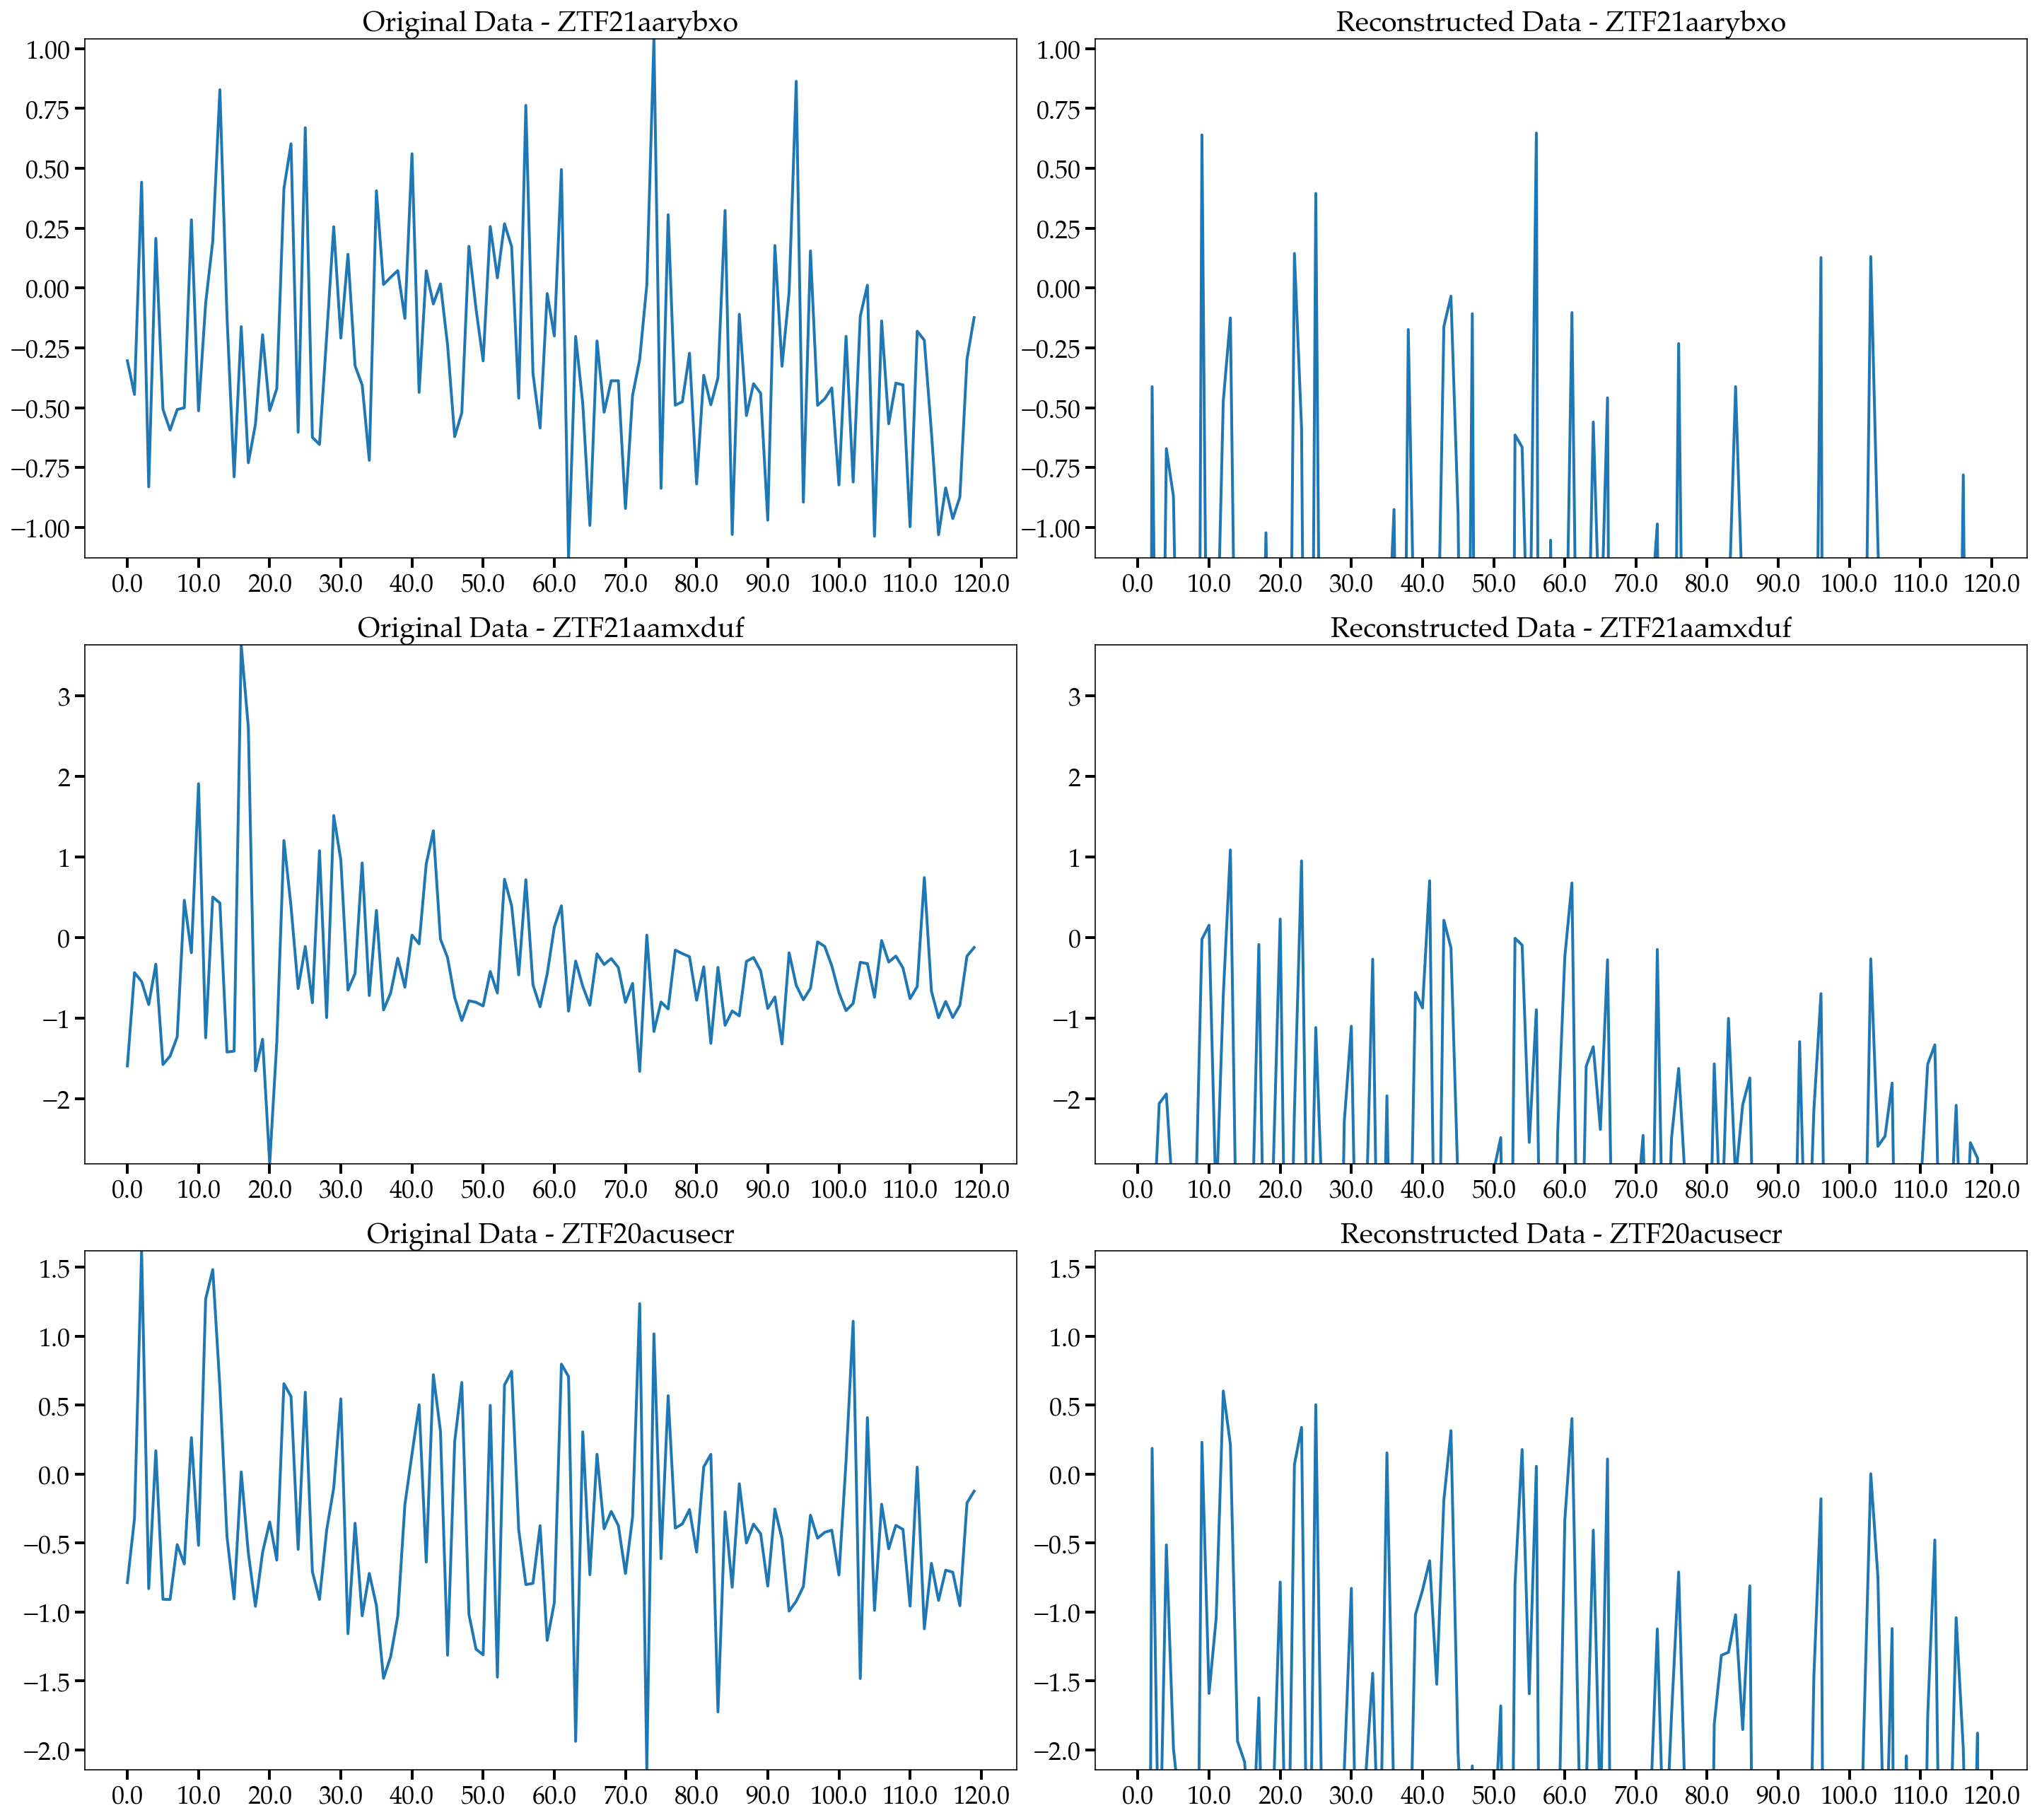

In [15]:
import matplotlib.pyplot as plt
import random

# Select a random sample of data points from x_test
num_samples = 3
random.seed(10)
random_indices = random.sample(range(len(x_test_normalized)), num_samples)
print(random_indices)

# Plot original data and reconstructed data
fig, axes = plt.subplots(num_samples, 2, figsize=(20, 6 * num_samples))
for i, index in enumerate(random_indices):
    try:
        # Plot original data
        y_min, y_max=np.min(x_test_normalized.iloc[index]), np.max(x_test_normalized.iloc[index])
        print(x_test_normalized.iloc[index].name)
        axes[i, 0].plot(x_test_normalized.iloc[index])
        axes[i, 0].set_title(f"Original Data - {x_test_normalized.iloc[index].name}")
        #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
        #axes[i, 0].set_xticks(np.array(range(0, 120, 20)))
        axes[i, 0].set_xticks(np.array([0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100., 110., 120.]))
        axes[i, 0].set_xticklabels([0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100., 110., 120.])
        #axes[i, 0].set_xticklabels(x_test.columns, rotation=90, fontsize=6)
        axes[i, 0].set_ylim([y_min, y_max])  # Set y-scale limits

        # Plot reconstructed data
        axes[i, 1].plot(decoded_data[index])
        axes[i, 1].set_title(f"Reconstructed Data - {x_test_normalized.iloc[index].name}")
        axes[i, 1].set_xticks(np.array([0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100., 110., 120.]))
        axes[i, 1].set_xticklabels([0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100., 110., 120.])
        #axes[i, 1].set_xticklabels(list(x_test.columns), rotation=90, fontsize=6)
        axes[i, 1].set_ylim([y_min, y_max])  # Set y-scale limits
    except KeyError:
        continue

plt.tight_layout()
plt.savefig('../figures/VAE/SMOTE_70-30_original_vs_reconstructed_data_test_normalized_500epochs_20dim.jpg', dpi=150, bbox_inches='tight')
plt.show()


In [11]:
for f_num, feat in enumerate(x_test_normalized.columns):
    print(f_num, feat)

0 feature_amplitude_magn_r
1 feature_anderson_darling_normal_magn_r
2 feature_beyond_1_std_magn_r
3 feature_beyond_2_std_magn_r
4 feature_cusum_magn_r
5 feature_inter_percentile_range_2_magn_r
6 feature_inter_percentile_range_10_magn_r
7 feature_inter_percentile_range_25_magn_r
8 feature_kurtosis_magn_r
9 feature_linear_fit_slope_magn_r
10 feature_linear_fit_slope_sigma_magn_r
11 feature_magnitude_percentage_ratio_40_5_magn_r
12 feature_magnitude_percentage_ratio_20_5_magn_r
13 feature_mean_magn_r
14 feature_median_absolute_deviation_magn_r
15 feature_percent_amplitude_magn_r
16 feature_median_buffer_range_percentage_10_magn_r
17 feature_median_buffer_range_percentage_20_magn_r
18 feature_percent_difference_magnitude_percentile_5_magn_r
19 feature_percent_difference_magnitude_percentile_10_magn_r
20 feature_skew_magn_r
21 feature_standard_deviation_magn_r
22 feature_stetson_k_magn_r
23 feature_weighted_mean_magn_r
24 feature_anderson_darling_normal_flux_r
25 feature_cusum_flux_r
26 fea

In [11]:
random.sample(range(len(x_test)), num_samples)

[247, 295, 7]

In [12]:
x_test_normalized.iloc[index]

feature_amplitude_magn_r                 -0.849480
feature_anderson_darling_normal_magn_r   -0.200075
feature_beyond_1_std_magn_r               2.465405
feature_beyond_2_std_magn_r              -0.731876
feature_cusum_magn_r                      0.407378
                                            ...   
iApMag_iKronMag                          -0.704006
zApMag_zKronMag                          -0.581824
yApMag_yKronMag                          -0.894117
7DCD                                     -0.126876
dist/DLR                                 -0.039467
Name: ZTF20acusecr, Length: 120, dtype: float64

ZTF21aarybxo
ZTF21aamxduf
ZTF20acusecr


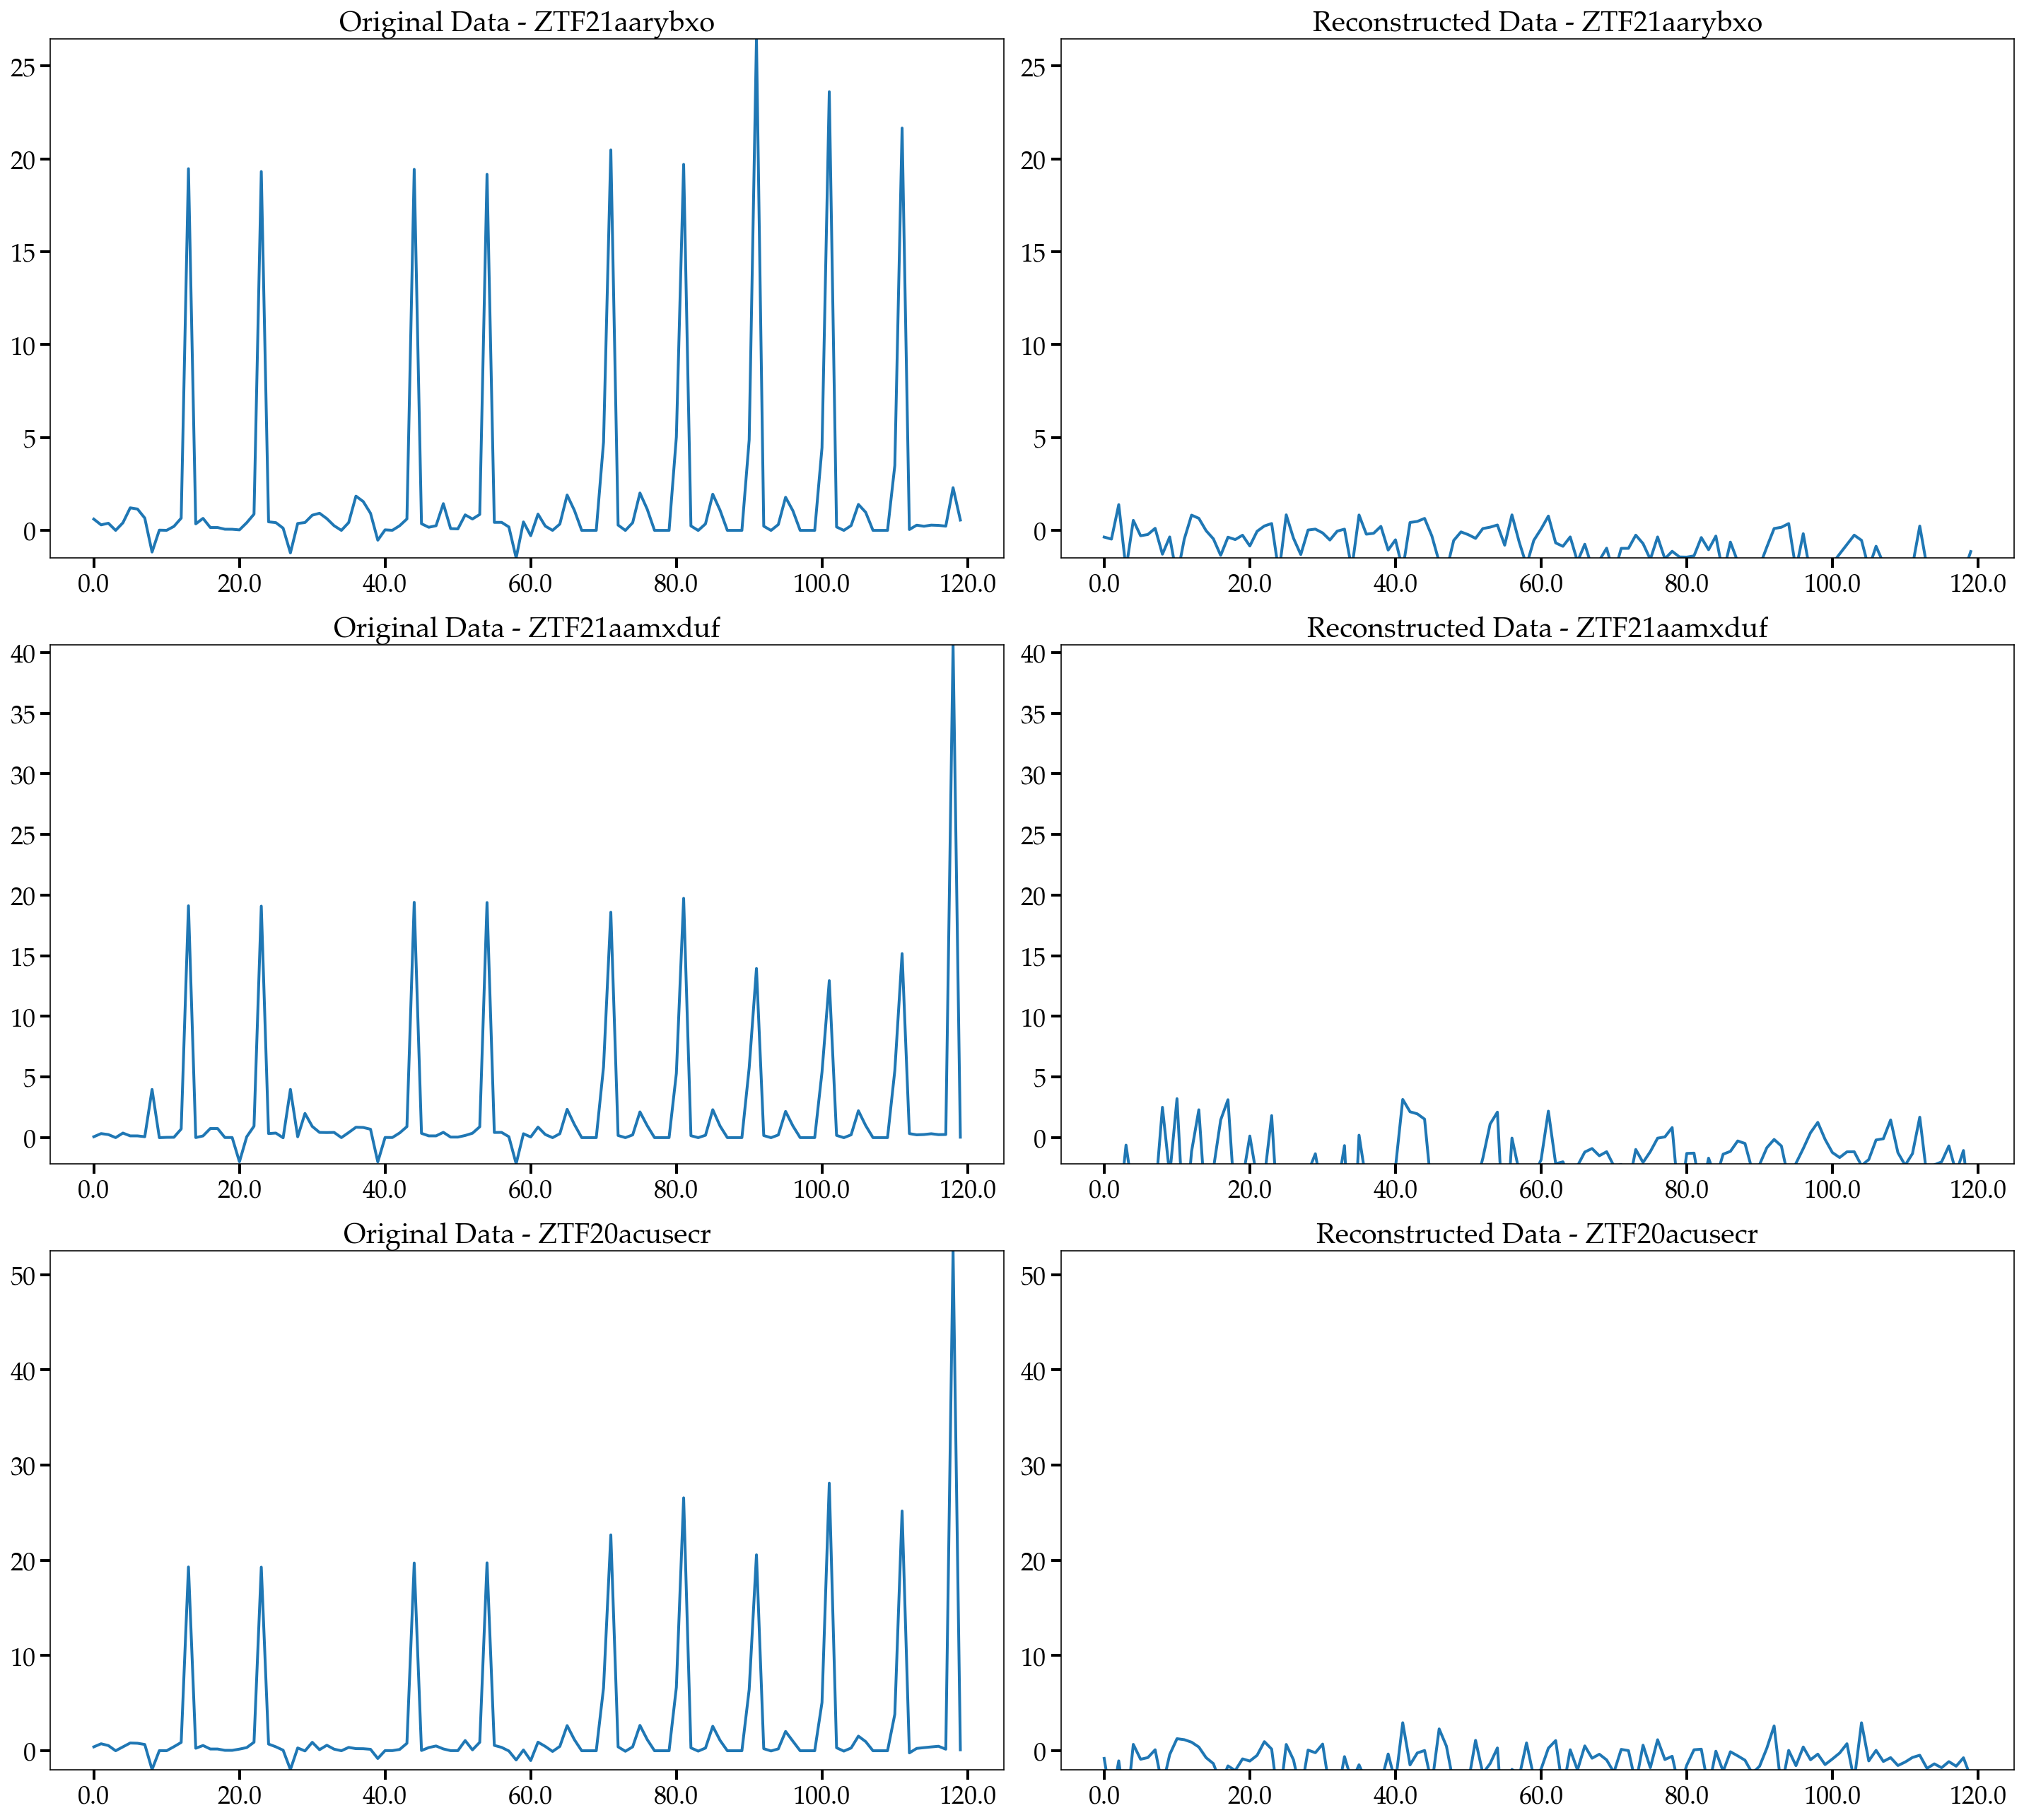

In [13]:
import matplotlib.pyplot as plt
import random

# Select a random sample of data points from x_test
num_samples = 3
random.seed(10)
random_indices = random.sample(range(len(x_test)), num_samples)

# Plot original data and reconstructed data
fig, axes = plt.subplots(num_samples, 2, figsize=(20, 6 * num_samples))
for i, index in enumerate(random_indices):
    try:
        # Plot original data
        y_min, y_max=np.min(x_test.iloc[index]), np.max(x_test.iloc[index])
        print(x_test.iloc[index].name)
        axes[i, 0].plot(x_test.iloc[index])
        axes[i, 0].set_title(f"Original Data - {x_test.iloc[index].name}")
        #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
        #axes[i, 0].set_xticks(np.array(range(0, 120, 20)))
        axes[i, 0].set_xticks(np.array([0., 20., 40., 60., 80., 100., 120.]))
        axes[i, 0].set_xticklabels([0., 20., 40., 60., 80., 100., 120.,])
        #axes[i, 0].set_xticklabels(x_test.columns, rotation=90, fontsize=6)
        axes[i, 0].set_ylim([y_min, y_max])  # Set y-scale limits

        # Plot reconstructed data
        axes[i, 1].plot(decoded_data[index])
        axes[i, 1].set_title(f"Reconstructed Data - {x_test.iloc[index].name}")
        axes[i, 1].set_xticks(np.array([0., 20., 40., 60., 80., 100., 120.]))
        axes[i, 1].set_xticklabels([0., 20., 40., 60., 80., 100., 120.,])
        #axes[i, 1].set_xticklabels(list(x_test.columns), rotation=90, fontsize=6)
        axes[i, 1].set_ylim([y_min, y_max])  # Set y-scale limits
    except KeyError:
        continue

plt.tight_layout()
#plt.savefig('../figures/VAE/original_vs_reconstructed_data_test.jpg', dpi=150, bbox_inches='tight')
plt.show()


In [14]:
x_test.iloc[index].name

'ZTF20acusecr'

In [15]:
decoded_data[index]

array([ -0.8082085 ,  -5.4111547 ,  -1.0642989 ,  -6.633883  ,
         0.67023367,  -0.8934337 ,  -0.72011846,   0.10190106,
        -3.7403018 ,  -0.39989853,   1.2667202 ,   1.1617926 ,
         0.9003536 ,   0.38739485,  -0.7309824 ,  -1.3544759 ,
        -3.4309177 ,  -1.5907446 ,  -2.0844855 ,  -0.852334  ,
        -1.0828404 ,  -0.48124075,   0.9556842 ,   0.17212461,
        -5.718804  ,   0.662372  ,  -0.9642459 ,  -4.438873  ,
         0.06993932,  -0.20694321,   0.7012093 ,  -4.217486  ,
        -4.843232  ,  -0.6176953 ,  -3.1824753 ,  -1.4768881 ,
        -3.2263    ,  -2.7716508 ,  -3.3793726 ,  -0.34064066,
        -3.3233516 ,   2.9418015 ,  -1.4889712 ,  -0.2338073 ,
         0.02812824,  -3.5543077 ,   2.2939527 ,   0.47982907,
        -3.5341518 ,  -2.6497142 ,  -3.3484893 ,   1.0931541 ,
        -2.3888025 ,  -1.3475136 ,   0.29429162, -10.106858  ,
        -1.953372  ,  -2.6970127 ,   0.82238215,  -2.81574   ,
        -1.9255445 ,   0.26887095,   1.066746  ,  -4.16

In [16]:
len(decoded_data[index])

120

In [17]:
x_test.columns

Index(['feature_amplitude_magn_r', 'feature_anderson_darling_normal_magn_r',
       'feature_beyond_1_std_magn_r', 'feature_beyond_2_std_magn_r',
       'feature_cusum_magn_r', 'feature_inter_percentile_range_2_magn_r',
       'feature_inter_percentile_range_10_magn_r',
       'feature_inter_percentile_range_25_magn_r', 'feature_kurtosis_magn_r',
       'feature_linear_fit_slope_magn_r',
       ...
       'yKronRad', 'yExtNSigma', 'i-z', 'gApMag_gKronMag', 'rApMag_rKronMag',
       'iApMag_iKronMag', 'zApMag_zKronMag', 'yApMag_yKronMag', '7DCD',
       'dist/DLR'],
      dtype='object', length=120)